<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 1:

* In this notebook, we will build a `DNN` model for classifying MNIST digits. The `DNN` model will consist of 784 input nodes, a hidden layer with 128 nodes and 10 output nodes (corresponding to the 10 digits). 
* We use `mnist.load_data()` to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation. 
* After training and evaluating our `DNN` model we analyze its performance. In particular, we use confusion matrices to compare the `predicted classes` with the `class labels` to try to determine why some images were misclassified by the model.
* We then obtain the 60,000 `activation values` of one of the hidden nodes for the (original) set of training data. We want to use these `activation values` as "proxies" for the predicted classes of the 60,000 images. 
* And just like we compared the `predicted classes` with the `class labels` using confusion matrices to determine the efficacy of the model, we use `box plots` to visualize the relationship between the `activation values` of one hidden node and the `class labels`. We don't expect these activation values to have much "predictive power". In fact, the same activation values can be associated with multiple class labels resulting in a lot of overlap in the `box plots`.
* We also perform similar experiments comparing the values at two pixel locations in the images with the class labels. This time we use `scatter plots` to visualize the relationship between the pair of pixel values with the class labels (represented by different colored dots).
* Pixel values at two locations in image should not have much predictive value. To improve on this approach, we the PCA decomposition on both the raw data of 784 pixel values and 128 hidden node activation values to reduce the number of features to 2 in each case. Once again, we use a `scatter plot` to visualize the correlation between the two principal component values and the class labels.
*  Finally, we use a Random Forest Classifier to find the relative importance of the 784 features (pixels) in the training set. We then select the 70 most important feature (pixels) from the training, validation and test images to test our 'best' model on.

## Importing Packages 

* First we import all the packages that will be used in the assignment.

* Since Keras is integrated in TensorFlow 2.x, we import `keras` from `tensorflow` and use `tenserflow.keras.xxx` to import all other Keras packages. The seed argument produces a deterministic sequence of tensors across multiple calls.

## Experiments 

* [Experiment 1](#Exp1)
* [Experiment 2](#Exp2)
* [Experiment 3](#Exp3)
* [Experiment 4](#Exp4)
* [Experiment 5](#Exp5)
* [Additional Experiment](#ExpAdd)
* [Summary](#Summary)


In [132]:
import datetime
import timeit
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib as mpl  # EA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import sklearn

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from scikeras.wrappers import KerasClassifier

import types
#from plot_keras_history import plot_history

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True) 

## Verify TensorFlow version and Keras version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [4]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


## Mount Google Drive to Colab environment

In [5]:
#from google.colab import drive
#drive.mount('/content/gdrive')

## Visualization Utility Functions

In [6]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions)))) 
    
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Loading MNIST Dataset

* The MNIST dataset of handwritten digits has a training set of 60,000 images, and a test set of 10,000 images. It comes prepackaged as part of `tf.Keras`. Use the `tf.keras.datasets.mnist.load_data` to the get these datasets (and the corresponding labels) as Numpy arrays.

In [7]:
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()

* Tuples of Numpy arrays: `(x_train, y_train)`, `(x_test, y_test)`
* `x_train`, `x_test`: uint8 arrays of grayscale image data with shapes (num_samples, 28, 28).
* `y_train`, `y_test`: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Sets

* Inspect the training and test sets as well as their labels as follows.

In [8]:
print('x_train:\t{}'.format(x_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))
print('y_test:\t\t{}'.format(y_test.shape))

x_train:	(60000, 28, 28)
y_train:	(60000,)
x_test:		(10000, 28, 28)
y_test:		(10000,)


## Review labels for training set

In [9]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))

First ten labels training dataset:
 [5 0 4 1 9 2 1 3 1 4]



## Find frequency of each label in training and test sets

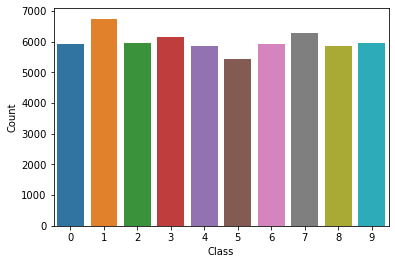

In [10]:
items = [{'Class': x, 'Count': y} for x, y in Counter(y_train).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);

In [11]:
Counter(y_train).most_common()

[(1, 6742),
 (7, 6265),
 (3, 6131),
 (2, 5958),
 (9, 5949),
 (0, 5923),
 (6, 5918),
 (8, 5851),
 (4, 5842),
 (5, 5421)]

In [12]:
Counter(y_test).most_common()

[(1, 1135),
 (2, 1032),
 (7, 1028),
 (3, 1010),
 (9, 1009),
 (4, 982),
 (0, 980),
 (8, 974),
 (6, 958),
 (5, 892)]

## Plot sample images with their labels

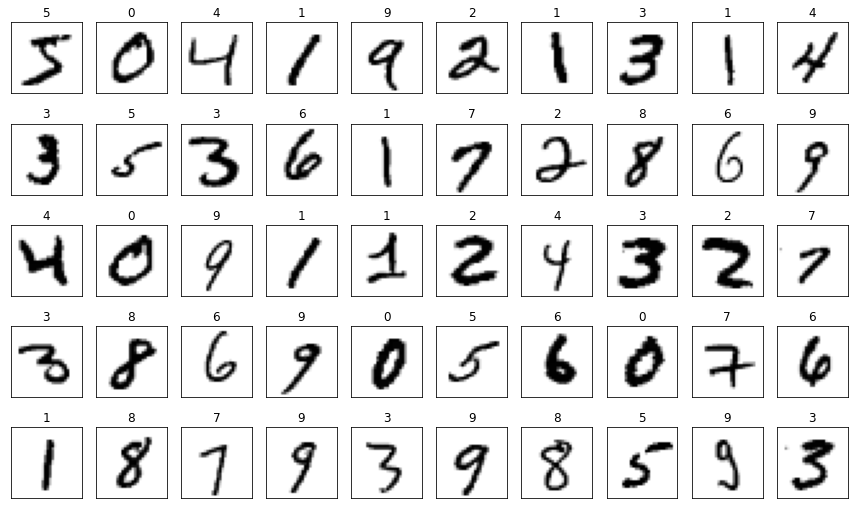

In [13]:
fig = plt.figure(figsize = (15, 9))

for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.title(y_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].reshape(28,28), cmap='binary')

##  Preprocessing Data

* Before we build our model, we need to prepare the data into the shape the network expected
* More specifically, we will convert the labels (integers 0 to 9) to 1D numpy arrays of shape (10,) with elements 0s and 1s. 
* We also reshape the images from 2D arrays of shape (28,28) to 1D *float32* arrays of shape (784,) and then rescale their elements to values between 0 and 1.

## Apply one-hot encoding on the labels

We will change the way the labels are represented from numbers (0 to 9) to vectors (1D arrays) of shape (10, ) with all the elements set to 0 except the one which the label belongs to - which will be set to 1. For example:


| original label | one-hot encoded label |
|------|------|
| 5 | [0 0 0 0 0 1 0 0 0 0] |
| 7 | [0 0 0 0 0 0 0 1 0 0] |
| 1 | [0 1 0 0 0 0 0 0 0 0] |

In [14]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

print("First ten entries of y_train:\n {}\n".format(y_train[0:10]))
print("First ten rows of one-hot y_train:\n {}".format(y_train_encoded[0:10,]))

First ten entries of y_train:
 [5 0 4 1 9 2 1 3 1 4]

First ten rows of one-hot y_train:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [15]:
print('y_train_encoded shape: ', y_train_encoded.shape)
print('y_test_encoded shape: ', y_test_encoded.shape)

y_train_encoded shape:  (60000, 10)
y_test_encoded shape:  (10000, 10)


## Reshape the images to 1D arrays

Reshape the images from shape (28, 28) 2D arrays to shape (784, ) vectors (1D arrays).

In [16]:
# Before reshape:
print('x_train:\t{}'.format(x_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))

x_train:	(60000, 28, 28)
x_test:		(10000, 28, 28)


In [17]:
np.set_printoptions(linewidth=np.inf)
print("{}".format(x_train[2020]))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 167 208  19   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  13 235 254  99   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  74 254 234   4   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 154 254 145   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 224 254  92   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  51 245 211  13   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   2 169 254 101   0   0   0   0   0   

In [18]:
# Reshape the images:
x_train_reshaped = np.reshape(x_train, (60000, 784))
x_test_reshaped = np.reshape(x_test, (10000, 784))

# After reshape:
print('x_train_reshaped shape: ', x_train_reshaped.shape)
print('x_test_reshaped shape: ', x_test_reshaped.shape)

x_train_reshaped shape:  (60000, 784)
x_test_reshaped shape:  (10000, 784)


1. Each element in an image is a pixel value
2. Pixel values range from 0 to 255
3. 0 = White
4. 255 = Black

## Review unique values with set from 1st image

In [19]:
print(set(x_train_reshaped[0]))

{0, 1, 2, 3, 9, 11, 14, 16, 18, 23, 24, 25, 26, 27, 30, 35, 36, 39, 43, 45, 46, 49, 55, 56, 64, 66, 70, 78, 80, 81, 82, 90, 93, 94, 107, 108, 114, 119, 126, 127, 130, 132, 133, 135, 136, 139, 148, 150, 154, 156, 160, 166, 170, 171, 172, 175, 182, 183, 186, 187, 190, 195, 198, 201, 205, 207, 212, 213, 219, 221, 225, 226, 229, 238, 240, 241, 242, 244, 247, 249, 250, 251, 252, 253, 255}


## Rescale the elements of the reshaped images

Rescale the elements between [0 and 1]

In [196]:
x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255

In [197]:
# Take a look at the first reshaped and normalized training image:
print(set(x_train_norm[0]))

{0.0, 0.011764706, 0.53333336, 0.07058824, 0.49411765, 0.6862745, 0.101960786, 0.6509804, 1.0, 0.96862745, 0.49803922, 0.11764706, 0.14117648, 0.36862746, 0.6039216, 0.6666667, 0.043137256, 0.05490196, 0.03529412, 0.85882354, 0.7764706, 0.7137255, 0.94509804, 0.3137255, 0.6117647, 0.41960785, 0.25882354, 0.32156864, 0.21960784, 0.8039216, 0.8666667, 0.8980392, 0.7882353, 0.52156866, 0.18039216, 0.30588236, 0.44705883, 0.3529412, 0.15294118, 0.6745098, 0.88235295, 0.99215686, 0.9490196, 0.7647059, 0.2509804, 0.19215687, 0.93333334, 0.9843137, 0.74509805, 0.7294118, 0.5882353, 0.50980395, 0.8862745, 0.105882354, 0.09019608, 0.16862746, 0.13725491, 0.21568628, 0.46666667, 0.3647059, 0.27450982, 0.8352941, 0.7176471, 0.5803922, 0.8117647, 0.9764706, 0.98039216, 0.73333335, 0.42352942, 0.003921569, 0.54509807, 0.67058825, 0.5294118, 0.007843138, 0.31764707, 0.0627451, 0.09411765, 0.627451, 0.9411765, 0.9882353, 0.95686275, 0.83137256, 0.5176471, 0.09803922, 0.1764706}


## Creating the DNN Model

* In this step, we first choose the network architecture for the model. Then we build.compile, train and evaulate the model.

## Specify the network architecture

Below is the neural network architecture we will use today for classifying MNIST digits.

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/DNN_architecture.png?raw=1">

## Build the DNN model

We use a `Sequential` class defined in `Keras` to create our model. All the layers are going to be Dense layers. This means, like the figure shown above, all the nodes of a layer would be connected to all the nodes of the preceding layer i.e. densely connected.

After the model is built, we view ....

In [22]:
model = Sequential([
    Dense(input_shape=[784], units=128, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

Metal device set to: Apple M1 Pro


2022-04-12 15:57:39.325610: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-12 15:57:39.328666: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


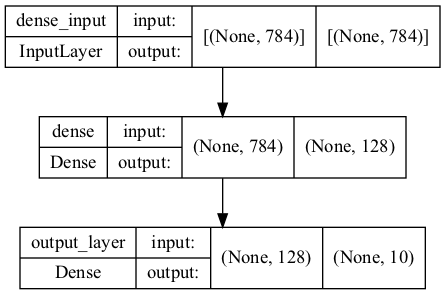

In [24]:
keras.utils.plot_model(model, "mnist_model.png", show_shapes=True) 

## Compile the DNN model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimized in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimizes the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.


<b>tf.keras.optimizers.RMSprop</b><br> 
 https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop


<b>tf.keras.losses.CategoricalCrossentropy</b><br> 
  https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy


In [25]:
model.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

## Train the DNN model

<b>tf.keras.model.fit</b><br>
  https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [26]:
history = model.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20 
    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200


2022-04-12 15:57:40.412782: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-12 15:57:40.686734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1499/1500 [============================>.] - ETA: 0s - loss: 0.4031 - accuracy: 0.9130

2022-04-12 15:57:51.621713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1500/1500 [==============================] - 13s 8ms/step - loss: 0.4031 - accuracy: 0.9130 - val_loss: 0.2870 - val_accuracy: 0.9389
Epoch 2/200
1500/1500 [==============================] - 11s 7ms/step - loss: 0.2417 - accuracy: 0.9505 - val_loss: 0.2253 - val_accuracy: 0.9565
Epoch 3/200
1500/1500 [==============================] - 11s 7ms/step - loss: 0.2030 - accuracy: 0.9588 - val_loss: 0.2074 - val_accuracy: 0.9555
Epoch 4/200
1500/1500 [==============================] - 10s 7ms/step - loss: 0.1837 - accuracy: 0.9640 - val_loss: 0.1891 - val_accuracy: 0.9622
Epoch 5/200
1500/1500 [==============================] - 11s 7ms/step - loss: 0.1720 - accuracy: 0.9664 - val_loss: 0.2041 - val_accuracy: 0.9559
Epoch 6/200
1500/1500 [==============================] - 11s 7ms/step - loss: 0.1652 - accuracy: 0.9673 - val_loss: 0.1678 - val_accuracy: 0.9677
Epoch 7/200
1500/1500 [==============================] - 11s 7ms/step - loss: 0.1596 - accuracy: 0.9691 - val_loss: 0.1650 - val_accurac

## Evaluate the DNN model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [27]:
loss, accuracy = model.evaluate(x_test_norm, y_test_encoded)
print('test set accuracy: ', accuracy * 100)

 24/313 [=>............................] - ETA: 1s - loss: 0.1653 - accuracy: 0.9622

2022-04-12 15:59:11.131965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 7ms/step - loss: 0.1659 - accuracy: 0.9659
test set accuracy:  96.59000635147095


## Making Predictions

In [28]:
preds = model.predict(x_test_norm)
print('shape of preds: ', preds.shape)

2022-04-12 15:59:13.784720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


shape of preds:  (10000, 10)


Look at the first 25 - Plot test set images along with their predicted and actual labels to understand how the trained model actually performed

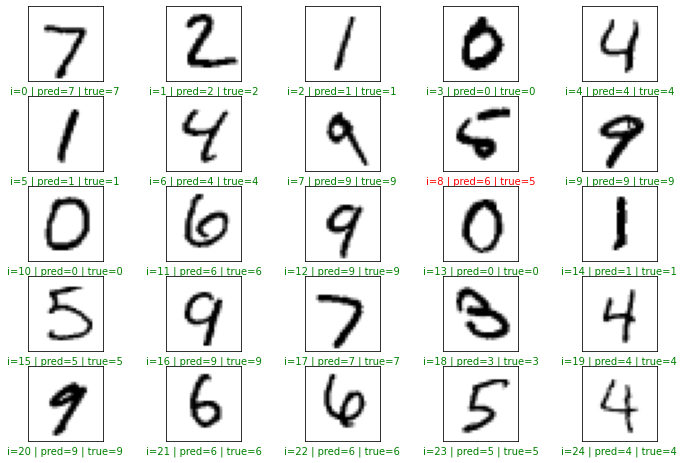

In [29]:
plt.figure(figsize = (12, 8))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

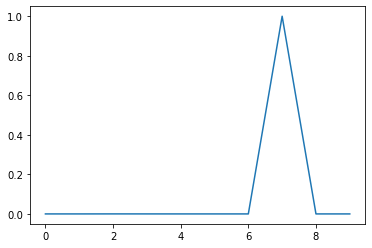

In [30]:
"""
Enter the index value in place of the value 17 below for the prediction
that you want to plot the probability scores for
"""
index = 17

plt.plot(preds[index])
plt.show()

##  Reviewing Performance

In [31]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## Plot performance metrics 

We use `Matplotlib` to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [32]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

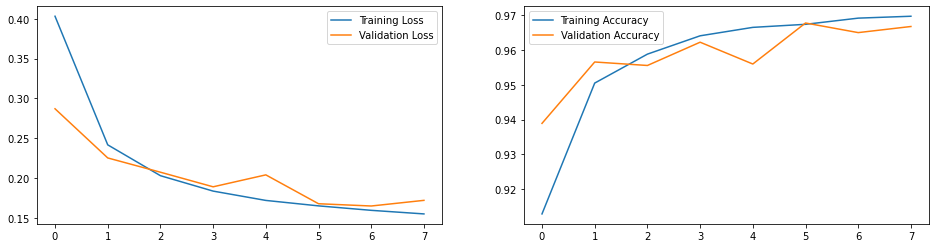

In [34]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [35]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

In [36]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.94      0.98      0.96      1032
           3       0.94      0.96      0.95      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.95      0.96       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.98      0.93      0.95       974
           9       0.97      0.94      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Accuracy Score: 0.9659
Root Mean Square Error: 0.841843215806839


## Create the confusion matrix

Let us see what the confusion matrix looks like. Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [37]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model.predict(x_test_norm), axis=-1)
pred_classes;

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br> 
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [38]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

In [39]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9
0,0.00%,0.00%,0.01%,0.00%,0.00%,0.00%,0.00%,99.99%,0.00%,0.00%
1,0.00%,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
2,0.00%,99.62%,0.05%,0.01%,0.01%,0.01%,0.01%,0.24%,0.06%,0.00%
3,99.96%,0.00%,0.03%,0.00%,0.00%,0.00%,0.01%,0.00%,0.00%,0.00%
4,0.00%,0.00%,0.02%,0.00%,99.74%,0.00%,0.00%,0.00%,0.00%,0.23%
5,0.00%,99.74%,0.00%,0.00%,0.00%,0.00%,0.00%,0.25%,0.01%,0.00%
6,0.00%,0.00%,0.00%,0.00%,98.13%,0.02%,0.00%,0.00%,0.21%,1.63%
7,0.00%,0.00%,0.01%,0.54%,0.29%,0.00%,0.00%,0.09%,0.00%,99.05%
8,0.05%,0.00%,29.05%,0.00%,0.30%,2.79%,67.67%,0.00%,0.12%,0.01%
9,0.00%,0.00%,0.00%,0.00%,0.10%,0.00%,0.00%,0.11%,0.01%,99.77%


## Visualize the confusion matrix

We use code from chapter 3 of Hands on Machine Learning (A. Geron) (cf. https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb) to display a "heat map" of the confusion matrix. Then we normalize the confusion matrix so we can compare error rates. 

See https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch03.html#classification_chapter

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br> 
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

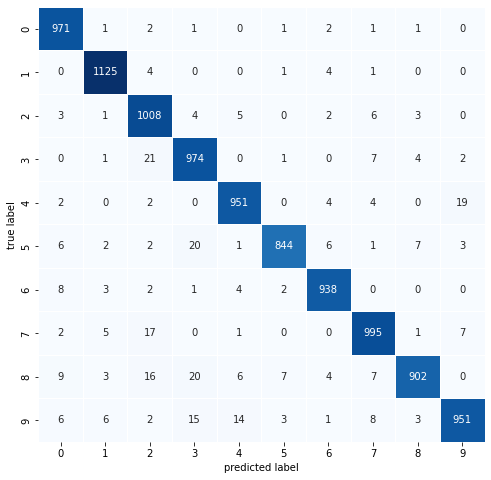

In [40]:
plot_confusion_matrix(y_test,pred_classes)

The confusion matrix looks quite good!

Looks like 28 fours were misclassified as nines (and 10 nines were classifed fours). We display some of these misclassfications along with exam of fours and nines that were correctly identified.

In [41]:
def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")

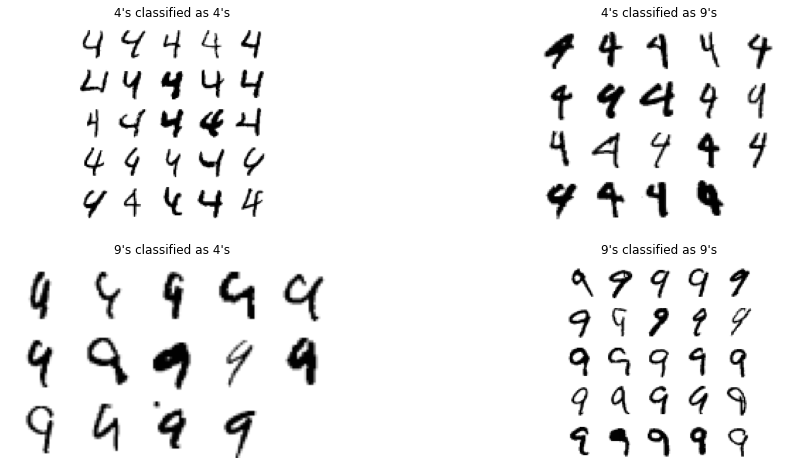

In [42]:
cl_a, cl_b = 4, 9
X_aa = x_test_norm[(y_test == cl_a) & (pred_classes == cl_a)]
X_ab = x_test_norm[(y_test == cl_a) & (pred_classes == cl_b)]
X_ba = x_test_norm[(y_test == cl_b) & (pred_classes == cl_a)]
X_bb = x_test_norm[(y_test == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(16,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);  
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

## Analyzing the Activation Values of the Hidden Nodes

We want to examine the contribution of the individual hidden nodes to the classifications made by the model. We first get the activation values of all the hidden nodes for each of the 60,000 training images and treat these *128 activations* as the features that determine the classification class. For the sake of comparison,  we also consider the *784 pixels* of each training image and determine the contribution of the individual pixels to the predicted classification class. 

Our goal is to use *box* and *scatter* plots to visualize how these features (*pixel* and *activation* values) correlate with the class labels. Because of the high dimension of the feature spaces, we apply *PCA decomposition* and *t-Distributed stochastic neighbor embedding* (`t-SNE`) to reduce the number of features in each case. 

We use the following two articles as reference

 * https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
 * https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b


1) Raw data is 60,000 X 784. Just do a scatter plot of col 1 vs col 2. Overlay the color coded classes. We  should not see any patterns since there is not much info in 2 cols to discriminate.

2) PCA of raw data – as we discussed earlier. Plot PC1 vs PC2 with overlay. This should be ‘better’ since these 2 capture the info from all 784 cols.

3) PCA of activation values – as we discussed earlier. This should be ‘better’ than the previous 2 since it has captured specific features of discrimination.

 ## Get the activation values of the hidden nodes
 
To get the activation values of the hidden nodes, we need to create a new model, `activation_model`, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the `predict` function to get the activation values.

In [43]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers

There are 2 layers


In [44]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  each of the 128 hidden nodes has one activation value per training image

2022-04-12 15:59:18.090209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(60000, 128)

In [45]:
output_layer_activations.shape

(60000, 10)

In [46]:
print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation.max()}")

The maximum activation value of the hidden nodes in the hidden layer is 5.501557350158691


In [47]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (60000, 10)
The output for the first image are [0.    0.    0.    0.218 0.    0.781 0.    0.    0.    0.   ]
The sum of the probabilities is (approximately) 1.0


 ## Create a dataframe with the activation values and the class labels

In [48]:
#Get the dataframe of all the node values
activation_data = {'actual_class':y_train}
for k in range(0,128): 
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,5.000,0.000,4.000,1.000,9.000,2.000,1.000,3.000,1.000,4.000,3.000,5.000,3.000,6.000,1.000
act_val_0,0.000,0.000,0.000,0.000,0.000,0.000,0.794,0.000,0.660,0.000,0.832,0.000,0.797,0.000,0.631
act_val_1,0.855,1.184,0.667,0.029,0.000,0.000,0.473,1.064,0.306,1.694,1.690,0.648,2.486,0.940,0.075
act_val_2,0.080,0.000,0.000,0.511,0.341,0.034,0.000,0.648,0.013,0.000,0.645,0.066,0.000,0.000,0.000
act_val_3,0.000,0.108,0.543,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.423,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
act_val_123,0.436,0.470,0.003,0.615,0.602,0.689,0.273,0.803,0.258,0.451,0.834,0.318,0.388,0.417,0.215
act_val_124,0.000,0.000,0.000,0.000,0.000,0.000,0.787,0.000,0.182,0.000,0.968,0.000,1.312,0.000,0.000
act_val_125,0.000,0.000,0.000,0.170,0.000,0.000,0.000,0.000,0.245,0.000,0.000,0.000,0.000,0.000,0.328
act_val_126,0.147,0.896,0.000,0.115,0.000,0.193,0.000,0.026,0.000,0.074,0.273,0.252,0.000,0.000,0.000


 ## Visualize the activation values with boxplots
 
We get the activation values of the first hidden node and combine them with the corresponding class labels into a DataFrame. We use both `matplotlib` and `seaborn` to create boxplots from the dataframe. 

<div class="alert alert-block alert-info">
    <b>seaborn.boxplot</b><br> 
   ps://seaborn.pydata.org/generated/seaborn.boxplot.html
    </div>

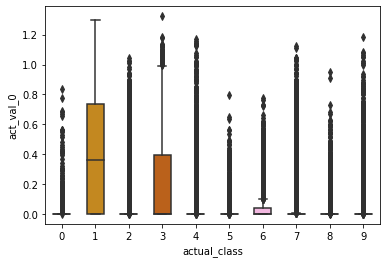

In [49]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
bplot = sns.boxplot(y='act_val_0', x='actual_class', 
                 data=activation_df[['act_val_0','actual_class']], 
                 width=0.5,
                 palette="colorblind")

In [50]:
# displaying the range of activation values for each class labels
activation_df.groupby("actual_class")["act_val_0"].apply(lambda x: [round(min(x.tolist()),2),
 round(max(x.tolist()),2)]).reset_index().rename(columns={"act_val_0": "range_of_act_values"})

,actual_class,range_of_act_values
0,0,"[0.0, 0.84]"
1,1,"[0.0, 1.3]"
2,2,"[0.0, 1.05]"
3,3,"[0.0, 1.32]"
4,4,"[0.0, 1.17]"
5,5,"[0.0, 0.8]"
6,6,"[0.0, 0.78]"
7,7,"[0.0, 1.12]"
8,8,"[0.0, 0.95]"
9,9,"[0.0, 1.19]"


 ## Create a dataframe with the pixel values and class labels

In [51]:
#Get the dataframe of all the pixel values
pixel_data = {'actual_class':y_train}
for k in range(0,128): 
    pixel_data[f"pix_val_{k}"] = x_train_norm[:,k]
pixel_df = pd.DataFrame(pixel_data)
pixel_df.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,5.0,0.0,4.0,1.0,9.0,2.0,1.000,3.0,1.0,4.0,3.000,5.0,3.0,6.000,1.0
pix_val_0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0
pix_val_1,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0
pix_val_2,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0
pix_val_3,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pix_val_123,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.165,0.0,0.0,0.000,0.0
pix_val_124,0.0,0.0,0.0,0.0,0.0,0.0,0.569,0.0,0.0,0.0,0.463,0.0,0.0,0.000,0.0
pix_val_125,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.0,0.0,0.859,0.0,0.0,0.090,0.0
pix_val_126,0.0,0.0,0.0,0.0,0.0,0.0,0.827,0.0,0.0,0.0,0.651,0.0,0.0,0.773,0.0


In [52]:
pixel_df.pix_val_77.value_counts()

0.000000    59720
1.000000       25
0.996078       13
0.992157        9
0.050980        6
            ...  
0.894118        1
0.690196        1
0.725490        1
0.517647        1
0.819608        1
Name: pix_val_77, Length: 150, dtype: int64

In [53]:
pixel_df.pix_val_78.value_counts()

0.000000    59862
1.000000        6
0.960784        4
0.992157        4
0.141176        4
            ...  
0.556863        1
0.584314        1
0.427451        1
0.078431        1
0.501961        1
Name: pix_val_78, Length: 97, dtype: int64

### Use a scatter plot to visualize the predicive power of the pixel values at two fixed locations in the image, i.e. how well the pixel values at two fixed locations in the image "predict" the class labels.

We use a scatter plot to determine the correlation between the `pix_val_77` and `pix_val_78` values and the `actual_class` values.

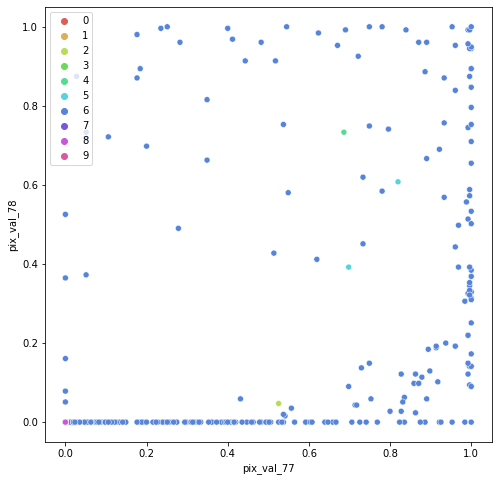

In [54]:
plt.figure(figsize=(8, 8))
color = sns.color_palette("hls", 10)
sns.scatterplot(x="pix_val_77", y="pix_val_78", hue="actual_class",  palette=color, data = pixel_df, legend="full")
plt.legend(loc='upper left');

## PCA Feature Reduction / Model Optimization 

<div class="alert alert-block alert-info">
    <b>sklearn.decomposition.PCA</b><br> 
    https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
    </div>

## Use PCA decomposition to reduce the number of features from 784 features to 2 features 

In [55]:
# Separating out the features
features = [*pixel_data][1:] # ['pix_val_0', 'pix_val_1',...]
x = pixel_df.loc[:, features].values 

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [56]:
pixel_pca_df = pd.concat([principalDf, pixel_df[['actual_class']]], axis = 1)

In [57]:
pixel_pca_df.head().round(3)

,principal component 1,principal component 2,actual_class
0,-0.332,0.039,5
1,-0.246,-0.045,0
2,-0.331,0.035,4
3,-0.331,0.035,1
4,-0.331,0.035,9


In [58]:
pca.explained_variance_ratio_

array([0.403, 0.164], dtype=float32)

## Use a scatter plot to visualize the predictive power of the two principal component values.

Using seaborn this time...

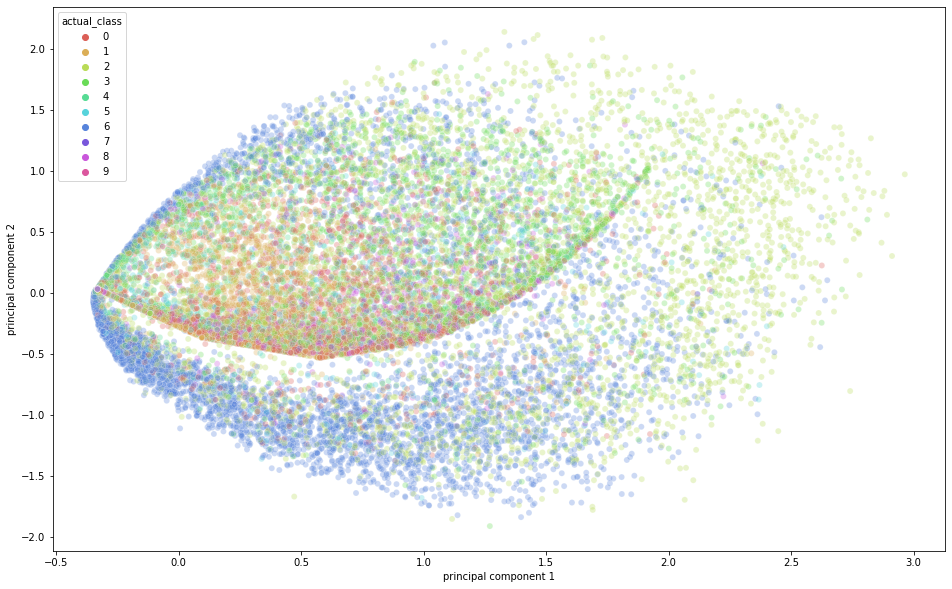

In [59]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="actual_class",
    palette=sns.color_palette("hls", 10),
    data=pixel_pca_df,
    legend="full",
    alpha=0.3
);

### Use PCA decomposition to reduce the (activation) features from 128 (= num of hidden nodes) to 2

In [60]:
# Separating out the features
features = [*activation_data][1:] # ['act_val_0', 'act_val_1',...]
x = activation_df.loc[:, features].values 

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head().round(3)

,principal component 1,principal component 2
0,0.769,-2.720
1,4.929,0.830
2,-0.854,2.042
3,-2.170,-1.313
4,-2.176,0.754


In [61]:
activation_pca_df = pd.concat([principalDf, activation_df[['actual_class']]], axis = 1)
activation_pca_df.head().round(3)

,principal component 1,principal component 2,actual_class
0,0.769,-2.720,5
1,4.929,0.830,0
2,-0.854,2.042,4
3,-2.170,-1.313,1
4,-2.176,0.754,9


In [62]:
pca.explained_variance_ratio_

array([0.184, 0.13 ], dtype=float32)

The 2 principal components summed together 0.169 + 0.105 = .274 explained variance 

## Use a scatter plot to visualize the predictive power of *two* principal component values.

Using seaborn this time

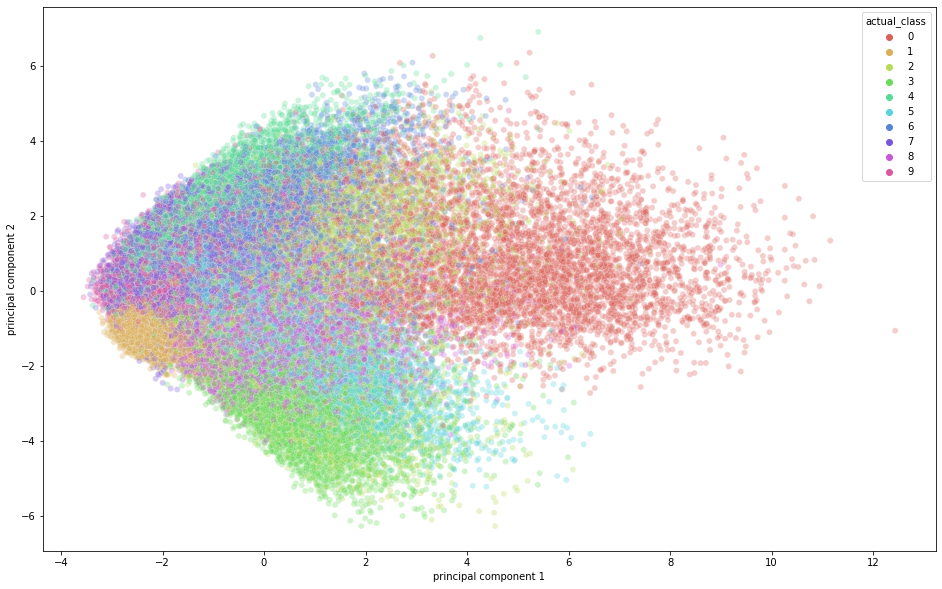

In [63]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="actual_class",
    palette=sns.color_palette("hls", 10),
    data=activation_pca_df,
    legend="full",
    alpha=0.3
);

### Use PCA decomposition to reduce the (activation) features from 128 (= num of hidden nodes) to 3

In [64]:
# Separating out the features
features = [*activation_data][1:] # ['act_val_0', 'act_val_1',...]
x = activation_df.loc[:, features].values 

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pca-one', 'pca-two', 'pca-three'])
principalDf.head(10).round(3).T

,0,1,2,3,4,5,6,7,8,9
pca-one,0.769,4.929,-0.854,-2.170,-2.176,-0.324,-1.971,2.372,-2.394,-1.183
pca-two,-2.719,0.830,2.042,-1.313,0.754,1.817,-1.401,-3.126,-0.677,2.836
pca-three,-0.007,-0.035,-0.046,0.345,-1.802,0.310,1.392,-1.053,1.092,1.405


In [65]:
pca.explained_variance_ratio_

array([0.184, 0.13 , 0.09 ], dtype=float32)

The 3 principal components summed together 0.169 + 0.105 + 0.099 = 0.373 explained variance 

In [66]:
activation_pca_df = pd.concat([principalDf, activation_df[['actual_class']]], axis = 1)
activation_pca_df.head().round(3)

,pca-one,pca-two,pca-three,actual_class
0,0.769,-2.719,-0.007,5
1,4.929,0.830,-0.035,0
2,-0.854,2.042,-0.046,4
3,-2.170,-1.313,0.345,1
4,-2.176,0.754,-1.802,9


## Use a scatter plot to visualize the predictive power of *three* principal component values

/var/folders/cj/b27zth7d1gn3ktvbyzc3h69c0000gn/T/ipykernel_32541/334722659.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')


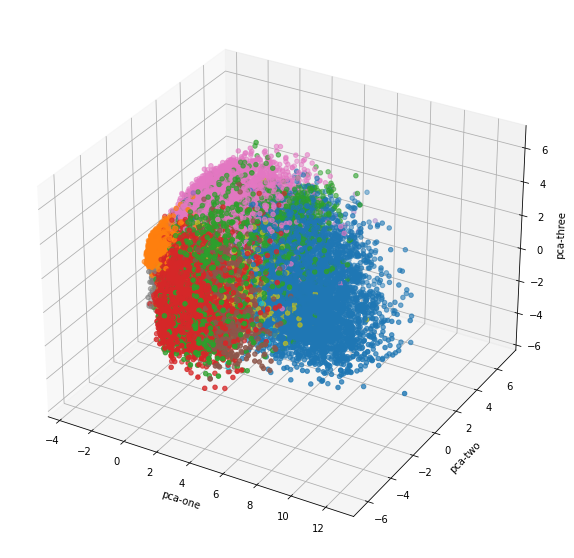

In [67]:
# uncomment to to able to rotate the graph...
# %matplotlib notebook   
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=activation_pca_df.loc[:,"pca-one"], 
    ys=activation_pca_df.loc[:,"pca-two"], 
    zs=activation_pca_df.loc[:,"pca-three"], 
    c=activation_pca_df.loc[:,"actual_class"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Use t-Distributed Stochastic Neighbor Embedding (**t-SNE**)  to reduce the (activation) features from 128 (= num of hidden nodes) to 2

`t-Distributed Stochastic Neighbor Embedding` (**t-SNE**) is another technique for dimensionality reduction and is particularly well suited for the visualization of high-dimensional datasets. This time we only use the first 10,000 training images (N=10000) since the technique is computationally expensive.

See http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

<div class="alert alert-block alert-info">
    <b>sklearn.manifold.TSNE</b><br> 
    https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
    </div>

In [68]:
activation_df.shape

(60000, 129)

In [69]:
N=60000
activation_df_subset = activation_df.iloc[:N].copy()
activation_df_subset.shape

(60000, 129)

In [70]:
data_subset = activation_df_subset[features].values
data_subset.shape

(60000, 128)

In [71]:
%%time
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.003s...
[t-SNE] Computed neighbors for 60000 samples in 65.617s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for s

In [72]:
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

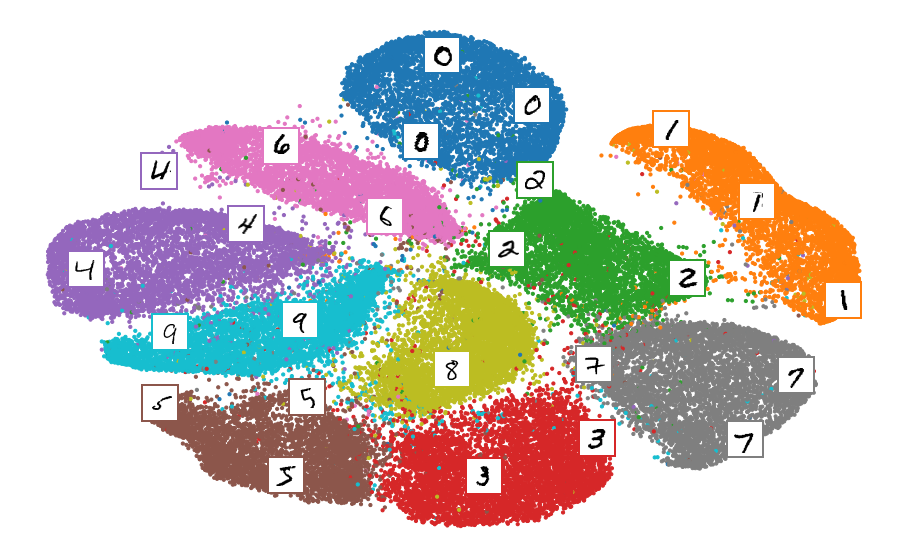

In [73]:
# https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
# plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0],tsne_results[:,1], c=y_train, s=10, cmap=cmap)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_train[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## Reducing dimensionality of the data with Random Forests.

We create a Random Forest Classifier (with the default 100 trees) and use it to find the relative importance of the 784 features (pixels) in the training set. We produce a heat map to visual the relative importance of the features (using code from Hands On Machine Learning by A. Geron). Finally, we select the 70 most important feature (pixels) from the training, validation and test images to test our 'best' model on.

<div class="alert alert-block alert-info">
    <b>sklearn.ensemble.RandomForestClassifier</b><br> 
  https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    </div>

In [74]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(x_train_norm,y_train_encoded)

RandomForestClassifier(random_state=42)

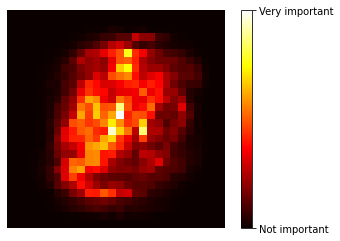

In [75]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'hot',
               interpolation="nearest")
    plt.axis("off")

plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

In [76]:
# https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
n = 70
imp_arr = rnd_clf.feature_importances_
idx = (-imp_arr).argsort()[:n]          # get the indices of the 70 "most important" features/pixels
len(idx)

70

In [77]:
# Create training and test images using just the 70 pixel locations obtained above
train_images_sm = x_train_norm[:,idx]
test_images_sm = x_test_norm[:,idx]
train_images_sm.shape, test_images_sm.shape # the reduced images have dimension 70

((60000, 70), (10000, 70))

## Visualize the 70 pixels
We convert the array of indexes to ordered pairs and plot them as red circles on the second training image. These are the features (pixels) we train our neural network on.

In [78]:
# to convert an index n, 0<= n < 784
def pair(n,size):
    x = n//size 
    y = n%size
    return x,y

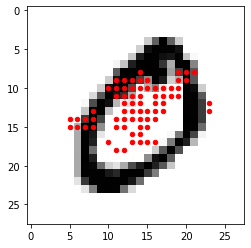

In [79]:
plt.imshow(x_train_norm[1].reshape(28,28),cmap='binary')
x, y = np.array([pair(k,28) for k in idx]).T
plt.scatter(x,y,color='red',s=20)

## Experiment 1 <a class="anchor" id="Exp1"></a>
#### A hidden layer with 1 node and 10 output nodes (corresponding to the 10 digits). 

In [198]:
# A method to create and run the models

import warnings
warnings.filterwarnings("ignore")

tf.autograph.set_verbosity(0)
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("scikeras").setLevel(logging.ERROR)

import random


def create_model(layers=1, nodes=200, num_input=784, init='glorot_uniform'):
    
    
    all_layers = []
    
    # Add any number of hidden layers
    first = True
    for i in range(layers):
        if first:
            all_layers.append(tf.keras.layers.Dense(nodes, input_shape=(num_input,), kernel_initializer=init, activation=tf.nn.sigmoid))
            first = False
        else:
            all_layers.append(tf.keras.layers.Dense(nodes, kernel_initializer=init, activation=tf.nn.sigmoid))
        
    # Add the output layer                                     
    all_layers.append(tf.keras.layers.Dense(10, activation='softmax'))
    
    #Create the model
    model = tf.keras.Sequential(all_layers)
    
    #And compile
    model.compile(tf.optimizers.Adam(), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

def run_conv(layers=1, nodes=1, num_input=784, epochs=100):
    
    
    classifier = KerasClassifier(build_fn=lambda: create_model(layers=layers, num_input=num_input, 
                                                               nodes=nodes, init='glorot_uniform'), 
                                 callbacks=[EarlyStopping(patience=5, verbose=5, mode="auto")],
                                 verbose=0)
    
    start_time = timeit.default_timer()
    fit_hist = classifier.fit(x_train_norm, 
                              y_train_encoded,
                              validation_data=(x_test_norm, y_test_encoded),
                              epochs=epochs, 
                              batch_size=100, 
                              verbose=0)
    stop_time = timeit.default_timer()


    print("Keras model with layers {num_layers} and nodes {num_nodes} fit time: {time}".format(time=round(stop_time - start_time, 2),
                                                                         num_layers=layers,
                                                                         num_nodes=nodes))
    
    
    
    return classifier, fit_hist

# One node and one layer
clf, hist = run_conv()

2022-04-16 20:14:25.410044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 20:14:29.382731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Keras model with layers 1 and nodes 1 fit time: 362.94


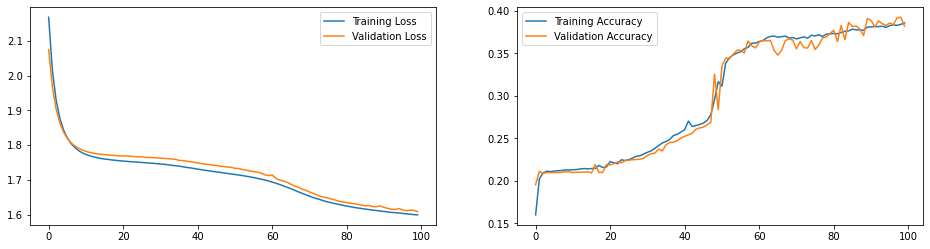

In [171]:

def plot_hist(hist):
    history = hist.history_

    loss = history['loss']
    val_loss = history['val_loss']
    
    acc = history['accuracy']
    val_acc = history['val_accuracy']

    epochs_range = len(history['loss'])
    
    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([loss, acc], [val_loss, val_acc], ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs_range), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs_range), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()

plot_hist(hist)
    

Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_206 (Dense)           (None, 1)                 785       
                                                                 
 dense_207 (Dense)           (None, 10)                20        
                                                                 
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________
Precision score: 0.269
Recall score: 0.382
Accuracy score: 0.382
F1 score: 0.299


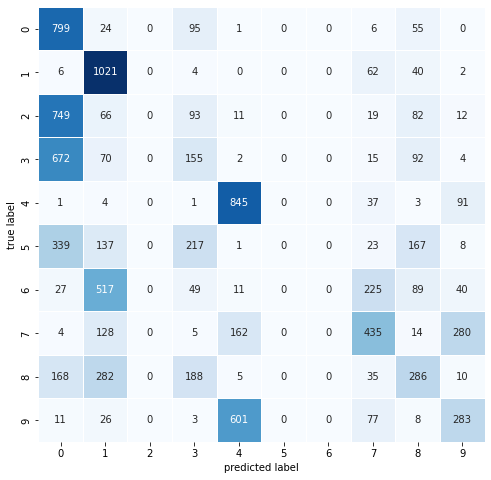

In [200]:
def conv_test(clf):
    
    clf.model_.summary()
    #keras.utils.plot_model(clf.model_, "mnist_model.png", show_shapes=True) 
    y_pred = clf.predict(x_test_norm)#.argmax(axis=1)
    
    pred_classes = np.argmax(y_pred, axis=-1)

    plot_confusion_matrix(y_test, pred_classes)

    ax.set_title('Confusion Matrix\n');
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values')
    
    # Let's also print the accuracy and recall scores
    print("Precision score: {:.3f}".format(sklearn.metrics.precision_score(y_test, pred_classes, average='weighted')))
    print("Recall score: {:.3f}".format(sklearn.metrics.recall_score(y_test, pred_classes, average='weighted')))
    print("Accuracy score: {:.3f}".format(sklearn.metrics.accuracy_score(y_test, pred_classes)))
    print("F1 score: {:.3f}".format(sklearn.metrics.f1_score(y_test, pred_classes, average='weighted')))
    
conv_test(clf)

In [173]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in clf.model_.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=clf.model_.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers

There are 2 layers


In [174]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  1 hidden node has one activation value per training image

2022-04-15 20:31:33.218137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(60000, 1)

In [175]:
#Get the dataframe of all the node values
activation_data = {'actual_class':y_train}
for k in range(0,1): 
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,5.000,0.000,4.000,1.000,9.000,2.00,1.000,3.000,1.000,4.000,3.000,5.000,3.000,6.000,1.000
act_val_0,0.835,0.935,0.024,0.424,0.064,0.89,0.416,0.941,0.361,0.028,0.946,0.747,0.987,0.286,0.425


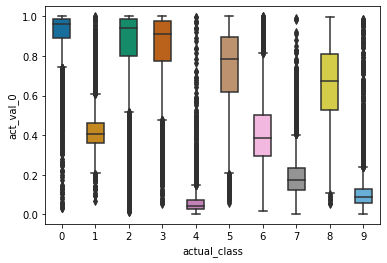

In [176]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
bplot = sns.boxplot(y='act_val_0', x='actual_class', 
                 data=activation_df[['act_val_0','actual_class']], 
                 width=0.5,
                 palette="colorblind")

## Experiment 2 <a class="anchor" id="Exp2"></a>
#### A hidden layer with 2 hidden nodes and 10 output nodes (corresponding to the 10 digits). 

In [177]:
# Two nodes and one layer
clf, hist = run_conv(nodes=2)

2022-04-15 20:31:51.011385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-15 20:31:54.737166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Keras model with layers 1 and nodes 2 fit time: 368.07


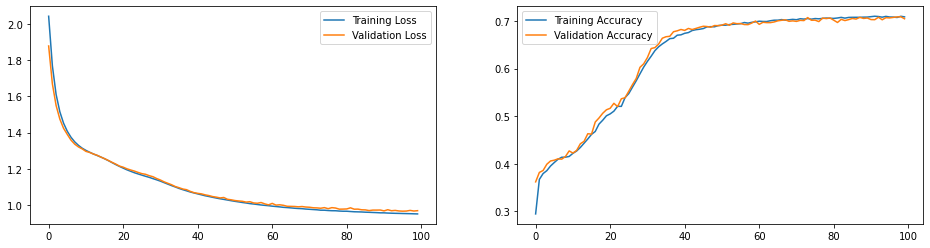

In [178]:
plot_hist(hist)

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_196 (Dense)           (None, 2)                 1570      
                                                                 
 dense_197 (Dense)           (None, 10)                30        
                                                                 
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________


2022-04-15 20:37:59.097939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Precision score: 0.702
Recall score: 0.705
Accuracy score: 0.705
F1 score: 0.699


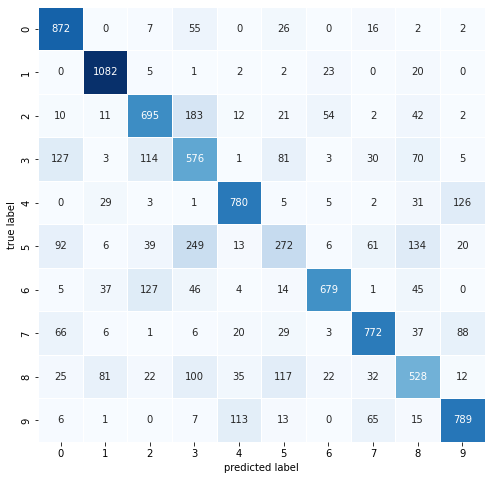

In [179]:
conv_test(clf)

In [185]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in clf.model_.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=clf.model_.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers

There are 2 layers


In [186]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  1 hidden node has one activation value per training image

2022-04-15 20:46:09.961444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(60000, 2)

In [187]:
#Get the dataframe of all the node values
activation_data = {'actual_class':y_train}
for k in range(0,2): 
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,5.000,0.000,4.000,1.000,9.000,2.000,1.000,3.000,1.000,4.000,3.000,5.000,3.000,6.000,1.000
act_val_0,0.273,0.057,0.381,0.740,0.000,0.418,0.779,0.384,0.719,0.329,0.268,0.528,0.523,1.000,0.788
act_val_1,0.901,0.915,0.093,0.193,0.096,0.898,0.175,0.844,0.153,0.074,0.861,0.574,0.972,0.575,0.167


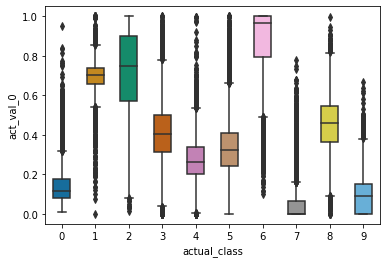

In [188]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
bplot = sns.boxplot(y='act_val_0', x='actual_class', 
                 data=activation_df[['act_val_0','actual_class']], 
                 width=0.5,
                 palette="colorblind")

## Experiment 3 <a class="anchor" id="Exp3"></a>
#### Experiment with hidden nodes to find the optimal. 

In [141]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

def run_conv_search(num_input=784, epochs=100):
    
    classifier = KerasClassifier(build_fn=create_model, layers=None, nodes=None, init=None, verbose=0, callbacks=[EarlyStopping(patience=5, verbose=1, mode="auto")])
    
    opt = BayesSearchCV(
        
        classifier,
        {
            'layers': (1, 2),
            'nodes': (8, 32, 64),  # integer valued parameter
            'init': ['glorot_uniform', 'glorot_normal', 'random_normal'],  # categorical parameter
        },
        n_iter=20,
        cv=3
    )
    
    print("Total iterations: {}".format(searchcv.total_iterations))
    
    start_time = timeit.default_timer()
    opt.fit(x_train_norm, 
                              y_train_encoded,
                              validation_data=(x_test_norm, y_test_encoded),
                              epochs=epochs, 
                              batch_size=100, 
                              verbose=0)
    stop_time = timeit.default_timer()


    print("Keras opt model fit time: {time}".format(time=round(stop_time - start_time, 2)))
    
    
    return opt

# One node and one layer
opt = run_conv_search()

2022-04-14 21:12:11.039325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:12:14.259497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 83: early stopping


2022-04-14 21:15:37.541870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:15:38.972283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:15:41.224421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 65: early stopping


2022-04-14 21:18:21.117649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:18:22.568826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:18:24.844234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 68: early stopping


2022-04-14 21:21:13.110515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:21:14.618229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:21:16.933817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 34: early stopping


2022-04-14 21:22:45.784797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:22:47.284375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:22:49.771881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 31: early stopping


2022-04-14 21:24:21.066546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:24:22.457359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:24:24.998185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 32: early stopping


2022-04-14 21:25:54.814849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:25:57.011150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:25:59.481037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 33: early stopping


2022-04-14 21:27:28.249963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:27:29.616809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:27:32.042517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 29: early stopping


2022-04-14 21:28:50.772777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:28:52.121774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:28:54.543858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 32: early stopping


2022-04-14 21:30:18.969221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:30:20.305089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:30:22.670477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 34: early stopping


2022-04-14 21:31:53.222983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:31:54.676128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:31:57.214351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 33: early stopping


2022-04-14 21:33:24.588870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:33:25.984887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:33:28.378337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 31: early stopping


2022-04-14 21:34:50.148687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:34:51.583664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:34:53.797693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 48: early stopping


2022-04-14 21:36:51.082330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:36:52.245689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:36:57.111342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 63: early stopping


2022-04-14 21:39:24.856364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:39:26.060455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:39:28.166332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 58: early stopping


2022-04-14 21:41:45.005287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:41:46.281372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:41:48.759581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 24: early stopping


2022-04-14 21:42:51.542724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:42:52.920022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:42:55.256058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 30: early stopping


2022-04-14 21:44:14.100960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:44:15.458846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:44:17.872425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 23: early stopping


2022-04-14 21:45:19.473417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:45:20.880755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:45:23.555288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 27: early stopping


2022-04-14 21:46:34.846979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:46:36.221719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:46:38.585932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 26: early stopping


2022-04-14 21:47:47.111742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:47:48.416896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:47:50.799772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 25: early stopping


2022-04-14 21:48:55.838411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:48:57.397360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:48:59.933585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 36: early stopping


2022-04-14 21:50:31.910391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:50:33.442765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:50:36.427173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 33: early stopping


2022-04-14 21:51:59.811728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:52:01.125031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:52:03.465372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 38: early stopping


2022-04-14 21:53:37.527498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:53:38.857302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:53:41.056112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 45: early stopping


2022-04-14 21:55:36.232824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:55:37.797841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:55:40.013617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping


2022-04-14 21:57:20.714389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:57:21.980565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:57:24.193000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 40: early stopping


2022-04-14 21:59:07.065583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:59:08.741253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 21:59:11.419422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 33: early stopping


2022-04-14 22:00:42.529961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:00:43.933165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:00:46.425638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 27: early stopping


2022-04-14 22:02:02.398593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:02:03.797872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:02:06.321619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 33: early stopping


2022-04-14 22:03:39.467754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:03:41.159682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:03:43.630351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 27: early stopping


2022-04-14 22:04:57.364069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:04:58.684576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:05:01.182405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 27: early stopping


2022-04-14 22:06:14.180387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:06:15.386538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:06:17.858683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 25: early stopping


2022-04-14 22:07:26.610752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:07:31.005265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:07:33.362070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping


2022-04-14 22:09:11.908746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:09:13.269928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:09:15.523265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 36: early stopping


2022-04-14 22:10:46.488934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:10:47.809971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:10:50.089970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 44: early stopping


2022-04-14 22:12:42.996726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:12:44.735169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:12:47.164452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 26: early stopping


2022-04-14 22:13:55.914323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:13:57.162138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:13:59.715178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 24: early stopping


2022-04-14 22:15:03.494105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:15:04.813516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:15:07.264322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 25: early stopping


2022-04-14 22:16:14.157671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:16:15.746634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:16:18.260608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 24: early stopping


2022-04-14 22:17:22.768251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:17:24.099549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:17:26.651665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 27: early stopping


2022-04-14 22:18:40.307862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:18:41.993684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:18:44.542372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 23: early stopping


2022-04-14 22:19:47.670270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:19:49.564209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:19:51.868799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 46: early stopping


2022-04-14 22:21:53.534988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:21:55.224789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:21:57.781848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping


2022-04-14 22:23:44.826436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:23:46.487036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:23:48.946593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 32: early stopping


2022-04-14 22:25:14.866528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:25:17.562968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:25:20.520231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 26: early stopping


2022-04-14 22:26:35.283061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:26:40.627963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:26:43.314961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 26: early stopping


2022-04-14 22:27:56.266886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:27:59.015623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:28:01.701258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 24: early stopping


2022-04-14 22:29:07.328563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:29:09.347415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:29:12.095665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 27: early stopping


2022-04-14 22:30:27.789949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:30:29.150193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:30:32.043208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 27: early stopping


2022-04-14 22:31:49.360966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:31:51.392706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:31:54.578166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 24: early stopping


2022-04-14 22:33:02.157650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:33:04.319658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:33:06.926164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 24: early stopping


2022-04-14 22:34:13.435384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:34:14.918098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:34:17.626985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 23: early stopping


2022-04-14 22:35:20.924126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:35:22.495729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:35:25.275683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 30: early stopping


2022-04-14 22:36:49.399149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:36:51.587867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:36:54.364354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 37: early stopping


2022-04-14 22:38:30.673382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:38:32.168990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:38:34.640310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 36: early stopping


2022-04-14 22:40:08.090034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:40:09.872841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:40:12.465189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 33: early stopping


2022-04-14 22:41:39.151189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:41:41.195137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:41:43.892818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 29: early stopping


2022-04-14 22:43:04.673543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:43:06.128133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:43:08.700662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 22: early stopping


2022-04-14 22:44:08.940680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:44:10.194161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:44:12.775949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 27: early stopping


2022-04-14 22:45:28.707699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:45:32.303191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-14 22:45:36.300319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 24: early stopping
Keras opt model fit time: 5695.13


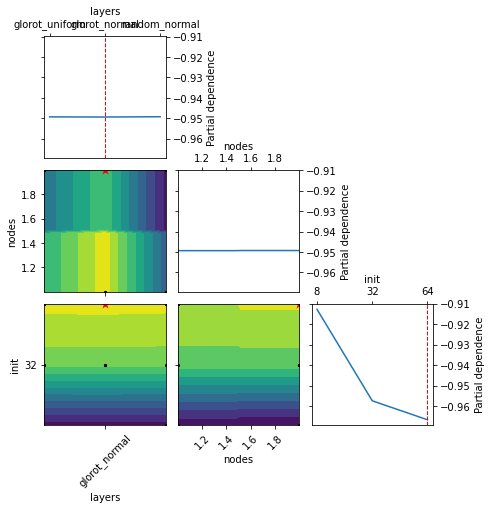

In [144]:
from skopt.plots import plot_objective, plot_histogram
_ = plot_objective(opt.optimizer_results_[0],
                   dimensions=["layers", "nodes", "init"],
                   n_minimum_search=int(1e8))
plt.show()

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_189 (Dense)           (None, 64)                50240     
                                                                 
 dense_190 (Dense)           (None, 64)                4160      
                                                                 
 dense_191 (Dense)           (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


2022-04-14 23:09:03.913249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Precision score: 0.974
Recall score: 0.974
Accuracy score: 0.974
F1 score: 0.974


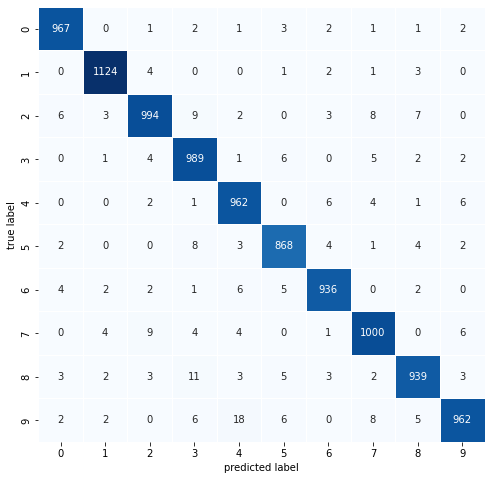

In [147]:
conv_test(opt.best_estimator_)

## Experiment 4 <a class="anchor" id="Exp4"></a>
#### Experiment use optimal model on PCA 

In [80]:
#define PCA model to use
pca = PCA(n_components=400)

#fit PCA model to data
start_time = timeit.default_timer()
pca_fit = pca.fit(x_train_norm)
stop_time = timeit.default_timer()

print("PCA fit time: {time}".format(time=round(stop_time - start_time, 2)))

PCA fit time: 5.87


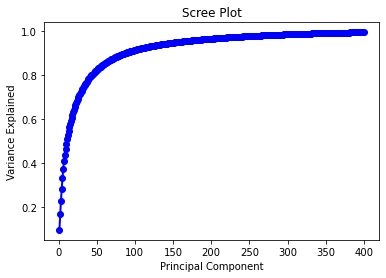

Number of PCAs that explain 99% of the varience: 331
Number of PCAs that explain 95% of the varience: 154
Number of PCAs that explain 85% of the varience: 59
Number of PCAs that explain 75% of the varience: 34


In [148]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, np.cumsum(pca.explained_variance_ratio_), 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

print( "Number of PCAs that explain 99% of the varience: {}".format(np.where(np.cumsum(pca.explained_variance_ratio_) > 0.99)[0].item(0) + 1))
print( "Number of PCAs that explain 95% of the varience: {}".format(np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0].item(0) + 1))
print( "Number of PCAs that explain 85% of the varience: {}".format(np.where(np.cumsum(pca.explained_variance_ratio_) > 0.85)[0].item(0) + 1))
print( "Number of PCAs that explain 75% of the varience: {}".format(np.where(np.cumsum(pca.explained_variance_ratio_) > 0.75)[0].item(0) + 1))

In [189]:
# Principle components that explain 95% varience
pca = PCA(n_components=154)

#fit PCA model to data
start_time = timeit.default_timer()
x_train_norm = pd.DataFrame(pca.fit_transform(x_train_norm.copy()))
stop_time = timeit.default_timer()

print("PCA fit time: {time}".format(time=round(stop_time - start_time, 2)))

x_test_norm = pd.DataFrame(pca.transform(x_test_norm.copy()))
x_train_norm

PCA fit time: 2.37


,0,1,2,3,4,5,6,7,8,9,...,144,145,146,147,148,149,150,151,152,153
0,0.487387,-1.225010,-0.097101,-2.177653,-0.107057,-0.913428,0.918076,0.625121,-1.425151,0.777625,...,-0.025550,-0.024256,-0.085278,-0.119107,-0.204644,0.224016,-0.118640,0.007980,0.215288,0.088126
1,3.968272,-1.156342,2.336522,-1.809618,-3.241816,-0.714814,-0.176753,-0.413155,0.162936,0.590969,...,0.021812,0.188182,0.080531,0.230709,-0.108365,0.013241,-0.073578,0.075828,-0.231211,-0.088087
2,-0.203338,1.537768,-0.739314,2.042814,-1.203062,-0.007560,-3.369266,1.444834,-0.449147,-0.698758,...,-0.142154,0.083863,0.324789,0.357085,0.240143,-0.142895,0.120578,0.251171,0.120495,-0.453557
3,-3.133885,-2.381213,1.073069,0.415336,-0.007435,2.743735,-1.857706,-0.263871,1.187098,0.043250,...,-0.013378,-0.013482,0.169514,-0.014326,-0.128929,0.012630,-0.063068,0.001971,0.014550,-0.000267
4,-1.501044,2.864897,0.064146,-0.947616,0.384972,0.169265,-0.359192,-1.592055,0.882400,0.408159,...,0.114125,-0.141576,0.008213,0.167521,0.044282,-0.039207,-0.180957,-0.142370,0.080275,-0.134244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,-0.390723,-1.150896,0.533080,-1.361261,1.193163,0.929368,-1.955172,-0.931729,-1.940858,1.256166,...,0.116818,0.150452,-0.089117,-0.246039,-0.260590,0.114688,-0.061376,-0.205619,-0.013648,0.265093
59996,0.598999,-2.697659,-0.348782,-2.549070,0.777982,0.724567,-1.910409,1.981854,-2.622944,0.106328,...,-0.270495,-0.031778,0.019820,-0.285174,-0.024817,0.088865,-0.049492,0.011756,-0.077578,-0.042313
59997,-0.698300,0.627787,-1.010282,-2.802492,-0.824899,-1.813590,-1.821760,-0.724787,-0.343318,1.051430,...,0.080718,-0.181336,0.040502,-0.197387,-0.031987,-0.131845,0.200415,0.197323,-0.026167,-0.013906
59998,0.512151,-0.021937,2.015120,1.344016,-2.043893,-2.119812,-0.421132,0.551890,-0.064700,-0.367994,...,0.326391,0.174546,-0.448156,0.005053,-0.087690,-0.216633,-0.119714,0.068550,-0.253489,-0.029241


In [190]:
clf, hist = run_conv(layers=2, nodes=64, num_input=154)

2022-04-15 21:24:10.085151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-15 21:24:15.640047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 20: early stopping
Keras model with layers 2 and nodes 64 fit time: 82.74


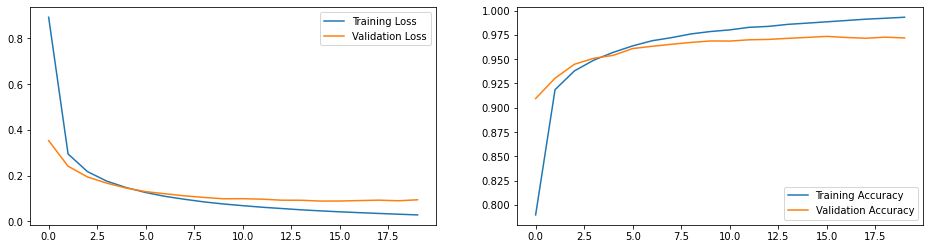

In [191]:
plot_hist(hist)

Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_198 (Dense)           (None, 64)                50240     
                                                                 
 dense_199 (Dense)           (None, 64)                4160      
                                                                 
 dense_200 (Dense)           (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


2022-04-15 21:28:23.006390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Precision score: 0.972
Recall score: 0.972
Accuracy score: 0.972
F1 score: 0.972


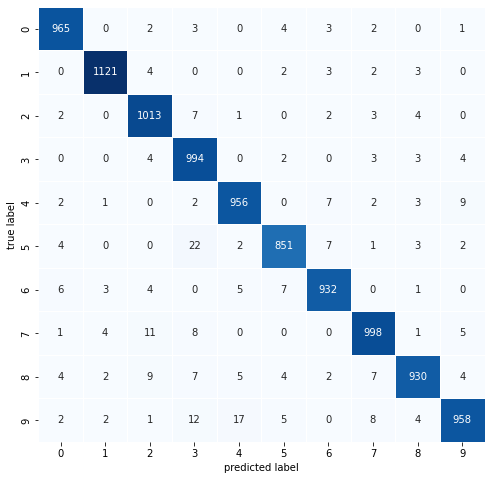

In [192]:
conv_test(clf)

## Experiment 5 <a class="anchor" id="Exp5"></a>
#### Experiment use optimal model on top 70 pixels 

In [201]:
x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255

x_train_norm = x_train_norm[:,idx]
x_test_norm = x_test_norm[:,idx]

clf, hist = run_conv(layers=2, nodes=64, num_input=70)

2022-04-16 20:23:56.530347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 20:24:00.474950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 69: early stopping
Keras model with layers 2 and nodes 64 fit time: 272.3


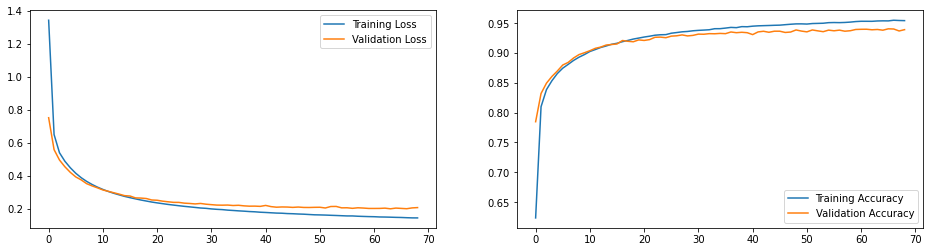

In [202]:
plot_hist(hist)

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_208 (Dense)           (None, 64)                4544      
                                                                 
 dense_209 (Dense)           (None, 64)                4160      
                                                                 
 dense_210 (Dense)           (None, 10)                650       
                                                                 
Total params: 9,354
Trainable params: 9,354
Non-trainable params: 0
_________________________________________________________________


2022-04-16 20:29:17.349388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Precision score: 0.940
Recall score: 0.939
Accuracy score: 0.939
F1 score: 0.939


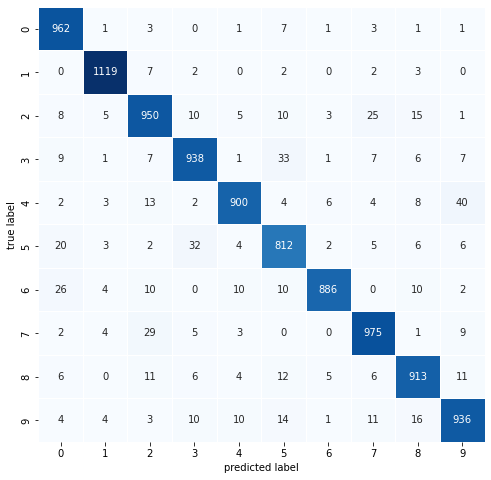

In [203]:
conv_test(clf)

# Additional Experiment <a class="anchor" id="ExpAdd"></a>
#### Experiment using multiple model averaging and check kaggle score

In [210]:
number_of_models = 25
model_bag = []


x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255

def run_multi_conv(layers=1, nodes=1, num_input=784, epochs=100):
    
    
    classifier = KerasClassifier(build_fn=lambda: create_model(layers=layers, num_input=num_input, 
                                                               nodes=nodes, init='random_normal'), 
                                 callbacks=[EarlyStopping(patience=5, verbose=5, mode="auto")],
                                 verbose=0)
    
    start_time = timeit.default_timer()
    fit_hist = classifier.fit(x_train_norm, 
                              y_train_encoded,
                              validation_data=(x_test_norm, y_test_encoded),
                              epochs=epochs, 
                              batch_size=random.randint(1, 10) * 50, 
                              verbose=0,
                              shuffle=True)
    stop_time = timeit.default_timer()


    print("Keras model with layers {num_layers} and nodes {num_nodes} fit time: {time}".format(time=round(stop_time - start_time, 2),
                                                                         num_layers=layers,
                                                                         num_nodes=nodes))
    
    
    
    return classifier, fit_hist

for i in range(number_of_models):
    model_bag.append(run_multi_conv(layers=2, nodes=64))

2022-04-16 21:59:00.059470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 21:59:02.061119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 40: early stopping
Keras model with layers 2 and nodes 64 fit time: 58.33


2022-04-16 21:59:58.009515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 21:59:59.131692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 50: early stopping
Keras model with layers 2 and nodes 64 fit time: 44.25


2022-04-16 22:00:42.429691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 22:00:45.425475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 31: early stopping
Keras model with layers 2 and nodes 64 fit time: 90.83


2022-04-16 22:02:13.182184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 22:02:14.939734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 34: early stopping
Keras model with layers 2 and nodes 64 fit time: 50.3


2022-04-16 22:03:03.396155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 22:03:05.556843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 32: early stopping
Keras model with layers 2 and nodes 64 fit time: 66.83


2022-04-16 22:04:10.304386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 22:04:14.219114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 21: early stopping
Keras model with layers 2 and nodes 64 fit time: 87.99


2022-04-16 22:05:38.230435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 22:05:39.559990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 41: early stopping
Keras model with layers 2 and nodes 64 fit time: 45.06


2022-04-16 22:06:23.276477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 22:06:24.755138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping
Keras model with layers 2 and nodes 64 fit time: 57.78


2022-04-16 22:07:21.010796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 22:07:22.008373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 45: early stopping
Keras model with layers 2 and nodes 64 fit time: 41.37


2022-04-16 22:08:02.419274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 22:08:03.646283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 48: early stopping
Keras model with layers 2 and nodes 64 fit time: 54.79


2022-04-16 22:08:57.149147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 22:09:01.196277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 25: early stopping
Keras model with layers 2 and nodes 64 fit time: 110.91


2022-04-16 22:27:41.029751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 22:27:42.126078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 42: early stopping
Keras model with layers 2 and nodes 64 fit time: 39.98


2022-04-16 22:28:20.954747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 22:43:36.027651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 26: early stopping
Keras model with layers 2 and nodes 64 fit time: 81.14


2022-04-16 22:44:53.531072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 22:44:54.988401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 40: early stopping
Keras model with layers 2 and nodes 64 fit time: 46.36


2022-04-16 22:45:39.816727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 22:45:41.341149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 38: early stopping
Keras model with layers 2 and nodes 64 fit time: 58.2


2022-04-16 22:46:38.102605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 22:46:39.792932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping
Keras model with layers 2 and nodes 64 fit time: 57.35


2022-04-16 22:47:35.394221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 22:47:36.588623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping
Keras model with layers 2 and nodes 64 fit time: 44.2


2022-04-16 22:48:19.491728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 22:48:22.288709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 25: early stopping
Keras model with layers 2 and nodes 64 fit time: 75.43


2022-04-16 22:49:34.909977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 22:49:42.579512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 19: early stopping
Keras model with layers 2 and nodes 64 fit time: 162.89


2022-04-16 22:52:17.866212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 22:52:18.898997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 54: early stopping
Keras model with layers 2 and nodes 64 fit time: 51.09


2022-04-16 22:53:08.996447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 22:53:13.094052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 19: early stopping
Keras model with layers 2 and nodes 64 fit time: 84.03


2022-04-16 22:54:33.015903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 22:54:34.540382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 36: early stopping
Keras model with layers 2 and nodes 64 fit time: 54.85


2022-04-16 22:55:27.791460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 22:55:30.596375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 29: early stopping
Keras model with layers 2 and nodes 64 fit time: 87.66


2022-04-16 22:56:55.506894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 22:56:57.072571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 35: early stopping
Keras model with layers 2 and nodes 64 fit time: 51.35


2022-04-16 22:57:47.003938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-16 22:57:48.625857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 36: early stopping
Keras model with layers 2 and nodes 64 fit time: 52.74


Precision score: 0.980
Recall score: 0.980
Accuracy score: 0.980
F1 score: 0.980


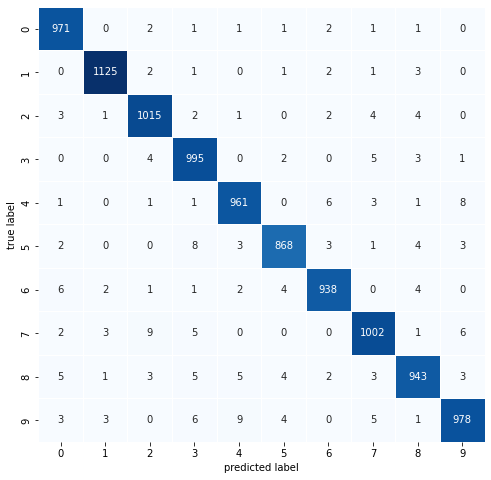

In [212]:
def multi_conv_test(clf_list):
    
    first = True
    y_pred = None
    for c, h in clf_list:
        if first:
            y_pred = c.predict(x_test_norm)
            first = False
        else:
            y_pred = y_pred + c.predict(x_test_norm)
    
    pred_classes = np.argmax(y_pred, axis=-1)

    plot_confusion_matrix(y_test, pred_classes)

    ax.set_title('Confusion Matrix\n');
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values')
    
    # Let's also print the accuracy and recall scores
    print("Precision score: {:.3f}".format(sklearn.metrics.precision_score(y_test, pred_classes, average='weighted')))
    print("Recall score: {:.3f}".format(sklearn.metrics.recall_score(y_test, pred_classes, average='weighted')))
    print("Accuracy score: {:.3f}".format(sklearn.metrics.accuracy_score(y_test, pred_classes)))
    print("F1 score: {:.3f}".format(sklearn.metrics.f1_score(y_test, pred_classes, average='weighted')))
    
    return pred_classes
    
predictions = multi_conv_test(model_bag)

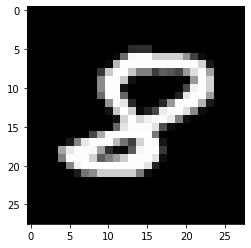

Actual: 8 Predicted: 2


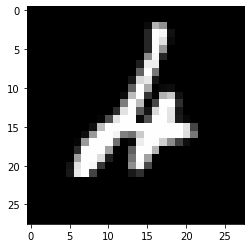

Actual: 4 Predicted: 6


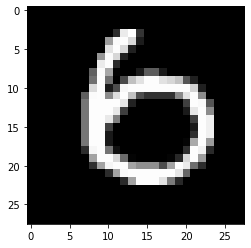

Actual: 6 Predicted: 0


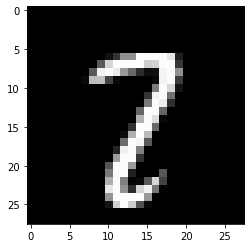

Actual: 2 Predicted: 7


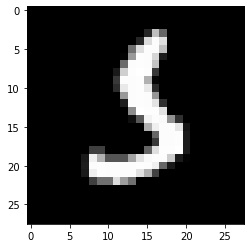

Actual: 5 Predicted: 3


In [217]:
# Check some wrong answers

wrong = (y_test!=predictions)

# Really want to see what got misclassified here, just grab the first five

for i in range(5):
    first_image = x_test[np.where(wrong)[0][i]]
    first_image = np.array(first_image, dtype='float')
    pixels = first_image.reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.show()

    print("Actual: {} Predicted: {}".format(y_test[np.where(wrong)[0][i]], predictions[np.where(wrong)[0][i]]))

In [221]:
digitsTestDf = pd.read_csv('../../digits/digit-recognizer/test.csv')

allPreds = []
isFirst = True
i = 0
for m, hist in model_bag:

    if isFirst:
        allPreds = m.predict(digitsTestDf.astype('float32') / 255)
        isFirst = False
    else:
        allPreds = allPreds + m.predict(digitsTestDf.astype('float32') / 255)

predictions = np.argmax(allPreds, axis=-1)

df = pd.DataFrame(predictions, columns=["Label"])
df.index += 1 

df.to_csv("predictions_25_models.csv", index_label="ImageId")

2022-04-17 10:52:06.947088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-17 10:52:10.357473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-17 10:52:12.232811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-17 10:52:14.023038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-17 10:52:16.025052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-17 10:52:17.867913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-17 10:52:19.473410: I tensorflow/core/grappler/optimizers/cust

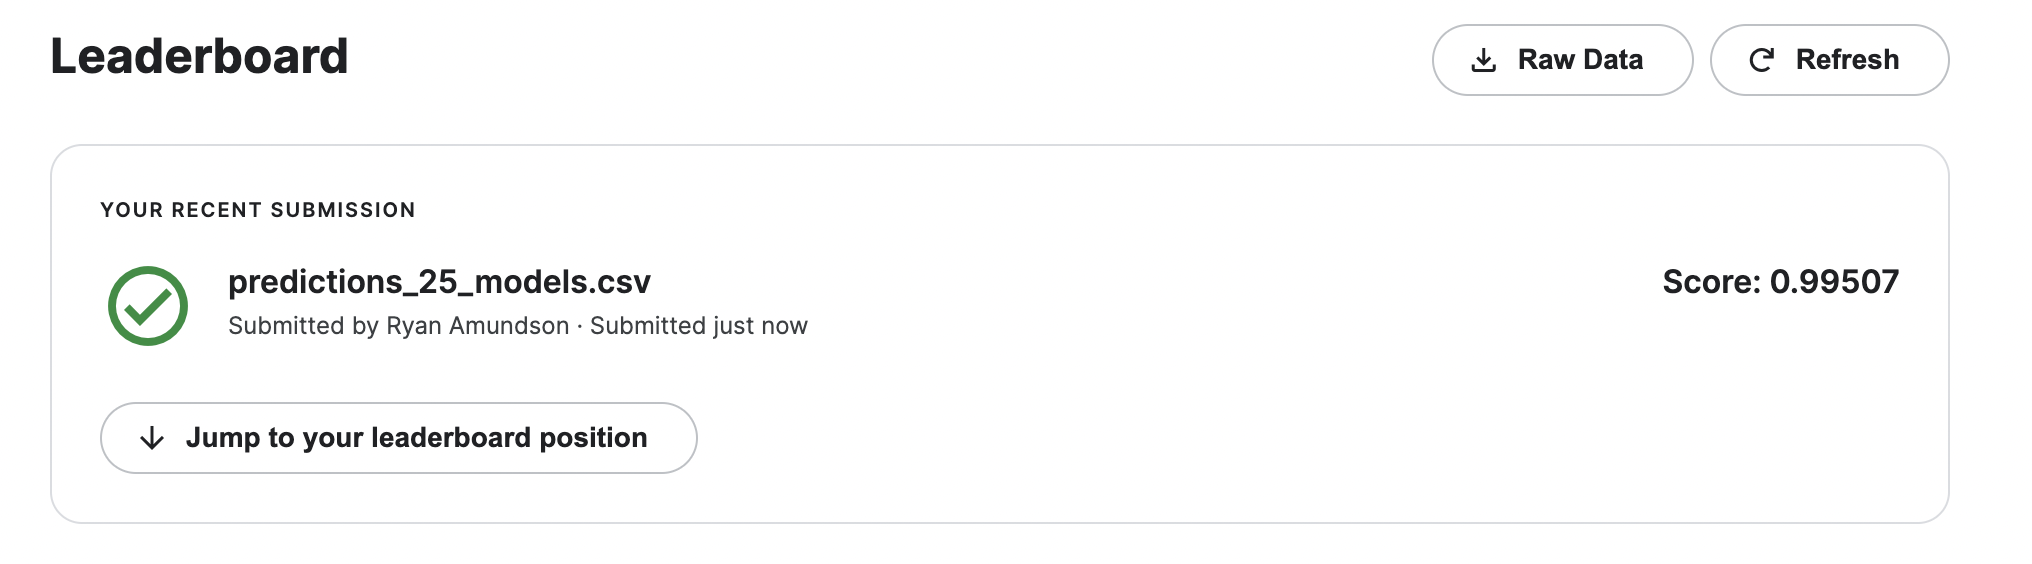

In [222]:

from IPython import display
from base64 import b64decode
base64_data = "iVBORw0KGgoAAAANSUhEUgAAB/AAAAI0CAYAAAAKiLGaAAAMbWlDQ1BJQ0MgUHJvZmlsZQAASImVVwdYU8kWnluSkJDQAghICb0jUgNICaEFkF4EGyEJJJQYE4KKvSwquHYRxYquiii2lWYBsSuLYu+LBRVlXdTFhsqbkICu+8r3zvfNvX/OnPlPuTO59wCg+YErkeShWgDkiwukCeHBjDFp6QzSU4AAdUAHGgBweTIJKy4uGkAZvP9d3t2A1lCuOiu4/jn/X0WHL5DxAEDGQZzJl/HyIW4GAN/Ak0gLACAq9JZTCiQKPAdiXSkMEOLVCpytxLsUOFOJjw7YJCWwIb4MgBqVy5VmA6BxD+oZhbxsyKPxGWJXMV8kBkDTCeIAnpDLh1gRu1N+/iQFLofYDtpLIIbxAGbmd5zZf+PPHOLncrOHsDKvAVELEckkedxp/2dp/rfk58kHfdjAQRVKIxIU+cMa3sqdFKXAVIi7xZkxsYpaQ/xBxFfWHQCUIpRHJCvtUWOejA3rB/QhduVzQ6IgNoY4TJwXE63SZ2aJwjgQw92CThUVcJIgNoB4kUAWmqiy2SKdlKDyhdZmSdkslf4cVzrgV+HrgTw3maXifyMUcFT8mEaRMCkVYgrEVoWilBiI4Q7EXGS5iVEqm1FFQnbMoI1UnqCI3wriBIE4PFjJjxVmScMSVPYl+bLBfLEtQhEnRoUPFgiTIpT1wU7xuAPxw1ywywIxK3mQRyAbEz2YC18QEqrMHXsuECcnqng+SAqCE5RrcYokL05lj1sI8sIVeguIPWSFiaq1eEoB3JxKfjxLUhCXpIwTL8rhRsYp48GXg2jABiGAAeRwZIJJIAeI2rrruuEv5UwY4AIpyAYC4KzSDK5IHZgRw2siKAJ/QCQAsqF1wQOzAlAI9V+GtMqrM8gamC0cWJELnkKcD6JAHvwtH1glHvKWAp5Ajegf3rlw8GC8eXAo5v+9flD7TcOCmmiVRj7okaE5aEkMJYYQI4hhRHvcCA/A/fBoeA2Cww1n4j6DeXyzJzwltBMeEa4TOgi3J4rmSX+IcjTogPxhqlpkfl8L3AZyeuLBuD9kh8y4Pm4EnHEP6IeFB0LPnlDLVsWtqArjB+6/ZfDd01DZkV3JKHkYOYhs9+NKDQcNzyEWRa2/r48y1syherOHZn70z/6u+nx4j/rREluEHcLOYiew89hRrA4wsCasHmvFjinw0O56MrC7Br0lDMSTC3lE//DHVflUVFLmWu3a5fpZOVcgmFqgOHjsSZJpUlG2sIDBgm8HAYMj5rk4Mdxc3dwAULxrlH9fb+MH3iGIfus33fzfAfBv6u/vP/JNF9kEwAFvePwbvunsmABoqwNwroEnlxYqdbjiQoD/EprwpBkCU2AJ7GA+bsAL+IEgEAoiQSxIAmlgAqyyEO5zKZgCZoC5oBiUguVgDVgPNoNtYBfYCw6COnAUnABnwEVwGVwHd+Hu6QQvQQ94B/oQBCEhNISOGCJmiDXiiLghTCQACUWikQQkDclAshExIkdmIPORUmQlsh7ZilQhB5AG5ARyHmlHbiMPkS7kDfIJxVAqqouaoDboCJSJstAoNAkdj2ajk9EidAG6FC1HK9E9aC16Ar2IXkc70JdoLwYwdUwfM8ecMSbGxmKxdCwLk2KzsBKsDKvEarBG+JyvYh1YN/YRJ+J0nIE7wx0cgSfjPHwyPgtfgq/Hd+G1+Cn8Kv4Q78G/EmgEY4IjwZfAIYwhZBOmEIoJZYQdhMOE0/AsdRLeEYlEfaIt0RuexTRiDnE6cQlxI3EfsZnYTnxM7CWRSIYkR5I/KZbEJRWQiknrSHtITaQrpE7SBzV1NTM1N7UwtXQ1sdo8tTK13WrH1a6oPVPrI2uRrcm+5FgynzyNvIy8ndxIvkTuJPdRtCm2FH9KEiWHMpdSTqmhnKbco7xVV1e3UPdRj1cXqc9RL1ffr35O/aH6R6oO1YHKpo6jyqlLqTupzdTb1Lc0Gs2GFkRLpxXQltKqaCdpD2gfNOgaLhocDb7GbI0KjVqNKxqvNMma1poszQmaRZplmoc0L2l2a5G1bLTYWlytWVoVWg1aN7V6tenaI7VjtfO1l2jv1j6v/VyHpGOjE6rD11mgs03npM5jOka3pLPpPPp8+nb6aXqnLlHXVpejm6NbqrtXt023R09Hz0MvRW+qXoXeMb0OfUzfRp+jn6e/TP+g/g39T8NMhrGGCYYtHlYz7Mqw9wbDDYIMBAYlBvsMrht8MmQYhhrmGq4wrDO8b4QbORjFG00x2mR02qh7uO5wv+G84SXDDw6/Y4waOxgnGE833mbcatxrYmoSbiIxWWdy0qTbVN80yDTHdLXpcdMuM7pZgJnIbLVZk9kLhh6DxchjlDNOMXrMjc0jzOXmW83bzPssbC2SLeZZ7LO4b0mxZFpmWa62bLHssTKzGm01w6ra6o412ZppLbRea33W+r2NrU2qzUKbOpvntga2HNsi22rbe3Y0u0C7yXaVdtfsifZM+1z7jfaXHVAHTwehQ4XDJUfU0ctR5LjRsd2J4OTjJHaqdLrpTHVmORc6Vzs/dNF3iXaZ51Ln8mqE1Yj0EStGnB3x1dXTNc91u+vdkTojI0fOG9k48o2bgxvPrcLtmjvNPcx9tnu9+2sPRw+BxyaPW550z9GeCz1bPL94eXtJvWq8urytvDO8N3jfZOoy45hLmOd8CD7BPrN9jvp89PXyLfA96Punn7Nfrt9uv+ejbEcJRm0f9djfwp/rv9W/I4ARkBGwJaAj0DyQG1gZ+CjIMogftCPoGcuelcPaw3oV7BosDT4c/J7ty57Jbg7BQsJDSkLaQnVCk0PXhz4IswjLDqsO6wn3DJ8e3hxBiIiKWBFxk2PC4XGqOD2R3pEzI09FUaMSo9ZHPYp2iJZGN45GR0eOXjX6Xox1jDimLhbEcmJXxd6Ps42bHHcknhgfF18R/zRhZMKMhLOJ9MSJibsT3yUFJy1LuptslyxPbknRTBmXUpXyPjUkdWVqx5gRY2aOuZhmlCZKq08npaek70jvHRs6ds3YznGe44rH3RhvO37q+PMTjCbkTTg2UXMid+KhDEJGasbujM/cWG4ltzeTk7khs4fH5q3lveQH8VfzuwT+gpWCZ1n+WSuznmf7Z6/K7hIGCsuE3SK2aL3odU5Ezuac97mxuTtz+/NS8/blq+Vn5DeIdcS54lOTTCdNndQucZQUSzom+05eM7lHGiXdIUNk42X1Bbrwo75Vbif/Sf6wMKCwovDDlJQph6ZqTxVPbZ3mMG3xtGdFYUW/TMen86a3zDCfMXfGw5msmVtnIbMyZ7XMtpy9YHbnnPA5u+ZS5ubO/W2e67yV8/6anzq/cYHJgjkLHv8U/lN1sUaxtPjmQr+Fmxfhi0SL2ha7L163+GsJv+RCqWtpWennJbwlF34e+XP5z/1Ls5a2LfNatmk5cbl4+Y0VgSt2rdReWbTy8arRq2pXM1aXrP5rzcQ158s8yjavpayVr+0ojy6vX2e1bvm6z+uF669XBFfs22C8YfGG9xv5G69sCtpUs9lkc+nmT1tEW25tDd9aW2lTWbaNuK1w29PtKdvP/sL8pWqH0Y7SHV92ind27ErYdarKu6pqt/HuZdVotby6a8+4PZf3huytr3Gu2bpPf1/pfrBfvv/FgYwDNw5GHWw5xDxU86v1rxsO0w+X1CK102p76oR1HfVp9e0NkQ0tjX6Nh4+4HNl51PxoxTG9Y8uOU44vON7fVNTU2yxp7j6RfeJxy8SWuyfHnLx2Kv5U2+mo0+fOhJ05eZZ1tumc/7mj533PN1xgXqi76HWxttWz9fBvnr8dbvNqq73kfan+ss/lxvZR7cevBF45cTXk6plrnGsXr8dcb7+RfOPWzXE3O27xbz2/nXf79Z3CO31359wj3Cu5r3W/7IHxg8rf7X/f1+HVcexhyMPWR4mP7j7mPX75RPbkc+eCp7SnZc/MnlU9d3t+tCus6/KLsS86X0pe9nUX/6H9x4ZXdq9+/TPoz9aeMT2dr6Wv+98seWv4dudfHn+19Mb1PniX/67vfckHww+7PjI/nv2U+ulZ35TPpM/lX+y/NH6N+nqvP7+/X8KVcgc+BTA40KwsAN7sBICWBgAd9m2UscpecEAQZf86gMB/wsp+cUC8AKiB3+/x3fDr5iYA+7fD9gvya8JeNY4GQJIPQN3dh4ZKZFnubkouKuxTCA/6+9/Cno20CoAvy/v7+yr7+79sg8HC3rFZrOxBFUKEPcOWuC+Z+Zng34iyP/0uxx/vQBGBB/jx/i+hZpCdk9ZaYwAAAIplWElmTU0AKgAAAAgABAEaAAUAAAABAAAAPgEbAAUAAAABAAAARgEoAAMAAAABAAIAAIdpAAQAAAABAAAATgAAAAAAAACQAAAAAQAAAJAAAAABAAOShgAHAAAAEgAAAHigAgAEAAAAAQAAB/CgAwAEAAAAAQAAAjQAAAAAQVNDSUkAAABTY3JlZW5zaG90ffnvuAAAAAlwSFlzAAAWJQAAFiUBSVIk8AAAAddpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDYuMC4wIj4KICAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgICAgPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIKICAgICAgICAgICAgeG1sbnM6ZXhpZj0iaHR0cDovL25zLmFkb2JlLmNvbS9leGlmLzEuMC8iPgogICAgICAgICA8ZXhpZjpQaXhlbFlEaW1lbnNpb24+NTY0PC9leGlmOlBpeGVsWURpbWVuc2lvbj4KICAgICAgICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjIwMzI8L2V4aWY6UGl4ZWxYRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICA8L3JkZjpEZXNjcmlwdGlvbj4KICAgPC9yZGY6UkRGPgo8L3g6eG1wbWV0YT4KFbNpXQAAABxpRE9UAAAAAgAAAAAAAAEaAAAAKAAAARoAAAEaAAJ8wapvqDUAAEAASURBVHgB7L0J2GZVcS66upmhAQVkkllEFEfQcxKNEWfB3CcazeAUhUaNs56Y3BPFxJxjTDTnyTmJ4BBM8txzEzM4xJw43shglDiB2jgzz4NMCg0q0N231qr1vqtqrb3/7v7pmdrKrreq3rVq7/pq1d797e/7/iVrZEsTWzYusXYxrBEDbHnUkqoo14wALHJNWiOjME6nBMEG8HhgiCHiR/5RR1F/sf6i/9huajomYJHRf+P6E9dfXDfsivF3HF7DEqJVDHH/EfcfqKO4/4j7j7j/sN3UdEzAIuP+I+4/4v4D1w27YnhvMQGwhOgSQ9x/xP0H6ijuP+L+I+4/bDc1HROwyLj/iPuPuP/AdcOuGN5bTAAsIbrEEPcfcf+BOor7j7j/iPsP201NxwQscuPefyzBA/whjF2h7OINDPzmEuTOoHkGMwx5RHebEfFbh2gZJBryRU8GyCtkdUKFJC/yP+Qz6i/qD1cot7ZUGerFcbDAIGP9lQwgHZDRfyQteks81FP0n+g/0X9cV7XKsF6sk32FjUa9UCHJi/ufIZ/Rf6L/RP9xXcUqw3qxTvYVNproPzkDSAckDdF/h3qK/hv9N/qv66pWGdaLdbKvsNGoFyokedF/hnxG/4n+E/3HdRWrDOvFOtlX2Gii/+QMIB2QNET/Heop+m/03+i/rqtaZVgv1sm+wkajXqiQ5G29/WfJmtXSKfCxmpoEnp/o+Qv6S2ohWbvLV+bJf26aztCpZXixTTisKeJH/qP+8JCvW2NmEdo10xZXIwx+cRXbhMOaYv3F+ov1F+svdxLbF1pnUTT4OkOnlkHFNuGwpug/0X+i/0T/yQ3D9gXtOm0/+DpDp5aBxTbhsKboP9F/ov9E/8kNw/aF1nkUDb7O0KllULFNOKwp+k/0n+g/0X9yw7B9QbtO2w++ztCpZWCxTTisKfpP9J/oP9F/csOwfaF1HkWDrzN0ahlUbBMOa4r+E/0n+k/0n9wwbF/QrtP2g68zdGoZWGwTDmva0vsPv4GvqbCHni1Wt1jZzl1NGKNs2dvfXQFn9tNFfQyrWxzxSwYmUhL516RwH/U3PvWP9Tfz6b5+QVnd4ug/0X8kAxMlAaO6ZB/9J/qP3n/XppHrRupi8tO1fUFZ3eI61YQp6k+Twn2sv1h/sf5a78ko+k/037j++DVRtP6CanWL69AJU1x/NSncx/U3rr9x/fW9Jq6/cf2N669fE3H9lQz0NxRWt7imbsKEOdQl+7j+xvU3rr++18T1N66/28j1tzzAt58y0AtArve66suVgJeDshDQD5rVW/xqES0T824yaeKRBYVP2UT8kizJV+Q/V43e07RKyyZfberL9kpWaPclpbKL+rNZIY71F/0n+q/tKnlpRP8tDaK0V+2xpY22zNR/bqqvcKtFsdmXgbKL/muS0mD03+i/0X+j/2pH6Lpsaa9lV7pr5thMLXE9V3mts1RUppRd9N8hNdkQ/Tf6b/Rf21Xyqoj735wFba/Rf3M9lMtIq4x65dHclFy5a5Fayr4MlF1cf0xSGozrT1x/4voT1x/tCF2XLe217KL/1pZpKyX+/aO10WoH2WnXFy0c4cX11ySlwbj+xvV3q73+SvHmPycgi7tdJArM9T3RC1rZe5RH560McYra7X5wl9Bl1w6Fk9mR89jN6ZRxzOAuocsu4ku64vWvNRP1Py6eGYtbU04ZBwzusvTKLtafpCvWX62ZWH/j4pmxuDXllHHA4C5Lr+xi/Um6Yv3Vmon1Ny6eGYtbU04ZBwzusvTKLtafpCvWX62ZWH/j4pmxuDXllHHA4C5Lr+xi/Um6Yv3Vmon1Ny6eGYtbU04ZBwzusvTKLtafpCvWX62ZWH/j4pmxuDXllHHA4C5Lr+xi/Um6Yv3Vmon1Ny6eGYtbU04ZBwzusvTKLtafpCvWX62ZWH/j4pmxuDXllHHA4C5Lr+xi/Um6Yv3VmtkK1t+S1fIA3x+nFrKegin1arbezFF9xlnzkElrpCqW8BMBmCV/dqBZW0wcUeblTfSZEGqecergMjbi20zXfElSrVXTBV/WMs5b5D/qz5VBqYq802qpNWNLhwwlxfqzKw2JivVns6Ilg9xkLeO8Rf+J/uPKoFRF3mm11JqxpUOGkqL/2JWGREX/sVnRkkFuspZx3qL/RP9xZVCqIu+0WmrN2NIhQ0nRf+xKQ6Ki/9isaMkgN1nLOG/Rf6L/uDIoVZF3Wi21ZmzpkKGk6D92pSFR0X9sVrRkkJusZZy36D/Rf1wZlKrIO62WWjO2dMhQUvQfu9KQqOg/NitaMshN1jLOW/Sf6D+uDEpV5J1WS60ZWzpkKCn6j11pSFT0H5sVLRnkJmsZ5y36T/QfVwalKvJOq6XWjC0dMpS0sfqP/IT+aglbf4hk5gBmzPYQF8RufFbyJmtCN/WWvSPCjyQ1fX2RmzYreYv4mgdbgi5R1S1ixtwIa0FufORfsxX1V6tGq6PsXaG0opoxN8JakBuflbxF/jUPsf5LMZQacYVS0yNixtwIa0FufFbyFvWneYj6K8VQasQVSk2PiBlzI6wFufFZyVvUn+Yh6q8UQ6kRVyg1PSJmzI2wFuTGZyVvUX+ah6i/UgylRlyh1PSImDE3wlqQG5+VvEX9aR6i/koxlBpxhVLTI2LG3AhrQW58VvIW9ad5iPorxVBqxBVKTY+IGXMjrAW58VnJW9Sf5iHqrxRDqRFXKDU9ImbMjbAW5MZnJW9Rf5qHqL9SDKVGXKHU9IiYMTfCWpAbn5W8Rf1pHqL+SjGUGnGFUtMjYsbcCGtBbnxW8hb1p3mI+ivFUGrEFUpNj4gZcyOsBbnxWclb1J/mYSuvP3mALz+hnzf3Ktdzg8iU/PczROSv6/O1h38B2aad+rSPGdiIxlhhxI/8R/3F+ov+E/03rj9x/R3vEGYt7bYi7j/GTxubtLVEGWOFcf8V919x/xX3X3H/Ffdfcf8V91/jHcKspd1WxP1X3H/1v7ZpyqYVijFWGPefcf8Z959x/xn3n3H/Gfefcf853iHMWtptRdx/xv3ntnf/OfET+vamOePpx/VtYUysnezENjm8jhYx+4GActOeJ5mcYMHPGxRnxNcMTKYv8l/qKuov1p+sj+klIsVRHJPe6D+znVkcub1gm0xf9J/oP1IY0X+j/0oZTLeI6L9x/ckXkcnqiOvvbGbEEdffXDi6TZZP3H/E/YcURtx/xP2HlMF0i4j7j7j/yJeQyeqI+4/ZzIgj7j9y4eg2WT5x/xH3H1IYcf8R9x9SBtMtIu4/4v4jX0ImqyPuP2YzI4770P0Hf0I/l8pUVdRbjeImAUbI6m1CHXBD0u8MRjEQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGoyQIFOqA27Izl1V4zUQXG+qGowi2zfwjXHmQx+Ysz7nxwCaCUZPb2k6EQAkZxuBUuaJo6e3NJ0IAHIMS4tS5omjp7c0nQgAktFGoJR54ujpLU0nAoAcw9KilHni6OktTScCgGS0EShlnjh6ekvTiQAgx7C0KGWeOHp6S9OJACAZbQRKmSeOnt7SdCIAyDEsLUqZJ46e3tJ0IgBIRhuBUuaJo6e3NJ0IAHIMS4tS5omjp7c0nQgAktFGoJR54ujpLU0nAoAcw9KilHni6OktTScCgGS0EShlnjh6ekvTiQAgx7C0KGWeOHp6S9OJACAZbQRKmSeOnt7SdCIAyDEsLUqZJ46e3tJ0IgBIRhuBUuaJo6e3NJ0IAHIMS4tS5omjp7c0nQgAktFGoJR54ujpLU0nAoAcw9KilHni6OktTScCgGS0EShlnjh6ekvTiQAgx7C0KGWeOHp6S9OJACAZbQRKmSeOnt7SdCIAyDEsLUqZJ46e3tJ0IgBIRhuBUuaJo6e3NJ0IAHIMS4tS5omjp7c0nQgAktFGoJR54ujpLU0nAoAcw9KilHni6OktTScCgGS0EShlnjh6ekvTiQAgx7C0KGWeOHp6S9OJACAZbQRKmSeOnt7SdCIAyDEsLUqZJ46e3tJ0IgBIRhuBUuaJo6e3NJ0IAHIMS4tS5omjp7c0nQgAktFGoJR54ujpLU0nAoAcw9KilHni6OktTScCgGS0EShlnjh6ekvTiQAgx7C0KGWeOHp6S9OJACAZbQRKmSeOnt7SdCIAyDEsLUqZJ46e3tJ0IgBIRhuBUuaJo6e3NJ0IAHIMS4tS5omjp7c0nQgAktFGoJR54ujpLU0nAoAcw9KilHni6OktTScCgGS0EShlnjh6ekvTiQAgx7C0KGWeOHp6S9OJACAZbQRKmSeOnt7SdCIAyDEsLUqZJ46e3tJ0IgBIRhuBUuaJo6e3NJ0IAHIMS4tS5omjp7c0nQgAktFGoJR54ujpLU0nAoAcw9KilHni6OktTScCgGS0EShlnjh6ekvTiQAgx7C0KGWeOHp6S9OJACAZbQRKmSeOnt7SdCIAyDEsLUqZJ46e3tJ0IgBIRhuBUuaJo6e3NJ0IAHIMS4tS5omjp7c0nQgAktFGoJR54ujpLU0nAoAcw9KilHni6OktTScCgGS0EShlnjh6ekvTiQAgx7C0KGWeOHp6S9OJACAZbQRK0b18Az//Vr3dMAPM+SccBOO37uFWq3nWDweknbNhegug1gj8GYDsy1vEj/xLLUT9cSlg0fnVAw1SV0+/p7cAaoYGW5Z5i/UX609qIdYfl0KsP+0M6BRe81b1tT29BVBrhLj+Sy5qzy1Zif4b/VfWSfTftizykpDNdw9okMrp9/QWQM3QYMsyb7H+Yv1JLcT641KI+x/tDOgUXvNW9bU9vQVQawR2tezLW/Sf6D9SC9F/uBSi/2hn8N0DGqRy+j29BVAzNNiyzFv0n+g/UgvRf7gUov9oZ0Cn8Jq3qq/t6S2AWiPE/Y/kovbckpXov9F/ZZ1E/23LIi8J2Xz3gAapnH5PbwHUDA22LPO2ha+/NavlAf4SHLQe8tR+mgErpB+ZPxuwZIkmQBCue2496qswPd7ONs2AFdKOkDARP/If9SeLYo38L9Zf7fvRf6Rd4n4g+q8sj7j+5ST4i2enzVxh67gZb1x/4/ob119ZI3H9jfuPuP/iFSbuP+L+S4qh1EO5dZi+f7C3INMMWCHtCOm6cf8R9x9x/xH3H3H/Fe//xPtf7V/4crmM93/i/iPuv8qlMd7/i/c/pRD4r1P/j4iqzfwLo46b8ca/P+LfHxv53x/lG/iu/KgQTBa0NYIp9SovWP6Hs0pyQKDBA+emQuDJExqYiAtJKgg0eODcVAg8eUIDE3EhSQWBBg+cmwqBJ09oYCIuJKkg0OCBc1Mh8OQJDUzEhSQVBBo8cG4qBJ48oYGJuJCkgkCDB85NhcCTJzQwEReSVBBo8MC5qRB48oQGJuJCkgoCDR44NxUCT57QwERcSFJBoMED56ZC4MkTGpiIC0kqCDR44NxUCDx5QgMTcSFJBYEGD5ybCoEnT2hgIi4kqSDQ4IFzUyHw5AkNTMSFJBUEGjxwbioEnjyhgYm4kKSCQIMHzk2FwJMnNDARF5JUEGjwwLmpEHjyhAYm4kKSCgINHjg3FQJPntDARFxIUkGgwQPnpkLgyRMamIgLSSoINHjg3FQIPHlCAxNxIUkFgQYPnJsKgSdPaGAiLiSpINDggXNTIfDkCQ1MxIUkFQQaPHBuKgSePKGBibiQpIJAgwfOTYXAkyc0MBEXklQQaPDAuakQePKEBibiQpIKAg0eODcVAk+e0MBEXEhSQaDBA+emQuDJExqYiAtJKgg0eODcVAg8eUIDE3EhSQWBBg+cmwqBJ09oYCIuJKkg0OCBc1Mh8OQJDUzEhSQVBBo8cG4qBJ48oYGJuJCkgkCDB85NhcCTJzQwEReSVBBo8MC5qRB48oQGJuJCkgoCDR44NxUCT57QwERcSFJBoMED56ZC4MkTGpiIC0kqCDR44NxUCDx5QgMTcSFJBYEGD5ybCoEnT2hgIi4kqSDQ4IFzUyHw5AkNTMSFJBUEGjxwbioEnjyhgYm4kKSCQIMHzk2FwJMnNDARF5JUEGjwwLmpEHjyhAYm4kKSCgINHjg3FQJPntDARFxIUkGgwQPnpkLgyRMamIgLSSoINHjg3FQIPHlCAxNxIUkFgQYPnJsKgSdPaGAiLiSpINDggXNTIfDkCQ1MxIUkFQQaPHBuKgSePKGBibiQpIJAgwfOTYXAkyc0MBEXklQQaPDAuakQePKEBibiQpIKAg0eODcVAk+e0MBEXEhSQaDBA+emQuDJExqYiAtJKgg0eODcVAg8eUIDE3EhSQWBBg+cmwqBJ09oYCIuJKkg0OCBc1Mh8OQJDUzEhSQVBBo8cG4qBJ48oYGJuJCkgkCDB85NhcCTJzQwEReSVBBo8MC5qRB48oQGJuJCkgoCDR44NxUCT57QwERcSFJBoMED56ZC4MkTGpiIC0kqCDR44NxUCDx5QgMTcSFJBYEGD5ybCoEnT2hgIi4kqSDQ4IFzUyHw5AkNTMSFJBUEGjxwbioEnjyhgYm4kKSCQIMHzk2FwJMnNDARF5JUEGjwwLmpEHhypw0/oa/D/GBnG46um3FQ21wFyY6f/hu44hPbkrqH29kifvfpCGRpTmr2srcg2UX+c41Nb67WKsXZov6i/sqnqqbrZ7Rq9WR7QbKL9RfrL/rPuFK4RuL6L6loFRLXn5yN2kfj+hvX37j+TjfPSWtdN+IrSHZx/2G7q0+aZqvlLHudLfpP9J/oP37RLKi1tVSQ7KL/RP9pd7e+eFyvrS5ni/4b/Tf6r180C2q6ejKlINlF/43+G/13etG4a02lOFtcf+L6E9ef6cUzadXVk10FyS6uPxvu+tM9wG/Jru9aIO18aQyD37THC2PecyZfgR3VuZxqeIQEhWk19NJisw43Z1YWdBq24RESFJ7VIr728pITmxiTUYULOg3b8AgJIv+SAZuNqL+ov3wvUWrCFoZZUQoXdBq24RESFJ7Vov6i/qL+Yv2VnmAbg+ko0X9yBhZMjsmW4RESFJ7Vov9G/43+G/239ATbGExHUbig07ANj5Ag+o9kwGYj+m/03+i/0X9LT7CNwXRUhQs6DdvwCAkKz2rRf6L/RP+J/lN6gm0MpqNE/8kZWDA5JluGR0hQeFaL/hv9N/pv9N/SE2xjMB1F4YJOwzY8QoLp/iN/Jy4zuFm6xSQQqHdhDsm1hTZ2QU0l0ZosJoFAvQtzSI74kgp+i01wydtE8qzJ4pZJIPUuzAEXl9DGLqipJFqTxSQQqHdhDsnx+ksq4vVv1VJQU1ko1mQxCQTqXZhDctSfpCLqr1VLQU1loViTxSQQqHdhDslRf5KKqL9WLQU1lYViTRaTQKDehTkkR/1JKqL+WrUU1FQWijVZTAKBehfmkBz1J6mI+mvVUlBTWSjWZDEJBOpdmENy1J+kIuqvVUtBTWWhWJPFJBCod2EOyVF/koqov1YtBTWVhWJNFpNAoN6FOSRH/Ukqov5atRTUVBaKNVlMAoF6F+aQHPUnqYj6a9VSUFNZKNZkMQkE6l2YQ3LUn6Qi6q9VS0FNZaFYk8UkEKh3YQ7JUX+Siqi/Vi0FNZWFYk0Wk0Cg3oU5JEf9SSo2Rv3xG/jzL8QaSf4SF7y+GnJIc6Pm7PkFhQ8y25pVNbuP+JH/qD+7+LmEGrALZsHV1FZarL/cUrH5bMCaZfSf6D/Rf6L/mA5BSGAbRukZtrd4J8ZAqtdrdkT0n+g/0X+i/5gOQUhgG4bgOXumwQepQ72mNnhi/cX6i/VnVgghgV0wgufsmQYfpA71mtrgifUX6y/Wn1khhAR2wQies2cafJA61GtqgyfWX6y/WH9mhRAS2AUjeM6eafBB6lCvqQ2eWH+x/mL9mRVCSGAXjOA5e6bBB6lDvaY2eGL9xfqL9WdWCCGBXTCC5+yZBh+kDvWa2uBZaP3JA/zVMrY9yOL8DdjZHPZB8UZzpTinKPUPH+BnR9pEjtjOL+JLiszr0hJG5DMX+ddCr+lxyYn6i/Una0n+H/1H0uDailso0X+ZDgL22x54RvTf6L/5Rj+uPyUDbnGIEvd/cf2J62/cf0griPsPXCSydI3SqJ3dDqnYM+L+I+4/4v4j7r+mmoN0irj/ivuvuP+K+y9pBXH/ZW+m/F1Uux3r7HbIVIuVgXH/Efcfcf8xtTji/iPuv2RlxP3Hhr//aD+h7y9Y7XLU0HAN80Po7s3QVdo9hwgAS20takOWXbAfQndvhq7S7jlEAFhqa1EbsuyC/RC6ezN0lXbPIQLAUluL2pBlF+yH0N2boau0ew4RAJbaWtSGLLtgP4Tu3gxdpd1ziACw1NaiNmTZBfshdPdm6CrtnkMEgKW2FrUhyy7YD6G7N0NXafccIgAstbWoDVl2wX4I3b0Zukq75xABYKmtRW3Isgv2Q+juzdBV2j2HCABLbS1qQ5ZdsB9Cd2+GrtLuOUQAWGprURuy7IL9ELp7M3SVds8hAsBSW4vakGUX7IfQ3Zuhq7R7DhEAltpa1IYsu2A/hO7eDF2l3XOIALDU1qI2ZNkF+yF092boKu2eQwSApbYWtSHLLtgPobs3Q1dp9xwiACy1tagNWXbBfgjdvRm6SrvnEAFgqa1FbciyC/ZD6O7N0FXaPYcIAEttLWpDll2wH0J3b4au0u45RABYamtRG7Lsgv0QunszdJV2zyECwFJbi9qQZRfsh9Ddm6GrtHsOEQCW2lrUhiy7YD+E7t4MXaXdc4gAsNTWojZk2QX7IXT3Zugq7Z5DBICltha1Icsu2A+huzdDV2n3HCIALLW1qA1ZdsF+CN29GbpKu+cQAWCprUVtyLIL9kPo7s3QVdo9hwgAS20takOWXbAfQndvhq7S7jlEAFhqa1EbsuyC/RC6ezN0lXbPIQLAUluL2pBlF+yH0N2boau0ew4RAJbaWtSGLLtgP4Tu3gxdpd1ziACw1NaiNmTZBfshdPdm6CrtnkMEgKW2FrUhyy7YD6G7N0NXafccIgAstbWoDVl2wX4I3b0Zukq75xABYKmtRW3Isgv2Q+juzdBV2j2HCABLbS1qQ5ZdsB9Cd2+GrtLuOUQAWGprURuy7IL9ELp7M3SVds8hAsBSW4vakGUX7IfQ3Zuhq7R7DhEAltpa1IYsu2A/hO7eDF2l3XOIALDU1qI2ZNkF+yF092boKu2eQwSApbYWtSHLLtgPobs3Q1dp9xwiACy1tagNWXbBfgjdvRm6SrvnEAFgqa1FbciyC/ZD6O7N0FXaPYcIAEttLWpDll2wH0J3b4au0u45RABYamtRG7Lsgv0QunszdJV2zyECwFJbi9qQZRfsh9Ddm6GrtHsOEQCW2lrUhiy7YD+E7t4MXaXdc4gAsNTWojZk2QX7IXT3Zugq7Z5DBICltha1Icsu2A+huzdDV2n3HCIALLW1qA1ZdsF+CN29GbpKu+cQAWCprUVtyLIL9kPo7s3QVdo9hwgAS20takOWXbAfQndvhq7S7jlEAFhqa1EbsuyC/RC6ezN0lXbPIQLAUluL2pBlF+yH0N2boau0ew4RAJbaWtSGLLtgP4Tu3gxdpd1ziACw1NaiNmTZBfshdPdm6CrtnkMEgKW2FrUhyy7YD6G7N0NXafccIgAstbWoDVl2wX4I3b0Zukq75xABYKmtRW3Isgv2Q+juzdBV2j2HCABLbS1qQ5ZdsB9Cd2+GrtLuOUQAWGprURuy7IL9ELp7M3SVds8hAsBSW4vakGUX7IfQ3Zuhq7R7DhEAltpa1IYsu2A/hO7eDF2l3XOIALDU1qI2ZNkF+yF092boKu2eQwSApbYWtSHLLtgPobs3Q1dp9xwiACy1tagNWXbBMqT8hD6+leqoZj4bsmDjK4GLnj9eIdPyI0g5hBjqJ39LwJldxNdPRUb+zWcYTS0pNHvji/qTZJR8xPqL/iMNNvqvucrktSEJcTkx7grj+hPXn/ythLj+xvWX3yEw9xgKzd744v5DklHyURZQ12uzL/pvXH/Ga661xPU3rr9x/Y37j7j/ivuvuP+q/1g195gKzd744v5TklHyEfef8f6X3FXW5aP3l7k24t8fPif2zrtmSdIU919x/xX3X3H/FfdfW9f9V3mAP7Z0sZSbIuuxhrrUrYlU0wboJ6jzGp3jOjBQrCHil1ZjU8L0Rf7Zhpkfgqi/kgqTD9ZNBwaKNcT6i/Unl3pbEiyf6D/Rf+ptIOuDIPpvSYXJB9dNBwaKNUT/jf4b/TeuP9Iz3BuWuYfE9Teuv3H9LcuCl0yCuP8oqTD56G47qA4Ua4j7j7j/iPuPuP+QbhH3H2yZCuL+K+6/4v4r7r+kG/CWiSDuP0sqTD667kl1oFhD3H/G/Wfcf+b7T/MAXxeIXyb1/swaywozhgJVz/u8tXu6xgOCVKbdq8f6iQnAN4YCVc/7vEV8zYO5gvBaYjIHUpUth8gfuQQYYgwFqp73ecP4iN/yBASpmbJ79Vg/MQH4xlCg6nmft8i/5iHqr9UJECQy1KR6rJ+YAGxjKFD1vM9b1J/mIeqv1QkQJDLUpHqsn5gAbGMoUPW8z1vUn+Yh6q/VCRAkMtSkeqyfmABsYyhQ9bzPW9Sf5iHqr9UJECQy1KR6rJ+YAGxjKFD1vM9b1J/mIeqv1QkQJDLUpHqsn5gAbGMoUPW8z1vUn+Yh6q/VCRAkMtSkeqyfmABsYyhQ9bzPW9Sf5iHqr9UJECQy1KR6rJ+YAGxjKFD1vM9b1J/mIeqv1QkQJDLUpHqsn5gAbGMoUPW8z1vUn+Yh6q/VCRAkMtSkeqyfmABsYyhQ9bzPW9Sf5iHqr9UJECQy1KR6rJ+YAGxjKFD1vM9b1J/mIeqv1QkQJDLUpHqsn5gAbGMoUPW8z9umrD/9CX0ENcdVjgS/bSgKXQSF0Xa9fVKHsUovTJA6bcSXatByQObaC9FSXxAJyJ3IVkk1tyD5xMM6zB35j/xH/fnlxcVS1xlEb5/UYazSi+h/SA9zKoaov6g/yQBLgwBFUmVvn9RhrNILEwRzCiHqryQDmWsvROTfZYAJQu2IjPuvlqKSHySpSi9i/SE9yFrcf0f/jetPWQ1cGgRYJFX29kkdxiq9iP6D9CC10X+i/0T/if4jGWBrIECTqLK3T+owVumFCYI5hbCe9Xfb7SvT7fLfnXf8JN3505+mn931s3TXXXenVfesTqvX3CMT55vyFnjJ0iR2tcJcowttfeLLNwJl6jVptcYoIRArhxS8pPoQKE8f8SP/m6j+lm6X0nbbbZ923HH7tNOOO6Vdd94l7bpsl7Rs2bK05+7LuCwWV/9a9m3slF4WhTiq9ILmNkdOTF5DxoUpSKqgt0/qMFbphQmCOYVQ4/9YespK9pWfSF+5S/vKqlVp9WpZ17K+Y/3nFEb/k6KptbRl9f9Y/4tf/xiJ1tW3n8HOAeglIvmTTdXpxYL9h9MR6LztG/jmZsUeHPiQ1gfcfA3BB1k8g9sYIj4vFshZlsgQpPUBN19D8EEWz+A2hsh/5L/erKBmskSFQFofcPM1BB9k8QxuY4j6i/qL+sNyocQKgaTDgOZryLgLLJ7BbQyx/mL9xfrrl01c/yQj+GeovpUypIg5ancLMxzTbpRhDNF/ov9E/xkWDlYI5EAQQ/M11POKZ3AbQ6y/WH+x/vplw7VlVsosx67EnhTrT5bXkERjiP4T/WcR/ecn8pD+xptuTrfe+uP0ox//WB+myR0r7lnLOhSllFctt+Yb6y/XaH7Wjq0w8nh5LpUPr41tuP1ofmbnLeLbPOWkRf6lKmq5tdxUQy6Z2v82V/0tleK+3/32THvd735pnwfslXbZeed8VPfZ699PfvqzdJP0lZtv/VH68W23lQ8AxfpvPS/XBuo4+h/+aMjW2/9j/ctrt4j7D9sjW7fMVr+VTm/avXqNYZH3v+0Bvo1n5i3mXid3dIwWkhsQ0hq5UultTjMT9ZP0+ixxoRRyUCFF/Mh/1F++BE9s/XrrdQ4ZHaOF5AaEFOsv1l+sv1h/rSkY1DeRXid1dIwWkhsQUvSf6D/Rf6L/tKZgUN9Eep3U0TFaSG5ASNF/ov9E/4n+05qCQX0T6XVSR8doIbkBIUX/if4T/Sf6T2sKBvVNpNdJHR2jheQGhHRv+8/1N9yYrr3hhvTjH9+mD0br7LvutmvaQ75NvJvIXXbZOe0s3zTecccd0nbbb5+2Wypfd8/bBojPicpjLNXq1J2l+Ygi/r1+/TWXY7WNFma9gfto/letWp1Wrb4n3fXTu9NP7pJfp/jpXWnlHXeUX6xYeeedZV2Ux7LyMOl+e+2ZDtj3AWn//fZV+2SrHLM9Wlraibbg/Oe+ct31P0w/uu3HNR9y1HK8uy/bNS3bQ/rKLrmv7JR23mkX6SvbSV+R3oK+otRY/3yhZ8AW/PqXI+6LuNd5WqNjtJDcgJDu7fVPJxujjZYWNtZ/zcVmyj9fiQ0Y3z/ALxPrJ2tKsJlPBdgDQbfSwtH94C/mvMu9UP7ZUGkduzTK8ktDmCDiT34qBOnhx+NKXvPr1mUUapF5F/mP+ov1F/1HGoHckKM9lMagzUFuLKL/898qcf2J68/EpzLteon7H82G9pKuo0AtMu/i/iPuP+L+I+4/pBHE/Ufcf2kZ5MuCbnKJiPvPuP+O+2+sB1kQcf+J7jDKcl/J1hHvf/VXFOSnyLzbuu+/V8nPVV919bXp6muvT/fcfbd+aXnpkvSAffZJe+11v7T3/feQh2o7aUHoyWoz3UbOv51YRXh9RVVoDHH+SEqVOTdbd/2XE7A783Lf29f/bvkzEzff8qN00623lm+er5H3vuThUNpe1tNBB+6XDj7oQPn5ffkNfrttwPhlWplvc9z/5b5y9dXXpauuuS7ddc/d5S2dJXLd3XfvvdJee++d9ip9ZUd75oq3kfPniW2m/Ef8moHNmP/78vrfmutPH+CbRoST8SajGQjuoiXmgjQTeZPRDDT0xUHMBWlm8SajGWjoi4OYC9LM4k1GM9DQFwcxF6SZxZuMZqChLw5iLkgzizcZzUBDXxzEXJBmFm8ymoGGvjiIuSDNLN5kNAMNfXEQc0GaWbzJaAYa+uIg5oI0s3iT0Qw09MVBzAVpZvEmoxlo6IuDmAvSzOJNRjPQ0BcHMRekmcWbjGagoS8OYi5IM4s3Gc1AQ18cxFyQZhZvMpqBhr44iLkgzSzeZDQDDX1xEHNBmlm8yWgGGvriIOaCNLN4k9EMNPTFQcwFaWbxJqMZaOiLg5gL0sziTUYz0NAXBzEXpJnFm4xmoKEvDmIuSDOLNxnNQENfHMRckGYWbzKagYa+OIi5IM0s3mQ0Aw19cRBzQZpZvMloBhr64iDmgjSzeJPRDDT0xUHMBWlm8SajGWjoi4OYC9LM4k1GM9DQFwcxF6SZxZuMZqChLw5iLkgzizcZzUBDXxzEXJBmFm8ymoGGvjiIuSDNLN5kNAMNfXEQc0GaWbzJaAYa+uIg5oI0s3iT0Qw09MVBzAVpZvEmoxlo6IuDmAvSzOJNRjPQ0BcHMRekmcWbjGagoS8OYi5IM4s3Gc1AQ18cxFyQZhZvMpqBhr44iLkgzSzeZDQDDX1xEHNBmlm8yWgGGvriIOaCNLN4k9EMNPTFQcwFaWbxJqMZaOiLg5gL0sziTUYz0NAXBzEXpJnFm4xmoKEvDmIuSDOLN61JV1x1rfx3dVp196ryUH6PPXZPB+6/X9r3AfvIg8X6zXozfp0ggkCaQd5kNAMNfXEQc0GaWbzJaAYa+uIg5oI0s3iT0Qw09MVBzAVpZvEmoxlo6IuDmAvSzOJNRjPQ0BcHMRekmcWbjGagoS8OYi7IOkv+pu4NN94k30S/Id122+2y3uRB/tLt08GHHpQOe+AD9UMxi4voRyEupPF6k9EMNPTFQZnriquvSVdecU26Z8095YMe6CsPkL6yPfuKCWrg4oKaUZgLcsKlJkMw0NAXBzEXpJnFm4xmoKEvDmIuSDOLNxnNQENfHMRckGYWbzKagYa+OIi5IM0s3mQ0Aw19cRBzQdZZ7kvrv3xapzv/nAZvMpqBi0u6GYW5ICdcajIEA7PPfwOfE3SsbJ8wFXqxGychAYc2y/x0egiWqRZOUlWKQjV8QgIObZaIb3PBXBJMeCdMhV7sxklIEPmXROVvFbSMeMy0E1hmNU6YiqfYjZOQgHGbJeLbXDDtBBPeCVPkXzJQ8mKSQ0gQ9SdpivXve06rDi46Aya8E6YyoNiNk5Ag6i/qL9af1EBbER6bhVehZc6biqdQDZ+QgHGbJeLbXET++wxMZGfCFPUnGSh5MckhJIj1J2mK+y/fc1t19Gsv6xPeCVMZWezGSUjA2ZplMoI5EMus5glTxJcMlLyY5BASRP4lTbH+/Zpr1VHXlxMT3glTGVLsxklIcK/q7+Zbbk2XXHZFunPlnfLt3CXyTfs906EPPDDd7/730yPeyPGZlnY6NG2K82ewiK+LmAmpIF5/yYspDkKCe7X+bpW/AX/lNdemW2/+UVl/u+22Szry8ENlHd5fX4CtNP/5lwYuvfSKdMcd8qcDZNtbfsHjYOkr9y99peVOT1L2E6bi20rPf+509HwnvBOmOH/UhUkOIQFLp1nmy2lLy/+2uv7ta6E5t/sJ74SpjCh24yQk2KivvzzAXy2/liI/a5nvcGVrYVW3NusDhmzsHlmGxeCtkZ9CiviRf62H6QqZ/wfYFB+VNc44xY76i/UX/Sf6z9gt0EfQNSCzHRgS3FFahsVgRv+J/hP9J/qP9oPpDhH3P3NvwE/lC511zOgUO/pv9N/ov9F/x26BPoKuAZntwJDgjtIyLAYz+k/0n+g/0X+0H0x3iPvm/d/FF19Wfi5/tXTb/HftDz3koPQA+VnrvCFPkJq9qb1lWAxu9N/ov9F/19Z/b77llnTZ5VenlStXloXzwAMPSEcdeTjXIVbTKO2asxjMTb/+cl+56tpr5QCWyN+23036ysHyZzh8X8HRZYmjhpyz2TENT41q3jx7rL9Yf2tbf5v7/Y9taf3b1be1rz/zDfzaaIqYaDo0Efg8rKPG0QLc3ztBmywEsmTWimkiWMeInsbRAiK+/sNAM1QzUwSzFPmP+pMakMsHS4LAL6x11DhaQKy/WH/1c2Ndn2GVdPZcZNaX9fXbODrqL9afFF/UH9ZPXRlFcJWI09oz1/owdt0lRwuI/h/1F+sPa8euM66Stt5oIsDA9ZIcLSDWX6y/WH9YPnVlFMFVEusP13umhACJWy/J0QKi/0T/if6D5VNXRhFcJffJ/rPyjpXp+xdemm4Xmf+9ccRhh6ZDDzqoLhabG+Ru3SVHC4j+E/0n+g/WTl0ZRXCVlPVXqqSarrjyKnmQf1UxLdttWTr6qAelZfIQfF03zixgU6+/lSvvSN+78JJ0h3wIYY3EP/zwQ9Jh8qEg3eqRFVFxcVh7NlifjlyfPUcL2NTn744+4kf+pfmtb//bmtf/tlj/5gG+b0NsNDB3Cz43QP+pETMCsEj5hJGUSSsUl0bMPkhMQYcYbMOL+JH/qD9dHbpWzIoBLDLWX/Sf6L9x/eGVVAAahLV5PDDEENffdsMb9x9x/xH3H9oztFeYjgFYZNx/xP1H3H/E/Ye9v0CDsDaPB4YY4v4j7j+wjuL+K+6/4v5r27v/uvGmm9N3v39xWrVqVfnW/VEPPqLI/E/W6P/R/6P/1zUv62Fz9b/bbl+ZfnDhZWnlHbenpUuXpIcefVTat3yDvb46uHkrcsv4999Npa9clFavXp1233239JAjHyRymb/pNBpOgSYxRP+J/hP9J6Wtcf3jdavdU4S3cJ1XsLWsfz7AH9qs/RdSf3aiD3zHwelDdlmhmWCcL+K3K7TLrSqR//Ft0ZYm1BVk1F/JANIBaR7kDfUU6y/WH/6F0BYW0VAv9GSAAoOsTqiQ5E1cT6L+ov6i/tyqskqsv7j+949FW32gwUJG/y0ZQDog4/ojadF/yA79JK6/cf2N629rqR0a1ovzo8FAVidUyOg/kpjoP7k6hnqK/hv99z7Wf6+59oZ00cWXyuu+Jh2w777p6Ic8uDbOUQzrxVHQYCGrEypk9F9JTPTfXB1DPUX/XWv/vfCiS9J11/2wrKKjjjwiPfDA/ecWmtqx7iA30fq75trrta9I3P0P3C8dLQ/vtex5IPH6Swbc+wlR/2utf5evWvkzhT5j3rrrb2tZ/3xpkG7ITdR/Nmb8JWtWy0rtPozA85PIa7K73khaOw+qgsHXGTq1jCq2CYc1RfzIf9QfbrJxu92vvnwD2vk6Q6fG+pMMlJxMJMaaov9E/4n+E/0nN0zbF0oDNbvB1xk6tYwstgmHNUX/if4T/Sf6T24Yti+Y1tN6iTV25E5tYyYc1hT9J/pP9J/oP7lh2L5gW82kryN3ahlebBMOa4r+E/0n+s+233+uvvradNGll0tfWJMOPfSQdMShB2uPiPef4/33eP7QrpcFjTt7zZwiD34hFduEw5rWdv3NP6d/ufysfh7z4CMOSwcfdKAenJ0EsdTDfaF0vOy0prXFx2R2TLFVw1XSVy6+9AqZc006/NCD5L9DMETjDAM3bHwEmwgT8SU58lmt7sFF5N+m5N7W/8auvy19/W/s85+d376IQurUMqzYJhzWtLbXn9/A1wOxQ7PF6hYr27mrCWOULXv7uyPgzH66p49hdYsjfsnAREoi/5oU7qP+hgtk+QNAk5/u7gvK6hbH+ov1JxmYKAkY1SX7WH+x/vT9p9o0ct1IXUT/afkg6heU1S2uAyZMsf40KdxH/4n+E/2HHaaA6L9x/Ynrr18TujBkb5uFvcBaXIdOmOL6yyuvZFJwXH99SeXSif4b/Tf6b22iKV2dvyF7iXzzXtbFkQ86PB38wPoQ0L3BMNFsJ0zRf6P/5obLLMT1Z6Nff666Rh6SX3y5ZH1JOvLBh6WDDjxgi8j/tddely686LK0ZGlKD8ofLkBfietvXH/j+svrbwP9BdXqFtcR1bSlrv/7wr8/ygN8+5Rfb4DyC1T/IVteJH2l8j5v+Cdus3qLssy+DJTd5KLJ923tU8YRv8tySXLZlYti5D/qz682rQ1dbRbH+mMGclry6on+w5RYEP03rj/4lktcf0uzkOUR9z+lR5RLStnF/UdtmnH91US0qvAZqWlqoiwp2cX1t+XEoLj+xvU3rr+2h+TFEdff0iJKk22d1mSmvUmOXFVLGWd30X8lG3H9iesveoxdHFIZ8f6jlAZyU5qFJGjT9N8bb7opfes7P0hLJf6DHpQfsh1QX5xNEz8Hi9c/7r82V/1vK/WXH+JdcsllcjpL0jEPe0h6wD5751PTbTPcf9wof/P+O9/9gVz15UMFRxyqfYU9DgdWDy/6/2br//kViP679fffLW39uxW+GfrPJosviyf/uoj03bJrMB8B7unc0UwrJUcY4pSRP7hL6LK71/Fv/OGN6dOf+owEldNaKgsDn8CrQZ/4xCemw484vBwUT28Dxi9z1lhz+Rvc23j8K666Mp1z1jksBD3/fGnN2VqSjj32MekRjzimYKYis/kCZWXhzeXUKeO4wc2g9ZObA2Gco7e4IVX5tzM/l66VG5tyHiDIQIVr0ote8IK0w447qmEbWX/31fq//Eqp8bPP0ZLNPafrP8cee2x6xMMfXsoGpcDyzoZ4/XMS7nX/v6/Wn6spp5SSc7vBHfUX6y/6T/Sf6L9x/cmrYLhAuMvHpOKGOGWkD+5siP6TkxD1h1LIZcMb5KwsvLmacso4bnBH/cX6i/4jCyX6D1tBbhvRf8bmOWNxPdUp4wC471x5Rzrvm99Oq1etSocdLj9vfcghcf3LZYcERf2NxTNjcSlzyjhgcGdD9P+chHu1/i674qp0hfy3dMl26bhHPzwt2323Mfli2dj5X3n7nen8b16QVifpK9JTDq9/jgMHs7HjjyeIyCojvuaB7S3W3zbRf7aU9X9fWn9LVssDfC6ksq7Kaqodx7SaarbeTFJ9xllnyaQ1coHUB7ZtVHnIZaxKtxEyzpsc4UwINTfnigsuSM957vPKqPLsPrvkv/wwf6kYTnz2iem09/wvnVMc9qjKIATSGdS0HvEzddhy/E10/lti/LM+d1Y6+ZWvKPnPL0d5QeTTcPLzD3KRXZLedupb0vKTT6ppywwkUdnr8/pzaJ2tiM2U/5NPeXk6O39wIcev9adnJHs5/wu+cV5atsee3SFnxrZx/nwJ8vlv4/V/5plnp1NOeWV76eTkbf956+//XjrlpJNrSvAaR/+J/tuuilocqI2sZZw36QfVbL3Zo/qMMxPyJu5tff3ZHOlJm32cf7z+2/j1J+q/9Uiz8hXG+o/1H+tf7iLsvysyjvvPuP9sVcFm6eokW1tvrXeaSpW96tXaO8ESe9x/2kpDomL92axouSA3Wcs4b1F/daFBaFpkr9mqObOpI0NJW+L6O//rK9KPb78jHXjAvunoo46sR2xPIuO8xeuPF95mJ2dG9WrtnZmQN7Fvia9/PrBY/9vW9ff7F12crrv+h2n3ZcvSY4995Gapv/O+fkFauXJl2j/3lQdLX4n6j/Uf//6Tq2j+N1/ecKHY8P13S1j/eo5mvw2vf3mGulpOz3zyCq+xP3++9Ma8zhDlUgZkJW+Mo96yd0Sl5f2MuREMWrGiPcDP5hxmdZVZf/YJJ6TTTvuLjRY/x+g3d/xZydtGOn+d3O83d/zPnXlWevnL5eGmbNJHy01b+5jpmnTqqW9NJ8sD/OxreSn0spsxN8JakBuflbxtgvwvXy4P8OVb2bb+7PmvWHF+2mP33cvBlGN0B1qOsuxmzI2wFuTGZyVvm+D8NVC3frfR+GdJjS/vHuAjzfn154dUttHzx2s9JaP+uuWGwijJ0uyUvUtUy+SMuRHWgtz4rOQt1r/mod5dlBy5RFW3iBlzI6wFufFZyVvkX/MQ+S/FUGrEFUpNj4gZcyOsBbnxWclb1J/mIeqvFEOpEVcoNT0iZsyNsBbkxmclb1F/moeov1IMpUZcodT0iJgxN8JakBuflbxF/Wkeov5KMZQacYVS0yNixtwIa0FufFbyFvWneYj6K8VQasQVSk2PiBlzI6wFufFZydtmrr+L5Oe2r5a/Ub1s2W7pccc+Ss/RHageZt7PmBthLciN30LOf3PnP+KjaLQ6yt4VCvxRfzNpaQnq0HnnX5Buv2NlOujAA9KDjzzcr988Wd42Uv+56GLpK9dcl3bfvX2AwB3/Ro6vJ+f3Eb97uTfi6+8zr1rkf9Pmf3Ou//va6y8P8OVr0HlzVd6lIVPkG8OZU75V2rkXUtu0U5/2MCMb0RgrXI/4+QH+L//K8/h8WKfNx75avgW9pDzAPz0/wO+3DRR/ftpNc/5bYvyzyreTX17yXx7SdweZH26efNJJpst0hPV4/buRpqw3ff7zA/wzy8+qt/qz57/im/IAf4899JCj/rbq1798A//lryivJb95Lxr6z6mn/lf5kMrJ7b51vlB7j0wis2wl/bc/+FbWm3795WOJ+FhWkf/x0/6mWluhGGOFsf6i/0T/Lc10S7//7xdvW9bR/6L/te8g9HVibhQGV9x/ySqK/hf9T8og+j/up8c2MWWJ6w/yFdffuP7q9ffmW25NF3z7e6WfHiff0t1DHrbF9Ve6h7xNOLnFvz/j/mMruv+6Tb79fr58Cz5vj3j40WmfvfYStPH7P/uKrKPjHq19Ja6/aCsbP//lBe92kf/7Xv431/rvSq+o23r9TfyEfk1DuWnIePquoiWm8q3ITmyTw+toEbP/IFxk/PIN/OfoT+iXY69f686/MZCjPvvE/A38PxckB7YR4pfTzoGwbeLzL2G3sPj54ebL5eFmO6yMWv7fJt/AX37yy5AxlYt8/cvgFmimfH386ZdIOMUx6S3nMu2RI6jxly9/RTrrnLPFkP/hovVXT67YVnzj/LT7nntoGHW0/TZw/uVkJpO0afK/KeOfKd/A50/o19e/FFDtP2879ffKr0zoC7ztnX8rXEE8f8H3kdc/zt9kIF7/loyo/5YLouh/pTFKGjb0/W9Jcaw/Vlpcf1oqGor1F+tPLkzRf6L/ShlM36JIcRTHpLfc4k97pMvE9ae12skkRf+N/iuFcR/tv189/xvpjjt+ko6Qv019iPw3vUSi/0T/zW10sjri+jObGXFsAdffK668Ol12+VVp12U7p/903GPyC2m2jXP9++p535S+cmc64rBD0qGHHKTxJstn48TnCW4B+eexxPkzFQ3E67+x7782x/rn63sfWn/8Cf1y8rWumQgB3tQKv1xXvdMMUwfckCQ4g1EMBNebqgYjJMgi8wP85/7Kr8iXJvTPAiwVW/sJ8yXpxBOflU5/z/gT+mWKifm8qWowQpr4CtUBNyRpzmAUA8H1pqrBCAkypTrghuzcVTVeA8H1pqrBCAkypTrgbj+hn68mYs3vWucXpjyklp/Qf2t+gH9SX2xlNsyhU1cNRkh1mr064IYkwRmMYiC43lQ1GCFBplTHyctPSeec/XlXf/b8V3zV5nz2AABAAElEQVTjPPkGvv6Efhk6MZ83VQ1GSMYFUAfckPD6RW28BoLrTVWDERJkSnXADdm5q2q8BoLrTVWDERJkSnXADdm5q2q8BoLrTVWDEVLI5QE+/kyEPLTv+w9/Qj9PbMY5xdn1CLypajBCKtXs1QE3JAnOYBQDwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCG7NxVNV4DwfWmqsEICTKlOuCGzO7Lr7omXXbplWn3PeQnrh/zCLEYr4GYypuqBiMkyJTqgBuyc1fVeA0E15uqBiMkyJTqgBuyc1fVeA0E15uqBiMkyJTqgBuyc1fVeA0E15uqBiMkyJTqgBuyc1fVeA0E15uqBiMkyJTqgBuyc1fVeA0E15uqBiMkyJTqgBuyc1fVeA0E15uqBiMkyJTqgBuyc1fVeA0E15uqBiMkyJTq+Jp8C/8O+Tb+YYcfmg47+IH02iW/odb/FdJXLr3sirT7svzT+bmv6POf+sTBfwzEHbdRDMTBelPVYIQEmVIdcEN27qoar4HgelPVYIQEmVIdcEN27qoar4HgelPVYIQEmVIdcEN27qoar4HgelPVYIQEmVIdcEN27qoar4HgelPVYIQEmVIdcEN27qoar4HgelPVYIQEmVIdcEN27qoar4HgelPVYIQEmVIdm3L9M3QBGh+HB0mOMxjFQHC9qWowQoJMqQ64ITt3VY3XQHC9qWowimzfwDdG3+0wVZNKxYBmBxo9vaXpRACQmGxCKmWaWH5C/7nyE/q5c+ct08wV40T5Bv7p+Aa+9WA6yDxsZlPKPHH09JamEwFAzsTOZqXME0dPb2k6EQDkBox/5plnplNe/ltmxhYkP+h829t+Ly3HT+g3l+F7qJR54ujpLU0nAoD0IZ2mlHkiPMtPeXk666xzZCwsmEb1/BP6u8tP6JdSBQUS1AmplHni6OktTScCgJyIC5NS5omjp7c0nQgAEsEmpFLmiaOntzSdCAByIi5MSvFE+wC/eLr+c2r5lYmT6hRtLBEAJIJNSKXME0dPb2k6EQDkRFyYlDJPHD29pelEAJAINiGVMk8cPb2l6UQAkBNxYVLKPHH09JamEwFAItiEVMo8cfT0lqYTAUBOxIVJKfPE0dNbmk4EAIlgE1Ip88TR01uaTgQAOREXJqXME0dPb2k6EQAkgk1IpcwTR09vaToRAOREXJiUMk8cPb2l6UQAkAg2IZUyTxw9vaXpRACQE3FhUso8cfT0lqYTAUAi2IRUyjxx9PSWphMBQE7EhUkp88TR01uaTgQAiWATUinzxNHTW5pOBAA5ERcmpcwTR09vaToRACSCTUilzBNHT29pOhEA5ERcmJQyTxw9vaXpRACQCDYhlTJPHD29pelEAJATcWFSyjxx9PSWphMBQCLYhFTKPHH09JamEwFATsSFSSnzxNHTW5pOBACJYBNSKfPE0dNbmk4EADkRFyalzBNHT29pOhEAJIJNSKXME0dPb2k6EQDkRFyYlDJPHD29pelEAJAINiGVMk8cPb2l6UQAkBNxYVLKPHH09JamEwFAItiEVMo8cfT0lqYTAUBOxIVJKfPE0dNbmk4EAIlgE1Ip88TR01uaTgQAOREXJqXME0dPb2k6EQAkgk1IpcwTR09vaToRAOREXJiUMk8cPWpZtWpV+o8vnZfuWX1PesQxD0377L1Xe2cMgyARbEIqZZ44enpL04kAICfiwqSUeeLo6S1NJwKARLAJqZR54ujpLU0nAoCciAuTUuaJo6e3NJ0IABLBJqRS5omjp7c0nQgAciIuTEqZJ46e3tJ0IgBIBJuQSpknjp7e0nQiAMiJuDApZZ4Iz0233JK+9e3vp+23W5oe/3OPS9ttt12dAgzzzjhMkAg2IZXSiKWvfFn6ivSXRxxzdNpb+greftXhjdvr9ABATsSFSSnzxNHTW5pOBACJYBNSKfPE0dNbmk4EADkRFyalzBNHT29pOhEAJIJNSKXME0dPb2k6EQDkRFyYlDJPHD29pelEAJAINiGVMk8cPb2l6UQAkBNxYVLKPBGeTbX+cVyQiA/ddJlqagwiAMg2eEBKmSeOnt7SdCIAyCFqMyhF9/IN/Pw1aLthBphzKxScvzVdIbojmDoaGqSds2F6C6DWCLyly768rV/8FStWpOc89/k6dGJ/gjzAf+9p8g38jRR/LBZ/EDzj+1D8/uHmUnlJ15SfRdBsnPq2t+gD/JIqZCjLvK3f678l5X/5cnmAf/Y55Sywy2eF81+xIn8Df0+4qtx2zr87saLi7La19dc+pMIzdKd/6qlS4/IrE/QWQM1wYcsyb1tv/evx+z3Oblt7/Vvf4Rn6E68avQVQM1zYssxbvP4lt1vJ/UerA331+j1e3aj/XNrMhkkTbFH/mpRY/7H+ZS1E/+OlsFwSZXGgU+g6gQZpWoqB9BZAbYKRfXmL9RfrT2oh1h+XQqw/7Qy+e0CDVE6/p7cAaoYGW5Z5i/4T/UdqYRvoP5dfcVW69Ior5cH9/dMjH/YwKW3Uula67mGL+td8xPqP9b/1rv8V3/5uuuWWH6XD5U9lHCb/YXVvyPc/Lr/yKvm5/ivTXnvdPz3q4Q+t10zbUxreGPF1dswM2WJaRG8B1AwFtizzFus/1r/UwlZ6/d8U61/XiV03ec1Mb2BtyP6jkTAz5CaKv2a1PMCfvJHyBzB9WLBCdmPy1OWr8Pnvf+e/A143oaMe5xMJssqZCOKsDa7OfsEFF6TnPOd5ZX45txI//5jKajmOfJonnnii/IT+n2+0+Pao82cj7Pnnn5PZbrvt0y4777xJ4q8s8bZLu+wi8TZi/u+55+70s5/dlXbbbTd7+vIz4nr+Z8k38E9+xW9pmeXXSexr8uuRXzp5jd72+/L3wU862Y3tlbW9/itX3pG2215zi7GIny8AG+v8V61anW699Za00047p2W7716rUI/g5JNPSWef83mxtfor9VrP/4IV56c9lslP6HfrT9zp9ttvS7vvLt/Or4tmbeev6wBnrnJdz3/lHbfJ8e+adthhez+B0TZk/HvuvietvPPO8ucDluaMdedvwhJuqPi3374y3X333Wk3+amlnXbcIZfGOsW/+5570l0/+1lX4ziqNfIT+meXX5nQH27S/mb7z1ve9tZ0Sv6VibzJsI3V/zSA7tf19d+U+S9HFucfr39e9rkY1nH9YaVpZWMPKyTsKqP+/f1HyXdOjaQr+k/UX6w/XQtx/Zvun9pFdT/NgBXSjpAeIzey9t8/0X9qfiRd0X+j/0b/lfVQWsd0/7DdZJoBK6QdEf0n+m9cf7ak6++5X/qavPdyT3nIdv+97hf//svtqrSu6f5lu9k0A1ZIOyL6X/S/zd//fvSjH6cV3/pO2k7ea33iz/0nLVAp1w15//vFL3013X3XPenRjzwm3f/+7Qtx8fpv/td/S7r+xL8/6/VhA6+/ehHzFx/R8vrbFOt/ofjbev2Vb+C7yz8VguGF6Q1g5geP+YEjJHkg0OCBc1Mh8OQJDcwcNz/A/2V5gI8Hn5m+RK4Wa+QhYX5OeMKz80/oyzfwzYbxxUSFwDCnIZg47yzzQ92Pfuzj6Stf+Uq6Uj55etHFF5X4+cKVtyMOPzz9/ON/Lj3h8Y9PTzr+SWnXXXZRBybTOzu1rWWfh3z3O99NX/zil9Ln//2c9IMfXCSferuZo5btuiwdceQR6bBDDklHHX1Uev7znpf2229f+hkyW6gQkAeQH4B+5jOfTf/y8X9JF11yabriqivLue233wHpuMc+Oj3qkY9Kz3zm09OhEi9vZ33u7LT8Fa9w55/TkCPk7a3y7eRTTj5JFYYlULvZ3yI/zfPRj/1z+upXvpqukE/fXYjclruC1enww45IT3hCzu0T0vHH/6J8YEJyW/NupiFEpGuuvib94X97R8ofSMiP/DEIx/r2t79NzulQ+bDCz9I//OOH04f+7u/ShRddwtrKfw7ge99dkXaWeLn+8A18W394/fOc35Sf0N9DfkI/Rzr/vPPSued+SWwr0nmCV96xssR/8IOPTI94+MPTC17w6+mxj32s2MYNR2rrz9a/OZV0xRWXl7r89re+nS6XT0NfdtlldO+9997yScnD0iHySckTTnim5O74tL18KGJt20Lxb7/99vQf5345feHcL6Qvibzhxh+mO+64o7wcedwhhxycDj/iiHTwAx+YnvyUJ6cnPfGJ8kGM/FNLmHU++gfP+GA690tfcfmXPwoiQ5ek4x7z6PS617+2DP7B936Q3vPe96bPn/15+eDAHcWW8//m3/nt9OpX/ZaPVMPeffddUuP/X/q41Pgll1xS6iwf9P777Z+OO+7Y9KhHPTI98xlPl+M/pIw/68yz0vJT5M9E1Pg2//n1f2v+MxGo8e6U3JlSIejYowrmurz+4+gu05jMZ2VqGG0YEvHl5ZcaQR6GBNHgAfJXrFQIPHlCAxNxIUkFgQYPnJsKgSdPaGAiLiSpINDggXNTIfDkCQ1MxIUkFQQaPHBuKgSePKGBibiQpIJAgwfOTYXAkyc0MBEXklQQaPDAuakQePKEBibiQpIKAg0eODcVAk+e0MBEXEhSQaDBA+emQuDJExqYiAtJKgg0eODcVAg8eUIDE3EhSQWBBg+cmwqBJ09oYCIuJKkg0OCBc1Mh8OQJDUzEhSQVBBo8cG4qBJ48oYGJuJCkgkCDB85NhcCTJzQwEReSVBBo8MC5qRB48oQGJuJCkgoCDR44NxUCT57QwERcSFJBoMED56ZC4MkTGpiIC0kqCDR44NxUCDx5QgMTcSFJBYEGD5ybCoEnT2hgIi4kqSDQ4IFzUyHw5AkNTMSFJBUEGjxwbioEnjyhgYm4kKSCQIMHzk2FwJMnNDARF5JUEGjwwLmpEHjyhAYm4kKSCgINHjg3FQJPntDARFxIUkGgwQPnpkLgyRMamIgLSSoINHjg3FQIPHlCAxNxIUkFgQYPnJsKgSdPaGAiLiSpINDggXNTIfDkCQ1MxIUkFQQaPHBuKgSePKGBibiQpIJAgwfOTYXAkyc0MBEXklQQaPDAuakQePKEBibiQpIqhOt/+MP0/e9fnHbfc/d03KPz36huG8YXCxWCRpxBYCIuJOkg0OCBc1Mh8OQJDUzEhSQVBBo8cG4qBJ48oYGJuJCkgkCDB85NhcCTJzQwEReSVBBo8MC5qRB48oQGJuJCkgoCDR44NxUCT57QwERcSFJBoMED56ZC4MkTGpiIC0kqCDR44NxUCDx5QgMTcSFBPf8b3063yRfSHnbUkWm//dtzB/gxvuhUCECblNffcGP67oUXpT3ly3PHPuoR8f5bvP8Y77/K0rHPH9b2Vr5baVQIJtedNYKJdQ8JzsZc/znG2uKTgAPqJMYXMxWCjj2qYOK8IckEgQYPnJsKgSd32vAT+jrMD3a24ei6GQe1zVWQ7PJDTPn/5OZiVYazrSX+ihUXpOc+V76Bn8fmIJlfo2X07BNOSKed/hcbLf6ll16W3ve+96ePfPRjk/Hzhwhw/ji8vffZO73uta9OL3jhC+Rb0DvIsbVjlkOuWrV1558/sPCn/+PP0hfPPVcekLdvmmf21Pkj/q8+/1fSSS99aXrYMfJTVmbTKPPxP/7PH0/veOe70s233KSjSiCB+TXt4r/3faelE575jPrt5FfqeQi/P//yE/r14eZC8S+79PJ0+nvfVx5Al08D5CNYIH4+pr332kty+xp5AP4baYcdd+SHCHLu++0Tn/xUeu3r3lDzv1SPVxKWH8zLTwWkT/6ff0n77LNP+rXfeEG68qqrdHgX/9vfviDtuuuuxbf8FPkJ/bPOFqzRyrnJDud/gTzA31V+teB//s8/L+eVu2751GCJPMZ/pDzIf+cfvSM9/BEP19jrtC9R5W+PfSm9930fSOd+4VzGz0eVy6kenkgffy95oP/S33xROuWUU+QDJjspsau/uUP4yU9+kv73//u36T3vOU0e2N9ZaP35T8U/+OCD0qte+XL5EM5zJebObZy+GnrA9ep0/JOfIh9IqK+DTGbr72lPf1r6yw+8L51xxhnpnX/87jaPyf9rX/2q9Ntv/i/uFPIx/svHpcb/6F3ppptvlpS01z//WkB+fdKSpTlYGffe06XGn/XMdOZZZ6WXn/IKOUr9pZHiNSeYf0L/ZKlxrL/smtryuPVZ/1NzeJvOmG0FyQ7153mqRfzIf9RfWzNcNxP9Z2r9jLY2V0Gyi/WX19j0ptlqOcssZ1vH60+bvc1VkOwi/5H/qL+2Qixya606nC3WnyyeueqxmQTW7GWtINlF/4n+M1dBbq3VEnK2WH+x/qL/oLmug9TVk4kFyS7676bvv9+44DvpVvk27kPlCyn7H7DvVnf/v3rVPfJnP/N7QWvS9jvI+4hzDXyoyKg/VFusP8nEfbD/XHf9jen7F16c9rzfnunYRxyzQftv7iv5W75HP+TIdID5UmJbhlv++ivv+deGokfbjhnXrfw3h1fds6r0n6XyK87bbSfvQa/T1uYqSHZx/UNHGhOo2Wo5ywxni/tvSd46X/xK9jbm+h9fwd7SXsuCZLct1X/3AL+dbK1ali/SYhjl4V9+LZGY2buyNhmmmZFmdkKCMsZqWEvFVh35Af5z5AF+23KxlT+4XlZteYDffQO/cc3shASFZrU+/lmfP0e+ZfvyNl1BPn65gOcKWppnkq2KDB8n3+w9TR4I7rvvA9A1KiHPoZuN/773/WV695/+qUwhDw3zweSebubTEQvH/29/+Pb0khe/aJydgRSsWb06/dn/+vP0ntPeW17m/LqLqazlheK/6Y1vTMccc3T5efE8cOr88ffBzUkbqPHPlr8lf/Ly/IA0R9O46xK/vOjy+j/2uMfKQ/L3pH0fILmd2T75iU+k177+Tertzj/n9e///m/T2/7g7eniiy4u5z0V/zvfWtEe4C+XB/jyrW9bf/b8v/bVL6U3venN8ssJ55aY+cGZnp2oE/Fz0Mz4qzM+kJ761Kes0/pbLf/oOP3009OfyYcE5vKvJ5zd0/GPPvqh6QPve2/5Zj4PKx+iKFPr/5prrkkv+c2Tyrf7kX8NLnsZUz4QMVH/Nv7hhx2ePvrRf6o/iZRfcd1s/F980lPSVfJBiqn6e7o8wH/G056efuf//q8ysK1/G/818gD/zb/dHuCvWb1Kavwv0mlS4zKpHjpA0dsR2vp/o9T4wx/20HTKK1+p4+qxqsjHvjqdeupbZ7+B3+gMOsavJMOYzX+bD8iOgm1KGh4hQRlgtbnXf5zZjhq9zWJ4hAQRXzJgsxH5lyUqy6vkxCamFVRFCzoN2/AICQrPapH/yH/UX6y/0hNsYzAdReGCTsM2PEKC6D+SAZuN6L/Rf6P/Rv8tPcE2BtNRFS7oNGzDIyQoPKtF/4n+E/1n7f3nJz/9SfryV78h33tYkn7x5/9zWjr78MmsLkKCzbr+XirvZ/27vE+X3yH72Ef+KR177GM2+/sv11//w/T1r58vR7Tw+7877bRD2ll+4XW//fZLhx58cPkik2l6BppcExJs1vzjIO3R5P57110/S5878+zZ97+XyJdtdt11Z/ml0z3TXnvfPx1y0MFSh3MPP83shARb5PlvDf1n1apV6Qv/8dWydn7+ccfKL9TqF7PwmjZpck1IMOT/zp/8NH3la18vF6HcV7bbfh1e1xZsAplYhARD/MVe/7/73e+nz/7bZ8v7/tdec2268cabyjODAw/YPx3xoAelZ594QnrKk5+cdtk1/yqzxv+y/NLsC170kpLD46T3fFR60GLjT5x4NWmsG274ofwi8PmS1/x/fSaQ38XOf/a4aELLdbfDDjvJMe4sz6v2l75yUNpxpx1npvY5nCHlCPJfjiQbIUH68W23pfPOPz9dIM/4Lr300vTABx6Ujjji8HT0Qx+aHnnMMRyqE9h9m8NaR2x4hASFbrXF5P+n8sXG8kwoP4iQbenS7dKz5EuuupnZCQkKxWqLiV8DzQgzOyHBouNvrPW/tZy/KeaZvMNsck1IMJ1/+fRPZnCzdItJIFDvwhyS63ps7IKaSqI1WUwCgXp7zvgAP6/rJfIILd/mrJHmeKI8oPsLPZ5+sMxtTRYzLIF6wflL+Tnvd/7xu8oDSvQgUG38jPOY/F9+hpmf5Rd+Ne4l38b/1Cf/T9pv333dsWAuyD9597vTB95/RuPIPKWg8zy1B4K7tvjvf//p8nPg2kTscIv/6I/+OH3wr/+6HHiePjfyHIicBeLnn8c/46//prCnzr98A7/+fXDOV2LoqZxxxl+V3OrTX6Rr3ePj/PfZe6/0qU/8a9pXPqlXRttgEu8Tn/ikPMB/Y7k4ZUJza0Kf/UsnpE9+4lP15VIvOfX8v/vt/gH+OcJv9WfP/xUnnyx5kZxqQkvA8umgqnPuQsjpFov8P7vPOOP98hD/qeYYxdht+af+Xyfn87l/O5P1b+NP1d9c/N3klwL+5q/PSI97HH7GX4+uHaMGv+LyK9LzfvXX083y7XVsc+e/tviPlp/B/9Df/u+0i/zjY9zWyJ+eeGr5afucj5wUW/+/8AtPSN/4xjfrz/VP5/91r5Jv4P9Oe4D/R+/44/J65JuTqdff5r+v/+XLT0of/Cup8T4h5dCWpLec+nvyZyJepgeq009y7XCLZUi3qXdhThvSs4s+MdiaLG4zAal3YQ64JZ3yEjV2QU0l0ZosJoFAvQtzSK6RG7ugppJoTRaTQKDehTkkR3xJRbz+rVoKaioLxZosJoFAvQtzSI76k1RE/bVqKaipLBRrspgEAvUuzCE56k9SEfXXqqWgprJQrMliEgjUuzCH5Kg/SUXUX6uWgprKQrEmi0kgUO/CHJKj/iQVUX+tWgpqKgvFmiwmgUC9C3NIjvqTVET9tWopqKksFGuymAQC9S7MUfLVV1+bLpRfz9zvAXunYx76kGIs4yYGW5PFDEug3oU5JN/r+v/Nl56UvvDFL5Y3Mj76YXmAf9yjZXJbUS3WFOqPtugTB29NFo9zrkmf/vRn06te8zo5Ctm6978sv3//7UUvemF6wxtfn/bZa+8yznJtTIstR7F6F+a0UT276BODrcniNhOQeq+WP3v6xF88fp3Pf5+995FfFF2eXvySF6fd8vuKJXmYE+9Tqb4u8RfinHPO5+XLU+9NH/7wP97r+mtHCKSRF4oPZpY9u+gTg63JYjuXYvUuzGmjvv29C+VB9Y3pwfLA9aCDDtTjmRhsTRa3mYDWpKuuvk7+hO/laf9990kPe+hRcExKnavNWFBTOcaaLCaBQL0Lc0gu53vLzTel33/b29On5M8P53ELvf+92667lT8Bu/ykl5U/Y/vlL+cH+C8uL2R+gP+Rj/yjzLBx+s9nPvOZ9OpXv67WTD6HukjM84f+/e9MedELX5je9IbXp/yL0v3WZ6voE8mzJosvv/zy8gGG66+7vhyNjf80+TLjB+VLjQttOlebsaCmcqg1WUwCgXoX5pBcc7km5ecjxz/l6e71v+zSi0i081lMAsHi4uO1LKMnAliTxQxLoN6FOSSnjbH+N1b945Kw8Lmt3/n37KJPBLAmi1smgdTLb+DPk/NSwWO/emokE2DWKufs2Q0fpA7xWp2miPWLv2LFt+Qb+M+V11aOtTwdzzPnLR/7mnTiic9Kp5/2noJRzNl7b+J/QX6W/Ddf+rI8jWw5Dr6arjGLucbPkZbIsennJvCV+dyINcvZf6w8uPz7v/+7tKP85HvW+/yf+8X/kG84v0zsq+tcfZz1j//hj/xDeuyxx+qhuv2a9LXzv5F+7Vd/TQ5F4uRDXi31IHBDxc/fTj755JeVDLnQonzhC19IL3npcvHJOW2A+I95zKPSP/7Dh8qfKuhf//xw/nWvzz+hn88NW85//vH0dYv/nfIT+vkThkvScvnFgLPOPrtOhFnX/vqDqQOn4+8jF8nPfe7Tac8974cDNVKr+V3v/h/p/e/HhQ2zLj7+brsuS5///JnyZwlw4+9XTf6k1Qte+JL0ta99VU5f4k2sv5zZtdU/jjSf0NOf/lQ5h/enpfbJeA37pOOfLN/Av1rWkh2R8brV/2te/Zr05jfrLy58TT7Z92u/+gIZm1fb4l9/rakxvn4D/2V1ZkTIUjefSVizHNe/mGrpEtgBZUwldPasYgykUrxmh0X8XBHuVpnJIrAJMznuzEXFGEjleM2Oi/xH/qP+Yv2ZDkFIYBuG4Dl7psEHqUO9pjZ4Yv3F+ov1Z1YIIYFdMILn7JkGH6QO9Zra4In1F+sv1p9ZIYQEdsEInrNnGnyQOtRraoMn1l+sv1h/ZoUQEtgFI9jbV3z7u+mWW+Tn8+Vnrvffbx/xb33vf7xU3t/9wr/LL2XK+58f/af8AP8xw3m2JPjzb/aM4INUr9fsiPl//3/6059Or3nt6xf1/lf+U5Uf/+d/ll+41PcPFxO/nYs93oznZ2s+z/GanW/+/PNc1157bXrCLzy5xszjcm2N77+1mpNuLu9NPuQhD0l/9cEz0oEHHpAHLXDEC8efep/t8ssvS//9He+UP5/6+TKzfUDXIvkz9lo5pLpb//gthp0HGJEg1e41cLPcMPGvv+Gm9L0fXJj2uv+e6VHyM/r9MS4m/opv6Z/lOPqoo2pfwXHPz9bieo7XME+WG+b8//VfP5n+4O1/mG699Zb1ev/7KPmTI+//wPvTDddfJ38G+CWl/xz7aPkGvvw6bTsXe7x6zFN1qSycKaS3Zu0zn/5M+WAQPOvz/OOQQw6RvvJh6St76fBhj7iQiDJ3xJr/Zz7zWemiCy+ZfP70Bnlm84Y3vNZE8nMbh0D4INct/oa6/ufe8JSnPsM9/8v9wR+NPeINU39tRkSC3DTnvzHWf3st29mt7WzamE17/u0IERdybUe88OsvD/DlN7bLRa+G4LwELXaHPAOB+nmyLsz8kE3+j589aFP5WVold/Y2gMgzNP4F5QH+r7TXSdh58enPdi+Rv1d9Qnrv6fJz4tz8LOsb/0e3/ig9/RnPkm8c3yRD8z908g2EzGmmtfHlT5mUZ5vtJsMQyzjN0+/87n9Jr/6tV/EoAfJD0l944vHp+uuvtyFKzD7+IYceLD8xdHdp/jj/ufi/+KRfSP/P3/yNOW49rvwt7hNO/L/qz6Ebt55lOVs9Nrz+63/+7ufFmY41crH7cc1t+zY33fci/u/+7m+nV79Kfu68bG3G/A38173ujbocyqfN8rn4rbF9LrKW8//d8gBfPtkpxOWn5J/QP0esrf7m8q9RZFBdJ/pt74Xj//pv/Hr6k3e+ox4g8q/qV7781fQbL9Q/jbAh45e/Lf9++TMKchNsc5FP+MMf+Vj63d/9PTmAfB4i6uH38Zct201+dmefdJl8qq40BBDLOBmUx5n8f+yjH06PkQ+19NsvHi8/oX/lVdWM88+DF46fP1uQ199rXv3q8gD/Zz+7S2r8l7TG1yP/5hRLzH794bTy+b/1rfIT+stP2uj9r5xaPj13cDkf4pH/b+z+G/Fz8mWL/Os6RjKi/mL9Rf+J/it9Ua+/pTH0jdL0TddAQXbSM3D9rxTnFCX6T/Sf6D/Rf6QVRP+xbdQ1yui/TAeBTZbDnhHXH/33b1x/SwZccYhyH77/+PcvfimtWrUmPeHxj0s7bL/DVtl/yzfwv/DF8s96/oS+vNB8v0M8m7r+PyUP2l4j38DXDfHzEeV6awfXv/+G97+e//znpT999580Yp6I4wiydXLzDMSvVOcUZSPV/7Xy5zrz++H5wBd6/23q/e/8Z1X/6Z8+JPWYv5VWNx43ATyD9AyNf+kll6WnPV1+zdY4L7v0wo12/puz/swpSm6Q/z6PWV+T7vrZ3encr54v62VpOv6J/7mS1GdXUcubn90MIDzni1+WPw2/Oj3h5x4rX3bcQYbq05dCcMNF2Uj1t7b85+c1b3zjm+TXfT8tD59lJcrzn/z365/5jKelxxz76PSIhz9c/sTwMenOO+9MV155ZfrKV85Lf/ehD6Xrb7hOj1lOZp999kmvfc2r0tv/8L+X9PAn9MW3tviarPU7/0/nb+C/Vh6I55x1m02rxfk1xvp7/vOfm/70Xe8yB7d+8fWk2uy3yjO2Y497XDkSWPfff3/54M7jU37+dvLJL0uP//mf2yJff01fO//LLrtCHuA/Xcz4kNGadNmlF7cs4wTLKz3mvxFzxk2KRdsS61+Pd+Os/63p/Dda/2k/oT+Xjq4w5iuIHj9TKzS12z2HCPCjWtSGLLtgP6SY8k/o//Jzn2caW7l90S+OC+OXnv2sdNp73tNFy0P9ZC1qQyWA3cmQt5z6Nvm2fP45k7x8dBY/05L0ohe9ID3l+CelYx97XLpH/mbP177+DfkJlH9OZ515ppnNj9p1t13TV770H2nZsl3LzFjKX/ryl9ML5VvOeWvPODUy4v/BH5xavjG/a/kbKildJw/73yk/gf+vn/yU5EHPRxd7jolNvmn/1S+Xi0W24Kw/+9nPple++rUSq86OIMKx8Q8//LD0my9+UTpAPtF4649uTR/72Mflm9jnZVaZq3xxX7Sp+Kee+hb5++AvK1zZlS3Hf+tb/0By+yGpfbkwz8R/0YtfmI4//vj02Mcem+6+6y75tYCvp4989KOS27PrTGP8Xf9/9r4DYIsa+XtQzwKip1iw3V9QUCwo7aSIgA1BARWsWGgWiiKI5aQKWFBUQMCKBRQLdqUqRUQBFZQuHQQVC9i78n6/mWSys/vsQ3mFU7/bKJvJZDKTmU3y7JsyKbYzTZ36JhXHQnIUCvAjyyfwsYCP4PR3td6Q/AOwSYLvV1q+fLm8/xkz3pY7pthMLVvyAv7rG9Wf5fGPXo3qNcTrwqLFS+iBBx+kH77/ETm4/GED+r/z7jQqUSLusuY3fDTUrOk2eWzI/jXxA8j3wJcqVQqu5r+j8RMmUv/+d4vb+Q3pP3jQQGyEqesaOyvqwznnnEdv453HW3Jk/0pwv9+92w10xOFHCg1/fI2BO6Frr/uPyOe6arDyW7RoQV3RRpKhdq3jaeUqXsDncvn7H/PS9lf+yMPo66+/hev91dS9a2dq3vxiGjt2HF3euo3n46RY+Wr/UqUOpAsvbEr77rMPffXVV/Tcs8/T2++6Nr4x+d1Q/+YtmqOmzjpxG7HMOMbJd3q5vso0iRAvEjKTaE272D5DEQBK5XCZfLV6ZAlrLYHjJgvZSbSmXWyfoQgApXK4SGoEWWqB40VCdhKtaRfbZygCQKkcLpIaQZZa4HiRkJ1Ea9rF9hmKAFAqh4ukRpClFjheJGQn0Zp2sX2GIgCUyuEiqRFkqQWOFwnZSbSmXWyfoQgApXK4SGoEWWqB40VCdhKtaRfbZygCQKkcLpIaQZZa4HiRkJ1Ea9rF9hmKAFAqh4ukRpClFjheJGQn0Zp2sX2GIgCUyuEiqRFkqQWOFwnZSbSmXWyfoQgApXK4SGoEWWqB40VCdhKtaRfbZygCQKkcLpIaQZZa4HiRkJ1Ea9rF9hmKAFAqh4ukRpClFjheJGQn0Zp2sX2GIgCUyuEiqRFkqQWOFwnZSbSmXWyfoQgApXK4SGoEWWqB40VCdhKtaRfbZygCQKkcLpIaQZZa4HiRkJ1Ea9rF9hmKAFAqh4ukRpClFjheJGQn0Zp2sX2GIgCUyuEiqRFkqQWOFwnZSbSmXWyfoQgApXK4SGoEWWqB40VCdhKtaRfbZygCQKkcLpIaQZZa4HiRkJ1Ea9rF9hmKAFAqh4ukRpClFjheJGQn0Zp2sX2GIgCUyuEiqRFkqQWOFwnZSbSmXWyfoQgApXK4SGoEWWqB40VCdhKtaRfbZygCQKkcLpIaQZZa4HiRkJ1Ea9rF9hmKAFAqh4ukRpClFjheJGQn0Zp2sX2GIgCUyuEiqRFkqQWOFwnZSbSmXWyfoQgApXK4SGoEWWqB40VCdhKtaRfbZygCQKkcLpIaQZZa4HiRkJ1Ea9rF9hmKAFAqh4ukRpClFjheJGQn0Zp2sX2GIgCUyuEiqRFkqQWOFwnZSbSmXWyfoQgApXK4SGoEWWqB40VCdhKtaRfbZygCQKkcLpIaQZZa4HiRkG3R3377Pb3z3izapdhOVAmn1v+u8x8XX9xCvIHyVJO40Icb64TJUvVnpNrDxfYZihgqh4usHkGWmuExo3BSth0v4EfzX4MGD8S9ypjtwkkNlkQ4n/ft99/T8889R2/BDXdy/nUm5it32203EGotuRCn/h7zHx99zAv4daTGzgpEV3fqSGVwlzgvnv7y629ynefE8RNoytSpOfr3738XNWxwmpTPnX90HNUSbJdYiJtMsubMnUsNGp4hb8TRFsF93Yv8G2IJW+79J15ZqFqyWpq2khUXCiWYbY33//aM9zGn/T1VrHgU5t53NjbiWsRrtDH533z7Hc2cOZuKYX2kilxnkU+TiPOfoT+7zB/6+ONh/vlfuD6gb9++VOXfVfLq//vv62n4k09Q71634ADmTzL/v22RbWn9+t+liVasgBP4z+AEftxkwQBJtKY3VX93NUdb1C9a/7hn0CDaljcg8H9gxHP3P3z3Az3z/HM0DYcFuTLa/1jOe2Fciaq5qfJZEfv+l8Pt/PHH8xXP4OCFjBn9Ch1S9hDbZbmYBCdHU39c/ub0f5a6IfkfrlgOF/o4gQ9F3FhAWMBnF/rxUlb/LSn/zxx/tmT/l7cbN5mg+JFEa9rF9hmK5JT6u9hfXOhzh8QaIRQ3TUW1DqoZxU2emEvSwiDRoZDBC6/c6TYQtqT8WbNnw4V+E0jDDhcOLB8Dj4w6SNavXw8u9AdIlj4KK/+HH36kw484UkzgDeh1ZYWd/N49e1HTC85TUSHmj4trrr2enn/+BX8qgrsWXOLzf1xdfHj16nUjXYBFcWN56o5dWEMfGQad2LbMzsfuBYInny6/3MvhPDDD/79gcfu0Bo1oMRaHk8HpXwRuWZ6C+352DYXAvFGuQ8er6fkXXvIfPv7zT2zq5YLw9EaN8KN0Gwb4bWPvmt239+nTN2Z/4Z148OnkVi2bgVPU/njx+ogjywuOsU5yXH7vnj2xOeJcX1c2mqsz/wBec+21Ytvk+1fRPXv2oAthWw76/l9+5RW68soOwf7ulLmrlZW/x+57wEVSd6pUsZKcJGe5LPpHtAfeeKGhZctWzo2SaX+aZ+Onn36SqmBzh9X/K3gf4KsgVmJXXj79Wehtt91CZzVuDLtH+vMP6nm4j0ZCov2r3EYNG1C/fnc6EvDR/j8P7s4aNjpd2l8+/U+oXYeGPHS/Z+WU/+zzL+iYY6r794+6JPpfid13p3FjR9HuiJPh5ZdH0ZXtr4I68fav8msedxza/BAU8z8/bGyIqFX7eNm1yHaw+rtKRP3/wosuoCaNz6DDDzuMtt1uOxHPfXfHHXeQP3au6tCJXnzxpbzy2f5nnt6Q+t5+OxXB7kneuMLyObg2fvsG5fP406Xzf7BJpbkrlHhq+7Pv3+nkCJ048zTypeVJGhWK4bksEL7/J0TGkpl8fX3R+GNt6cxqnjE7s41hTtP/IuNyHt6LbysRPg5l9lfzZfbn338Jpo050DxNnuvjKJG1P98Pbd+CobL+l40/2fhrO0UOnP3+6PCZ/f5kvz/Z768MEOYbw3x5uE9dk5d9f/A3BiyWfX9l31+xfsG9iNsGxpP/4e+Pjz76lBYtXUb7lNyLDi17sAwtycff4fujGVzoT37jLbzRAnpuxAicCFWPkH9e/x+NE/ht2raLjT9Lly50C/hi5Hj769GjJz06FHPHJvBd2hUrVPTDV+73z7fffktr162jnXbYAQeV/kk7Ft0xNv/l2jgY/knj30cfraZjj60dk//iC89R+fKYl0/0v+nT4ZX0PDfnqybgw0+TJk7wB+Vy9We6H378ib70HnZ32XVXKo4DYNGh/fj7nzNvLjVsCA/AZv5z+XJeoMsfuP3/9NNP9AVk8PfXP/+5C/F1pUV43hgB2cCapwMl78+2/+bIX7hoCX285jMqc3Bp2n/fkr7+4AB9XPNJt7/R3FkBiI9wKHHRYh5X9qRD4Wb+z2p/G9J/5MiR1K4dDgT6+f8Gp51Kt9xyExUrZg8O5td/LtoSe/H99LMvYusfldBfea3GBRhDDIS24gwV7Orqtvm/P2NwAr9163YwKbc6Nyu9fMkHaI/bOhExOQXUvXtPGjrsMSO/CA6oPoH1kYrApcv/7bffcP3FJ7T33nvh0OIOG3z/Cz5YSKfWPxWyo/Wfpcs+gFl5g8GG9f/9t/XwZrCG9sGhO9nYZKyjILe/H3/8EePcWjmct+22WMcyOjrQPE0eE377zbe07ssvaccddqJddi1OO+0ED8wSQJjQf8WKFVTneD6BH4VlSxcH/X/CWLMO4+0+JVFfrDVwMJIdnJDvkFvu/RuhBjS1KKT8Ldn/o28qVEbq89fXX4yZ8ijM+Kf6ywJ+Ck9tNSbLvjW/1GRRgdLncTrkB8DjTDqUSwA5JBaRX/7sWbOoIRbwpWtrEbEQMFh5qw8X+oPEhT5e+IaClg00FuHkj8K9Ju2ucie2hQwkugzP8q+95hqc7L0UkCkroEvzIv4FF16MHUzTuaB8GHGOJOBr5YQTT6QHH7hXMMpj0eLFtAKnvdfBdciXa9fRWpx25w6/du1a2g33od95x21YZNzOvd8g1gF9brud7r3nfgwWrv6esYsg/77Bg+jkurzTCQFFfoL7/HKHHeFrb94rMPxTy3sIdt+zBE67j6Ndiu/iyvk8tu7vv/1O7HrqrbfegkrO/vxdk5TvTuA39+VdNJJt274DEiyLLRKXfy0W6FtfBtuyoFhwdAWwbdMLYNvpsK15/yr/+BNOgG3vi5UcCRf67eQEPpiKr3tpRTH5+8B1y1NPPk4H4K4Xu5AbMYrq2bIFTuBPmpQqn+3H4eqrO8A9Dp/+TgQo/d77s+jMxk1i8l0pJ4PtX+eE2nKXU1S6gP7TuRs99cSToraISejPXh1ef31i6mI687n99jtp8ODB7p2J3XPt/84702mP3XHy31WIfvzpR3r3nRloi2vhgeFr+lLa5Dp8lK6ldfjXvv2VVKMGFvjlZbo3qnVm90GHH3lUTvt3X8kFdDA+0F7F4n8QJnUqQnX4BP7qVcpGeNv+x2q3v+oKuqq97lIGaUI+fziXOwwf+9CD3ydnS8K8/93xkT9x/FjxtCDZXj7T/16ANn4R2jh293LhpHy1f5euXZyXCRaQ3nAca30KnSY4tgjfxiwqkEbtLypiCAU06VAuAeSQWEQmX/7UsCYJ5svsH/4MC/YJQE7/C2ZLAqaIy7KIrP1l7Q9THbZJhPaT9b+s//llyNA+ApCNP2IKY4/QbxJADolFZONvNv5m42/2+4Mxw//9F40e2e9v9vub/f5Ktwg/mQH4n/v+WAyX4qs/+pgOPrgUHbDfvn9b/S+SBfw3Zbh7FoveFbA49WeP/2P5BP4VPLflA5rZMiy0YeXHDcuh2TmA56iann9RbP71gfvvpRNPPEE5SDwDHmIffuhhGgn+/MJcaTeu74G5sDPPaERXdbiKiu6IhSo09Jdw8GngwEHybnn+65T69akD5vvs/NNNN91Kr0+e7GhguPNxwOjiiy+Kye1wVUeat2ABcGCK+bfuPbrDK2k1TxOU8XVy3x+rP/lIvI0KEUhY/vNYwD+qfPmYfP2hGjLkYbrppptAFf1w9elzCzzW8qG/KKxetRqLko/T8CeeoO9wapz5hnEdUP1TT6X/YA56/wP2C4UaNDyd1n7xBRapP42tP5Q5+CCI34bOOfcsatmsOWCny+rVkIENFcPhwff7HyADaM6RukL/U087ja6/7hraf3+W4cpINuC/4/fnKowDS5aswDhQEuNBaadKvqdVV2gsooAWgc/HH31CpcscSP/aF+NKCOY9hSIB8GY06VAuAeSQWMTG7b8eC9R81/mH7CEWE9GHHFqOXnrpWdp+u+3D+09IjCe9uHdnzKBzz20KbxK/uXcOqopwvf/MMyO0GcXLadtgbKhyADZJfz6B36ZNW2mzXIBL87iyDR/QlBDX/61pGFeaoi+DUOe/h2BcOQFrLK6bOfnr0aaHPfoY+ucLNGv2HM+LqAzm96uhn1915ZXwBvJPFUHvvDuDOnfpQuxt4dM1n4C9/64AdHCZMqJ/2UPL0sAB/bExaSg9/vgTQf7NvXrCy/J0uh+ejL//7jsqsceeuI75BLoea3K7YoMMV+w74Pv16y9ekpevWB76H1+tceLxdajVpa3kuoNQIZRRmD09Dx54Dzw+vyseiwXv9a9arToOtTaAt+/TcKCTF/Od/kyzYvkKtIsTRRcpgwefwH/yyafw72nYZTYwRbCBZyd4afg3/ef6a6hs2bLARTzcO/n7/f21Jfv/33H8k/ctr9G+S8HmPnJILCLqf2YB3xHEyWL9zwgxVAJGZZlIm7ltdFpCY8PMgxEPLR9oA6ClDEJAl+Ynu9A/4wycSEawP7pYN5Z61cMJ/MGJE/hC7DuI4Rx1GYsUYoe47LLWNG7ca2DshhaWwUHrP+u9d7Ajxw1IykJjR0k07LHh1K1bd6nrel7kxmAvy8ZgwrRLPlhA2223XcRUChouAro0PzmofGt/OGKnRnDtM2fuPJ8PKvliYGqufwH1w0DIu8S0/LvvzaSzG5+LKkEz3iKnRWRB2A2mjz02lKpXrypS0+R//Mka3PdST9w4OUlaP2VWBO7R/yP3mHCO04To0sth21dfwyYB4FLkvz9rBu0K1/WuQLr+jz32GHXtdqPoo+9f+bOsRYvmyZ1cbDNm9MrI0dTuivYx+yflT3h1HJUqfSDoWRsEYZguvxVO4I+HC32mTJNfAa6ERjz1lP+RiHh4zsK6f78BcGs/AOLYXvgfZLj2QtJMx+CSJQvAYzuh551tFSpUlh+VtPbPUgYO6Een4T3HA+c4+/+M3Wh1seNt5Yer8tqfdxKee+45G9TfZ4oYx91iIukTJ07CdQOtKK39s/15l97UqVOiAs7ouDoBC/gr8YGUp/+dgVPzd955xwbl8x8rTZqcLZrnk//YY4+gjWPzQQiqDRAAP1nzMZ18cn1p40zC74WDtf8NXW+gVs2b+5q7/Pgzsr+WD1ICoCUMQkCX5icHLW+trSU0dpT2GfHQ8oE2AEpvEAK6ND85aPlMfmQnhTR2lrJPl2PzAxwApTcIAV2anxwy+zs7ZO0vaicKaawWimKXY/MDHAClNggBXZqfHLL25+yQtb+onSiksVooil2OzQ9wAJTaIAR0aX5yyNqfs0PW/qJ2opDGaqEodjk2P8ABUGqDENCl+ckha3/ODln7i9qJQhqrhaLY5dj8AAdAqQ1CQJfmJ4es/Tk7ZO0vaicKaawWimKXY/MDHAClNggBXZqfHLL25+yQtb8CmjVnAX2J04mHH16O9iyx+992/uMiLLy+MWWKzL89MwKn1ivhdCmHP7H9u5OyWMA3819LlyyEJ1SeQebg+qVCzz7zHHW69jrfP9FLUW70yFfo0EPhitrTvvTyKzjw0kEOjnLp5Pynzj9WwBUCQ3AAarfddqd58+dRgwan65lz4kX+d9+ZFnjy/O0RR1WEy+3vQ414kWzEiCe4ahK+xpWUR1X6N6oRzX9Pn/4W7YWFt1BIiQ3io9VwoX9cLehUJMh/6YVncQIfC/iGTi3xy6+/YgG0CuZHfxD9WdGzz2oMT7E3g97Nfy7BIbkzGp8lC/f59Of5WNbzoYcepCOPPFzKHli6jNRQxz87/8fzv5dhQfD66539+ZpUPpz1PdyQcz2ZNm3+cU94e334oQfgjfYI4e0eqo0UdXr4unO+yk/T35R0rMLT5dj8AAdAiQ1CQJfmJ4d88tfiwOHseR9QCSzSHoWrTOMh4qHlHQZUAdASGFfmYlxZ9xUdcdihuPaXr4Bw744ptLwtqCw0Vk5R7HJsfoADoNQGIaBL85MDy38GfY0PGfKb3f4f/6AXXnqOyh1yaK4qUoIfBfTkiGfoE5xKt+s/3P74mtkPFi4Uxtz/KlQ4GifwR7iSeeSbTAFdDa1FHEX0dBT8HAvPHnw1B8Pa/pctxTUQKeMKE/GVxdfCmzS3cQ6s/+jRL9Ohh/C44t7GZ59/jsOK12AMdZuggjLQj2vFb2839HVemzsG1wtweG3CBLq01eWp6z/c/7jkIbDp6NEvUZ/b+tI9994v5RjP/X/O7FnCmdNct53h+eD992fQdjhhPxsbCK5o354+XLkaOen9r1KlSjTgrjtpX94gwkx8uOuufjTg7kGC4vUXO/4yiZJWwW/EQw8PgXePnSHB4ZevwAK+nMAHlQymReT65GefeTa1/7P9H4X34ZrH1WTWPig3JL185s4gB5Vv37aW0NhR2qfLsfkBDoDSG4SALs1PDvnkb8n+H6Rshnyul6upVDPxiHTQ+gfaAGgRgxDQpfnJQctbaVpCY0dpnxEPLR9oA6D0EcK50FehEd5R+oVCToSsADiS8EziU9OK9HE8MkI810LI5wV8caEfyrIQBB4oiqyHC/36cKHfHwik/6B858IbC4gcwJ/XWN1+JQYKiBe3nRCXz/Ld640Ez18wn266pQ9q48qYty88xo9/lUqXLqVVdexAmhM8S8V/jVPQn2LQ5F1+7+Je8pFYnP5w1Upkc+FIPu8ZgLd+kd8fLtUbNuT7gFzgH47WbeCiCSGwDwDJ3evuQ80SCLkpQNTqksto/GsTISRXf5Z/Q2csbrZoHisjtl35Ico4ZYNYDzw27FEvSOWBTki9DNDNm7+Abrn1Vkfg378jckzGYzG+9EGRbV/Bqf8r4Mo9hNCGXNX+718H0OtwtxR7R0ocKugRSLdsdSl2d010iBT5N3bvBg8FF6baVgpB/oqVK8XlSmAfABVMJPdY/RMfMdD/Y9wJVePYOqgwCMV2XADByF/4wVxxW6OCA8sAEH4Q2VsDPBTksX+rli2oM9zCh2DKCi41XUC/wSvD559/RryxY+mSZfiRHi+bYPK1f5ZfEl4P3nrrDWd2w3dj/W/QoLvR309xVZRyWtjHiMaiDVx2Od/3A+OJzYJGki6xxx7yx4iWVJsZKgFb4UNjAj44bP+39u+CayJatrwYtNxII/ki1mMVLQz5Ed5hKGGAQOWAUEGPT00rMpMv7yFuhlzbZvbP2/8TrS/FdqDgpq5BbJ21v6z/Z+Nf6CzZ+GOH4WAWHTKy3z80kDzfX8FGCujQusG0EsUbnmKz7w8YL/abBctk9pcW5Q48dAAAQABJREFUlbeNbLC9aSZiYaBcfByPsv6v5lGzZd+fWf/Lxh/pDaFrBEA7iY+T+NS0In0cj7LxR82jpt0C4w/fe8uLpVWw6LRzcT6N+Nf//v8Znkdff30ynXzSiWH8uRCeRKe8gUMksNEzzz4N99AVxEpf4MQ1X0tarSoOMcW+HbyqwZacVgPHG55iN/f7y7nQ9yfw/fzzEjkpi0nVwJToVyxaT5v6NnW4uiM8ta5DRSL5CxbMph1wkp6rvnoVTrPXqg3Ih428/5YtmhN7T+UDRdWr16JP4apa57/GjhmJk6NuQfuDDz6gevUaQv/4/O+8ObPkylGuzWic9m/bljcjONlVqlSmp58cjrRDBHUC4Og++ggL+DVrQ6Vo/l1c6B95ZOAllFLOFb68dRsaO/ZVMQPPP5fFIuCYUS9L+nfcM34SDpwth5fbTfn7g08Pjxs7WsqWPqhs0D8qyzIRUL9LL2uBE7XXy2nqk3DgZ/my5eJkVOffXRlH7sqgLPRnGWMhQyzhVDBEHkziU9OK9HE8Eh3U/lY+w1oyArxcjQKBR6Skv/v+O3qH763HqeR/V0L/+QPyw7iCQ3A771ws8NLqKO94WisVF6zY3DLI2Uj7i/MPKWrVCmseEyYCUUBt27SmTuh7G+v/jRufTTPfey9ikqf/VYTtnn3m6YiOoaCER6emFenjeBR4hHHFyF+iG4OUBcTIuALv0R06doLniXViKu3/8+fOop1wilzDxRe3xBUkryPJrTgSbNeftP1Pm/qmHNob/9p4nIJ310EHsQFwnA89FAv46Lt8VfN9990Pzsobsbw7TiOg/7Vq1QxrFjfQN998TdVr1MLmGXi9QP/fUP87tFw5GvnKi7J5gWv+ztvv0tnnnicsYw8z/oiO3nYtWlyMA6qdvcpYz1nB6zn4XWE7cBU3Il/7/5gxo3BlgCsT66NaCa+2JtUM8bQS+TgehdcSlQFBIdt/mvwt2f9DHRVQ1TaYVqK44orNrTNytqD+G+v/hZEfncA3nVVtwLEqp7HNUzjKiyDN01hycrINYgvJZ9ccp5/eBG3cdWWRz+0eovj7qf6pcKEfTuAXXj5/tBx00CEihSXJAqBYiyXinuw88uOdL1e+35QjnHjA4J1WFfHxayhFJX1wPd57/32ai5P1/KE0b/58mj1rbqHk98fJ7IYNogX84cOfpBu6dJU2LIfgMdhI/USJAqqFu8kfwe6gqG4RpPXj+Lbb+9JgLAaH79eQ6ejFhX7zZlFngU6l8DHE+gsFvz98+/FgZ+Wzzdn2hbX/c/gQr1DBfYhzA3llJO5ivwJ3sbM8yE7Kv7jZhcSL7smgtFEpR9GyJVzoT5wkjMA+R/+hjz4E909+Z5UQsMR4+BUn6sseUm6D+o8bNwb3Ch2EgtiZuJH2/6//wyaESdiEICGquesgkfynsSPsOuyqEwq2R8L+p6IfDby7f4KL4YecL3HNw1S47Vq4eBHNn/8BzZ09V+6jcbL5aei9/sn2zxT77IMF/Df9An5UGCfwT4CXgA/BJb3/TfUfAkGSEefYFNDw4U/BTU9XVAWZGKyT8nnn29BHHrI1NTVQLrh2QHYA3uvzcvs/fzjwCXxpVIGDqVCe968UGoeiBojyIshkCyg5OdkGkcmX959qNyCNpZIkJi8/leTkZBtEZv/M/v5j0TYwbSEa2zyFo7wI0jyNJScn2yCy9pe1v6z9aXcJsfYQjUOGAaK8CDLZAkpOTrZBZP0v639Z/0t2m/BtZXpKXpoNfaVl/Q/dK8eIBpGNP9n4k40/eccW01Py0mTjT66Vpkx9h3797Veqfkxl2uEf7D7ams/Q/0XGn1+weH8JPKu+PvkNLLzcAM+gzaXKF+KaxClvuhP4I7B4xgv4n3/2OZ3X9AJxk/3AffdSrVo8lxdTMCgrmhp1XYZBFEL/MXB13bptO/xGRvNffNhF55/5tDlfEcnu2YW9Ecfyr7mmI7Vp3dpXpYD6YJ72PlyxqvOffMK8Z88e4j1h7Rdf0o29etEcHJBjadzWy8Et+KhRLwEiuuXmW+kBuKt2YRvqBts1b9FMkkOHDaNuuCc7+fvz2LBHcK1mDaG55pprsTHi+TD/1uPG7nTxhRcIbyct3bK8gF+jZi3USKmIXnzheZzAxQK+CaK6179375tpCK4I0P5aAnq++/ZUGf8nTXod9W4Vk9uzZ3c65phjIKGAHnrwYXpqxLNSVuef33vvXfrnrrvS3XcPRFv4EKevXxBaFseBr/Fk+1euUBEnaY8llaHymebGHt2oarWq0L+AHhzCMp4JGvGw/N5MJ4Npk8GrBXQEpdLkZBuENBC2YTwohcbxXJeK8iIoScc5v/78C705/V36B06kH1uNT1kb+s2Uz+PKb2jf1atWpn9sv73YKsYvUQGRZMS5bIPYTPmWfcTFQb/++hsddVQFXCv7k5ANHz6MqmKDT7L9x+oL+Y3POofem/Fe6H/aovn92/n3ozH2PGcW8JPybd0UFpqI0KMNwujPC/itsZnGyt97r5Jh/eUX6PcTrsz9ARuz3OpLNP4w42vgpr5N68tUNDYyTMBhxsti+l9xRVu4mK9Hn3+xlm68sRctXrRY+h/b6KJmF1GP7l1lbn8UNvbwHfaPPjIsyGdp113bCc8icI1fgho3OZNu4wOH9+LAoYRo/v2IIw6n33Cd8oIFH9BLz8Mzx1Hl6WYZq4aA0ulfDCfze3TrimtRKuDU/hzqAo/Y7toMR3HPPQPplLp1xR49e/aih1EXzmH5vCbUqVMnKrrTjrLp5557783p/7Nnz8Qmk+Ki/4qVK+RApqtnZP9zzzkb65aNsEi/DQ0YODB4KhAKvIjRo+ApRTwauJL2GXGJIJvPsOTkZBuEef+2rFJobPMUjvIiSPM05pwt2f+VL8eR1Aiy+YEmJ9sg/gv6b6z/62YBW3etocY2j+FoAd/mJKmT6UCbm5GLCcQRAKICaON+dCN0gJJMkum8hETvGxf60uO4rAn14UJ/0N0D/rD8L7/8Gm6UKvlBxy0ksz7sqp4HPgk6AmpaY9YfF5hvU7ANqH0FAy0AbkxYrOasIUMeoONr14YcLezin376mV6Gu6OHHnmEFi5YKHz+qPz+/e5yC/hcJcgbMGAQ3dWvn9RDfkS4DljIdXUpQi2aY3dRV+wuMsEXNRjnTuYauG4KAURWf1nAx4eyBnaNU7EKfuCZGQfEafKlMsgogi9O/YjdHPs//OAQqlOnlpOB5yuv4AT+lR0gDwK9/SXTy+/VuyfukLK7r5CReDEW07IVFvAnTBIWsQeIWP8p+Fi0dygFGssEyJOxI3TJkiXyw27tr/o//eQTxDtWOfC1A3y1gwR+X8zLhJOwq/j+e+/ZaPt/Fx+MZ53ldQWPpP2dC6zh4MxCosDiFsMF1bChj9Fjw5GfkC+UwNn3L7hQVwAJ+5fcuyQ2ArwRCfFQrdp18MG8OvX984/y3Dnv55QRBMv348+AAQPRxrERIY/8lmiXXbD4nlDT82XlnP7OZRK7EUrv/13gQr8lL+BzMPIdIvGM2LqMZDqQ52bkYgJxBIBI9Y+QBkoySaYDaW5GLiYQRwCIMvlb5/cvs7/2yKi55UBZ+8v631b6/sz6X9b/3BdBzqgTIbLxJxt/svEHX855ekpyEE2mQ0/KzcjFBOIIAFH2/Zl9f2btL+t/0aBgoOQgkkwH0tyMXEwgjgAQ/a+MP69PmUbr16+n446tGrl2/wvr37fvXTRo0OAw/3f9ddfC9fklWKhpTpPhQp/n35599im4Vd6fzjv/fPGQyfOPRYsVpSmTJ9GucA+ep1dt8fc/evRoatPuytT5LxHGFeEGmQzANb3wPOrWuQttv8P2IfcdeGrle6fnz5tPS5cvo+uvvQabEo5zPMBrFOS1bXOl/8DH4lmJ3eCdcrqU57LnnHN+mP869tgamAN8RPLEA+v4CUGOzH9h/rM93HR36NAeJ9J/p6MqVJITscIc839T3pxE++27nyvDOqQatYA++vhjqgmPo3b+N3KhH4m00J13wgX2oIGx+Xe+h5rDsmUr4GnhDZqPq2vnwQ6nnFKX2vImBy//0zWfUdXqNUDJCDQGTIyyV9Z/wTsrh9lz58pVtZJgEtRdeQsOj2VLl9MbOJD0wfyFNBfXD4iMNn7OFvkigzc26LtDPPn1CXSAl6F8wouJEFIk1VSGhon+jPHn99/X0+Q3p8ki5XE1eUNEnpqy3jYrmUb261Om03rcC39czWrRuAJ8CqnV3MFbWf+P1SsEdGAdZ8Fte/HixaN65JHPByY/hgv95Pw3K2Xn3/fdbx86X9YhcrXNxURiA5RHvuazN4w2V1zhjMnIhHz3bvgFufZv11/Ob3qebHzaYYcdlB01Or0xXNbz3e4uXNKyJf2nM18l4V6yeOg4tYGXBxz6/7TpOIW/115S4AMsvtdHPm8sYpFczPWpSFv2GHzfvQ+E8YcLtruiDV3dAes5CB9+uIoOOGB/+va7b+mo8pVi6w8P4iqQE044Xuj4MRRrF91vvDHoX+ZgeNkYBy8bCG3gkXo0PFO7BrqeGjVqSNd0upr228+NVT/g+uE+fW4XWeXKHYqDlWVor71wDYgPK1ZgAb/OSTH5vCY5EF7B1R7sPfvoSljPYfU4IH4I12jUqVNbktEj0l9xuRjNMTGI/u7932mTq20uxuit4J+kv4rn97ml7B9fwBfGrmmKMF5I45EjX0C274PS1ngZNSC4jCYl5gej0Ew9XrMlw2VKJw0SCyF/9qw51OjMxk42BMjAJ4I4QXDlU58GYwGf4T8if9nSZXTCiXW9un4BGfUtAoEy0DBzFslyRBAnGGb9AcAILuJMzsJiPggFJxgmKaD+fC99g/h95Z9++hmdcUZj+gRuyJknP+QD5g/K7wcX+g3gQl9YgmvvXr1pyMNDAbk6siTJdKpQd+xauhi7pTgwRb73P/WtaXT+BRdI2TT9u8DFSMsWzYUJ68+2PfEk7HgSe9iVdBEidFxHZLv6FFL//gOwYeG0yOMAu9BvBxf6qn9S/k3YgXp+03Mh1IcgP13/li0uoYmTJuV9/4vh7mq7bbZVbsLEvn8piAYU+wAWxf1r8PLvx+7fE086Qazw1FMj6PobOrsKIT/Z/lo0b0Fd/YK0qb6rAxAqn3e21jy2FtLp9ufrBCaZ6wQcrwLsgrtfdvJKg0iRn/b+WXi+9s/yS5bcm6bChX4y1Kp1vOx+5tLJ9l+0aDGaNxsL+N5e3N84JMef3r1748fxkbzyu/fATmBcc5AanNKS9dbUadjccUHe/t+l63+kjSfla1sTJuCn9ndpb8BU4UAa+Q40CC6jSYn5kat/Jl/M4h4wUWZ/12XEIDzA8gCSL0i7cpkONAhGa1JifmTtL+v/W/f7z7TerP1l/c81h2z8gR2y8Tf7/cl+f7Pf3+z3d2vOP2XfH+bvhez743/++2PSG2/JNFadWtX+Fn///YCTpa1w9eVUzOfo/F+nTh1o+vS36Q12oY/mfXf/fnRH3zuxeP+hpP8BzwK8AHMy5uD+m/1fFtqwCM4yk/Nf8rc3+l9y/q9Sxco4Hd8ZJ1GPDH+ey4vhB+iT8x/8e7lq1SqaNWsWvYwDTq++9prQcS/nOba5c90hGT7levTRuOeeT+VyJnjNxfzbDtggUKYs7jvnQRd4O/93dMWj6flnRtB7cBveuPE5yIMWoDkK91e/iHvsdf6Tq5YawPIjXBl6bM06EIeaojzPv7/wIk7aHlle6sAyuS72+7fvbXfQYJyUFV1Rxh32mSV0glNhZv5j3Trc347TuZNwtcKjjw51bIWvOx17yKGHAFcgnnAbNDrDyWSVIX/Z0sUx+fl+f9bheoNZc+bI9Q0iQ+zh5l/ZTTi7C48FL59xDjSICJmjfz75zCSf/jG5mjDiNlX+hMlT5VXUqVXd11mZId4M+ZMm67hSXRhsqvz/xvffDLTnJnCHz/rw9cfjXxu3Se9/c/Q3ShvQWUEQ/NCkxPxg1Ma//8bgBH4bPoFv2p8U5ofvTxIpfyAr4b73bpjjLl/+qEAq+sB1QGl4qpaXjkLc/8eOGkmHHMrXTTh2XOCEE+pi88yy0P74iuQa1fGbgQ4kC/z1scDPwcuXBXzD4FZewGcvz6DnNszMZ78/k4rvUtzbgYmBm8MbbLA+iE7AdDsXLYqDfuj7HEDCuM+wvla1Wo2Y/vPnzaaddtqJBg4ejLH/LleNIL8IHVzmIGxSO5Z449IxVY/BifydvFzHV/QHuBwu9I+vc3KQzzZ+6cXn6Ui+8sPL5+off8LJtELs4fr/YFwHXK+evw4Y+RKCfBVlEEygSYn5waiNv3+WL8GMf4qKxcofSAcaBBNqUmJ+EG2p/i/MlD8SDjQIJtCkxPxg1J+r/5aWj/bDvRSahbcmeiZQhsCAjvIPPJWXxoZVHGVSBjTkAZyFE/inY3HbBVaKC2i/LyJ3YgcX+spLY6F0jzjKpDwY7t4xZSJpiowwDkqklS2PGtiR6KsqhTVrQP+7/AI+lyXi3TlnnXOu3LskCPOIuCsywjgokVYhXn44gY/inMUfqYMG+9PaoGGycI0R8tkNSscOV6mwvPGoUaOpHXaKcuNVJQXy8t394M1CeecWqXZokrJbJUV+KOCBiLvmRBgHxdOsL29YEGWR5U7gO33UNMxJ5fe+qRc1PRcL+MxmE0JwoQ/aNPnTp71Fe/LuLCvM87WohmecCddVc3Lsr1WQH7sa7kPmJXhlaN/e7TpTqUyn8hs3Pp363n6bK6pCNFaGiOdj19upvCsOQfW37z/c/SQU7vH00yPouutxWj0EJ5WTKt8p69Mqlxnnaf9cdu999qZpcF8mQcsgUas2FvCxs05DJI38R7n740Lzc2Lw6nsH2vige/PKd228PYoydwQj3yHcM2rjFhvVSN2x2dzAK4VnHGVSBozxKkxCeWlseMRRJmVAQ144UHlpbLjEUSZlQENeOFB5aWy4xFEmZUBDXjhQeWlsuMRRJmVAQ144UHlpbLjEUSZlQENeOFB5aWy4xFEmZUBDXjhQeWlsuMRRJmVAQ144UHlpbLjEUSZlQENeOFB5aWy4xFEmZUBDXjhQeWlsuMRRJmVAQ144UHlpbLjEUSZlQENeOFB5aWy4xFEmZUBDXjhQeWlsuMRRJmVAQ144UHlpbLjEUSZlQENeOFB5aWy4xFEmZUBDXjhQeWlsuMRRJmVAQ144UHlpbLjEUSZlQENeOFB5aWy4xFEmZUBDXjhQeWlsuMRRJmVAQ144UHlpbLjEUSZlQENeOFB5aWy4xFEmZUBDXjhQeWlsuMRRJmVAQ144UHlpbLjEUSZlQENeOFB5aWy4xFEmZUBDXjhQeWlsuMRRJmVAQ144UHlpbLjEUSZlQENeOFB5aWy4xFEmZUBDXjhQeWlsuMRRJmVAQ144UHlpbLjEUSZlQENeOFB5aWy4xFEmZUBDXjhQeWlsuMRRJmVAQ144UHlpbLjEUSZlQENeOFB5aWy4xFEmZUBDnheUhTbk1jnOzU/FCJWXxiYzjjIpAxrywoHKS2PP5UecomSXz3z9Iwee/yq6Y1HixX2e/+S7nZmGA7sDv2fwwNgJTsnYlIfK1diUiaNMyoDhrmpfjmebzjqrCX32+edY9FpIa9Z8CgwXcLNXB5YqTcMffwQHYvYRXL75Jz4gNmbcOByamUpTprxJ3/3wHdafcud/k14uO3fuSsOfeNLxxnPIgw/Qrv/chZo0OSfM//3rX/thzg5eM5HP60PsXvrhh4bSXbi+1VcV98RfR5dc2kpn3JgS/9Ln3+w8vM628eJ/eWwCyBe69+gJ7wDDRD6zrYxNDSOeeSJG/v0PP9AEeA2YjNP40995m1atXJ13/tUurs/BCfyGDbGAL8HVyJ0WjrGXBG92YPfikydPobfffZs+XBnNZRqNpf2NGQkX2ryAbzNyWW4eRnlpbErHUSZlQEO+yeDEyW+CtogbD5SXxoZLHGVSHpyIBXwOqeOK4bNBUNlqbIjjKJMyoCGPgTNnYkNKEyzgQ89SpQ5EO8ICflpQXhobmjjKpAxoyAsHKi+NPRfrQp9RPP6d0+Qs+vSLz2khvEawS3sbSpUqhXFlKMaVkhYtMI9B1aofy90MTdc92VtFMWz+4f7vUFikX7TAtW3P4Y47bqczzzhdUh8sXIDF64ax/pfsU+4EPq7/8OW5/8smIJ/WSNd4pCZe/qG4oji5/rAA11EzDQfWf/LEieJlYwGuAq5/mt9M4LLD02nnkuzpuG2bNrhKAQvzJsgJ/ONPcmp7+bPffw8bDXY2VEQN4bVgjvdawPLvhifsBny9tdosRl3IhPLS2LCJo0zKgIZ8k8Et1f83WeCGCFUXjQ1tHGVSBjTkhQOVl8aGSxxlUgZkcreAbwo6MEHFyBSU0AreZAYwAKFohMnP7o/Kn/X+bDmB75zTuy6ocjk+lV3oD4QLfcDaQZ1M+0zJTaD4bqFyh/GuGezowFedG5zAA3SyHgmgWjX30apFNWZJTIN+KYEjPefsBgHZpyF1bNP2cuxEAh9fmBeFJ06chKRHbEA+c+Ef/cOPKEcVcCfLms8+xb3lg5zMhHyW2x+bBRryIOF5P/zwo9QTp/A5cF0LeDsh8rSOdXEvyL2DwU8UYaxke8P6+gE1ADLvuquf1tiRgVz1T7rQ5/tVDjusvNALMR5J+dVwX5AIStGfK8i7IfWdaE00Zp5s/7ZtvG0ZgcCD+5VXXuVLMocosPzeN/WG65pzIiRDwtRwDmABtWx5KU2QdyU1daS+NMsfYVzfpzAVFO+vKX1Q2Rz97fsfPepFOrQcfoQQ3sJH9/kXXMT+HPAfhCBolTjW3a2KE4KcRwG5+7WuCDlJ+/PVA0OG4M4rYVSAXbSz6MzGZ0madcsn39WIaHfcXVP+iCPo8MMOo8qVK8HdTXv6/vvvQ9tCrxLWXAH+MJgKl1NenVAnWcDHh3Va/ysOl2Zz/M461VVjZqAwt/Eb0ca1Xhw7yzn5deueTPfegzauBYJ0DwgeP7B3D6Y70caZLk1/XcBXOfnYOa4puSkooRW8yQxgAELVI0x+dTL5bAFrKWeRNJTkCKmhD2AAQtEIkyrBC+LIUnp0CkpyBG8yAxiAwC3CpErwgjiylB6dgpIcwZvMAAYgcIswqRK8II4spUenoCRH8CYzgAEI3CJMqgQviCNL6dEpKMkRvMkMYAACtwiTKsEL4shSenQKSnIEbzIDGIDALcKkSvCCOLKUHp2CkhzBm8wABiBwizCpErwgjiylR6egJEfwJjOAAQjcIkyqBC+II0vp0SkoyRG8yQxgAAK3CJMqwQviyFJ6dApKcgRvMgMYgMAtwqRK8II4spQenYKSHMGbzAAGIHCLMKkSvCCOLKVHp6AkR/AmM4ABCNwiTKoEL4gjS+nRKSjJEbzJDGAAArcIkyrBC+LIUnp0CkpyBG8yAxiAwC3CpErwgjiylB6dgpIcwZvMAAYgcIswqRK8II4spUenoCRH8CYzgAEI3CJMqgQviCNL6dEpKMkRvMkMYAACtwiTKsEL4shSenQKSnIEbzIDGIDALcKkSvCCOLKUHp2CkhzBm8wABiBwizCpErwgjiylR6egJEfwJjOAAQjcIkyqBC+II0vp0SkoyRG8yQxgAAK3CJMqwQviyFJ6dApKcgRvMgMYgMAtwqRK8II4spQenYKSHMGbzAAGIHCLMKkSvCCOLKVHp6AkR/AmM4ABCNwiTKoEL4gjS+nRKSjJEbzJDGAAArcIkyrBC+LIUnp0CkpyBG8yAxiAwC3CpErwgjiylB6dgpIcwZvMAAYgcIswqRK8II4spUenoCRH8CYzgAEI3CJMqgQviCNL6dEpKMkRvMkMYAACtwiTKsEL4shSenQKSnIEbzIDGIDALcKkSvCCOLKUHp2CkhzBm8wAOoBd6LOL9FrHVqNttuW7iV0IZD4dj1JyU1BSRvAmM4ABCNpEmFQNTRUK6GdcUdryksvozTfdQmFy/ovniLbffgcs3g+m448/DmW9ZkFIAAolP/DTWkXsFEOygA+X9nb+a+nihWJndi8+EAdT+HpILcrxzrha8gncyX0ETnzquwgMATz++HDq0rUb8qL5N85P079YsZ3llL2byC3i7nZvjvvjwZjn/y6A19W94T3zdhwEY1ks/z7MpV3euq3QMM+HH3qQ+t55F82bO4/FCN1rr43FyeXSkg4PVSIgHPDRarjQP+448I7s/+KLz2EB/wgQOJwW1bhp04vozWnuJDhz4Tu0+97WxzHEc8bMGdTs4pZyD7Yi0/QX/lB23LhXqEyZskI6Byd8+QS+nf9cBvf8qr+vJb373kxqdlELmfPUejEDR8faxO0/bswoeDIoo9WJYilsOAQwALH3r/Kj3IhVBKXkpqCEXvAmM4ABCPJ/gwv9N9iF/jbbyJUaWpdIrkJRWcUEJh7x+pSpuJqjgI7DKe1tt2Ok5xaKBiAUjTAb7/+Bn1bAFlYcx4I3mQBXwyvEcTVrIYvXhuBCfxZOgu+8c6hHKGb5xGDDT/EpKMkSvMkMYACC3AizYf35ao62bfnAZRSWYVwpgvGbx/LBg+6hO/lqZbY52j+PP0UxFvC4cuQRWBOTV+GkzZg5E/1LN/BEVuUxgvsUB1svLspj63W4vuPyyy+TfD6BX78eu9B3ufzkPiVBChdQn9v6ivdfZsa8G5xaD3Py8LSNoPw5vo89BOO0/sbkJ/vfMyOeEi8DzG/s2HEYw9oAgiCvvx1/mLf2/3bt2lDHjh3EJCx/5Qq40McCvpW/ZPEHtO222zJrHwrobFxf/M6MGYrAAv5ddBofNk0GUU41RGYAAxBQEcaQJflJ2lJ6ghRURGoyAxiAIH9L9v9QbRETyQrCIiBAhirgAp8YYCl9RgpKcgRvMgMYgCArwmw5+2MBfz3WCLkTuopaIaqT4jRmvMIaK21ubCksrJTorltQvp7AZ0n8uVigl2awOIwY9eFCP5zAlyoUXv6RRx4tP/Lc2Z1FhKE8Dj/icHrlpRc83hs3WC2i43Kbqj/fr3H44W5noVrSxZF83t3U7OKLsXngGCqLj4pttuU8J/+Fl16kDld18sIjDix/G5D0k9P+kQv9V3Ca+8r2HZ0FYTveMeU4OW1Ll4J7GOwuU5zVKoILhMfL4OW/AnPkd+7cmVq1bC54rdURsO0PWNBliXLtiZF/BGz7EmzLcpXeM02JLIWFlTSyPy/gt8PpdXZrwsHpFcnvDRf6Tc/HCXwE5aSxIBOPVljAH89u5j2npP633noLnXN2kw2+/0+xg+2Y6jXRP3Ptr/pPe+tNLHK7+2KW+usHuF5p7Z9/OZYvXYQqOe3ytT/2vMAeGNLsz2qee965dAs8Eqj+4S55zkRIk3/OOU3oxBNOxIJ9ZfrnP3d1hKDk9lejRk36ZM0aVA+9KWH/vbCAP+2tyUGW8q+NE/grcQI/rf8VxR8q8+a872sS6RrehZf+8ssv0xVXdpT2z3VOyi9VqjS9Nn5sTltTvTW+Eu1G2rjnm9TfbVJphlytiyf0+uvrUH6ay7HiNM6Hs2UiOK1UlJvv/ccpXK3TOFmcLRPBlsLCShH1P8akU2Tyta9r61E7aazWzI0thYWVMrP/pv7+WusprLFaMze2FBZWysz+mf3///n+1lYdxbbNW1gpsvaftf+s/Wfff248SB8hsu+/7Psv/reBthON9dckN7YUFlbK7Pcn+/3Jfn+21u/PlKlv06+//kY1qlbGgvc/0On0L9i/fv/75eefcRK8Nb0O1/nJ+bd/bL89FoMGUe3atXM0Us1cbMccCytV4ccfdnXdml1dSw2YN9HSJVjAxwKphh439oTL92EuiTlEnv8rUaIEDui8THvssSfwkfyhwx6jbjidbuffeJH+2JrHUtWqVWjPPffCwp471MPSeDPAHMyx6RsNh9qEK9GeJfagUqX/j955xy1EHXHkYfTcM89Q2UPgUt/P9PD1sC+9NDLMvx2IhfuJWMC3Qa2mMecpvJqv+qxZx2NcqfgJfKV0pb7++hs6ugLulw4cCqhTp05ymIsp3oeb/DNOP5NBr5eb/61RvSpsUBWLeBXoUrSJ78JhI6LXXh1LBx/kNhzoCXyWqvOvy5ctEX4qcza8BDeCV1X9quHxl+ffq1WrRlWxIF0JVwuwDDv//dqro+mggw4KtlatNPYCUiJLYWEljd4/Y9IptKZqk4gujV45uzii+PXXn2nK1BniteLYalU8WeHkvzH1Hfrt11+pOtrlDjKuxKVGqUh+VOsol3Fb+vfvt99+oyPKV6BfsAmI15+eGP442s4xEGrronXY8vKVs4utTAsrVa784EJfSFz7X7YUJ9Jxna329e439qKhuErCcWRsgR9XXsG4socyp0WLF1Hduv4KaD/+lCpVirbbjscoV07bP/PS+fdzzjnbXasM3AJ4E6l/6mmx9afkppg+t92GBfwHgtzGTc7Aphz2NGx1LqDhw5+izl26GnwBHYx76rn/WfnMyOnq9L/5pp6ybuFwWIjHusMLz79Azz7/PK2CRxFXmku5wLy0/4/A4n/lSpWAKaAVcKHPC/hRvQpwxcaSsByjtT3rrHNphizgO/l3D7iTTsN1zypf6TR2UtOelsLCSpv7/lVGRKFvSm1iax/hlD4eRzK3ZP9XrhrHZdqUpbCw0vz39I+sprI5/mPy8VvtV8u0oYuOVlEPB1QAbC02GQ6lAeB3KzTIoJwQBCpRUKgCKgCpMmfB1fjpZ7ALG89cyddzuoDq4QT+YJzAZ3X/qPx6uJeDdwdxgxcrMiApWXKm+fNxb8aOOzEyBK1OYeTLKecmjSHB6aZvTuXXq1eXbod79GI4fZwW7rn3PtmpJNX0+vPAJXXBoz/udpI74XmghYw333qLLrjwIoHZdZTsMgJg5b/5xuu07377pokTHH/U1TnhJFrz8adi/6T+LL8L7mRv0aKZyOG6uPfUkD5Y+AESrkRSPtt2x4RtQbzRkJQvtpBSBTiBPwrXAlwl8ll//t/K5/vSz2/qXONsVBAIWra6hCZMmOT4+PZn5Tc6oxH1u7OvZ+VzJApU9NIrL8Mlfkdx3ZVmfy68cMFc2n6HHYTPN998S0cdXQGwr7+yMvJfHYvdnPjR2lD7F+8BkyaBj2OQtH/HjlfhWoS2IpMfFzdrAVdQOCUvRnPtX0Avf+jDj2CnbA3PDWTAq3z+Q+mQcoe7skLvC3n7s8uvqVP0BL7PA7W60GeyZP+T3cGygI9ME0JpACx/KrfxCy5GdXyORB728t+cMpn2LYk27tMeCFx/RhuvXQdtXFwLMVGu/nJNRItmKgXCnXxhKZxS5OfgGeHpJG/zH6F0Jj+0P2fFzP7SrsUMoZVE7S2gArD5jS/ilrV/mFHHv6z9sQV8u5LItjGLN3TOaJv9DJwBZPa3v2TWzsFKifeS2T+0081uea5AsGzW/rL+h4+/7PtPO1I2/mTfX+gN0gzCKInGYdsFtxWbp21n0+NQGkD2+5+NP9n4q33H9rPQS6L+FlAB0IIbjN+e8T6xO/IqFY6mnXcuGvVesPk79L+ff/mJLru8LVwo8wES/sFeTzvusCPdd99gOg4nvzc3BOttAf3VhT63YZ3/WrpkERbwo1bN868NTz+DFi9cirqHWS6qB++pg+4ZGPv+OLlufVq8CIvNfv73jDNPp1tu7oUF0h1l2F2Cw0EnnXwyyrAdiIrCDfbcxBwbH/h6+eWXUCNHE1445h/btLmMOl1zNV0CzwbjX5sg79/OP3OZDu3b48AXzyuqDt5i1nAhj+ij1VjAP6520J/LvfjCM3ld6Mtd2TiFy/Xi9sfyH4Yn0Vq1+V0Wod69bqYhDz8U6l+q1IHEp293/+fuvkoFuK+6Atr0904mKCfgjvNSuOucwxx4EmjYsBEgMMb/LMe6+2Y1buoNGUMeDvJLHViKRox4gnbfvYTQs/2P8DI8gibgSoNSB7GMYAjAmx9CaQD/7f733Xff09szZ2HjR1H6NzYp/BH578x8n777DuNKxaMwrhTbZEP8t/S/9LLW9Oprr8nruuJKXDV8FdYVEP5b8vMZZFPkjx4zmtrgBL60X1/jZYvcCXzV4Oeff8L1wxhXFmPxmfXyjOudcgoNHnx3EM9edY8ofzSmxLk/uPFn8qQJ9K8DDtjk9//BQizgn4IT+NKn3PpTOIHvJfXpczvdex/6tdRmPTVtej76cs9QDwUmvT6ZmjdvKWpw+9sTnoDfeXsasr0CEgUrJfDMJcr7FRtI+AqVlStX0ox3Z9LU6dPgFWUcvGp8CzrW15F3uqYjtW3dmgvTcpzAP54X8MFGx59lS9mbgOcrUQGuQjmP3oUnEMXffZeewI/kM7/NDaE0gD/S/zZXLtNvyf5fGPlc5s/Uf2vINwv4cZMERRWdeOHcYeO7Nk0JBSXmTuv2CCorY8YIlYCURUADYRtcPvlyAv/0xu6XGS5W3KARya+PBfxBA/uDLfeu/GFT5N/apw/df/+Dot82+LDjnUQSuDC+DB6RD4OaG9T/iy++oOdfeJF2KV6ciuPfrrvuKnBRuFzZdZfitNtuuzn3GuD56GOPUY8eN4r53K4xFsRJ3sG3HjsBX4XroVKReUWJyP68q+dd3tWDgVTuNJLSXGfHJ3Kh7zBfrltHlSrzzjEpQuuhkzj2AbnKP/bYGvTIIw8TvKswFT9i8m/pcyvdd/8QzXH5Cflduvwn7LZyBEQ339KHHnjgQU1ylWPyH37oIapdu6bki5qiQ1z+F5/Dti++ALvuIjZl2xYvvjPtjH+7AvdPta2Xoi70WQ9zKYLksvxeN/empuc5F/r52p+pEHTCAv6kibnv3+g/ZMgDdHyd2r4GUcQ6rVu7Fh+WJzjX8gn91f58RcKoUS+79+KtfFYTvGe4aKKU9s8Sqvy7Ej01fDgVMTt1I8lEE7HpoDk2H3hrSlbS/s9iJ21FfDxxYNcoFSpUkA8qQXDl+cvYy2/YsCH178en+TUwQcT9Ldw1xm6tODhs3P7qQj/Z/2vXOR73aa0K7d/2v2J4x3NnvQeGUfsXAfKI5K8zbTyffG7jQ/mjHo1ca23f/8239qEHH3ggp/+r/tw/2YV+yxbNfRUi+VGd4lAOBRBJ/f+K469ooZWXeMP2j2sdpZRFwGT6Z+8fnS+t/7m2YlqMghJn7e+/+f2V9X9YIGt/rqNm/W+j3x/h9y0BaBMKaCCy3/9s/M9+/1yPsN/frq+YHqOgxNnvf/b7H83/+NaDSHtSGGFjgDahgAQiG38jq2X9D7bwTci1FdNiFJT4f3v8mYUFzbVffk3lDz+U9iiBRVAJaqDQu3KAHAogtnT/W/nhh/T88y9CdgHtv9/+uKv9zFAPK/+XX36hyy9rQxMmT8bi/fb0wH330rHH4l7nlPe/GgvKzzzzrMx/7bN3SWKvk1tr/B0zZiwW2trF5r/kBD5OysrwJkoU0Nx5C3B/Mi8q++DnHwcNuht3S58iyLWYa6xcpaofFd3828iXX4THVz4tjwBejz/5FHXp0kVgnmvjDRm8gO9s5Z6jRjn323b+T/V/bNij8LRZnYY+Nox6dOsp5aKKOjEjX3kR16ce5nk6nDzBPu39f/TRaqpR83iZ/9b5vxeff5bKH1Ve6qnzfz/Be+3TT4+gHjg5zDid/2aPtRPGvxpcWJ9ctx4tWbw0zP/26N6VLr4Yc5Ne/uIli6nuyfXD/DfXbdy4sTgQVQpQEZo3bz5OysLWZv5zGU7g21+bk7HIuWTR0qB/j+5dnAxRlGRR9CTUw5Z5bewYKl3GnMBHfdLan7BwryKmv+XlM7y09EhZhFyvv/IpzPj/xdp1NGfeB9iosCsdBS+6Gwobk//+7AX05Vdf0pGHHyInv92FA752WljiP2f85XWHjh2ukba2PTb8jB75slubEaW1gvktkEMBRFr7Zw6O1pRQUOLN15+vz70c44q+a5bBLvST89/z5y+g0xrgbnpQ2vWvwQMxrtTHuOLlV6pSTdYymA+HTtd0wIJ2G5fA8+uvv6azzj4X6127UrlDD6GDy5aVNZH9999PaNSFvl1/4kVv2/754Oo99/gT+JDbrMVF1J1P2ifm/3nM53UD7f/cZ0c8PVxO12uFZsx8jzp0vJpKHXggHYK6HIyrKxrAc/cP2Mx1Hw7BLl2ylObNX0iffvoJxvonsQ5SCVyc0X/EOHPRhc1j6y9NmzbFZoIbhf0KdqEPL8RW/vJli1R0iJuEE/gOxS70T4ULfX0nhel/gbmva5TOhZw2Bg/EH21/W7L//x31j6yZY90oy0M5FHnsHxbwc7q5tVAOe+6b+rOckhkaSKIamtQ40KXwK6R850KfP8R4RXk9/rkmL0/IrXcaFvAHDPDoUJFcfTZB/ry5uO+mYfTRF1mC+W6Dk/A70XPPjqCyGAQkqDiNIbVtu/ZYgB0dl8+VxeIn35/yGj4uSpc6UIr37n0TDXnoEYHZ/tsgn6upYdHC+bIjyI+cQAdB9CF2CdWufSIVxMwS5TO/AXwCv4G/Z8Prf17TC2naVN6hFA9W/o03dsegdYEhcHynTZtG551/oeDV/mny2b14ixbN8KaESujnzIabIWzEkHtPrJJeSlHs4nvhuRHh7iEjHKCT37bdFbDtGMlKkz/e3LXE+ozkE/hX8gl8FPH2t/Jv6t2Tzj//POHH9La+ggwPJ79ly1Y0YeLrgk2Tz/UsATdTfL/RbiV2i/ODzq3btKMx414FGfOLB7V/p6s7Ymer292lFE888QTd0Lk7krntX+3fs1cPuvCC80EjNUNNnD7ffPsNHX/CybQWmx+4/Vn9lT9/9E6c+Bran+zaoOQiuLN/1NDat7+CrmqPHX3OLFHsEddffwM9+fTTkf4J+5fce2+clH9DxUvM9a1T5wTsflsVw7tEAfpecfxxgU0MXj9fyCW1Hl7+eedfQFPRVsP7TMhn+yfbuNpr2rTpaOO27bMkFhDpzxhewG/RvHmqfM5XfgxL4HcO++cLOfQxQlVQY5+pSY29/pybwy+Tn9k/a3+xXmUTOf3FZoZ+FTqay9WkxoEu63859szGn2z8ycaf2KhiEzn9xWaGcSUMNNn4wxZQc2gcENn4m9OesvE3G3+z8Tc2qtpETn+xmWFcCQONy9WkxoEuG39y7JmNP/9fjD+Ll6zAndCfUJmDDqT9990XOqEr/EXa/5QpU+jCizAng3BM1X/Tk3B1HUKi/f2KRfyrOnai83GAp0YN9iSZPv83ffrbuF6S59W2EVfozzzzdGAZ9N5C+o/FAn7rNldE/AE5F/ps5Jih6e4BA+muu/rH5n9LYEPFeJwe54NNX339FQ7heLfmXBTzn5dddgkW2zoJpylT3qRmfHLVB9af55/d6VHFEn3zzTfwAFoRiPj8F7OcNwceaTEnvgin/OueUg+YYAhABbQPPG2+9dZkNw+XsH8kwUFq/4/gQv/YmrVj2VWqVKK99twbHNfL9Q3ffvst5gLn0vc4Aa7zn6IUKAZhsZEP9Sm/Bg1Px4aHeWH+t/K/q9CD999Lu+yyi3jb7dDxGolVf67my7jOla915bBoMRb4sfhu9e+Fxbu94Fb8H//YHu6za2MzhZcBqfyeqlSpjMNq98oCJnudFRlYHLXzr3wdL1/Lq0Hrq+l4rHbV2OdqUmMvn3Nz+G2i/eNyNaUCNHb41as/psXLV9D+8GZapsyBQEb5myt/0ZJl9PEna+ig0gfSATkegJWvxr5emtT4D8jPqa8X4SK0vN8L6ISTThaX6YyrCA8kI556krbZblujdqjIf8X+Qd0gNgAx+aPHjKE2rbGAj/6t8//LcDWHPfCn+vO4cmc/PhAbBR5XJrz2Ku2ya3Egi8hBzFtwIJPla/+7447bqFGjBvTVV1/TrX1uoxHY9GTn38djU0zpg0oLU17AZ2/XNizDonegRwbfa38ve9aQUID1pBaYc/8PUjzy+ODVbd68FU16/XUgHYIPCN49sB9VqlBRTsi3bXclfWD6H68/vPH6BBxU/F02ObFXAdafx7/DDz8cVw3fhvZchtavX4+xYSG8ETentWu/BH+3/nIzrho+D1cOs7gVH66gOrVxAl+q5eSzhw61p1a1SZNzaObMmcH+d+N669N0bU5qnv7748p7RVlgiv4ROspPypc1py38/b8l+39OfdVwEqteGvtMTWocGSLH/ltD/yBuC8ovUrAeI7Vp46xq4M8wZ/sXafHeJCHKyUsgEkkpJ7iUDIvaXPmygH8mTuCj7/D6Iv8OcSN2L7wAd4Xvg4XsWhHOC+PBgGlY+9A1YBfYRzoq7z45+qgKuLMcvE1QN95ckj9ZOBZ7evnsFuchnLLmH99tt2EKF7788ivqe+edNPyxJ4Q+Tf6//u8AmjRhfLD/YAxQt2OgwqYidGwU4/qJQCf3tj630NlnNXECGI98DvOwA/MiDCrr1n6BlEd6fZkXo1h+v/53ygK+KUqPDh1GN/bAbkmR5WqZJp8XkS9oeh7tjcHu62++xkfNSLq9b19xm8Hc1f5p8rt0taeTnS5cy1rYKbVyxYfB/nLqnN8OKsj12QPuT4Y8eD8+no6QHxcuw+HLr76S+9uHYyE7+f5VPi9CT4IrF9Wfy/EJ/CuubJ/3/ffuiRP4Td0JfKa3wdpM8EC0uuQSGo/T7BvTv0zZg+k/119HxxxzjNwTtnjJEho4cDCNGo2NHab9JfXn9z961Ct0yCGHSLuL9P8SHwz/Tm3/qj/Ht912K515eiPalj8qEHh3Wrdu3en1ybjzixF4pMnveFV72KkdU0j4HT9sB5U5NLX9s/1LlSpNL774LBWHVwkb+AexV8+baOiwYRCVv//tuw9/2L8R05H58E46XcBn+9v+V2wnuPea+34Ql/N+kCM4PIayZ4vuvCOYMfn7f5vL28Dd/rnEP+hfYdfgKyNHUp8+fcVDApe08pPjT2d8TLRq0TzUhwGV74wdZQneJzd3/AtcLBOVFTIdkMlHE0/YiS1jUZn9/16//6GJ25eYeKdKk7X/rP1n/R+9QT8cfMewXScb/7Lx7+/095+O7bEfcSBtm1aabPzPxv9s/EdvyMZ/HRIktmNF9vuX/f5lv39ugLD9ItZhkMjJ84iPPl5Di5Ysx7zrnlQO81w2CElOwTivrdn/3sCi9EUXNpPxrxruNx8+fJhUz1Zpc+VPn4YFfJy45PmfypUrwjX6Uzk81QZ/VP8xWGjTBXzmxfNPS7DQtg3PM1slgP8F7p4bNTpDFpicfDffduH551Ov3jcKys1lf4iiPBuHgEfRnYrK/Ot34jI+d/535rvvwpPprjFxcnXo+Emx+Ue3QeIxkcM2rfLv6vQF5qP195c5X3b5JXTdtdfEeG3M/uxC/9jjakuZDc2/pc0/X9zsQurRlU/pSrXkwfOfQx+Dd1JO4aHzn3vvU5I++eRToGAd2NbOvz/4wH049IRTvSjy5bqvqGIVbIRIWX84HSdo++EkbbduPWgYZEid/Hti/fcuuTetWfMJSxBe/FD5DzwIGcc7GVLRxCPxulHQ1V/JEklBCy4lw6I2Zv+8/C0TEHFyITZufLLmMyp7cGnab9+SrooJOuZnUfnk87iyGFc6lNx7LzoU44otwzySiJx8JUnJsKh88kWGedgyggbiVSxiXwrPHdyQ+F1f0PRcLCp3oR38dbdSJqdgVPU3sMGI3/9xx1lPw0aoAXPYJBCJpFYx9D/DCusOY6htW2wMMu1vyVIs4GNBjdu4DexGvmGjM3FP/Qex+e8LsIlJxxV2nX5MtRr0w/ffoahycDax/Z9txNqfffbZ1OfWm0UM23/RwoV0yqlwoY9Op/1v2fLFthrEV2Pcj/Ux5sAiWjRrRl27dg40Vv8ZWBhvAi/Fyf6n8pP9r/+ddxBfd8w8HoDH7VuxGcH2fxZStFgx0f87LO6Lir7/8zUjkyaOpxJYq2LN5QQ+u9AXTdxYsjyhC8s5m71lw4W+9v/+A7CAf9ppwgPZOcHqJ5kJRCIZkaRkWNQfaf+2ssxzS/b/pAFsnSPlIqqcfGQJLiXDorak/trytVZbQn44ge+Y2qozxqYt7KuQgtIyLgtPaemeXiNe1fObAhTl4iRDm7awL5WCmjVrFp1+Brstcl2E5ctCPhfxA4DsWWAXN0ykga3L9UKrc8MEwy4tDRF5TXD//O23YSeRBmQ/99zzdPU11wopf+ivx3+ufFw+d/AqlatQsaI70a+//Sb3y/OOwBBS5F8du2e8gF56eSROMndEETfUaPWEB+rC8uvVr4sNCrXpwFIH0qf4GHgPd848/MgjTtWN6M9uzhs2sDudCuizz77A4FsdIp0tWLcNyc+nP5fOZ/8uGGhbNm8mfNlqGp577jm6utN1DrUB+cXEtpVx6roY/fr7r/TmlLeIB1Ie7PO9/06dOlK7tpEbF5b5yiuvYGG6A8q5HxfWU4T7d3NT7944gY+dVBp8tiZd7JD8bMUn8Ce8vsXaH9fF2r/8keVlYTxNvrvr6b68+hfx7b9EiRJUHLtLd9xxB/pgwQKwcjL0x8zqz/DOxXbG6ftXsXlij2Aell+tWk24lPk0b/s/ABsmGuBHuOoxVbBhYDuaO38evTruNXrnnXdd9b2N0+SXxMfz1DcnS90csXvWqgUX+qtWuQQMbvsf97d5c+BCfxPGn08/+5yqJtp4Pv2t/bV5SAUS8kMr8ONPZ3ahzyfwOXBb3krjn74UKx+vLR4y+Zn9s/YX7xOScr0myrBpC3uKFFTW/5xRwnMTxt90ezPWGtjCmf3FAikmUZtl9ucvCVgha39siHjIfv+z3//s9z/eJ1IHVDvAWtgXTUFl468zSnhm4282/ma/P/Gx5n/o9/ebb76nmbNmY96zKFWphLuQOfxF9OdT5Rde1EyqVLXaMfTE47yAbxurHeAtLEV0qPcJF02bDo+M510gf7lUrlgB96fjBL5lyWRbSP/R8C7aBl5GJaB6PP+1ZMkCLOBv6/9yAtKMv3w6tH7903C4HgtHZv57xDNPUeWKFemNN96giy5ugeqmz38Ww9wf532PhTi2Bj/uvrsfFpZOdXXwFXl6xLN07XX/ES46/3rNtZ2o9WWXOTrIv+a66+F++rmoHGz0HLwV8FWcUWApajwLewqg5AQ+FvC5Lnb+z1HjCf2T8/87oS22u6INXdqqVXCd7zgWYA7zczrxxLqYP+bFRsdFqsDvDAD/VxIL7Z+sWROyL8B923zKXnmw19mp8Mypf3+o/MoVK8td92vWfEonnlxXPAL4Qk5NI0MX8yUDJrgAnl97Je/09tULPARwyPA07z/QsZw/4fvvnRmz5LBTxaOPhEeD4qE6EZBUyKYtDE8P335HM2bOxnw0xpXKflz5C+rfu9ct9BCuGObac1s8+KBS1Bfu3o86+qhI7QA5HX/68Se6BdeyDsPBMvbacP/991AtWcTXvuALxE0SQ7osPAvx/tmFfmu40A8NHGKXLsYCPcaVWPDy5YR8vQY5/e9ZuJevVKGSNOFly5dTq1aX04rly3LGH+HJqqFdVsc8/IMP3E87Fd2REfhXhNgrRb16pwnM/Y/xy3BqXbsnEDhIdzvdd98DYf2heYtm1A1z7vn0nzBpErVseSkXdcHLZ3n8n87/X375ZbKpSIXxgvqNPXvJwVYrn+G08Wco1t5qHnesSsGB1BU4mAoX+mb85RP4LniDIuGuu+a1EVQM/w/A2lyD2NocsiJyV1yeDhmehXj/ETMrwMKeIgWllUqTvyX7v1E1qq5BpskPhH/S+Lc15MsCvt1l4F4Ai+IWjSCWCOYQlM/x7cflSUZ6i/IsQZf6o4FsGJQbf8SDocLJnz1rDjXiE/gsDlx4N418MAkCMP+PvIDHtj3d5SI4DAFONJdDV0bdCrbhAttQ4yZnyAI+ciQAC9LIDb7r9k6GiEN+kCMIl7cp8tlTwGvjxulzNswAAEAASURBVMqHr26TWu3dBYmpuEpgtw3Xz1VY6iIwVxD5LsKTG+wmyO8nLvTrg5YDl0ZA0aH4sO3erRdA5oMcz39Lye98A04nt2whvEWgkyLPdm2vpJFwMc/231Ly+W6qV1+FbfHjz0Hb3yviQh+u3kV1tlv8/ffuzS70z1XLiDXkIy2BEaZ4tGqJE/jsQn8T7b+x9pfUf+Sol+kw3BkT3pWvEcv/+eef6QxsZFmAj/YtKX/IkAfohDq1WURM/y5du9Pwxx8HDnZj+xWi/eXTf+994UL/TexGFKmRtsfhBP7qlW7HMGfZ/lcMO9/4fi4JUpArxBXLDfz+H3vsceqGU/hu6yzTgDbx/pP235z23wUn8FuGNh6vg7Y/h01oyUm/TTGRE7N/VDZFRymIxwb031Ljr9gtrp5rKNIgUuoG2kx/tPzwbhJvmZPZ+2cj5PR/MY3vBa7JOYyDzVNMikewsckDmLW/rP1l/U/HZuks6BU+LV1KHln/88OGtdSGvv/CKCMmxSMbf4JJLJCNv9n4m42/dlTh3pGNvzJGZL8/aArZ7y/3B/kZjXqG//J3tpG2EvtbwGFCG+K87PfXGCUCt/bv7+tvTIN74d+pRrUq8DC5fSTYQ1tbvms4ue9/yhtwoQ/PpDz/W70an8DnE+KJVibNSx7JHEknv/+mT3+Hzj2/qbDhRXFeHM8nXw1RWP3HjBtH7BXSzZu5HrJ0CVxLG0+vIkNUwgPtf+DgwXRn37tcGZ6XxPz3kUccSS+96BbTJ0yYQJ27dsNJ8E9R72j+8/jadagnFqlfxiGyPrfdJjrx/FcjLN73x7yxC85On+FAzDFVq8svmNQNcp57Fovz2NCggQ+jtefrSv38+544EDRt2ltYUNffwU37/fsMh9SqVj9O2PK7EHlclNWVCE/IZ7fe5Q4rR8ceW4POP/ccObSkdUnafxHuue+OucBpU9/G0Auefv7/YNxBf/PNvWm7bbehM888O8y/F8XGBjfX6PRfietq213RnubNnRfZGVBtzJs+/NCDInbR4iWQ0YN4w4ddfyhTpjTdfEtveOvdTmSo/GJFi9McPpCE4C3DKvpRMY4RIvtgQjGI0tlMNs/W//785Zef6c3pM2gb2K5WjaqxChRW/qQpuNoX40r1qjquOIvEmHPiT9T/99/X0xVoC6PhTVd+f/AKtsNC+Ml169LRR5dH3zucypUrB88N62jWnHk0Z/YsXJs8Ht5wV6Herv/tve9e9OrYcVRs52Kimr7FrfX+x2JcuRwu9FU+t/+luBpCFp1RgzT5AwfdQ3fecQdMjVwmQOWOKl+eXnjh2WD/b7/7jm66+RZc2zEB3jfWAQ8i0/8vgcfiCy88j3baaadICkgWLV1EdU8+DSxZY6KdYYe5s9+XlI6/d9x5F67DGASck9+qRQvq3Jld6CNIMTwSv/9L4cGhJw5lvvvODPrxhx9cWb/+d+ih5eiKtm2pfr1TUI4ZOEnCD5R8+PD+B4cQeyARmZ5C5TdpfCZd2a4d8cFFK3/lqg+pTq0TXBmv/zIes0PdnI7u6upo/Bl090AczkVdRI5Ewlb1txgHm2ce/ZWisP0vskq8RSjfEINwa/T/zZEvLyHYONRMgP+G/ltNPirv+oVppAKyavpe4vqmpqSNaJFYIpc8J1vehDxco8whyOWRxGiR2djtefrp7Eaef3hD3/OdyJVytNzVWEH8k44ELAZMwXKag+qPuAjydAHfZUbPr7/CveG472Tt2rWuCH/Z/EH5T+BjkneFJgN/GIwaOUrqKQMLD/IgWg8MB6lyIeX379cPu3zgpsOrr/r/jh/JxmeeQ7Pw46Iy3EDlbLYx+VX+XZneeZt3E7ng2Ef274KBtmXLZsj0w5GRz3ek8G7FdV+sY4uCxum4OfJFD+WJ8vyhXrXqMaqeaxtQmhfw2/EJ/Dzvv3dvt4AvlUg8lL2zv8tscUkrmogT+En5jhZupCpVpndnzNzk9mf1vwy7Wa+7rlOoRZr8RfhhqFsXu2O5UkoQwMj+m9r+L7roAurRo1uQaYGFiyDrlFOdTQvZ/vL1P3cC/w0rTmC+YuHDlatFZrL98+YM60LfFlZTyLviDCB+L/gNH8zcxufkff/W/sn2V6lKJfEm4N6/M7gdf7p0jq6JSJPvOl1u+7f13hAc4xlL5JbKyWbE/yfjv7O/1zm84LgNMv2dPYJ5sveftf+s//MgKD+Tye+f+OiRnoqNKbFELn1Odtb/sv6X9b+s/2XjTzb+ci/I+YHI/Q1JYmJFYokkZfSnYPb9522T/f5mv7/Z7y86w9b5/p01dz6tg2vxcoeUgcvrPcNU1J89/izFIupJdXFgaRPnfzc0/5Ocf+JRtt5p9Wjw3QNyBuCc4fkvNv6s/+13nGz/mFatXoV7rHfB/c4H04478InY/CGmUyyRWyYn+y+mv/7+fvrZZ7QKC26/Y4NHOVxTyrbIF2I6IcHLKh9/+jGtWLaSdsfmgYNKlw6bVywtn/hf9eFKOTl8SFmWsev/l7//a6DngoWLaffd/knljzxMzPhH+78bV76mwzCu7LU3PMIiCE9rYMHGHznZjNiK4z+PG3fe2U+uxeWaOPmbNv9+St2T4Yq+J+0BT7kbCjGdYoncUjnZjNiK+idrwOK+/HIdLVm8VIbefUqWpH33L4mNMf8Q22j/cy8zWTo9HdMplsilT2bzBpqP13xEy5auwCaJ4rQfruzda6+9xHNHbuk45uuvv4Gn6zUov4aKwrMHX/dbEgdEt+NriUMDj5dJyo+U3jq/v3Hp2v5M9bhCW/n9b43+b/WK2TSWsFQOzsn+L+hva7El5ReBOx1ZbosEiDY+aUR5tM1lIpfOk6lMkV2ABuKWmqNSXNpiHbmVwDAH9IQ8Ihw6ypw1Gwv4Z7h76lkxaZfI5l1E2wDBlMIMuzF4odY5vGcRLAO5XMAvQAqpPJz8JmediXvD+8T6JfNjrmtwt8sV7drLvRVarrDyHxs6lGrUgNt6X1uWoPrzQNGowenYwbRWxEiVfedTmnzye3TpSjf26u34pujvXOizOyTIk+CsxenP8APcEjuk5syb70/9ewo22Qbklz34YOrdsyedDRdA+ezfFa5OWrZobmTG5VvbFqDezuvApslPvv9hwx6FbauhMMuIt79XXhlJV7Rvn/f933RTLzrPnMDnGuj7F34uwWgJLVpdggX8SUKU1v4mjR9HtY4/2Vl7E9ofE7L+5+Iqh96oy3ZwRb8h+VyJRVhYv/QSuK5Z/WFe+4u1NyL/6o4dqE2by2V3r74d5m/l9+93N/UbEP3Bsqntvyz+QKiKO8iGDcMO6JT+x94opr6JBXzWHzJVPt/ZtXLlqtT2x9cp2BP4mzL+8M7hlth0MXfOfK8Za8ghEpzW/sqWPYh69+pF55xzflQ5lLL6d+4GLxPNWwi3SIt4+3OZVkOGORj5LiVYflj7x4wTKBzRpujvimTyo5eY2d+1iaz9ad+yvYNtk/U/7i3eKknjuMYjRsrGH/ulq4bKxn9rFddc1DbauzjOxp98XcxZy9vMms4Z0z2Bz/qfbWlqqKz/WauExsL9TQLbiUPW/7L+F2sG0ir44XqS70/arUKuB4DPxh/b09RQ2fhjreJai9qGUwxzyMafv/P4s2rVx7R4+XIqueeedFi5snif+o7/5PZfsJ7OaHIOvf8ePDVuZP5Lq5w2/5Nv/pNPW9euXUvUzcY/29P/Iu8fL9XWSoYafdGSyMYfZ5M/Pv7OxT3mX3y2FhsZDqQD9t8HbPkb84/Zf9VqjCtYdN17rxJ0eDl4otVm5SodPYH/K/S/We/PFtf4b7/9tow3G1p/2g0bHXre2N1fT/HH7f9X0P+/sf4X/nSJ3n42/v4F2v/W6P/8il2X9x3fR/bVC/wX0H9r9T+MIdh+glYvuucxQB50jp3yIWLlOcGBx28JLleeMULN15cUpTcEzeIT+H4Bn+lYDJziB3GyPsgpWdllirh8+Y5jtJRAHhC8m44duDc5qzHd1qeP5KY9fv31Vyzw96UHhzwUsjdHfs0aNahb1xuoTFn+yI1C0iwL8WN46WWt6UN2s8ICuJocJQmBU/kdr2qPU+7N4bLlaJADm6L/gH53UcOGfNdIPCjbH374Hu5grqIJEydFBBuQf3yd2rjvpQ+tXLUa7tzdpoo0+3fp0platGjuqsT8EoHl/862vb0vPfBgZFsh24B8zudsfv814TqJNwqULeNtG+Q47fg5Em6drmx/lbQIVxJY8/5vuqk37rc6F5SbFlrChf5E2Cpf++O7T+bNm0dt2l4hLnPYNhtqf5zZ/sor6cor2wEMCmy0Ml99/TVdf/0NNBZueNLsz7qKFVLkF9t5Z7p7QD+qw3+IbCRwP+F3dO+99wdKtb/WNim/DNxS3X/fvcT3Zt0z+N5U/ffee2+a9hYW8BOhFtx6fYi2ldb+7QK+6KZlOcFBK+Q0D/pLG4drrwl89YEwjvo/V076mDBwD27jt6ONr0Y9Gp2ONh74unxO8vsPm1Q2Ij9ZnrnE6s+IzQyx8pl8Z73wnpx15BkzVGTkPOiIYCNQrDwnOGTynR0S/S+yi89GFLNfhN5kKFY+s7+zW9b+fPtxrUOesYYSNa886IhgI1CsPCc4ZPZ3dsj6vzQGaSOxhuLNgygPOiLYCBQrzwkOWftzdsjanzQGaSOxhuLNgygPOiLYCBQrzwkOWftzdsjanzQGaSOxhuLNgygPOiLYCBQrzwkOWftzdsjanzQGaSOxhuLNgygPOiLYCBQrzwkO/0Pt74effqLpb8+UOavj4FWU3Wj/VfT/7PPPqAfcpU+aPJl+/P7H1Pknnf9Nm/8RPfBO+XXq/Ov//etf9P/Ye7ffa4/rPOwlZZ1JSiR1okiR1Fk+yHHtuIidBEV8CJr2Jm0TtGldF73pVYtctXHSv6AIgqJNEeQmKBDUcIoGbQ20vmjQXNk5OHZ8Um1ZknUgKVGUKMqSSOpEfl/XzJrnWc+amfdHclskP35cr8RZz3rWMzN7rz2z3vl+e//276//9f/Kfub5l/tL/Wp//ev5T8v9Vbb/n7Gvkf/Vf2Z/KsA2yE/8+I8eb3iDfZvD96D+fcvqyj9HXfnJUVf6jsvNjbb+fu/3Pnb8P//knxy/+mu/djz66BeOx+3bhd9gXxv/Lvut7+///o8cP/sXf/b4qb/wF/pXxbdnkh5/fmrPy0v9m9Ou70H+faDnbmv+Kd2vsvy/WPv/uVeeK27m9Wdv4I+3pNKznFLTJOOdxf5bpVP4KjeG3X3aSnqGUMgBX8D87e/P/Fs/9TN8f9qHtWpln7a8fmv7rft1eD18tWqpz9FjRtrz/y/st3N/4W/+jah961CdefSxx45f/j9++filf/SP/I3Z1uNk/vZG41/82Z85/gP7mxn+W/ebQTfP/1vf+rZ9UOAfHL/4v/zS8cXHvmid+iPtnfmbv+b91E//heO//Zt/63jf+x44nrS/89HewJ8vPP9/+A//5+PP//k/N4ftsfvzR25+/V/+en8j/f+1v9USd5eY/wMf+sDxc3/trx0///P/ac/bH9rfYf9Lf+nfPc3/f/93/rb92QM77LYhdpfM33P7f7bc/q/2AYaHtvPj+bfc/szP/vTxV//KXzn+7E/+GXuo8RmwZRp7iv/Xr9hv4P+X9ga+PQ48lP6sxvx/73/6u8e/bX+HBLFljIn4r/+bv2F/A+t/91mn1/9u+0qc3/hX/6L3ePqpp+zvSv2d4//+lV85vvL4V7bz//x/9vPHf27/PfDeB5/3/G1we1pDf90+rfjp4x//b//4+MVf/KXjKZsTlz/HIbQO7fn/2Z/4iePnfu4/Pn7mp3/qeO1rX2uDGDliz/X827dg/I//w9/tH/Tw+VvfvP/aa/O3fuEXjv/wP/qr9nevXnP8bXv+f+/v//1ljjbXRz/60eOX29/omuZvv4H/kP0Gvj/BpmyzWWvwfQ++9/in9g0HPn9nDV/9+mti/2Vf4//Axvin/eA5P/8PfvCDx39i38bQ1nj7MMXH2xr/d/zDL1h/Pmt7eLfY3x37746//O//ezpFC8cVDzQ4IFn/ujYRvsrGsC9N/Z0fS80f+++FrL+Ux3r9X1D90dzV+qv11+4M7d5Q++/53/90D83nP89nUpw6tf9q/9X+a9uj6k/V36q/p/eOuFGs95I6/9b59wX8/EEXUCyrqr8vZ/39rd/92PFV+7rh77dvW7znXe/Ql8hxvFCbmAVf5Ne//R7bM9eewY+Q+Bhaveo/Il/m7xHq+inPfrh86y239p9nIRBPq9bfy7n+6vz18q2/L37xy8fH//ATx1vueuvxox/9QWyNbGOjZL55V9z/f+t3/7+j/Zndj3zog1ZX3r70jWFfvuf/nP/+ac+v/WTYhctzuOr5r+LMvCKef3vI8UDzE+gxCy71d5XtmBj2Bn79+3O05iZ9/V/M/b97zZW72V//zVfoj6ffi2bD+1UVidF0oa9w2+6jt5nTN6RugvnbofDzj37+aH9L58uPfel49IuPHc8++8zx1re+9bjrrrvsq1/eeXzYvvrl++wNzOV6Ac+/fU36Zz/7uf7m7+tf//rjjfZprgcffPBonwR9021vWoZmtfwT5v/r9pvdn3/k88dDjzzS/77PXW+98/jQhz90vMnm5/Uivf7PXrt2PPqFRy23j9nX+3/J/oTBY8czlts733Kn5fbOo/3W9vd/5CPHrd9nn/Zdrht3/T3xxBPHH3z848cX7G9Qvf3tbzvuu+89x733vru/pvo0xjNQKnAL4trk/zvf/baN/2jP3xdtbT7zzDPHt7/97eOee95lnwJ853HPu++xv1V059j6mwFs7Ocz/1NPPnX89u/99vHlLz/Rv0HhmWvPHu95z33Hgw/cb6/Pu47X3PqaG37/t79x84it8Udsjb/2da+zvNx1fNgOi2940xtPKuNIzhX5Z/YsiTdz/esp2C6fsXrq+dfrb+tjv0RscfTANvq86k+tP8vANn21/3piqv5U/bH9sd8iVX+q/rY7yHZ11P3nNDMWaLcXXNv01f2n7j+2MOr+W/dfWwb7ElH335vp/vuY/Yzu9//wU8cdd9x+/NiP/JDdHWr/V/2rn3+9Gn7+95u//bHjG1//+vGRD3/A/j54+/DO9+7890WrK3/AuvJRP3W24XHtby4WrfpT9afqz0tRf17M/Y9tnuyraP/zK/R7AkZd1WRkanggYbWDDIQwLGWJEEcgtJkaHkhYiGk9gDDsFB6uRAVCm6nhgYSFmNYDCMNO4eFKVCC0mRoeSFiIaT2AMOwUHq5EBUKbqeGBhIWY1gMIw07h4UpUILSZGh5IWIhpPYAw7BQerkQFQpup4YGEhZjWAwjDTuHhSlQgtJkaHkhYiGk9gDDsFB6uRAVCm6nhgYSFmNYDCMNO4eFKVCC0mRoeSFiIaT2AMOwUHq5EBUKbqeGBhIWY1gMIw07h4UpUILSZGh5IWIhpPYAw7BQerkQFQpup4YGEhZjWAwjDTuHhSlQgtJkaHkhYiGk9gDDsFB6uRAVCm6nhgYSFmNYDCMNO4eFKVCC0mRoeSFiIaT2AMOwUHq5EBUKbqeGBhIWY1gMIw07h4UpUILSZGh5IWIhpPYAw7BQerkQFQpup4YGEhZjWAwjDTuHhSlQgtJkaHkhYiGk9gDDsFB6uRAVCm6nhgYSFmNYDCMNO4eFKVCC0mRoeSFiIaT2AMOwUHq5EBUKbqeGBhIWY1gMIw07h4UpUILSZGh5IWIhpPYAw7BQerkQFQpup4YGEhZjWAwjDTuHhSlQgtJkaHkhYiGk9gDDsFB6uRAVCm6nhgYSFmNYDCMNO4eFKVCC0mRoeSFiIaT2AMOwUHq5EBUKbqeGBhIWY1gMIw07h4UpUILSZGh5IWIhpPYAw7BQerkQFQpup4YGEhZjWAwjDTuHhSlQgtJkaHkhYiGk9gDDsFB6uRAVCm6nhgYSFmNYDCMNO4eFKVCC0mRoeSFiIaT2AMOwUHq5EBUKbqeGBhIWY1gMIw07h4UpUILSZGh5IWIhpPYAw7BQerkQFQpup4YGEhZjWAwjDTuHhSlQgtJkaHkhYiGk9gDDsFB6uRAVCm6nhgYSFmNYDCMNO4eFKVCC0mRoeSFiIaT2AMOwUHq5EBUKbqeGBhIWY1gMIw07h4UpUILSZGh5IWIhpPYAw7BQerkQFQpup4YGEhZjWAwjDTuHhSlQgtJkaHkhYiGk9gDDsFB6uRAVCm6nhgYSFmNYDCMP+6j//jeO73/3O8SM/9IPHnXe95SWff3p4NX/PAF4dcwQiV5kaHkhYiGk9gDDsFB6uRAVCm6nhgYSFmNYDCMNO4eFKVCC0mRoeSFiIaT2AMOwUHq5EBUKbqeGBhIWY1gMIw07h4UpUILSZGh5IWIhpPdDar331j49//Xu/f7zOvsX1z/3Ej7si9RNHIIbK1PBADvur//xfWV357vEjH/2Bo/3teCzkSYYhER4+VOwWuoUaWnSBTT2a4wGEYSlLhDgCoc3U8EDCQkzrAYRhp/BwJSoQ2kwNDyQsxLQeQBh2Cg9XogKhzdTwQMJCTOsBhGGn8HAlKhDaTA0PJCzEtB5AGHYKD1eiAqHN1PBAwkJM6wGEYafwcCUqENpMDQ8kLMS0HmjtS7H/OS1BzN8+v7M8zESIIxBDZWp4IGEhpvUAwrBTeLgSFQhtpoYH0mz8Br6Q+4/EYkgkBB2CB1ojMxM+EQAsBttYl5wL18jMhE8EALuZF5RLzoVrZGbCJwKAxWQb65Jz4RqZmfCJAGA384JyyblwjcxM+EQAsJhsY11yLlwjMxM+EQDsZl5QLjkXrpGZCZ8IABaTbaxLzoVrZGbCJwKA3cwLyiXnwjUyM+ETAcBiso11yblwjcxM+EQAsJt5QbnkXLhGZiZ8IgBYTLaxLjkXrpGZCZ8IAHYzLyiXnAvXyMyETwQAi8k21iXnwjUyM+ETAcBu5gXlknPhGpmZ8IkAYDHZxrrkXLhGZiZ8IgDYzbygXHIuXCMzEz4RACwm21iXnAvXyMyETwQAu5kXlEvOhWtkZsInAoDFZBvrknPhGpmZ8IkAYDfzgnLJuXCNzEz4RACwmGxjXXIuXCMzEz4RAOxmXlAuOReukZkJnwgAFpNtrEvOhWtkZsInAoDdzAvKJefCNTIz4RMBwGKyjXXJuXCNzEz4RACwm3lBueRcuEZmJnwiAFhMtrEuOReukZkJnwgAdjMvKJecC9fIzIRPBACLyTbWJefCNTIz4RMBwG7mBeWSc+EamZnwiQBgMdnGuuRcuEZmJnwiANjNvKBcci5cIzMTPhEALCbbWJecC9fIzIRPBAC7mReUS86Fa2RmwicCgMVkG+uSc+EamZnwiQBgN/OCcsm5cI3MTPhEALCYbGNdci5cIzMTPhEA7GZeUC45F66RmQmfCAAWk22sS86Fa2RmwicCgN3MC8ol58I1MjPhEwHAYrKNdcm5cI3MTPhEALCbeUG55Fy4RmYmfCIAWEy2sS45F66RmQmfCAB2My8ol5wL14gzn/3cQ8dnPvvIcdfdbzn+lL2J3y5qAWAx2ca65Fy4RmYmfCIA2M28oFxyLlwjMxM+EQAsJttYl5wL18jMhE8EALuZF5RLzoVrZGbCJwKAxWQb65Jz4RqZmfCJAGA384JyyblwjcxM+EQAsJhsY11yLlwjMxM+EQDsZl5QLjkXauR3Pvb7xxNPfPV4r33r6oMPvGcMEQoiAFhMtrEuCeFn7c+ofsb+u+vutx5/6gd/IGoK+4bWqfCJAGDZdwUuOReukZkJnwgAdp2WjEvOhWtkZsInAoDlbCtwyblwjcxM+EQAsOu0ZFxyLlwjMxM+EQAsZ1uBS86Fa2RmwicCgF2nJeOSc+EamZnwiQBgOdsKXHIu1MhLsf/nR6jze2xmwicCgJ0HFd8l58I1MjPhEwHAynwzdIm39hv4/Q9wiAYjNNuu8RkGfNcCwhYRKF5m2wh6MdoBPZGAa7ZdNX/PdOWfSwEfMMFK8XUCD9bZuWW0A3oiA9dsu2r91fqztVD7j1uh9p9XBlSK7GXWY9Ey2gG9EPCu2mLtqvpT9cfWQtUfboWqP14ZcvWAB+uauWW0A3oiA9dsu6r+VP2xtVD1h1uh6o9XBlSK7GXWY9Ey2gG9ENT5x3Ixam7PStXfqr+2T6r+xrZoW8KuXD3gwbpmbhntgJ7IwDXbrtp/36v99+yz145f+xe/flwz+0M/8JHjbW+zP9OIm2nPdWsq/1xzPSe1/r5X609Xly8zrLWe6NGAq/3vCbl8/T3++BPH7/3+x/ufCP7JP/Onj9fYnwpGdr+X+X/W/jTrP7Pfwn/G6spHf/DDx9vuvltf0IRfjPl9AowMm6alw2gH9Biv+oecNNuuy9ef988tRv9erj+fASPD5nnhMdoBPYTNgmu2Xa/c5/9S7X/Pk+at5Wx/QXXTvP72d9qvH7fwae2ftbF7BVjY3L19NuCWW3wBGoqjmsnx75HzRE5jmbu+LJgXdupT81f+a/3Zprhu/6v9x/pR9afqry2Gvh76rWN//9C7yV4BFlZ72K6r+0/df+r+U/efuv/W+aPOX/HvN7td1r//6vxR569+a7SFsD8/6mlyrwALqz3q/Fnn7/r5W/38sVXZG+fnP597+AvHpz/92eO2228/fvxH7W9W99K1r19azfYKsLDao+pf1b+qfy9n/ftXv/k7x5NPPXW8/733H+95z30v6vn/cw9ZXfnsQ8cdt735+LEf/eFeCGr91/p/Odf/q339vZT7f/vu8Kvg5+/9N/DT8YcOQT4VbTwoLV/2A/t2cHJLKQQkMkhhOgRZvPGgxLywlEJAIoMUpkOQxRsPSswLSykEJDJIYToEWbzxoMS8sJRCQCKDFKZDkMUbD0rMC0spBCQySGE6BFm88aDEvLCUQkAigxSmQ5DFGw9KzAtLKQQkMkhhOgRZvPGgxLywlEJAIoMUpkOQxRsPSswLSykEJDJIYToEWbzxoMS8sJRCQCKDFKZDkMUbD0rMC0spBCQySGE6BFm88aDEvLCUQkAigxSmQ5DFGw9KzAtLKQQkMkhhOgRZvPGgxLywlEJAIoMUpkOQxRsPSswLSykEJDJIYToEWbzxoMS8sJRCQCKDFKZDkMUbD0rMC0spBCQySGE6BFm88aDEvLCUQkAigxSmQ5DFGw9KzAtLKQQkMkhhOgRZvPGgxLywlEJAIoMUpkOQxRsPSswLSykEJDJIYToEWbzxoMS8sJRCQCKDFKZDkMUbD0rMC0spBCQySGE6BFm88aDEvLCUQkAigxSmQ5DFGw9KzAtLKQQkMkhhOgRZvPGgxLywlEJAIoMUpkOQxRsPSswLSykEJDJIYToEWbzxoMS8sJRCQCKDFKZDkMUbD0rMC0spBCQySGE6BFm88aDEvLCUQkAigxSmQ5DFGw9KzAtLKQQkMkhhOgRZvPGgxLywlEJAIoMUpkOQxRsPSswLSykEJDJIYToEWbzxoMS8sJRCQCKDFKZDkMUbD0rMC0spBCQySGE6BFm88aDEvLCUQkAigxSmQ5DFGw9KzAtLKQQkMkhhOgRZvPGgxLywlEJAIoMUpkOQxRsPSswLSykEJDJIYToEWbzxoMS8sJRCQCKDFKZDkMUbD0rMC0spBCQySGE6BFm88aDEvLCUQkAigxSmQ5DFGw9KzAtLKQQkMkhhOgRZvPGgxLywlEJAIoMUpkOQxRsPSswLSykEg/j13/zt4+mnnj7e++D9xwP33+fv4UNMLQEipxZKzAvLDhCQyCCF6RBk8caDEvPCUgoBiQxSmA5BFm88KDEvLKUQkMgghekQZPHGgxLzwlIKAYkMUpgOQRZvPCgxLyylEJDIIIXpEGTxxoMS88JSCgGJDFKYDkEWbzwoMS8spRCQyCCF6RBk8caDEvM2+9DDj/Q31N/85jcd/+aP/sju/TWOhP6doENA3RmA8l/+xu8cTz/9pH1d/wP2df33hRyCYBJKYToESbtzoNTn339vA2II4E82hekQTOrVhbLmr/cfb5T3X1+O/f9qXP/LV+h7MUBJ8GKROGRprSMnTIzVkTX87YtNjzTXiCeu5p8+HbFJYqI8e43qyJrK//l5Iq21kcfE1fqr9ZdOZ2mzbRxfPS3QkTW1/2r/9d8+O10tsWa4bvBjjqo/VX+q/mx2zhkVe6nqr22duv/U/dduPnX/2dcLrxZRM+r+O86tdf6wpWC7ps5fdf6q89e+eG7ZqKUdWVP//n11338f/6p9tfbHPt7PID/6b/zwccftt3Hl+GqJNdMCiav6W/W36i/3y3OD2EsdWfNi199vfOPJ4zd+63d7kfvhH/zIcfddd/WH+WLP/8QTTxy/s9SVl/7559ek5sfd7sV+/XPe4VX+X+r8v1z7H694tjf36z+9gR9PFv9ex/EJSREF/y3bOQ1ATHtlkKo0F7sQdJ16OMt1TgMyosMrg6IWHSFBzW8Z0GxU/v0s3XOiiZEV5fDKoKhFR0jQdepV/iv/7d8yfU3owpAVVeuvZeDK5Ei2REdI0HXq1f6r/Vf7r+pPrwlaGKSiOLwyKGrRERJU/bEMaDaq/lb9rfpb9bfXBC0MUlEdXhkUtegICbpOvao/VX+q/lT96TVBC4NUlKo/LQNrcj75R585HvnCo8ftb77t+NPjK6+Tjl0IeirVq/pb9bfq741Xf3/jX//u0d7Eu+/ee44PfuC92/3fN/PSyO4mJHhe+/+Tn5K68mP+VfqprixzKiFzERI8r/l1tMB5jOBnJDpCgi5Wr+pf1b8bsf69nPt/3lHu667ZKxYduxB0iXo3xP6zv9PQHhOv9ACNPftNDRRF1XOQDXBdqDsKlz2UUkwBgUev1lA8jpCh7ihcCpVSTAGBR6/WUFzzWypukYN8z9smeUopjkwCefRqDbTrau39Np2VUhwjAXn0ag20Nf+cre5vkqeU4sgkkEev1kBb+Z+z1f1N8pRSHJkE8ujVGmgr/3O2ur9JnlKKI5NAHr1aA23lf85W9zfJU0pxZBLIo1droK38z9nq/iZ5SimOTAJ59GoNtJX/OVvd3yRPKcWRSSCPXq2BtvI/Z6v7m+QppTgyCeTRqzXQVv7nbHV/kzylFEcmgTx6tQbayv+cre5vkqeU4sgkkEev1kBb+Z+z1f1N8pRSHJkE8ujVGmgr/3O2ur9JnlKKI5NAHr1aA23lf85W9zfJU0pxZBLIo1droK38z9lq/r/+zd89vv7Uk8c997zj+MgHP9CTpflUHJkEmkcEv7ezuvubCZRSvI7q0as10WtWd3/TWSnFMRKQR6/WQFvrb85W9zfJU0pxZBLIo1droH315P/jn/jU8egXv3Tcfpt+MOelff79DcQnra68y+rKh7SuxKvVUbh8oZRSTAGBR6/WUFzv/1gq6v2fWC0dhcuFopRiCgg8erWG4pds/d0I+z+edaA5W93fJE8pxTESkEev1kD74tU//gb++QO5bi/+LWnzxfuwZ73O+PaEEIP1J5m9eOJNX/NX/rX4cwkF0AUja2yiu4uVBuua7Gm/Wn+1/2r/1f6TCkFIoAXD8BnfZIjBetfsOYdI7b/af7X/ZIcQEuiGMXzGNxlisN41e84hUvuv9l/tP9khhAS6YQyf8U2GGKx3zZ5ziNT+q/1X+092CCGBbhjDZ3yTIQbrXbPnHCK1/2r/1f6THUJIoBvG8BnfZIjBetfsOYfIzbr/nnzym8dv/vbvHteuXT8esL9Z/b4H3qNPfOD6+dvN+vrrrwe+Gtf/zfb8P/O5h4/Pfu6R49Zbj+PH7E9j3PbmN2/3sz/v/IpnT7u98P3/pL15/5u/87Hj2rPXjwcfuPd47wP3y4CYCdZD2RO51evaf3X+qfOP7BBCgr5hbpT9H2cs3cfAeMywzmcP2mZv7P1vb+Db6cnenufFZ0LA0AyyAk90qFLQnPGHV/C1AzFWEkruJz46EGVFze83msp/z0BaHObU+uvbvPafpUHKnRQc3zhcNwSsNzPIiqo/VX/aQXdcaXGYU/Wn6o8tjqq/VX/r/oMi2WwqlOJOvHYZOCvq/lv337r/1vljVxzq/FXnT9sZdf6q86eVgjp/6WEqn6LiODbx2mVXYvmD7l3wvP5++fHHj4/9/ies0/XjA+9/8HjPu+/t+1QOgpuZncqPsM5/df6r89/Ldf57+POfPz75R5+1W+ytxw/9wIeOt99999jHba+e7/9ln3NTE1y0/7/85a8cH/uDP+x9P/j+B477Rl2pn7/U/a/u/7qlpn1Gl0DFCaviRtv/cY5pD9ke6c368/f4Cn19OdpTxnEgUHr1Rl7iHYuI5pGiRDuvbfQJlXMxayBVdzxPNAQzDV9nBhdjZiZmDRTak4lOaIxc87d7umZBM4osORdZD6TqjnMXhmcavltt2cUAVM7FrIFU3XHuwvBMw3erLbsYgMq5mDWQqjvOXRieafhutWUXA1A5F7MGUnXHuQvDMw3frbbsYgAq52LWQKruOHdheKbhu9WWXQxA5VzMGkjVHecuDM80fLfasosBqJyLWQOpuuPcheGZhu9WW3YxAJVzMWsgVXecuzA80/DdassuBqByLmYNpOqOcxeGZxq+W23ZxQBUzsWsgVTdce7C8EzDd6stuxiAyrmYNZCqO85dGJ5p+G61ZRcDUDkXswZSdce5C8MzDd+ttuxiACrnYtZAqu44d2F4puG71ZZdDEDlXMwaSNUd5y4MzzR8t9qyiwGonItZA6m649yF4ZmG71ZbdjEAlXMxayBVd5y7MDzT8N1qyy4GoHIuZg2k6o5zF4ZnGr5bbdnFAFTOxayBVN1x7sLwTMN3qy27GIDKuZg1kKo7zl0Ynmn4brVlFwNQORezBlJ1x7kLwzMN36227GIAKudi1kCq7jh3YXim4bvVll0MQOVczBpI1R3nLgzPNHy32rKLAaici1kDqbrj3IXhmYbvVlt2MQCVczFrIFV3nLswPNPw3WrLLgagci5mDaTqjnMXhmcavltt2cUAVM7FrIFU3XHuwvBMw3erLbsYgMq5mDWQqjvOXRieafhutWUXA1A5F7MGUnXHuQvDMw3frbbsYgAq52LWQKruOHdheKbhu9WWXQxA5VzMGkjVHecuDM80fLfasosBqJyLWQOpuuPcheGZhu9WW3YxAJVzMWsgVXecuzA80/DdassuBqByLmYNpOqOcxeGZxq+W23ZxQBUzsWsgVTdce7C8EzDd6stuxiAyrmYNZCqO85dGJ5p+G61ZRcDUDkXswZSdce5C8MzDd+ttuxiACrnYtZAqu44d2F4puG71ZZdDEDlXMwaSNUd5y4MzzR8t9qyiwGonItZA6m649yF4ZmG71ZbdjEAlXMxayBVd5y7MDzT8N1q610+/4UvHp/41B+Zc4u/iX/vu+3R1M+f/e3oyAQTDIDEwh92puFr5sFF18zErIFCezLRCY2Ra/6b8+ffD3/+0eNTf/SZ/lbQBz/wvuPd735Xelvo5Xr9W1355Kc+fVyzdfkhexP/3nvvrfcfRp3HaxJ7OjOx6wOF9mSjn9AY2a22OiJUzsWsgVTdce7C8EzDd6stuxiAyrmYNZCqO85dGJ5p+G61ZRcDUDkXswZSdce5C8MzDd+ttuxiACrnYtZAqu54dLlR9z8eL56ZPnNw0PxJnn+M4WgeG/6LMX//Cn18Kim9VJjVHtMyscR6tPvt480m5kfA2pMxYnzyoXlnV81vaevpw6HVMiW5dCitxDzHpvcBKv+1/mSb2UKp/TftCUnPgFV/UD6q/vAz3FJjpfJ6WZZY1d9WY+r+U/ffOv/pmc1vLW1vWF7SmaTuP3MG6v5b99/690+7jdb5q85f42YhZ0yH0kqszp+WjJ6POn/U+aP9O0RPF21tGJE4jTuu88fLf/54xN4E/OSnP20v1S32ldfvOR68375Of7xuXu6kdTheyPYaG6yff4486Ppuuan1j3WkmVFc+x/b54WfPz/zuYeOz3724T7AB95r36DxnndLal/+9ffww/bhgs98tj+mXlc2f6ajXv/LX/9edKr+IoFmZfm3G9NNXn9v9P1/s+e/v4GvS464b0p6BpQYP2pQilL5MQTjBGMY8dlvAotEiZq/32o1JUxf5Z/HEOaHoNZfT4Xkg+tmAotEidp/tf/sn9q6JLh8qv5U/Rk/huf6IKj621Mh+eC+mcAiUaLqb9Xfqr91/7GakX5g0GpI3X/r/lv3374teMskqPNHT4XkYzp20F0kStT5o84fdf6o84dVi+/h+cN/E//TfdB3v/Ptx4c//AGWo1G4h1/1p+pP1Z+Xu/584g8/dXzhS1/qe/JD9pv3997zLsM33r8/Pm8fDvqEfUNAu+555zuOj3z4/YaWwtXjbPS400klqv5U/an680rZ/+ns0Lex7mXu+AwWiRI3zv6XN/D9AeaHOcqcknMx67Ho28JRGqMjEGzOVvNiDPSnlgC9hOjQ/da2C/0xZuPQA7Zx+Yox0J9aAvQQokP3W9su9I9ZA0lPF7ONMdCfWgKIhejQ/da2C/1j1kDS08VsYwz0p5YAYiE6dL+17UL/mDWQ9HQx2xgD/aklgFiIDt1vbbvQP2YNJD1dzDbGQH9qCSAWokP3W9su9I9ZA0lPF7ONMdCfWgKIhejQ/da2C/1j1kDS08VsYwz0p5YAYiE6dL+17UL/mDWQ9HQx2xgD/aklgFiIDt1vbbvQP2YNJD1dzDbGQH9qCSAWokP3W9su9I9ZA0lPF7ONMdCfWgKIhejQ/da2C/1j1kDS08VsYwz0p5YAYiE6dL+17UL/mDWQ9HQx2xgD/aklgFiIDt1vbbvQP2YNJD1dzDbGQH9qCSAWokP3W9su9I9ZA0lPF7ONMdCfWgKIhejQ/da2C/1j1kDS08VsYwz0p5YAYiE6dL+17UL/mDWQ9HQx2xgD/aklgFiIDt1vbbvQP2YNJD1dzDbGQH9qCSAWokP3W9su9I9ZA0lPF7ONMdCfWgKIhejQ/da2C/1j1kDS08VsYwz0p5YAYiE6dL+17UL/mDWQ9HQx2xgD/aklgFiIDt1vbbvQP2YNJD1dzDbGQH9qCSAWokP3W9su9I9ZA0lPF7ONMdCfWgKIhejQ/da2C/1j1kDS08VsYwz0p5YAYiE6dL+17UL/mDWQ9HQx2xgD/aklgFiIDt1vbbvQP2YNJD1dzDbGQH9qCSAWokP3W9su9I9ZA0lPF7ONMdCfWgKIhejQ/da2C/1j1kDS08VsYwz0p5YAYiE6dL+17UL/mDWQ9HQx2xgD/aklgFiIDt1vbbvQP2YNJD1dzDbGQH9qCSAWokP3W9su9I9ZA0lPF7ONMdCfWgKIhejQ/da2C/1j1kDS08VsYwz0p5YAYiE6dL+17UL/mDWQ9HQx2xgD/aklgFiIDt1vbbvQP2YNJD1dzDbGQH9qCSAWokP3W9su9I9ZA0lPF7ONMdCfWgKIhejQ/da2C/1j1kDS08VsYwz0p5YAYiE6dL+17UL/mDWQ9HQx2xgD/aklgFiIDt1vbbvQP2YNJD1dzDbGQH9qCSAWokP3W9su9I9ZA0lPF7ONMdCfWgKIhejQ/da2C/1j1kDS08VsYwz0p5YAYiE6dL+17UL/mDWQ9HQx2xgD/aklgFiIDt1vbbvQP2YNJD1dzDbGQH9qCSAWokP3W9su9I9ZA0lPF7ONMdCfWgKIhejQ/da2C/1j1kDS08VsYwz0p5YAYiE6dL+17UL/mDWQ9HQxW4986fGvHB//g08ez16/dtx2+23HRz7w/uP2296sg1oPGaVD91vbrj/J/DJyzKJkn0GIDt1vbbtqfs+Dvk7IGCwUYSOHyB+1BFAL0aH7rW0X+tf8kScgWM+Uth7RODGB67/+jW8cn/jkZ44nn3zSvvji1uMHvv8Dx9vf9ra+X5riRsx/qyt/8HGrK9euHXfcdtvxoQ++/7jjdqsrvJ7/89d15UUi+rbhbsTnj5cQlk+bIJ4DHj+1BBAL0aH7rW0X+mue0APWldrGGOhPLQH0QnTofmvbhf41f+QJCNYzpa1HNE5M4PpX4v7HU4DVZ+7YIxonJkAvITp0v7XteinXn3+FPiaVx9UfCb5bxByGCLoimpnf+iCHzUYmGcPW/LYafDkgc/FCROo7ogC5MxsraeQWopx4sMvYlf/Kf62/vL24WcY+g5n5rQ9y2Gyq/iE9zKkRtf5q/VkGuDQIsEiGnfmtD3LYbGQSjGmCWn89GchcvBCV/5QBJghrx2ydvyJFPT9I0rDZ1P5DepC1On9X/a37T98N3BoE2CTDzvzWBzlsNlV/kB6ktupP1Z+qP1V/LAMsDQQoEsPO/NYHOWw2nOTJJ586Pv6JPzq+YW8Utn9/ve/B+4/777/Pj9MYYpo+HuBVjwed88Rg1zEsUuu/J/Q0R3gdKKj854RpPpCkYbPh+kdKjxvw/vu5zz1yfNq+Nr9dt9sb4R/50PuP29oHbPDU8OC3Psj8xMGuY1jke7j/nnzqSasrnz6+8aTVFasm73vg/uOBB+6LaflAxpO4AfMfDxaJxmPtTynI5bm0OMhhs9m8hib4Hua/5n/l5/+VvP9vxvUXv4EvxSqqQOxpLD2NAUcsEGKwPbKEhaj5WSyRs2aRIViNAUcsEGKwPbKEhaj8V/7HzRprplmsEFiNAUcsEGKwPbKEhaj1V+uv1h+2Cy12CCwDAiIWSMId9sgSFqL2X+2/2n/ztqn7n2WkfQ5BKsVpjq5SVf2xPC5JFKLqb9Xfqr+ntUV2yqmm6s95lnpkCQtR9afqT9Wf09oiO+VUU/XnPEs9soSF2NSfT37qM8fDX3i0v4d025tuO9774H3H2+6+q/I/ZSCyGGiS+Pl9CQuxyX8bAwrYeVzVhHpV9f7LIELU/Df0/efLjz9xfO6hR/pv3bdX7b5333N88APv7S90vIqB5hXQI0tYiJfw9f/UqCttvd5+2x3Hgw/ce7ztrjtv6PxLpubUco/W/jvPUo8sYSFewvUXL+ArZ/6baf+/EvMvKyUevqF4A1/pWT371K6BlaE4gImu20+zxl/qCx5oHmT2oZPSBepUCkGzNX/lv9Zf7b/+1oQWhoHnIjL77LIGVobiACaq+lf1v+5/+ivKsT2W2/rpploDKyPjAtb+q/pT9/+6/9f9HxUx27mIzj7Va2BlKA5gojr/1Pmnzj91/omiIGguIrNP6RpYGYoDmKjqT9Wfqj83fv35yhNfPf7o0587nn76aduzx3HXnW897r/3nuPOO+0Nt+Ufijsmtj1R7f+qf/Xvv+f177+vfvWPj4ce+cLRbNt/b37jm473v+/+4+672gdp1rvtynDXBbgB9t/jX33i+MxnHj6efOqp/rjuutvqyrvfbXXlrevTOn1Sa2Bl4mkT3QDPv84/df55Puefm3X/3yzrP7+B3wuLvauPSnPyqRSEtX574ZrKF9xuW9Nqoy2bwSOs47WbRM0/MlL5334qTtcLFouvpWlFwe22NbX+av9V/an6a4XAbjIoD70weHHo/0ip+8/ISN1/6v6z+a0s3S91//VseC2ZKgrcbltT5486f9T5o84fVgjq/FHnL18G7bbgl90i6ucffWuMfFhC6vyB1bHafq7g0rGSIkSj4Xbbmjp/1PnjlXn++NzDnz8esq/vfubas30dv+WO24973vnO4x3veNvxmtfcOpY6FnyX1PpHOmr/232k6t/zrf/Xnr12fOnLjx+PPvrF42vfaG9wXz++7zWvOe5/z33HA/ffOzZXp3mz9qWGBTckcLttzY13/3no4UeOh+ybBZ599rr9xQL7jfy33H7c+y6rK2+3unKrHdLr/DFezI3B69tf17YUhGhyuN225sZ7/fmzXn9wdf62hLya9v8r/fX3N/Cx0foW8yZT4gkU+WUQY8HKKJkST6DIL4MYC1ZGyZR4AkV+GcRYsDJKpsQTKPLLIMaClVEyJZ5AkV8GMRasjJIp8QSK/DKIsWBllEyJJ1Dkl0GMBSujZEo8gSK/DGIsWBklU+IJFPllEGPByiiZEk+gyC+DGAtWRsmUeAJFfhnEWLAySqbEEyjyyyDGgpVRMiWeQJFfBjEWrIySKfEEivwyiLFgZZRMiSdQ5JdBjAUro2RKPIEivwxiLFgZJVPiCRT5ZRBjwcoomRJPoMgvgxgLVkbJlHgCRX4ZxFiwMkqmxBMo8ssgxoKVUTIlnkCRXwYxFqyMkinxBIr8MoixYGWUTIknUOSXQYwFK6NkSjyBIr8MYixYGSVT4gkU+WUQY8HKKJkST6DIL4MYC1ZGyZR4AkV+GcRYsDJKpsQTKPLLIMaClVEyJZ5AkV8GMRasjJIp8QSK/DKIsWBllEyJJ1Dkl0GMBSujZEo8gSK/DGIsWBklU+IJFPllEGPByiiZEk+gyC+DGAtWRsmUeAJFfhnEWLAySqbEEyjyyyDGgpVRMiWeQJFfBjEWrIySKfEEivwyiLFgZZRMiSdQ5JdBjAUro2RKPIEivwxiLFgZJVPiCRT5ZRBjwcoomRJPoMgvgxgLVkbJlHgCRX4ZxFiwMkqmxBMo8ssgxoKVUTIlnkCRXwYxFqyMkin3nrU37x9+6AvHI/bG4ne/+92uvsXeYHv72+623wi+87j7zrccr33d62SU54CYBFbkmRJPoMgvgxgLVkbJlHgCRX4ZxFiwMkqmxBMo8ssgxoKVUTIlnkCRXwYxFqyMkinxBIr8MoixYGWUTIknUOSXQYxl9jvPfOd44omvHe0bL778+FeOa/Zmdntz67Wvfe1x373vPN5z7732QZnXxJuyl82Ye8n8fTKJIuSUeAJFfhkcYz37zDX7Ux2fPx75fNSV9sb9O0ZdueuuO47Xvfb1y0O5bFLphecCuwktk2600u2FQYwFK70zJZ5AkV8GMRasjJIp8QSK/DKIsWBllEyJJ1Dkl0GMBSujZEo8gSK/DGIss6/m/c8PmkgWkRqnxBMo8ssgxoKVUTIlnsAmz7+BzwEmVeM3VJd3XoKEBOwazPlw/hBU6QwHGS5Nl4qekIBdg6n5NRfMJcEmuqG6vPMSJCSo/Fui2mEoMpIx006gykFuqB7pvAQJCThvMDW/5oJpJ9hEN1Tl3zLQ8yLJISSo9Wdpqv2fa06sDm46AZvohuodOi9BQoJaf7X+av/ZGogdkbFsvAFVeU71SJeKnpCA8wZT82suKv9zBjbZ2VC1/iwDPS+SHEKC2n+Wpjp/5Zobq2Pee83fRDdU79l5CRIScLRgtjPIA1HloDdUzW8Z6HmR5BASVP4tTbX/856L1TH2VzKb6IbqXTovQUKCF2X9ffGxx45HH3v8+OOvft3ea7tmc7RX2L7i+01vPO64447jtje/4Xj9G954vPH1r7c39V9rv0H8fcet9pv6rsq56B1TE4+d9Ibqsc5LkJDgRXn++XHFXJwsAJGoyHGcBFQ5AhuqRzovQUICzhVM5V9zkVIfSc30WYfOS5CQgPl/xn6z/tqzzxzf+c53j29+59vHt775reOpp54+vv6NJ4+nzaKH/S768da3vtW+4eLtx7ve+Q5/HAjmR3XT3X8ee+xLxxfsv6/98dd7PvB0b3vTm47b7Vs/3vzmNx5veoPVFqsrr7O68ppb7b/va6pRWZgnAskrVeQwfrbRl/yG6rHOS5CQgHMFU/tPc8EcE2yiG+qVlv/a/zff/rM38O2zVva9bfimkN06BQfbFi4wLNf+AlShGML21SU1f+Xf18N+hZz/A2ynx8paR9ypa/3V/qv6U/VnrRaoI6gasI0HhoV2tapQDGXVn6o/VX+q/ng92FeIOv+c/QB+ly9U1jWjO3XV36q/VX+r/q7VAnUEVQO28cCw0K5WFYqhrPpT9afqT9Ufrwf7ClHnv7Pz39Pf+vbxlcefOJ746lePP/7a149r166Nwtre0m9frd98f3PtFvvtQVN4AABAAElEQVQa9V5rjDE0eOfat2U35rotRPuhuCH2shFsrBY32kdybcM+SkMxT+vbIjV/5f+Vsv6+zz7c8pa33HHcad9k8fa77zzeaG9S4/I1jrXu7I6DPlsoG6sYqhvz/PPNb31r1JWvHU987Wu2960K2MOv/e+vG15Jt1X/Xun1v/Z/XteoTs3mtZ51iKk+Y1UohupPVv/kN/DH4N3oRMq3STWGB/H8LXsbSH/vDeN2AVUxHymC5z+pKNnbQM0fNyS+rj1BzFLlP63LtpA0N7KwnidkbwO1/mr94UDIddUXCFdJrDdSBM9zxWUZexuo9Vfrr9Yf9sfYGd1wl9T+w/2OKSFA4l6QZW8DVX+q/lT9wfYZO6Mb7pKqP1V/bA3YLuGSIMDCeUGWvQ1U/a36W/UX22fsjG64SyyofNNqDH2fv2VvA7X/av/V/sPe0X3GXRL7jRQBOib7dfub3d/4xtePp5/+1vH0t755fPvb3zm+Y1+3/+x37bePrz/bd++tbVQbpu2/9sZ9I/mGfh9+zNFfHMf2S/6mMcKAvcXvt+QWsv/w5n6jfUWPN/ObP4Y6rrU+PkvNb2mxvFT+X9r1d+tr7CMl9jX4r7ffHH/9a193vNG+reI2+43y22+77bj99jf72u3rFYu2reeBSRG04Au+2NvAK+n+942vP2nfVPDU8fQ3nzq+ad9c8O3vfsdqi9WVZ6ymjDf3a/+35dCKXtW/nocbrP7X/mc16+CVVH9QhuUZ9Norb+B3nw0LLZip4PZPI7UFapdrpQdgt+3Q0o88LpYeQiwQQzBghCa85rcSUfmX1SQrBrDbWn+1/6r+jFIxyik2CKvrAhaFEVV//XjaklX3n7r/1P3Xy4bXCqkYgN3W/bfuv3X/rfuvHjFQIJTLeFEYUeePOn9gH9X5q85fdf6q81fLgN8r5I4B2G2dP+v8WedP3De1Yjjet9hCjBpR5686f2Ed1fmrzl91/tJqKhUTsNs6f9T548U7f/AN/GWZaYXmXTzAoo+QobSCI7LQIFqP6WWu+eMOERkkWvLFSAPIK+wIwoWlrvK/5LPWX60/nFDS3nJnWS9Jgw0GW/uvZwDpgK36Y2nxfxIt66nqT9Wfqj+pqqqz7BcNsq6w0HgULix1df5Z8ln1p+pP1Z9UVdRZ9osGWVdYaKr+tAwgHbAkqv4u66nqb9Xfqr+pqqqz7BcNsq6w0HgULix1VX+WfFb9qfpT9SdVFXWW/aJB1hUWmqo/LQNIByyJqr/Leqr6W/W36m+qquos+0WDrCssNB6FC0vdK7f+3HL9mlUKfKxqJIHPz/zrLTwWkvIpX01n/6VhJmJye/fObQJK1fyV/1p/eJNv2mOyCXXPxOYKwRK3UOc2AaVq/9X+q/1X+69VEq0LUVkcLbGJmNzeqXObgFJVf6r+VP2p+tMKhtYFrzrRLrGJmNzesXObgFJVf6r+VP2p+tMKhtaFqDyOlthETG7v1LlNQKmqP1V/qv5U/WkFQ+uCV51ol9hETG7v2LlNQKmqP1V/qv5U/WkFQ+tCVB5HS2wiJrd36twmoFTVn6o/VX+q/rSCoXXBq060S2wiJrd37NwmoNSNXn/4G/ieCn3ojVFfsatTeFDo42pr9Xt3oDn9dNE8h/qKa/6egU1KKv+eFLa1/tZ3/Wv/nXy6b95Q6iuu+lP1xzKwWRIgPWRt1Z+qP37+HkWjrRtbF9tP184LSn3FY6gNVevPk8K29l/tv9p/UXsaqvpT9bfuP3lPdG++oaqveHTdUHX/9aSwrftv3X/r/ptrTd1/6/5b99+8J+r+axmYDxTqKx6p21AYw0PW1v237r91/821pu6/df+9Se6//Q18/ZSB3wDaeh+7vt8JeDvoGwH1INjM5N1iXhO2Zps0i9iGwqdsav6eLMtX5b+tGj/TxEprVF5tHmv8EDvUtqfUmlp/mhXi2n9Vf6r+alVpW6Pqby8Qvbx6je1lNDIz/rnpsa4djGNpe0drqv5KUgJW/a36W/W36q9XhKnK9vLam15dm0YzdUuqua6LyjJQH9Kaqr9LahpR9bfqb9VfrSptV9T5t2XBy2vV37Ye+m0kVsa483hueq7SvciZ3vaO1tT9R5ISsO4/df+p+0/df7wiTFW2l9feVP0dJVNXSv37x9dGrB1kJ+4vvnBMV/dfSUrAuv/W/fcVe/+1xdv+nIBt7rhJdNjW96YWxLLPqPVuV++SHOe1XcJ96t7EQ+Fg2vMcpzGTs/ZZwn3q3tT8lq56/ceaqfW/bp4TJu2p5KwdlnDfer2p/Wfpqv031kztv3XznDBpTyVn7bCE+9brTe0/S1ftv7Fmav+tm+eESXsqOWuHJdy3Xm9q/1m6av+NNVP7b908J0zaU8lZOyzhvvV6U/vP0lX7b6yZ2n/r5jlh0p5KztphCfet15vaf5au2n9jzdT+WzfPCZP2VHLWDku4b73e1P6zdNX+G2um9t+6eU6YtKeSs3ZYwn3r9ab2n6Wr9t9YM7X/1s1zwqQ9lZy1wxLuW683tf8sXbX/xpp5Bey/W67ZG/j5cfpC9qcgS33QGm0a90+CIw9NdN1WxS38RABGaZ8dCDbmxCNqunaZfzKF0ydB79z71vya6ZEvS6qyni7Emtdwuyr/tf7SMuirojW+Wsaa0aVDhYtq/+lOQ6Jq/2lWfMkgN81ruF1Vf6r+pGXQV0VrfLWMNaNLhwoXVf3RnYZEVf3RrPiSQW6a13C7qv5U/UnLoK+K1vhqGWtGlw4VLqr6ozsNiar6o1nxJYPcNK/hdlX9qfqTlkFfFa3x1TLWjC4dKlxU9Ud3GhJV9Uez4ksGuWlew+2q+lP1Jy2Dvipa46tlrBldOlS4qOqP7jQkquqPZsWXDHLTvIbbVfWn6k9aBn1VtMZXy1gzunSocFHVH91pSFTVH82KLxnkpnkNt6vqT9WftAz6qmiNr5axZnTpUOGiF6v+2FfoX7NpxxeRnDyAE1of4pU49W9Ou2xP+OXR3iYh4khS+C8UpWGb066a3/OgSzAlaoTNnNAheA6U+lf+PVu1/saq8dXR27RQYlGd0CF4DpT6N6ddlX/PQ+3/vhj6GkkLZaTHzAkdgudAqX9z2lXrz/NQ668vhr5G0kIZ6TFzQofgOVDq35x21frzPNT664uhr5G0UEZ6zJzQIXgOlPo3p121/jwPtf76YuhrJC2UkR4zJ3QIngOl/s1pV60/z0Otv74Y+hpJC2Wkx8wJHYLnQKl/c9pV68/zUOuvL4a+RtJCGekxc0KH4DlQ6t+cdtX68zzU+uuLoa+RtFBGesyc0CF4DpT6N6ddtf48D7X++mLoayQtlJEeMyd0CJ4Dpf7NaVetP89Drb++GPoaSQtlpMfMCR2C50Cpf3PaVevP81Drry+GvkbSQhnpMXNCh+A5UOrfnHbV+vM8vMLXn72Bb1+h3670Ko/nBtMk7e9nmGm/rs/XHvErbAy7+7SPdAyhkAPW/JX/Wn+1/6r+VP2t+0/df9cTwikTx4o6f6yfNpa0RaKEHLDOX3X+qvNXnb/q/FXnrzp/1flrPSGcMnGsqPNXnb/mb9uUZRMLRcgB6/xZ5886f9b5s86fdf6s82edP9cTwikTx4o6f9b58+Y7f26+Ql8PzQ3v366PjbHZOy2Ia9t99DZz+oGAfmhvg2wHuPLzBj1Y83sGtumr/Pd1Veuv9p/tj/0WscXRA9to1Z/TymyBVl5wbdNX9afqjy2Mqr9Vf20Z7EtE1d+6/7SbyHZ11P33NDMWqPtvWzh+bZdPnT/q/GELo84fdf6wZbAvEXX+qPNHu4VsV0edP04zY4E6f7SF49d2+dT5o84ftjDq/FHnD1sG+xJR5486f7RbyHZ11PnjNDMWeBWdP/gV+m2p7FbFOGr0MAUgYUc0jAcQhmU8EeIIhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDA2k2fgNfyJMPfWDM8T4/OpAmWCMzEz4RACxHW4FLzoVrZGbCJwKAXacl45Jz4RqZmfCJAGA52wpcci5cIzMTPhEA7DotGZecC9fIzIRPBADL2VbgknPhGpmZ8IkAYNdpybjkXLhGZiZ8IgBYzrYCl5wL18jMhE8EALtOS8Yl58I1MjPhEwHAcrYVuORcuEZmJnwiANh1WjIuOReukZkJnwgAlrOtwCXnwjUyM+ETAcCu05JxyblwjcxM+EQAsJxtBS45F66RmQmfCAB2nZaMS86Fa2RmwicCgOVsK3DJuXCNzEz4RACw67RkXHIuXCMzEz4RACxnW4FLzoVrZGbCJwKAXacl45Jz4RqZmfCJAGA52wpcci5cIzMTPhEA7DotGZecC9fIzIRPBADL2VbgknPhGpmZ8IkAYNdpybjkXLhGZiZ8IgBYzrYCl5wL18jMhE8EALtOS8Yl58I1MjPhEwHAcrYVuORcuEZmJnwiANh1WjIuOReukZkJnwgAlrOtwCXnwjUyM+ETAcCu05JxyblwjcxM+EQAsJxtBS45F66RmQmfCAB2nZaMS86Fa2RmwicCgOVsK3DJuXCNzEz4RACw67RkXHIuXCMzEz4RACxnW4FLzoVrZGbCJwKAXacl45Jz4RqZmfCJAGA52wpcci5cIzMTPhEA7DotGZecC9fIzIRPBADL2VbgknPhGpmZ8IkAYNdpybjkXLhGZiZ8IgBYzrYCl5wL18jMhE8EALtOS8Yl58I1MjPhEwHAcrYVuORcuEZmJnwiANh1WjIuOReukZkJnwgAlrOtwCXnwjUyM+ETAcCu05JxyblwjcxM+EQAsJxtBS45F66RmQmfCAB2nZaMS86Fa2RmwicCgOVsK3DJuXCNzEz4RACw67RkXHIuXCMzEz4RACxnW4FLzoVrZGbCJwKAXacl45Jz4RqZmfCJAGA52wpcci5cIzMTPhEA7DotGZecC9fIzIRPBADL2VbgknPhGpmZ8IkAYNdpybjkXLhGZiZ8IgBYzrYCl5wL18jMhE8EALtOS8Yl58I1MjPhEwHAcrYVuORcuEZmJnwiANh1WjIuOReukZkJnwgAlrOtwCXnwjUyM+ETAcCu05JxyblwjcxM+EQAsJxtBS45F66RmQmfCAB2nZaMS86Fa2RmwicCgOVsK3CJt/Yb+O276vXCCKDbVzgYxnfdI+ysvNePAKyOGZjRDuiFgF8D0GLtqvkr/7YWav1xK2DT5d0DD9Z3z9wy2gE9kYFrtl21/2r/2Vqo/cetUPvPKwMqRfYy67FoGe2AXgjq/m+5GDW3Z6Xqb9Vf2ydVf2NbtC1hV64e8GBdM7eMdkBPZOCabVftv9p/thZq/3Er1PnHKwMqRfYy67FoGe2AXghY1VqsXVV/qv7YWqj6w61Q9ccrQ64e8GBdM7eMdkBPZOCabVfVn6o/thaq/nArVP3xyoBKkb3MeixaRjugF4I6/1guRs3tWan6W/XX9knV39gWbUvYlasHPFjXzC2jHdATGbhm23WD77/r1+wN/FvwoP0h79q9Aixs7tk+G3DLLZ4AQ7jvpf3or8K+v462V4CF1R42Tc1f+a/1Z5viuv2v9t+o+1V/rFziPFD117ZH3f9aEvLNc/JO7rCj30m07r91/637r+2Ruv/W+aPOX7zD1Pmjzl+2GPp66EeH/flBjyB7BVhY7WFVt84fdf6o80edP+r8VT//qZ9/xb/w7XZZP/+p80edv/qtsX7+Vz//tIXAf53mf0QM7+RfGKPfSbT+/VH//niR//3RfwM/LT86BNsFrSSUtl7tBWv/cHZLDQQkMkhhOgRZvPGgxLywlEJAIoMUpkOQxRsPSswLSykEJDJIYToEWbzxoMS8sJRCQCKDFKZDkMUbD0rMC0spBCQySGE6BFm88aDEvLCUQkAigxSmQ5DFGw9KzAtLKQQkMkhhOgRZvPGgxLywlEJAIoMUpkOQxRsPSswLSykEJDJIYToEWbzxoMS8sJRCQCKDFKZDkMUbD0rMC0spBCQySGE6BFm88aDEvLCUQkAigxSmQ5DFGw9KzAtLKQQkMkhhOgRZvPGgxLywlEJAIoMUpkOQxRsPSswLSykEJDJIYToEWbzxoMS8sJRCQCKDFKZDkMUbD0rMC0spBCQySGE6BFm88aDEvLCUQkAigxSmQ5DFGw9KzAtLKQQkMkhhOgRZvPGgxLywlEJAIoMUpkOQxRsPSswLSykEJDJIYToEWbzxoMS8sJRCQCKDFKZDkMUbD0rMC0spBCQySGE6BFm88aDEvLCUQkAigxSmQ5DFGw9KzAtLKQQkMkhhOgRZvPGgxLywlEJAIoMUpkOQxRsPSswLSykEJDJIYToEWbzxoMS8sJRCQCKDFKZDkMUbD0rMC0spBCQySGE6BFm88aDEvLCUQkAigxSmQ5DFGw9KzAtLKQQkMkhhOgRZvPGgxLywlEJAIoMUpkOQxRsPSswLSykEJDJIYToEWbzxoMS8sJRCQCKDFKZDkMUbD0rMC0spBCQySGE6BFm88aDEvLCUQkAigxSmQ5DFGw9KzAtLKQQkMkhhOgRZvPGgxLywlEJAIoMUpkOQxRsPSswLSykEJDJIYToEWbzxoMS8sJRCQCKDFKZDkMUbD0rMC0spBCQySGE6BFm88aDEvLCUQkAigxSmQ5DFGw9KzAtLKQQkMkhhOgRZvPGgxLywlEJAIoMUpkOQxRsPSswLSykEJDJIYToEWbzxoMS8sJRCQCKDFKZDkMUbD0rMC0spBCQySGE6BFm88aDEvLCUQkAigxSmQ5DFGw9KzAtLKQQkMkhhOgRZvPGgxLywlEJAIoMUpkOQxRsPSswLSykEJDJIYToEWbzxoMS8sJRCQCKDFKZDkMUbD0rMC0spBCQySGE6BFm88aDEvLCUQkAigxSmQ5DFGw9KzAtLKQQkMkhhOgRZvPGgxLywlEJAIoMUpkOQxRsPSswLSykEJDJIYToEWbzxoMS8sJRCQCKDFKZDkMUbD0rMC0spBCQySGE6BFm88aDEvLCUQkAigxSmQ5DFGw9KzAtLKQQkMkhhOgRZvPGgxLywlEJAIoMUpkOQxRsPSswLSykEJDJIYToEWTx5y1foe7fcOXHLo5tGXNwYqyNr+Om/RWsx424ZLcKJq/mnT0cgS2fWs9eiHVlT+W9rbH+ltTYkiav1V+uvf6pqv35W1ldP4zuypvZf7b+qP+tO4R6p+7+lIlZI3X9aNkYdrftv3X/r/rsvnlt27BuLdWRNnT+0uuakebYiZy2auKo/VX+q/uRNc6UXe6kja6r+VP2J021ePKnWjlDiqv5W/a36mzfNlZ7vnibpyJqqv1V/q/7uN0261wxJ4ur+U/efuv/sN8+W9d3TQh1ZU/ef7939Z3oDP5I9fmqBtPOlEQV/0x4vjPzMmXoH2msKJVd0hARdqR5qaec0kMZszpVBUYuOkKDr1Kv5vZb3nGhiJKMOrwyKWnSEBJV/y4Bmo9Zfrb92luhrQheG7CiHVwZFLTpCgq5Tr9Zfrb9af7X/ek3QwiAVpepPy8CVyZFsiY6QoOvUq/pb9bfqb9XfXhO0MEhFcXhlUNSiIySo+mMZ0GxU/a36W/W36m+vCVoYpKI6vDIoatEREnSdelV/qv5U/an602uCFgapKFV/WgauTI5kS3SEBF2nXtXfqr9Vf6v+9pqghUEqisMrg6IWHSHBvv7Y34lrCl4qV0wBgUev1lA8SmioOwqXQqUUU0Dg0as1FNf8lgr+FpvhnrdN8pRSHJkE8ujVGmhxCw11R+FSqJRiCgg8erWG4nr9LRX1+sdq6ShcLhSlFFNA4NGrNRTX+rNU1PqL1dJRuFwoSimmgMCjV2sorvVnqaj1F6ulo3C5UJRSTAGBR6/WUFzrz1JR6y9WS0fhcqEopZgCAo9eraG41p+lotZfrJaOwuVCUUoxBQQevVpDca0/S0Wtv1gtHYXLhaKUYgoIPHq1huJaf5aKWn+xWjoKlwtFKcUUEHj0ag3Ftf4sFbX+YrV0FC4XilKKKSDw6NUaimv9WSpq/cVq6ShcLhSlFFNA4NGrNRTX+rNU1PqL1dJRuFwoSimmgMCjV2sorvVnqaj1F6ulo3C5UJRSTAGBR6/WUFzrz1LxYqw//gb++Qtx3ZJ/S5p8vBr2kM56nfHtBUUMtnHBuqdtzV/5r/Wnm59bKIBumCt3U+y02n+tpOLK2QDbbNWfqj9Vf6r+SIUgJNCC0WuG1pYcRB9Yj2ZPe1T9qfpT9afqj1QIQgItGIbP+CZDDNa7Zs85RGr/1f6r/Sc7hJBAN4zhM77JEIP1rtlzDpHaf7X/av/JDiEk0A1j+IxvMsRgvWv2nEOk9l/tv9p/skMICXTDGD7jmwwxWO+aPecQqf1X+6/2n+wQQgLdMIbP+CZDDNa7Zs85RGr/1f6r/Sc7hJBAN4zhM77JEIP1rtlzDpGr9p+9gX/N+sYbWRw/gI6WcJ4UP2gekhQ0Z/zhA3ztSAyUhPH8an5LkbwukTCinLnKvy/0kZ6UnFp/tf9sL9n/q/5YGlJZSRul6i/TQcB6O4OsqPpb9bcd9Ov+0zOQNoc5df6r+0/df+v8YaWgzh+4STSbCqW4E69dBs6KOn/U+aPOH3X+2hUHqxR1/qrzV52/6vxlpaDOX3qYyqeoOI5NvHbZlVjrWOePOn/U+WO3Oer8Uecv2xl1/vjenz/iK/TzDStuR4GWe1juwvBMw3erLbsYgMq5mDWQqjvOXRieafhutWUXA1A5F7MGUnXHuQvDMw3frbbsYgAq52LWQKruOHdheKbhu9WWXQxA5VzMGkjVHecuDM80fLfasosBqJyLWQOpuuPcheGZhu9WW3YxAJVzMWsgVXecuzA80/DdassuBqByLmYNpOqOcxeGZxq+W23ZxQBUzsWsgVTdce7C8EzDd6stuxiAyrmYNZCqO85dGJ5p+G61ZRcDUDkXswZSdce5C8MzDd+ttuxiACrnYtZAqu44d2F4puG71ZZdDEDlXMwaSNUd5y4MzzR8t9qyiwGonItZA6m649yF4ZmG71ZbdjEAlXMxayBVd5y7MDzT8N1qyy4GoHIuZg2k6o5zF4ZnGr5bbdnFAFTOxayBVN1x7sLwTMN3qy27GIDKuZg1kKo7zl0Ynmn4brVlFwNQORezBlJ1x7kLwzMN36227GIAKudi1kCq7jh3YXim4bvVll0MQOVczBpI1R3nLgzPNHy32rKLAaici1kDqbrj3IXhmYbvVlt2MQCVczFrIFV3nLswPNPw3WrLLgagci5mDaTqjnMXhmcavltt2cUAVM7FrIFU3XHuwvBMw3erLbsYgMq5mDWQqjvOXRieafhutWUXA1A5F7MGUnXHuQvDMw3frbbsYgAq52LWQKruOHdheKbhu9WWXQxA5VzMGkjVHecuDM80fLfasosBqJyLWQOpuuPcheGZhu9WW3YxAJVzMWsgVXecuzA80/DdassuBqByLmYNpOqOcxeGZxq+W23ZxQBUzsWsgVTdce7C8EzDd6stuxiAyrmYNZCqO85dGJ5p+G61ZRcDUDkXswZSdce5C8MzDd+ttuxiACrnYtZAqu44d2F4puG71ZZdDEDlXMwaSNUd5y4MzzR8t9qyiwGonItZA6m649yF4ZmG71ZbdjEAlXMxayBVd5y7MDzT8N1qyy4GoHIuZg2k6o5zF4ZnGr5bbdnFAFTOxayBVN1x7sLwTMN3qy27GIDKuZg1kKo7zl0Ynmn4brVlFwNQORezBlJ1x7kLwzMN36227GIAKudi1kCq7jh3YXim4bvVll0MQOVczBpI1R3nLgzPNHy32rKLAaici1kDqbrj3IXhmYbvVlt2MQCVczFrIFV3nLswPNPw3WrLLgagci5mDaTqjnMXhmcavltt2cUAVM7FrIFU3XHuwvBMw3erLbsYgMq5mDWQqjvOXRieafhutWUXA1A5F7MGUnXHuQvDMw3frbbsYgAq52LWQKruOHdheKbhu9WWXQxA5VzMGkjVHecuDM80fLfasosBqJyLWQOpuuPcheGZhu9WW3YxAJVzMWsgVXecuzA80/DdassuBqByLmYNpOqOcxeGZxq+W23ZxQBUzsWsgVTdce7C8EzDd6stuxiAyrmYNZCqO85dGJ5p+G61ZRcDUDkXswZSdce5C8MzDd+ttuxiACrnYtZAqu44d2F4puG71ZZdDEDlXMwaSNUd5y4MzzR8t9qyiwGonItZA6m649yF4ZmG71ZbdjEAlXMxayBVd5y7MDzT8N1qyy4GoHIuZg2k6o6tS/8KffxWapLKeDplxxLrE3e/fbzChuVHkNoURoxP/vYJT5qa3z8VWfmXzzDKWnIorcRq/Vkyej5q/1X9sQJb9VfuMm1vWEJSTiQ8YN1/6v7Tfiuh7r91/+XvEMgZw6G0EqvzhyWj56NvoKnWtljV37r/rPdcZer+W/ffuv/W+aPOX3X+qvPX+MeqnDEdSiuxOn9aMno+6vxZP/+yU+XYPn6+bGuj/v2Rc6In75ElS1Odv+r8VeevOn/V+euVdf7qb+CvJd2YfijSiBJjqytFqZQBxgnGuOKz3wQWiRI1fy81mhKmr/LPMsz8ENT666mQfHDdTGCRKFH7r/af3ep1SXD5VP2p+jOOgVwfBFV/eyokH9w3E1gkSlT9rfpb9bfuP1Yz0g8sWw2p+2/df+v+27cFb5kEdf7oqZB8TMcOuotEiTp/1Pmjzh91/rBqUecPlkwHdf6q81edv+r8ZdWARyaCOn/2VEg+pupJd5EoUefPOn/W+bOdP+UNfN8geZuM85mSfYcJ0aH7rW1XnOlCBwTrSm09onFiAuiF6ND91rar5vc8yB2E9xLJHETDRg6RP2oJ0EWIDt1vbbvQv+aPPAHBeqa09YjGiQmgF6JD91vbrsq/56HWX6wTIFhkKKxHNE5MALUQHbrf2nbV+vM81PqLdQIEiwyF9YjGiQmgFqJD91vbrlp/nodaf7FOgGCRobAe0TgxAdRCdOh+a9tV68/zUOsv1gkQLDIU1iMaJyaAWogO3W9tu2r9eR5q/cU6AYJFhsJ6ROPEBFAL0aH7rW1XrT/PQ62/WCdAsMhQWI9onJgAaiE6dL+17ar153mo9RfrBAgWGQrrEY0TE0AtRIfut7Zdtf48D7X+Yp0AwSJDYT2icWICqIXo0P3WtqvWn+eh1l+sEyBYZCisRzROTAC1EB2639p21frzPNT6i3UCBIsMhfWIxokJoBaiQ/db265af56HWn+xToBgkaGwHtE4MQHUQnTofmvb9VKuP/8KfUwqj6s/Eny3oTkMEXRFNDO/9UEOm41MMoat+W01+HJA5uKFiNR3RAFyZzZW0sgtRDnxYJexK/+V/1p/eXtxs4x9BjPzWx/ksNlU/UN6mFMjav3V+rMMcGkQYJEMO/NbH+Sw2cgkGNMEtf56MpC5eCEq/ykDTBDWjtk6f0WKen6QpGGzqf2H9CBrdf6u+lv3n74buDUIsEmGnfmtD3LYbKr+ID1IbdWfqj9Vf6r+WAZYGghQJIad+a0PcthsZBKMaYJafz0ZyFy8EJX/lAEmCGvHbP37K1LU84MkDZtN7T+kB1mr80/V37r/9N3ArUGATTLszG99kMNmU/UH6UFqn0f9id/AFzH6N4sxYTUGHLFAiMH2yBIWouZnsUTOmkWGYDUGHLFAiMH2yBIWovJf+R83K6yZZrFCYDUGHLFAiMH2yBIWotZfrb9af9gutNghsAwIiFggCXfYI0tYiNp/tf9q/83bpu5/lpH2czCpFKc5ukpV9cfyuCRRiKq/VX+r/p7WFtkpp5qqP+dZ6pElLETVn6o/VX9Oa4vslFNN1Z/zLPXIEhai6k/Vn6o/p7VFdsqppurPeZZ6ZAkLUfWn6k/Vn9PaIjvlVFP15zxLPbKEhbiw/sQb+PqyyLidnn1q18DKUBzARNftp1njL8UEDzQPMvvQbX6seCplHwM1f+W/1l/tv/QRXSkQcxGZfUrXwMpQHMBEVf+q/tf9Tz8iH9tjua2fbqo1sDIyLmDtv6o/df+v+3/d/1ERs52L6OxTvQZWhuIAJqrzT51/6vxT558oCoLmIjL7lK6BlaE4gImq/lT9qfpT9SeKgqC5iMw+pWtgZSgOYKKqP1V/qv5U/YmiIGguIrNP6RpYGYoDmKjqT9Wfqj+v/PqT38DvG9s+iIOtfvKpAIT1B+1eOKbyAbfb1ljhaD82HDzCOt51m7zmHxmp/G8/FabrBYvF19K0ouB225paf7X/qv5U/bVCYDcZlIdeGLw42MG27j91/x0rou6/df/dfCpb60WdPzwbXkunigq329bU+avOX3X+qvOXFYI6f9X505dBuy34ZbeIOn/Xvz/q3x/YD7Yh6vyJ6rDafq5k6bBbihCNhttta+r8WefPOn/W+dMKQZ0/WR57YfTiWOcvWxd1/hgron7+ecOfv/wNfBx0uJPj7OOUCASK/DKIsWBllEyJJ1Dkl0GMBSujZEo8gSK/DGIsWBklU+IJFPllEGPByiiZEk+gyC+DGAtWRsmUeAJFfhnEWLAySqbEEyjyyyDGgpVRMiWeQJFfBjEWrIySKfEEivwyiLFgZZRMiSdQ5JdBjAUro2RKPIEivwxiLFgZJVPiCRT5ZRBjwcoomRJPoMgvgxgLVkbJlHgCRX4ZxFiwMkqmxBMo8ssgxoKVUTIlnkCRXwYxFqyMkinxBIr8MoixYGWUTIknUOSXQYwFK6NkSjyBIr8MYixYGSVT4gkU+WUQY8HKKJkST6DIL4MYC1ZGyZR4AkV+GcRYsDJKpsQTKPLLIMaClVEyJZ5AkV8GMRasjJIp8QSK/DKIsWBllEyJJ1Dkl0GMBSujZEo8gSK/DGIsWBklU+IJFPllEGPByiiZEk+gyC+DGAtWRsmUeAJFfhnEWLAySqbEEyjyyyDGgpVRMiWeQJFfBjEWrIySKfEEivwyiLFgZZRMiSdQ5JdBjAUro2RKPIEivwxiLFgZJVPiCRT5ZRBjwcoomRJPoMgvgxgLVkbJlHgCRX4ZxFiwMkqmxBMo8ssgxoKVUTIlnkCRXwYxFqyMkinxBIr8MoixYGWUTIknUOSXQYwFK6NkSjyBIr8MYixYGSVT4gkU+WUQY8HKKJkST6DIL4MYC1ZGyZR4AkV+GcRYsDJKpsQTKPLLIMaClVEyJZ5AkV8GMRasjJIp8QSK/DKIsWBllEyJJ1Dkl0GMBSujZEo8gSK/DGIsWBklU+IJFPllEGPByiiZEk+gyC+DGAtWRsmUeAJFfhnEWLAySqbEEyjyyyDGgpVRMiWeQJFfBjEWrIySKfEEivwyiLFgZZRMiSdQ5JdBjAUro2RKPIEivwxiLFgZJVPiCRT5ZRBjwcoomRJPoMgvgxgLVkbJlHgCRX4ZxFiwMkqmxBMo8ssgxoKVUTIlnsAmz7+BzwEmVeM3VJd3XoKEBOwazPlw/hBU6QwHGS5Nl4qekIBdg6n5NRfMJcEmuqG6vPMSJCSo/Fui2qe6IiMZM+0EqhzkhuqRzkuQkIDzBlPzay6YdoJNdENV/i0DPS+SHEKCWn+Wptr/uebE6uCmE7CJbqjeofMSJCSo9Vfrr/afrYHYERnLxhtQledUj3Sp6AkJOG8wNb/movI/Z2CTnQ1V688y0PMiySEkqP1naarzV665sTrmvdf8TXRD9Z6dlyAhAUcLZjuDPBBVDnpD1fyWgZ4XSQ4hQeXf0lT7P++5WB1jfyWziW6o3qXzEiQkqPVX66/2n62B2BEZp60XmyrT2lkjnZcgIQHnDabm11xoOh1vohuqazsvQUKCyr8lqu6/ec/F6lhXX1aO+FmHzkuQkKDW3028/uwN/GvXr9v3luGbmuJlj4UFDrZFgGFDPSNVKIbu+lHzV/5r/fl+2O+Q8xvgTo+dtY64U9f+q/pT9afqz1otUEdQNWAbDwwL7WpVoRjKqj9Vf6r+VP3xerCvEHX+OfsByC5fqKxrRnfqqr9Vf6v+Vv1dqwXqCKoGbOOBYaFdrSoUQ1n1p+pP1Z+qP14P9hWizn91/ot7TlspWCewuJusVhWKoaz7T91/6v5T9x+vB/sKUfefuv/EPaetFKwTWNxNVqsKxVD+ye4/8hv4Y/BudCLl26Qaw4N4/pa9DaS/d4Zxu4CqmI8UwfOfVJTsbaDm98Lk6RmZ6YZZqvynddkypbnxzL2Qlr0N1Pqr9ddujH6NldENV4mFlG9KjXnPF9Kyt4Faf7X+av1h9+g+4y6J/UaKAB1fkGVvA7X/av/V/sP2GTujG+6S2n+43zMlBEjcC7LsbaDqT9Wfqj/YPmNndMNdUvWn6o+tAdslXBIEWDgvyLK3gaq/VX+r/mL7jJ3RDXeJBZVvWo2h7/O37G2g9l/tv9p/2Du6z7hLYr+RIkDHF2TZ20Dtv9p/tf+wfcbO6Ia7pPYf7vdMCQES94Isexu4GeqPvIGf88AnCnp6wtfNz5/akR6A3donDOwfQLFR24AQYPDVLgojNOE1f+W/1p/vG98rsmMAu639V/Wn6m/df/QeiwKhXMaLwoi6/8Y/uOr8UeePOn/U+aNlwGulVEzAbuv8VeevOn/V+UvPVygQymW8KIyo81edv7CP6vxZ5886f3rN9FopFROw2zp/1fmrzl+4b+iOySeO7GELkTWizh91/sA6qvNHnT/q/KHVVComYLcv7vmDb+Av0+gOZRUPsOgjZCg9g4gsNIjWYzpm1PxRISKDREu+GGkAeYUdQbiw1FX+l3zW+qv1hztU2lvuLOslabDBYGv/9QwgHbBVfywtfiRe1lPVn6o/VX9SVVVn2S8aZF1hofEoXFjq6vyz5LPqT9Wfqj+pqqiz7BcNsq6w0FT9aRlAOmBJVP1d1lPV36q/VX9TVVVn2S8aZF1hofEoXFjqqv4s+az6U/Wn6k+qKuos+0WDrCssNFV/WgaQDlgSVX+X9VT1t+pv1d9UVdVZ9osGWVdYaDwKF5a6V279ueX6NasU+FjNSAKfn/nXW3gsJOVTvprO/kvDTMTk9u6d2wSUqvkr/7X+8CbftMdkE+qeic0VgiVuoc5tAkrV/qv9V/uv9l+rJFoXorI4WmITMbm9U+c2AaWq/lT9qfpT9acVDK0LXnWiXWITMbm9Y+c2AaWq/lT9qfpT9acVDK0LUXkcLbGJmNzeqXObgFJVf6r+VP2p+tMKhtYFrzrRLrGJmNzesXObgFJVf6r+VP2p+tMKhtaFqDyOlthETG7v1LlNQKmqP1V/qv5U/WkFQ+uCV51ol9hETG7v2LlNQKkbvf7wN/A9FfrQG6O+Ylen8KDQx9XW6veuQHP66aJ5DvUV1/w9A5uUVP49KWxr/a3v+tf+O/l037yh1Fdc9afqj2VgsyRAesjaqj9Vf/z8PYpGWze2Lrafrp0XlPqKx1AbqtafJ4Vt7b/af7X/ovY0VPWn6m/df/Ke6N58Q1Vf8ei6oer+60lhW/ffuv/W/TfXmrr/1v237r95T9T91zIwHyjUVzxSt6Ewhoesrftv3X/r/ptrTd1/6/57k9x/+xv4+ikDvwG09T52fb8T8HbQNwLqQbCZybvFvCZszTZpFrENhU/Z1Pw9WZavyn9bNX6miZXWqLzaPNb4IXaobU+pNbX+NCvEtf+q/lT91arStkbV314genn1GtvLaGRm/HPTY107GMfS9o7WVP2VpASs+lv1t+pv1V+vCFOV7eW1N726No1m6pZUc10XlWWgPqQ1VX+X1DSi6m/V36q/WlXarqjzb8uCl9eqv2099NtIrIxx5/Hc9Fyle5Ezve0dran7jyQlYN1/6v5T95+6/3hFmKpsL6+9qfo7SqaulPr3j6+NWDvITtxffOGYru6/kpSAdf+t++8r9v5ri7f9OQHb3HGT6LCt700tiGWfUevdrt4lOc5ru4T71L2Jh8LBtOc5TmMmZ+2zhPvUvan5LV31+o81U+t/3TwnTNpTyVk7LOG+9XpT+8/SVftvrJnaf+vmOWHSnkrO2mEJ963Xm9p/lq7af2PN1P5bN88Jk/ZUctYOS7hvvd7U/rN01f4ba6b237p5Tpi0p5KzdljCfev1pvafpav231gztf/WzXPCpD31/7P3JQyW1bbSZ4Y17IQsZHvkJfD9/9/zIAu8rI8QQljCOv3ZkqtUsn16mDszPSw6CVapVLa6dW2d0327e5KzTljCdvRsqPPXylXnb+yZOn/r4Tlh0plKzjphCdvRs6HOXytXnb+xZ+r8rYfnhElnKjnrhCVsR8+GOn+tXHX+xp6p87cenhMmnankrBOWsB09G+r8tXLV+Rt75ltw/m7daW/g54/TN7J/CrLVB63RrnH/JDjq0EVXbVfc4k8EYJX+swPBRk58RF3Xr+afpHD6JOiTbW7l10qPerWiKuvlQqx7Hfer6l/7L20D2xV98N0y9oxuHSpcVOdPTxoKVedPq+JbBrXpXsf9qv5T/SdtA9sVffDdMvaMbh0qXFT9R08aClX9R6viWwa16V7H/ar+U/0nbQPbFX3w3TL2jG4dKlxU/UdPGgpV/Uer4lsGtelex/2q/lP9J20D2xV98N0y9oxuHSpcVP1HTxoKVf1Hq+JbBrXpXsf9qv5T/SdtA9sVffDdMvaMbh0qXFT9R08aClX9R6viWwa16V7H/ar+U/0nbQPbFX3w3TL2jG4dKlxU/UdPGgpV/Uer4lsGtelex/2q/lP9J20D2xV98N0y9oxuHSpc9LD6T/sT+nda2vGHSE4+gBNaP8RrcZrfnX61M+GXR21MQsRRpPDvFaVlu9Ovyu910C2YCjXCzZzQIbgLSvOr/l6t2n9j1/jusDFtlNhUJ3QI7oLS/O70q+rvdajzb5vB9kjaKKM8zZzQIbgLSvO706/af16H2n+2GWyPpI0yytPMCR2Cu6A0vzv9qv3ndaj9Z5vB9kjaKKM8zZzQIbgLSvO706/af16H2n+2GWyPpI0yytPMCR2Cu6A0vzv9qv3ndaj9Z5vB9kjaKKM8zZzQIbgLSvO706/af16H2n+2GWyPpI0yytPMCR2Cu6A0vzv9qv3ndaj9Z5vB9kjaKKM8zZzQIbgLSvO706/af16H2n+2GWyPpI0yytPMCR2Cu6A0vzv9qv3ndaj9Z5vB9kjaKKM8zZzQIbgLSvO706/af16H2n+2GWyPpI0yytPMCR2Cu6A0vzv9qv3ndfiW77/2Bn77E/r9Sq/y+NxguqT/+xnN9F/X52uP+DU2lt39tI9MDKGQA1b+qn/tvzp/1X+q/9b9p+6/6xPCKROPFfX8sf60sZQtCiXkgPX8Vc9f9fxVz1/1/FXPX/X8Vc9f6xPCKROPFfX8Vc9f81/blG0TG0XIAev5s54/6/mznj/r+bOeP+v5s54/1yeEUyYeK+r5s54/v3vPn5s/oa8PzR3v366Pg7E5Oz2Iazt9zG7m9AcC7KG9L7Jd4NqfN7Bg5fcKbMtX9bd9Vfuvzl87H/sj0jaHBbbR6j+nnbkFenvBtS1f9Z/qP21jVP+t/tu2wb5FVP+t+0+/iWx3R91/TyvTAnX/7RvHr+32qeePev5oG6OeP+r5o22DfYuo5496/ui3kO3uqOeP08q0QD1/9I3j13b71PNHPX+0jVHPH/X80bbBvkXU80c9f/RbyHZ31PPHaWVa4Hv0/ME/od+3ym5XjEcNC1MAEnZEw3gAYVjGEyGOQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJDNxm/gC3nyQx9Yc7zPjwmkCdbIzIRPBADL1VbgknPhGpmZ8IkAYNe0ZFxyLlwjMxM+EQAss63AJefCNTIz4RMBwK5pybjkXLhGZiZ8IgBYZluBS86Fa2RmwicCgF3TknHJuXCNzEz4RACwzLYCl5wL18jMhE8EALumJeOSc+EamZnwiQBgmW0FLjkXrpGZCZ8IAHZNS8Yl58I1MjPhEwHAMtsKXHIuXCMzEz4RAOyaloxLzoVrZGbCJwKAZbYVuORcuEZmJnwiANg1LRmXnAvXyMyETwQAy2wrcMm5cI3MTPhEALBrWjIuOReukZkJnwgAltlW4JJz4RqZmfCJAGDXtGRcci5cIzMTPhEALLOtwCXnwjUyM+ETAcCuacm45Fy4RmYmfCIAWGZbgUvOhWtkZsInAoBd05JxyblwjcxM+EQAsMy2ApecC9fIzIRPBAC7piXjknPhGpmZ8IkAYJltBS45F66RmQmfCAB2TUvGJefCNTIz4RMBwDLbClxyLlwjMxM+EQDsmpaMS86Fa2RmwicCgGW2FbjkXLhGZiZ8IgDYNS0Zl5wL18jMhE8EAMtsK3DJuXCNzEz4RACwa1oyLjkXrpGZCZ8IAJbZVuCSc+EamZnwiQBg17RkXHIuXCMzEz4RACyzrcAl58I1MjPhEwHArmnJuORcuEZmJnwiAFhmW4FLzoVrZGbCJwKAXdOSccm5cI3MTPhEALDMtgKXnAvXyMyETwQAu6Yl45Jz4RqZmfCJAGCZbQUuOReukZkJnwgAdk1LxiXnwjUyM+ETAcAy2wpcci5cIzMTPhEA7JqWjEvOhWtkZsInAoBlthW45Fy4RmYmfCIA2DUtGZecC9fIzIRPBADLbCtwyblwjcxM+EQAsGtaMi45F66RmQmfCACW2VbgknPhGpmZ8IkAYNe0ZFxyLlwjMxM+EQAss63AJefCNTIz4RMBwK5pybjkXLhGZiZ8IgBYZluBS86Fa2RmwicCgF3TknHJuXCNzEz4RACwzLYCl5wL18jMhE8EALumJeOSc+EamZnwiQBgmW0FLjkXrpGZCZ8IAHZNS8Yl58I1MjPhEwHAMtsKXHIuXCMzEz4RAOyaloxLzoVrZGbCJwKAZbYVuORcuEZmJnwiANg1LRmXnAvXyMyETwQAy2wrcImP7Tfw+9+q1wsrgO5/wqFh/K17hJ2V9/oRgNU1AzNqgF4I+GcAeqxflb/q3/ZC7T8eBRy6fHrgwfrpmUdGDdATGbhu+1Xnr85f2wt1/ngU6vx5Z0CnyF5mPRYjowbohaDu/60Wo+daVar/Vv9t56T6bxyLfiTalbsHPFjXzCOjBuiJDFy3/arzV+ev7YU6fzwK9fzjnQGdInuZ9ViMjBqgFwJ2lCl7wQAAQABJREFUtR7rV/Wf6j9tL1T/4VGo/uOdIXcPeLCumUdGDdATGbhu+1X9p/pP2wvVf3gUqv94Z0CnyF5mPRYjowbohaCef1otRs+1qlT/rf7bzkn13zgW/Ui0K3cPeLCumUdGDdATGbhu+/UNP39Xd9ob+LfwQfuHvBv3CrCweWb/2YBbt7wADeG+l86jvwr7+braXgEWVme0NJW/6l/7rx2Kq/a/On+j71f/ae0SzwPVf9vxqPtfL0K+eU7eyR12zDuJ1v237r91/21npO6/9fxRz1+8w9TzRz1/tc1g+8EeHfbPD/oIsleAhdUZrevW80c9f9TzRz1/1PNXff+nvv8VX+G322V9/6eeP+r5y26N9f2/+v5n2wj86jR/ETG8k68wxryTaH39UV9/POSvP+w38NP2o0Ow3dBKQtn2a3vB+hfObqmBgEQGKUyHIIs3HpTIC0spBCQySGE6BFm88aBEXlhKISCRQQrTIcjijQcl8sJSCgGJDFKYDkEWbzwokReWUghIZJDCdAiyeONBibywlEJAIoMUpkOQxRsPSuSFpRQCEhmkMB2CLN54UCIvLKUQkMgghekQZPHGgxJ5YSmFgEQGKUyHIIs3HpTIC0spBCQySGE6BFm88aBEXlhKISCRQQrTIcjijQcl8sJSCgGJDFKYDkEWbzwokReWUghIZJDCdAiyeONBibywlEJAIoMUpkOQxRsPSuSFpRQCEhmkMB2CLN54UCIvLKUQkMgghekQZPHGgxJ5YSmFgEQGKUyHIIs3HpTIC0spBCQySGE6BFm88aBEXlhKISCRQQrTIcjijQcl8sJSCgGJDFKYDkEWbzwokReWUghIZJDCdAiyeONBibywlEJAIoMUpkOQxRsPSuSFpRQCEhmkMB2CLN54UCIvLKUQkMgghekQZPHGgxJ5YSmFgEQGKUyHIIs3HpTIC0spBCQySGE6BFm88aBEXlhKISCRQQrTIcjijQcl8sJSCgGJDFKYDkEWbzwokReWUghIZJDCdAiyeONBibywlEJAIoMUpkOQxRsPSuSFpRQCEhmkMB2CLN54UCIvLKUQkMgghekQZPHGgxJ5YSmFgEQGKUyHIIs3HpTIC0spBCQySGE6BFm88aBEXlhKISCRQQrTIcjijQcl8sJSCgGJDFKYDkEWbzwokReWUghIZJDCdAiyeONBibywlEJAIoMUpkOQxRsPSuSFpRQCEhmkMB2CLN54UCIvLKUQkMgghekQZPHGgxJ5YSmFgEQGKUyHIIs3HpTIC0spBCQySGE6BFm88aBEXlhKISCRQQrTIcjijQcl8sJSCgGJDFKYDkEWbzwokReWUghIZJDCdAiyeONBibywlEJAIoMUpkOQxRsPSuSFpRQCEhmkMB2CLN54UCIvLKUQkMgghekQZPHGgxJ5YSmFgEQGKUyHIIs3HpTIC0spBCQySGE6BFm88aBEXlhKISCRQQrTIcjijQcl8sJSCgGJDFKYDkEWbzwokReWUghIZJDCdAiyeONBibywlEJAIoMUpkOQxRsPSuSFpRQCEhmkMB2CLN54UCIvLKUQkMgghekQZPHGgxJ5YSmFgEQGKUyHIIs3HpTIC0spBCQySGE6BFm88aBEXlhKISCRQQrTIcjijQcl8sJSCgGJDFKYDkEWbzwokReWUghIZJDCdAiyeONBibywlEJAIoMUpkOQxRsPSuSFpRQCEhmkMB2CLJ685U/o+7Q8OXHLRzetuLixlqE28Kf/Fm2LNe7WGBFOXOWffjoCVTqzXr0eNdSGqn/fY/sr7bUhSVztv9p/9lNV+/2zsr57Om+oDXX+6vxV/1lPCs9I3f9bKWKH1P2nV2P00br/1v237r/75rllx7lpMUNtqOcP7a65aF6tqFmPJq76T/Wf6j/50FzrxVky1IbqP9V/4uk2b57Ua0cocdV/q/9W/82H5lrPT0+XGGpD9d/qv9V/94cm3WuGJHF1/6n7T91/9odny/rp6SFDbaj7z4O7/0xv4Eexx3ctUHa+NKLgb9rjhZHvOVPvQGdNoeSKjpDAlOqhlxqngbRmd64Nilp0hA6++vKr45PPPjs+++zz44svvji+/PzL4/PGXV3dOfivENxu2r4709X9O+2/Zvv/uwSg6/ry4+rfpLZY9z1tU8afX+1LG92G3kPutGW7BXdU/laMVpB0db/q75uv9l+dv94v2pmwP5vUjkZvHuNCrzHXmkrfNdV/8Oefq//GvabuP3X/reeP1h/r+aueP9sN026n9fxdz9/19QceJ/lUWV9/1def/SsJfNlRX3/U11/19ef4wru+/ub9At9rMKK+/zBaZn3/pb7/4v/8Vn3/qb7/ZG2xDfX9t/r+2/1+/63/8+a3b90+Hn/sseOJJx8/nnri8WafPH7w9NPG9ef1ceJ4jx63Zb9Fj32IPel6SgXoLKEXKDpCAlOrd5Pv/+JD/cblb/9OXP+YeKUPsLH2GjKqwJWq1+iMZ7X5m8lKKZ7Xw8a6XhOzXBdqQ+FSqNQnn316fPLRf46PP/70+PyLz/kFaBf3x6pO9PF293uhurNc/vjhX8I77jKb1wabJ3M735tzF/RY/8ZgP2j2Mg2/p6j8VimvY6+H1LDXJ66qf3/8q/3np7XXou+c/h+/3y57x3bV8Ov8Vf+p/lv3n7r/1vNHPX+1O2M9f8r7DvakUM+f/TmqP0/JM1Rz5arn73r+rq8/6uuv+vqrf+VZX3/W19/9yaH/V99/GM8N8uxgT1X1/RfbIPX9p/r+U33/qb7/VN9/qu8/3fT3n558/InjmWd/cDzX/utv6K9XfP+j367vds1q851MU5VSnETmePR6Tcya1eZvJiulOFYC8uj1Gmj9ec+ffL1aNm8zWSnFsRKQR/kb+Odi/ASgKAgJsOqwZ3wPIwbrU7I3ljFzs/nvtB9r+eCDD49/f/hxe9P+C/t4r9q3qB5v36V6+ukfHE899cTx5BNPHk+2n1h57LHb7b/H7A12/Yjjc8yse/hMYTO7zrjZz7/yzxWo+se3HUar5tYlmIp2xncZYrA+NXu6XNW/6o9ve9X+s5PBw0KgB6bhM77LEIP1qdlzDpHaf7X/9OGTWyiAbpiGz3dTxLIme7pc9f86f3X+6vxJhyAk0IZR/af6b9sDZ99Wwp6B9a2TPd1Odf+p+0/df+r+Ix2CkEAbRsNnfJchButTs+ccInX+6vzV+ZMTQkigB6bhM77LEIP1qdlzDpE6f3X+6vzJCSEk0APT8BnfZYjB+tTsOYdInb+Hc/7u3Gk/WH3nq+PLr76y9zq/+PyL47P+338+Pb7sv95v19XxxBNPHS88/4PjpRdfOG7fbm+E8sUiGFqYM77HEYP1OdnDOq6v1//89W9v4N9ptZMvdllJAq1mwlmBL3SHJAWbYz9O2EyD9hvmXCkJ4/XlC03hAvLM+8t/p/0p/Pff/6D992HL3D/Iq/ZnJB4/nn/u2fZTKM+0N++feqj5uTg/KQKGZpAV9/f5c20uSsDQDLKi8nujGVVKxWnON3z/87Xlx03A0Ayyol7/ev37jWZcaXM0p/a/3Wa/qfc/vGxx200vIMMKsqLOf53/Ov/V/6r/WwVSc6z7X93/W2do/6/7/zfz638+1/DcEjA0g6yo5596/qnnn3r+GV0iNYfm1Ne/df+r+389/7RW8E18/4PPNuxbBAzNICvq+aeef+r557vy/POf9tfHP25/ffzDjz4++j8fbldrXC+99MLxw/ZffyO/zr890oy2+Ij6X/vTDP11aNfZyzF9YC72MU9hZKbhu9WRUxqACkujHT78/P/64N/He//8V/tplP4xHMez7Q37F15ob9w/80zzHn5+S/oIP//K3yvw6PZf1b/qX/uvzt/+caDuP3gS8D4pY94yDMw0fLc6ckoDUDkXVQ+kasN5CsMzDd+tjpzSAFTORdZAqjacpzA80/Dd6sgpDUDlXGQNpGrDeQrDMw3frY6c0gBUzkXWQKo2nKcwPNPw3erIKQ1A5VxkDaRqw3kKwzMN362OnNIAVM5F1kCqNpynMDzT8N3qyCkNQOVcZA2kasN5CsMzDd+tjpzSAFTORdZAqjacpzA80/Dd6sgpDUDlXGQNpGrDeQrDMw3frY6c0gBUzkXWQKo2nKcwPNPw3erIKQ1A5VxkDaRqw3kKwzMN362OnNIAVM5F1kCqNpynMDzT8N3qyCkNQOVcZA2kasN5CsMzDd+tjpzSAFTORdZAqjacpzA80/Dd6sgpDUDlXGQNpGrDeQrDMw3frY6c0gBUzkXWQKo2nKcwPNPw3erIKQ1A5VxkDaRqw3kKwzMN362OnNIAVM5F1kCqNpynMDzT8N3qyCkNQOVcZA2kasN5CsMzDd+tjpzSAFTORdZAqjacpzA80/Dd6sgpDUDlXGQNpGrDeQrDMw3frY6c0gBUzkXWQKo2nKcwPNPw3erIKQ1A5VxkDaRqw3kKwzMN362OnNIAVM5F1kCqNpynMDzT8N3qyCkNQOVcZA2kasN5CsMzDd+tjpzSAFTORdZAqjacpzA80/Dd6sgpDUDlXGQNpGrDeQrDMw3frY6c0gBUzkXWQKo2nKcwPNPw3erIKQ1A5VxkDaRqw3kKwzMN362OnNIAVM5F1kCqNpynMDzT8N3qyCkNQOVcZA2kasN5CsMzDd+tjpzSAFTORdZAqjacpzA80/Dd6sgpDUDlXGQNpGrDeQrDMw3frY6c0gBUzkXWQKo2nKcwPNPw3erIKQ1A5VxkDaRqw3kKwzMN362OnNIAVM5F1kCqNpynMDzT8N3qyCkNQOVcZA2kasN5CsMzDd+tjpzSAFTORdZAqjacpzA80/Dd6sgpDUDlXGQNpGrDeQrDMw3frY6c0gBUzkXWQKo2nKcwPNPw3erIKQ1A5VxkDaRqw3kKwzMN362OnNIAVM5F1kCqNpynMDzT8N3qyCkNQOVcZL06Pmq/kf/vDz5u/5T4x/Yt6tu3bh+v/PDF46UXXtBvWXOxvFKsrJlnTajW/PX9X/nBGFa5gVZE+xP6+K2AeNE8iF+nXAqfqt8c8/uPF7Z5/BGUnqnHGpG4zufrUeX/vP25iP97973jk/98Zn8G/5lnn24/XfJi+zcf2m/by+fiUEaJ+efYPp/+Y3WJ759jI77Bnz9ehUdV/8rvFaj64/hIq5az5FBGidX5a8WwelT/qf7b+km61/a90YjEoeuGrf5T/ccfX6r/8lFZ7jEOZZRY3X9aMawedf+p+0/df/K9tp+Nuv/mmsRzB1A9f9TzRz1/9NtoPX/V89f4Yk2eMR3KKLF6/mzFsHrU82c9f9bzZ37W6mejnj9zTfDUGbaeP+v5s54/7/78+emnXxzv/euD45P2m/nH7avjB089dfzkxz9s/6T4E9hAzca58meT6j+5Jlofx/fTf+wN/HXJxqSHxK5QYnypoRQXkS9DGCcYy4jPeRNYJErcf/4P/v2RvXnfsz7++OPHj3708vH8s8/GB6HpjFXi/vNPOz3yAmm6yt8qoAWp+tuX+loS7JtWJ34bgHGCb8z5q/2f7nR89QjkJXNOidr/tf/bt7p0S8jGqfM/vg3I+hBU/7NSSD24byawSJSo/lP9p/pP9d/WM5bHmHr+rPtv3X/tWPCWSVDPH1YKqcf02EF3kShRzx/1/FHPH/X8Uc8f9fzFO8YA9fxZz5/1/FnPn60d8JGRoJ6/rRRSj7l9wl8kQXz40UfHu++1v1j+xVfH1e3D3sR/8fnnq/9aBW72/iNv4PsLFC/Tfv/7qyQqgzG3x+N7OqEDgvV1dIw1MJ9aAuiFMOh+H/uF+fIZ8Cx3zXvvvX+8/68Pm/Dq6Bvvx6+8fLS/CmEzfaWOZbaSOZIawtfNHx+fLTYGT6KpiAmgF8Kg+33sV6wfOiBYV+roEY0TE0AvhEH3+9ivyu91kB2U9l/UB7puo4aIO8OQiBmp/WeliNr1IqF+qGnnUDHYzuUr1sB8agkwQwiD7vexX5gfWQPJTBdzjDUwn1oCiIUw6H4f+4X5kTWQzHQxx1gD86klgFgIg+73sV+YH1kDyUwXc4w1MJ9aAoiFMOh+H/uF+ZE1kMx0McdYA/OpJYBYCIPu97FfmB9ZA8lMF3OMNTCfWgKIhTDofh/7hfmRNZDMdDHHWAPzqSWAWAiD7vexX5gfWQPJTBdzjDUwn1oCiIUw6H4f+4X5kTWQzHQxx1gD86klgFgIg+73sV+YH1kDyUwXc4w1MJ9aAoiFMOh+H/uF+ZE1kMx0McdYA/OpJYBYCIPu97FfmB9ZA8lMF3OMNTCfWgKIhTDofh/7hfmRNZDMdDHHWAPzqSWAWAiD7vexX5gfWQPJTBdzjDUwn1oCiIUw6H4f+4X5kTWQzHQxx1gD86klgFgIg+73sV+YH1kDyUwXc4w1MJ9aAoiFMOh+H/uF+ZE1kMx0McdYA/OpJYBYCIPu97FfmB9ZA8lMF3OMNTCfWgKIhTDofh/7hfmRNZDMdDHHWAPzqSWAWAiD7vexX5gfWQPJTBdzjDUwn1oCiIUw6H4f+4X5kTWQzHQxx1gD86klgFgIg+73sV+YH1kDyUwXc4w1MJ9aAoiFMOh+H/uF+ZE1kMx0McdYA/OpJYBYCIPu97FfmB9ZA8lMF3OMNTCfWgKIhTDofh/7hfmRNZDMdDHHWAPzqSWAWAiD7vexX5gfWQPJTBdzjDUwn1oCiIUw6H4f+4X5kTWQzHQxx1gD86klgFgIg+73sV+YH1kDyUwXc4w1MJ9aAoiFMOh+H/uF+ZE1kMx0McdYA/OpJYBYCIPu97FfmB9ZA8lMF3OMNTCfWgKIhTDofh/7hfmRNZDMdDHHWAPzqSWAWAiD7vexX5gfWQPJTBdzjDUwn1oCiIUw6H4f+4X5kTWQzHQxx1gD86klgFgIg+73sV+YH1kDyUwXc4w1MJ9aAoiFMOh+H/uF+ZE1kMx0McdYA/OpJYBYCIPu97FfmB9ZA8lMF3OMNTCfWgKIhTDofh/7hfmRNZDMdDHHWAPzqSWAWAiD7vexX5gfWQPJTBdzjDUwn1oCiIUw6H4f+4X5kTWQzHQxx1gD86klgFgIg+73sV+YH1kDyUwXc4w1MJ9aAoiFMOh+H/uF+ZE1kMx0McdYA/OpJYBYCIPu97FfmB9ZA8lMF3OMNTCfWgKIhTDofh/7hfmRNZDMdDHHWAPzqSWAWAiD7vexX5gfWQPJTBdzjDUwn1oCiIUw6H4f+4X5kTWQzHQxx1gD86klgFgIg+73sV+YH1kDyUwXc4w1MJ9aAoiFMOh+H/uF+ZE1kMx0McdYA/OpJYBYCIPu97FfmB9ZA8lMF3OMNTCfWgKIhTDofh/7hfmRNZDMdDHHWAPzqSWAWAiD7vexX5gfWQPJTBdzjDUwn1oCiIUw6H4f+4X5kTWQzHQxx1gD86klgPjq6P/a+Hv/+Ofxrw8+agmvjpfbXy5/pb2P2i/Mj6yBlqWwZL3/ZZXT+hAToFhB+J/QR9GDdyV+t795DBFgsWFnfuuDHDYbSYI1m6D/bYt2YWaAoYGhYBBb/+r42/+9d3z4Ydt0bZv95Ec/PF588flYcpnTiAec37f3SJSNfJL4HCp/1f/B7v/af72e+eANj/Q4fc2v81fnr85fPw+nZwSHhYJBbH2Qw2YjSbBGE9T914qBysULgcKjVs36VnWCEzQOcthsqv4ozyhZ9f9WkDp/thu4NQiwSfR8CTfrzAc5bDZ1/lAelLGev+r8Vf+x08CjQYBDMuzMb32Qw2ZT/QflQWmr/1T/qf5T/adVgK2BAE1i2Jnf+iCHzUaSYM0mqP1nxUDl4oWo+qcKsEDYO80u3w+AaNhsav+hPChs3f+r/1T/tdPAo0Hgh+SDf3/Y/pL5P1vvuHU8/8Kzx6s/ecUDk877Nshhs6n+g/LcQ/+J38CXZoX53WJNWI0BRywQYrAWWcJC3ED+v/3t3eOjjz85Hr99+/jpT390PPPM0+3DG3e5G8i//smrm/38K3+83L4vq/61/+v821mo/seHVe8NuUNIp9Cwl66NvovOVRZZwkJU/av+44sF3WDYIbAaA45YIMRgLbKEhaj9V/uv9h+OCy1OCCwDAiIWSMIGLbKEhajzV+evzt98bL5T33+or7/by6tvKvDVbXz1v+p/1f+q/00VwBMS7BQ2N2KBZp1FlrAQ1X+q/1T/mY8N79ByUk418W7RIvF1lkWEqPNX56/O33JwcEJgF0EjIhZo1llkCQtxH+fv40/+c/z97/84vrrz1fHcc88cP/vpT+b0df5bRR7G13/xBr6WXF5Xo2ef2jWwMhQHaKKr9tmMf6kkeKB5kdmHTrYuqDPp3/7vH+037z8+HnvssePnr/74eOrpJ280Pz4+s4/g86/8UoGq/42fP6m+3XFu+vxXfqlA7f/a/zd8/5XdV+e/zl+dvzp/9fyd382KFtn6QwrNPpVrYGUoDtBE9fx1s19/RvEbqvrX/qv+X/0/NXnpEHMTn31K18DKUBygiar/V/+/ye+/xuZrqPZfnb+6/9X9r+5/qS3SmW/is38qtNZ6VlXOqv5bzz8P+vnvs88+O/7y13ePL7766njh+f6b+D+K/Tajuv8/sPt/fgPfCivfOzr5qQy+HtJYHArRRXDN9qFT7bFx8AhbwIPtE3vw+f/xj/Zv3n/wQXvz/vbxs5/99PjBk09ZkpvK73V4dJ9/5W+byzbdo9l/Vf+qf+2/6n9+i7v5+1/1n+o/1X+q/1T/qee/R/H1V91/6v5T95+6/9T9p+4/df+pr/9u+vu/9fxRzx/1/FHPH/X8Uc8f9fzx8J4/Pvvs0+Ovf3n3+PLqzvHSiy8cP/7hy/5mbm899f5bbz/tUeTB1t/fwLcC2/ocMiWeQIovBVgLVtbJlHgCRX4K/93+jYa/t3+jof/ltp+3N+/9z+YPOdaClVUyJZ5AkV8GsRasrJIp8QSK/DKItWBllUyJJ1Dkl0GsBSurZEo8gSK/DGItWFklU+IJFPllEGvByiqZEk+gyC+DWAtWVsmUeAJFfhnEWrCySqbEEyjyyyDWgpVVMiWeQJFfBrEWrKySKfEEivwyiLVgZZVMiSdQ5JdBrAUrq2RKPIEivwxiLVhZJVPiCRT5ZRBrwcoqmRJPoMgvg1gLVlbJlHgCRX4ZxFqwskqmxBMo8ssg1oKVVTIlnkCRXwaxFqyskinxBIr8Moi1YGWVTIknUOSXQawFK6tkSjyBIr8MYi1YWSVT4gkU+WUQa8HKKpkST6DIL4NYC1ZWyZR4AkV+GcRasLJKpsQTKPLLINaClVUyJZ5AkV8GsRasrJIp8QSK/DKItWBllUyJJ1Dkl0GsBSurZEo8gSK/DGItWFklU+IJFPllEGvByiqZEk+gyC+DWAtWVsmUeAJFfhnEWrCySqbEEyjyyyDWgpVVMiWeQJFfBrEWrKySKfEEivwyiLVgZZVMiSdQ5JdBrAUrq2RKPIEivwxiLVhZJVPiCRT5ZRBrwcoqmRJPoMgvg1gLVlbJlHgCRX4ZxFqwskqmxBMo8ssg1oKVVTIlnkCRXwaxFqyskinxBIr8Moi1YGWVTIknUOSXQawFK6tkSjyBIr8MYi1YWSVT4gkU+WUQa8HKKpkST6DIL4NYC1ZWyZR4AkV+GcRasLJKpsQTKPLLINaClVUyJZ5AkV8GsRasrJIp8QSK/DKItWBllUyJJ1Dkl0GsBSurZEo8gSK/DGItWFklU+IJFPllEGvByiqZEk+gyC+DWAtWVsmUeAJFfhnEWrCySqbEEyjyyyDWgpVVMiWeQJFfBrEWrKySKfEEivwyiLVgZZVMiSdQ5ISftD+n/+e//p+93/rjH79yvPjCc4wtAGvBiiBT4gkU+WUQa8HKKpkST6DIL4NYC1ZWyZR4Ars8/wY+F5hUnd9QJjdegoQEnBrM+XL+IajSGS4yXBqTip7w6vj88y+Pt//3L23q1fHTtpleeOF521h9LmVcSMEmuqFshvESJCRgrmAqv9ZCK+94E91QVf9WAauLFIeQoPZfK1P/AZ6oSMa2j9KgyhHYUBYxXoKEBMwbTOXXWqTSR1EzfTbBeAkSElT9WyVr/+czF7sjbzP3NtENZVrjJUhIUPuv9l+dv7YH4kRk7GdOR1UOfkNZxHgJEhIwbzCVX2uhlXe8iW6oqn+rgNVFikNIUPuvlameP3LPid3hJy6Pm+iGsjnGS5CQoPZf7b86f20PxInIOJ+97qlyRDeURYyXICEBVwtmm2Ek6kaVg95QFjFegoQEXC2YbYaRqBtVDnpDWcR4CRIScLVgthlGom5UOegNZRHjJUhIwNWC2WYYibpR5aA3lEWMlyAhAVcLZpthJOpGlYPeUBYxXoKEBFwtmG2GkagbVQ56Q1nEeAkSEnC1YLYZRqJuVDnoDWUR4yVISMDVgtlmGIm6UeWgN5RFjJcgIQFXC2abYSTqRpWD3lAWMV6ChARcLZhthpGoG1UOekNZxHgJEhJwtWC2GUaiblQ56A1lEeMlSEjA1YLZZhiJulHloDeURYyXICEBVwtmm2Ek6kaVg95QFjFegoQEXC2YbYaRqBtVDnpDWcR4CRIScLVgthlGom5UOegNZRHjJUhIwNWC2WYYibpR5aA3lEWMlyAhAVcLZpthJOpGlYPeUBYxXoKEBFwtmG2GkagbVQ56Q1nEeAk2+MGHHx3vvvuPtsqt47Vf/fx44skn6vlzqqpUbBRYzSa6ofqM9gb+naur9nfrb/WvsNu104GDVZ1ytsAyqEIxhO3t9YeU/89//vvxyaf/aT8F8vzxk/YG/tln97Dy+2eon7Pih//5V/5eAa254qo/9kft/+9m/8Pr698+7V7t/6iFV6fXpPZ/7f/v4vNPnf+551X/q/43vtBB+6/+X/e/h/T1Z/Xf6r/5mbvuP3X/qfsPb70G6uuv+vqzvv6srz/XpyX0Cdw1YTsPDAvtalWhGMrqP9V/qv9U//F+sO8Q/tSqMWBYdJPVqkIxlN/N/vP39gb+h//+5Hj66SeOX/7iZ+OT/f58/nh1407VmQf/+ctv4I/FzWgi5c8+iPhw74a4cgPp37vHJ2cCquKTJkVwbap/ffDv49333j8ef+yx47X/+sVxe3Qozm7gYeY/++Aq//gSvupf+699LyO+nTFOhhmekovPf52/fQVY2Qaq/9X+q/OHczJOhhmekuo/6bms10prg9p9fcvZDVT/qf5T/QdnZ5wMMzwlcd5IEWDiPVnObqDOX52/On84PuNkmOEpqfOH+z1LQoDC3ZPl7Aaq/1T/qf6D4zNOhhmekuo/1X/aHminhFuCABvnnixnN1D9t/pv9V8cn3EyzPCUtKDyXasxzP36lrMbqPNX5++7ev7u3Lk63v7Tn48vv/jq+PGPXz5eeuEFOyS1/8eef0DnX97Az02IhQY9Jbxqfv6pHZkBaLb9hEl7AImN2heEAIuvdlE0QhvedfnvfHXn+MP//vm48+Wd49VXXzmee+65G83PT+8Rff6Vv+2nvuGq/q0ON3/+av/V/qvzV/2n+m/vA9V/b/r5r+4/df+p+0/df+r+U/efuv/W80c9f9zs99/q+auev+r5q56/6vmrnr/q+auev+r56/v5/PXhhx8ff/u/d49btx87fvNa+yXq27dbQ+zX8u6u0zIuikZ83fd/ufz34P0/voG/tBl9h1wKC7joETCL8sOOIFxYVrq/pNMxv4/87/3z/eP99z88nnn26ePnr/4kPjLkhX1I+WODMpF/DHBhK3+ri/9ox4N8/av+2GCwN3v+qv6oO2zV3yqAcsBW/6v+V/1/HI0H9/xT/RcNBrb6b/XfVgFsB1gSPVTnL32b4T6+/toU2g8g6g5b9W91qa9/+uao81f9p/qP/JpL9d/WGqUefgfhuPQLRjrADQZ2BOHCUlf9Z6ln7b/af3X+UldRZzkvGmRfYaPxKFxY6qr/LPWs/lP9p/pP6irqLOdFg+wrbDSPrP/85W//OD7++JPjlZdfPH748kv+5S4/LIL2EdfXP5d8/XPr6k7rlNNzcpS13Vh6eBwk5dN+ac4Sm4jJtenGbQJK3Wv+O3fuHL9/+0/H1VdXx69+9erx9FNPRa7pg34Y+ZlCP4lGTm58TJuAUvf6+Vf+UQEtYtW/9l/bA1Ob85pM+6TvHqXq/H27+n9//ezSF7ERkxuSTUCpev3r9f82Pf/45l83vO5paIzbBJSq/V/7v/a/PznoucAZgl1iEzG5Ns24TUCpOn91/ur81fnrDUP7AvoO7BKbiMm1acZtAkpV/6n+U/2n+k9vGNoX0Hdgl9hETK5NM24TUKr6T/Wf6j/Vf3rD0L6AvgO7xCZicm2acZuAUtV/qv9U/7m8//zn08+OP/357/bmy29//Uv5LfxxnvWwjcOsVJ2/688ffwPfa6el64z6ijeVHhTmuLqN+ncPoDn96ao5h/qKz/O/9/6/jn/+84P22/fPHL949Uc3nv9Rf/6V3/cJxxvef1V/Vr69Yd5w1X/zkwOtLtufLvTaoU1iL7k/xxq7oUB6qI1V/6q/P3/Jtmr7ovZf1INoPlDqKx4TNlSdPy8Kx+o/1X+q/7DDGHiIX/9U/2HnqefPev6u59+6/9b9t+6/df/VCtTzR339W1//64kYeP6CXn3FJ3Kj6/mz33BZhXr+qOePev7IveZ7dv/9a/sz+h/Zb+G/3H4L/4X2NVnrDnX/yXtC7h0R0HuO4qHoZWw/4dAv/pa9fwOoC8aps3k+uY/9wnkMNjOuktEmtmH7ovXX88Hlf/udvx6ff/mF/en8Z5/5gX8QN5g/qvNoPv/Kj71Y9WcFav+3UtxM/6nzV+eP5w6gzl+dv+o/N/L8V/23+i/aLm313+q/1X+r/97A9x/q/lP3H953AOr+U/efuv/U/afuP+iIyT7I7//X/bfuv2lzdafuv16E6j/L1rDt8QDff6z+s/afjz/+z/GXv/79ePLJJ4/X/uvny2tQ/f8+3v9uxev//EDbdzYE7GVeX4ul+CCsR2JKcqAIu4QttQ33lf8/n356/Ln9uYbHH3v8+O/XfnH68T+s/P0ztJItCeJz72gJ26duw319/n3tyr8rcK9MXFV/rwWPd+2/dnDq/PXuwa3Qtwg3SJydM5TOVHLWGUuYSSs/S9HLVvVfN88Jk/ZUctYJS5hFr/3HUvSy1f5bN88Jk/ZUctYJS5hFr/3HUvSy1f5bN88Jk/ZUctYJS5hFr/3HUvSy1f5bN88Jk/ZUctYJS5hFr/3HUvSy1f5bN88Jk/ZUctYJS5hFr/3HUvSy1f5bN88Jk/ZUctYJS5hFr/3HUvSy1f5bN88Jk/ZUctYJS5hFr/3HUvSy1f5bN88Jk/ZUctYJS5hFr/3HUvSy1f5bN88Jk/ZUctYJS5hFr/3HUvSyPcD994f2z5p/+eVXxy9/8dPj6aeftheFyzNp1Z+l+Jr1v3WnvYHPQlpZbQlD6a3mQWu0i9w/CY5VuuiqvUF2izsCq/SfHQjW5Yhh9W7bR3iSwmkf//GP94/3P/j38fJLLxw/euVlX24scxP58TFG4oHah1f59ZUeL2YrmLJeLcTGC2fk13v9q/6tWPkws6S1/3SnYY/V/tOqcLNwE/U69avOH3oLdo7XBbelwc5BEdX5052GQtX506r4dkFtutdxv+r81flL28B2RR98t4w9o1uHChdV/9GThkJV/9Gq+JZBbbrXcb+q/1T/SdvAdkUffLeMPaNbhwoXVf/Rk4ZCVf/RqviWQW2613G/qv9U/0nbwHZFH3y3jD2jW4cKF1X/0ZOGQlX/0ar4lkFtutdxv6r/VP9J28B2RR98t4w9o1uHChdV/9GThkJV/9Gq+JZBbbrXcb+q/1T/SdvAdkUffLeMPaNbhwoXPer+8+4//3l88K8Pj5fsvdmX2gfV9nT76Gv/39/73+1P6N9pL7v85EOv63Sd7YtJduqm+d3pF/N41MYkdFkfT+gQDPT223+xP5//y1+8evzg6acYT/O706+HkN8XXsfKP5W76j8V5Ltx/tad70zt/+nlrv0/FaT2v52RdFDiNJ3QIbgLSvO706+6/3kd9BE4FWqEmzmhQ3AXlOZX/b1atf/GrvHdYWPaKLGpTugQ3AWl+d3pV9Xf61Dn3zaD7ZG0UUZ5mjmhQ3AXlOZ3p1+1/7wOtf9sM9geSRtllKeZEzoEd0Fpfnf6VfvP61D7zzaD7ZG0UUZ5mjmhQ3AXlOZ3p1+1/7wOtf9sM9geSRtllKeZEzoEd0Fpfnf6VfvP61D7zzaD7ZG0UUZ5mjmhQ3AXlOZ3p1+1/7wOtf9sM9geSRtllKeZEzoEd0Fpfnf6VfvP61D7zzaD7ZG0UUZ5mjmhQ3AXlOZ3p1/fs/336aefHX/689+Opx5/4viv/mf0v2eff/p0H+Dr397Ab39Cv19plxkTQ5f0fz+jmf7r+vxgQnGKYtndT1vItBAKOeDXyP/ll3eOP7zzv8djt24fv/nvX3GNWPbh5mfCCVR+7Jeq//rTRrJZYqMIOeDX2P/rJGdi2ap/1X/+aS/ZNbFRhByw9t83/v63vmjOxMta57/Of53/02fXOCjrUar+V/3vG/71z7ppq//3CsSxrvtf3f/q/lf3v5NOGY1iFdT9v+7/df//Rn//dz20zsSxrvt/3f/r/l/3/5NOEY1iFdT9v+7/df+/7/v/7/74p+POV3faP2/+y+Pxxx/L56zOXztjuST0ruk/mz+hP6bZpI73q15Xb/uuCbJvp4/ZzZz+QMA95v/wo4+Pv/39H8ezzzxz/PzVHyP7yYf/4PNHwob68rhu6PNHOrOVP8pR9Y9aENX+t8bQyvCg+g9L20GdvyhHnb+oBVGdvzp/7WBU/6n+27bBvkW2zWGBbdRuMftI3X/q/ssbzdnmaoK2e6r/VP9p22DbR+7x62/ZcfX82x/vcO2L26J1/qr/tKNS56/6D3qF2uq/48a0baD1/Ot3EN0xgev+E7XYbp9eoLr/1v237r/1/FFf/+xbZOuRFthGL7r//uVv7x6ffPzJ8dNXXzmef/a5+v5DK/H9nj/+CX274437Wtz9rMbygB03PiM3ep/rAYRhuW4ixBEIbaaGBxK2id/757+Of77/wfHDl188Xvnhi40Zf5a5IZH5sokQR6AL57lDAB0sxLQeQBh2Cg9XogKhzdTwQMJCTOsBhGGn8HAlKhDaTA0PJCzEtB5AGHYKD1eiAqHN1PBAwkJM6wGEYafwcCUqENpMDQ8kLMS0HkAYdgoPV6ICoc3U8EDCQkzrAYRhp/BwJSoQ2kwNDyQsxLQeQBh2Cg9XogKhzdTwQMJCTOsBhGGn8HAlKhDaTA0PJCzEtB5AGHYKD1eiAqHN1PBAwkJM6wGEYafwcCUqENpMDQ8kLMS0HkAYdgoPV6ICoc3U8EDCQkzrAYRhp/BwJSoQ2kwNDyQsxLQeQBh2Cg9XogKhzdTwQMJCTOsBhGGn8HAlKhDaTA0PJCzEtB5AGHYKD1eiAqHN1PBAwkJM6wGEYafwcCUqENpMDQ8kLMS0HkAYdgoPV6ICoc3U8EDCQkzrAYRhp/BwJSoQ2kwNDyQsxLQeQBh2Cg9XogKhzdTwQMJCTOsBhGGn8HAlKhDaTA0PJCzEtB5AGHYKD1eiAqHN1PBAwkJM6wGEYafwcCUqENpMDQ8kLMS0HkAYdgoPV6ICoc3U8EDCQkzrAYRhp/BwJSoQ2kwNDyQsxLQeQBh2Cg9XogKhzdTwQMJCTOsBhGGn8HAlKhDaTA0PJCzEtB5AGHYKD1eiAqHN1PBAwkJM6wGEYafwcCUqENpMDQ8kLMS0HkAYdgoPV6ICoc3U8EDCQkzrAYRhp/BwJSoQ2kwNDyQsxLQeQBh2Cg9XogKhzdTwQMJCTOsBhGGn8HAlKhDaTA0PJCzEtB5AGHYKD1eiAqHN1PBAwkJM6wGEYafwcCUqENpMDQ8kLMS0HkAYdgoPV6ICoc3U8EDCQkzrAYRhp/BwJSoQ2kwNDyQsxLQeQBh2Cg9XogKhzdTwQMJCTOsBhGGn8HAlKhDaTA0PJCzEtB5AGHYKD1eiAqHN1PBAwkJM6wGEYafwcCUqENpMDQ8kLMS0HkAYdgoPV6ICoc3U8EDCQkzrAYRhp/BwJSoQ2kwNDyQsxLQeQBh2Cg9XogKhzdTwQMJCTOsBhGGn8HAlKhDaTA0PJCzEtB5AGHYKD1eiAqHN1PBAwkJM6wGEYafwcCUqENpMDQ8kLMS0HkAYdgoPV6ICoc3U8EDCQkzrAYRhp/BwJSoQ2kwNDyQsxLQeQBh2Cg9XogKhzdTwQMJCTOsBhGGn8HAlKhDaTA0PJCzEtB5AGHYKD1eiAqHN1PBAwkJM6wGEYafwcCUqENpMDQ8kLMS0HkAYdgoPV6ICoc3U8EDCQkzrAYRhp/BwJSoQ2kwNDyQsxLQeQBh2Cg9XogKhzdTwQMJCTOsBhGGn8HAlKhDaTA0PJCzEtB5AGHYKD1eiAqHN1PBAwkJM6wGEYafwcCUqENpMDQ8kLMS0HkAY9r1/ftDeo/3X8cOXXjpeeaW/R9svRDO00EINLabAQkzrAYRhp/BwJSoQ2kwNDyQsxLQeQBh2Cg9XogKhzdTwQDYbv4EvpLxjj3WSdSkmpJA5a2RmwicCgF2XJeOSLPzr3989Pmo/3fHqT350PPfcs9OnkLW6aRgBgGW2FbjkXLhGZiZ8IgDYNS0Zl5wL18jMhE8EAMtsK3DJuXCNzEz4RACwa1oyLjkXrpGZCZ8IAJbZVuCSc+EamZnwiQBg17RkXHIuXCMzEz4RACyzrcAl58I1MjPhEwHArmnJuORcuEZmJnwiAFhmW4FLzoVrZGbCJwKAXdOSccm5cI3MTPhEALDMtgKXnAvXyMyETwQAu6Yl45Jz4RqZmfCJAGCZbQUuOReukZkJnwgAdk1LxiXnwjUyM+ETAcAy2wpcci5cIzMTPhEA7JqWjEvOhWtkZsInAoBlthW45Fy4RmYmfCIA2DUtGZecC9fIzIRPBADLbCtwyblwjcxM+EQAsGtaMi45F66RmQmfCACW2VbgknPhGpmZ8IkAYNe0ZFxyLlwjMxM+EQAss63AJefCNTIz4RMBwK5pybjkXLhGZiZ8IgBYZluBS86Fa2RmwicCgF3TknHJuXCNzEz4RACwzLYCl5wL18jMhE8EALumJeOSc+EamZnwiQBgmW0FLjkXrpGZCZ8IAHZNS8Yl58I1MjPhEwHAMtsKXHIuXCMzEz4RAOyaloxLzoVrZGbCJwKAZbYVuORcuEZmJnwiANg1LRmXnAvXyMyETwQAy2wrcMm5cI3MTPhEALBrWjIuOReukZkJnwgAltlW4JJz4RqZmfCJAGDXtGRcci5cIzMTPhEALLOtwCXnwjUyM+ETAcCuacm45Fy4RmYmfCIAWGZbgUvOhWtkZsInAoBd05JxyblwjcxM+EQAsMy2ApecC9fIzIRPBAC7piXjknPhGpmZ8IkAYJltBS45F66RmQmfCAB2TUvGJefCNTIz4RMBwDLbClxyLlwjMxM+EQDsmpaMS86Fa2RmwicCgGW2FbjkXLhGZiZ8IgDYNS0Zl5wL18jMhE8EAMtsK3DJuXCNzEz4RACwa1oyLjkXrpGZCZ8IAJbZVuCSc+EamZnwiQBg17RkXHIuXCMzEz4RACyzrcAl58I1MjPhEwHArmnJuORcuEZmJnwiAFhmW4FLzoVrZGbCJwKAXdOSccm5cI3MTPhEALDMtgKXnAvXiDP4K+nPPfeD42c//YktTC0A7JqWjEvOhWtkZsInAoBlthW45Fy4RmYmfCIA2DUtGZf42H4Dv/+tJr2wAuj+JxQaxu/6I+ysvFGOAKyuGZhRA/RCwJ/I6LF+fb387/zvX47PPv/i+NUvf3o8/dTTPnUzMuMDzh8/FMAMm+yh8k9zpwXXbb++3ucfK2O+z55HRg3QExm4bvtV+a223/D9X6+/7tu+Z/cXVHX+Wn1usRpSLHDd9qvOf53/theq//Eo2JFoJwMnxY4Jvcx6LEZGDdALQVqn03X+6vy1fVLnj0ehzp+3i9w94MFKSxHIqAF6G0WP9av6T/Wftheq//AoVP/xzpC7BzxY18wjowboiQxct/2q/lP9p+2F6j88CtV/vDOgU2Qvsx6LkVED9EJQX3+1Woyea1Wp/lv9t52T6r9xLPqRaFfuHvBgXTOPjBqgJzJw3farzl+dv7YXvgPn79PPPj/e+dNfjh88+VR7n/ZnbWtjr/tO9xFc7X+vx13O/9Wd9gb+tpBa1LlZIabFHl0NoWb7zwbcuuUfQEN47kzn0bsg1pHJE9wrwF4dv//jn4+v7tw5fvPaL47HHnvMZt9kfm+0+YOu/Df3+lf9H+35q/pX/XP3u9n+X/uv9l/tv1yBev6o54+bev6u/lv9N3efuv9X/63+W/2398Wr9r+H+/2fuv/U/afuP7kCdf+p+0/df+r+U/ffev6o5696/uQTYnvbFD8P8KDef/06z99fffnV8Ye3/3w8dvv28d///Ut/P9jewsX7uPn5Rb29Aiyszvh+fP/BfgM/ffp0CHJVNh6U/Xf5+/v1sJRCQCKDFKZDkMUbryt/9/t3jvb+/fH6b35lPzRgPzcA7V2WSmE6BFjl1EKJzxuWEyAgkUEK0yHI4o0HJfLCUgoBiQxSmA5BFm88KJEXllIISGSQwnQIsnjjQYm8sJRCQCKDFKZDkMUbD0rkhaUUAhIZpDAdgizeeFAiLyylEJDIIIXpEGTxxoMSeWEphYBEBilMhyCLNx6UyAtLKQQkMkhhOgRZvPGgRF5YSiEgkUEK0yHI4o0HJfLCUgoBiQxSmA5BFm88KJEXllIISGSQwnQIsnjjQYm8sJRCQCKDFKZDkMUbD0rkhaUUAhIZpDAdgizeeFAiLyylEJDIIIXpEGTxxoMSeWEphYBEBilMhyCLNx6UyAtLKQQkMkhhOgRZvPGgRF5YSiEgkUEK0yHI4o0HJfLCUgoBiQxSmA5BFm88KJEXllIISGSQwnQIsnjjQYm8sJRCQCKDFKZDkMUbD0rkhaUUAhIZpDAdgizeeFAiLyylEJDIIIXpEGTxxoMSeWEphYBEBilMhyCLNx6UyAtLKQQkMkhhOgRZvPGgRF5YSiEgkUEK0yHI4o0HJfLCUgoBiQxSmA5BFm88KJEXllIISGSQwnQIsnjjQYm8sJRCQCKDFKZDkMUbD0rkhaUUAhIZpDAdgizeeFAiLyylEJDIIIXpEGTxxoMSeWEphYBEBilMhyCLNx6UyAtLKQQkMkhhOgRZvPGgRF5YSiEgkUEK0yHI4o0HJfLCUgoBiQxSmA5BFm88KJEXllIISGSQwnQIsnjjQYm8sJRCQCKDFKZDkMUbD0rkhaUUAhIZpDAdgizeeFAiLyylEJDIIIXpEGTxxoMSeWEphYBEBilMhyCLNx6UyAtLKQQkMkhhOgRZvPGgRF5YSiEgkUEK0yHI4o0HJfLCUgoBiQxSmA5BFm88KJEXllIISGSQwnQIsnjjQYm8sJRCQCKDFKZDkMUbD0rkhaUUAhIZpDAdgizeeFAiLyylEJDIIIXpEGTxxoMSeWEphYBEBilMhyCLNx6UyAtLKQQkMkhhOgRZvPGgRF5YSiEgkUEK0yHI4o0HJfLCUgoBiQxSmA5BFm88KJEXllIISGSQwnQIsnjjQYm8sJRCQCKDFKZDkMUbD0rkhaUUAhIZpDAdgizeeFAiLyylEJDIIIXpEGTxxoMSeWEphYBEBilMhyCLNx6UyAtLKQQkMkhhOgRZvPGgRF5YSiEgkUEK0yHI4o0HJfLCUgoBiQxSmA5BFm88KJEXltIhaL8sfrz1h7fb+7O32/u0/zWH3cdi/pMF1FwHMAV5YTkHAhIZpDAdgizeeFAiLyylEJDIIIXpEGTx5C1/Qt+n5cmJWz66acXFjbUMtYE//bFoW6xxt6YXL3En+d/8fdsYLfb6b389reqzO2moDQ8j/5RU3MqPn86p+rdK1P6r89d+yIk/DSedokPvFtEzFu6k/03LiBtrGWpD9b+qf+0/OSIC/bTEmemhxNX5a4fnbPdIIQmjlobaUP2n+s/ZDkpnbeyhxNX5q/NX/Yfd9e7AT0/XGWpD9d/qv9V/9ycn3WuGJHF1/6n7T91/9odny/rp6SFDbaj7T91/6v6zPSz5ew1DUveffl5GH6n7b91/6/67bx5bdpybFjPUhkd5/33rrbdb/qvj/y3v0/oH7x9tfMydTVyd/3T+pzfwpXCEBFZh9VBL4zTgr4WM1wb3Ok4huDZ/3xjH7avjjd/8WtYDzGuAXa3oCAlMrt436fO//l9B0I96/ayDER0hQX3+rQJajXr9vZdYTbQwsaEGujYoatEREphOvap/1b8/y9me0I0hO8rhtUFRi46QoPZfq4BWo85fnb86f9V/rCdoY5CO6vDaoKhFR0hgOvWq/1T/qf5T/cd6gjYG6SjVf3oFri2OVEt0hASmU6/6b/Xf6r/Vf60naGOQjuLw2qCoRUdIUP2nVUCrUf23+m/13+q/1hO0MUhHdXhtUNSiIyQwnXrVf6r/3Gv/eet37Q389uM4b/w2fgM/NqDsLkKC2n+tAloNO3/t30nqHK8kaOzZT8phKdVzkQ1wXagNhcsZSimmgMCj0PTfwO+f3Ru/fY0KBVl93vSxXp+rWNdyPK+4KpSZ1eZvEiilWNeq/L0CXp3raxRVm9XmbyYrpThWAvLo9Rpo14/W5m0mK6U4VgLy6PUaaCv/XC3zN8VTSnFUEsij12ugrfrP1TJ/UzylFEclgTx6vQbaqv9cLfM3xVNKcVQSyKPXa6Ct+s/VMn9TPKUURyWBPHq9Btqq/1wt8zfFU0pxVBLIo9droK36z9Uyf1M8pRRHJYE8er0G2qr/XC3zN8VTSnFUEsij12ugrfrP1TJ/UzylFEclgTx6vQbaqv9cLfM3xVNKcVQSyKPXa6Ct+s/VMn9TPKUURyWBPHq9Btqq/1wt8zfFU0pxVBLIo9droK36z9Uyf1M8pRRHJYE8er0G2qr/XC3zN8VTSnFUEsij12ugrfrP1TJ/UzylFEclgTx6vQbaqv9cLfM3xVNKcVQSyKPXa6Ct+s/VMn9TPKUURyWBPHq9Btqq/1wt8zfFU0pxVBLIo9droK36o1pv/e4de+fu9fY+7e6XjrWeiqOSQFjxuveoof3u1p+/gX9erKtW8FvxJ0x6TSgmiEoZOuN1ctZkT5f7evnfbD/Z0S9/A/98tfjgsyZ7955fZ0SOzLqHTLCZXWd8vc8/z8tr72NZkz2dUfm/DftfX7Haf+e7OWqTNdnTatb+r/3/zb//6Y6NPZ5Z97DTYTO7zqj9X/u/9j//hF8/IDw6BNOxOeN1ctZkT5er81fnr85fnT/pEIQE2jAaPuOr/0Rtco2yp+Ws/lv9t/pv9V/pEIQE2jCq/9b9p+2Bs199w56B9a2TPd1Odf+p+0/df+r+Ix2CkEAbRsNnfJchButTs+ccInX+6vw9qPP35u/+2P4FzlvH67/pv4Ef98jaf1qNr3/+2hv4d1rtopA83wF0tYRz0fGgMSQp2JzxDy/gz27EQkkY/eUe8/eN0VP8P/wJ/bTsw8/fP3BvdI/m86/8Vf/af/1GW+fPKlD9T25r1f8f9v237j91/6n7T91/6v5bzx/1/NEqUM9f9fylzfAhf/+jnr/q+auev+r5S1tO+mZI9R+7Hz2s7z9X/63+W/23+m/13/r6t77+Pf/693/eeqe9gd9/0Rp/Qj99oSxfN0/82FZqsuJ7ev+JP6F/Vo6pMOcVZCSvFK+J8zpySgN5VmQNpGrDMqX/Bn5vnv1PMwidZJp51txvfv3Y5rXhV/7+DK1VOK9avOqBVJ1e2CmAeoOGr5nBQVOvf65IVD1Q1GqgPIXhmYbvVkdOaQAq5yJrIFUbzlMYnmn4bnXklAagcqKtl2cAAEAASURBVC6yBlK14TyF4ZmG71ZHTmkAKuciayBVG85TGJ5p+G515JQGoHIusgZSteE8heGZhu9WR05pACrnImsgVRvOUxieafhudeSUBqByLrIGUrXhPIXhmYbvVkdOaQAq5yJrIFUbzlMYnmn4bnXklAagci6yBlK14TyF4ZmG71ZHTmkAKuciayBVG85TGJ5p+G515JQGoHIusgZSteE8heGZhu9WR05pACrnImsgVRvOUxieafhudeSUBqByLrIGUrXhPIXhmYbvVkdOaQAq5yJrIFUbzlMYnmn4bnXklAagci6yBlK14TyF4ZmG71ZHTmkAKuciayBVG85TGJ5p+G515JQGoHIusgZSteE8heGZhu9WR05pACrnImsgVRvOUxieafhudeSUBqByLrIGUrXhPIXhmYbvVkdOaQAq5yJrIFUbzlMYnmn4bnXklAagci6yBlK14TyF4ZmG71ZHTmkAKuciayBVG85TGJ5p+G515JQGoHIusgZSteE8heGZhu9WR05pACrnImsgVRvOUxieafhudeSUBqByLrIGUrXhPIXhmYbvVkdOaQAq5yJrIFUbzlMYnmn4bnXklAagci6yBlK14TyF4ZmG71ZHTmkAKuciayBVG85TGJ5p+G515JQGoHIusgZSteE8heGZhu9WR05pACrnImsgVRvOUxieafhudeSUBqByLrIGUrXhPIXhmYbvVkdOaQAq5yJrIFUbzlMYnmn4bnXklAagci6yBlK14TyF4ZmG71ZHTmkAKuciayBVG85TGJ5p+G515JQGoHIusgZSteE8heGZhu9WR05pACrnImsgVRvOUxieafhudeSUBqByLrIGUrXhPIXhmYbvVkdOaQAq5yJrIFUbzlMYnmn4bnXklAagci6yBlK14TyF4ZmG71ZHTmkAKuciayBVG85TGJ5p+G515JQGoHIusgZSteE8heGZhu9WR05pACrnImsgVRvOUxieafhudeSUBqByLrIGUrXhPIXhmYbvVkdOaQAq5yJrIFUbzlMYnmn4bnXklAagci6yBlK14TyF4ZmG71ZHTmkAKuciayBVG85TGJ5p+G515JQGoHIusgZSteE8heGZhu9WR05pACrnImsgVRvOUxieafhudeSUBqByLrIGUrXhPIXhmYbvVkdOaQAq5yJrIFUbzlMYnmn4bnXklAagci6yBlK14TyF4ZmG71ZHTmkAKuciayBVG85TGJ5p+G515JQGoHIusgZSteE8heGZht/t737/x5ap/wb+a/HzhZvFImsgJgDAwvCHnWn4bnXUiVA5F1kDqdpwnsLwTMN3qyOnNACVc5E1kKoNtyn2J/TxU4lJKutpSsMSs8Tmt7fPE99TNGL85OeSXIgHkf/N379j6d54/TVd+cby24+VPMLPv/I/2v1X9a/6P8r+V/uv9l/tv3brb9sgrpt7/qjzV+evzl+dv+o/0X1v8uu/6r/Vf6v/Vv+t/lv9NypQz/839f3Xuv/W/bfuv3X/rftv3H3q65+6/9b9t90X2/9x5X/q3NkH8f7v9/X5w97AR3GT3b0ZzVdivNW/aPoK8mMAjBNYT2s/NtB08qqmxMNZJEqs+d/8/du2dv/TDPxTNpxC8NDyx6fwaD7/yo8KVP1r/48/5cRjT1Dn30oh9cCxme0iUWLtvzG9zl+dvzp/9nTDI0NQ/cdKIfWIxpHRIlGi+o/1GC0Jq1f9t/pv9d/qv60hsD8Q1P3HSiH1YN+cwCJRou4/df9pPVa3BLdP3X/r/lv337r/1v23nj/aHsgHoZ6/7J65vXHyDmpgkShRz1/1/FXPX9/G588333q7vdd+1f5S+q/zeZ89Pe5LQ6jzj/Mvb+B7xbRuxASoshAG3e9jv+yeZSh0QLAWToNHNE5MgAlCGLw63vrdO8edFn6j/Qn9R5G/f9b9Q+lX5fc6yHeQ+CwnrxxEw3pE48QEmCKEQff72K+qv9eh6h/7BAgWFQrrEY0TE0AthEH3+9iv2n9eh9p/sU+AYFGhsB7RODEB1EIYdL+P/ar953Wo/Rf7BAgWFQrrEY0TE0AthEH3+9iv2n9eh9p/sU+AYFGhsB7RODEB1EIYdL+P/ar953Wo/Rf7BAgWFQrrEY0TE0AthEH3+9iv2n9eh9p/sU+AYFGhsB7RODEB1EIYdL+P/ar953Wo/Rf7BAgWFQrrEY0TE0AthEH3+9iv2n9eh9p/sU+AYFGhsB7RODEB1EIYdL+P/ar953Wo/Rf7BAgWFQrrEY0TE0AthEH3+9iv2n9eh9p/sU+AYFGhsB7RODEB1EIYdL+P/ar953Wo/Rf7BAgWFQrrEY0TE0AthEH3+9iv6/bf/4x/6ry/T5uvWAPznWkqAswQwqD7fewX5utEzIB1pY6xBuZTSwC9EAbd72O/MP8m8vuf0EdS+bjsI8HfNmgOQwSmiGHmtz7IYbORJGPZe8j/5lvv2F9ReL39Br5dSIWP0HyQOTHY+CTvPf86t60Rr+T43JCp8ltxchnu6/Wv+u/2GzZ/s1br2n9+KPPGQ1XWPdQit/wQn2pQYgoGsfVBDptN7X+UhzVtRNXfqsHSEKBI1+030dg8TB42m9p/KA/Kdg/PH2vvaIvU/R+VrPuP7S1ssHzwwK57qEWq/9keOq0RdhgFg9j6IIfNpvofysOaNqL2X+2/VgFuDQJskmFnfuuDHDYbSYI1m6D2nxUDlYsXouqfKsACYe80W89fUSKrD4o0bDZ1/lAeVK2e/6v/1v3HTgOPBgEOybAzv/VBDptN9R+UB6Wt/lP9p/pP9Z9WAbYGAjSJYWd+64McNhtJgjWb4AHvvzfbL1r3RG/038B/BPn9i4KceHj8eMZn3/wH//k/6PzxG/jywfITsFKnlBoiZgHwijASwDQhHAEh7jP/W+0nO7gxIi3Rw84/vc3HvACVv+0jebm9LkLc5+tf9e8VlXpi4w1b+6/2X52/dhj0m3p6Xqr/tNqk4ljnQEeBndpK0lT/Oa9S9d/qv9V/q//W/UfvINIv6/5b9996/tDDkZ6t5KScaur567xK9fxVz1/1/NVaR/oST85L3X/r/lv339N7q5yUU03df8+rVPffuv/W/bfuv/2fOu+PIK/bb+BLv6jnj4ueP+INfL0tSV2Nnn1q18DKUBygia7aaR7/UlTwQPMisw+dvAHjb+Afx2/Tn9CnMIOHkB8JTj9UCLqt/A/89Ud5q/7T12gojNraf7X/HnD/xfaq81fnL32PCBtDbfWf6j/Vfx7o8y+OV/Xf6r/Vf3EaTmzdf+r+U/efuv/YtxI3PWK+ic4+p6yBlaE4QBM96O9/YfHKX/f/uv/jNJzYOn/Vf+r+X/f/uv/vG+T8EDH7nLUGVobiAE1Uzz8P9v1PFPebXv/+Bn7/t85ff/2/qv88gP6T38C3gyUPwCc/FYHNIu+fDzhtH7hm+9Dfu25v2w8eYV3vqj198gH0HvL7v60w/jQDFkQCs314ePk9FRKODwCu2T5U/of1+nupUfCq/9hsfphq/7U61Pmr/lP9t/rvw3n+qPtPv9XU/VeeXnuzqftvf5i3OvSh+m/13+q/D+PrX281aDh21Kr/oBxm+1D9p/pP9Z/qP60RtOcStAdrDN4c2hsL8gR3D99/9LWmFeGa7UP1n+o/1X+q/7RGUP2n+q9vg35b8KvdIur+U/ff/i0Tu76Dzx//0/6Efu//b7z+Wp3/9iLzte4v+AXn39/A78+WaaX54VYEAnvO+7qwFqwslinxBIr8eLP9Cf3+KfifZtDINRhrwYo0U+IJFPllEGvByiqZEk+gyC+DWAtWVsmUeAJFfhnEWrCySqbEEyjyyyDWgpVVMiWeQJFfBrEWrKySKfEEivwyiLVgZZVMiSdQ5JdBrAUrq2RKPIEivwxiLVhZJVPiCRT5ZRBrwcoqmRJPoMgvg1gLVlbJlHgCRX4ZxFqwskqmxBMo8ssg1oKVVTIlnkCRXwaxFqyskinxBIr8Moi1YGWVTIknUOSXQawFK6tkSjyBIr8MYi1YWSVT4gkU+WUQa8HKKpkST6DIL4NYC1ZWyZR4AkV+GcRasLJKpsQTKPLLINaClVUyJZ5AkV8GsRasrJIp8QSK/DKItWBllUyJJ1Dkl0GsBSurZEo8gSK/DGItWFklU+IJFPllEGvByiqZEk+gyC+DWAtWVsmUeAJFfhnEWrCySqbEEyjyyyDWgpVVMiWeQJFfBrEWrKySKfEEivwyiLVgZZVMiSdQ5JdBrAUrq2RKPIEivwxiLVhZJVPiCRT5ZRBrwcoqmRJPoMgvg1gLVlbJlHgCRX4ZxFqwskqmxBMo8ssg1oKVVTIlnkCRXwaxFqyskinxBIr8Moi1YGWVTIknUOSXQawFK6tkSjyBIr8MYi1YWSVT4gkU+WUQa8HKKpkST6DIL4NYC1ZWyZR4AkV+GcRasLJKpsQTKPLLINaClVUyJZ5AkV8GsRasrJIp8QSK/DKItWBllUyJJ1Dkl0GsBSurZEo8gSK/DGItWFklU+IJFPllEGvByiqZEk+gyC+DWAtWVsmUeAJFfhnEWrCySqbEEyjyyyDWgpVVMiWeQJFfBrEWrKySKfEEivwyiLVgZZVMiSdQ5JdBrAUrq2RKPIEivwxiLVhZJVPiCRT5ZRBrwcoqmRJPoMgvg1gLVlbJlHgCRf614Zu/+2PT3jre6H9CH2vByiqZEk+gyC+DWAtWVsmUeAJFfhnEWrCySqbEE9jl+TfwucCk6vyGMrnxEiQk4NRgzpfzD0GVznCR4dKY9Kq9gf+OUW/85rXxwwixBhBsFyrmWgSb6IYyufESJCRgrmAqv9aCZSfYRDdU1b9VwOoixSEkqP3XytR/uCcqkrHtozSocgQ2lEWMlyAhAfMGU/m1Fqn0UdRMn00wXoKEBFX/Vsna//nMxe7I28y9TXRDmdZ4CRIS1P6r/Vfnr+2BOBEZ+5nTUZWD31AWMV6ChATMG0zl11po5R1vohuq6t8qYHWR4hAS1P5rZarnj9xzYnf4icvjJrqhbI7xEiQkqP1X+6/OX9sDcSIyzmeve6oc0Q1lEeMlSEjA1YLZZhiJulHloDeURYyXICEBVwtmm2Ek6kaVg95QFjFegoQEXC2YbYaRqBtVDnpDWcR4CRIScLVgthlGom5UOegNZRHjJUhIwNWC2WYYibpR5aA3lEWMlyAhAVcLZpthJOpGlYPeUBYxXoKEBFwtmG2GkagbVQ56Q1nEeAkSEnC1YLYZRqJuVDnoDWUR4yVISMDVgtlmGIm6UeWgN5RFjJcgIQFXC2abYSTqRpWD3lAWMV6ChARcLZhthpGoG1UOekNZxHgJEhJwtWC2GUaiblQ56A1lEeMlSEjA1YLZZhiJulHloDeURYyXICEBVwtmm2Ek6kaVg95QFjFegoQEXC2YbYaRqBtVDnpDWcR4CRIScLVgthlGom5UOegNZRHjJUhIwNWC2WYYibpR5aA3lEWMlyAhAVcLZpthJOpGlYPeUBYxXoKEBFytM/inzvsvWvevCfdXzGV8Q1nMeAkSEqT8yBlRZhCwiW6ob0L+9gb+naur9nc7bo3PbPdxgoPtHzgwrHz2E1SFYsiujgeRP/1kB5Y2qzkVQ/Rg8mO11WpOxVBW/gfx+qOaq9WaK4ay6l/1//b3P+zm1eqeVwxl7f/a/7X/v+3PPzjNq9UzrxjKOv91/uv81/n3frDvEOdvwO706Czrijt19Z/qP9V/qv+s3QJ9BF0DtvPAsNCuVhWKoaz+U/2n+k/1H+8H+w5Rzz9nP4C3qxc661rRnbr6b/Xf6r/Vf9dugT6CrgHbeWBYaFerCsVQVv+5yf7Tf9G630viL6VX/e+n/vIb+GNzm9GNrnzf9BrDIfj6lrMbSP/eB9Y1AVWRjxRBStr/hH6/7E8zpEh2OLuBB5k/Zzn3Kr8/DPeXu+o/amHbZewMM9wlLaJ8F2rMJt7TwNkNVP2r/uPntmJf2QbhLpn4vtU01v17uzi7gdp/tf9q/+H8jJNhhqekBZXvWo1h7te3nN1Anb86f3X+cHb0nPGUxHkjRYCJ92Q5u4E6f3X+6vzh+IyTYYanpM4f7vcsCQEKd0+Wsxuo/lP9p/oPjs84GWZ4Sqr/VP9pe6CdEm4JAmyce7Kc3UD13+q/1X9xfMbJMMNT0oLKd63GMPfrW85uoM5fnb86fzg7es54SuK8kSLAxHuy/9Pep73dZrze/lJ6nb/7P3/yBn5+HZaXqRFa8Kvm558akhmAZttPWLQHoDgoPQ8EOad6i6IR1+X/3e//aL/Jv/7bCjeT/5Z+TvjgzVb+m3j9q/7YdHK8av+1JlXnr87fw7//VP+p/sPHMZSi+m/137r/3Mjzf/VfNJ16/uOXYtV/q/9W/63+ewPff6r7T91/6vl/fJcXW6Huv3X/rftv3X/r/vvQ3/+q5w/cdOrr32/y17/2i9btnvDGb37dXqjzS15NFzXiuvd/v6/7n2/gL29z6Tv0mzov+qRB+WFHEC4sd1p/S396m+ke8+ffwEcC2IefP336/LwqP7+o6QVCOWBJ3P/rX/XXCqDAsCMGF7bq3wrjX3Teb//R6m82uodRd9iqf9W/9p+djTp/9/f8U/1HK4AGCzticGGr/7bC1P2v747qP9V/0o/53ePXn6PDDIMGA3tGR7z2X+2/2n/yax51/tqtWeqRG8x6v0px9BXY6j9WAZQDtp7/Wlnq+a/vjbr/1v237r9yv6n7b91/6/nDHht2w3K/SCI8YMCOIFzY7+Hzx5t/ePs47rS/lP76a60oLETdf1sFLrn/3Lq60zq19O2+1aKsDffwOMjKjy1Js8QmYnJtnnGbgFJfNz//NMNvX/OPSRdpzOQ+8PzL+hMxuZUfr8mmMEp93ddf50RxDe3c4JaJea9U/m/H+V9exomY3Hr9WwWsJpvCKFX7v/b/t+H+r3s2DrehnRvcMrH6v5akzn+d/zr/+CY3vt0dfQVIz0w0F0RzTwFrc5aJWVvnr85fnb86f71nbFoFWskam8STa/OM2wSUqv5T/af6T/Wf6j/Vf/W+wBvPAEtsIia37j+tAlaTTWGUqvtv3X/r/lv3394wtS9YA5VhiU3E5NpM4zYBpR50/9FftH4U+aVk34n+y9/A909MX7rOqK94lGFDYY6H2qh/92BMaz8VcPLTTfOC6ite8/eN0X+C4fXf/qoF8QcV2pwbyo9P7VF9/pUfFfB9wrFe//W7zg/h/KH6tf+587wL1f6r/efPn3JE2h7Z/nSr7x0RNojJc6yFNhRID7Wx9l+UEIWt/lf7r84fToPYuaGor3hM2VDVf7woHKv/Vv/FLRwnre4/df+p+w9Og9j5hqK+4rr/WAU2Jan7rxeFY91/6/5b91/psQ3W80c9f9TzRz4T2xuq3mAVj6kbqu6/vPPW97/7N2jr+SM9f7zV3qftPxTwxuu/rvO3VGBuKOorjv5jb+DrT1l4A+qC8dRj83xyH/uF56FgM+MqGW1iG7Y3jf48ET9ldWl+fwP/qr2B/2tJPOAN5PdMXpHlA6j8rSQP9/Wv+vcK1P6L7uQ7wsY6f743HmL/9WrX/qv9h2eBOn+sQPWf6j/1/PNQn//r/tMrUPffuv/W/dd7gYx1//XeUM//sikCPojvP/lq1X+r/1b/jZM1UPXfVohWhOq/y9boRPXf+3//wwtb95+6/9T9Z2kydf/pXfYbcf958/ftF63bh/I6/lJ69f/7u/+1m2f/5xzai2tDwH4KNr2g07urz+6XTUmO8zouYUttw8X5+5/Q79f/6xtjSaDZN+EHkD+lTE7O3b0lXPm/9fsvvabJqdd/rsBSntr/tf+/5feftKeTM+/+6v9Leer81/mv898axfjLUcsBWXvIzKQpyZmV1X+W8nSi9l8vwsVff6WaJqf231yBpTy1/+r8Vf+p/lP9t+4//RQsN4j5DrL6aUpy7qLt4br/1P2n7j/tINTzL1tB7wvfovd/UstLTv9E8rWE+UnX689S9JLV6583zjVe2lPJWSctYRb9u7//+i9a90/3jfY+LbfX9+jz77vhQb7+t+60N/BZSNtrVk1DKdWgNYoPZmy78SA4pqppk67aA0L/E/d+YZX+swPB5lj3uq5fbd6YgpnOg7463vzdO+a88fprCIVtkx52fv0YI/FAlb/q/5D3f+2/6BF1/qYKVP+p/lP9R5402oGwZ5EH9/xR/bf6L55Rp+5rz6X1/KlP+nX+qv/0rwWr/+qp8L6Bs9G9jvsVvVWjPeL+YOdgF/Sr8f+fve8AtKuo1p4AFor+7xcU9Alp9/ooiaDAE5AuIbSggIUmRVoAE3pvAg8VFKVJ7y1IVUAgoSSAigo8VHi/kJsAoSvwnigJSMn5V5lvzZrZ+9zAJVF4zlb2+tZa35q199ozs8/NnL1PnX98pVGo2v98VayzyGej2HHEWPtfHGgQWiraa0+K/QndyrwRkL2OP9/TUKg6/nxVtLegNqwx5q2OPww8Xx2ujOrRWjqZwBvZ6/jzPQ2FquPPV8U6S73/aSnq/BPrUOffOv9SV0jdIPaLev/RO0m8n+C2YtWJgOy4//ICPn9DsXfYEHLW+887vf/QK/RnU3ndNz+ok5Zbt+tS8rrpWTwrvFke9co+IyqN913MiUBIfluBJH+zo9yyeFZ4m8v5tdH2fc1flLvWvyjIe3/8tfd8tdb+X1zu2v+LgtT+L2MkGyhpRHUxJ8IcUBbPCm/1/qd1iJ8upEZZoaKbRBdzIswBZfGs8Fbrr3Wo9ZfOIH0k6yixPCS6mBNhDiiLZ4W32v+0DrX/SWeQPpJ1lFgeEl3MiTAHlMWzwlvtf1qH2v+kM0gfyTpKLA+JLuZEmAPK4lnhrfY/rUPtf9IZpI9kHSWWh0QXcyLMAWXxrPBW+5/WofY/6QzSR7KOEstDoos5EeaAsnhWeKv9T+tQ+590BukjWUeJ5SHRxZwIc0BZPCu81f6ndaj9TzqD9JGso8TykOhiToQ5oCyeFd5q/9M61P4nnUH6SNZRYnlIdDEnwhxQFs8Kb/+k/W/atBlUz0Ght2cprUPtf9IZpI9kHSWWh0QXsxBoAZ9eoc9bfyym8O/3kODH9a3vSWD/u9Rs27ctXGwiOmOEbyG/PIEv3+wYnMWnZudt/iypU2p+9Jda/+a3bVo7ijNG+Bb6fzNILbX/1f6n83Udf3X8lW+7cbNGmiicMcI6/7zrP/80L5pa0mWt47+O/zr+u/7tkgZKcyjV+a/Of+/yv3+bnbbO/1yBNKzr/a/e/+r9r97/usyUaaJoEur9v97/6/3/Xf3v/81Bq5Y0rOv9v97/6/2/3v+7zBRpomgS6v1/rt3/+UFr3hoPWtf6U42bXU8s/fS/llfox0YkiHF7q/3VW/5qjs20h8doEl2/EPA288urGSindAxuHlvr4c/9/EgnsuZP5aj1T7UwVPufzCtUhrk1/q20DOr4S+Wo4y/VwlAdf3X80cCo80+df6kbtE+R1DnE0ep1C0M2qSRQ7z+pFq3lq/NvnX+pY9T5t86/1A3ap4g6/9b7D99GWntHvf92rQw56ucP7ji6tXaf+vmjfv6gjlE/f9TPH9QN2qeI+vmjfv7gW0hr76ifP7pWhhz18wd3HN1au88/7+cPeVM6XqFf77/v+P5rr9CX3hb7Ffoey9yUOp7Ma7nThakDbkgjZAanOAhubooajJBEzhbw41HDDYk285NyXgfBzU1RgxESZJPqgBuycEfVeQlefsUV4Sc/+Skd4qCw4meXDwcddJC7hUQuidPPPDNMnnynvBhh9Oj1w07f2NGax1X745/+FK6+6uow8dbbw6PTp5N/UBg+fFgYtd564atf+0r42EcXI1ueH8l22mVsePmvL4VFPvThcN45Z+XHGkOOPfa48OBDD4X3LfC+cNZZp4dFFlnEeE899UzYZ7/9w3xkmU3/6Tw2KCy44AfDssssG0Z+ekRYdZXPhf/7f//FvP5QYkOFqROefurZsM+++0nHZyd/MZa3BRdcMCy77DJh5IgRYbXVPhf+5V8+YrE4Qz2m/egnOCiID0y+JEJe1nmLcMfttwsbbbQhTCiJEF595W/h+htuDD/96fXhkUemhlf/9mr41Kd6w4jllgs77bRjGDx4sDZEUcjL8umnng777ncA2ejK9pN/hx1Sbj6AJyluP6ojt7HG51cL48ePS5cMCch38MGHhkcfe0yuxWWXXUSWlP/gQw+36z+n/B9caMFw4fnnhvnm4wKlVKLgjJA3ytdffz1MuOLH4T/v/8/wwG9/G2bNmhmWX36FMHLkyLDt1luGjyy2GB2N2yjuqWeeCfvSdeTfQ1l9tdXpvL5ZJqPLMzt8dcttJHbY8OHhu98+lhqhlmLe26hfn33uua5hhR/84PvDp3r/LSw3ckTYcP1R4QPUN/rLz9d/1112Dut94QvSvG8Qp/rAb38Xvv2d71C3mY+OqxOOOuqIsNyyyxr/2WefDXvtva+ErrH6amHcuHE4TJPs5PFy4w03hd8/9GB48PcPhiWX+iSN88+GNddYI6w/apS1h2NAfo19MPzsxpvD7373e2lnyU8uGVZc6TMaS+eZNo3i/ek/Oj1MuetuOf8fnHhi+OQnP2H1U75yX3nllXDjjTeFn95wQ3j4Dw+HV1/9W1iKjm2llVcOW2/51bD00ksTPR5NFFBPOeW08PNf/CLMP//84YTjvxuWXPJfiZv6H9Pvv//+cMIJJ1JIJ2y3zbZhzKYba3o0whrajZ6mqT2/o0eoPDQHabzM4BQHwc1NUYMREmST6oAbsnBH1XkdBDc3RQ1GSJBNqgNuyMIdVed1ENzcFDUYIUE2qQ64IQt3VJ3XQXBzU9RghATZpDrghizcUXVeB8HNTVGDERJkk+qAG7JwR9V5HQQ3N0UNRkiQTaoDbsjCHVXndRDc3BQ1GCFBNqkOuCELd1Sd10Fwc1PUYIQE2aQ64IYs3FF1XgfBzU1RgxESZJPqgBuycEfVeR0ENzdFDUZIkE2qA27Iwh1V53UQ3NwUNRghQTapDrghC3dUnddBcHNT1GCEBNmkOuCGLNxRdV4Hwc1NUYMREmST6oAbsnBH1XkdBDc3RQ1GSJBNqgNuyMIdVed1ENzcFDUYIUE2qQ64IQt3VJ3XQXBzU9RghATZpDrghizcUXVeB8HNTVGDERJkk+qAG7JwR9V5HQQ3N0UNRkiQTaoDbsjCHVXndRDc3BQ1GCFBNqkOuCELd1Sd10Fwc1PUYIQE2aQ64IYs3FF1XgfBzU1RgxESZJPqgBuycEfVeR0ENzdFDUZIkE2qA27Iwh1V53UQ3NwUNRghQTapDrghC3dUnddBcHNT1GCEBNmkOuCGLNxRdV4Hwc1NUYMREmST6oAbsnBH1XkdBDc3RQ1GSJBNqgNuyMIdVed1ENzcFDUYIUE2qQ64IQt3VJ3XQXBzU9RghATZpDrghizcUXVeB8HNTVGDERJkk+qAG7JwR9V5HQQ3N0UNRkiQTaoDbsjCHVXndRDc3BQ1GCFBNqkOuCELd1Sd10Fwc1PUYIQE2aQ64IYs3FF1XgfBzU1RgxESZJPqgBuycEfVeR0ENzdFDUZIkE2qA27Iwh1V53UQ3NwUNRghQTapDrghC3dUnddBcHNT1GCEBNmkOuCGLNxRdV4Hwc1NUYMREmST6oAbsnBH1XkdBDc3RQ1GSJBNqgNuyMIdVed1ENzcFDUYIUE2qQ64IQt3VJ3XQXBzU9RghATZpDrghizcUXVeB8HNTVGDERJkk+qAG7JwR9V5HQQ3N0UNRkiQTaoDbsjCHVXndRDc3BQ1GCFBNqkOuCELd1Sd10Fwc1PUYIQE2aQ64IYs3FF1XgfBzU1RgxESZJPqgBuycEfVeR0ENzdFDUZIkE2qA27Iwh1V53UQ3NwUNRghQTapDrgh2S3rtLTeUr5CX0I9MbaVm6IGI2TkJqEOuCHNnxmc4iC4uSlqMEKCbFIdcEMW7qg6r4Pg5qaowUgyPYHvjPlqF5pKUqkISHagpqe0JN0QACQaa5FKyYnSMWiVrnfY4JZ1oJzrV4rMAwDZkhcmpXQnNj2lJemGIvjTH58Pn1t1NTlEXpy+7rpraTF0JFKLfHzGjLDOOrzYSK+EmT0o3Hb7xDBs2FDjcFNPPDEjbLzJF8PMl2eSZlkipxMWXXSxcM3VV4SlBg/Ryw1KlCNGrhBmzZwZFlx4kfBfDz5gbTNQSidss+324Z5f/IrWPzvh3t/cExajhVr4p02bFtYfTYvgTG7Jzwt8SyyxRJhw+WVhyBD6PYwivzTUsuvrmxZGUbuyPBjPn/P7bXFq98dXXBoGLzU4mrVxjpVjsmSUliaTQRzPlPhtgwMO3C/ssftY36TgWbNeCdttv2O4jxYju+Xfb999wp7f3ENrai10Ql/f9JibjXo8gor8B+xHufdIuTluNJ0vL3zydsklF4XP00J+Wh4Vs7TN58fbo4/2ZfnHbPrF8NBD/0+Jsu+en79tMW3aw7IY6wIyqNG6/9Nzz4c9aLGaF2ixiSeumC/6kUXDBRecQ1+s8H041YPrvykt5p5y0g+5S/jShNlvvhmG9S4jl2XI0CHhjtsnSQrk5y8NHHbIkdL/kJulz//pkZ8O5517JvXNjzpKnp+v/2dWWCFce+1VWX4XQF8a2V++WIP2L7rg3LDWWmsZJfWtEDYZs0k49WQ6H9v0iK+gL+cccugRZFWd3b7/7fCN7cJhBx8SFnjfAhYJcAWd6yH0RQzeNJr2rv/zFz8OO4xi51/AtR7C+L32CTfQojwXd9LEm0Nvb4+1gLZepcX77b5O/foBuob4to02T+ogqT9/QWfUqPU4JOWPvUxz3Ci+lVdeKVxOY3qB+fULIGKkiIkTbw1jd99T1IMO3D+MHbubYKsEAKQGtu6V0p3Y9JSWpBsCgGzNrEaldCc2PaUl6YYAIGv+rhXQEnUvVNNTWpJuCACya/Zm/y+pzSZKS9INAUCWjTpdKd2JTU9pSbohAEiXr4RK6U5sekpL0g0BQJZJna6U7sSmp7Qk3RAApMtXQqV0JzY9pSXphgAgy6ROV0p3YtNTWpJuCADS5SuhUroTm57SknRDAJBlUqcrpTux6SktSTcEAOnylVAp3YlNT2lJuiEAyDKp05XSndj0lJakGwKAdPlKqJTuxKantCTdEABkmdTpSulObHpKS9INAUC6fCVUSndi01Nakm4IALJM6nSldCc2PaUl6YYAIF2+EiqlO7HpKS1JNwQAWSZ1ulK6E5ue0pJ0QwCQLl8JldKd2PSUlqQbAoAskzpdKd2JTU9pSbohAEiXr4RK6U5sekpL0g0BQJZJna6U7sSmp7Qk3RAApMtXQqV0JzY9pSXphgAgy6ROV0p3YtNTWpJuCADS5SuhUroTm57SknRDAJBlUqcrpTux6SktSTcEAOnylVAp3YlNT2lJuiEAyDKp05XSndj0lJakGwKAdPlKqJTuxKantCTdEABkmdTpSulObHpKS9INAUC6fCVUSndi01Nakm4IALJM6nSldCc2PaUl6YYAIF2+EiqlO7HpKS1JNwQAWSZ1ulK6E5ue0pJ0QwCQLl8JldKd2PSUlqQbAoAskzpdKd2JTU9pSbohAEiXr4RK6U5sekpL0g0BQJZJna6U7sSmp7Qk3RAApMtXQqV0JzY9pSXphgAgy6ROV0p3YtNTWpJuCADS5SuhUroTm57SknRDAJBlUqcrpTux6SktSTcEAOnylVAp3YlNT2lJuiEAyDKp05XSndj0lJakGwKAdPlKqJTuxKYnWfRB6w69KX2INGseAMgyqdOV0p3Y9JSWpBsCgHT5SqiU7sSmp7Qk3RAAZJnU6UrRPT2Bz48h+w0twBxX1WihrVxgA1OjoUH6NhM2rwDTEsGWn9jH21vL3zf9ceH2DqfF4LiwRKCxWca5nB//rJ9kI7UY3kr+c849P3z7298R/korrhSuumoCNZvqv+f48eHmn90sa21jd92Fnr4+kLhouROee+6PYbPNv0LyOTuIlVZcUfC9tNA6HzVFDzeHJT6+eLju2mtoIX1x46GdESOXDzNpAX9hWsB/iBfwXX6Ud+tttgv33PMrKjct4P/6l3GRVI9jGi08jxq9gbTLC/Wr01PJvD399LPhwQd/T0/30xcLKI6/SDBlym1hEcqjWzoP1fPr3zeVFsI33IBDw8eoXX7amY/nGXri/3f0RPPMmS9T2CBqd9EwZTK1a28FoG//xGPi81/8Y0uEVelJfQmOKbiEvJi74YYbhvXWW1fTy8l2wuuvvRF2Hbs7tXkXLfTzU/QhfHKpJQMvED/40O/DEzOe0LaokRNOOD585ctbxHgVWODls/vEx5cIq3xuFUrGGiV3+TfeaHT4Ar0hQa+DHvP6XMdY/0U/sli4/Y5bwv/58P+xK84ZmMPnx3GPPaoL+Wzn7YcnnRyefPIpwZzx6SefDPfeS4u1lH/ppZcJyyy7tKYjJ5//9753Aj2BzwfFWzy4luvPbW233Y709PXPKb5D/ejjYf311wuvv/4GvR1iivW/hRdeOPzut/fLlwLiGYe+qfRlig24fwyip7E30QV8Tmdn1Qlv0gJ+Dy3gs23okGHhjjtoAR8NkPXyCVfQovWRch6fWWF5egPDsmH27NnUvx6iLyz8Fzcm2xc3HRNOOukHghHu8+MUb/rZDWGZZf6NeLggHDIovPDC82HllbWfyXWg63/R+eeFNdZaU5jM6uvro2uwEaFOGDNmTDglW8AP8qWPr3xlSzl8Lu2666wbej81PPz+dw+FX/7qHj0vij722G+FbbfZRtqhHW2DKPY+6k9bxcMaFL4wap3wqZ6e8NvfPWjjj+t/zLHHhK9vQzw7Kizg6+L6pIm3UD2Hq1cKQf2arpX26ztjtk4YMnQYvUliSRqXbIu1oOt/2eUXh9VWWdWaRy3H701fErhevyTAJ3LYYYeGnXf6hrSH3cSJk2QBn2MOOeiAsNuuu1I7aAEslrCx5C3lB9QTSEzl+TiOad/A0jSmOTJsLHmr+aXSXcZ/qrSvW7JqDdMerFp/7lpWjVSg2v+5MPRfHX/aKer8U+cfGgt1/k3TQry95LMnNEg3pTpoXgGmtTDYx1sdf3X8UV+o48+GQv38rTNDPntAg1ROuTevANMcDTaWvNX5p84/1Bfq/GNDoc4/OjNgpsi13Kq+tDevANMSof79SbWIc65Upc6/df6lcVLn3zQseEjQls8e0CCVU+7NK8A0R4ONJW91/P1vGn9Tpz9O64+DQs/QwXRpca31Susetnr9tR79939ayOUlfNkx6Lq1M2CFzMNpMS0aZucZyAzP3Mo/ddrjnanTZ2QH8PfMnyXGWQ/w/P/2t9c6a661TmfI0F76r6czadKtVi9azBMb+5Yb8enOSy+9RNmsmp0333yjs+66ozpDhvV0Bg8Z3tn269t3Xvrz/xjjz39+qbPtttt3BnPbw3o7o0ZtQDGvNw5/uRHLS36WvKUMibr11tvGYxneef5PzycHoal9fZKfj3/8+L2y+BdeeLEzesMxkn/IkJ7O3XfflcW2Kcg/dWqfnf84alc39b744n93Ntxok85Qysnnf+edaFf7n8bSeVPOb47fx4Wi9bbMajv8iKNi3p7Oiit9rvMIHQeq8sYbr3fOP/9CqRfnHkE1e+311zq+/z1C9eBa8HUbN27vVA9J3T0/znewxHJ8T2fvffaLB4q42Z1R629g+XEWPj+Y7Lv99sl2/U895Udk8V5SW7Y2xp+pX+k5DZf++tJf/mKRb85+szNm083EP3To8M5v7vuN+TjdI1On2fUfvxeuY6IweuONN2P7PZ21qU+X2+WXX275L79sQua+51e/sv43gsbJ6zQubCvyDx02nNrp7RxB17htO+usc6heWns9357OlCnct1CV2R30Lb7+48fvLc34+n/nhOPjsfZ2LrzoEotkcMfkOyQ/t731Nl9vHMJ3jz/B8l908cXOP7tz+x2TKZaPn2O3cz46Opp/xtGxcP0H03jgY5SNcuLIjzj8qA7On/v1tOnTrQ16jX7n+yf+QNrG+T/++GPmRys8DrUuvTL2uAaPTH0k6/83T5xonDNOP8vyK8DRuKYL2M6AFTIP8vXPGKSYLsC0vAGntTNghXQBBGt+1GXe3//zyqtW61/rH3tCGu9soLKgMgpMU3rLvp0BK2QeWPsf6lLHPyohPYQU0wWYlncgp7UzYIV0AQRr/0Ndav9DJaSHkGK6ANPyDuS0dgaskC6AYO1/qEvtf6iE9BBSTBdgWt6BnNbOgBXSBRCs/Q91qf0PlZAeQorpAkzLO5DT2hmwQroAgrX/oS61/6ES0kNIMV2AaXkHclo7A1ZIF0Cw9j/UpfY/VEJ6CCmmCzAt70BOa2fACukCCNb+h7rU/odKSA8hxXQBpuUdyGntDFghXQDB2v9Ql3dP/5s6bQatDT5erz+6qlwiXCcYm7KdMZtePs5b/J6LrPibYkC/CNDPHkxuiL5cwQ+DirQQEMyQg8xtioGc3KIxc9r0GfI66k/1LPUPyS/fk6ADmVvnf8fkyfSb6vSUKm2D6Unv226bFOZfYIGwxRZfCQ888Fuxf++E74Yv05PeqBTX/Rf3/IKe4N1BjmMpirv+p9fJ09r41ioH0qJ/+OIXNwsznnhS2rn0sovD51elJ2t5i43pE/iz6An8hekJfM2nhLTflp7A/wU9gc+vsL/v1/fI0/Q4/+n0Cn1+1T1vm24yJpx8ij4Bjegrf3xlOOiQw0Qdv9e4sM9e49WFk8GBICBKPMnO6qb0qvKT6UlnhPD5//jKH9MbCQ6X89+L2tyb2gZhWnz9vo9ljHjGSUnWl//61zBy+c/SxVX/dddeHVagJ76xgbnb2G+GiZNuoTboaeVL9VX3wiFCH9Vj9Pr0KnxqYwwdt39CG/Hg6rVSK5+vvkKfvDE/807/0an0pgB9wwEzmTOV3k5Av6kQHps+Tc6febJlCUK4Y/IUekJ6FznVxiv/jWsArTTkPffcE7beZnu5/hvTWwtOO/UUyYvxz28EuEeeLh8U/v3fV4y/o67N+GuRvXLe0vIT+LPpifGl5bSHDB1qr9DHgVxBT+AfQk/gc//7zn8cG7bccsss/0orrxJefPFF+qLXoPDwIw+F97///QgNPr+lJO+Dv3sgLPIhfhuEWvktAGussXZ4lt9m4ep/AT2Bv/baa0p7zJT21qcn8Kn+Y6i/n3qKe4U+Eb7y1S3D/ffdL9f/5ptuyGrB8ddcfW2YNWtW+AAd49foN+eRnxN8lZ7c5zdncP6b6S0B+nv07NHtqmuuDa9Q7Pvf9wGqwVey+Y9fb3/j9T+TGt1Kr9DvkVfoa9xfqV9/mvo15+dTu/6n1+pPHbASrfQhKNAXEsLPbrpZSHvT2z/24jHltnH0BP6N198o8y+fP5/kMsssLXPP+/jnACjBxEmTwu5j95TzP+jAA+gV+jq3cTPIL02aYsBlaodgot9BGhsEM+Qgc5tiICe3aGAiL6RRQTBDDjK3KQZycosGJvJCGhUEM+Qgc5tiICe3aGAiL6RRQTBDDjK3KQZycosGJvJCGhUEM+Qgc5tiICe3aGAiL6RRQTBDDjK3KQZycosGJvJCGhUEM+Qgc5tiICe3aGAiL6RRQTBDDjK3KQZycosGJvJCGhUEM+Qgc5tiICe3aGAiL6RRQTBDDjK3KQZycosGJvJCGhUEM+Qgc5tiICe3aGAiL6RRQTBDDjK3KQZycosGJvJCGhUEM+Qgc5tiICe3aGAiL6RRQTBDDjK3KQZycosGJvJCGhUEM+Qgc5tiICe3aGAiL6RRQTBDDjK3KQZycosGJvJCGhUEM+Qgc5tiICe3aGAiL6RRQTBDDjK3KQZycosGJvJCGhUEM+Qgc5tiICe3aGAiL6RRQTBDDjK3KQZycosGJvJCGhUEM+Qgc5tiICe3aGAiL6RRQTBDDjK3KQZycosGJvJCGhUEM+Qgc5tiICe3aGAiL6RRQTBDDjK3KQZycosGJvJCGhUEM+Qgc5tiICe3aGAiL6RRQTBDDjK3KQZycosGJvJCGhUEM+Qgc5tiICe3aGAiL6RRQTBDDjK3KQZycosGJvJCGhUEM+Qgc5tiICe3aGAiL6RRQTBDDjK3KQZycosGJvJCGhUEM+Qgc5tiICe3aGAiL6RRQTBDDjK3KQZycosGJvJCGhUEM+Qgc5tiICe3aGAiL6RRQTBDDjK3KQZycosGJvJCGhUEM+Qgc5tiICe3aGAiL6RRQTBDDjK3KQZycosGJvJCGhUEM+Qgc5tiICe3aGAiL6RRQTBDDjK3KQZycosGJvJCGhUEM+Qgc5tiICe3aGAiL6RRQTBDDjK3KQZycosGJvJCGhUEM+Qgc5tiICe3aGAiL6RRQTBDDjK3KQZycosGJvJCGhUEM+Qgc5tiICe3aGAiL6RRQTBDDjK3KQZycosGJvJCGhUEM+Qgc5tiICe3aGAiL6RRQTBDDjK3KQZycosGJvJCGhUEM+Qgc5tiICe3aGAiL6RRQSBDelP64Da3WwxwQcZsB2AiL6SxQTBDDjK3KQZycosGJvJCGhUEM+Qgc5tiICeXWrnWryv9+Xp/ZrOnysvIbnpqSxDtkqUZo76ckdm65KdXM3T6pj3WbNBlk3Zol7eeh2S5oiuzdcmft+K1lE0Q7ZLF8xSrT/c77LizPEnOT8tffOmlnZtvvoWeHtenhTfZ9IvytH3ZwnHHfUefQKenYM86+xxyp2yCaMeSnyqWJ9XpaXSOwabs2fR0/wrylPZyI5ePLaiHvtYEamcbeloYTyQ//0LxBD4/KU9P/fLTwfwUMG8SSTuWEyZcYflPOukU8RsnZoRRM+p+6iNTqU1+ewA96byXtgseS2uXzv+kk7ldjWMfPzXPT9/z08Q4Jrb7zeeC/dbb7qCY4XK82223A8wN+fhjj3V+9rObOjfRf48R1k1b5Kef5Slmefq/edxorMwvbzKg8+X88maFeP35ujz3xz8irEM/V0DHp09im1GAtshQEO1uk6e2e+R8Tj2Vn8BPW5mfPZnNXf8nnnzSrj9fj4suvLBDi9CpMUEabe2QyhauB/qfvxY+lzyBT+1y/1973fW0XZf/8gkTLD9jv917H72pIva/LbfaRlzSdkv+VVZdXduhN1Jcdjm3o0fBQZOnTJH8XP+V6Al1jL/JU+6UNrHj64T64wl89WlbBx10iF3/L22+RecPf/gDQjOp7JSfnQcedKhcf67XZptx7MNZTH9Kejqen4qnJ/CpabR++223y3jgMbzDjjtJM2357//PByz/Bhts3EjH149rzee/wYbxDRjU5vd/8APiaou33DLRzv/0M85qtAFDW/7M5q4/YvqXGs0cQbRLlmak+nJGZqv5m0Xr15JqKYh2ydIMVF/OyGy1/s2i9WtJtRREu2RpBqovZ2S2Wv9m0fq1pFoKol2yNAPVlzMyW61/s2j9WlItBdEuWZqB6ssZma3Wv1m0fi2ploJolyzNQPXljMxW698sWr+WVEtBtEuWZqD6ckZmq/VvFq1fS6qlINolSzNQfTkjs9X6N4vWryXVUhDtkqUZqL6ckdlq/ZtF69eSaimIdsnSDFRfzshstf7NovVrSbUURLtkaQaqL2dktlr/ZtH6taRaCqJdsjQD1ZczMlutf7No/VpSLQXRLlmagerLGZmt1r9ZtH4tqZaCaJcszUD15YzMVuvfLFq/llRLQbRLlmag+nJGZqv1bxatX0uqpSDaJUszUH05I7O9x+vPT98/0rpOq7XIzjWWJ7O9x8+fL76eT/PasyU717dw/vIEflrUd6v+Bg0IzWv4poHYvCM1GFG/Tsd2PIMG+s0/bdoM+W3y3mFDXHuAeRuwNqXjGTQgdK/N6/On11mHUeuPpryDwsILLRw+9OEP05PAz8rTsldfdUX47GdX1CeOmREPbM9vjg838dOytF184QVhjTVXJ+SPWlzh7p//PGy3/Y7i2mijDcOPTjsl440YsUKYOWsmPYG/ED2B/zsNyhghbL31dvKENf0iPD2B/8uw2EcXM156Up5+43zMRvTE+Unme+7ZP4XtdtyefjecfqudDu1Sflp9NfqNcX+cdsgGJH5qfJKdn/TfeONN5ElnYdDuuT89J7/JLu0S+9JL8BS8tmFPwdMTwksN+WRYa016gppdcRtECp/LUUcdEeafb359LJksl142IdCrxkkfFHbffbdw4AH7ScTbuf78NPr6G2wo12nJpZYKa621hmYt8h951JHyW/FyXHSO0+i31Ufxb6sTb8wXNwkrrbRSOOrIb8l1X3uttcN5550tx8VP9/fRk/fMe+zRPpxSlJyEGovbHZPvDDvtvLNo++2zT/jmN/eIHsczaEA4XuPz33e//cN1P7mezouU+YhCYt111g6rr756WHfddei31JdSo8vPDfG1WJ/f0ED89EYCUsAjSK/hpyfG9Tfphw6hJ/DvmMR0MMLll18RDjv8CLINCp9fZZWwzHL/Jk+B0xcp5C0DnGcpqvWll1wYllxySVZt8/l3+saO8oT5H2ls9fT2hkn0pDoS7brb2HDrrbeLvs++e4cf/PAkyX/RBefR2FpTrgMf07SpdD70FoL8fJCuEx55ZGrYYKNN5Pp3+DUM83XC0KFDw5prrBHWXmvNsOqqq4QPfIDfEBCvk51ojN1gE3Khh4YwjGJXp9h16C0Aq9DbMz7IbxdIlxiJw/i99g033HC9tDtp0s2ht6fHfJdefrn2a7LsucfuYf/99xGeEFz+mTNnBZ4POP9CNB/8V3wjB/r/OMpx4/U3yPW/5uqrwp57jgvP8RsLaLv66ivDip9dIUyceGsYu8eecv4HHnggPYG/i/jznSW1+jsgVMewNw2IzTvyRknr1+nYjmfQQM1fVBLXXyqUl8nVlGG/Tsd1PIMGhOe1ml+GpFbXF8ZVVGG/Tsd2PIMGav2pAr4atf/V/ke3xDr+aFzg7w83mTjoR40zN6DjGTQgbK/V8VfHXx1/df6ROcFPDP3NKw2fN7hGDBqo8w9VwFejzr91/q3zb51/ZU7wE4OfUhuzZsPpDK4RgwYaLdX5p84/df6p84/MEPk04eYUhv06HdfxDBoQntfq/PP25x95UzotVPQO53WhcnPVNWhAyF6r9af68yK/L2NWIHK0rAlFujI937dT4pItekuwN3lctodBCU7fozPE1Dt8cJNKFuWBHfWkWow3eWwEA+rtn2PkAef/9nHfCeeed4E2xP9KRv//0qZjwg9POpFsvKCXX6OvfnWrQE8fC3/KlNvp9fs6UJSX2I89/nj4wjqj5JXWq622Kr3y/WKJAWPEyBXCyzNnhkW6vkK/E7ah16f/gl6jzn3k3nvvCYst2raAz8c3KKxJC418tM88/UyYSgv3nIfWMMPiH18i3H77xLDQggtl+VnBsYgj7vhV5bzwy0vt3PJaa60li6hPP/M0vUKeXh0fg5ZYgtq9jdpdKLXLi+GjaTGcKfwf5+e1VGpGDVGfPu1hWcBnDrvoKXVauD2ZlE448XsnhM033ywGNOtPjtaNz3n06A2oPY3plr+Pci8wP315gDbm6PnSAj5tYzbdOJz8gxPDjt/YOdx5111kGRS+fdx/hK22+pp8OQDn/9hj5QK+toWj5Vfof4Neoc/nv+9+fgEfPEkXK6y4udfq/O2118K19Ar3U077UXj22ees/uBvvPFG4cjDDwsfXfxj8cy5okH6wAb4SYFN6ScFTtJXzmurGv0GLeD39ixNyiBa7B5SvEK/EyZM+DG9Qv8I8gpFF3R9A2Q+7LBDwjZbbR0+uNAHu+bfZeedwkc+8pFw/PHfk/5wzTU/Dit+5rPhqaefltfnc/6tttqSXl3/Kfpyx9GS7/wLzqWF97WsRvyFgFF0Ptz/xvD50E87+I0Pq69vajjjR2ek5LKXAABAAElEQVSGn9BiN+u+/y36kUXDkUceLl9m0Arl14L7z+mnnx5++tMbJD/6P7ez2KIUe9Th9FMVtMhfbPIK/Rt+FmZTxlsn3hR66QsKvHHcaSefFn5wMvfrYP2a7W35V1p51fDif78ggdP7Hg7zzc/f1tAetTe9pv/6G/kV+oFy3Bz+/Oc/h69+bSvy8xcoPhluuemmcOfdd9OXX/agiEHhQHqF/m70Cn2MVSHGXbf8nqNYmZ7f5CRLyRa9JdibPE4tAam3fw64uJaJLSipRvQmj41gQL39c4wc+2liC0qqEb3JYyMYUG//HCPX/FQKzL9cFalbS/G8yeNUSSD19s8Bt/a/slqitxTPmzxOlQRSb/8ccGv9y2qJ3lI8b/I4VRJIvf1zwK31L6slekvxvMnjVEkg9fbPAbfWv6yW6C3F8yaPUyWB1Ns/B9xa/7JaorcUz5s8TpUEUm//HHBr/ctqid5SPG/yOFUSSL39c8Ct9S+rJXpL8bzJ41RJIPX2zwG31r+slugtxfMmj1MlgdTbPwfcWv+yWqK3FM+bPE6VBFJv/xxwa/3LaoneUjxv8jhVEki9/XPArfUvqyV6S/G8yeNUSSD19s8Bt9a/rJboLcXzJo9TJYHU2z8H3Fr/slqitxTPmzxOlQRSb/8ccGv9Ua1p05+Qf/vsoXXa+u//1D+w2BK7iu9PHqeeBKReW8DvTtankv0/Psd/jaeWukV1s3Ny+CD1gHJNbfDwE7Zzyt83fYbQdQG/e2vzKr8/4pQjt+J89Krlx5hrKe6ll/4cVlt9nTBr5l+pWbratG72y7vvCh//xMeJ1Izadbc96InhSZRiULjyiivCyiuvmBoTpDH33nsvLbJtI22MGjUqnHXW6Vlf4gX8mbSAz0/gP0hP4LfVn16hT0/g/0qeer43ewK/Q09Y0xPn/JvgcoycmHsq56arScfG3xvp7f1UuPiiC8ISSyzeciYcw1ve/+TJ6VEbyaJ9h5YltS20zXz6dk/vsHDxxReFJRZfnA228ZP56/Miesw/YsRI8mk9kIV/s/uaq34cBs3HC5S8dcL5F1wSjj32GIKDwn4H0II3LURqsZr1R0wkqEp7eQKfcnN7nH+55ZYlzDlS/ve/7/2B36wwn+XmOH4Cf2NKR7+tPmaMLAw/RwvlvFj8MvUJbmvyHbeHXXbZTZ5q57yPPfoItcs1ads6gV7/Hr5BXwLg/PvRU+X8BH63M+Hjeyvj7zVayKefDwi33T453HnnFHp7wyypF8f30u+u/+S6a+nLFAtSTs3E57U+nRfrfF4nn/yDxhHz78/zE/gdOs5hQwfTAv6tekLxYCdMmEBP4B8p/Y+fYl9+hU+Tf1B48YXnw130hoknZjwl7a++xufDuWefHZ9wb+bfhd5G8I2ddqSn4PVtFZtv9qVw4onfC/QTDHRcp0j+639yVfjtbx8MRx19dAizB4WLLjwvrLkW87XO2rfoCXzSyzdOkNFtnTB9+qPhGvrSw+Qpd4eHH/4D+Xh0aZVP/P7x8QsiCIFHj5vfynHt1deFKXfeFf7w8P/L+v+J38+/XMIt8AL+DTfcKDkmyQL+cMFc9wuoXx9z7LGi77vf3mHcntSvG1sn/O21N+jLC8tQCJ0rddnHptEXROS09Zj0KX96Ap+2SRNvkfF3/Pe+H8484xyydMK2224dVv/86mEsjxvSDz7owLDbbvwEvtaOAFm9xhZs+fmL1cgGQI6ym53d8EFqSK7FZkTU/G9l/PuKpRrnVtVQacjc2oyo9a/1n/Pnv7zf5H2r3Zdzcs1H1P5X+1/tf22f/7vP891HU4rJOblWx1+qQJ1/6vxT5586/7gZ0qCBNF0I6mZnJ3yQGppraoOnjr86/ur4cyPEoAE/YAh3szMNPkgNzTW1wVPHXx1/dfy5EWLQgB8whLvZmQYfpIbmmtrgqeOvjr86/twIMWjADxjC3ey0njX9cVmz6BnGDxbXf/9H4bpXrP+//2kBfzbFpkKm2ndvsj0pEkVvFk4KL/7Q//kpTVpzdFtGdNe+sLsIQM/gjsEpPjVsiLq9k09qHufnA9eJPh7dXMx//vkXhGP/49vSMD+5ejA9wcpbliLmP+rIo8Mll14qzmOO/Vb4+ra6SF+eP3OOpKeJ+YJ8fdttwzHHfEvaRKMjPr18mPkyLcLS9tj0qeVFE/uXv7JluP/++wXf+5tfhkUX+6j1pD5+pTi9Mp43nvy+9KXNwsv0Sv5JE2+L1392OOecs8J6X1hXGELknZ2UAXMxSAulSuXF1pdffpm+tHArhfKNZlA45+wzqN0vSH/TYGqLrn8f/yTBKHpKmvrJmDEbx6ekizymGgg3008S7EE/TcDbBhuMDmecfprgxGC1E16nBefXXn1N2ufF+AXoywC60RcaptIXGjakp/9nh7CpPKH9A/O5A22cvz/f9Kr5IIuy42hxlofSSiuuSE9HvxgefexxOf/HHqXrlR0cKa7/8wL+TjvtRGnpCwn78AL+nvFYSFicgeQrUM5I/f/1118Pd065Kxxx1LfkVep8/b993HFhS3pTAMa/nBf3DzKMHj2aFnt/pK1bo53wyiuvhmWX40X5EIYOpVfo3z5JOXF/+QR6hT49gc/bt487htrfSurB+iuzXgm7jt09/PznvyBbJ5x9FvW1UV9ozc8L+IceenCQn5/4Gb0+n4p6zz13hU022Sy8+OKL9Pr45cIN1/8kXHyJjhmu+YX0Cv016UsDjHnTL1rQF0vof9K3+I0CcHJRXf39/PfUU0+Fs88+l8bsZdRKh34qYxH6wswD0odcA5Kj3D351NPU18+x2IUWWSQ89Lvfamysoz6BT0/8U/5Jt94SeoYPj22HcNPNN8vr7jnPRhvTz2icSj+j4eqP/I88/DC9/n+MpF9yqSXDXVPuEAyqfkmA3yowiJ7A5wX84eFvr/6NfvLhSzJeuf6bb75FuOa666T/H3zQAe4V+mglnp2pBsrTNj1npP6XHRyULvV3J6ztWqMGLF8JckbNP6/uf2Xdodf6Y4RyRWr/q/2P7z5xywYHKXX+k8GCzx8oU53/s47iylHYU8EM5Yw6/9T5p84/df6t9x+pQDY5klLvv/X+S5ND/fxB3cAmSR4p2UBxamGP04oXOaN+/qifP+rnDxta2eAgpd5/6v2n3n/q/Zemgn/k/XfqtCckf3qFfjZR1fu/lcOA/8iTYWZQh8Y2G0DkbFrY1y2hjMAKKIWjNENX6fc+ECy1pawJebZgFzJ12uOdPvqPN2fOdJ+55JRRKWtC0pjfNRvJ8oEK2kDz/+SGGzpDhvbSfz2d886/AM2Whyx2egq6M5h4zN1yq206b77xptUD+d94843O17baVjjM45iysS2+/NWYc3iHfnc+5Yzo1Vdf7QwdonmWG7FC54033jAO55k6tS+239v55vi9xcf2K6+8UuyD6Xw2GfPFDj1lHeP06KJCxww9IfZN7UO7PZ3x47Rdtv/4yqs6Q+N5b5y1m87sETqmoUOHS/5vjt+Hw9yGfGpKWWd3nnn22ViLns5yI5fvPPfcH0Fy8Z3O0UcfE8+tp3PddT8xH7fcR7n5unD+cXvtbWdnpMKC/FOnTu0MHsZ17u2Mi3VEDJ8/Xz/0DZx/fibp/NU+u3P75Ml0LNqf6OcBYnN5FPJzdO5B9k7n9ltv75x88qn032mdP/7xT+YA/9Zbb5Nj4/M+5JDDYjvqfXnmrHjsVNMRy3dmz0Y/0GY467333U+c4XL+u43d09oHmHDZhNhGb+fyyyfAbMd73U9+avmPP/74LP8jU6dZ/uOO+w7Fzu7QYr/ZxnxxM4nl/BN+fKW0fdHFl3SGyLXo6UyZcmcqLHm5v6P+6O84oJf+8pfOqaec1jmJakW/Ry9m1AicDTbc2HLToj4djTL+8peXOiefeprU+PrrbwBdZWxkgw3HSCzn19hEG099RvtdT4f7Pw6aQ+knDyznciM+XVxDHOHszok/PCnWoqdzxJFHpcYjZRyNJe6HnJ/rgMg//OEPEof86P9nnHmWcRqNRQPOv7/+19KIRCM/2oau0u/BYAmW2mp+1CNVwldLMCiFozRDV+n3PhAstaWsCXm24DzE3KUZukq/txACYKktZU3IswXnIeYuzdBV+r2FEABLbSlrQp4tOA8xd2mGrtLvLYQAWGpLWRPybMF5iLlLM3SVfm8hBMBSW8qakGcLzkPMXZqhq/R7CyEAltpS1oQ8W3AeYu7SDF2l31sIAbDUlrIm5NmC8xBzl2boKv3eQgiApbaUNSHPFpyHmLs0Q1fp9xZCACy1pawJebbgPMTcpRm6Sr+3EAJgqS1lTcizBech5i7N0FX6vYUQAEttKWtCni04DzF3aYau0u8thABYaktZE/JswXmIuUszdJV+byEEwFJbypqQZwvOQ8xdmqGr9HsLIQCW2lLWhDxbcB5i7tIMXaXfWwgBsNSWsibk2YLzEHOXZugq/d5CCICltpQ1Ic8WnIeYuzRDV+n3FkIALLWlrAl5tuA8xNylGbpKv7cQAmCpLWVNyLMF5yHmLs3QVfq9hRAAS20pa0KeLTgPMXdphq7S7y2EAFhqS1kT8mzBeYi5SzN0lX5vIQTAUlvKmpBnC85DzF2aoav0ewshAJbaUtaEPFtwHmLu0gxdpd9bCAGw1JayJuTZgvMQc5dm6Cr93kIIgKW2lDUhzxach5i7NENX6fcWQgAstaWsCXm24DzE3KUZukq/txACYKktZU3IswXnIeYuzdBV+r2FEABLbSlrQp4tOA8xd2mGrtLvLYQAWGpLWRPybMF5iLlLM3SVfm8hBMBSW8qakGcLzkPMXZqhq/R7CyEAltpS1oQ8W3AeYu7SDF2l31sIAbDUlrIm5NmC8xBzl2boKv3eQgiApbaUNSHPFpyHmLs0Q1fp9xZCACy1pawJebbgPMTcpRm6Sr+3EAJgqS1lTcizBech5i7N0FX6vYUQAEttKWtCni04DzF3aYau0u8thABYaktZE/JswXmIuUszdJV+byEEwFJbypqQZwvOQ8xdmqGr9HsLIQCW2lLWhDxbcB5i7tIMXaXfWwgBsNSWsibk2YLzEHOXZugq/d5CCICltpQ1Ic8WnIeYuzRDV+n3FkIALLWlrAl5tuA8xNylGbpKv7cQAmCpLWVNyLMF5yHmLs3QVfq9hRAAS20pa0KeLTgPMXdphq7S7y2EAFhqS1kT8mzBeYi5SzN0ln3TH+tMnf54kY1DwdJmUtaE1OP2eYg5SjN0lX5vIQTAUlvKmpBnC85DzF2aoav0ewshAJbaUtaEPFswhcgC/uwYm1Fdewrd3vkkcWqgyEHEjFu4o5rCHbkB1SB750N+XsCf2qcL+CkLETNu8ng0N/JLe41ccyf/T66/MS4893bOPe+C4pw4R0xMYtasWbQgugItnPFC9fDOsccc509V8DHHHicLbrzoxounM2e+Eg8/tkPaqaf8KC5IDu/svue4zhuvvxY5JIh24g9/GNsY3tmT/MmpUBfw6RhokZ+eFFcj7Xmhf+11R1l+XpRMh5/y++umVt3LwusQWnymhVRd0CY7NcDtrrMO2u3t6GIn+yy1LKLrgjdi1fdW8m+//Q50zL2yGLrpplt0Zr0yKzas+e+7nxab4xcamPc///Nn8qf86QsNeW5upL/8HIeFT16MldOJ58Q5Vlzp3ymvfikB+eOBZfmTjRbe75hs9ecF/P7yc5ymc/uY/6KLLqZ2+BoPl4V8X2uOO5MWauWYhvV2Tj0NXxRgj278BRO+HoOpbueddyGFx4bJPYsW+L/+9e2lfT7/yy69TIKEEWm8aI/8soCfwoW73/4HWP5TaAHdb/56/Md/8AI+9U36Ysuaa63TGcqL9HROuiA/vPPXl2eSd3aHF/D5WIZQ/5tyJy3gy0ZJqYDSXrz+vKCdfNzumzLOMN7oN+KjX8Vf/zpTxuxgGbM9nVe4b8Vz4X69LI1R/uIHj+v/+fNL5uPol1/+a2e55T4tdeRa8/hP2+zOOP6SB9Wfc/OXSMpthx13kvpzn+UvLbzyis4FyH/LLROt/zHn/v98IMvPyrhxe1l+rkPaZnfOOvMcy4+xd8YZZyUKoYH2P21E6y+4uP5yoA1bllrDIsf3P5w/E9Tt9lmbpKQTKBpnX2FqUVO4IzegGmTvfHqO0ZDZOREZGrbmAdT8WpN6/V1naUA1yN75av+jYqQBVAwu9hWmFjWFO3IDqkH2zlfrT8VIBSyqy77C1KKmcEduQDXI3vlq/akYqYBFddlXmFrUFO7IDagG2TtfrT8VIxWwqC77ClOLmsIduQHVIHvnq/WnYqQCFtVlX2FqUVO4IzegGmTvfLX+VIxUwKK67CtMLWoKd+QGVIPsna/Wn4qRClhUl32FqUVN4Y7cgGqQvfPV+lMxUgGL6rKvMLWoKdyRG1ANsne+Wn8qRipgUV32FaYWNYU7cgOqQfbOV+tPxUgFLKrLvsLUoqZwR25ANcje+Wr9qRipgEV12VeYWtQU7sgNqAbZO1+tPxUjFbCoLvsKU4uawh25AdUge+er9adipAIW1WVfYWpRU7gjN6AaZO9877X6yzptfNAapfhnOn+cs5fv5PzpFfr8UqeWrfEEvzfE1xV5kzXhXmVkfgPxFQlOt7gCNCje0Mzf9+gMaZtfzWCvErIQA/Msfzr6uX/+19NvWO+1195yXkcefhj9fvn2eo7utHz++/7zgfDVL+vryvmdqr09w8M6664T6Gn8cNddd4dp9BvWXCPerr76irDiZ1dM4RE99OBD9ArszUnj8wlh+U+PlNfS82vhf0W/e3/nXT8P85GjQ7+JffLJPwybbrJJjNTzn06/N8+/085p9HX1J6mfYiZNmhh22/2boi+xxBJhyuTb6PfJPxDjrRmJTUY9WX2l/AZy/F+knCefQq8qj9vEiZPC7vQ727Mp6Seo3cl3ULsf5HZj7DR6rb+8Qr8TlhsxImz5ta/GSK0F2ll6maXDip/5TJb/+ef/FLagnwx48oknpb2PLLpYGLXuumFYz7BAbwWQ3zTnNPy68LG77x4OPGA/pBV+X9+j9JMCG9Dvp4cwcuSy4Wtf21LsmjPlX3qZf6Pr8VmL5fMdNZpe+0/tbkK/FX8q1Zqd0scp312/+HnYfvsdtZmYf/qj07js1oYDAidPmUy/+b6rxOy37z70Cv2W3z7Xkmm7svcGzf/EjCfC2uvSTxXE7ctbbB7WXXstelvTfOFXv7yHXu1+udaQppjr6RX0I0eOiIeibV1wwYX0G+zHaTQd8Kj11guf+9y/h7/85a/0swU3hb5pj5KPc4Vw5+Rbw+DBQ5Qbz/+Ky68Ihx6hr9DfeOONwuqrrSZ1euKpZ8Ldd91Fr6L/L8t/9TVXurrSTxr00U8aUF1522XnneQV+ozPOfe88O1vH09p6ULReWy33bbh6G8dSZ5OuOiSy8K3+GcnCF9wwflh7TXX1PbJ0sd9i/o7X6eNcZ2sZJ1wwIEHh6vpd+/5+i+22EfCuPHjwic/+cnwzDP0GvxzzgtPPPlkGET8db+wbjiXflqCmrG29z/woHDN1deQaVBYbNFFw/jxe4Z//eSS4dmnnwnnnHdueEL6ZAhfoP547jlnCg/Xf/ze+9Dr/+n36elcJk26KfQO7yGcGn/hhefDFjRXIP9HqP1Ro0aFj9Ix/urX94Z77703HkonHHH44TT37CDnj/7HHU1y0BzFxFsn3hSG9/ayWfQ3Z79J42zrwHOS5KXzP/ig/cNuY3djRvctHWLkeEPq/5rINxN9bLIQA9HmdB/qcYPiDTW/v/6+bFxg8bHRSmag1l9K4eqRFy9pDYo31P5X+x+9LtJ3Ces5dfzV+Se+StT6h4E6/0opXD1s3BSgQfGGOv/W+bfOv/X+Q3OG/KHj5456/63333r/xd//9g8BGCj1/pv9+4ufOTLsP26Iwxvq54/6+aN+/qifP2hiqJ8/smmz/vvju/vzZ9+0GfQK/Q79lO+Q4roVqr/dicsb6v0P9z+3gK8FyssU5wdvLIspvhTL7jSnpEAgSGkm26U2EG9cAwhwBoGdMG36E7w2RgtUg/8h+fms+VB4w/G7FQxby3BHrmTbq8f7gW+4/kZZJOOGjzzssLAjLeBbFiEpk/e8cf677+aF3R1sMYVrw3ZlEiDt4ovPD2usvjortKU2cPyTbrstjN11D3pLA0XzD2fw/4km3/kgnXmHHnpI2HnnHQnl588LmqPX14X2TcdsEk6ihWfmyzHSgu6XNvtK+P2DvyPDoHDk4YfaOaXjwxHZoREIYZp8MYAWwik/t3uy/Na4RtEXk6jdL4cHf/974Wq7fGzalsTKYjhb6GjkZPSo+Ohn0yInnVzYc7fdwgG0yGjHEsET9HvlW1D7L7zwguSXSPHpn6xc49Gj1w+nn3ZKmH/++WNWZoVAP0NA9dgwtdkl/+677RoOOnB/ieGmp9NC86j1R0u+MZtuEk7h83WtMDzq6KPDJRdfKv2fAx9/tI8FbfHAHWLL5MlTwk68gE/nv98++9IC/u7GSBEu2huJ6TzhRz86I3z/xBPpbAZZfj1jap7yc2V2/sYO4eDDDgnzU319U+z9/vd+GE4/4wzhov50FeQnm5j7IfpN+HPOPiOssuoqnDhu2soVE64IhxxKC/h0Hv3l354W4Q8/8vCwwHzzW35ZwOcvVFD/22Xnb1A/PojaHhReoN+8//eVV7H8t9x4Y1h66X9jV7jo0kvD0UceLf3/wgvPD2uttWYsBc0/dJ3Wi18I4H55SvyihQRSy4/PmBF23XUsfdkjfrmCGyz63/9d7KPhgvPODp8eOVLOE7Wa8fjjYZfddpcvCUgI9VHu/1xnhtzOYvSFkvPOP4e+JDFS7NIAne34vfYNN9LiOvfNWyfeHHp6e5xfWU8//XT40pc2D8//9/9Ig77+81F9ePzvtff4sPde4zXAqkgq5R+/996U42eSYxLl+BTl0E3P4MknnghrrP0FPV5yHHzgAWHsWP0CSSSSUK7ufbS5ErXIL3Wk1jmWN66Lbqk1IEgwklSP9xs2ALYzCFSd97zV/FoHXFPWUDFIMJJMNUT9jGsAbGcQqDrveUN8ypqQi1Sy7VMbiDeuAZCdQaDqvOcN8SlrQi5SybZPbSDeuAZAdgaBqvOeN8SnrAm5SCXbPrWBeOMaANkZBKrOe94Qn7Im5CKVbPvUBuKNawBkZxCoOu95Q3zKmpCLVLLtUxuIN64BkJ1BoOq85w3xKWtCLlLJtk9tIN64BkB2BoGq8543xKesCblIJds+tYF44xoA2RkEqs573hCfsibkIpVs+9QG4o1rAGRnEKg673lDfMqakItUsu1TG4g3rgGQnUGg6rznDfEpa0IuUsm2T20g3rgGQHYGgarznjfEp6wJuUgl2z61gXjjGgDZGQSqznveEJ+yJuQilWz71AbijWsAZGcQqDrveUN8ypqQi1Sy7VMbiDeuAZCdQaDqvOcN8SlrQi5SybZPbSDeuAZAdgaBqvOeN8SnrAm5SCXbPrWBeOMaANkZBKrOe94Qn7Im5CKVbPvUBuKNawBkZxCoOu95Q3zKmpCLVLLtUxuIN64BkJ1BoOq85w3xKWtCLlLJtk9tIN64BkB2BoGq8543xKesCblIJds+tYF44xoA2RkEqs573hCfsibkIpVs+9QG4o1rAGRnEKg673lDfMqakItUsu1TG4g3rgGQnUGg6rznDfEpa0IuUsm2T20g3rgGQHYGgarznjfEp6wJuUgl2z61gXjjGgDZGQSqznveEJ+yJuQilWz71AbijWsAZGcQqDrveUN8ypqQi1Sy7VMbiDeuAZCdQaDqvOcN8SlrQi5SybZPbSDeuAZAdgaBqvOeN8SnrAm5SCXbPrWBeOMaANkZBKrOe94Qn7Im5CKVbPvUBuKNawBkZxCoOu95Q3zKmpCLVLLtUxuIN64BkJ1BoOq85w3xKWtCLlLJtk9tIN64BkB2BoGq8543xKesCblIJds+tYF44xoA2RkEqs573hCfsibkIpVs+9QG4o1rAGRnEKg673lDfMqakItUsu1TG4g3rgGQnUGg6rznDfEpa0IuUsm2T20g3rgGQHYGgarznjfEp6wJuUgl2z61gXjjGgDZGQSqznveEJ+yJuQilWz71AbijWsAZGcQqDrveUN8ypqQi1Sy7VMbiDeuAZCdQaDqvOcN8SlrQi5SybZPbSDeuAZAdgaBqvOeN8SnrAm5SCXbPrWBeOMaANkZBKrOe94Qn7Im5CKVbPvUBuKNawBkZxCoOu95Q3zKmpCLVLLtUxuIN64BkJ1BoOq85w3xKWtCLlLJtk9tIN64BkB2BoGq8543xKesCblIJds+tYF44xoA2RkEqs573hCfsiY0dfoM8fM6bb6lNhCvFmIZQIQzCFSd97wh3gciAlKZfp/aQLxxDYDvDAJV5z1viP975JcFfDscA3ogsjrEC7e0mctA5ECU9lYdxihz4ZLERuNCFWuITACJVfZNe0LWmHvoCXzZLCDyRIcxyly4JIghwrvg/G+66eawxzfHS8c4+qgjw3bbfz0eoBM4NZhI/82994Uzzjwz0O9107nRdRzEy3iDwtprrxl2HzuWFipXlt5moQZiI1T/+x94gJ42vijc86tfh/+mxU2u/8KLLBxWWeVz4Stf3kIWrIVdxPZNpSeSN9iIXJ2w2WZfCj/4/vcoF0id8Gt6unfLLbfhB4PDggstHO799a/CQgt+UI4nZqdQ4hf113b1yWlp90Rql7fY9K9//euw5VZUH4pdeJFFwm9+/cuw0EILir+P3jyw/mg9Jpw455/Nabi6ki9QbXYLB/Iiekv+GY/PoJqeFX585VWaN+5HLDdCnmQfPXqUWnCq0d83lZ743oAW4uUqRifnLfLvvnvMzXGUv2+aPinOEZtbHdmZtlmzXgkbbrhJeJKe4uZF8cd4Ab/Ir7oap0yZQl+Y2EU4+++/T9hjzz3kqJoxfIBzHv933nkXLeSfGe677z5qIiamY19ppZXCNttuFb70xU3j8eCgwKFzoOavufY6ekL/xnD/ffeHmbNmyonxmxlWoafxd9ttF1pAXxqtZuc1gRbwDz1Mn8Dn/s2Hivz81onlV1g+rLnG6vQGCHo7hKRM+adPfyyst95oqf9OO+0UDjv0YGv7AHri/eqrrw0rr7RiuPLKK+R4OPKSSy4NR9ECPh/zhRecpwv44qUn8On6jt6Av6DB/X0z6u8nCC+6pe1Zr8wM3/3u9+jtFXfSU/NPiY2v/8cWXyKstuqq4ZCDDggf/dhHLcT3v5mzZoXjv3tC4Frz0/LYuE6r0pcbDjnoIIpdDGY7l/F70RP48nT8oHD77beEYcOGESevP2v8Zokzzzw7TLhCz1caomu49DLLhJ2+sSM9pb95ex8houS4/mdS/9tum0g5hloKaYd2V111bTjwoAMJDZIvqIzlJ/DzwzAdMf78I7XJAdkI0dCqwxhlLpptt4x/HDPSmkTTMLTqMOaJYW20XfNTd6HBRlvXGvVbbzjRAFqp9ZfJKS+DK3KsW+1/tf/V8SeDATNHmojc3MLQCNHeqsMYZS5a2iBCrb8UFJVr1DmWu2G3AH89YIwyF7X+KI/VlAy1/9X+RxWwrmEAnSTK0t6qwxhlLlwStEmE2v+kGKhcuhC1/lkFrEDoOyT1Twc1iB+kKHNR+x/Kg8LWz/91/qnzr4wGGxoGMEiiLO2tOoxR5qLOPygPSlvnnzr/1Pnnf9X800cPWvNE1zt8iM13NuwNxAmgjv85jv/0BL4rViyfCNQU0vuAky8h+CDF03A7wzvMP42+2WEdA0mdnNf5i2UGl1nhPzL/a6+/Fp599o+yfr7ExxcP73//++Pxvb36/+mPfwp/+9urYckll8Lf1dJOaiWhsgD/yPPnY5nb+d98883wwvMvhFepHp/4138N71tgAWQpT130uZ3fJ0lVT8j7Gf898s+m16U/88yzgWuzJL0efj55C4EeyVvJz29QeIKe1l6Evnix2GK6GI0zgizPy85NHN1ZbyV/1qljIrQIObfy02/Vh6eeejIsscQnwoc//CG6QJQhfljxOZAXkn38hQ2O/fgSHw8fotjkS8i3wVg8DbczxPyz6do9/8KLYebMWWHxxT8aFlp4Yfl3EMcsm56r+cvGkRey9LOefAmVPPE03M7wNurf2rYYXXsFqean7t0ojzPU+r/l8V90rdr/qSDv5s9ffL3q+K/jv85/NlB5SNBW53/MXG/n85/WLu1TFRNKXkV1/qnzT51/aCz4Rd06/6SC1M/f1DeyziETJ2ZUSJ1N833yJZQz6uc/qUyjPM5Q+1/tf3X8ldOG3aHcSOnKyT5PF6w6/urnv/r5jwZFdot3o6ref/4u9x/+qXO+BD3yBH6tv3XIAfa/tIDvJ3xXVzGXunGbjqbFyAkQqUOziTz1nKwJlY2UujGTQxfwQxievULfiDmYB/mRIB0RLC2y5p/r1x9VrvW3KQElacra/2r/m8vzLzpZHX91/GWfkdExvKzzT51/6vwzVz//YnjV+bfOv3X+xWjoIuv9p95/6v2n3n/knxJb5ojyJlrqFtJ0NC1GToBIc/vfv9B4zV/v//X+j9HQRdbxV+efev+v9/96/2+fIMsPEaVuUU1H02LkBIhUP//M3fVPFPfdXn9ewOff2u3poYeA6/jDZctleRFL3djUh+j3zNmtGyF507rpZGj5Vhzc9vUwMmgO3Tf8YuYd8+iyRVrBlkYGml9/WyG+mgEHgAQieTfv8msqJIwHAFUk72r+eXX9tdQoeK1/7Gz612ztf1SHOv7q/FPn3zr/zpvPH/X+w7eaev/VG279/FE/f1AFMBxE8q7ef+r9p95/5sXf/zrUMOBkqNXxh3KI5F2df+r8U+efOv/QRECr/JgeZGLQyeE9+++/ei7FGUEVybs6/9X5r85/df6jiaDOf3X+127AtwXd6BYx0PVHvdXoHs1ZgcXMu3r/mUqv0Of5p7dnsJXH16vW3/0LYpen8n29dAG/6Hfa0VxDvtQtXGvw7QK0Benic5PTHHT00Eev0OdvnuqrGbynH4y2IB01NznNQUcfGERbkK6V3OQ0Bx19YBBtQbpWcpPTHHT0gUG0BelayU1Oc9DRBwbRFqRrJTc5zUFHHxhEW5CuldzkNAcdfWAQbUG6VnKT0xx09IFBtAXpWslNTnPQ0QcG0RakayU3Oc1BRx8YRFuQrpXc5DQHHX1gEG1BulZyk9McdPSBQbQF6VrJTU5z0NEHBtEWpGslNznNQUcfGERbkK6V3OQ0Bx19YBBtQbpWcpPTHHT0gUG0BelayU1Oc9DRBwbRFqRrJTc5zUFHHxhEW5CuldzkNAcdfWAQbUG6VnKT0xx09IFBtAXpWslNTnPQ0QcG0RakayU3Oc1BRx8YRFuQrpXc5DQHHX1gEG1BulZyk9McdPSBQbQF6VrJTU5z0NEHBtEWpGslNznNQUcfGERbkK6V3OQ0Bx19YBBtQbpWcpPTHHT0gUG0BelayU1Oc9DRBwbRFqRrJTc5zUFHHxhEW5CuldzkNAcdfWAQbUG6VnKT0xx09IFBtAXpWslNTnPQ0QcG0RakayU3Oc1BRx8YRFuQrpXc5DQHHX1gEG1BulZyk9McdPSBQbQF6VrJTU5z0NEHBtEWpGslNznNQUcfGERbkK6V3OQ0Bx19YBBtQbpWcpPTHHT0gUG0BelayU1Oc9DRBwbRFqRrJTc5zUFHHxhEW5CuldzkNAcdfWAQbUG6VnKT0xx09IFBtAXpWslNTnPQ0QcG0RakayU3Oc1BRx8YRFuQrpXc5DQHHX1gEG1BulZyk9McdPSBQbQF6VrJTU5z0NEHBtEWpGslNznNQUcfGERbkK6V3OQ0Bx19YBBtQbpWcpPTHHT0gUG0BelayU1Oc9DRBwbRFqRrJTc5zUFHHxhEW5CuldzkNAcdfWAQbUG6VnKT0xx09IFBtAXpWslNTnPQ0QcG0RakayU3Oc1BRx8YRFuQrpXc5DQHHX1gEG1BulZyk9McdPS3DPumP07cQaGXX6GPtiBdK7nJaQ46+sAg2oJ0reQmpzno6AODaAvStZKbnOYg0/Mn8K2BgsX2FpPQxe6cBg1YaLJ0b04PwTPVYo1E1YRQO7SA/4SYeocNjt88SG0AQTLRY2vLQIu3xSR0sTunQQOWK1lqfl8LK7uBFm+LqdafKiB1ccUxaKD2PyoTf7knVSTH0o+ynWdGR4tJPGJ3ToMGLG+y1Py+FlnpU1Fzc7cAsTunQQO1/lTJ2v/zMZd6R97NVGvxtpiEK3bnNGig9r/a/+r4oz6QRkSOdcz5vWdGe4tJPGJ3ToMGLG+y1Py+Fr7yilu8LaZaf6qA1MUVx6CB2v+oTPXzRz7npN6hIy7ft3hbTBIjduc0aKD2v9r/6vijPpBGRI7zsceaZ0Zvi0k8YndOgwastWRpzRATsfDMaG4xiUfszmnQgLWWLK0ZYiIWnhnNLSbxiN05DRqw1pKlNUNMxMIzo7nFJB6xO6dBA9ZasrRmiIlYeGY0t5jEI3bnNGjAWkuW1gwxEQvPjOYWk3jE7pwGDVhrydKaISZi4ZnR3GISj9id06ABay1ZWjPERCw8M5pbTOIRu3MaNGCtJUtrhpiIhWdGc4tJPGJ3ToMGrLVkac0QE7HwzGhuMYlH7M5p0IC1liytGWIiFp4ZzS0m8YjdOQ0asNaSpTVDTMTCM6O5xSQesTunQQPWWrK0ZoiJWHhmNLeYxCN25zRowFpLltYMMRELz4zmFpN4xO6cBg1Ya8nSmiEmYuGZ0dxiEo/YndOgAWstWVozxEQsPDOaW0ziEbtzGjRgrSVLa4aYiIVnRnOLSTxid06DBqy1ZGnNEBOx8MxobjGJR+zOadCAtZYsrRliIhaeGc0tJvGI3TkNGrDW2IKfOucHrflvwvYtxZq/xSQ+sTunQQNZfuRMXsvgQIu3xfRuyE8L+LPpJfr0Wpl4Zm3HCRskHzgwpDv7AnqGx6B1wtzIn32zA02L9Dk9Bmnu5EdrTelzegxmzT83rj+q2ZS+5h6DWetf6//en//Qm5vS93mPwaz9v/b/2v/f659/MJqb0o95j8Gs47+O/zr+6/jX+aB9hui+ANvGx8zSbLGNXeefOv/U+afOP83ZAvMIZg1ItgNDgtuUnuExmHX+qfNPnX/q/KPzQfsMUT//dPsCXlu9MLM2K9rGrvNvnX/r/Fvn3+ZsgXkEswYk24EhwW1Kz/AYzDr//D3nH37Qmu8l6U3ptf7vpP7uCfzYuUX4ju7t3Om9D4PgrUuLJpD93gHaFYKxUj4zGciS8iv0eZNXM2SeXLFoAnMzf56lu1bz64dhvty1/rEW0l1izxBhvYQ83s5E75PAt7WzaAK1/rX+8XtbqV9JB7FeUti5q3kf629vs2gCtf/V/lf7H8ZPHBkibJSQ09uZ632IfevSognU8VfHXx1/GDt+nNkoSePNTAYQ+LakRROo46+Ovzr+MHziyBBho6SOP9zvrSQGULi3JS2aQJ1/6vxT5x8MnzgyRNgoqfNPnX+oD9AosS5hAB3nbUmLJlDn3zr/1vkXwyeODBE2Ssjp7cz1PsS+dWnRBOr4q+Ovjj+MHT/ObJSk8WYmAwh8W3IqrdPORxE99Kb0Ov7e+fhzC/j5dWhcJjL4gndIz7815CIARdI3LOgDUBoonAeEPKfXGgwy9Jd/+qOPy5P8zd9W+PvkH+TPCQcvsub/e1z/Wn90Oje8av+jSaqOvzr+5v39p84/df6xj2MoRZ1/6/xb7z9/l8//df7FpFM//9mfYnX+rfNvnX/r/Pt3+Penev+p95/6+T/+Ky+6Qr3/1vtvvf/W+2+9/87z9a/6+QM3nfr377v571950JruCb3DhtCF6r65q6kkMvS3/vvP2v9tAb+xzOVX6Fvq3OBnHJQfMjqhQlpP4yX9YpnpbebPn8BHAsh5nz87fTuvmt/+qOECoRyQZnjn17/W31cABYaMPqiQtf5UGP2j853OP776LR1d3ag7ZK1/rX/tfzI26vh7Z59/6vzjK4AJFjL6oELW+ZcKU+9/3Dvq/FPnn+xrfm/z7884w0SBCQaymzn5a/+r/a/2P/eYRx1/dGt29cgnmOb9KvNjXoGs849UAOWArJ//qCz18x/3jXr/rfffev9195t6/6333/r5Qz42tO0a94uMhA8YkNEJFfKf8PNH32MzQphNb0rvGUxFsULU+y9VYCD3n0Gd2TRTu3mbu1oqK2F2x4Hs7bFLmmj4CkOhSpzYWhze9Fbz26sZhg/WY/KNkKVQ53r+RvuFoVBrflyTlsJ401u9/j4mFVdQm5psjcC8r9T8743x37iMhaFQ6/WnCkhNWgrjTbX/1/7/Xrj/+z6bBregNjXZGoF1/vclqeO/jv86/vGP3Pjn7jSvAPkxkyYXePM5BVaJaQTm3Dr+6vir46+OP54zWqYKTCVNX0EuVIkTW4vDm+r8U+efOv/U+afOP3X+9fcFu/FE0PAVhkKt9x+qgNSkpTDeVO+/9f5b77/1/ssTpp8XZAJ1u4avMBSqRIqtxeFNc3v+8Q9a/yPyu5L9r5h/7Ql8PTF/6djidY9jGVpMiFEX7f17D2IYfSugy7ebyga97nEzP3cM/gZDz/AlyYkXKlDM3yk/Tu0fdf41Pyqg/cT29fo3/9V5How/VL/2f+t5OgvV/lf7n37+dEOE+kjrt1u17zgiQQSXPnK1mGBUF+1r/0slRGHr/Ff7Xx1/GA1OlhOK1z2OIS2mOv9oUWxf5986/+IWjpFW7z/1/lPvPxgNTpY3FK97XO8/UoGWktT7rxbF9vX+W++/9f7r5liC9fNH/fxRP3/kY6L1hupvsB7H0BZTvf/anbf++zf/A239/JF9/phG67T8pYDeniF1/DUqUE4oXvc4zT+ygO+/ZaETEBPipx6J02De84bPQ8maW5Tl9hJIu9abBn+eSN+yGmh+XcDv0AL+EJc4wr9Dfs2kFWkcQM1PJZm317/WnytQ+1+anbRHyL6OP+0b83D+1WrX/lf7Hz4L1PFnFajzT51/6uefefr5v95/uAL1/lvvv/X+q3OB29f7r84N9fO/6xQJzo1/f9LW6vxb5986/6aRFVGdf6kQVIQ6/za6Bhvq/PvO1z+0sPX+U+8/9f7TmGTq/Ydn2XfF/afvUXrQmg6lB29Kr/P/O7v/0c2Tf86BLq7sEuRR0DIXsLlt42jeJCRT1O73Dbeklt2A8/Mr9Hn7FHeMRgKfvcU9F/JnKTMlz81aw13zv+f7X3ZNM6Ve/7ICjfLU/l/7/3v8/pP16Uwpe3+d/xvlqeO/jv86/mmiiG+OagyQ5hxSWrKQTCmZdf5plIcNtf9xEQb891dW00yp/a+sQKM8tf/V8Vfnnzr/1Pm33n94FDRuEOUdpKlnIZkyBy676/2n3n/q/YcGQv38a1MBzwvvofWfbMrLFD6RfGu47aTr9bdScMnq9c87Tj9a1qcypRnUcFvR//f3P37Qmk+3l9ZprXv9E50/94a5ef0HzaYFfCuk9DWppqAsVTR7Lw4mdrv4QTCGekFBHfqAwK+41w2t8HcHkjX3scY83iguhiBS7TB3Qt/0J0Tp7RkMV5IUNK/z+2NMiSOq+Wv953H/r/0vzRF1/BUVqPNPnX/q/OM+adCAkM8ic+/zR51/6/yLz6jF7CufS+vnT/9Jv46/Ov/w34J1/vWjQucNjA3WGPOW5lbvZY/q0Vo6mcAb2ev84yuNQtX+56tinUU+G8WOI8ba/+JAg9BS0V57UuxP6FbmjYDsdfz5noZC1fHnq6K9BbVhjTFvdfxh4PnqcGVUj9bSyQTeyF7Hn+9pKFQdf74q1lnq/U9LUeefWIc6/9b5l7pC6gaxX9T7j95J4v0EtxWrTgRkx/2XF/D5G4q9w4aQs95/3un9h16hP5vK6775QZ203Lpdl5LXTc/iWeHN8qhX9hlRabzvYk4EQvLbCiT5mx3llsWzwttczq+Ntu9r/qLctf5FQd7746+956u19v/ictf+XxSk9n8ZI9lASSOqizkR5oCyeFZ4q/c/rUP8dCE1ygoV3SS6mBNhDiiLZ4W3Wn+tQ62/dAbpI1lHieUh0cWcCHNAWTwrvNX+p3Wo/U86g/SRrKPE8pDoYk6EOaAsnhXeav/TOtT+J51B+kjWUWJ5SHQxJ8IcUBbPCm+1/2kdav+TziB9JOsosTwkupgTYQ4oi2eFt9r/tA61/0lnkD6SdZRYHhJdzIkwB5TFs8Jb7X9ah9r/pDNIH8k6SiwPiS7mRJgDyuJZ4a32P61D7X/SGaSPZB0llodEF3MizAFl8azwVvuf1qH2P+kM0keyjhLLQ6KLORHmgLJ4Vnj7J+1/06bNoHoOCr09S2kdav+TziB9JOsosTwkupiFQAv49Ap93vpjMYV/v4cEP65vfU8C+9+lZtu+beFiE9EZI3wL+eUJfPlmx+AsPjU7b/NnSZ1S86O/1Po3v23T2lGcMcK30P+bQWqp/a/2P52v6/ir4698242bNdJE4YwR1vnnXf/5p3nR1JIuax3/dfzX8d/1b5c0UJpDqc5/df57l//92+y0df7nCqRhXe9/9f5X73/1/tdlpkwTRZNQ7//1/l/v/+/qf/9vDlq1pGFd7//1/l/v//X+32WmSBNFk1Dv/3Pt/s8PWvPWeNC61p9q3Ox6Yumn/7W8Qj82IkGM21vtr97yV3Nspj08RpPo+oWAt5lfXs1AOaVjcPPYWg9/7udHOpE1fypHrX+qhaHa/2ReoTLMrfFvpWVQx18qRx1/qRaG6vir448GRp1/6vxL3aB9iqTOIY5Wr1sYskklgXr/SbVoLV+df+v8Sx2jzr91/qVu0D5F1Pm33n/4NtLaO+r9t2tlyFE/f3DH0a21+9TPH/XzB3WM+vmjfv6gbtA+RdTPH/XzB99CWntH/fzRtTLkqJ8/uOPo1tp9/nk/f8ib0vEK/Xr/fcf3X3uFvvS22K/Q91jmptTxZF7LnS5MHXBDGiEzOMVBcHNT1GCEJHK2gB+PGm5ItJmflPM6CG5uihqMkCCbVAfckIU7qs7rILi5KWowQoJsUh1wQxbuqDqvg+DmpqjBCAmySXXADVm4o+q8DoKbm6IGIyTIJtUBN2ThjqrzOghubooajJAgm1QH3JCFO6rO6yC4uSlqMEKCbFIdcEMW7qg6r4Pg5qaowQgJskl1wA1ZuKPqvA6Cm5uiBiMkyCbVATdk4Y6q8zoIbm6KGoyQIJtUB9yQhTuqzusguLkpajBCgmxSHXBDFu6oOq+D4OamqMEICbJJdcANWbij6rwOgpubogYjJMgm1QE3ZOGOqvM6CG5uihqMkCCbVAfckIU7qs7rILi5KWowQoJsUh1wQxbuqDqvg+DmpqjBCAmySXXADVm4o+q8DoKbm6IGIyTIJtUBN2ThjqrzOghubooajJAgm1QH3JCFO6rO6yC4uSlqMEKCbFIdcEMW7qg6r4Pg5qaowQgJskl1wA1ZuKPqvA6Cm5uiBiMkyCbVATdk4Y6q8zoIbm6KGoyQIJtUB9yQhTuqzusguLkpajBCgmxSHXBDFu6oOq+D4OamqMEICbJJdcANWbij6rwOgpubogYjJMgm1QE3ZOGOqvM6CG5uihqMkCCbVAfckIU7qs7rILi5KWowQoJsUh1wQxbuqDqvg+DmpqjBCAmySXXADVm4o+q8DoKbm6IGIyTIJtUBN2ThjqrzOghubooajJAgm1QH3JCFO6rO6yC4uSlqMEKCbFIdcEMW7qg6r4Pg5qaowQgJskl1wA1ZuKPqvA6Cm5uiBiMkyCbVATdk4Y6q8zoIbm6KGoyQIJtUB9yQhTuqzusguLkpajBCgmxSHXBDFu6oOq+D4OamqMEICbJJdcANWbij6rwOgpubogYjJMgm1QE3ZOGOqvM6CG5uihqMkCCbVAfckIU7qs7rILi5KWowQoJsUh1wQxbuqDqvg+DmpqjBCAmySXXADVm4o+q8DoKbm6IGIyTIJtUBN2ThjqrzOghubooajJAgm1QH3JCFO6rO6yC4uSlqMEKCbFIdcEMW7qg6r4Pg5qaowQgJskl1wA1ZuKPqvA6Cm5uiBiMkyCbVATdk4Y6q8zoIbm6KGoyQIJtUB9yQhTuqzusguLkpajBCgmxSHXBDFu6oOq+D4OamqMEICbJJdcANWbij6rwOgpubogYjJMgm1QE3ZOGOqvM6CG5uihqMkCCbVAfckIU7qs7rILi5KWowQoJsUh1wQxbuqDqvg+DmpqjBCAmySXXADVm4o+q8DoKbm6IGIyTIJtUBN2ThjqrzOghubooajJAgm1QH3JCFO6rO6yC4uSlqMEKCbFIdcEMW7qg6r4Pg5qaowQgJskl1wA1ZuKPqvA6Cm5uiBiMkyCbVATdk4Y6q8zoIbm6KGoyQIJtUB9yQhTuqzusguLkpajBCgmxSHXBDFu6oOq+D4OamqMEICbJJdfx/9r4D0JOiSL8XRDKKeGcAN7HLIShBQAmKBEkenqCcfxVBsqKiBJFgRs8TTGBEFFRUlCRRQMmHZBNJlA1EBSVIElBk37+qq7/qqp6Zx+7bXZI1LFNfVX3dNVPTYd6kH9yQ7M73aemtzfYT+rmoJZa6vKloMEIWbhXigBtS/c5gFAPB9aaiwQgJskpxwA3ZuItqvAaC601Fg5FkfQPfGAceOkKdze1xNStAVWrwd8zJXBmKACBr4Q4SiifmhkFPu0ydPMHUjqKeOz/iIxLLNlrXUhmKACBthQ0WyjCx62ktVVcEANnEtKpQholdT2upuiIASBuwwUIZJnY9raXqigAgm5hWFcowsetpLVVXBABpAzZYKMPErqe1VF0RAGQT06pCGSZ2Pa2l6ooAIG3ABgtlmNj1tJaqKwKAbGJaVSjDxK6ntVRdEQCkDdhgoQwTu57WUnVFAJBNTKsKZZjY9bSWqisCgLQBGyyUYWLX01qqrggAsolpVaEME7ue1lJ1RQCQNmCDhTJM7HpaS9UVAUA2Ma0qlGFi19Naqq4IANIGbLBQholdT2upuiIAyCamVYUyTOx6WkvVFQFA2oANFsowsetpLVVXBADZxLSqUIaJXU9rqboiAEgbsMFCGSZ2Pa2l6ooAIJuYVhXKMLHraS1VVwQAaQM2WCjDxK6ntVRdEQBkE9OqQhkmdj2tpeqKACBtwAYLZZjY9bSWqisCgGxiWlUow8Sup7VUXREApA3YYKEME7ue1lJ1RQCQTUyrCmWY2PW0lqorAoC0ARsslGFi19Naqq4IALKJaVWhDBO7ntZSdUUAkDZgg4UyTOx6WkvVFQFANjGtKpRhYtfTWqquCADSBmywUIaJXU9rqboiAMgmplWFMkzselpL1RUBQNqADRbKMLHraS1VVwQA2cS0qlCGiV1Pa6m6IgBIG7DBQhkmdj2tpeqKACCbmFYVyjCx62ktVVcEAGkDNlgow8Sup7VUXREAZBPTqkIZJnY9raXqigAgbcAGC2WY2PW0lqorAoBsYlpVKMPErqe1VF0RAKQN2GChDBO7ntZSdUUAkE1MqwplmNj1tJaqKwKAtAEbLJRhYtfTWqquCACyiWlVoQwTu57WUnVFAJA2YIOFMkzselpL1RUBQDYxrSqUYWLX01qqrggA0gZssFCGiV1Pa6m6IgDIJqZVhTJM7HpaS9UVAUDagA0WyjCx62ktVVcEANnEtKpQholdT2upuiIASBuwwUIZJnY9raXqigAgm5hWFcowsetpLVVXBABpAzZYKMPErqe1VF0RAGQT06pCGSZ2Pa2l6ooAIG3ABgtlmNj1tJaqKwKAbGJaVSjDxK6ntVRdEQCkDdhgoQwTu57WUnVFAJBNTKsKZZjY9VSLvGg9Ql9Kn5irVA8ApA3YYKEME7ue1lJ1RQCQH7PylwAAQABJREFUTUyrCmWY2PW0lqorAoC0ARssFFnTG/j8rXq7oAaY+RsQhPGta7jFau71wwFp66xYvRmoVgl6+5t9vMxe/GkzbsrcqcuPL2VI9CwacR7HrzfpNUJP9MqS3ezjwsaSl9nb/1ozykvpdq3eDFQzNNhY8hLxc26f4u0/jr9tt9xm+xewov9RfuhTNtK/ba5gY8lL9P/o/9QWYvzTrpC7BPUM9JTcTVTzVvHVtXozUK0SXD1sjv4X/Y/aSfQ/7QrR/2S48KMHNEgzpBio3gxU62Gwj5cYf2L8obYQ4492hRh/ZGTwowc0SOG0a/VmoJqhwcaSlxh/YvyhthDjj3aFGH9kZMBI4TVvFV9dqzcD1Soh/v6iXJQxN2clxt8Yf6mfxPhbuwV3CVr86AENUjjtWr0ZqGZosLHkJfpf9D9qC8+Q/ncD3addYNy4NGXSBGraaOvS0mUNG0teov2P2v5HZtEN/N5ESvqwRlqhi4QVsvFy1XSweAMI5UORGURHe5RRsL+8ra2fAesIfZrhFjrW9GmGyXwDXxZ+NuGJii8NDZEjPmcg8h/tL/rfEzP+xfjDefZLjD8x/sT4E+PPE3H+GeNvjL9+9onz35h/Y/6N+Tfm35h/5//1rzj/iPOPOP/wGYjzjzj/iPOPOP+I8484/6CRcL7ef4zzr9k7/8r3aem+7JQpE+R45Fu4uI/r52+r9TNghbQl/jWuv+Q38N3uq6LAZ6VHA5OOC99Dpxu3IpUKgho8cG5VFHhyj8bM6TNuprjj0gpTxj8p8fM0SRvyZO1/xK/t7slof5H/yD/aHaQOVY8zlDm3Kgq0miEAJuJCKh8ENXjg3Koo8OQeDUzEhVQqCGrwwLlVUeDJPRqYiAupVBDU4IFzq6LAk3s0MBEXUqkgqMED51ZFgSf3aGAiLqRSQVCDB86tigJP7tHARFxIpYKgBg+cWxUFntyjgYm4kEoFQQ0eOLcqCjy5RwMTcSGVCoIaPHBuVRR4co8GJuJCKhUENXjg3Koo8OQeDUzEhVQqCGrwwLlVUeDJPRqYiAupVBDU4IFzq6LAk3s0MBEXUqkgqMED51ZFgSf3aGAiLqRSQVCDB86tigJP7tHARFxIpYKgBg+cWxUFntyjgYm4kEoFQQ0eOLcqCjy5RwMTcSGVCoIaPHBuVRR4co8GJuJCKhUENXjg3Koo8OQeDUzEhVQqCGrwwLlVUeDJPRqYiAupVBDU4IFzq6LAk3s0MBEXUqkgqMED51ZFgSf3aGAiLqRSQVCDB86tigJP7tHARFxIpYKgBg+cWxUFntyjgYm4kEoFQQ0eOLcqCjy5RwMTcSGVCoIaPHBuVRR4co8GJuJCKhUENXjg3Koo8OQeDUzEhVQqCGrwwLlVUeDJPRqYiAupVBDU4IFzq6LAk3s0MBEXUqkgqMED51ZFgSf3aGAiLqRSQVCDB86tigJP7tHARFxIpYKgBg+cWxUFntyjgYm4kEoFQQ0eOLcqCjy5RwMTcSGVCoIaPHBuVRR4co8GJuJCKhUENXjg3Koo8OQeDUzEhVQqCGrwwLlVUeDJPRqYiAupVBDU4IFzq6LAk3s0MBEXUqkgqMED51ZFgSf3aGAiLqRSQVCDB86tigJP7tHARFxIpYKgBg+cWxUFntyjgYm4kEoFQQ0eOLcqCjy5RwMTcSGVCoIaPHBuVRR4co8GJuJCKhUENXjg3Koo8OQeDUzEhVQqCGrwwLlVUeDJPRqYiAupVBDU4IFzq6LAk3s0MBEXUqkgqMED51ZFgSf3aGAiLqRSQVCDB86tigJP7tHARFxIpYKgBg+cWxUFntyjgYm4kEoFQQ0eOLcqCjy5RwMTcSGVCoIaPHBuVRR4co8GJuJCKhUENXjg3Koo8OQeDUzEhVQqCGSoX0qf0Oemm0hk5ptpFShvCKAI4kIqHwQ1eODcqijw5B4NTMSFVCoIavDAuVVR4MmN1vmEvhTzhZ2ts3VNjR211pURrfTt+w4Xh62WYYpoxTYQf9rMm+lDAvRkR/lthVp1rSsjWs2P+DVeiyJ+6ZH6sYXIPzLStpWmrRe3tKDSjgbaf7cmWKL9Ids5E7SK9oeMoI1UKa2lthn2OFu0P0pePsOoSRsV1VxmRKtof9H+hlqQ62ulXTlb9L/ofzH+jDrieqf0HrZlRKsYf2P8jfHX9xJobq4pRmeL+Sfmn5h/0F1mQ0rvYWJGtIr5J+afmH/6u46bawrF2WL+ifkn5p/+ztNrld7DroxoFfNPzD8x//R2Fn+tu1Bi/uH+UsaRuZx/p0+nF63pi+8rdO7TSrJdriP/OQMuJ03+mxv45SBxMYUKTGUZ6pvumeFpQtD1qE5lmaAG+rJWw76wjRtGWmCEPqE/0dQHaEvB1icNT6GCXMBqNv7ov0JgS/XFhc3wFCqI+JQBm43Iv5zL55zYxKA5qRzVqSyXXS2iIPOsFvmP/PPfUrlN2IZhWpTAUZ2GbXgKFUT7owzYbET/i/4X/S/Gnzwm2IHBjKgCR3UatuEpVJB5VovxJ8afGH9i/Mljgh0YzIgS4w9nYNTkmGwZnkIFmWe1GH9j/I3xN8bfPCbYgcGMKAJHdRq24SlUEOMPZcBmI8bfGH9j/I3xN48JdmAwI6rAUZ2GbXgKFWSe1WL8ifHn6Tb+5C+l0+MAU5evP3VeO4Bp3QoVRPunDNhs5P5PvxPENl0cgaxDT+qgKsvXSnqA8Co7o6pqCWuyWAkKxAsOv4HPezd1+QnKsMCzhycd1MdlLbZ1CW5r7DKspWVnvSeANVls64r4nAHJzug5qllr2VnvKWxNFteagMQ7Ogfc7tbmcj2FrcniWhOQeEfngBvx22xlvSd51mRxzSSQeEfngBv5b7OV9Z7kWZPFNZNA4h2dA27kv81W1nuSZ00W10wCiXd0DriR/zZbWe9JnjVZXDMJJN7ROeBG/ttsZb0nedZkcc0kkHhH54Ab+W+zlfWe5FmTxTWTQOIdnQNu5L/NVtZ7kmdNFtdMAol3dA64kf82W1nvSZ41WVwzCSTe0TngRv7bbGW9J3nWZHHNJJB4R+eAG/lvs5X1nuRZk8U1k0DiHZ0DbuS/zVbWe5JnTRbXTAKJd3QOuJH/NltZ70meNVlcMwkk3tE54Eb+22xlvSd51mRxzSSQeEfngBv5b7OV9Z7kWZPFNZNA4h2dA27kv81W1nuSZ00W10wCiXd0DriR/zZbWe9JnjVZXDMJJN7ROeBG/ttsZb0nedZkcc0kkHhH54Ab+Ue2ps+4Jd+5m0L3afteerb5tLhmEgg1jnaPGtxnbv71DfzhZI1QwsfVTyhwTpSsoGYqoyG7Lew5XrPVzV78aTPoBj4tcgN/uLa68Z7jtTmPb0vUGN4qGiJBemu3xOztvy/n6+73eY7XbImI/3Ro//aIRfsbbs01N57jNZvNaP/R/p/6859tsbWNe6toaOmQ3totEe0/2n+0f/2EGHcQ7ToKmm4zZLeFPcdrtrrof9H/ov9F/zMjhEIFdsAgPGSP8afmxufIazadMf7G+Bvjb4y/ZoRQqMAOGDH+xvxDbWDo1Te0GUhpOl6zzSnmn5h/Yv6J+ceMEAoV2AGD8JCdafBBSlGviQ2e6H/R/+ZV/5s24yb6BdpxacpkfgO/zpHR/mw2Zr//0Q38WZS7mkjt3xXY2hz2SceJRqE4Jynlh1fw2Y9akSPW8WUO43PD4BAr4BP6rtr5H583XAa6J2f/I37kP9ofT7TR/3IGYvwz01qM//N7/o35J+afmH9i/on5N84/4vyDMhDnX3H+ZQfD+Xz9I86/4vwrzr/i/MsOOe5iSIw/eT6aX9efY/yN8TfG3xh/Y/yNv3/j79/hv39vmH4L3cDnF63xCX33h7L5u7mxl2ZlhWf8i84/9RP6Q+loEjOcQfX4muoxEbtdaxECvlSNWpFlZ2yK8Bv4PHjypxmM2dFs5JYzt/HttrV1Q4/4fA5tszCctXrUK7Jsd2AbB/INM3QbGTZw4vj7jNSsV1RzVZAvou7WDF2kXWsRAmCJrUatyLIz9kXU3Zqhi7RrLUIALLHVqBVZdsa+iLpbM3SRdq1FCIAlthq1IsvO2BdRd2uGLtKutQgBsMRWo1Zk2Rn7IupuzdBF2rUWIQCW2GrUiiw7Y19E3a0Zuki71iIEwBJbjVqRZWfsi6i7NUMXaddahABYYqtRK7LsjH0Rdbdm6CLtWosQAEtsNWpFlp2xL6Lu1gxdpF1rEQJgia1GrciyM/ZF1N2aoYu0ay1CACyx1agVWXbGvoi6WzN0kXatRQiAJbYatSLLztgXUXdrhi7SrrUIAbDEVqNWZNkZ+yLqbs3QRdq1FiEAlthq1IosO2NfRN2tGbpIu9YiBMASW41akWVn7IuouzVDF2nXWoQAWGKrUSuy7Ix9EXW3Zugi7VqLEABLbDVqRZadsS+i7tYMXaRdaxECYImtRq3IsjP2RdTdmqGLtGstQgAssdWoFVl2xr6IulszdJF2rUUIgCW2GrUiy87YF1F3a4Yu0q61CAGwxFajVmTZGfsi6m7N0EXatRYhAJbYatSKLDtjX0TdrRm6SLvWIgTAEluNWpFlZ+yLqLs1Qxdp11qEAFhiq1ErsuyMfRF1t2boIu1aixAAS2w1akWWnbEvou7WDF2kXWsRAmCJrUatyLIz9kXU3Zqhi7RrLUIALLHVqBVZdsa+iLpbM3SRdq1FCIAlthq1IsvO2BdRd2uGLtKutQgBsMRWo1Zk2Rn7IupuzdBF2rUWIQCW2GrUiiw7Y19E3a0Zuki71iIEwBJbjVqRZWfsi6i7NUMXaddahABYYqtRK7LsjH0Rdbdm6CLtWosQAEtsNWpFlp2xL6Lu1gxdpF1rEQJgia1GrciyM/ZF1N2aoYu0ay1CACyx1agVWXbGvoi6WzN0kXatRQiAJbYatSLLztgXUXdrhi7SrrUIAbDEVqNWZNkZ+yLqbs3QRdq1FiEAlthq1IosO2NfRN2tGbpIu9YiBMASW41akWVn7IuouzVDF2nXWoQAWGKrUSuy7Ix9EXW3Zugi7VqLEABLbDVqRZadsS+i7tYMXaRdaxECYImtRq3IsjP2RdTdmqGLtGstQgAssdWoFVl2xr6IulszdJF2rUUIgCW2GrUiy87YF1F3a4Yu0q61CAGwxFajVmTZGfsi6m7N0EXatRYhAJbYatSKLDtjX0TdrRm6SLvWIgTAEluNWpFlZ+yLqLs1Qxdp11qEAFhiq1ErsuyMfRF1t2boIu1aixAAS2w1akWWnbEvou7WDF2kXWsRAmCJrUatyLIz9kXU3Zqhi7RrLUIALLHVqBVZdsa+iLpbM3SRdq1FCIAlthq1IsvO2BdRd2uGLtKutQgBsMRWo1Zk2Rn7IupuzdBZzph5E0XiN/An1OcLeyqrUSvSAACoGHqRrRm6SLu2BcESW41akWVn7IuouzVDF2nXWoQAWGKrUSuy7IypSP6EPp5KdFRTnw2ZsfHlwFmn2+fOziHIUJ787AQ3hnkRf9rMW3K4qVMm2JqfsPj5sZIncf8j/pPb/iL/kf8nc/yL9hftL9ofTf3UDOryxJ1/RP+L/hf9L/pfjD919H0i//6L8TfG3xh/Y/yN8TfG35qBOP9/oq6/xvwb82/MvzH/xvxbZ5/4+yfm35h/aV6kf1j8T52LdV7c//1XPf/IN/CRXCf7bkbrkSi3+jscrsE8BqB+BXlMo8cGiGeOqgtclA7FGrrxp828OdfNn2bQT9loEQXzLX7dhSdn/yM+MhD5j/ZfPuWk3V5B9P+cCpMPdJtWdijW0B1/a/Hof9H/ov/lsxvtMgpi/MmpMPmoA4dHHYo1xPiTxxibEs1ejL8x/sb4G+MvDQg6PiiI+SenwuRDx80GdCjWEPNPzD80xtomoc0n5t+Yf2P+jfk35t84/6A24DtCnH/lObN34tQZNIMOxRri/CvOv+L86+l4/jlt+s10r32EvpQ+0ff3VrPdvTMgRP9H/zc38CVjNm+KFSDLxpCh6LzmJc9ZGVUeEGR2u5V4rF+xAhQwhgxH0vQZt6RZ5J5Kn9B/MuLzXvOm8BLxJQ/mCpKey5kjB1KR4rF+xQpQxBgyFJ3XvET+JQ+R/9pOgCCRoSrFY/2KFYBtDBmKzmteov1JHqL91XYCBIkMVSke61esAGxjyFB0XvMS7U/yEO2vthMgSGSoSvFYv2IFYBtDhqLzmpdof5KHaH+1nQBBIkNVisf6FSsA2xgyFJ3XvET7kzxE+6vtBAgSGapSPNavWAHYxpCh6LzmJdqf5CHaX20nQJDIUJXisX7FCsA2hgxF5zUv0f4kD9H+ajsBgkSGqhSP9StWALYxZCg6r3mJ9id5iPZX2wkQJDJUpXisX7ECsI0hQ9F5zUu0P8lDtL/aToAgkaEqxWP9ihWAbQwZis5rXqL9SR6i/dV2AgSJDFUpHutXrABsY8hQdF7zEu1P8hDtr7YTIEhkqErxWL9iBWAbQ4ai85qX0drfDeWnzvk+rV9qHSgvFmIpQAljyFB0XvOC8rYgSkAK065rHSivXAXgG0OGovOaF5R/IuLLJ/QR1GxX3hJ824AUdSnIjLpq7b06jEV6YYKUaucg/rTpt+SvKEyhN/DzglDYwqzD6APDWndyzuN3y1Id9UiWfUOkiJ+T49MwV8c/8t/X3tD4SeZcR/uTTukbHrLSbUPkGSedeJCDFCuhGHp1GIv0Ito/0qM5JUPkP2dDU6MASRqtvRlOLofCRXoR7Q/pQdrm4PyjO3ZQJTH/I5Mx/+S2hQbmOx6s3TZEnhj/chsazBFamBKKoVeHsUgvYvxDejSnZIj2F+2PMqBNQwEaSZGtvVeHsUgvTBDUSYRofzkZyFw9EJF/lwFNENoOyTj/qinK+UGSivQi+h/Sg6zF+X+MvzH/5N6gXUMBOkmRrb1Xh7FIL2L8QXqQ2hh/YvyJ8SfGH8qADg0KMEgU2dp7dRiL9MIEQZ1EmMftbxq9aM2BpvIb+E9CfPmjwAcumm5P2XvS5/3+z+v49Q18s7G6AznVLqR1KdYE4Iiop4LMqcTiMIa5jD+dnuzQhlHDKprf8ZvbfBoXIOJTOzKHW/JiDHN5/CP/nFGTTzS8IqP9RfuL/kedwV7Us/0lxh/KjUtOHjkwokA2w4rjxPgznKUYf2P8jfE3xt+Yf+wMYsbLmH9j/o3zD9s53LmV6SmDnDj/Gs5SnH/F+Vecf9HQ4f7EM/0l5t+Yf2P+HZxbTU8Z5MT8O5ylmH9j/o35N+Zf/qlzPgWZkt/AN+NFnH+M6fyj3sC305LJaza3unK7jq5FyRUQaYR6c/mlqGoHaitpdfDMDRi5gZ/S8u4T+kr0YD7ER4DBTQWBZcSf58cf6Y38N3+jITFWRvuL9jePx180r+h/0f/cNSI0DCtj/InxJ8afeXr+i+4V42+MvzH+ojcMyJh/Yv6J+Sfmn3wpsWeMaCfRVtciXUfXouQKiDSvr3+h8ogf83/M/+gNAzL6X4w/Mf/H/B/zf/8A2Z5EtLqW6jq6FiVXQKQ4/5m39z+R3Kd6/vkGPv/W+ZQp42P8mQfjj7+BnzuWOQEeeCoCjcXcPy+waT5Qs+QV37um2/bFDretb4TOPvUEdA7iy28rlE8zoEIEyJJX8y++hELAsgFQs+RVxJ9fx19SjYRH/ktjk84U7Y/yEP0vxp8Yf2P8nT/nHzH/8FQT8685e+XBJuZfPpnPeeBVjL8x/sb4Oz/+/pWhBgNO7mox/iAdWfIqxp8Yf2L8ifGHBgI6L8HwkAcGGRzoxoI5g5uD649SV1Mj1Cx5FeNPjD8x/sT4QwNBjD8x/koz4GlBFpoiYv6J+ZcvmeTlGXj+cQN9Qp/H/6lTJkT/p4Osx5oP+Bj6v9zA53NLV1N7cmsIBnLMuVpQF6SpzJuMZqChp2n0CX3eBfk0g/WMglEXpKF6k9EMNPSxQdQFaWrxJqMZaOhjg6gL0tTiTUYz0NDHBlEXpKnFm4xmoKGPDaIuSFOLNxnNQEMfG0RdkKYWbzKagYY+Noi6IE0t3mQ0Aw19bBB1QZpavMloBhr62CDqgjS1eJPRDDT0sUHUBWlq8SajGWjoY4OoC9LU4k1GM9DQxwZRF6SpxZuMZqChjw2iLkhTizcZzUBDHxtEXZCmFm8ymoGGPjaIuiBNLd5kNAMNfWwQdUGaWrzJaAYa+tgg6oI0tXiT0Qw09LFB1AVpavEmoxlo6GODqAvS1OJNRjPQ0McGURekqcWbjGagoY8Noi5IU4s3Gc1AQx8bRF2QphZvMpqBhj42iLogTS3eZDQDDX1sEHVBmlq8yWgGGvrYIOqCNLV4k9EMNPSxQdQFaWrxJqMZaOhjg6gL0tTiTUYz0NDHBlEXpKnFm4xmoKGPDaIuSFOLNxnNQEMfG0RdkKYWbzKagYY+Noi6IE0t3mQ0Aw19bBB1QZpavMloBhr62CDqgjS1eJPRDDT0sUHUBWlq8SajGWjoY4OoC9LU4k1GM9DQxwZRF6SpxZuMZqChjw2iLkhTizcZzUBDHxtEXZCmFm8ymoGGPjaIuiBNLd5kNAMNfWwQdUGaWrzJaAYa+tgg6oI0tXiT0Qw09LFB1AVpavEmoxlo6GODqAvS1OJNRjPQ0McGURekqcWbjGagoY8Noi5IU4s3Gc1AQx8bRF2QphZvMpqBhj42iLogTS3eZDQDDX1sEHVBmlq8yWgGGvrYIOqCNLV4k9EMNPSxQdQFaWrxJqMZaOhjg6gL0tTiTUYz0NDHBlEXpKnFm4xmoKGPDaIuSFOLNxnNQEMfG0RdkKYWbzKagYY+Noi6IE0t3mQ0Aw19bBB1QZpavMloBhr62CDqgjS1eJPRDDT0sUHUBWlq8SajGWjoY4OoC9LU4k1GM9DQZxtOm3ETccelqfwJfdQFaWrxJqMZaOhjg6gL0tTiTUYz0NDHBlEXpKnFm4xmINP9G/haQcNie48p07PdOBUq0KLVMlydbIJlikUrKaqKTB2hG/i3ZNPUyRPKwwi1DiBIJlqsdSno8faYMj3bjVOhAo1VLRHf5kLTrqDH22OK/FMGcl5MchQqiPZHaeKHe2pGPM7tyK0sszh6TNmT7capUIHGrZaIb3PhUl+T6s1DBbLdOBUqiPxTJqP9+z5XW4dvZqL1eHtMmZvtxqlQQbS/aH/R/6gN1B7hsfQ5u7bMYu8xZU+2G6dCBRq3WiK+zYXNvOAeb48p8k8ZyHkxyVGoINofpSnOP/yYU1uH9Di/7vH2mHKZbDdOhQqi/UX7i/5HbaD2CI9932PNMou3x5Q92W6cChVobdXSG6EEYmGZxdxjyp5sN06FCrS2aumNUAKxsMxi7jFlT7Ybp0IFWlu19EYogVhYZjH3mLIn241ToQKtrVp6I5RALCyzmHtM2ZPtxqlQgdZWLb0RSiAWllnMPabsyXbjVKhAa6uW3gglEAvLLOYeU/Zku3EqVKC1VUtvhBKIhWUWc48pe7LdOBUq0NqqpTdCCcTCMou5x5Q92W6cChVobdXSG6EEYmGZxdxjyp5sN06FCrS2aumNUAKxsMxi7jFlT7Ybp0IFWlu19EYogVhYZjH3mLIn241ToQKtrVp6I5RALCyzmHtM2ZPtxqlQgdZWLb0RSiAWllnMPabsyXbjVKhAa6uW3gglEAvLLOYeU/Zku3EqVKC1VUtvhBKIhWUWc48pe7LdOBUq0NqqpTdCCcTCMou5x5Q92W6cChVobdXSG6EEYmGZxdxjyp5sN06FCrS2aumNUAKxsMxi7jFlT7Ybp0IFWhtb8FPn/KI1/03Yv9Sy6u8xZV+2G6dCBS4+YlavRjCgx9tjeirEpxv4s0ZG6Lsd48qe9W0nbJC84cCQZu8baBkWgzaS5kV892QHqs7SxrQYpHkTH7V1pY1pMZgRf14cf2SzK23OLQYz8h/5f/qPf2jNXWnbvMVgRvuP9h/t/+l+/oPe3JW2z1sMZvT/6P/R/6P/y3jQP0IM34Dt42Nk6dbYx47xJ8afGH9i/OmOFhhHMGpAsh0YEtyutAyLwYzxJ8afGH9i/JHxoH+EiPOfoQfw+vKFkbWb0T52jL8x/sb4G+Nvd7TAOIJRA5LtwJDgdqVlWAxmjD9P5PjDL1rzXFK/lB75n5v8mzfwS+POwjZ0a+dGb33oBLMvtTQB93sfqDcTlFXjqUmBC8qf0Oclf5rBebyipQnMy/g+yrAW8eVkmA935L/kIjeX0jKy0FZCHmtnovXlgnO00tIEIv+R//LcVm1XuYFoK2ns3NSsj/U5W7Q0gWh/0f6i/aH/lJ6RhfYSclo7c60PZWdfamkC0f+i/0X/Q9+x/Ux7Se1valKAgnMktTSB6H/R/6L/ofuUnpGF9pLof5jvNSUKkLg5klqaQIw/Mf7E+IPuU3pGFtpLYvyJ8YfaAPUSbRIK0HDmSGppAjH+xvgb4y+6T+kZWWgvIae1M9f6UHb2pZYmEP0v+l/0P/Qd28+0l9T+piYFKDhH8ga6T7sAlZhCX0qP/jf3/c/cwPfHoXOYyGATPkK6f2rIlADMkp6woBOg2lE4Dgg+ptU6DDKMFn/GzJvym/zd31Z4YuKPs/uEjc8y4j8Rxz/yj0Znule0Pxqkov9F/5v/80+MPzH+6OkYUhHjb4y/Mf88Ief/Mf5i0InzP/1TLMbfGH9j/I3x9wm4/hTzT8w/cf5frvKiKcT8G/NvzL8x/8b8O9/vf8X5Byad+Pv3qfz3b37RmuaEqZMn0oEaXszRFBIZRrv/+6/a/vUGfuc2l71D35PnDt9xkH7I4oQKqS2Nb+k3t5nmML5/Ax8BIOd/fLf7ul8RX/+o4QQhHZBqmPvjH/m3GUCCIYsPKmTknxIjf3TO7fhjs9/T0MWNvENG/iP/0f5y34j+N3fnPzH+2AxggIUsPqiQMf5SYmL+49YR40+MP+4xvzn8+7OMMEVggIEcMld/tL9of9H+zGse0f9oajb58ANMd75yfowrkDH+5AwgHZBx/kdpifM/bhsx/8b8G/OvmW9i/o35N84/8mlD36ozXzgSTjAgixMq5L/g+ce0G29OaRZ9KX3KBEqKJiLmX8rAWOafcSOzaKQ24zY3tZpWwuwuHdnaS5NU0fE1hkbN5bKtx2FNsxtfP82w/ATZJlsJWRp1nsfv1N8YGjXi45j0JMaaZvf42zI1uRn1qdXWKejbSsR/evT/zmFsDI0ax58ykHPSkxhrivYf7f/pMP/bNls7d0Z9arV1Csb4b1MS/T/6f/R/XOTG5e46rgDZPlMHF3j9mAJrLtMp6LnR/6L/Rf+L/sdjRs9QgaGk62vIjZrLZVuPw5pi/InxJ8afGH9i/Inx184LOvEU0PE1hkaN+YcykHPSkxhrivk35t+Yf2P+5QHTjgt5ADWrjq8xNGoumW09Dmua1+OPfdH6yYhvUvaMGH/1DXzZMXvo2GJ1i0saekwoIy5a2+8elGL0VMDA001thVa3uBufGwY/wTBl+ZeQEx9UoDJPUHzs2pO1/xEfGZB2ous4/t2rzvOh/yH70f615ckoFO0v2p+cf5ouQm2k9+lWaTuGSBCFWx+5ekwwiovW0f5qCpHYGP+i/UX/Q28wsh1QrG5xKdJjivFHkqLrGH9j/MUUjp4W80/MPzH/oDcY2U4oVrc45p+cgZ6UxPwrSdF1zL8x/8b8a8ZYgnH+Eecfcf7h+0TvhGonWItL0R5TzL8688b1b75AG+cf7vxjOt2n5YcCpk6ZGP2vk4F2QLG6xXX8yTfw7VMWMgAxoZz15HJSmNe84HyoWr1FWGadC9Kqd9Lg84n6lNVY48sN/BG6gT/RBC7wCYgvkSQjnQ2I+JSS+Xv8I/+cgWh/dXSSFpHX0f+kbczH8VeyHe0v2h/OBaL/aQZi/InxJ85/5uv5f8w/nIGYf2P+jflXxgKzjvlXxoY4/zeNosJ5cf1JaovxN8bfGH9rzyooxl9KBCUhxt9O02BDjL9zf/9DEhvzT8w/Mf90BpmYf3iUfUrMP9Nm0ovWtClT8KX0GP/nbv6jyZN/zoEObl5VyL2gZyxgc9/CpXnJRZwidrvuuHPovBpzfP6EPi8rcMPoBLDRe9zzIL4L6RQfm7WOO+I/7dufO6ZOiePfZqCTnmj/0f6f5vOPa9NOaVt/jP+d9ET/j/4f/Z8GivLlqE4H6Y4hrcUVcUrLjPGnkx42RPvjJIz57y+XU6dE+2sz0ElPtL/ofzH+xPgT42/MP9wLOhNEO4N0dVfEKY/DZXfMPzH/xPxDHSHOf3Uo4HHhaXT/xw15TuEd8UvHrTsdx19TwSmL4+8bziiaa1NO6RbquDXpz/z2xy9a8+5Opfu02rz+hfafW8O8PP7jZtENfE1kbms5mxm5UMVsvdiY0uzKiWApagUVGqETBP7EvSyohZ8dqFbvY415vFC5UgQlxQ7zSJo245asTJ0yAa4qqdD8jm+3sQYuKOJH/udz+4/2V8eI6H9NBmL8ifEnxh9zpkEdIp+LzLvzjxh/Y/zFOWoz+ubz0jj/tGf60f9i/OG/BWP8tb1Cxg30DdYY81LHVutlj+jF2jqZwAvZY/yxmUaiov3ZrGhjyedGpeFkY7S/0tEgJFW0lpZU2hOalXoLIHv0P9vSkKjofzYr0lqQG9YY8xL9Dx3PZoczI3qxtk4m8EL26H+2pSFR0f9sVrSxxPwnqYjxp+Qhxt8Yf6kp1GZQ2kXMPzKTlPkE04pmpwCyY/7lG/j8hOLUyRPJGfPP3M4/9An9WZRe8+QHNdJ2GTouLW9Id+VZ4UXjiDevHVFovB4wVwKh/NsKJPnJjnZx5VnhZR7Hl0r71xG/SXfkv0nI07//9bd8sUb7bw53tP8mIdH+cx9xHaX2qAFzJTwOcuVZ4SXmP8lDObvIOXKJKm4SA+ZKeBzkyrPCS+Rf8hD5z40htxHXUEp6SAyYK+FxkCvPCi/R/iQP0f5yY8htxDWUkh4SA+ZKeBzkyrPCS7Q/yUO0v9wYchtxDaWkh8SAuRIeB7nyrPAS7U/yEO0vN4bcRlxDKekhMWCuhMdBrjwrvET7kzxE+8uNIbcR11BKekgMmCvhcZArzwov0f4kD9H+cmPIbcQ1lJIeEgPmSngc5Mqzwku0P8lDtL/cGHIbcQ2lpIfEgLkSHge58qzwEu1P8hDtLzeG3EZcQynpITFgroTHQa48K7z8i7a/6dNvpnyOS1OnjJc8RPvLjSG3EddQSnpIDJgzgW7g0yf0eRmNxRT+/R4S/Lq+tr1ccPRVrbbvaQtTthKNscDZiJ/fwM9Pdkxw5Wu18ze+C2qUiI/2EvnvPm3T21CMscDZaP/dQmKJ9hftT8br6H/R/9qv3ZhRow4UxlhgjD9P+fOf7kETSz2s0f+j/0f/H/zbpXaUbleK8S/Gv6f437/dRhvjP2egduuY/2L+i/kv5r+BkbIOFF1CzP8x/8f8/5S+/t/ttGKp3Trm/5j/Y/6P+X9gpKgDRZcQ8/88m//5RWteOi9aR/4px92mly2jtL+eT+iXSnIhxv21jpbv/Fdzqaa/eClNYvCBgDmMnz/NQDFzw+DqsfRu/ryPj3BZRvyajsh/zYWiaH95XKE0zKv+r6llEP2vpiP6X82Fouh/0f+oY8T4E+MvNYP+IZIaR3b0es2NIR1UKoj5p+aiN30x/sb4Sw0jxt8Yf6kZ9A8RMf7G/MPTSG/riPl3MDPkiPMPbjiy9DafOP+I8w9qGHH+Eecf1Az6h4g4/4jzD55CeltHnH8MZoYccf7BDUeW3ubzr3v+kb+Ujk/ox/w71/OvfkI/t7bSrtD2WHpTbXh5XPNOU0wccEMqwRmMYiC43lQ0GCGJ7G7gl62GGxJ1+p0yXgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15r+/s+/p5vuvCndes9t6ba/3pZuuefWdO9Df00PP/pIevgfD6WH/vFwLrb4woukhZ+1WFr02YukZRZfJi279HJpuectm16y9EvSpH+blBZe8NlmXjQRDOyLr60RPEiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATcku/N9Wnprs/2Efi5qiaUubyoajJCFW4U44IZUvzMYxUBwvaloMEKCrFIccEM27qIar4HgelPRYCRZ38A3xoGHjlBnc3tczQpQlRr8HXMyV4YiAMhauIOE4om5YdDTLlMnTzC1o6jnzo/4iMSyjda1VIYiAEhbYYOFMkzselpL1RUBQJaY9z38QLpi5uXp4umXpF/d9Kv0CN3E5yX/ajV9VmrcrHFpFj1RYx80ylXAwIrJyMLPWjitMfEVad0p66ZXTX5VWmrRpaQs4kJysYFFKMPErqe1VF0RAORAbDYLZZjY9bSWqisCgIz4gxmQFA0nqutpLVVXBAA5GD2Ov6RoOFFdT2upuiIAyMj/YAYkRcOJ6npaS9UVAUAORo/2LykaTlTX01qqrggAMvI/mAFJ0XCiup7WUnVFAJCD0aP9S4qGE9X1tJaqKwKAjPwPZkBSNJyorqe1VF0RAORg9Gj/kqLhRHU9raXqigAgI/+DGZAUDSeq62ktVVcEADkYPdq/pGg4UV1Pa6m6IgDIyP9gBiRFw4nqelpL1RUBQA5Gj/YvKRpOVNfTWqquCAAy8j+YAUnRcKK6ntZSdUUAkIPRo/1LioYT1fW0lqorAoCM/A9mQFI0nKiup7VUXREA5GD0aP+SouFEdT2tpeqKACAj/4MZkBQNJ6rraS1VVwQAORg92r+kaDhRXU+1yIvWI/Sl9Ik5w+oBgIz8D2ZAUiRregOfv1VvF2QQZr4TSxjfuoZbrObGLRyQts6K1ZuBapWgN3vZx8vsxZ8246bMnbr8+FKGRM+iEedxfHTrKnuCk+npEP9P996eLqEb9pfMuDT97o/Xp1kjj3WOPx+VWfQ/3btPaQHeMfzGkO6h2Vnyl8XQ0wILjEsrLbsy3cxfJ627/Drpxc99MbFQniUvs3f8fTku07+gdgmjmiHDFvElKU+9/M+86cZ0/HHHp1tu+2N689Zbpw02XD8twL9RhrZiRiVzYDPE0Z1fx3/mzJnpuONPSLfRtr1p663SBhu8lto5dxBZ5nf82g8Q0cuIL61kfh3/yL+2MN/wiqbeDFQzXNhY8vLUG38wvGBLZTuhQYq1Xas3A9UMDTaWvMT+5z71FD//rP0ex0+OXrtWbwaqGRpsLHmJ4x/Hn9pCtH/tCjH+ysiAkcJr3iq+ulZvBqpVQvz9RbkoY27OSoy/Mf5SP4nxt3YL7hK0+NEDGqRw2rV6M1DN0GBjyUv0v+h/1Bai/2lXiPMfGRkwUnjNW8VX1+rNQLVK0FGNfbzE+BPjD7WFGH+0K8T4IyODHz2gQQqnXas3A9UMDTaWvDyzxp8b6D4t36uZMmkC7Rr2VfZU1rA9M/cfezfP7j+MzKI7r72JtEnNQzj6rXFgcyCNiyA/GzAu31jDzd3iJzrGw+EdaeoitfzdYByIO0KfZriFCPRphsl8A1+WJzJ+79Y9gfs/L+JfOuOydPSl30/T/zyTcl1zy9mEVlJLgo9GvoUv3nxA6Y38zJTjS20rH3+2zaJjk5sZMygvfKxy02DOAtQ+RhZIy//75LT9etuldSavXcMU1I3PDlghfbE4/k9c/5sX7Y+P3hVXXplOPPFk1/4+/vGPpkUWXTS3uIcffjit9cp10t/+9hCxpf0deeQRaaMNN/QHn7Qn+vg//Mgj6ZVrrU3b9rc8vnH7P+qob9O2vZZaKveNslBzndfj37zKPzaxlQM9jGi8VwPeuRz/HnjgwXTOOeekM8/6WbrxppvS7X+6PS2yyCJp2WWXTSuttFLa8j83T2uvvXZacEF+QEKzq5uO4//jH/0o/ebqax53/Mn7QdWM0MHhMes979k9jR//klzfwB6WuAPeudx/3RECAxGe8vGPPfa4dNVvf6vj/7LLLpf2eN975kv7v/73f0hHf/d7OW3cv7j/ffjDB6Sllloy+h+1aO0h1Jhi/CkjRu5Y/b3rmdD/nqjz79HGXx69Yv6L/hfjTxlRYvyN+Yc6Q+4PMf9QImL+7Zs/4/yjZqC/hcAKWfmM8PdfnH/E+Vecf8b5Z5x/lvGRhsuhv///eu+96fzzL0znnntumjmTfi73VrqvQsu//fu/p4kTxqcNXvuatPHGr0vLLbcsWTHuQmaqrmL8nf/X32+YNj0de+yx6YYbpqfp02emBx+4Py2//PJp0vKT0mabbJI22eR1+frovBr/Hnro4fTzn/88nXHmz3LbuPXW29KSSy6RVl111XxNdv1Xr5dWW3213AZm9/j/5c4/p5NPPj1d9IuL0h//9Kf05z/fmZZ98QvTKqusmlZccYW0+WabpWWpvWn/rS2MEFul/XG5Q7/0JYlN5tm9//QfK05NO+64o9baBzjCtGnTXK4feOA+yvWUNHnyxLyNr+Nc25f1zPXfk045NV1+6eVUy/D9r7wfvN3l+nPdt5Q22XSTtPFGGzabhn4H6d2zm/8n8vw736elvEyZMkGOZ970/u23e9PPgBXSluA8zv/+V48RHbhmeSLi5zfw3e6roqDZrK4KJuUr35SFVCYIavDAuVVR4Mk9GjOnz7g5N/wVpownKduh1MepyrlVUaDVDAEwERdS+SCowQPnVkWBJ/doYCIupFJBUIMH1/3pd+nI/zsyXXvbddnBN9b5lF8aZ22iOlaSh2PQC/TEogGJ/gDnv8F54KFv6hOgk0XbnrO9cIqdBUfgRSMVw8uXWzntvP5OaaUXryyEx1mjPPYbUouBoAYPnFsVBZ7co4GJuJBKBUENHji3Kgo8uUcDE3EhlQqCGjxwblUUeHKPBibiQioVBDV4YN3HHnt8OuCAA6lNVOs1V/06LbHkkrnQz3728/Tu3d+bsbShcWkLupH79a98Wfv93MSvYWt8rpg1HdwyrA0czLPOOju9m2762vb/+tdvkb5G2yazVd7szgrls0MVBR1+awAT+w2pPBDU4IFzq6LAk3s0MBEXUqkgqMED5y4Kf8lg23e8M91xxx112LGDBlXB6ob04MaXv3poWnzRxQaP//bb7ZguuvgXMkaVw2arauNj/Dv5pJ/QiekqfmN7NJTHfkMqFQQ1eODcqijw5B4NTMSFVCoIavDAuVVR4Mk9GpiIC8nUvfb+YDrlpFN1jlj55Sun00492dWC8tmoigLH7VPAPPe8C9POu+zs+t8F55+TJoyfEP2vtPvR8je3+cdxh9RYOEBq8MC5VVHgyT0amIgLqVQQ1OCBc6uiwJN7NDARF1KpIKjBA+dWRYEn92hgIi6kUkFQgwfOrYoCT+7RwERcSKWCoAYPnFsVBZ7co4GJuJBKBUENHji3Kgo8uUcDE3EhlQqCGjxwblUUeHKPBibiQioVBDV44NyqKPDkHg1MxIVUKghq8MC5VVHgyT0amIgLqVQQ1OCBc6uiwJN7NDARF1KpIKjBA+dWRYEn92hgIi6kUkFQgwfOrYoCT+7RwERcSKWCoAYPnFsVBZ7co4GJuJBKBUENHji3Kgo8uUcDE3EhlQqCGjxwblUUeHKPBibiQioVBDV44NyqKPDkHg1MxIVUKghq8MC5VVHgyT0amIgLqVQQ1OCBc6uiwJN7NDARF1KpIKjBA+dWRYEn92hgIi6kUkFQgwfOrYoCT+7RwERcSKWCoAYPnFsVBZ7co4GJuJBKBUENHji3Kgo8uUcDE3EhlQqCGjxwblUUeHKPBibiQioVBDV44NyqKPDkHg1MxIVUKghq8MC5VVHgyT0amIgLqVQQ1OCBc6uiwJN7NDARF1KpIKjBA+dWRYEn92hgIi6kUkFQgwfOrYoCT+7RwERcSKWCoAYPnFsVBZ7co4GJuJBKBUENHji3Kgo8uUcDE3EhlQqCGjxwblUUeHKPBibiQioVBDV4wO7H/vnPdPTRP0if+tT/yGXOeiG09/rbrrvukvZ8//vSYosvrkzEhdQosxFfL08oV4FWMwTARFxI5YOgBg+cWxUFntyjgYm4kEoFQQ0eOLcqCjy5aPfff3868MCPpJ+ecZZeW+u7/zJp0qT0uUMOTmussXpvPWx0kVRRoOV+fvY5aW+6nscvqPEi11C793+22/Ydaf/9PpgWX2IJKdutKtsfe+yx9LWvfSN98dDDcl3ZSFxcf8VFO47ziU9+PG277dvdDXKpvG7/lb/8dfrvt7zFXf9jzji6/6T3qEpDk22XGjbccIN01JHfEkW3VUF6gHK9P+X6jDPPlGDC7Oz/xImT0+c+/5m0xuprNPe/aPsP+hS9XHQ03xrIi41fI5FrYP/f8Y5t00EHfUIKN2uUR7uDVBoIavDAuVVR4Mk9GpiIC6lUEMhQv5Q+oc9dD6ZvlcrtA6gecSGVC4IaPHBuVRR4co8GJuJCKhUENXjg3Koo8ORG63xCX4r5ws7W2bqmxo5a68qIVvl+bocnBhercJxtIP60mTdTR6UnO5af2NQspdmYEa3mR/wmqFGfuvFvu+fWdOQvvpMunnaJbC+NnPmpkdJ5+Ob8OLoznycGett5AdLZz6NT3is7ChHm/OcyJdcywvXtv7By8eqWeqmOUntab+p6aafX7JCWW/olatO7dCbDo8MaICNaxfGnVA8kTbJVc8Y0ZyvHf6B4j7nWlRGtRsv/j+nT+AfsfwDVs0BpYyP0Bu9v0lJLLk62cekvf/5LetU6r+bGJrFIHHjg/mlXvnHXu+So2ZMRrUaLL+xahguusdY66e6779T2/65370YnKB/qRLvzL39Jr1x7vZxbroHBgQfsR9u2S+bmWmk1p/Fla2T9r9D+r77qKrp5v0N6kE4U+8cfeuPeHP+XvWzl9O1vH5FeQE8Jd5eRtNHGm6Ubb7xR2pPJ/+jjzwLp5JNOpBv4L39C27871mVnnG0+9z8Xax7E32vvfejp2lNzTVz3y1deOZ16Gn9ho3+Zm/jnn39B2mnnXV3/u+C8s9OECRNzsFw3raL/5aGp9wDMTf57Kyy9h32Rfxm2ov1F+5sf41/0v74MyIgW40+MvzH/xPyTXzSgwTfG376xsowR5pxNx03YnmZ/f2CPdD9oEIjzr2j/0f+j//dlQM4W6zmjjhvP4PHvn3Tz/v3v3zOdSS9H1ev/9fpr9/q/XH9bnd60/sHR30uLLbZYXyqLreYyI1rF+Dt34++99z2Qtnvn9unaa+mFS04qL3xOQ3Pz0P2XHx3zg/SqtV+VL5uOJf+HH344PQjwhXL/x19/7Yv/vGWWSd/73lFp5ZVeKhtHa3v8Z9HN+3ft9u507nkX1GS4+0/d9vfKNdak67zfTEs95zk5ZLs668yz0u7v3cNd/8vXy8vZno3P4z//z6czG220QTqy3MDPHPR18t97333pHdvtQLm+Rq//0yejOdnkpaUIm3/O9dqUa1mkxk988lPpu9872uUf8cvmUZ32/pvf/+3f8Ta6gf9J2WDizf4i8ZmfEa3GcvxxTy4nbC7iT59+M8UfSSssP7F3F2Rr6zbrduOYxPlnbidIXnMD3yROoYJcxmrIZbZZB2pXOapTWaWJia5FFGS71Wx8bhiJPsU+lT5n0V1sqa63WgxPoYJMs5qNn/vzYL+ypWq0LjI8hQrmWfx7/nYvfSr/6HTWNWelWbPojfmycCflCSAvGrYALzKLvlDMY04uw5MHjXByCLkC5vOSOzvHICL/I3s+IaBjlRfwMqMbn38vY/OXb5G2X3e79LzFl87Vli3UsYSreDrlX3a8b533RBwKFWS71Z6u7a9vz7HTxx53Qtp//wOl/eQDPZKuvuo39JkeeQOf9/+EE06kJ/e+lu6885609db/lfbbb7+0JD0Jiqbbrd9mreutFsNTOJLW5Bv4d91N9UsPefe7ds038Pvyfxxv21e/Rjf870lbbfVfxNsvLbEEn+Ci1dZoXaRB3f7bsobxjGz/1113fdryDW/s7j/t+OL0qaYHH3wwZ5KHFR66WPKY9aIXvCBdcOE5aeFnL9xJ66TJUyT/xJ2T8efkk+UG/r9S/nVftaEpyHm1Wl/7b5O/19770g38kzT/+QZ+8wZ+LWNqV6jgceOfd+EFaeeddq3VEbrg/HPpBj7/DEL0P5eYXsXkWqGCXMJqs3P8JYwt1Ru4GA1PoYKITxmw2Yj8U6/O4z9Jm5hOExvVadiGp1BBtL9of9H/qA1gJo3xJ8afGH/LnOynCTOnMBzVabiGp1BB5lkt+l/0v+h/0f/ymGAHBjOiCBzVadiGp1BBjD+UAZuNZ8r4+7+fPTgdccS36byue/1d9zjveGXwuMPX37Z64xvSlw79Yvz9ZRuG6VECR3UatuEpVJB5rL1j2+3TpZdd6q5/du6/aK18ti73Xy666IK0HP386PBiYikcSRdeeFHaYQd6QY4OOloIjr/MP/SiJ3cGe/+HgrzwhS9MZ5350/Sc5/C1e/zVINE//4Uvpq99/RvSvMoG1drJYOLnslmne0Gbb5q+/rWv0KYQm2wSnyTho39wdPr4xz9VaoOo+8+b0Hf9d6MNcQNfg2r8d2y7Xbr40suKXrfw8fb/IroWudxLkOuR9KlPfyYd9Z3v9savW4rsdvd/+223TZ/81CdqWpjS7H+TYlRrKzO2Ptjdf01EoRvGmOLnL6XThpaTykoAADwhSURBVE5dfnzPBpjaFSrIfKs9Hfe/Z6eNyeydQgX9+09PXDFDF0u3WAkKxDs6R8ml4VV2RlVVojVZrAQF4gWH38DnIFOXn6AMCzy7NEsUNkRrsthQCmxr7DKspWVnvSeANVls6xIs3tE5tRTY1//p9+mTpx6U7v7bX/l5h/w0jrKKzoMT51LKsLcYCjEPguWKKToRUxYYt2AeoB4beawwWcgzYTKFCOZ6+f85ib/0Ykunj7/xo/RZfX6iixfZurqNYh1at+ys9xS2Jou79Yp3dE4t1bKz3lPYmiyuNQGJd3QOuN1s5XI9ha3J4loTkHhH54A7+/HzG/j0CX0+vKj7mqt/QzfBy+d4SpUjI7PoBGYkLbAgtbkaZhC1W5t1BDClrAk438C/m2/gk4X+vWs3uoG//75Uiid06R2mCprYRmjbZtFvDy2oZuFVdkZVbXii9riVh+yMzql04VV2RlVVojVZrAQF4h2do+SSp8rOqKpK/MCee9Mb2qe547/Z5pul/T/0wTRh4oT094cfSZdffmV67x570KecHqr5p0ZwyMEHp//e5k1aFwO+4b/KKq+gU1gee2T8OeywL9FvKi33uOPPCvT7S/xp/v5FNr5nF3rpLTvrPYWtyeJupeIdnVNLteys9xS2JotrTUDiHZ3Dn9DfJ51y8mma/5e/7GXpVLqBn8v1FLYmixG1SvFaznn0Bn6+gW8GhAvOlzfwW3bWbeFSsTVZXOMCiXd0Drjd3prL9RS2JotrTUDiHZ0DbsRvs5X1nuRZk8U1k0DiHZ0DbuS/zVbWe5JnTRbXTAKJd3QOuJH/NltZ70meNVlcMwkk3tE54Eb+22xlvSd51mRxzSSQeEfngBv5b7OV9Z7kWZPFNZNA4h2dA27kv81W1nuSZ00W10wCiXd0DriR/zZbWe9JnjVZXDMJJN7ROeBG/ttsZb0nedZkcc0kkHhH54Ab+W+zlfWe5FmTxTWTQOIdnQNu5L/NVtZ7kmdNFtdMAol3dA64kf82W1mn1R1//nNaZz36oikb6P/8di5dP9l4o43SjjvtQPdTptC118XTzTffmn583LHp6O99P19v5VuNuP559lk/TVNXWKEmuwdVtlycyboYHduaLHakrIh3dE4t1bKz3lPYmiyuNQGJd3QOuPOu/fFXJnemr0za/HNG99tvX7q5Tb8V/+IXpyt/+cv0kY98PH91lLeAbq/n629b0wtlX/riF/JG5e3u2XhrYsx3aTd+3eZSV7n+zfHWWWfttPc+e9G11VXSP//xaLril1emj37sE+lWaie5geQoKe1OX6v90If2Na1lXLr99tupza1fr79yhRTsndtvT19efTv9Pvrk/MLceRdcmPb70P7klDaD6+/fOerbaYMN1s92u70HH/L5dPg3vqn0V796vbT3Xh8o+8/m/vtPSy61JH25e/m8xba+cy+4IO2SXwjy8fen/dlsi00p18umK678ZfroRynXN90oN7RLBVtt9UbK9edznby656/3ppuJw8eCKfz/0P2vn57xU/qk/3czRyKPozzsm979bvtykgQq4TjEqEvLznpPYWuyuFu5eEfn1FJgT59xS96vKXSflpsTpcMt1mSxI2UFNXaq6FLJ0rKz3hPAmizuVire0Tm1VMvOek9ha7K41gQkXn0Df5gsT4W4W1VKVoBaixyysxs+SCnitVJNFrMXf9qMmzNbbuAP1za/4tstrjG8VTRsG6S3dkvM3v77cr5u+M6+7ux06NmHpX8+9k86CszBI1N8dGVw423nPsVeWdjDH8+nW/A0uz93ieemtcavmV609IvyG/HPX/L5JJ+fllli6fTcRZ9LRcalex++Jz8gcPcDJB+8i/Dd6Y57/5yuvOnKdO9DfyWGxJvT+Ast8Oy052bvT5u8dJPSa/v386maf+RTNt5vu9dK6rPAkTGMAv/+90fSwgsvYskFG27HCx+kEO5/4IG00LMWSosu2tbXjf/3R/6RFl7k2VTQ11FDDdmZAd9IeoTrWfjZ8jQdebjdHZs/oX+ga39XXfVb/YQ+16BVVJDNdYUY1QI0a9Zj+Qa73Fyvs8dwiRH6hP666R76hH4+u6Uu865d+QY+f0J/qNSQnbcCPkjZMtZG6IGEf/7z0fTsZ3NusXTzr1VUAHKRtW5+kGAWPezwrAWf1fgqhx1eK9QsRtJj1PVnPfZoWmihsl1KVmALjFpbjeTLsvYonQj+x4or5XbAOi+vfvW69HmjI9OzF+KHIcrxIueNN96UNnrd68qTmDJiveENW6Yv0835GiPRHx43pQ02pPFCa+WfZPhVWmqppWp9rgQpbpm7/LuqsoL9hhSG1f7+CPXrRdAPh+PPi/7Pv0PFuVlgQR7j+5bh+DbPXPIR2u5F8nbXvamf0Jdj9LKXrZROO/UUYlcOl/UaW2ThfXw2jXGzc/6Rb+DvvBsVpAabH80dR2/g/1w/oS81IhKkWB/jfkINfaGF0E/EzlsmM6PhK1QAcpFDdnaLrz12wyVGj/+Pf/yDxov2qxPDtSF+lbLJwyVGj699suz549VW4/qIXrOVRfz50f7qcXi8Ixb5j/zjskOdf2WyGOq1Q3Zua/BBRvuzWZFs2HX0v+h/0f9m5/yv9ho/tlQ7I/ggxes1WyL6X/S/6H/R/8wIoVCBHTDMGNOYs4oykMLxmi0X40+MP/Nv/DnhhJ+kfekmKVoZz4/b0+9tf/wTH0sLLCD3B2z+f/DDY9JHP/KJ8ubzrHz97YADDqCfCd3JNNrh1szXN7leqbtecRougS0zjAIfeeRhut60qIkLaLgwqYQPUhysPUIvB/H14cX5a6669Mfnnx3gL6kvqNdVtQABX7f1VJ/neM2W8PE33XyLNO0PM1z+P/nJT6bt6MZ3XUbSX+68K73+9f9FX4K9q5jl+tuZZ5yaVlyRX4L0Eb1Wa7r88svT/3vbdvTnntz/4VtGa9JvvB999HfSoovxNcp6DG+77Y9pq623yT83i+tviy++WLrssl+kJRbHC3gj6atf/Xr6whf5Oq20L65jp512oHZFL+41ywUXXJB22Gk3F3/dV62bfnjM94jpt/qD++6XTjyRv/Yp1/92o+v0B+Tr9LZSlIEUn9fEtulmlOtp0yhKvf91EL0Fvx29DS+7LaX+8hfK9X9uSftNL/llh8Q/86enU67/wwYnjEiQ4obG12Nf//ot0w3TppdyI2mxxZdMl/zifPqSAd9fowXkCsSuayWopQL4IMXjtcrmYLb/Z4+SFdgChIfsKU2bcVMeM6ZMHk+82naGS8zb+HXbfESv2d15asenG/j5Q+h1i3VPFFRfgzwDO1pIzklK+eEFfWNb63LEmt9RGgGK2pLcMDjECpMnits6ua75HJ83XBp62bqnUny6gfetC49Kx//6RLpJWLrNOAK5A2FDWdJS8iRPO0kHe/FzX5TWm7JuWof+X/nFdIMtv6LPe+y74OPtP1d97W2/S5dOvyRdMuPi9Kd7b+eApZbh+ETQhVlvWXObtMv6O1NwPrHB8hTOP+/jHLS/B//2YHobTxJcpiwHHrB/furtjDPOTKef/tP85NddNGEsQScb/FtEPIFv9LqN07MW4BudtCCtBP/24APprTQJ0ycS5PhTtYfRZ4+WpE+SH/blL9Mnrk+jt5n/lgudcPxxaY01XuEquPPOO/Nn68/62dlp+owZ6SHi8kkOP3230ktXTNttty3dJBtPIc3xMPHzxtC+PEaN7+yfn0uT7zHpN7/5dfrbQw+lxen3k9Zdd136FP4b0xabb56OPfb4tD+/gc+PZ5X9v+aqX6clyif0+Y3qt739HbR9dRc/+pEPp1e+cs3e+HwD+zL63NAxxxyXrrnuWnoK7tZ8bsE3El9B+8mf9N54443S0ksvnetE3vgTRZ/5zMHZln9rSLxwJ/7ddd7FRenm4nHH/SjX+QDl5e2cZ/aU/f8IbduraNv6jj/fWL/0kkvTj35M23bN1emWW27NvMXpidcV/mNKev0Wr09vftPWddvKNkBcfsWV6dOf/p+ijqRlnv9v6bv0dOJ99Ls93z/6h+knJ5+cn5zkP77XXHOttB49kbjhhhumVV6+MqogWTYUFlL/8eg/0kmnnJyuu+Z36frrf59++atfZe8y9LtGEydOTBu8dv207bZvT89d+rnztP/dcsst6bWv3VgGlXL8v/D5Q9KbKAd9yzb//db0q7JtvB8rv/xl6XTa7ryU3eKnUf/fW95KD21Qoy/t/6YbbzDVdfdfdqqxmxKAnjF748+RR34vnZy3kUrTJr1uo43SBz7w/nTV1Venb9DTo7+46GLqF9QXaf9fTU9Gv5ueYF2P+geWS+hzTt/97vfSJdRuHqT2xv3/5bTf/+8t26Q3brVVPR5u40jh/ad/Dz30SPo5/dbZiSf9JF3/+9/Tk658gj8uf+5qhRWmpG3etE3adLPX5QdrcgEE7pEPUF886ScnpePpZyOuvfZaOgLj0oTx49Naa62ZdnznO9PK1Mf22vuD9AY+vXFf8r/ySiun00/jk2wsbkPTDX+Yln74ox/RJ8IuSdNumJFJ/CmulVdeKa222qr0lO527uc0aJfKMpLOpSd2d6GT/dymS7Xnn39OmkhjE/Yf5x984/ukk09J19F2X3/9H0obpz70vOenSZMmptdu8Jq07du3pb5XTppLFCv8lo9+/O++6550/Ik/SWec8bM0c+YMGm8fSIvTV0XWpSeZV1111fRKytlaa62VN10Ooq8dcfkhhSuvvDL97nfX0zb/WsfiSZMmpFVXWy3ttMOOafLkiaaelM45+2wa57+m7Z+n7/e9d/e02WabUrVNHFIfoz9i3/q2t9MDGX9H2DR16tT0xS98TnUGvuTo+9/mv1bka6mVNvZaQJFnRPzHm3+5XaH9axJrwsWkSVVQqQ3yjMh/5H/0879of9H/Yvyhs6p60kIjqh9Fq9rYm7GXVc+I8TfG3xh/tWu5zkFK+fsnxp8Yf2L8tZOJ6yhmUmnstkjBnhHzz9Nx/vn8579AnzI/vB5RGidPP/0Uut7CN3l1NNWjzzcYV11tjXy9GMd/223flj79qU/S+Uh3/uGXOn521lnphBNPTtf/4Q/prjvvzuc/a6/9yrQ6Xa9YZdWXp03oRRz9Wikqbc5ueANuoJupx/zox+mSi+naEN3gBHXFFVdMr3n1unSj+a1p+UmTZFvhzBoptF970tcgp0+fWc6/RtK76KdQN6drIEd868h01FHflZvdxOO32eVt57r/jzz8cDqDfmP9BLpBfMMNN+SbtRxiVb4GTr/zvuWWW9B17PVqxnri/5Wuy5566un5mtJmm/I1Nn7xwhGN2tiJefPNN6fXbkgvLeV9Euo69Fvr/JvrrLX5P/mUU/L1N77+i+tv++y9N137eXepgUUTR1UBhx9+RDr4kHrdh62nnXpS4i9pKjXXJvFPPOEkeiCEXm4zzm9+46tp0003y82J598ddtw5/d//XSgTERtoj6ZP/31akO9daDkFVN9+dP/hJyWKtMpfXnlZeh5dj0YuuODb3/FOup5+GfGoLP372Mc+knbc8Z1FJyb9m935/+ZbbqK3/PnFr7rw79pLrsVWtzDRPZSTqX3tSyF4iyT+B/fdO733PbsXffbin/HTs/LXZe39j3322jO9b4/31g0pyMbnmO3xr8nh7Zm9+LzpUk5BJy4MnjF78W+Yfkvuf/UT+r6W+R1/do9/PoY1gdhlJ/2Wz97+z/P49RP6Q5vTbJjdBV9EPa0Zuki71iIEwBJbjVqRZWdsivAb+Nx1+NMMxuxoNnLLmdv4dtvauqE/GfEf/sfD6dOnfyb98sYr6LkketOSssMdXTo7bxEWbKXoiyy0SNr6FVunDVdcP014/qT+puyLoKLZzv/Nd92Uzv/9BenkX5+SHn70ISrPR1AW2Up+Qks+fq0DI1Mo7isnrZU+/J8H0A3U7ieu282CLtKuS7AswBJbbXUVWXZPEXX7mmrLspFbTmUlugF7f1p19Vfko5X3n/7iOOIb30iXX3F5/h2VnGCKVu9xS1JeQzdov0a/D8M3u2smU7qXThxesfqa/FyaHv/vf//o/Dvyl112edlu2aLjj/9xWnONNSiEtJBjjzsu7XfAhylWSXwRXMjG35cmq9122Tk9a6GF8ubZ+Fzzg/ffn961+/vSZZdekmvua38777QT3SiaQjfwP1ziy/G/ij6hv9QSS+btvO/+++hGHt0QpwXxP3fIIWmbbepNXuSWHzx4z3v2SFfSTV6pqe6/jc83CL/33W+nFVaoT8udQp9x3/MD+1AUan+U/9H2f/q0P9AJ6ALpfsrzqpRnxOdt/NwhB6c3b/OmfDzELus7/nxn2uN9e+jNcXv8uZxt/1+kzx5tTZ/kaZfzz7sg7bTLrmSWg8Lr66+/lj5DtD3d2P51oefTN7f/36ffCuKHJuwxQvwZM2amPffaO11DNzZ5tBht/79y6JfSlv+1ZYlThd1/tkK3+w+bLXXXXXfTAwmfoS+E0FcS6D+Ov9+H9qHfEnpJs61S6gPv3yudevrppMj+r0Xt9jhqv7buM884K+1OecbxX37SxHTuuWc7jtRmSyH/Uq+0FWG5tS+irtYMnSV/5v/wb3477x0fGf79pX333SdtQU9dyn5INdh/zv+xx/443+D94pcOTV/5Kt2I5YpoQfvH/r+OHkQ5/PCvd35WAvF//Zvf0s8/vCvddfc9Gl9q4jVY8ttV3/rW4ell9HCLzUTlyh9TO2y/U7r9z3eQWfIk61rTV758aDr3vPPzjXLkf5WXr5ROpT8sajSp9VF6aOSTB306/fCHP8oGu/+2/y3z/GXoj8WD8h9ebSX8ebGd8ufFaiYvoBv44ydMKFvI9pE0Y+aN6QN77pNv3td98luE+F8+7Atpyze8IZev3IJ8EXW35mOPPyEdsN8Bbvy1448UHKE/Gt+VPrjP3vmPWYlf29/D9ODFQQcdlI49/vjB44/877TTDukjHz6QTpTZktLtd/yZHgJ5tYu/OT0s9Y2vf0VC53Xd6ivowaC3vPVttM+1/+/x3vemffbe0/AJ1iLO3pqhi7RrWwwssbX7L3ti+YR9EXW2Zugi7VqLdCqL+Bj1aiZstjJGYhtHa4ZuMw9bLeotNWpFlVuQL6Lu1gxdpF1rEQJgia1GrciyM/ZF1N2aoYu0ay1CACyx1agVWXbGvoi6WzN0kXatRQiAJbYatSLLztgXUXdrhi7SrrUIAbDEVqNWZNkZ+yLqbs3QRdq1FiEAlthq1IosO2NfRN2tGbpIu9YiBMASW41akWVn7IuouzVDF2nXWoQAWGKrUSuy7Ix9EXW3Zugi7VqLEABLbDVqRZadsS+i7tYMXaRdaxECYImtRq3IsjP2RdTdmqGLtGstQgAssdWoFVl2xr6IulszdJF2rUUIgCW2GrUiy87YF1F3a4Yu0q61CAGwxFajVmTZGfsi6m7N0EXatRYhAJbYatSKLDtjX0TdrRm6SLvWIgTAEluNWpFlZ+yLqLs1Qxdp11qEAFhiq1ErsuyMfRF1t2boIu1aixAAS2w1akWWnbEvou7WDF2kXWsRAmCJrUatyLIz9kXU3Zqhi7RrLUIALLHVqBVZdsa+iLpbM3SRdq1FCIAlthq1IsvO2BdRd2uGLtKutQgBsMRWo1Zk2Rn7IupuzdBF2rUWIQCW2GrUiiw7Y19E3a0Zuki71iIEwBJbjVqRZWfsi6i7NUMXaddahABYYqtRK7LsjH0Rdbdm6CLtWosQAEtsNWpFlp2xL6Lu1gxdpF1rEQJgia1GrciyM/ZF1N2aoYu0ay1CACyx1agVWXbGvoi6WzN0kXZN16Pos+PfOJw+O27i8zVgfokL19zxlyAC3HPPPYlfgMD1p8Xp7Wp+GQwL4v32t1elXXZ9N11vukuvv/Xdf+BPnX/1K4fWN4zz1iDqSPr7o4+mTx30P3Rt6BhcasqhEB9Gvkaw00470vXj/eiLo3QzuCzYni3/a6v0u/KiCde+1wf2oL0eSYcdxtdBwEp0Pe6Daffd+a1vrnEk/ea3V6ddaT/y2+xiyjW38d+09VbpwAP3b24sS83T6OGFTbfYkvIgx/N5yzw/XXzR+eWLlVxdjS9a3X+gH9HDCwd+5KNCJRLHP+RzB9O1b/+zoaiJH57gn3/lFwJx/e2VdFyPO/7YJtpw/I997OPpaMq7vf49/Qa62c75RSAuXhZ+CW39DTbKmRPTuLQLfZ3hw5QXoY/QyzEbp5tvuY04bKGfa6Drlt+m641yHLOJPNjrkfSTk05J++xTvnhb8v/tb30z/8yDCUT1bJpm3nhjiZPS1+leyBZbbK464nOc7qZ7yzH0EtGHP/xx2ph6/f9zh3zW59oU4Vyvtdba+aUqmPk+Cvcl6CLtWvYVe/wYfQF0k023yC/dyf4vQC9KLpouvuSi9Jwl+YuxzYKKH8cMmo0MWy3qLTb/OBKVW5Avou7WDJ3ljJk3UT7GpSmTJ9hDRx6wpJr5FR9H3kfjmN7ydImfP6GPpwLqRvv9kV0za7evpGSdepazl6SUJz9YG1rmRfxpM2/J8adOmWDC8LbRdnGnH2WZF/HzYyVP4v73xb/jvtvTR078eLrlr7fS3vPGydJupuw/N2361PYCz0r/ucoWadu1356WXvx5uYDwzdpVQErWx3787/nbX9MPLz0m/fSan+bfDpeg1M3pBgS3Se7wmPhyKD6m9AMi45cenz79pk+mFy71QjrGY4//VDv+99NN6lVXXcPt//r0hOFFv7hUslH2nxRafP5XWXWV9JMTj883lMU3Lt33wP1003uNnFas+C3ZK6/8ZVbt8T+BJneeeLjaL3/5K+lLhx1GEPkvR2Eg/hu2pE+Yf5k/jYOFt21c+ie90bn11m+mt3Svg8NJG/+l9HmfP/zh9/lz8jj+9hP69953Pz25STfw8w/IcDUj6XN0U3Sb/35z3mb09T/+8TZ6I/nN9IbxPcTltpGT5eJCQfyjjjoibbjBBtnMT0ruuedeVLttf/37n09onvWsdN+99HDBK/jhAoqXb5fRDfyD6eGC//YnWLfSp4Y4H/LJHdk02Vd+xIb+482lD6Ng/zn/++27N51U7k5bQ7XnVUryyfBdyn5L+38LvYl93PEnavw8/vXs/0k/OSG/0UxEfSrxqquvSltttU1vfNnz7v5/56hv0Rv5r31S+t86674m3XHH7br/O++4Y/rIR+nrDbqM0IMZ30+f+NSnZSfJvv76r6HfF/oWPQxzRbruut/lN5n50+nj6S3tNdZYnZ7kfXXn5FTSbdYl/xKGlKxL/vOhN/Hb+eez1B6++c1vKYO/nsEPLtx6621UTf/x55P9D+2zZ9r/wI9Jaxzof7wd+RNP9Am0um20XfRP2go/7NFd0P7b+Mcc83366sc6sntm/cdb/5Q2/8/X05c9/kaV9e0/BSztf9LEyenGm2/S/POXK047tXwloWzKo48+lnbYYad08aUXc+ufrfb3mf89KL3trW918c+jB1p21gda+HGllC4479w0YeKEjHl1NX3pgMcFuwztP/rfUUcdSePC+lSknP7l440a+va/+g499CvpsK98VfcfHitt/E032YS+jvKFtOgi9GAap5GWByjPW71xK/rj5GbKNo0Goxx/KTMuve9976Yb7ntRXDn+2267fbrk0kulwrL+3XVX00+mLKr9X0a6cel/P3twOoLaKPafx5+fn3kafRVkRWkFc7D/iO8CN4rsP7ckjlR22sQQaNbGx6Vko6ics3MQ9sn+NyGdGvExfEf+o/1F/8uDgxlLBJq18ckYQyWeQX9/xP5TBswxNkdezMYXx5+SkfMR869tM7kPsSHOP/Q8VnLSXcf5F6aPOP+K8684/8ojhJljBZq18cX8S8nI+Rjb/HvyKafSdc59yt/6cv1p0uRJ6Qff+0568bLLmkMxZ/nnT5/vuBNfm6Tt6rn+aGcBHv8nT55Mb8F/k76WOFFcEi49Sjfvt3vnjumKyy6j3exef+w7/hvQNVy+IcwvVdn597/oBv415ho0X+fmr4vK/CP3P3j8+RC9NLT7u+gtddr0Cy+8ML1zx11K5MeP/8IXvTCde87ZabH8eXnaiTL/8++k888P2IW/aLg13fSf3flvLzpOJ516mrv+89vfXJmes9RzMIE0c+1I2m2396Szzz2XtoMTKguu+0AfLT6/TX88vVWP67+L0Sfxr6WftB1HqZWF95FQ+fsnv2C3+lpkkOtvvP9rvWqtdNyP676vSTe6ce2b69iS7ht8he4bDF3/OZeu6+26yy7u+O+19/vT+/d4H5Wu8SdNmlr2n8fQWfTW/rFp2Rctmy7jL1bScb/l1lvTC17wgjRp0sT8td8XvODfiSepkc2v8++eH6CXw047PW8TW3n/f0tfDV7yOUvp9fdc2MTfbbfd09nnnENmic/+3117Df3UwKJCHVgj/6fRy2jvp5fS7PX/vffZK733ve+hGnOSZS2w1Fb3v1BMFPbRtvDmjLIg/lD+TeS5ju9/6lw26omM35eGp3P8fAO/b6d6G4O2hHKoXUNCLaYZqF9B6exGR7FWdijW0I0/bebNuW7+NIN2Qy2iYL7Fr5v/5Ox/G/+RfzyU9vjBnnTz/hbaZ9p/HhV4yVC2UQx1/eqp66WdXrNTWm5pmrhNyoRhDd3811rGvv+3/fWP6aiLjkq/mHYJxacJIM8SXB+PQaZeYHKMf/749OVtD02LLYQ38Q1PN1lB2S+j1w33qEOxhhLDmrT03MfnN/BXW40+Yz+w//y7Mv/27y9IN8+8MY3oREobQNvDedqfPre/2664sctv9N+bVlv9leQkAqeVJPcRt5DK7hPp5j/fVLyc3sx/69vlc/Cym1LmRfS2+nrrrUNP0N2afnXFLzvxjzryCPrN8Q2ldilINyyPSJ89+PO98SdNmpT+8pe/5M+Gc3wuQkR3/K+mT+jLE570MAK95b4a/QZPnlSZT/vPb7lv82bcJOffbB9J79xuB3pyjW5Y8W7m9k9ECrDM0suk1VZ9Wfrt1de6kwjmcfwr6dM8/Kn4y+hT5d8+6rtcOJ1z7nnkNseV8EYbb5z5NLPTza5v0DnqAnnbVqdt49NgPiwc9nP5CUn+OgBvCH2e+p+Ppe22354+EX5F1nVF7he94IVp+SnLp1/8or/9H3/CcWnNV1C7KNtyAZ3Y7ES/86MLxePtRPznPW+ZdPc99Ls8Zv9x/F+7wQbpO/S5fbtsv/0O9JDIxWSijSn9b/z45eiJyQ3Sci9+UfoVvcHNn19HfH6GYuLyk9J557ANi8kT+WW3FXBRshkdxVrZoVjDCL3VfWraZ68Puvb3JfpSwVZvfAOFKJcBqMghn6MnjL9xOMWkI0JxV191Nfqd8wXpJyjkZwE0bDn+Lxn/EsrLUWnypIll28Hw8XMMawKtHJt8tNWvIH32s4ekI444Im+jFmFABZZYbPG0MP2G/N30hjzyL7lmd83rMss8L79Fn59h4YaGhcIsQWPDb6/6TVqQfmeMiuR676T+teHGm1Efe7DT//lnMPh3v6697rp8WLhILkTHn3+S4Zyzz0rPfS79gVAqoy/20Fvuu6TzL/g/eYamif9S+s2n3/3+D9r+8/E37e9l9An90/In9HOGcrT8m1hf+lIn/oovXYl+quKltD9Xp+nT+LeoynEtubj8kovTC14oJ+FcET+ksAttG9o/h73ggnPyz3vkfSLOdjwuXPyLXFcOTqvxdMw32JDa+IteTG38N+ln9FMhNv8TJ01K55/7M2Jim8uxKPlFPSLrcbrs0svpp1Do5z7M/qP/rbHGmtQkx+lDVFw1dwuukt/E34+eAkc4+YzZIW7/F6On3jelT8+tRPnhT6vlLxdQYdv/L9X80FPMPzk57bMvPcVsxv8j6UEW/gJEu6yz7vrpjtv/RJXxwR1JU+irKGf/7AzCc7b/eWdyEZOoDI3eBofeoVjD7OU/4uOQmdxlaHTku5UdijVE/sc6/kub/P/sXQm0lcWRLjxqVFCTM+5OVGRRFHhsKo6CyGYUeAMiLoCgICBIVLYAg6Dsyo4sgmBwX0ACsj1QVhE0ggsPiQbIgEaQTCaaowhHwvjmq+qu6rr3PjgniTqTmdvnvO7q6lq66++/7/96qfa2zDZ8zOeQeETe/nn747fQdwnrRun3Jz/+wSj53x8YwXUUAV3e+k0WkEPiEfnxJz/+5Mef/Pir46sfO/K/P/Z/qg2ZBsSh2OW96TycQ+IR+fE3P/5+N+Pvxx/vxtxHE/lO0vkHyWD+p3379vSznzWlWrVqYqP/Ce5lP3r/Yw+P1zZoRPv5gAd/f7n5j/Lnl8d8y7m07vU3fG8XuoJq1WnBgpcxPw2m2N0nTX6UJuGEvJ//4kKe/6iLKwd/vXlTvP6V9bCYMP85aEB/nJrHHLj7/muBQxAfFGOeCw3l/pMRkNX2DxzA8+ed6fMvvqD611wrp6q9fp5/r1evnszlvraKF2xjiPq7Yv5mwC/6WRsYuPe+3sQLtH7+hT1v9uiOjQKlBf+6S3kJtbmlLW2WQ3eh/qdjfnfT5reyuOOzYSxkTJ2O++bHTUDjMJfDDcT8z5sb19FZmOs6aoj6+a76Kbiz3rd/1coVVB4bLlhcthnfWL+e2nfslDH/V/6CC2j1asypcQBP65tuonff2xLyiHm+fdOmNyHKPRMnexzqMA2eR21cBdQBV3QOHQJvBJGFvQxUq1YT2TT/3bVrF5r5+CzohDDXfn3+Pbp3E28LVhEH3IxrVzdtfhcYtifRaZhz3bwpeSsubfyZOm06rpmcABOn+f+NG1+ns7Gpwyoq7XKNizr52somTcLpe6HF+1cWXoc3blhHp5xyitTDZEidvpv3P6rPTXKq6BGxj3mUScjsf+H5JMIdOz+W969ihQuMo1QgscRij/jb9cvDLK3jZlfCq5Myj/jfo98t4IcKZlYzdhmPzG6MlCVeLk6vYWJUSFMRkxElGcpvtAYog0MIWIK7uT/hsYkqwYW+8stoEXPKoalKSmko8eUGG6DUDiFgyHPM4X9aPw9YgxcMoU1wmx8GPT1b6S2CWsovVhk6+9SzaMANfanKOeFeb62/tdKA0D4vxb8Q31X7P9rzG3p4+VjaCw8Cx2AHUYksJnJ9Y5VlQA7DPYOXX1iHRrQajs1GoeZaf19PbYKm2pKUhhJfbrABSu0QAoY8xxz+Xv1fsSt2nORmedntfwqnQa/8l7pYhDye9uAk95Qp0+BWeS50lpH+z/r5Xuz3sDPvOJwK59rwif7qOLXO9Qo1ZSrk8PxHjRgBd+p16byf/jP9Ea6RTseiHQYFatjkOpz43JWhfxbc1rCbbpXyh337qGWrNrTvD59BWtDPP8br163BDkTedVYCV0t/wcnmy4nvh/f6b8XpWT4leu4559Jh7LLcsGEDdezcFSy8zxIJiLX9xe+/Q+VOCS70xU09exPAsxZ5IBo7ll3btBZ6sFLRsiK6p+e9KE8/JieWK0tPP/lLbIyoIYubXK9hI4bTc8++KPWUH378yPe+/z7s7Av3zait6tS5AgvhWFQNJsOuxrtoAD4QJQhRoOSrCmrAhT7XiwPLfATu/dvAxZHK4l1992F3nwlDQ3lB9qk5s7EYV1X4+PnzR9MsLCT7539xlYupaOli0ARpa9ZiAf9OLODjOar9WUCzG66HC+2B8uHAbnmef/55GvzgMKmX1oPdXm3d+q7wMc+3/3WYLqx8SYb9m+J+qMemTKFjeDE4NmruS7hSYQBOuTv7FxUtoovhOYFlc9D2az0Zp3o1ZVxmCCW+3GADAsfePXvgjqoZHcA/CPz+c/sr447uxUsW4b04LkN/b7heWrhgobwbXK8kCrk4/jFWnz8LPB19mDey8GK+tCUxxSo7RNTPrWaQw9HaPxon8Pl0s1A5/bNmTscieyOx9QrctcVu/1mef/5l0YdnTJtKV9e7ig7CZdNaLFj36zdQFub9838TH31nywd6qOfgwUPoGbim9+3nXcojRw6lc+KH/KfYndoXz5U3rvj3rxsWxAfCJZk2qhiL6f/aEptl3PNnOw4d+hAVFraAG7RT5SqJefPnY2wZJZZlvfzbzOmlOIG/xJ3A3wf37lfCvXu2/V+a+wKVL18+qEUzNr71plwNISbjhw793M+nTnkUcGjnKtijM1zoq/1Z5uo1q7Cr+3yx5be4mqFCpYtjOajAdx3u5po+dTKuHeBWh2c470X08UF8jUey//KiJXQR7loLIegTWMCQ55gD6+eRp7G49NoteW1/u3Zt5WT8T37yY6Hdtu1DugXu6g/gH5Bv+Z+MOP59sG0L/mk+SXg7Ygf66+vxD2+osuwiLipaGjZWRP0fffhbeEVoITK1/cOGDsGGBd6EhU1c7IUFXl1CTRlThm5rewue0XDOIISSDz/6CHbFJhgIYQz3v3/D878L/9CmkKQEtpDnmIPqV5mMUw5NGZcZkgzlN1oDlMMhBAx5jjkof9KaIMcZiC1OMpTfaA1QYocQMOQ55qD8SWuCHGcgtjjJUH6jNUCJHULAkOeYg/InrQlynIHY4iRD+Y3WACV2CAFDnmMOyp+0JshxBmKLkwzlN1oDlNghBAx5jjkof9KaIMcZiC1OMpTfaA1QYocQMOQ55qD8SWuCHGcgtjjJUH6jNUCJHULAkOeYg/InrQlynIHY4iRD+Y3WACV2CAFDnmMOyp+0JshxBmKLkwzlN1oDlNghBAx5jjkof9KaIMcZiC1OMpTfaA1QYocQMOQ55qD8SWuCHGcgtjjJUH6jNUCJHULAkOeYg/InrQlynIHY4iRD+Y3WACV2CAFDnmMOyp+0JshxBmKLkwzlN1oDlNghBAx5jjkof9KaIMcZiC1OMpTfaA1QYocQMOQ55qD8SWuCHGcgtjjJUH6jNUCJHULAkOeYg/InrQlynIHY4iRD+Y3WACV2CAFDnmMOyp+0JshxBmKLkwzlN1oDlNghBAx5jjkof9KaIMcZiC1OMpTfaA1QYocQMOQ55qD8SWuCHGcgtjjJUH6jNUCJHULAkOeYg/InrQlynIHY4iRD+Y3WACV2CAFDnmMOyp+0JshxBmKLkwzlN1oDlNghBAx5jjkof9KaIMcZiC1OMpTfaA1QYocQMOQ55qD8SWuCHGcgtjjJUH6jNUCJHULAkOeYg/InrQlynIHY4iRD+Y3WACV2CAFDnmMOyp+0JshxBmKLkwzlN1oDlNghBAx5jjkof9KaIMcZiC1OMpTfaA1QYocQMOQ55qD8SWuCHGcgtjjJUH6jNUCJHULAkOeYg/InrQlynIHY4iRD+Y3WACV2CAFDnmMOyp+0JshxBmKLkwzlN1oDlNghBAx5jjkof9KaIMcZiC1OMpTfaA1QYocQMOQ55qD8SWuCHGcgtjjJUH6jNUCJHULAkOeYg/InrQlynIEY8Qy40B8zZmzG/IP//5/n3+teWZd4zqhp40ZYvL0gaSlF/4NDHqJnnn0O9Ujzr1XhGXbK5IlYvD9P6sdeJzt36UrFW7ZCVpp/exH3ude9AofNED7du4fqX30tpkQwe4L5HmbkqZ5p0x6lxk0aY377ODr0zSFatryIevfqa/Pf2v53sCjM3is5cDX1BH4oj8LQ0G7d7qLC5s3ooipVsOlgP51w/PFykGbI0GHwRPBshv6e8IJ6f697cbqf59ZJ9Pfo2ZNWr1qToX/ZssXEh1n0abyxcSPdjjvak/3L4KDIEsxbVhY5+oRSuWJQHJENGzel3f++C/UBAvYowOGbhQvmB6OItYMobT8z8un5/rhDXuefWBTPIVfBXHJmCEqiKilieBEOSvGVqt7+bTDX/vCY0dAITcIQuA5hHr9Z80Icttkp/Pr8T8N86ts4GMf1YsqBmGd8ae7Lod7c0YAdB/f0reMcvtafaX+Pg4LXYBOF18/tb3VjKyyWjzX9u3d/TA0aYiMKgvKrfs779odyxOhM93TvQX378nx8aEOIidjWfv2jekEBvbIQtpagVMoW8vNe/hX1g629/qVLl4itlUPTKMiSxYsX08/v74NqpPWPPn17E/e3WDWjzUCIwCCVYw6q39OpXk0DpY+TDOU3WgOU3iEEDHmOOSh/afq3x6vOeZ02MyQZyh8woDJAORxCwJDnmIPye0bl0DRQ+jjJUH6jNUDpHULAkOeYg/L/EPqxVifDQVDq6iU1iQMFw1ZkgFCkKBtfal6RMc1MnJIo9q/Qv2PnJ/KOV8QJfAmqSmsoeUVmKlZsauRfrz+XFzLSk4xtU03fr/5Z656geZtwVy7/6EnFOAFcJmsYQzUKzi+gB5oPolNPxC4frV5sPg8mQYYryqYxWgA57dVCpMKnzDHNTJwSoi8PfknDF42gLZ8WixDlzKljVNGmdhvq0sAtMhhDJJC8ImOamWToD0pBIDZ0RSoiirUkG19qXpExzUxMSThlXgd5EDj9kyaMwwlj3IXu7PzNN99QC7gG2rH9d0LKn0xM8OzTT9JVcLvPQeTVgFubrOc/by7uu6/jFnViffj+88JCnBp3+sfjx5Lv+Mm2P7v+5l2K3L+4qqx/Hhbf6tRG/ZFfj4WnDliA8v3vYnzYvLLwV3Q8NiEwTVRLL8/DD2D/uDDOFY/6+QR+uZNPlmYnN/VMEIKdwIcsDnzv0qqVqyCbESyd6InZs6lhw/qAFFeG9n+1n6686mpxUR0+RkrQlnpwu/5L4VH97PLnP//0J+FkcV3v7oI7rXGa1Qfgv/zySyrACfzQKCCg3+7N4Wrgg6EzNimsXrMm0gCFNTt20d3gGtRNaILQw4cPh2sH4OadgxatwMJd5YvCR1+GW/Ro/zqX1camhGfC5o1oD+Z/6KER9BT6hNQtSlu7GqeT4V6cZf8Zu01r1cKHs+Pp2OF28A1BadLPrv2nPfYYnYTFxbPOOhMnoM+kS/Dhe+IJ2LDheK3Cwq0CtBUxzUySEuMBgev/LP5z7O69Cbsjd2FziQ8vYxMLu8C3EGWb6/AjjH9sfzQJVYd06W9BwlnwNLFg/lzsVD1bEFFcbh1VoRFERKn5EniiGCseKcRYrBf6R44cAXfwt2TIHj5iJFz9z8lo/zA8iw68IOvsLPdiDcJOVPf+vSD/BF0hdDw+1MYGlK/3H0D+W1SuDO5VOkncfJ15xhlCo1X99Pd7qN41DbRFYo+y5crRFmygOQZ3XrHacWMnyPNPRDjVDpf9w7CA7+vFz79f/wFwYxU/eqP9q2KTyuJFC8DO9iaa8+STNHT4SOSS/V9dUUSVKlUU/f75L+bNL3Ax5fXs2P4hHXss/pmCrDVr14l3gCAbCPSdtWtewwn886X8iz9/TrVqwy7aOUFyx50daAh28opJkQ/VQB+fjj6OPs0u0biPV0EfPwnu5pUVlJkh8ipya/FWKmzZGlku4KQMxtqa2EzzLDaZ8D9/of2czMCGjkfQL3z/Y/dftWuiP6MNTa+7nrbjnyKtY6XKFWnF8mUoEoyIZzUL4V5t32ef4b1EnfFsK1WuRKed9k9W3vPee2np0iKujOgvC48PxcXvoA+GZ8vo6TNmYEPU+MgDBHRs3PC6vAeqP1QkkFgcRFo2qsjKK1FMMxOtluMBQWyjcubIVWojiIhS84qMaWaS16/mMZsCkbe/WMNMY4Aa6Wj9zdEInzLHNDPJ9z81j5rNfX9akQFKlLe/WCDbLqXmFRnTzCTf/9Q82rXy/S8//ud//zKHl+x3xN4VAO5zNOc7TfiUOaaZSX78UfOYTYHI9798/4MFrGsYoJ0kptn4UvOKjGlm4pSoTBDk+58YQy2XHsT/HfsfxsGGcePG08wZOFiSMYaX/vz5IBFv6q9X7+pkhGigQ4cOyRzL11gID32nBPNNZelVLLKfc66eRA7E7737PrVu0yZj/q1//37wQNhV5M6aNZtGjX4kw/497r4bi6RY6MwKw4ePojlznsTjiRXBt9sIHE5o1+7WQAl0C8ydf/ABz6cqDeHKzYHUqVMnm1vR9ks7al2GwzGYN4sct97chkaPwlwVXwngAt9/Xlh4I+3cudP09xXX51h8jYH3IGx8awMtxII4z+22a3ubzZHH2li1lEfnnznPNNWq1QjXVkb14e74mYHchISsNnE5PKZ2744DaW7+8/nnnparMZXGWA1QGSWYG99P1QtqKanVsVOnO6gXDruVw/wgh32f/Qf9AnP36994AzlU0L6dWSjRrt/tADooeBNXObbFlY4s1M+/TsQaQ/MWzcJ8Hnjee/c9ur93H/oEi/hWtQhch8NlMx6bJrI52vT2O3IQxj9/7X9C5NpvjYj6e/fBQnkPPCtTQlRVbK19GAv6jRrSEzjA6GlMOQPgXfHqa3Q3NgT49gdb1418qiCmMeH3rxEO+3zy8SfCyuL4nXkT824ny+l7p1ZFMJEP2fhS84qMaWbilETB9gxdkYrwuhnOxpeaL6EdOGjNxJUqXGA8RmoAC0T4HvQHA0dFmYnVJyj/x9AvC/hSYWcsawC3AX88XmjqyxROZQnSMk2lJKfYIf5O/Tuxs4NrKR1Dlbr0+9bPNjqalX4o/a/9ZiWNLRpvz0yqpeMpKiHjmCBx90jBDXRPw55yItm/LLFYEn1CmvoyhVNZgrRMUynJKXaIUp4/uxWZuno6LS1eGjwaox1s57AMxXDYY8WDNsP9ru9DTS4Ju7BUr6Z/i37m1RpqqvJ8msoS5MsZlpKcYodw7ecF94J4klso0OhqVavTold0B1im9Ld+DVfNt8FVs2jhsmPo5z27U2++AxmB76Up4BP4Tl3DaxvQE088jlK2KILTn9wWxXqDZMf2j+hYLOKVFlq1vgn3w2xhIVL88MOj6RZ87HAYMwYuzGfODOKj/rkvvUCXXYYFfrMugyjEPwstsei1BfdUa1U53VqMBXy4k+Gaygl8uWMnPHN+9mOwe493BbK8AwcP0qWX1gBt+CkHkho1bkizHp+Z0X7GM/3KlWvoLdyvpPp5h2iHDmzLEFj/ZZdjAf+PWMDHYivbsEu3zAV8rWu4qoDbdYzpl80F8QQ+nxivWr1GlMxJCdzmNBEX/KrfFdLmzZuxWH2bfIfIJlToH9CvH3WLH7hrcOK4E04ca/9neSOGD8NHa1svRuBNkHVzm9vscTNy5oxp1LRpUykv+fZbqoYPNTnVDkNrm3gXINv2DCwIxp4i9D5S2sTlSwMsNIkwEjiE63+eWyk4/QqniNvjw29r/AjX958/Jgc/MAgUSp0k9OrdV+4lYnde2v+73NWZWrduRRUqXEh79+6jt9/ehI0KQ+VjnWl4jGRJhS2a02TsGuZ250pOOlJZglJpgKQE0Wh4ZAgn8Bkf6N/C3e9nnnG69H/lW7ZsObxIhFP4/D80P/+VK5dTxQoVlETSbdjg0axFIeqoteQrHWaiXzWS8g0bNlL7Dh0z3r8HBz+AheuOKA/6hTDafzoWrsfC5ZaWcDp//ktUq2Yt0RDez63Cq/b/4INiKhs9bvgOJhtaxFsGNEEQ27ZqNbjQtxP4cAuGPsn3kGn/b9wQ7+rs+E+JqyHX48CBrzEO1kDdQltZ/0px51VeMLwxhk/g+/dv7Rp2oX++tIf/U6xaUBOn3b8GDQeWWgY7cHvTTTfeKAv1gnZRoFBKV+BApfFUkyZNpsmPTg1U/PxAtPiVBfgnLHjZCAWB8yDGrIkTJqF6yEdh7W9vZ54Duve4h5YXvWrjD7f/1ltvpjuwweYibIaKLBCZIFc9Ablk1WurMHbd7YpKsMECG1/4Wo74/HWXukq6ou4VxLviNe+YDUxlCbLCCEhJTrFDRP2l8gHpKLNJXNmRqaQkp9gh8vozxh81slpIU8X7NJUlyJczLCU5xQ6Rt3/e/vxDlxW0h2iaVSzZVJagbDopySl2iHz/y/e/fP/Lfm3st9W9KUekOdqvdP79w+uVY0SHyI8/+fEnP/4ccWxxb8oRafLjz5GtJCU5xQ6RH3/+348/fH3gxPGTaAMWWLVnSMrzF5h/0vlPnX9pdsMN4v30BBxsCF/uJfCkivmm2+9EPs2/Dh48iO68845Sf/9mzZ5D7MlV5x+uqV+f6tUPGwNubN0GrtZx33rUX+7ksvQu3Jgf/6MfZYwBXMeDBzDvW7VaxIf513r102EspilsARf627Y5Xiwobv8tFowxr53V/zNOzEf9i5dg/uZSP38TRLHsiRMnwRtunO/B/G+rloU0AQfuNIgdJVIMpw6RpV+plILTCytUEhuq/VsWFtLESeOdFKVWbiwqYwH/bswfifhY/PRTc+LmC0d/FP2ykWLUIznPn+ffateuRd/85RDm6MOcYNCc5r85f975P8VBmtX2/Hmu+a4u3dJBNiaK+vkb6Sp4GP10z17avWtXaFsp/e/29m1p2LCHmFNo3sEcYp8+fWWxX+f/2IPqEMx11qhZIN4si98vhrfiedhE8Yrwefu/igMxfOBFwwUXwtZRNve/wuYtMBc8QYszUrXiihUrsICPzRJu/l9tLTRKaNwBwfXp1QubUqBI55/79euL6xW62bPNYTUZvhVHppKSnGKHOMrzNzs4nR5MUhLkyxmWEkR81TnLqygn8B39D6RflFvl/vH1/zcAAAD//5sf8oAAAEAASURBVOxdCeBXw/Y/ZQ/PFk+WFpWtFZGyU7aUJVvai5Rkp3iWbM9SWSKULbJkXyKElodCJcr2EOJpsYQoa/3+n3Nmzrkz995vy0/Z/nfonnXOmTl3Zr73N3NnboUyJEon5lQImGnaRFlBlmPKCQKlsgplcBE6ScSUNpKmTTURfDB9hnBr1qxWyqrlYvvL278aT0qknBy4gvy/M/NdOv3+M+nXhb84pxxeLlAqrVRhJeqxd3dq1bBlSuLJdCXStOXKCrIcU04QKC1L/EdMeYJuHHsj/Vq2kGgRzKDtEFWEERAVUUkmkVZdaVW64sgrqM4m2zhGqesy+s+0R7PLjuM2nOWYcoIswf+333xLDXdoZPVi/x07tqe+fc9PbAjmvH037zuq33B76U+LoMwlOvKIw+mKKy4TrW+/hb3tYE8Tsp1zXh86rktX5UTwtNPOpEceezTyv9dee+CeQS2MPxMVKtCkVyfT9/O/N//dju1K55zTR2yeeVZvevDBhyP7096YQmuuvaboRwIQ5553Ad191z1ye/W+Tn39NVr7H2uLalIXXxj473fFFXT44YeJfPqHH1GzZvs6s6yCup56ysl00kknOh5fwVuW9teo0c40d+5XVv/jux9LfXr3doYk2s70vG/nUf3tdkg48B+W7UOUbR8uG/uvWEYVyyrS6WecSj1P6OEM6BVyNjJ//gKqW6+B6KOa4r/tMW3okosvEs3RY8ZQ12O7oTtUgEk3nj762ENUv149tWRw5syZtMuuezja+x907UBqcdCBpnNir5PpySefgiMooHtxOSUB1qtXh7ZvtAM1rFefGu+8I1WpsolX4CAnibPEnERmGJSWJf5cjnnzvqX2nbrQ1NenegfsZRE137c53TRoEFVciQvsipznf86cz+mjjz6iddZdh7bZauuM/7fefpuOOuoYiXlY/9cmT6T11l23RKWytc1ypFh2ufyKK2nwTTfb/a+0ZiV6c9rrJhcERkaPG0tduxzn+KD5/k9+zZfFtMvok0//R3vusY/df+7/Nw++kZo3byZa993/APXpc47lYOSB++6lHXbkdpqN1AsvvEQdOnSK7v/Aa66mlq0OEhvcF75CX3ABWUT1GzSgxx55SGR8Sdd/jz33pk8++dTkdevWoREYW/T+N9oR9r6CPS4KZway5x67R/6Zr+1/7OhxTlcyLKJbbhlC++y9t9gfM2Ysde56XFIr2Bw7+jmqVq2ayPkibfyJkRZ/7jeSoFu3Th3aAeNuw/r1qHGTnajKxlWcjFW4fJmUFSjn1NPOoEcfe8zXyWV85+1ptPrqqwtP658xyQw14oX33D0c4+J50v/d+MsCLtAiqlqtKu20447UAPdhxx12oC233iq/qND+6aefaIdGjWn+9/Ot/t27d6OzzjqDDdKsWbOo6S57wD8K4Pv/lVdeTke0br3M9ReDpS4wvyz1T8cjMZsKFARZTqJtWOG/iP9y/vtD21bR/koMFRoghkX/K/pf0f/wO537UJH9ESs5qGQFWU7Y8Txe9L+i/xX9r+h/xfiTMzi655MoNCUH1awgy8lxUYy/xfj7Jx5/Z82cRSOfeZrGjhlHL774kjyP6PxLev7h0MMOpav697NGPhzzTWfrfBM/3qCt33P3MGrSZGfTWdrn/7r1GmI+br75b9K0CeaG70zspP7aP+SQw+n1qW9Y161abXMaN2a06bdsdQi9+eZbYo/nX5thbuqWW4eY3BCU+f6HHqTeZ53tWKC5/ux/1VVWBQGGTJC4+W8uxowZn9DHH32M8Lj596233pqeGjnCTEYI9Msz/9Fkl91o9szZ/g+sCrTPPnvSLTfH5eeShU+Vw4ffR2efc27k/tGHMUfcsB70Qs1AJW0E9IABV9H1N97o5/9Zl/O6+ofzz2tgPrPRDtvTf/7zglNB3t13343uGHpb4gC8BT8toG5de9BLE8Y7Pptjv2w3mH9iTqPtd6DPZn5Gs+ag7nDJKr3POou6Yx7eOWEtl3748Uf6ZMYM6GMuq+nOtPpqmG8L0iKsGZ3T51wa/uD9Mv+u8389ehxPZ53p5sG4HE12RaxnwR8n0M2a7U033zzY0XblAnPBXboPse6NWBsHCMe6QYP6quIgsun9//XXX2VN4JNPMUfK5pB7zUqV6OVXXqS11lzL9BOjjlVKEJco1A3wwH/ATdC0kTRtmllBlmPKgrz/4Qy5h7VqVUWVLFKxUtpImjbtrCDLMeUEgZLGP2EGWNpImjbVrCDLMeUEgdLy8l8hWsAXw0GT5I7EI1epFJTWoQGD8ygpkC/Mwm3zfBWLwAlRsfL5fw8L+LyMVbtmdTP3e/p3dUnVSEmBfFlx9f9q/td0wrAe9PX8bySAcuvgUn541T9iW7HCynTxwX1pxy12tPBYwKBX3viLi7RFx/TtgIny13/iRxPp/Ef60kJexEfiVsl1dAjuPDcqMDZYa30a1OEG2qDSet4vK7Leb/MPC9mk/iFxaMBgbSUF8oVZS27/8/yCOzon6uVWUi7E4n2HDu3Fhl3UPhg7YCFs7pdf4n5zLIj22nNPuu2WmyU+8kIAfgQ5VmUQ8g9uv36XU2ssenMcLcEe5z3mmHb08suvQC/xbzqcAXoCzL9fQIY++98Di/2333qL6HXq3IXGjeMfc5dp/fUr0+RXX3Zlgam0/6F33kkXXnixuFP/U9+YTGuvvbbwvsVCbsOGjSL/vEje+giuSxm98spEOvqYtuJbygkHgwZdTwcc4Bb1lyb+VibUhzuQLTJyCSA8vttxWMA/y/nwyhyKed9+Q9tth37FPGbgX79+eLmgNV4uQP1fefVVOurodhJ/plnvphsG0f77ubKxPvO8SRBl1Ginpljg/BLGXNoHDxK3DHEPEqNHY5H3WF7kTeI/duzzyYIll8GXZc7nc2jnprvY/Wf/A6+7hlq2aOEtkzyw7LPv/rSAH5o562Lu/047NqITe/ak3XbfVXSdK3UoLBcD75/9cSpP/L/++hvq0LGTe/j29hg02bkJHsAH0xprrCHh5igE0Vtm/7fdOpQuuvRSiz/X/55776Gdd96Ji55NgTuHBgzWVlIgX4guu6IfDbkJfcPf/8rrr0+TJr4iMtbX+z96zFg6tsuxoF3/Z4UpkyfRuuut43T5Cn1+8NtjT7+Aj/Jy/xs8BAv4zbCAD/n11w+iAVddI/64Ytz/J70ygSpvWNmKZwahPwP29sQfNpz0/p977tl4maAzLVq0iGrW3krsym2A/uHod/2uvMLbAsOiBxTk8d170KhRz5n/OnXq0hP8chAM/LLwV9qy9tbsCmRFlM31CbbNSf2LIceSfGxX/Z9zTm867jjECfIxeKHl2K7dJIbCAHPsWCzgV63GxsTCrNlzEJsDaP6C712s4ZNTnv+d8MLKib160W677SI6mQtn9YV1aMJow2PoBIyhkLOLGltUp9HPj0Kxljz+a/0lIwwsXLiQjj66LU2aPNlX3ANzl/T/GltsQZ26dKS2Rx9NK1VcyfS1/uee1xd/BN8Lvot1tc03o3Fjx0jV+EWBc/CigPrn+E/By1PrrPOPTNWFYf7dHfqt/Y/vmbZ/Zx8MDmCpVPh39xfxcaEIAsIxU1IgX5i17O1PMuZd1L7Y5aIEDNZXUiBfCv9F/Iv2Jz9F/LuA/hCNbmAU418QE/7hLMZ/GTdzL0EDcmjA4AxKCuRLMf4W428x/hbjLwaC4vfHhkcZGN3gWPz+ol3YM0nx+/v//vnjx59+psmYd3jq6afp0Ucfx7yJX1DnZwn/fDHw2mvooJYt5O+/66+7gQZcg/kmluEfP7698vJ42nCjytLNlvb395dffqGtttwG/TGZ/+rUsQNdcMF5Yscbs8bK7nqf1QebxR6SPqz+P/rwPUi4UZdRy4MPoWnT3gbq6MMw/z0Ac1eWYESfv6+//ga6CovWoX/R487B9WLAThmRmqNmYOj8O+t88N67tNLKmIMRPb4wWv7fX3kB4S33AgK7bdiwIT388APeriuFL5Dw2O8NWHTv1+8qsEEgE8//jeNNLdWruWI5TdPX+jujnEcqKOQlF/+bbh16u9SHuen616hena679iq64abB9NRTzzg9KB6Nuah///siZzKo//wfFlCnDp1lXitv/o3juRc25/Baxe577O1e5hDHRAOvxaaig7CpiGkklBSouwojYXohyxitQIt+XUQNttuevkdbZh+cdtpxJ7pv+D12/znWb0170+7/dtsh1g+5WEsGvgTuGL3hBrT9/leLDZGBmZ5/TN//Rx5+GJv4zkKpkvnPPmediZcTusE+DATxN7+KpPwvbf3/yOef96Z/Ik2xdq1lb39abYN/wfqn779vvq5KqM/i+p/VWxFuHrKAHwQikGnfACtQCFDVLTdUWwoDQzEroAI0UKf3ZQGfqBZ24C91UlsKg4wxK6ACNFAvH6q2FAZWYlZABWigTtc8O5CemoqdhSEzwN24V4F67dOTWjZ0uynttubYjFkBFaCB+fKhakthYCVmOWrEG0/Qdc9eb4N2oC6oH9vpwPoH0inNT0qLs7Q6URhoxKyACtBAvXyo2lLorfAu8wbYMa+dm19OuOiCC9wCfkpXHTdpuhvNmT3b7v+uu+5Cw+4cKmK2tx3s8eDh+jJRfzy4tJaFZc9SZyAPa30EvTbl9ci/vGUHnQr+DTgxnLqo9UbYCfrAA8NF2q5tB7xlN8F7rkBVq25qC0Z57e/uu+/FbtPzTcRGpk7FAv5abhHJvYzQKPLMC4i6A/+ll8ZTu/YdvdyV6Fbs0t17772iPEJoLBUGGiFrh50a4+WIuW5wRf2P7+4X8AN9RvnFC75vScKLEtjBmpRtAsrWQcRSMji5/fZbsON4j0ybVv9777Mvffjxhxio8fOMTLthEX7YsKFigxd5u2LHsSa2OWZMvONYZZ9jB3rjJrzYzpadO33wDoPNO9X/de559Nzzo5fq/mdONxDrS3nRSioMsilr7ty5dAxi9t93/mvx54Lt3KQx3XrzzVSp0hpBrmVE1YmH06ZNo1YHu5McVHT1Vf3pkENawTBHF0kFjlrm6+V42WTw4FvEGj+fbVB5A5xg4V5oCY09zwv4/t7K23q4+a9NmUTr/QML+L4orM+723mXOydmc/GGBDvwr7r6GrruukFe5jR4x/+aa66Z1CWo0+eff4ETFppG1Tyr9+nU4/jutHDRQvy+YsE98N+2bXIiBJchnXrhVIcnnhxp/uvW3ZZGPI4FfKQF83+gOjjRQW4s3ogWp95AUCSIMXL59p8ef045+SQ6+eRekot34HcJ+gMXdOyYZ5MXWrxtbuPncht/brQPGiq0GP+nnnoSnYSFfElhwby9PMBj6JQpb0DEGYi2wRvZI9NvZKsthaLpLjGrDLvnf5Y/jG+Wlz8CxQDV+88sHv+H3n4breRPplC1iRMn0pE4aUJ0vZNR+OO89pY1qWOnLu7NaSiz6MD998MfJfi9DVtDXDA1Wz6othQGVmJWQAVooF4+VG0pDKzErIAK0EC9fKjaUhhYiVkBFaCBevlQtaUwsBKzAipAA/XyoWpLYWAlZgVUgAbq5UPVlsLASswKqAAN1MuHqi2FgZWYFVABGqiXD1VbCgMrMSugAjRQLx+qthQGVmJWQAVooF4+VG0pDKzErIAK0EC9fKjaUhhYiVkBFaCBevlQtaUwsBKzAipAA/XyoWpLYWAlZgVUgAbq5UPVlsLASswKqAAN1MuHqi2FgZWYFVABGqiXD1VbCgMrMSugAjRQLx+qthQGVmJWQAVooF4+VG0pDKzErIAK0EC9fKjaUhhYiVkBFaCBevlQtaUwsBKzAipAA/XyoWpLYWAlZgVUgAbq5UPVlsLASswKqAAN1MuHqi2FgZWYFVABGqiXD1VbCgMrMSugAjRQLx+qthQGVmJWQAVooF4+VG0pDKzErIAK0EC9fKjaUhhYiVkBFaCBevlQtaUwsBKzAipAA/XyoWpLYWAlZgVUgAbq5UPVlsLASswKqAAN1MuHqi2FgZWYFVABGqiXD1VbCgMrMctRvHnqwr6X0COPuvkbVef5TZ6D5aTzTU7mZiRex7zVOusEG0+cMJlWiJ2JdMEPmBuqg7khJJ3/Ob5HN+pzxpnR/JMo+EvfvhfRHXcOC1gVaPr77+B0TiyiI7VsdSg2Ab0pOJfssMMOo/79Ue4c//2vupoGYRGfk/rn+df0/JMo+IurbcJ59523aLXVVk0YaUz9KgzkMctRnboei8X3cVH9P3gfLwn4+gXZDdWYuLK565TXsBEIJ5FavWNnkjdmJdTrmNO674EH6O133qHpH0ynTTapQnzawG677UqtDz1EYm0nHfhZvzPOOC17yix7gVmeU3z+uTH0KOYEP4C9mdg5X7NmTdjcilrh1M9dmjal777Hybb1d5BpQo3/A/ffS40ahXPtVuWlQo477vho/m/jTf5JE156wfJ2wuapcWMRayS9/x98gFjj9GqplmkmiMY64VSgKTg1VWKdMA379Zdfabc99sLGuTk2/8jzsi9PeJHWXGutwE0Sf7tnZuU3IGpWYWAqZgVUgAbqS42+P/1j6FbARutq5Wp/f/X6R4HSWCoMhDEroAKU1d0CfpDRoSktZuawRFf4gdBQQyxrwiltrrz+38ebHZxqb1HNd7DEm2IKWS/EmY5TjjSHJXmEHwgNNcR8JZzl6/9/X39Cxw7tTnw8CO9i5Ld28D4P/uMBG77A4zfDWjRoQSc3cwsRYVlEKbrkSHNYkkX4gdBQQ5Zr/Qc+dx09+caTUju50fhVrYBRPaxrRew8vLXTTbTZ+lWTIgJLShTjUdWjHIEkzBywndFAaKgh5jfhLN7/t7qTO/DTtXNnLGyfE3A8CqM//riAtqnTwDFA84NG60MPxrE3/YX3jS3g+64B7pXYGX4EL+DnpO49TqBRzzwr5VaxHJMkb4O5SHPrKhX/9bGreM89dxf5Kaechh/nEdIStf58lPRqOEratU714OAll1xKt952O2TufTLmTn0DR+ivtba4S15GSPz373cZThPAMc9I777zLu3fomXU/vv06Y1d826XrvrUskimzCWW8g78uV/yEfqcu4y6H38c9eYd+JxE1enL8f44HYDjr/2PH2z1pIN33n2XDjywpcsGHX4Tri/eKO2IN0vj5OzxW6hbbrWtiFiX/R9++KH2sCwL+F1whH7Q/seMfpaqV6+OPM4GZ2bMLeDvYjHnMl7Pb84elOzAZ12Xymj27M/p2eeeo4kTJ8m/OThOSOuPrLDp7cPQQw/dS9vzCQ+czK0hxko4gZrLlbo6zS+++ILatutA77//gcRK/TfZuTGOTveL96IaWDbUkKX2Pxu7s5s23RX63MZd++PPUPDnKMxIqqSOn/hK9BKeYgyv4CP0B+MIfX//N9gAC/gTsYAfpTK8iDEuWozm+//alMl4GHQvsqj6JzNwhP5ee0qJhQe9IUNuwhH6vKhfge4cdhedf8GFct+1HE+MeIy2rbOt8NSOwsmTJtHhRx4NWdL/5AUZ/7IPH2vGJzTo/W+0fSN64MF7xJfYUCc+EPvudwC9x/cPQhbVq4sj9PGwrmo1tqhtOOevjHjwrnrp7MzQJBmclbD9bYkTAerUxUsF8OD6w3FR/xuLF1qq4gh99c+QE5ubg/vNbfxVtPFJ+DcbL0Cp7bD+rP/gA/fheP3tGY2TlEtrA5FHe57Qk0Y+PUp0Vfo+/tha2f+xpbzYmFI5Us/iI+XG4kWFCa+8TK++Oonef2961P/Zv44/vfGZj+MxVqk1houwm7/xzrvQl/gMArcpTmdjfGxz9JE4Vs19/kPb/403DqL9gtNBJDguS3IV4+oBbEMNMVbCCdQSSwEWanp2Dkskwg+EhhpS+Eeg8tq/9oUg8KWDnYQzVhd+IDTUkCL+RfyL9oc2kPSIGI87FFOhppfmsEQi/EBoqCFmLeHkevCOGISanp3DEonwA6Ghhpi1hJPrwTtiEGp6dg5LJMIPhIYaYtYSTq4H74hBqOnZOSyRCD8QGmqIWUs4uR68IwahpmfnsEQi/EBoqCFmLeHkevCOGISanp3DEonwA6Ghhpi1hJPrwTtiEGp6dg5LJMIPhIYaYtYSTq4H74hBqOnZOSyRCD8QGmqIWUs4uR68IwahpmfnsEQi/EBoqCFmLeHkevCOGISanp3DEonwA6Ghhpi1hJPrwTtiEGp6dg5LJMIPhIYaYtYSTq4H74hBqOnZOSyRCD8QGmqIWUs4uR68IwahpmfnsEQi/EBoqCFmLeHkevCOGISanp3DEonwA6Ghhpi1hJPrwTtiEGp6dg5LJMIPhIYaYtYSTq4H74hBqOnZOSyRCD8QGmqIWUs4uR68IwahpmfnsEQi/EBoqCFmLeHkevCOGISanp3DEonwA6Ghhpi1hJPrwTtiEGp6dg5LJMIPhIYaYtYSTq4H74hBqOnZOSyRCD8QGmqIWUs4uR68IwahpmfnsEQi/EBoqCFmLeE4Dz8sWED//e97Jmd7NbeoQf+QE/dSfx36zHwKY+PGTelLORUUOphsqFZtU+w0HiPF4QX0C7CQrvOfzHwIx5Vvv/12kZ+wLJIxujgpzw1p4rmKZvhc5pDBblFd+c6o02+LzWLjx0+w+Y/1N6gsc2vq6yDeVf0mdrAj8RzJ4byAj3nwbCrDvNnd2O1/oYnY/2WX/5tWXXUVmyOSv6phKJx/DddfWrZqJYvr6l8hGw1xc2JIjhSsAdiMwydq8p3R+Te3+WILcJiLZFnLcGJmmXw2dZbNaxE+C7kxTRj/QqLmcqWuZiTh57BEKPxE+Ck+6cmL0uH9vwrrEIdiPSLRCoqZeAiwUBPH0D/2OJ12yum4Z67mfB03bjRtvvnm3lCgb6gh5jfh4FO95/tP9cIW83neMZmHLZNTS/kUBk18/58ZhY0utWsqy0ExmsSaj93X+bd/4hOcYaxD/4zzaRFn4dSIkH821hW6HZ/9NECkFJbA+8+7/8pT+wo5e4iH5hyeI81hia7wA6Ghhpgv5uinznmjtW+xWfeWIxAl5gImUOEHQkMNMWsJ54+rv9Y5LEtcIaZypDks1sQC/iKMOTwIMZmb1cyFNhRX6HLnXUONEFddDEXLwX/0ZoeaFhj6DHFVWj7+1VoWhj5DXDV/u/+LRlxML733Igxq8+D7iG9syzC6SPgNNm9AVxxxqRyhr54d/O3+E6+xZbWflOu3138R3tjq8+A59Pqn7ls3ziKXwNVTS9C0dhPq2+oCkKHPEFfNP1/97Qh9KSKOfAHcbbemdOcdQ+0Oa00Yvv32O1iI5V3CSTquG75D36cPGGX07bfzqCHvDOdfIf51QXI7w3nRO1t/PsL+jjvu9L6c/+kf4E1GvBih9zr0rzwxnLq4Bfmhjuv9P/XkCNp6G1504xT7P6ZdR/zojReJs1uBXscC/j/WXkvupMYm9N//yitlYZszfYnPCOy4UxPRrYjS4qcVDw/4TtOAfuIraYviAt8u+hgLxB+iX3BJ8EO+0YbUIPUN+R12bEJz537pTrSBDi+K8QI+l0/LwdZkAd/vwGc++7/yystQNvdywVew0ahRE1ZFcjnbtDmKLr3kktzx98PpH1Kz5vu7lo3Y8bs5J57Qg/iNRs6tO455sdHZw5E9mR34zg/vOt4ZbzPq/Wf96wZei3Zz4FKNv7yYPnLkU7L4zAudzqrz2uvEnnT6aadwpXKSarIoxFU1vv+qweXlTzl8JN+Vwl3z9efvfN9xx220Br4TpLVmmJdmfjaTLr3sMoi8BmycdsqpeMOTH3g1Jf6fe+55Ovb4HvyjKELOxX1uFxyhnval5VSo1rIw1Cijy6/oJzHUWGywwfo08VV31DrnVW05Ql92k7v+x/V/DUfor8dvzgZ6M7ADf8899/EcEUU78J955hnq3uNEJ4ANvv9y/FRLfwoLPIa/v+E3zFzUKtBQxHt3vGHLZdsPC/L8QoWWsxLeGOUXbFaqWNH5CK6//IwXULbeBpwk/nXr1LUd+Ky69z7N6cMPP7b+x3+k3XxT8uDMOupLYSleeCIF63L/GzNmFP7ArM5ZkEILjsM8rT+fPjASu9EH3zTEFvO57Dz+9urVg0479VStiVnKs8iW+150Ed059C7oJb9LXJbq1WqoYw+d/7Fjx8onCviPFG5/jRvvRGvhLVxO6kNhyPt+/gJ64YUX6LZbb8NRZK+Jvsp32G47vFxzH0gff2+pf/+raBCO+3L8MhzFth11O7YLnXDiSWgezj+/CTwZL5bwi1bqV6HaZ6shj/nZFGqEuGom8WdOvoaWNF2TfH217GBoMcRVq/Cv7Z8jkh+hIv7ptq5xUqitKQtDjRBXzaL9Fe3vr//3t7bmLAzbfIirZtH+i/ZftP+/+vyb9uYsDPt8iKtm0f+L/l/0/6L/u/Egf4Qo/v5YEX9/fPjhR/j+dnOZ/9D5zx6YXzwL84th0nuikBfKk1NV+d5UIHdUPdHTz4yiHj16yt+ROv96JTYxHSFzoGohsT5lyhR8IvRrm/+pvdVWVHWzTUXBzTVNt/nPf/5zY3oZi8+c1JJBzJnUq7+dO2bdyxvWb4Bj//nYczf/0fLgg+lNHKHvUhlOoG2NBfzLbf6H+Wrvqaefwa5xnjdL5t9GPP4Y1cXGl1BP9YWZewk1QlyVl/73b/yEl6ltW/cZXbXU88QT6IzTTlVjEZyM+aDDjzgSPFd/nv9ve8wxdMnFFwV6i/fPO+5vHHKzzb+ypdNOPRknNm4pVrUcanDgwOvp6muuje7/hPEv0cYb/xMqTvu++x/AvNwY0K5Vr7bq6nTF5ZfS6vYpVLXm4BE4MXLSpIm4Ty5H7dq1cET/kzLnqP5vvuVWev11PvHSpa3Rjnr16glCNZif4AcceBC9++5/hce/vw3xnfpHH8XnF8DhUk2wWCf3v2fPJNaqp3AS5maPOKINcrrE/PZtj6GLL+4LzMffrOPzodicx58FmD17lvU/nkt9+ZXxtBbmtsOkPhSyTHGFoX6MhxohrlqLv/+spbkUluKpxRjGuXijNUcjOSn99/Wf3Ast5V/bf7AD3wdaQBx0qbSxDNEILBO03EB4LVGbtjUTUTAt2Pa4sQyJ/PIR+pzkaIZIEhOWG8jy9B97KU0tb/9vf/Y2nTocC3pmmCPqFw0YBb/KulXoumMG0j/WWFujKfy/av2/++E76nXPyTTzm1lSD374zav/NcdcTdtW4QWkJFmYgPxZ6//tvG+w4L6j7xyuxHx0zP33D8f32HkXKN9Yl/iNv27duifHwYhsEY7/uQ67vQ8QJflufAO2h8EKHM6dfDfe2ZFAsgQKI58aST1PPDny/8B98I1vQpueZgN8Cgu783EcdpVNNiZ+yNoEsJL/ERox4gk6CYumtAi2vf99mzfDd8BvzMSfd5QehR9r1hPnUs0yLBBOobXX1B347jvzUlRWQwqP0Gead/3yIqNU1Jt6btQoLNzWsPozwve/Y8fO9OILL4J0inyc/e233wwr4hyQv0OPBfwvsAOfebgRHTt0oL59z2dXUXIL+Ihz0P84znqEPis3R9k+4LJ5//zgPBbfJKparSqkIKQYriyn4bioRx55RPh8/9n/XXfdTrvs4r7JrQuWXFJt/2PHPI8FS7YVpzmzv5AFfGcZMiADr7sG3xFyO/C/whu1n376GX2Fkwa+/OoLuZ8dO7X3C7NaLsJiK14qaLafKyobQ2qBdnb99QMdsYRr6L9U/5s9ZxYdhW9+8/fdfUDk6KqGWJC8885bsbCJtrAU6WO8nLHXXs3drfTt72QcuX7Kyb3EbOifXwzqddKpNPLJp6DvS8n3hr+hvnk1LYaVZync56pchh34Q7ADX+//hjhCfyIfoe9uvAdl2E0+jroey59HcGXh+//aa9iBvx7Xne+4S5/MwAL+Xnvb/WcZv6XcHH2Mk7zQ0hgvjQT9b0s8AD+BP0ZWwfFeiaUy+uGHH2n//Vsg7p8gJyQiLKM38B30f6yFnf+gz8U30vlb6YxLm4Pm+ef+izp36QQsTtf7b0KJHe+/DnbgP8FH6KNaHP8LL8RC9x3DQLp6rllpTXrppbE4cm1db8zxWbwQb3/ffc/dtP6669HGVTbGd9U2ok2qVKFVVllFdF1/6AYcwWKn+J/7VjXswOf01VdfoW7/o68Bv/jiS3wDawF17tQBLybxyweJnw8/+hB/2Lo2rvwW+6OND+I27vXYIBLviJfPETjSrs8++xx1694jUUf9jzrqcHmLG8USvrY//sbc4UccBSYkYr6MHnn4ISysN6AF+E4Yv8Ty5edfovxzpW8ehqPKKm+4ofli5NdfF+KzEruIjtZ/zbXWpDenvh7psfn3cBLI/ge0lPjz+MM++XQBeQHA+2/Tpg39+9KLndDKxaZEgZFyJcsNROvvDHmJANOCKOSzZihzOZflarmBFP6lxfnwhXG2KCXxNpYhyxJ207XcQIr4F/GXsVBah28ZAqyVFO1PxzsLiSHWp5YFsdxAiv5X9L+i/2nv8T1DgPWSYvwpxh+0AX0u57YStg2mly1ZbiDF+FuMv8X4q/3H9wwB1ksgDPmsG8o079JDyw3k/3v/+2Xhr7TVVpgf51j4uG6w/gbYEDCa1lhDFxF9xDz4/HNsBMIJfjIkMg9pixo16Pnn3WmDPEfRCN8TFwVu3NCpvWUtegzzmGuskWwGYD5/A71ePZwcC1z9n4PTAHnzGee/5FJ8c/222wTX+c+BAwdQy5YtwYvT/fc/SL37nA0mO3XzP71O6okNO8nGIj7afRp24Eufg8/DcPT/ANuBDwZLBLgTSJvsop8cxSsKMHnGWWfQCTjG3/kACNKU116nd//7LvGu6ypYrOYF6/XWWy/QcOgPP/5Iq2G+ijfDLWv7+/Gnn2ibbeuglCgnFxVl5bknPnV1w9R80EKctNij54n07KjnfEg4Txk2blwvn0aUmDszUrD587+HLWwY8fXXOk7Ccfu8MK3xZ6TJzjvTPfcMQz4YCBLPuR962BGYE/vOySA+8vDDceroZabF5m+68SZsbBsg9df5p1PxUkCvXnhhIuVf1yJC/1djR/8hmAML02mnYa5cPu3AZXL3//XX8ekG/uRokNj8O2+9TS0OwokAUFX/reVk2yvN/48/ItZ16kFbCiT1r4QNNWNGP4NYbxRYhDfEmjdJ8WmePtgCb7jxejpgP8wjBslZI7rvvgeo99nnmH9u/2djw2W3446V+5TE1ufQjL48gcllQkMzy9r+3O02C8vkV5Xfwzotz7bWwknpf4R/Kz2Qv4P/YAFfQ+ygVVTZqQrz4BG/NRjkUFQgN00ZctQSoCoErBSa0QAjDHja//QPP8aAlvdthd/Hvztw2A9oWniBK9b/acNPp2mfvYWBAH44QJzYL/cSGcfK6Oo211CdTcKFbC0gK+enjAYYi4v/8qz/L7/+QuPef4GabbN3UriU/7c+ewcvLrg3z7isefWvW6UOXdWm/+/S/pZn/edhx3z97dxxxhoAXlPcCN+bGfnEo7T+euvb4tmwu4bhiOyLUX/+fEJy/6dO40Vv/CAj4zewt134bXbw+mMhkY92z0s/LPiRtqlbL/p5XgsLa4+OeJRq1qguWbT/vfrqq3Tk0e0i/73PPBM/aHjQQZn5ZYQGeBnBl8y5g/9LsEP1mGPwYOAHEV5cO6jlITjWejZ0+K03WS4XfT1Cn6s3D99hasjH1IPgXcmc3BuehwJzXgbfdDNd3g877nGEENefLfGi5aOPPOy/mc75KuCNu8foVPzwuw4DgDSg/5X4NtKhXHRvjeQb459ioXQRfu35Pm+91dbYRfwYrbwydzKXm/l20gFn5icD+O+HNzz5eH+t/5Aht9BlV1yOYrkWw14aYfHs3nvvgr2VxR5fnsKbrCf04DcIXeKqroFTCKbioWQlfvgDPWbsWOqKXdpcP73/sgO/ajVXeC6Hrz8foc8LfJLAY/8DByZH6Eu5Lr/Cl9PF/+KL+lL7dm1dHtji+PMbg02b7h7FvyMWQfuefy47M11BA/9a/1jBUeF15syZaBft6eNP3Jt6KmtQrz7defcdWEhGm0bS9ic4Lnn9byEWNRtstz3xLuXQ/403XU/775s8WPFLMH1x6sSdOP7L6bn677RjI7r/vnvZhdxkrr/aWRr/rhHF4//lfIT+kCF2/zeQY74mOB/B9fkxY+lY2YHvmHz/J78+mdaT482S+n+COO2+ZzO7/6zNL8c03xcL+D7+nbocR/o9J7EGYz2xuHzGmac74/568SWX0u23DQWV9D9+CWgQv5zh7/9//vMf6tSpa3T/uf09MeIhvJ3MD7xI0J2E4/6PaH00TMX1r4sF/BGPu5dSWJU/0XDkUW0YlcTx3WGHRrLrf81Ka3guAGxed+ONOEnjKlcW3Azu/w8+OFw+38D3X1564JhxvX3/Gzv2WbwcU13um7ZxLpP2v4vCNu69zcIxWE122c3uNbM74zMX5+FzF3r/X3xxAvXr35+mTp2KUzKa47STM6hGjS2cBfj/8Wf8AbB13Uz9r74Kf3wcwqelOEtff/01XtToRlOmuIV25m6MPwJfeHGsvDzD/MNaH8FFtvHnwAPwMsF1A6Pnr4W//kwHtjjYvbjk618D9R6NPzj4/mi5tYD77XegfNrAlYMzuOT0KtDddw+jJk0aK9vFHEK1U9727wyyP7WUuAixjAYYy6P/Ff45ApnohqEXPKNRxL9of0X/t1GrGP8wgvsh3I0VwYihqMD4998NNKqQGXaMkdEAoxj/k1/Nov0V7a/of+FoEowYigosxp+85/9kJLEhN0I0hMYEoxh/k6gV428x/v4dxt+2bTvS+AnjrZvzI111zGMMHHi17TYXIfr/q9hocPLJp+Cb3TiB08+/sOwwfF5xAOY5tXd07NiF/vPii9H869FHHkGXXXYpnhnZA84lXLhIjtq/626eX+PRxqWxY7EBqWpV4bzu5z5YovMfa61ZiZ4b9Qw2iv3Tnj95U8aee+4pZRIrbA7zP0/jpNettt4Sttz8h32b3c//cLnzj9B3JWqHkwbGT3Bzc+r/JizK7r/vvtH84xdffonNci2wWWauuOfC777nbnQHv3yAjOz/hwU/4Fj2q+g2zK9tUHl9OqF7d+rSpbPTz7lyFfzjtdnk8feKKzF/iPntMP474FTSm4cMwgsDG4guDtWmvhdjPnMoFtm9f7a1MY7PH4f48mcA1PpLL43H53QHyDwWb/o5u89ZmMeqIfHnPD/hpYEdGjWmBd/Pt/knFp6JOX7+LO1KK1XExhps8sEpnB06dJUNLZLZz789M+pJHDvvdutL4XCZ9uZUOrhVa1Fz5eDa8mmnt+OkYX5pAvNn8PvEiCfpzLN6C63xr4wTS/lb9SuvjE8Z+ABx7rt4HeT8i0RX/e+KE2evwya1ddZd12IpLxng5IUF3y+I/N8j8107u/y4sk393Ckz1f+OmKsfjBNC18MaDPvnueMLMHd817A7o/a3MdZqxmHz0KqrrQJb8fzbz7/8RHvu0Yz40wZaf34R41XsvteNj+zfV4/dS4H+Dr+/stEaway9RXWpVqnL37X+rr6Z2mXCkNEAI+/+2wJ+5jE3fELJmOf2lG6WoZK6V+hlSiqUbuKaacbeMvqPd+CrA4Ur3n9Ye+lt0v1WrP9XPnyFzn+kb+xaKPZbEf8W0a61d6XzW53ndLQ4Cpdj/J0DvaoDhZ6vpMIc/z8v/Jn6PnYhTfxwEnVs2p7aNW2nRiPI7eWSEZfQC++9FPEdwQ5c/S885EJqUtMPzOpXYY5/M7aM7c/yCaIOFHqpkgpL+Hc75rGAj18I+e4LlyVIe++1J21WdXO8Xfcs8WJTOvGx7P++9BKwnSPeGS4L+CDLXFiwsMw7w5NF73T/u/aagXTtwOsi//wjc+ghB+OI+h1p5VVWxg/OqzjOnN/ESxLrTBj/H1p7bezY9f779DkHpwc8IKT65+7Bbyk222cf4kXb53Gkjv3M8ZCAhwKt/1QsXK69Nu88To6p5/JW5PigTukd+N9++w120B6A3ahfIIcbX/jKu3ub7deMqm9end757zvEx4urXOs/BW8crsvHlAf3/5x/nYcF9uHQTVKdutvStvgMwGabbEYn8Y5uJLcDH58qkHq7QPfDA5ftwEdZv5k3D3Xel77CN6g1Ppy3Eh5MObb8JuU4LJJOmTzF6i9lgQ4fx9OurVtQ5/KOHYvvpGNxNkzuCP2qYHGN3f1nuSzg483ZMP7X4SH9oIMOYrHsdt8DR/pICuLfpWtneeNydRyl/erEibiPD8rx4mH8bxh0HR1wwP4ur1zVr0IvUlJhUD62xw+5vPN59hy06eD+c/25XWkbYGuhf29dHkzvG36PtCut/5Aht2LXs38xAX61/nyaxI477kCfYyc2x5G/6ZVuf0NvvxUvb+yh5iPI/k0/kjChFVToFUBe3g8P4Dfe7JtdGbkF/JelPqG90aPH0LFY2A37v7VN8eD8f/LJp/KCifcgwO3Aby5a7Gjya6/hCDPs8IZ/rT/YVLXqZvjDA59QQKxHPv0UffrJ/5yZ4P6PeOJxqrNt8vIXH/203/4tiHepa/9T3/Xr18diekMcdzWJ3nzzHbAX4R8bs+pSnfpYwOc3ZYXtvh3Vtl0HmvDyy2A5XQbVsfh84P77UUN8O+3777/Hw/wT8o17MYYLx5+P9b/zjqHKEjm/0OLi7/qfO5Gimuj8D/Xbba+9gmK5+9O1c2ecTtGYVl99DbxQgDb+ANr4zFlR/7sRbXx/38b57eaddm5KX8+dq11TTjuRFx3Ek7M7BEePXXY53upF8tWV+Nfdtg7tuhv6YtkieuyxJ6w/af2798AnOnD6BgrAtwwvzOwmOmLIX1q1Ooj4d2DTTTfFJ0amyuct9CUArX+HDm3pwr4XJNlcsUR8y6230qX/vgwyF/OwPW+AUyFeGf8irRS8UJQYcVion5Y5/2xXHXoNJRUG8oy9YPzN2mfL5et/Ut3Cf9Igc+6/xLuIv/S/vLbHvKL9Ff1Px+tsG9EBRqHXUFJhMf4hMNnfH4lWMf4U4w/PkJZIxfhbjL/F+Fuqf+gPjELfiZRUWPz+IDDF7w+3jsx4Wvz+/r/4/X0J34xvh8+WRvefuwTmhKrgdMNtMc/JG2GmTXtTTjDktsKJ9XX+ZwROVOSNGZr4WPzDWmO+KTX/szFOZ92n+d60wfqVZfPR1KlvQCfpf/XqBp9X5PaH1BmnUI7FaZTptO9+zalB/Xo4Nn0qPYvTDuNUhlNBW+BU0GvAdvZZ3gobxKa9/ZYVq3XrQ7GA7+ZnovqzMvzznBR/0tUmeZiP1BKfn+RPHPJOez6G/YYbB7uFayfGlTeWPEA7YC5M/d9/3/3Up8+/ovm3p0Y+TlvLJyZdPKPfsxL975tvvsXc0R7YlPS9xZ/d8vxoq1YtGZXj6WfP/hxYPP923bXXUIuWLdiZFGshTmBovPOucl+1/smGHSj55y8+nv7f/76cTVti/Q0rV5Z5undwoiOfRJkkdlCR9tlnT7rl5iExm28HxHy66Gg7Rj+pf1Wsa/D8U978Nxs699xzqGuXzjARP/+w/8aY33blcP65/nyqAMdlXWx8mvTqZJqIjUVJWFivAvG85SOPPIB48pyhT4g/b8jbZfc9aT7mH8PEsW6J+Tdu/6NHj83MzXFtrh84ELv8D0C2pP1xvZm8957hdM65vCbnGcDOPqc3PmN5LDCfStx/E6fqr3wH1a5CtQno4++KlcjT8ZQ27+9/bFs9xPGPddSuQi8F+f5HMyT+tWtVAzOR/17+/+j6L2//FTB5z3ciSklYEWIW+xsZ8qMM0a3wkpRyihQl4eUIQtbS+rejGWpWcwUIjeSVT3kpPc4cspbWf5iHbURGsmSikskYZ12c/xPu6kkfzJ4undLMMOLWLvCW0ko0pOMQ2my9TdPFWS7+xYi/mH9lphgpMtf/z9hF2PexvjTx49dck0S7bNe4LXXYJf7ui7r47JvP6NjbutHCsoVJ/YL683i8xYY16cb2gxK5ZgaUMuUULGQtLv6Bqaz90Ij6CjMoL6XHKt/ogjvqz4tr8qDEOL/1CE/8Npi8jSM8Z5TN8G3n76i8+OI4WpePjoGcE/8QNZAd/YkzXvTmHfhsS/VEGRdmLfz1V2qNY53feP2NZfJ/zr/Oxs7hLs6I9//113jo2H0PWoCHjsQZ18TVhf27mvGC5vpYTJ3risT1Q/3fnDqF1sICPpdrHseGd+BzHpaDaXWBXBM/9HXBDyLL2br7gWACmSRl/Z908ok4Xh3fgQ60+P6PfHIknYg3T/Pivz6OnJqEb0Vznu9QtgZ80gG7wLMTt78r/RH6oc0XXniROuAt1bz6c+B4QJZScv38/d9tj93wnetbsStXy+924OsCPtvn+z+GjwyvXo3NJFUFOhs78Js0aRoweQf+1dSyBR7ovMnTTndH9uf553jn1b8edsY//ND9VHGlldQMfCCl/KfIRCUQzJ49h5o0xcJmTv1L+Xf317nj+o8cOQIPxVubf36D9OxzzqOHcYQX33GrrFDZ9scZ2X+P7t2o91lnos6gluPvn+zA5yP0vf/K3H4mvSzx0AuXcgx24PNDrt5/rv9rk7ADfz1+MSZJfIT+HnyEPlhcf4ZDhmAH/j7NkqqC1/+qq7GTfhAwbT/Z9s811/qz1lm9z6Du3bpl6v/qKxPpqDbHWP+DauRfXPj2z/2Dj1VzUS3DH3rJH2nsjcefz2Z+hqP7D5I/SkL/bCesf7r9Pf7YQziCrT67F/9jEbMuvIDPhff+pT/gCH3xBbZr43iBAEpSJi/Q8SfPf8MGDeihh9HGcfIFm3bfFjsqU/9335oq3/GCihRoEX6XjjqqrRxNr/VfUvz5pabhw+/FW+ibOzNofw89+DCdieO10vXX8c+7s/vPhVxzjTVxrN3T8kkTlXPZNfFLU0133cPG/7D+x3c/nvqg7XNa3u1f/YttXEr9/mhZC//Ld/wp4p9EQMcf6dQJ28YKZhXtr2h/y/P3P2hmrp3pD1MgCFlF+yvaX9H+3NNA2C+C7iJoRpZipMgkT44gZBX9r+h/Rf8r+h8PGOG4IANIcMnIUowUKTmFlyMIWcX4U4w/K3r8ufhSPnnxDpkP4VaOiLs/idDtFzf/wvMPx2N+qHdvzJOhRbtRwnWKfjgi/cbBN+HvJ6b9XEuklZ1/ue22m7GTfo9Ii+cEmzffD587nL/U8x+8APwsNqSst/56rjC4cjFatToYG0ve9rwKeMngUBqAefCo4F5X63LxxYjN7UNlvnlp51/23ntPuvVm3aTj3HXo1IVewMasxFkFbPw6kU496aSE5VSj+uf1f/5k7QknnpSZf9L5P6mPn//S+B/Y4gC67tqr/ecinaNJvLGHX7RAZcP5n7femkaV8D16Tuz/V2za6X32vzCH+hj00DoQzHD+XfRwCf3Xr1sfpw0Mlg1KKteYMj0H89EdO3el/77zbsZ/qfZ39NFt6OILz49OqmVbnPj+Tnx1osz/zUdb0fk/rX+p+Tc+WXjUqJH47O8mYkdtaVmfxNx/r14nL9P9b3HQgTTwasQapxNo4vKxTZ6P3gXzbjYnCgF/6nLiKxNoDX/iqOpy3rz7z/x0CvOILMVIkYlKjiBkLW//4UZr8RM685UKWcvbfxi3v4N/24HvKhaGjjkhHeI+DDkszeNEuEpP9/oKuFf5RRFlOZg2GNIh7nMFLG4YPAjVqskT3zzM+Ovv5N+XCMA8u1KsIP8zsXjd6Zauzi2PDHDL9V+Eo9TdYIwfrIYtqNfe2B2so5EWcgXEX02Xt/6y8/7RvjRJFu/dj7vaao9d+O2b8M7jVEVQ5+uev55GvPFEbv2lFSD+dxx3G1VZJxmg5aliObe/31p/l9+1HT5Cnxfctf5cbT6i/MGHHqG35AGEf44SseQFozLeiBs27DZ5q89ZwhX1n/edX1gGzjHhd3b4zUPbGS4G0gZ54f8b4m/LjMZR7RIz5Ob/uFx5/i+84Hxq274NjtVZWeQaf87Cb+m1b9+Z5mKns7wzxAvRYsQ7B1m3zrbUBbthTz/9LO/B1WLq1Ndo7bX46HTUBbFpiNiE/uMd+C4PX8eMHUNdO2MBEr+jTj+pf4WU/0vxvedjcHJB3MacrQU//ECnnHIq3vR8Prf+E8a/IMcTuU8fbC86Wop+ODL98CNSnypA/EePG0cn9ToleXNRwupyuVIy7uiDD25Jl/37kuC7VBAh8dt/vMgrCar8oD96zCh5K9LlxNWPP/zAtHOTXVE2d/+5/vxG5kEHYQHfp19//YVO6HkSPYd6ujvsrCAT7Dg8vP9t8QmEf+GFjTX8w54zY57Fl/pXHwJLjD+zcaRQE+w2Tte/lH8fHnPL9R858rFM++cnzhsHD8HLFAOkTKXan9bxjNNPo+5YwOfjoZL24GMRViSHpffMouDjr9n4WKYbb8IR+r79bbCBewHEKiGVxb3lBfyu/EYmgu/jP+W1ye50CDUGJ7IDHwv4HAuu/yL8d/PgwTjWfR+pq8Z/EXZ733DDYDmCfkn15/if868+eBGns/Mv/uLKPvrY43TqKTiCn8vGKfDv7h9R+7ZtcCrCanT70KFyq7gs9fBG9+OP4Qj91Pj73vvv0XHHHY/6/A8muZWyP+/T15+d8X/8ks811wygXfCyB0hLY/DSTueuXUXH5cQpFaNxJBu/0OITv5jU/YQT6bnnn3fmVZDyof7btj3GtXGcQKHOfsR40GinJngzF38oeP9VN9+cxo0bDR31zKIy+v67+XQ6jhsbxW+JB+Ov3n91z3Z4/Lv1lltoo4029Gxff1C6m5/rzz5Y4l0xJrje/x3xCYJrrr2KNsUxXnr/nZK/+v7X5ph29PLLrzhmUP8nRzxO29bZxhnVCkbO1A6gr7/nWB6LQqr9i16J/h9XiDWT+se4WMllKbPw79rf4u6/j2IAwngzO6RD3GfJYWkeJ8K1uP/ZPlK0f8QkM3Ck2lvR/rQvud6W09lyWJqn6H/F+Bf+/eVHbN+U0DqK/heFJL+PhR0sxH3WHFbR/1xQ7Fr8/he//+mf+uL5pxh/i9+fP83vD88HXcUbPAbdgDK5ORad/5DBK5gbCOcfTj0Z3y0/qafMOyWVcSP/wkWLYG8QXX0VPvW3hPlX3nR217Ch2JjVQPynbX0842M5afSjjz6W0vFvLHtJ/3nK8x98ZP7NQwbTppttCl1oBb8/LVsdivnzN23+ufVh6SP0XdlD/wtx1P81Awfik4WDwHaxWZz/o9scSeecfbYsyob+b8Fx+pdegk+nokw6/5aef40rlFNB5NY0Eov4PTFXaywUXed/uJSuJq7+hxzSkvoP6IfNXyu57H78/QHzWDvyPBbvnvf3uCo+XzBuLM9jcUriwadFXnfdDZh3w+c0wWdJIBZc/R+4//7ir9IamDML4s9ZJHn/7PfkU07DRhP4S7WxdPvrfSY2E2FjSZSS4hn7409mYA3hOJwQ+pGLAvyXan+1a9WiG66/jmrVruXzpw06euRTHGuso8Ei/7e4+rdq1YIGDBggi/fh/dcC3n33PfSvc8+3+V/m/wunChzbpbPYdYFQ7bA8Ie7lOSy9KU6E62Lir14SmDYY0iFefv8fYJ2WF+Vr16qeuDUs7SOkQ7z8/iWnb3/m1pC0j5AO8T+Pf1nAD99ycA2AC8gNFUnK7QrPV05e4vtvWLEQd7pylYy45P5owwUCyp3fJVEGumz+3QJ+GRbwq3s7Afgd/Dtv7EjrsWL9PzjpIRo87ma89cRDnfPJA4bia6yyBt1x7G20biW8hfYnr/9P+CbIRY9fhJ33ON6ECyvVwYUHX7SNsopl1L4xjtPfpZ0EVSPM1fp2wVzqiBcZfvjlB2RL6s+KrMfx6Lb7sXR4IyyiWhtjaZKWR/tz1pbP/Zcj9PHd+LD+/XDcDPKXAABAAElEQVQU84E4kuWyy66gu+6+W8LEY3NFjg/q2AnfIe9xfDfaCN8GSqcF83+gOnXrufojD79Bd+WVvIDPR+jD1GL63yIcn/T4yCfo7mH30kR8A4mThBE22P+G66+Pb+Q0orOwSLXFFtVYKjrRhcOCUvIu8Jvw/e87h+J7MawHv/zaHr/l2QnfmO7TpzcWwcZiga0n9Fnu7v9b77xBa6xeCXmIFuCY9bq86xaE1t/VhRfJWSP2zwuCd95xJw2/7z6av2CBiOUNQu+fj1Lv1asn7b77bsjLiW1w8nbEZBktXIhjcfCAe+ewu2guH38f+L/vvuE4jr0RjoBfgCOn8BDKWSFnIGXDm56OEZftUxx/Puyuu+huHKnDeV3f5VcnoY7Lzo13po7t29F+BzQHxT3dJbXy4vjx1AHHj7t8nKMMO7exYIkdx1FCRv7W9vaNdhLbWn93hH6L6P7zsUpj8MLGkJtvxRuNk63/8dlP3NL4+CA+Jv2Yo4+WI8XZJxudj+/Mjx3DD37gcAHBdgBXvs/CAM7/g3Rldkp8//fbtznN/fob2YEvGfni7z/3f/UPQ1H70/YvfFh9Cm11K96BHyZ2D9kLL75Et2ExeRwWetPtj0+5OPLII3GcWBt/HBj8u2w0/4fvcbLBf5BHDJXwz492uHe4puvfvNk+tNpqq0rB+Y+Bgdfg0xRSP5w4seEG8vZl+vdvNI7179oFL59w//b1nzZtisTfl0xK88WcOdQYL2Zw4nvBdmUHfjPswNfk688FnzzlNRqKt62fePIphAQC3//klA/kPfTQVhhL2lP9evzHFBLn5Rsm1pnBmEtvTJuKB+AbsDiNxXAk9c9vQPMfd22xgH/xJf/GyRG3Qwob8L/jTo3ofuwwD5OOP/PmfUfcl+665x5ZyE/f/81x5D9/6+yM00+hf+ATHUmpXInGj3+J2rbr5ArI7uBE+gP+KFH/7HcRjsAfjTbAi+ITJ09K3jKXHDh2C2/EbrfddmjjbegAHOOfV/8HsSv+gosuoh9wvBbHfPi9d+NYNYzZYoO9JImPoBs5ciTdjnFoyuuvJ+3fx7/SGpWozdFH4mWp0/ENrNV8Rh9lqaSr6VT88Xn77XfQo/wJArB0/JO2hFzbb9eAmuG+dzv+uOSPNbbG2fkiAzfjLvFnTXqffU5U/xo1qtHo50dBIetfzCQSMcv33HQj3PmQawn/qqH339EpL2Le+UhJCv8IWBF/1zaStuPbrTYuhtJwcEm1f1Up2h9GEItNqpdJeOXiwoigaYQTbszRuBoUk7iYD5MIUsS/iH/R/sI+xN3C09LJkp4WSIrfP4mSiw3HxQ30GkfHMTZHqxh/gqAkaDH+FuNvMf7quMHjCadi/JUwyPDqxthUZIrfH2klLjYSKx8RhwdXCRwuf/Lfn+nTP8Jmi9vo6WdGyQ7h9PwLzy7xhpODMA/dsX0HqrFFjSX+/Tlp8mvY3T9U5j+k/uhWNv+H+Y8DDtwPc8dnUPXq1X3AUq1MwouNEPhm+b2Yw70Vc0lz+BOb4IfzH3z0+rFdOmFO+wjbyWx3QEyW0RFHtqFJ2ASj/lsfhiP0+18RzX/6PxaRNe7/PBc6dNgw4h3ZchtT/hvhO/S9TuxBu++xh7k1BLo8/3oSNoG9+NJL4v8AfLrymqv70yqr4BvpiEN5xt/3p0+nITcNlo197Evn36To8FkPnzXo2bMnPtm6t9uMlNP+HnzwIbqgL+ax/Pzz8HuHyecB0vV31gmfnR2Fe3AbTg2dHMWf/W9Rozrm/I6hjliLsJcFWICyyCXH/8JFC3HM/m34RO29NANz9W7rPOsj/rjBO2F+/nh8UnJvbFISM07CCkLnzX989/132Kx0Ez34wENymm96/nmbrbamo9scTUce0RqfzVx9qeL/wQcfYRPYYHrooYdz7z+fLNqrZ3eZf+PTaKMU1J9PS/0Up6bijqMCmE9fe016ZcJ4zOtW8llStWSyxPyriHwUXGbHiXwzISZxyYm/iMvZ/srj//0PZ0h1aulJ6Vy839E/1zed/tL+UXi3LhE0EkG5ln4MS1c4j5Y2olkiIqudEUtLkItrjhmFrI00h4/Q57QlN4wl5M+ImfEXq/9pw8+kN2dOQ1154YiHPVcruWXgtWl8FHXerRMk2fRnqv/P2PXbl3fefzJJ6sIDGy9aSQraH9eyXZO2xLvx02noi3fQ3a+4RSGtPzcCXviqgFjU3bwuXXVkf8v2Z6q/FIoLFLS/efjOTUM9ip0VUKn+2Lnb2i+48wLUx/gRmL/gO1p9tUq0Od42XI3fdnOqK6z9z8U3n2fNmk3z5n1Dq6y8GtWsvQWtt647piiKaURIsaIL72j/3/8+g51vqfIGlYl3r1Zcie+c/zleQv7ImCeiLBHhFPjoGt7hzeX/FfHjhejNNt1EvjmfDDpL5/+br+fim/GfyXfrN6myKRbd8BDgy+HaX0h4PACRLvg///QzzZozk2bNnEO/4s3V9fD5gypVNqb1sdN4aVNkMyKyFjJiZgTtT8d//s4SH2E1G4vEFXFvataqiSO5N8oaBOfNt96mg1oezE1V+rHrf2Y2aZMsZh1c3ciFHOjvz4x6grasvVVyK1hFjDGy5BTVKSKyeb+dNw/tYBZ2R38H1xVoow0r0z+rbIS+tEau/7fefptaHnQIZM4wF0sewDhQJcZf1uDvzbPKM888ibptaQXJFI8ZOfFfUfVnd/xd+dk4Rv0LPt4ebW7Df1amzTbZDH/8VHJF4dIuZfz55IkZn35KP/38E22+6Wb0z418GymRf0n1L8Nbz3PQ5rjdLcAfFuusuw7VrFETZXNjHBctnSKbEZHW5DvjEhfve+yin40xYc4X/Echt/HatLHugC9RfrX48y8/04yPP5Xj7lfhFzSQJEvoQJU9/PLLL2kW+hSfblKxYkWcmrIhbVG9Oq28Cj/0L9348zPGsln4xtmcz2fLH7Y1a1SnTTffDH+kuSP+owqm/DOZKR4zfuf2x+Ww8Bb+i/gX7U96hHWFqIMwsfgU9emIyObLiM3p0o0/WYupMSXjIM6RERf+i/5f9H90kqL/2VDAQ4Y9IMTjRx4VjSkRkdXOiM1pEX8LBYetiH+28ZTgRG0qIrIZMmILetH+LBQctqL9ZRtPCU7UpiIimyEjtqAX7c9CwWH7f9r+sEUc85ufYqPSXJknWmXVVWl1nKS43gbryVxtstictK2oTUWE0+H5Jv5s35dffUWLYH/dddelGtWqYrMETla1oC+5/S3E3O3nWMCfOetz+vGnH3DU+5ryLfoNMS/J8ylyy3L8JyVN/a3CgmXwz7vGZ82chfmpL2iV1VbGHPJmtEmVKjx1JGlJ/nk+lRet+ch2a17L4N95ia/f4BO1H834mD7FPeO0AT5buRnWBKpW2xw+zItlSoeH559nfDoD97Yqrbraaks1/zf3q68xZz0Lx+vj88WYP6y8UWXadFM+9QAp7cA8OyQjBqMMJ0fPmjkbc35f8J4iHJO/Cm2yKebAsUFwaVJk0xN8Guln/+M29yX98vMvMufPp1tW3nBDMWmRYf2l/Pvja2wy+2TGDPSP/6HMeKEFsd58s81oM8y/cb8ob/2X1n+pWOTVP+fWS/ZIlznLUP/f6p83WrO72linLU/8f6t/zv9H1n95+6+A4zx07PGxkbsZ4Iwi1J4dSlni6BJCVuAEMTf2ZDBRK7wkknBN2W4t63Fasv/3p38ifmrXquayhNffwX9YxtC14MvZ/3c/zKMjbzwav7NYtoftCn7w0XvEPod0vImqV64u7n+P+Jen/r/8+hOd/+hFNHkGdnbz20GycI8Kyf1nqMndf168b4d/oCyx1owvP6Jud/SQ+x8K1VJF/CQM73kvrbv6Oj6fSpZf+ytP/bnAee2fv1nPx8QnqQL142+p4yh2LbnKHO25aWGgtKL73/Ksv7v/XHiuEKcl9/9Qx+UJrjBT1D9sadpQ8ttfeeL/1lvv4M3cg5OsCD//sMjQxPHHyzQVwXB3FFd+2EF/dx/84EXukVjkrs258E97uNMW2rNDKd9hR5cQsgIniH/L/Q/rVoZyu13/3jRs542/4tbXf9RTT1KtrWqjVmG9GF9+8Q9j5EoWXH9j/UPbPtJm3NGemxaqFvi/Jf6Ff7SVEiF27BLCIv4uAkX7K/rfCv77IxyjtNsZLNpf0f6K9lc8/xTPf35I9M8rxfMvIpD8VWAPK1E7YW7x/Fc8/0bNwDUVXF1P8v1Ju5VJPQJ+8fdX2NM0UMXf32FUXGvR2DDFOKdi/CnGn6gZSKvgi2stvs2ETcc0nFIx/oQ9TQNVjD9hVFyT0dgwxTinYvz5u4w/vIDPiwK1t6iO+1q0/9/a/rGGgteh0EGk24R9h/uNTyXYKl4ijPIzwQl90iUnlWukqHL9kUjoPEy+rQABv9mRTpFZJjgtZ//OaP51efsf9daz1P/pAXCWWObqyPo3kE3WrUJDu95uhUm0fBaW/MH1l2/eP3YhvnmPnfeLa39YMONDIjrI7vv2XPLc1PnWzvTZ17NcvYIKczX5YOsz9z+d9q3T3IWMLfzB9V+c/2+/5R34fBwzKuLr3//Ky3E8UGsu+TKnIBx/ifqnKxiVPy1cCjrKzwSnP/H9dwVMrlH5E/ZSY1H+FVT/t7EDv0VqAZ8LqP1Pw80L+vyj5Vb2WcOV7umnn6SteJe6KrLIp6j8ylwGGOVngpP5cVK5RopOja9v4uWEVi1bIg+PRQlfMLYDnoCc/Mx/iuu2pd+Br/mXwX+O2VQhFk9G+Qv/LlhF/H2jca1DrlFDSdpUCXaisAQsys8EpyL+Lg5+/JMYRYHyYoAS7ERhCViUnwlORfxdHIr4S2OQNhI1FB8egBLsRGEJWJSfCU5F+3NxKNqfNAZpI1FD8eEBKMFOFJaARfmZ4FS0PxeHov1JY5A2EjUUHx6AEuxEYQlYlJ8JTkX7c3Eo2p80BmkjUUPx4QEowU4UloBF+ZngVLQ/F4ei/UljkDYSNRQfHoAS7ERhCViUnwlORftzcSjanzQGaSNRQ/HhASjBThSWgEX5meBUtD8Xh6L9SWOQNhI1FB8egBLsRGEJWJSfCU7/T9vfBx/MQDwrUO1a/FlTTi46co0C5aSJRkIvKxaZZYLT3yT+WMD3SxJRLV0d7coqWLzgWMuuShMsGUnM5r1tEeRPFAOmR5fCv+zAlzc7qkX5E7Mr1n/kNCBWhP8LH7uIxn8wAV5g3Rxwi2SC6PAdW+O778cJbmLIsm97iIq7JIoB06NLEf9sprTZxP/Pv/5MfXnx/iPeee/6krRCX4WwjTGr3c44On8XLN6jjKEs9Dlk3C304KQHhSU6LhS+1hWpaa2d6YKDL0j6bZiZ8d+x/mnXQgf+3QJ+I2FLSBCcfv3wzfrW2IHv45VrI4eZmE3in6P2p6p/pnzLuf1l7DMjCVRWXPhf4vg/f/4Cmjp1qsQur//hnCXswudd90F4fcy5jdevX18+SRBIE/QPjv98HP81ddqb0kaS/ic9M+B5GqVO179hg4b+Mwvp3TZJFYv2h1hwCPPSH3z/5a2NP/nzT17YmJcMa8X4/2d5/sm9V8mNyoqL9r/E359s0BwnCWvR/ov2X/z+lvqJDX4osl2pGH+K8ad4/gme9bNdpBSn+P3Rx/ri97f4/S1+f4vf3xIjZTJQZhWK54/i+aN4/iiePzBGJPOv2WEij5MMK8Xzx5/h+YM3WnPKbLROblT2Nhbjf8nxP+cIfR8/CRrj+Y8ci4u3TAbobcjN7nMDlOyQy+hfjmaAT2kYbF7T7+Rf3Qlcgf5/wjfjjxh0OP2A4+czVfN+rzp6ANXdtI4rUkaJ2awIAcDyir9z5q+Lqf8vWLy/4DF88/7j1+Acgyp+mK2IjGhef//bN2mf+917XwNz++Znb9Fp955utENg0K8Yro5vtj/Q8wFabWX+VrHPDfB719+Va/H+52EHfoOGOEJfAuOi0//KK6j14YdZ/dL1NwEjLNTksivl4eL9i9Iy9r/IQeE/CUcR/yQWhhXt748af90tKOJfxB8DE5rBn/H3T9po8fsT/f7b0OkR34PTbEezUFPx+6ORCGAx/hXjXzH+FeN/8ftX/P77n9ng10HQ4vmjeP6QZ6fcByidQUq3GkcXz19JXHLDVzx/Fc9fxfNX8fxVPH8Vz1/F81f+TyR+I0WQK/3LPn/ISemy0bp6Mf+IW/xb+78doS9PXP65Knn6khgnC6zabFRPYZghMKRihaYWMQIiQFU3ZnlKmQqhHC3g+3KqWKHa1Go4OpAGqOrGLE8pU6EqG3QCFStMiT0ZSANUdWNWGf131nvU6+6T5cZzPfjFtDCtW2ldur/HPWBVtGrGNiCKGAERoGozZnlKmQpV2aATqFjhz3j5oC8v3n+ExfuKXA5IeIGdWzEnjzLFbwt1bNqW2jYJv3nvLXkQ1oMPkjjqpjb0zYJvEBO8GACb/M5VRdjhI/TZ5sBjrqWtq2wlfpJGrcac/4QPOsMq7d9p69XpqWWFKg3LHRXGK+oR+lwP94ELoiuxgH/E4YfCBGqiBhWaYUWcQMUKVWr5hRFIA1R1Y5anlKlQlQ06gYoVpsSeDKQBqroxy1PKVKjKBp1AxQpTYk8G0gBV3ZjlKWUqVGWDTqBihSmxJwNpgKpuzPKUMhWqskEnULHClNiTgTRAVTdmeUqZClXZoBOoWGFK7MlAGqCqG7M8pUyFqmzQCVSsMCX2ZCANUNWNWZ5SpkJVNugEKlaYEnsykAao6sYsTylToSobdAIVK0yJPRlIA1R1Y5anlKlQlQ06gYoVpsSeDKQBqroxy1PKVKjKBp1AxQpTYk8G0gBV3ZjlKWUqVGWDTqBihSmxJwNpgKpuzPKUMhWqskEnULHClNiTgTRAVTdmeUqZClXZoBOoWGFK7MlAGqCqG7M8pUyFqmzQCVSsMCX2ZCANUNWNWZ5SpkJVNugEKlaYEnsykAao6sYsTylToSobdAIVK0yJPRlIA1R1Y5anlKlQlQ06gYoVpsSeDKQBqroxy1PKVKjKBp1AxQpTYk8G0gBV3ZjlKWUqVGWDTqBihSmxJwNpgKpuzPKUMhWqskEnULHClNiTgTRAVTdmeUqZClXZoBOoWGFK7MlAGqCqG7M8pUyFqmzQCVSsMCX2ZCANUNWNWZ5SpkJVNugEKlaYEnsykAao6sYsTylToSobdAIVK0yJPRlIA1R1Y5anlKlQlQ06gYoVpsSeDKQBqroxy1PKVKjKBp1AxQpTYk8G0gBV3ZjlKWUqVGWDTqBihSmxJwNpgKpuzPKUMhWqskEnULHClNiTgTRAVTdmeUqZClXZoBOoWGFK7MlAGqCqG7M8pUyFqmzQCVSsMCX2ZCANUNWNWZ5SpkJVNugEKlaYEnsykAao6sYsTylToSobdAIVK0yJPRlIA1R1Y5anlKlQlQ06gYoVpsSeDKQBqroxy1PKVKjKBp1AxQpTYk8G0gBV3ZjlKWUqVGWDTqBihSmxJwNpgKpuzPKUMhWqskEnULHClNiTgTRAVTdmeUqZClXZoBOoWGFK7MlAGqCqG7M8pUyFqmzQCVSsMCX2ZCANUNWNWZ5SpkJVNugEKlaYEnsykAao6sYsTylToSobdAIVK0yJPRlIA1R1Y5anlKlQlQ06gYoVpsSeDKQBqroxy1PKVKjKBp1AxQpTYk8G0gBV3ZjlKWUqVGWDTqBihSmxJwNpgKpuzPKUMhWqskEnULHClNiTgTRAVTdmeUqZClXZoBOoWGFK7MlAGqCqG7M8pUyFqmzQCVSsMCX2ZCANUNWNWZ5SpkJVNugEKlaYEnsykAao6sYsTylToSobdAIVK0yJPRlIA1R1Y5anlKlQlQ06gYoVpsSeDKQBqroxy1PKVKjKBp1AxQpTYk8G0gBV3ZjlKWUqVGWDTqBihSmxJwNpgKpuzPKUMhWqskEnULHClNiTgTRAVTdmeUqZClXZoBOoWCGLZZ0Wa3PpI/Qla6jobcUsTylToddNgBOoWKHJI0ZABKjqxixPKVOhKht0AhUrTIk9GUgDVHVjlqeUCZjswA+Y6UVMNabQqWoG5SYwK0lzEtowRRQm5jKYU4kVpWFgbbP2FtXi9UnJHesmK6ABpioKM14ThlMprZiVpDkJbZgiChN3Efbs28/RlU/1xy2CIu9eX4QFaiz08gI1p+bbNqMzDjjDaMdNG01owxRR6DLmXp1KacWspIzc4r0em68avNCOJXZZxIcrXtT3q+3td26HY/PbLZP/fk/3p2ffes7dfw0Iu/It4qwDzqRm2+5jdCIJWFo0FpZITqW0YlaS5iS0YYoALly0kAYNupEWAS7CneSw7NNsb6pXt66UyKlqhmwhs5I0J6ENU0Rh1qxxnEppxawkzUlowxRRaN6yiFMprZiVpDkJbZgiCrNujeNUSitmJWlOQhumiELzlkWcSmnFrCTNSWjDFFGYdWscp1JaMStJcxLaMEUUmrcs4lRKK2YlaU5CG6aIwqxb4ziV0opZSZqT0IYpotC8ZRGnUloxK0lzEtowRRRm3RrHqZRWzErSnIQ2TBGF5i2LOJXSillJmpPQhimiMOvWOE6ltGJWkuYktGGKKDRvWcSplFbMStKchDZMEYVZt8ZxKqUVs5I0J6ENU0ShecsiTqW0YlaS5iS0YYoozLo1jlMprZiVpDkJbZgiCs1bFnEqpRWzkjQnoQ1TRGHWrXGcSmnFrCTNSWjDFFFo3rKIUymtmJWkOQltmCIKs26N41RKK2YlaU5CG6aIQvOWRZxKacWsJM1JaMMUUZh1axynUloxK0lzEtowRRSatyziVEorZiVpTkIbpojCrFvjOJXSillJmpPQhimi0LxlEadSWjErSXMS2jBFFGbdGseplFbMStKchDZMEYXmLYs4ldKKWUmak9CGKaIw69Y4TqW0YlaS5iS0YYooNG9ZxKmUVsxK0pyENkwRhVm3xnEqpRWzkjQnoQ1TRKF5yyJOpbRiVpLmJLRhiijMujWOUymtmJWkOQltmCIKzVsWcSqlFbOSNCehDVNEYdatcZxKacWsJM1JaMMUUWjesohTKa2YlaQ5CW2YIgqzbo3jVEorZiVpTkIbpohC85ZFnEppxawkzUlowxRRmHVrHKdSWjErSXMS2jBFFJq3LOJUSitmJWlOQhumiMKsW+M4ldKKWUmak9CGKaLQvGURp1JaMStJcxLaMEUUZt0ax6mUVsxK0pyENkwRheYtiziV0opZSZqT0IYpojDr1jhOpbRiVpLmJLRhiig0b1nEqZRWzErSnIQ2TBGFWbfGcSqlFbOSNCehDVNEoXnLIk6ltGJWkuYktGGKKMy6NY5TKa2YlaQ5CW2YIgrNWxZxKqUVs5I0J6ENU0Rh1q1xnEppxawkzUlowxRRaN6yiFMprZiVpDkJbZgiCrNujeNUSitmJWlOQhumiELzlkWcSmnFrCTNSWjDFFGYdWscp1JaMStJOG6jdRlOSq8u9kyiiELzlkWcSmnFrCTNSWjDFFGYdWscp1JaMStJcxLaMEUUmrcs4lTcFTvweRt0mNSCsnklFLju9Vex4wYLxSpQGNpMcJMKYlSi4Bdb3aIrs5fO//vTPxbd2jWr+jwAOck8Lmf/ukicwBznYP1W/0NfuIPuefVeiYqsdbNBv5udl/E7YNc6HztfKv1W/0kFgrqIM7WsMCmBffP+48mS3RcXt9br+lvMQl7MbyfH5rf1Bpbu/nNp7pxwN901fhjycR6kVFGOadyGOu7a0UlFllKIMrGM09L7N1317wxEV/NY+Ee4LBpBjJTHkFMRf2nIf/LxN+lsev/c3UtfTSqIUYGa8hhyKu5/cf/RFor2b11Bf160p7h+opRCx01fTSqIUYGa8hhyKvpf0f/QFor+Z12h6H9uZNCRIqZirpMlV5MKYlSiYA/tLONUjD/F+IO2UIw/1hWK8ceNDPHooZRCp5O+mlQQowI15THkVIw/xfiDtlCMP9YVivHHjQw6UsRUzHWy5GpSQYxKFIrnH8TCj7kSlWL8LcZf9JNi/E26BXcJpHj0UEqh00lfTSqIUYGa8hhyKvpf0f/QFpZT/3sP67QVsfG4Vo1qaFra1lxLc1flMeRUtL/Ftr+yRVjAzw2kC59eNaxKO6hchSkpm5Yz3vkw8+Bb51DX9uBGofz8obV8DeWW4WiGT3CvcTTDFryA7xK/m/B7+XcNTT2vOP8Xj7iEXnjvRTjghu23q3MQJaAV6NR9T6ID6h0gBfgz1P+Xhb/QhTg2/9UZr7lmhnLLOyN8eoBUAfeootuJzw21fVPsvMex+emkdzrmK9fBkdOepmtHXePqDtto23L/+bSCRXC2e+3d6LyW/2I3y739/V73f3H1j2Wo49+w/cd1jO9/LCvqX9z/v9/4H7fxov27cVfjkIpOMf797Z5/UncYpH/AF5iSFve/uP/ykLni//4onv+4H8apeP4onj/+bn9/p1o4yOL3R/6gLn5/46YBqhj/ivGvGP/c+IiWkIwQxfxbMf+IZiFPjPKne/7f7+GAmq+hXIVhjmL8LX5/it+f4ven+P3h5/M/y++vrNNiXq5WrWrF+M8/V/LTlf/7Ff6a5WvgrmKQRziD6ScjDAnt5OKqyYZ4vkyhKauCMWIkEhthSKycQ7HmB9NnwG8F2rJW1T/EvwwTKMiKrv9pw0+nNz97S+pYkWONblCGFzD4HQyu/8WH9aXGNRpLOSxUSwhlJDbCEDNTClFNve8Ko2/eaxk5UEgSL4e6Ngxcjs3HAn7Qs73G4oH6f3n6RDrv0XMRCP9ygGaTlxvKqN4mdWhAmwHKNaj5hWGEIaZXClFNrbdC01cFY8RIJDbCkFg5h1JN9avQVFXBGDESiY0wJFbOoVRT/So0VVUwRoxEYiMMiZVzKNVUvwpNVRWMESOR2AhDYuUcSjXVr0JTVQVjxEgkNsKQWDmHUk31q9BUVcEYMRKJjTAkVs6hVFP9KjRVVTBGjERiIwyJlXMo1VS/Ck1VFYwRI5HYCENi5RxKNdWvQlNVBWPESCQ2wpBYOYdSTfWr0FRVwRgxEomNMCRWzqFUU/0qNFVVMEaMRGIjDImVcyjVVL8KTVUVjBEjkdgIQ2LlHEo11a9CU1UFY8RIJDbCkFg5h1JN9avQVFXBGDESiY0wJFbOoVRT/So0VVUwRoxEYiMMiZVzKNVUvwpNVRWMESOR2AhDYuUcSjXVr0JTVQVjxEgkNsKQWDmHUk31q9BUVcEYMRKJjTAkVs6hVFP9KjRVVTBGjERiIwyJlXMo1VS/Ck1VFYwRI5HYCENi5RxKNdWvQlNVBWPESCQ2wpBYOYdSTfWr0FRVwRgxEomNMCRWzqFUU/0qNFVVMEaMRGIjDImVcyjVVL8KTVUVjBEjkdgIQ2LlHEo11a9CU1UFY8RIJDbCkFg5h1JN9avQVFXBGDESiY0wJFbOoVRT/So0VVUwRoxEYiMMiZVzKNVUvwpNVRWMESOR2AhDYuUcSjXVr0JTVQVjxEgkNsKQWDmHUk31q9BUVcEYMRKJjTAkVs6hVFP9KjRVVTBGjERiIwyJlXMo1VS/Ck1VFYwRI5HYCENi5RxKNdWvQlNVBWPESCQ2wpBYOYdSTfWr0FRVwRgxEomNMCRWzqFUU/0qNFVVMEaMRGIjDImVcyjVVL8KTVUVjBEjkdgIQ2LlHEo11a9CU1UFY8RIJDbCkFg5h1JN9avQVFXBGDESiY0wJFbOoVRT/So0VVUwRoxEYiMMiZVzKNVUvwpNVRWMESOR2AhDYuUcSjXVr0JTVQVjxEgkNsKQWDmHUk31q9BUVcEYMRKJjTAkVs6hVFP9KjRVVTBGjERiIwyJlXMo1VS/Ck1VFYwRI5HYCENi5RxKNdWvQlNVBWPESCQ2wpBYOYdSTfWr0FRVwRgxEomNMCRWzqFUU/0qNFVVMEaMRGIjDImVcyjVVL8KTVUVjBEjkdgIQ2LlHEo11a9CU1UFY8RIJDbCkFg5h1JN9avQVFXBGDESiY0wJFbOoVRT/So0VVUwRoxEYiMMiZVzKNVUvwpNVRWMESOR2AhDYuUcSjXVr0JTVQVjxEgkNsKQWDmHUk31q9BUVcEYMRKJjTAkVs6hVFP9KjRVVQAjOSm9Wp6YFzTLvf6nfhXmOzCuIeaSOUYYYnqlENVUvwpNXxWMESOR2AhDYuUUlTlC32WLM0e8TOlSFjNkYkswXGQ9NaPnGJEvrxPxSvh//8MZ/DYC1fLfVkjMu9xMC4bLivCf+Etjy9d/jztPoOlffOjqEq6CA+f6D2p/A9XaqGZQiOXrP/t2ROAqQOXY/Mf5m/eTwHWr9kn8+bUD90Yu304W86573n3vyKTMbDLilbj/rDf98+nUY1hP8cZ5HJLY2gJxuandoL/0/V/a+HP1XUrqLxguf+X2X9QfN1B2Fer9XRIs7n92/FFONnYuWknMWCPiLWb8yVpLchsGY0X/K+LvfhGzLSZqa14c8Yr2V4x/xfif7TglOa73sFgwXIrxtxh/i/E3v8NEvzVeJeIVvz/F70/x+5PfeXK5rvewSDBcit+f4ven+P3J7Szx39pepfj94f7ix5Hi97f4/S1+f/MHj1yu7zeQCYZL8ftb/P4Wv7+5nWWF//5+8AE2WmMz75aZdVpXHtdbkz7L3IhX/P5Fv3+pBfwgcIYaIhEOKY2l8EKBuxfBdbHCfD3LYshi/XPDIBzFXnuL6oE9RWMbys3CQM9QQ0Q9pP6I+ne8rTPN+nqWrE3jhHi34x8UL94TPi4/vPu9tH6l9VJVC0udEoF8/PURtG+d5rT6KquB8kObZTFEMoZUqfrL4v2jWLzHN+/dYqM/6h+m9aQAvldqUBfvtasq3xUl9Bhp2FquaODy9Y9z6agbjjG7gsjDjvO/yXpVaGiX25089xr4MtQQyRFSpeqfNR3mykoTTqBnqCGFf0QgjEYRf+3/rl9p103ak2Jh1JSXBwM9Qw2RDCFVxL+IPw+v0ibChpFpWosVBtqBnqGGFO0PEQijUfS/ov8V/a8Yf2RMCAeGYER16GKFgXagZ6ghohdSxfhTjD/F+FOMPzImhANDMKIU4w9HYLHBCaIV6BlqiOiFVDH+FuNvMf4W46+MCeHAEIwoDl2sMNAO9Aw1pBh/EIEwGsX4W4y/xfhbjL8yJoQDQzCiOnSxwkA70DPUENELqb/i+CMnpWOhonbN5FPnSQCC2hlqyN+i/kld87CgroYakl9/f4L+/7H3HQBXFTnbASyrroqNzy4q2HsFOwoKWJCigApiF5AOKkpHihUsSFGaUhWlqKDYsDcQUECUoiLCrgWwY4H3f5I5mck5916EV/Db/9uZXc9kkkwyk5OZc3kzxUuz7Bb2DB5w1HXzeObkwxe4BQpFz2hRFvYMHnBU5eEd+Kyk/P77eA4LpLkLTzoqj+ta2MpycFZiLofFZLmlnEeBRVlYZV3cvx5999MqWcWCz6cPYnPwrmSJUjSl1dMAUcgkJytIFAiPAa8MpCdnjKcj9jycetS6jbZAEF9rB+6MMCk6apZHgvcTk+B9wsftcSF0t/Oe6/B/HMO/jO+852Pzk2TlWVjpIXdUy8OXQVTvcx6tKVoT2KBJ9e+w9fb0WOOxQpN6tnJSw6IsbASmONfNE2o5vsAtUCh6RouysGfwgKOum8czJ74cuAUKRc9oURb2DB5w1HXzeOaoH6bwq6gBi93yGM+iLBwsqZCjrptHeXUuC9wChaJntCgLewYPOOq6eTxzfP8wRXz/wVsECkXvKBZlYc/gAUddN49njv4HU0T/C94iUCh6R7EoC3sGDzjqunk8c/Q/mCL6X/AWgULRO4pFWdgzeMBR183jmaP/wRTR/4K3CBSK3lEsysKewQOOum4ezxz9D6aI/he8RaBQ9I5iURb2DB5w1HXzeObofzBF9L/gLQKFoncUi7KwZ/CAo66bxzNH/4Mpov8FbxEoFL2jWJSFPYMHHHXdPJ45+h9MEf0veItAoegdxaIs7Bk84Kjr5vHM0f9giuh/wVsECkXvKBZlYc/gAUddN49njv4HU/wn+N/CRUvkXZRDnJY386JRqWRRFk4xScFR180TamW5pZynskVZOEhSyFHXzaO8my7+4nfgF25IEQzOIVDD4UEPhJYKVAjPRKVp7qqmSw6nlPXRv2DR58LuAviFpW0q/bbFQUcaq/1xXptuY7pk66Xtf/GAerTqx1XY2M5vZK3L+UwYBK9LlSpFk1s9k35XVpTAqqmIBkx7CMH7J4FlWUV0zN5HU7eaXWnLzbYwtdL6UyL8u3TsLnjfDTvv34NIbhOPzmT3PXQ4u+jbLMKx+Q0RvL80LdKJMs/11y8B/L7n05q1v+fVX1oC+KMhW9vCuUtqFS2HfP312zpOR8AESDVp7ijpUuBmm6nFvEzP7AFbAXAhPLMpTXNXNV1yOKVE/f/58599Y+Edp7H6PqP/x/Gf9ZE4/v3smhk0cf6N83+c///Tf/+nB23h2SzMe2medMlKi+M/jv84/uP4NzOEBz1gJwzAhfDMpjTNXdV0yeGUEsdfHH9x/JkR4kEP2AEDuBCe2ZSmuauaLjmcUuL4i+Mvjj8zQjzoATtgABfCM5vSNHdV0yWHU0ocf3H8xfFnRogHPWAHDOBCeGZTmuauarrkcEqJ4y+Ov401/hYs+kxiluX24x34Mf6mI6244w8BfDmIXeWE8e0HeiBlobRS/UNXwpUiopBcPKLHPgRZKcZi62fHYBUH6BH6KbGbXj833E10m7b/lw/GEfqrlouSVBcT/Y81HkM7bF3a2JFZc/s/YJrbeR8YWRrRsfschyB+F9q81GYohQEmxMzD6v/tj1+p88RuNOOz98HF+kJ1HvxF/HJKAkI8n6U2OOkS/NfA8Vo9vp4HwJM/pTmKaMUvK6neg7wgABRDVP2777g7Db1iiKwtCBINIyN90QOBNQOlOf6e92+bEPVbD432/zvmn+h/wQJx/MXxF76Qcf6J8w//Qy9JqckBhU38+5d/uET7R/tH/4vjTywQ5x/z4yTOv/H7g5kR/99Uf3+K39/4+yP+/oq/v+Lvr/j7K/7+ggXi78/4+9NOhvHvH/H3J/zhk4VLJP4WjtBPTRRm3sjgk8+KzdIc/6W/P8MR+oXMkTFMYQt6SlpSeCcOb5++CoB0raA1QJZbYFOFd+DzfMFHMxh0is1qzvL8Vf22bVnZWt4Y+huPaEqL/r1I1Ml98jJJ8oP/+UDUr0E/2r/M/uEPyUJx3xLVP2DaIHpixgTwMEaTtpLohH2Pp841OiGIvzmIf27/3/74nbpM7ILg/QyRmK3BkkuCgvMCJL+sYgM5Ol+aruqlZsAEGQHyrAqEJgtm0VeLqPGjTXNarPr3LVOOBjR4ALyu50EbV08LC1oDJErsI13FU7JoLbvcPn0VAMrlcEFrgCy3wOkqnpxFa9nl9umrAFAuhwtaA2S5BU5X8eQsWssut09fBYByOVzQGiDLLXC6iidn0Vp2uX36KgCUy+GC1gBZboHTVTw5i9ayy+3TVwGgXA4XtAbIcgucruLJWbSWXW6fvgoA5XK4oDVAllvgdBVPzqK17HL79FUAKJfDBa0BstwCp6t4chatZZfbp68CQLkcLmgNkOUWOF3Fk7NoLbvcPn0VAMrlcEFrgCy3wOkqnpxFa9nl9umrAFAuhwtaA2S5BU5X8eQsWssut09fBYByOVzQGiDLLXC6iidn0Vp2uX36KgCUy+GC1gBZboHTVTw5i9ayy+3TVwGgXA4XtAbIcgucruLJWbSWXW6fvgoA5XK4oDVAllvgdBVPzqK17HL79FUAKJfDBa0BstwCp6t4chatZZfbp68CQLkcLmgNkOUWOF3Fk7NoLbvcPn0VAMrlcEFrgCy3wOkqnpxFa9nl9umrAFAuhwtaA2S5BU5X8eQsWssut09fBYByOVzQGiDLLXC6iidn0Vp2uX36KgCUy+GC1gBZboHTVTw5i9ayy+3TVwGgXA4XtAbIcgucruLJWbSWXW6fvgoA5XK4oDVAllvgdBVPzqK17HL79FUAKJfDBa0BstwCp6t4chatZZfbp68CQLkcLmgNkOUWOF3Fk7NoLbvcPn0VAMrlcEFrgCy3wOkqnpxFa9nl9umrAFAuhwtaA2S5BU5X8eQsWssut09fBYByOVzQGiDLLXC6iidn0Vp2uX36KgCUy+GC1gBZboHTVTw5i9ayy+3TVwGgXA4XtAbIcgucruLJWbSWXW6fvgoA5XK4oDVAllvgdBVPzqK17HL79FUAKJfDBa0BstwCp6t4chatZZfbp68CQLkcLmgNkOUWOF3Fk7NoLbvcPn0VAMrlcEFrgCy3wOkqnpxFa9nl9umrAFAuhwtaA2S5BU5X8eQsWssut09fBYByOVzQGiDLLXC6iidn0Vp2uX36KgCUy+GC1gBZboHTVTw5i9ayy+3TVwGgXA4XtAbIcgucruLJWbSWXW6fvgoA5XK4oDVAllvgdBVPzqK17HL79FUAKJfDBa0BstwCp6t4chatZZfbp68CQLkcLmgNkOUWOF3Fk7NoLbvcPn0VAMrlcEFrgCy3wOkqnpxFa9nl9umrAFAuhwtaA2S5BU5X8eQsWssut09fBYByOVzQGiDLLXC6iidn0Vp2uX36KgCUy+GC1gBZboHTVTw5i9ayy+3TVwGgXA4XtAbIcgucruLJWbSWXW6fvgoA5XK4oDVAllvgdBVPzqK17HL79FUAKJfDBa0BstwCp6t4chatZZfbp68CQLkcLmgNkOUWOF3Fk7NoLbvcPn0VAMrlcEFrgCy3wOkqnpxFa9nl9umrAFAuhwtaA2S5BU5X8eQsWssut09fBYByOVzQGiDLLXC6iidn0Vp2uX36KgCUy+GC1gBZboHTVTw5i9ayy+3TVwGgXA4XtAbIcgucruLJWbSWXW6fvgoA5XK4oDVAllvgdBVPzqK1zPmixZ9BUwkqt98+eNqkXA4XtAbIcgucruLJWbSWXW6fvgoA5XK4oDVAllvgdBVPzqK17HL79FUAKJfDBa0BstwCo4ocoa+rklOsRp5VKbChiWIp43Wk8KwCiGTlTY5yg9gY+hcsXiLqypfbx0r+2/S7I+OhOuWVG7//rca0oblL57kL5NneYmPW6+zfvVY3OnG/E5iAlKufd94/gTvvbTOd/TmozSF2R6mwXwUE8TtQqZKbsRRgzdOBooF33neZgDvvP8fOe49nGXx0PpK8fy4zETvvK6bvvGfcxnj/3P93Fr1LHSd0gsT8+g/b41C6p97drDKVNpb+0H8Vjz7/Tf6v7z95fUkDov5of4wFHg7rSNH/dfo0eyj8XOZmrkLzn1CFF0Y2dZy54/iL4y+Ovzj/rGPyBSnOv3H+dT/f4/dH//1hv6Xus2qeqe8sf2MxiJJ//6TnGqbF+Tdtk9y5KM4/6j5x/MXxl/xjycwxDjRPQ5PJR8rx97+ds90sA8PE+ReTS+6cazFx/o3zb/z9xzNp/P7G72/8/sq3wfzGcKB5Glr8/QFjiD3i76//H35/pa86T34l4v3F71/xvn8SwLc/Jj2cmiQYaxHJp9aiTEX/GfZ0DyRiTNnXywA5LBaRq3/B4s9FNh/N8L+hP7Te/AzxTfbAX+5/96d60GufvOr6yGJLBs38ilpVaU5Vj6ju/s3g1XqAnpj+JA16ZaDUNzUzIE+Ga+nkA06hDufdgiB+KdCDDIbZxn/8/ht1fgrBe+y8lwQWXQbAzeJ/mEhDkn+hSPAeAXwsG0kIUiv/I4fFInLfPwuZ/MEUuvf5vslO/1z9px54KnU899ZNpt91ZNO+/5QOaxJHwDPq/788/uP7ZwvkH/8p2zg2N/+APwG4ahz/m2j+jfZ3Thfnn+TPEH7YeSCOvzj/xPk3zr/he+w+GrlPM2U4okXE7798Y6xJvAXj7//4/Y3fXwkD+PHhgfj7Q0xh7OHnjQyQw2IRcf6N8y/mGOsS3n3i9yd+f+L3J35/MCH4+cED8fsrpjD28PNmBshhsYj4/Y3f3/8/v78LFn6OYH0RTkovm3H4TNG6u5AsIvq/+r8J4DsDpc2UG/9wZjZcAoa6TJePV8boWkNzJ8c+gwyt73k9oPwGIWARLVy0RPZ8l8cR+lrffEH8t8TUVGFJ7iiW7mEPaBWDENCV+clpU+of/vpwGvn2KChxP5JckNz9ZOQ97w1OuowacpBcUminQpyPmz6OHnplMGSgxCukYR0JvLtlMFQyQTPpjPKn0S3n3kwlSqZXCvy25nfqip33732K4D3kcGuSPfcii63AMh2liC7FsfkN0TZth2uffTqKpXvYA8pvEAK68iNvjaBH3xyRVz+fLXDpifXp8lMuB5QvORlGcmirRUpVgxDQlfnJKcgPfApp7jjt01Es3cMeUH6DENCV+ckp6nd2+L84/l3P4vv3Xh79H6aI45/9Ic5/bnaI83+c/7PfCf1iaK4WCnmYQ9R/PK8HlNsgBHRlfnLS+vH7G+ykkObOUvbpKJbuYQ8ov0EI6Mr85BTt7+wQ/S/4iUKaq4VC7iiW7mEPKLdBCOjK/OQU/c/ZIfpf8BOFNFcLhdxRLN3DHlBugxDQlfnJKfqfs0P0v+AnCmmuFgq5o1i6hz2g3AYhoCvzk1P0P2eH6H/BTxTSXC0UckexdA97QLkNQkBX5ien6H/ODtH/gp8opLlaKOSOYuke9oByG4SArsxPTtH/nB2i/wU/UUhztVDIHcXSPewB5TYIAV2Zn5yi/zk7/Cf63yfJVeccp02n8A71/TkMuDygNQxCQFfmJyetbytqDc0dp30GGVrf83pA+Q1CQFfmJyet/3fod0foq1LTLmmJnu2Egid5QDjCI4vPW1ZkkqczoyQRuwH6FyxcIscwlMMOfEmqSlsoZUWmFSs2dHLD9efWhYzwJpO+qabi639+7gt057N3aa9Cjmg7x98rH3ImtavWLo8tuT1B/9h3H6fBrw6RHfxiZm6sA4xM8EPoGQedQTdVv5FKlUAQH6jf1vyGO+/NznuukejnY/iDUDZAkTs2P7Xzvvj9z7Ez6+YEkXc+ezc9P28qCtxO13YhCL0E3Vi9DexT2TFLfwFyt11mAK6A5GUYkmd2LP6ZxectKzLJ05lRkkiN+sX/2BpquQB4yzvAMyT4vGVFJnk6M0pUBhh4UCFpzQAkPJp5hgSRt6zIJE9nRonKAEPUL8ZQy0X7wxzOJRMnUV/J4L3BLF2RSZ7Oov+pedSycf6N80+cf2U0+KHhAR0kdn4xuCyflBWZ5Okszj9qHjVjnH/i/BPnHxkNfmh4QAdJkmfxecuKTPJ0FucfNY+aNs4/cf6J80+cf2ABPzV4QCeJJM/i85YVmeTpzChRmWCI/ifGUMuFFxHtn7KAN5D6DnL7dxKhK1OSp7Pof2oeNWz8/sf5J86/Mhr80PCADpIkz+LzlhWZ5Onsv2L+WYCN1tzR8vuX9f1Vq+R82+L886fzT9iBb4xlXVONq7mlKRxoAVKa5kLJIRvEX9S/ECs7vGOoUpNvav2ZMJ/R7MCNpf/j5fPphlEt5beJ7nHXfe7c/9LblKax143V372+Hfn0j35nNA19fXjSQHBgstZN+cIPiuTo3JkHnYkgfjv644/fqfPEbjg2fzra4PbYW/1OGFNcXb3zPp/+RHpKvyuEZ6odAZ2CmIeD7XUH1KNVP69CIegXRjSG3ev++n3poN0PEpR7qHSU/qL/cX9T/ZFyeIgmo85RDCLq95NVsFqwqLGUJQscaAHKMgklh2wQ0f7R/smPVes76iGaW5rCgRYgpWkulByyQUT/i/4X/U+Hi891hGjuCQYItAAZsoBCySEbRBx/cfzF8ZcdNv7f1GakFOQJv9ZyWJycHCEGEcdfHH9x/OUMHB0hmucwABFoAcryCSWHbBBx/MXxF8dfdtj4sWVGSkEeOxKzTHH8YXjlGNEg4vwT5584/2SnjTj/wCIaS3B/Y88xkbdRnH/NfJoxU/z+xO/Pf8L3l68653FcTnbgG3+N3/9iff9DAN8OeGNXQWfLnjeXkIvxzAEAUxG8yYVZA9pDWSHZch5GF8An2j91hL5nTAObQL8qKNhUZeD8L+j/9Y/fqE6/i4hzvqeeSmI4sFIktudaFPrUu5sO2+NQh8z3NPr5OP7hbzwSvpI8vHgwYRO7yuWcf1tVPqwKrfxhBU3/fDqIYCignwcoJz7OnwP4Ocnoz6ExAnRuhk/Zch7C3C/nUusxbaX/vioDXBdpy823pHFNHqctN9tCcBvb/5yW3KYrPpVvgv6r/IKmUgbOo/6NPv+oeaP900NX7ZLKo/9F/9vI33/1rzj+4vjz3391imwe5584/8T5R/69kB0aUs5Ootmyr5RLyMV45gCAKf7+3rj//lXjRvvH71/8/uloKJDH+SfOv/H7H7//qT8ymrki+xHNlj1rLiEX45kDAKb4+yf+/tmY8Q91ruh/8fdf/P2no6FAHuff/7XvDwfw+ZDucuX2jr8/NsLvj3QAXxzbTIAFVkX4YWG+Fg40CGbSouT8YBQ+WwleyUJwRDhW8fS7uxWSoxlUoCqQnB+bTr9TpQqTBmhRcn5sHP1dsAP+rYVvSpxdfABG4x+EjCiBSHud42vTtaddw8qcMf9E/6NvPkoj3hqF6thLb+wP50DZRPJVnorVckY/t+myCpdRQzk2XzqNdjDzxum/CHLCvLMMfOUhGvfeOOk/6xfXhUpeeMDwSeUrUpcanTaZ/zlTuGdO+wTNj03X//+L+r9YsoT+ud32tEPp7b1JU4Ax9//F/jsnhgMXSrH/fvzH98+mMA7BPqNFyfkR559N9fvDmVoNLqb+r7A/LxhcuHAR7b33XvSPLbE4Tn6Q/N/s/+rVq+mLpUuxenh/9zvDvO7/1vevrzv2P86/8ftjJgSeArUoOT/i9zd+fzfN3z+cq6nDiatF/1NzSM6POP7i+Ivjb1P8/dUNNR1wcf5JJhv3z6E4/8AOcf6N35/4/Y3f3/j9/W/+/n6CI/S5/+XL7eP/eZz8WpB/r9j4Y4x/wFB5TqWx9nIBfPmB4dECpFGmZMB0jWKUVJbmRkQaZUoGNOy0AEfoc6jLHc1gKeuAVZbmhjWNMiUDGvbigSpLcyMljTIlgFPnPU934b73bOL+M+fupXejYVcNzZJzyyoW+bC3htOot0Z7HiUxQlaLSpAe/sRX3BeIKap+PTbfCysEqBLNDV8aZUoGNOzUaPAVtHzVcum/xSvcrmobqnJoFS26XGVpbqhplCkZ0LAXD1RZmhspivr4k0/orXfepo/mfUyzPvyQdi69Ix162CF08EEH0tlVKtM222xjam0gqEqSfOCgh2nxp59S9WpV6bTTTjWvWRkh34AbqC2XXWVpbjjGT3yK+vS9VzCPDB9MZffex1Hz8JpqGwaqLM1N7TTKlAxo2D34wQcf0sjRY+S9dOpwi8fnBRJZixZ9SoMGP0ylSpai27p3xaEa2T+FG6UGzCtzQ5AqS3PUVR8wKBn/m5XcjMofUI4OPuAgOgi+V7rQooq/qF+rW/0pp0sTlL14ucrS3Ehh1LRpr9Czz02V/jdv0pT23HOPVFMMe/FA1au5kZJGmZIBDXvxQJWluZGSRoXSB7Ph32PW07+NvLygitXcMKVRpmRAw148UGVpbqSkUaZkQMNOb7z5Js2GbebOm0eLFn8qAe1DDj6EDj/0YKp0ZiUZ05ZfYJWluWFIo0JpzR9r6JaOneQb3LTx9bT3XnuZWhsIqljNTfU0ypQMyOydu3anlzFOdtllF3ps1KNUarPNjJQ/AVWW5oY9jTIlAxr2DQYnTJxEb731Dh111JFUv+7FOb9p0mqKaPWvv1GN2hfRLz/+TDVqnE9tWrXYYJ05FVSJ5oYhjTIlAxr24oEqS3MjJY0yJQMa9uKBKktzIyWNMiUDGvbigSpLcyMl97YUJQAAQABJREFUjTIlAxr24oEqS3MjJY0yJQMa9uKBKktzIyWNMiUDGvbigSpLcyMljTIlAxr24oEqS3MjJY0yJQMa9uKBKktzIyWNMiUDGvbigSpLcyMljTIlAxr24oEqS3MjJY0yJQMa9uKBKktzIyWNMiUDGvbigSpLcyMljTIlAxr24oEqS3MjJY0yJQMa9uKBKktzIyWNMiUDGvbigSpLcyMljTIlAxr24oEqS3MjJY0yJQMa9uKBKktzIyWNMiUDGvbigSpLcyMljTIlAxr24oEqS3MjJY0yJQMa9uKBKktzIyWNMiUDGvbigSpLcyMljTIlAxr24oEqS3MjJY0yJQMa9uKBKktzIyWNMiUDGvbigSpLcyMljTIlAxr24oEqS3MjJY0yJQMa9uKBKktzIyWNMiUDGvbigSpLcyMljTIlAxr24oEqS3MjJY0yJQMa9uKBKktzIyWNMiUDGvbigSpLcyMljTIlAxr24oEqS3MjJY0yJQMa9uKBKktzIyWNMiUDGvbigSpLcyMljTIlAxr24oEqS3MjJY0yJQMa9uKBKktzIyWNMiUDGvbigSpLcyMljTIlAxr24oEqS3MjJY0yJQMa9vUGFyz6DLwlqDwfoa+yNDdS0ihTMqBhLx6osjQ3UtIoUzKgYS8eqLI0N1LSKFMyILOnd+B7ARkuxudBCbvgDdGDHvBVA6awONcEy+kwXkhS9JmwFiGAv0RQ5ffbJ/ljbJChkObMaGEvywN5qHlQwi54Q/SgB7yugPlr+r//5Xu6uH9dWstbyxFYL4GoOq/s4sS76HnVxsOX96d9dt43NJFp+E9j7xYWJjyGvD6Uxr4zFnyyTkz4lcarZopkNYjTxDwiLaP/sgqXUsOTG4AWNCikOcu0MJfTKQ81D0rqAP/5t5/SNcMbu2LS/5LQoDYpgeP+H2syhrbbart19j+0IY+yPCjV71aXJpb1fB7wfQ2Y9ev/eAQZ+vS9T9Tks/9ee+5FPbp3o7JlOYjz1/W3aNWGZs2aTVdffQU1uPTSYA6GbOMtRfCG6EEP+KoBU1icE41rIPreT9x/Trd160KnnXKK7+I777xLCxctwnUZ+1OFE04A3khOwEmTJtH3CLacfFIF2KesWMdw+TY5fdmn5UxoeVBCEXwgvvzyNOrc7TbaZuutaMozTwUWQIErDc+c/QG1bNla6K+8OJVK8LUY+j5FQqay4jjP6A9KgjaFNPfVrJwEbgkfeH/WLGh3iwiUJet/vXvdRhUrVNjo+p0+29KkBXlQQhG8IXrQA94kAZO2v/Yx5I7z6msb0ycLFgj6igYN6IorLw8sCgmrkexBDxRbv6qQPIhLoTf2+3fC8yhLUBys7YKg7Vbw72fZvwVv+D3ogf9T/U8bn+jX1b/RvffdS09PeS4xHfqN7ySPHv3+nHRSRbr15hvpn9tu60d1sE5WIpfzUBPUH3/8QWdVqSrSH4DeIw47LO/8Z2WoNM0LaDANsZwJOg+KKfXqN6Tl//pS+jp+3GO00447JlNXEU2c9DT9+ONPVBFz8H6Yg60Ihn/++WfiQDp/smtdeAFtvfXWhZXZygmXZII3RA96wOsNGKI+9z9A45+cIIvgOtxys5UI2HI60pdfLqP6l10utAPLl6eHBvV3BGE1/B70gJcWMPk0OHFGqEX4Cm/j27d40WLab/99qcKJJyZ4I9mDHtio+tONQknUBF1eWQA8ZLg8LkeeICxnwpEHFVgN0YMe8LoCxpszv3pfw5BtZYN2rIboQQ94aQET9VtbWHM6OA81D0p4BW+IHvRAtD8Mxb8og0XSsLO5fVrOBJ8HJRTBG6IHPeD1BkzUb21hLe/gPNQ8qGh/WEDsYozjQQ9E/4OZ4vhPzznBO9yISz/zUPOgpI7gDdGDHoj+F/0vjj/4QBgRaTg99rhkORNqHpRQBG+IHvSAlxYweTUkijiznAk6D0oogjdED3rASwuYvBoSRZxZzgSdByUUwRuiBz3gpQVMXg2JIs4sZ4LOgxKK4A3Rgx7w0gImr4ZEEWeWM0HnQQlF8IboQQ94aQGTV0OiiDPLmaDzoIQieEP0oAe8tIDJqyFRxJnlTNB5UEIRvCF60ANeWsDk1ZAo4sxyJug8KKEI3hA96AEvLWDyakgUcWY5E3QelFAEb4ge9ICXFjB5NSSKOLOcCToPSiiCN0QPesBLC5i8GhJFnFnOBJ0HJRTBG6IHPeClBUxeDYkizixngs6DEorgDdGDHvDSGKNXnfNGa/5Nmj+Fup6eByU0wRuiBz2Q0q86A9VrMEAeah7Uf4J+BPARBpYgrGt/vnYqTnPmVFhzVzvf03JYWHnxh+6NoD+1skNFS251WliZNo5+lZabW50WVs7i6W81ti3NXToneQ/slumt8fVPrEdXnNIIeKvTwvn1P/TaEHr83ceE6Jy9hLtXHgWJjSfVVJLLnf4GFRvIvfcq2eXKySULK1fx+q+SOB/2+nAa/c4oQK7FLBlSEbbnMP5aOmzPw+meuncJ1vIwn3BuBP9zsvI9taVO1/rqHz3mMRowcBAqlaADsOP5/HOr0l577U3LvvyS3n1vOr2EQBr3lqVz4GTnnRA4yZvWXz8H8N9HMPnaqziAf4mXphI0Z4LCmnvmHMByWFgZ87//f3/1FY0aNZp23HEnqn9Jfdpis1JeZ8/ed9AU7Iy+8ILzqTV2Qoa3rjKJLqhZm75b9T116tiezjrzzISw/vqDpPx9VUmaKz8HOHlX6lYIRj33DC9AsBwW1hpFNHPWh9SylQvgv/zS81QKAUCbtJbmTFNYc8ufhi2HhZUrbf/mrdvSrJmz6IgjDqfqVc8BE49/gi1X0sefLKB3331PAm8sqXePbnTSSSfltb9KDy1lzJ/rz8/hRo2lKax50JeFLIeFlS/df+X47PPP6fJGV4HJzX877lCansQ4K1WSrxQJPVF+QeZ9WA4LK3N+/UrlXGtpXghn6wQ4X61AZekb8v3lUwmsf1vpVmqALYeFlWPD9OvIUEmaq7Tc3HJYWDn/mv52N99KvKCIv7+VzzoLQdUTqEyZMvTR/I9o+vSZ9N7090DDHI6g78ODHhRYNbt8w/SvQQD/TAngE/W7ry8dfvhh/6vj78O582gSAvUnHH8sVal8VqprF9a8iFasWkGdO3bAHFwJtLT9v8S3rP5lDcX/xj8+mnbGLv40h1po44//vvc9QE+O5wD+WXRr+/b+pKp16X968hScsvAB1a5Vkw488ACxez7+lBFSPcrHvWHvvxe+fXwqyAX49rXFty+fxE2p/z9t/MX+u7GRfue2ZC1kYeXZMP+L79/ZTS2puVozN7ccFlbOaP8N+f0R/S/6H1tAR5LmOppyc8thYeWM4y+OPyy4TSaW/B6y8X9/qvdt6L+/4vznLKfvSfNgzyxkOSysfHH8x/Efx3+c/9Lzis4OnOusoXkhnK0T4Hy1AjXO/3H+/W+af3mjNf+GCSelx/f/V96/2YGfTDSS5Zl0PMoDdhZab9jXBoC4qfnjc0KRzHNBrsWzGksLavkIfU5yNENA50C+NoCNqT9HUQHExtL/xIwnaOC0h8Qc/PHl4LozJg+PtbTV5lvTsGuG0A5b7ZBqiWdbR/8HvTqIxk1/MpGX1OAoHivAbn/83BFQdILM+vnO+wYnX5bSla+wPvpTO6r1fduKrqMifuXPK+mKh6+kn3/7RdrkHsliBjYF6l17xjVU59jawm/F/Ce//0sbXEFffLkUQaFK1P7mm2hzHGHuuu168Nlnn9H1TZtLMLVVi2ZU88Ia+cydg1tX/1u0akszZ86ma66xO/CTGraisX+Ogj9BWDHFtX+v3nfSs1MRxDi/8FHGNWrWoZXfraLOHW5NgkeuYRtDf/Ii8vb05WmvIsDZFbtJt8EOZXeCgGXMp5+DQs1atgJbCZr2wlQqWYodl//jlNSwFT3NcWzI04rJZ/8WLdvQzNmzqFbNmtSy+Q05+r/CwgrmWfav5bQPrjV4ZNjgDVGvvZFu5dPvGHwrc/R7e2yQ1sDsJQNYl/6HhwyjR0aMxHvcCmPsF7k6pG+fe+joow+HMH03Qe76QuurP+hIatiK/4v6X542DTvwb6Ott9mapjyd699/ZgfbjXXZ/z+1/9b/vvn2W6pVp668jZbNm1PNmhfkdH/q8y/Qbb16i7MNHTyQ9ttvP/f2YIji9P+PP37HDvxqYp777+1LRyCAvyHp77R/jVqYg1diDu6EObhSJWmm1b902Zd0aYPLxaTjHhuFY/jLJOb1XKiTwB7lgQ3ptufV2n3vfYCemDCBqp5dGQF83oFv9SgXV7N4U2awGMlLBlCc99+z9+303HPPyzH+rVtu+DH+f1W/t0cx+s5Vov5kZivm+zcWLNYbiPaP9pdfL9H/ijX/xvHnZ5A4/xTDAt56cfzF8YeJOPxLMvEMybyXhF9MHuWBYnifmb0gpji/P42EqL8YFvBvL9o/+l8c/3H+83NIMjNI5mcJUC2emS3NV15vwNcGEOf/+P39u39/fII4LW+BK4eT0qP//XX/MwH89BzgB7qiMwNedmMnb9/xmhoKSo4VFpimg6OwQGVQ4bl5DgcQ9oVn9S9a/Jns5Mq9W+Hv0Z+6tVobL/mm0f/lyuV0xZArxHCspiTOuOaVHAFBdP7h51GzKk2LZf/+0wbS+BnjgzgoWYujvaWfgN2qEdaM4H3Fy6jhSXzkutHPIJO5XZvw/d//wgM0afbTefsvW4ehf+hVQ2mP0rujMZqkYVrIm+dwALEu/9uY73/JF0vp0oaNxJqDBw2g8uXLiS2z+vm+8inPPkvHHHsMAtXt0Q+0AgPjjTfeot/X/E7HHnU0bbf9tjn2nzNvDn3z1be077770j777O37H47Qv4ouu7Q+fbHkC5r/8ce0/N//pl0RXDnqmKPpf3bZWfjt+FsL27z11hv0229/0AknHE9bbr4FzV/wCX04ew7tulsZOvKoo2jH0qW9nq++/ormfDiXli3/l9wVfRzaH45PdmzffLOCPpzzoRQqnXG69P8jHGf+r+XLqHOX7t7/unbuIP076ID9affd9yQ+YvgXBFw7d+8uh1KccMKxVL16dbElt20bOaY5vN3ff/8Du2SnE+8G/QP3S7M9+O7q7UuH6xZch9Pv/7vvf8QO2+m0HO3ZbPPNEUg7lA4+6GCa9goC+Gjf1v9EAP+pievl/7MQwG+OI/Q5vfLSVFr9y68096P5tHDhAtoMd0rvU7YsHQcbYvu39IP5vof+Ge/PAFRExx57HG237TaAc8ffO++9Sz/BHmXw3g479FCuihT678rhyUfoz5z1AV1Yswa1kgB+QkMV9b+33n6Hbry5AxbuFNEzk8bL0eBz8K74ne2888649xt68oz/r7/+muZgxy7PCScedzyCwNxml37HzuJZOLp/+fLlCPp9T6V3LE1HH3GE+IdwGP3ffruCZn8wh7bYYjM65eST6De8wwUL5tOHH86j0jvsQIccdBDttfdeyTqgDZ9/cCiN3He9atUquvbqq+jtd9+FL39I1c6rTje3de/J+j9bc+WKb6VNm8MXTsGpBD+t/kXqLFq8iA448EA6/LBD6R9bbildWYuJacmnS+iDOXPol9WraX8EdY/B2Cqpy6DBxTJXoJ8ffJiMgdNP9/ZnIayf0xtvYtyh/8cfexRtu+32gvty6Zf0yaKFVGbnMnTooQfRDzjGfC7svnDhIuffhxyEo853Et5Cj+9++IGm46SP5Rijm22+GR1x6GF0EO5zf+UV7MCHf2+11Tb03GT4NxI3Ree/3377jRbjW7zo08XS/jJldsZpDkfQbrvuKrzu4Woogucs9ovFixfTd999Lz7EO5z3329fZREl6n88Vj/+ZBH9z/+gf+gL928e5rQFCxa7/mEc7rTzjknDNvz9s9J0Cx1C9QsdDJOffY5uv+NOnLaxDU2eNI5KldqcSaGyCCmShVbLly2nRo0aUs0aHOQHAf9//U3M079jnsa732677aSqPrjq3Llz6euvv5F5uuzee8v7X7MGO/Ar4wh9NKbf/X2l//NxMsZCzLc8znffbTc68fjj5YoD14nQfx437E+b87g56WTw/4wxM4cW4Uh2tvdhxkfX4J0s+exzzMFz6Gf4aPl996OjjjuGSiUNVP//EovMPl6wCP5Umo484kihvv025uBfMQd3xhyMsX482nNedSw6QOI5eLPNStJbb75Dny1ZQkOGDhf89dddIz4i4wdjWkwnFPf4ftV39O7MmfTvf/2Ltt5qK5xGsw/G1CG05ZZbJLymhoLIl6J9s9HHb2DHHXCKxjFHH0177rk7rj3oR0/IDvzKlHuEfniFvgmQNRO2W7VyBa4D2Bfz0t6ycJF9l9/jmj9+g+xj3Hs0+rn/fEoB699vX/3eKgM+UdzGL76QK2GWYtzuuOMOWIRaDqfuuB3+qv/j+Z/Ql//+FxbPdHPug/ffrUsHkIvw+6A87bkH/77Jnf9Zv1zlgHa+kfjbCSceR1v/Y2v6DO/3A9hm7do1dPDBB+NKmv1oc3xvOIUWSlEQayGefZKP8F+16gecmLATHQy/2RfjVMc/c//wPeaOme/L97fiSSfiHf1DWybCPlvyGX22+HPRcfppp1FJuTIm0YNM+ooFYtviG3r8ccc5AhqUHX86Xbq2mhYrKHnw/6BBGQImC+VwABH1ew+T70+0v3fNlP/7wRP9T+b/TfnvP34DbqyaEatgtH+0f/L9S76MyTSvDpIU82Q5HEDE+T/O/+pH+vuXXcf5ivEYBSWPvz/i/M9/N7VJHcTi0nAOBxBx/onzj/pRnH/gC4kx3FgxI0ZByeP8G+ffOP/qvOG+MjpA0t8cW8rhAGJjfH9kozV+k5ffr6xVlwNvKv1OUY70/2/1+wB+zjRnvxA53eMfrbnTQmBTA2meULSoefLTl6k58jZQf3oHvirQfNPrTzQUUuTw2hzN/2L/m464gRb+e1FatZRYQUnE+0rQQ40eoj132KNY+vtPG0DjZyJIw+Iyid8XB5xk5/1J2Z332kHNk8pa1Pwv9n/ZqmV09dBraQ3+AJ1OrIDX+ayl/cuUo/4N+jmy6tX8L+rPfhZCG1SB5glFi5oX0P/Rx/Ppuuua4gdKCRqEu3b5zt1syhkvCcPqX3+ls6tywLok9X/wXglG+7qJ3sZNmiFA/BE1uf4aqle3rpBZXkvegT9rNl19VSMEkVfTyFFjZNKWZiZCrr6yETVscBlQYfw7necKxwP39qGut/VAwOJbcCQnIYDSEfcM8xHTve7E7vkpU5Nf4q5Bu+Do5J49uqKfByRaCEH1GdS23U2i/9WXXhD8nXffTU89PUVg9T+eJjjd1K4NnYsgUe2L6yPo9ZX03+rnD9iI4UMlsCv9AWLW7NkSjFyJQK3tD/9rq2WzG+SI/pKlNGQlauTBu2q79+wl/q/6mVD5rDMlQNUTO2633vqf2IE/AVjWnCR975onDeEAPu/AZ38aNuQhanfzLfT1v9EHvH/+aDIbB+b69rmTdv0fFwjl3b+1L6orf0hv27olTiM4T7W4CpD1HU4gOP/COoLn/tSqeaFrTkY/M2j/eRHHTNilZg0E8HGyQ77EgfhaF9eT/ve5+04Jit13fz8a9+R42gELNZ4cNwbBTA4EeUUiZuCAh2jkY2MlePT0pCcRyGPblqAXX3qZ+g0YKEEuYeQ+I7LF/T/5lJOpS8dbEazfQkj8mD7jfWrVth39EwsA+BjxJs1aykkUngF6zzyjEnXscHPSjoSizdHctE/7z5zvz3qfWrZsJ/pHjRwup1Lccdc9ImTqlKfpH//4h7dXIlna1LrtjbIQ5a47elLTG1qBJ/g/d+mRoYNph513ohbNW0uA29rn8CMOo963dUcQflsnEo414/2Z1KrdjcL26stuDKg+bi8Hy6uc48bdgAfvx1g/WMiDhw6lRx4ZRVWqnIng8DHU6/Y7YWUk9LvITYvUsgX7Qw0ghZLqz9QXsGv8tl4p/+PqfBrICSecQD173S4B4ueeeYrRPi1ctIg6dOyChTnLINVdX6LyGyNAW5/nGlZn7P8NgsrtbmxPC7HQwc+nzIP3fyrefadOHWhL8+5Z2eChw2jYI49i93QVOhYB2Z7oXzphLsOO+FqyI971T+iqV/PQkFT/HS+Y4H+FEtv/8cfH0QMPDpR3zgtZSvm5QhVonkjRIvJff/uVqmCeZoPwuzv44INC/5kd77/JDc1pDubpxtddC9tdLEL+wEIXd4R+Ed3e8zYcAz9RrlQRYvLgUyO6dOqE4/w5+Bn6MGM6xs2N8FEEb+++sxc1hnylq//ziRo74joW9tHFn37q5x8Wzddq9Lqtm/io8g+RdzFCrg64o3dPZsMcXC9n/pdWoN+PjhiK61C2oIvr84I/NQhD7nvCC7nk5BKeWBP7P/7Ek3T/Aw+KbH0w/5677y5XqPggrxJZLibOvvffL/ZhtOpn/2/epAktXbYMtPE4Qr+KBPBVfxAR9CuucVN8N+fxd/Naqlv3Inlfv+J7W6Vqdgxqv1zO9eZxPbzHuvXwHhPy999/R90wzvhKnJR+NPaUihXptm5dcBqL+/7cefc9+PZN1qYIP//+YjPpt88TVYHP4W/8uwBzBfe///0P0F333EO8uMi+/7333IsewKIQnsNTEVpw8feGx+kiLLLhxO1V/byIqjPm6C2TBUr/QvC9bn1cjYD5747evcQ3kkqijhcAvYyFQCzlYSxQ5OslbP+vvq4xffLxJ3TeudXpRnzX8yXLn0tP29/Tc9CKcP3x8w9XMP7n6xsg6g+//4xZElDtqnkhdKDn2DPa389/ufbN468pJrWr5tH+YgE1h+aYdez8F8e/fCWds8TxF8ffn/z+TY2XZIpJnCcZV2F8CV6Lmsfxl9gpz3wex18cf3H8uekkzzPn92KKRycYzROiFjWP8w8M4775OfaM80+cf+L8k5pVbCFnvFiin1f8ROOoWtTc8/33fP8XfPq5bOwoX24f2MQbAlDm7wlx/lmv+acEdhuy5VIpmBUmZnIykC0+VSH1KhJKhjlTFCbB5SFY1Prq90cz7L+Pa4AVkq99isvwcWWLWl/9tg7LSAnJLQaWnIrpquvS//bit6nTk13kG+zFMJAEaUogP7kcgiAXdMw2Z7318w73p2c9LX/I97vuE2UNEbjn3fecvH4p5SJy6MqSh2BR6+p/96e602sfv7HO/nep0YUq7l8ht30bQb92lXPbZsFnEJliYMlD+PmXX6hq9fOlXwcecADd1asXbb/D9rk6RIp7qBgJpldDQAGxw4EDEBjCblROSmdYAxGNEYiofzECCsn4l+AtdkGXLr0DdtitEvzRRx6FQOnW9Nobb0IG/5O9CEcO30TnIHimiXVyEIPdju8x/vqbr+mEY4+ThRUchGRBPEGfenJFeh2nA/Af7A88sDy99c57OAnga9FTbr/96SHcEc1BMG7rDARpWyN4ybuhX5v2oqh67vkX6SMEtMZj56T0B+2ueSGC0kjVqp0jCx14R+f3P/5ATz4xgdj/+TvAx8HzTsSrr2hE//znP4V/CU4XuKZxU/rlp59F/7G8exKnFbyD3da8k5VN0rTJdXRxnTqp+e+DD7BbvoW7r56nxWOPPVYCjLwLk/tfGsEPPrqfg2TPTg5HjFv7SwPwEBwesyCTj6VnG+2yy870FXZr8okFJ5x4PM2dM09OB2DeffYpSwMfvM+fVnDzLbfSm2+9I7u7H7j/Xmmzymbhk5+dQr3vuBuoEjT+ibHYJYtdySapfluxRavWCGDjnmcE+/kI/Xzjb+GChXTltddLfG3Y4Idp333L0rz586lxY/BDPi80OObIo8Wuqm7N2rVUq/ZFtBI7aS++qDbd0KSx8M6Ef7Rsg2A5/sf9Pwg7T/eDL7wFe7Id+f1XO/tsuuUWLOaAMH4v0xGIZN9g+5feHvaGrx5//HFY3FAGfjNTjvdn/69d+0JqgYULnLSuFJJHvv4ziQPCz2J39aHYcf7g/ffRj9iNfm6NWpBRAosJbkldyaDy3oO/tkUAn2XyTt9fV/9GFSocL7vRP/t8CfBFtMduu8LHtqf58z+mihUq0LbbbUuvv/YG/fzLz9L/mgioi80hQ/r5PgKurdtJoOwVBPCzfZAgcBLA748g8KEawB82jIYPG0Fl/mcX+grji69zOOGE4+Cnm9Nrr7/pFzt07dKJKmEHrChLOjIbvngD/Jv184MXAGyFwBz7N/d/x9Lby9ywlQZak3pfLl9Ol1zSQNrI9U6peBL8dS+aMXMW+vsJ8EWy2MIe+c47wFu0aEOf4KQJfv+7wT6HYEf9dLxDnX/OQPu6IohfoiQvCHBN1aBxmTLav61l4QwH+l973dmT33/3bp2Id/hy0rpSSB6Cy0OwqHz+rzLex47wlng/nPhO8pbNmsqJGYKwQoDIFGn1r1h8wQutQBjQPyy+4LrK2/iGZjQH4/+G66+TwC/j1yCAf1YV7MAHvCP8bAWOqOd0Bk4pWfHNNzjVYa4zEvr/yLCHqWzZskJn/hkzZlDrtjdJmYO0q7EApAJ2x3+K61g+T3x0d7yDbeGjH7OPVjwRu6C3xYkub8pufX7/tRMfFSF48GKK4Y+MoBNPPIHuTAL4Q4ZhDv7uBxo/EfM0K0Y99m3eaH0V5mD+yTlk6CNYILCYZuHKFpCp4okn0m6774b5czu6vGFDRknixT3duveQ/vJJBxXgxz/hxIV3cfoJj3+W7xZAHOzrcMWRI8fQIMxNqv+MM06jb/Fd+hD25MT9X4F545zK2IF/Kx+hHxI3WfXb989X1sybN08C8fU4EI+ki9e4ziBZiOG+t/4lAt8Y9eagXlOzYA7TGl3WsBF23y8VZUfilIrDDj2EPl/yOb61b4n+6669mi6physa0FFeVDN33sf49o0XGuurXetC6V91fPt4F762GaTgRFIgnIjwK50Df2NlvBhsGcbrgQcdSAeVPwC7/xeiX/PR5CI59WLgwP5YZJHsxIcBV+P3SDN8nz7GvM+zNNc/5JCD6X3MT9b/uiKIz+OU0xVXXkuLP1tMdWrXpmZN3VzP7VuzZg2de0FNmYO4D42vvYYuqe8WEXK9lStX0AW1Lpa+9OrZjU6qUFH6zzTmT/WRkUnKoWUQmaLUElwegkXZ92/xqlfzHFoGkSlG/bCA2CSPYSwq2h+zLk90ai+Bch/WZkLNIDLFwJKHYFHR/tH+0f/i+OMJw84LMoGYRw4tg8gUpabg8hAsKs4/cf6J80+cf3jCsPOCmXrCXGKRGeZMMdTJQ7CoOP/E+SfOP3H+4QnDzgt2qslLyzBnilJdcHkIFvV/bf6xG63/G/tv/WZj9N/vwHeCretk3TJLAz0PSpGOhKc9d0Fbz39VTf4ooSiXZwXasoWTWgbFjsFBgHL77wUi/5kxef5N+pMWIfOaXSs2sf7WY9rQnGX4oz3Ucv/XJnfU+1ZA/72X9qGDd0v+sMwN3QD7s5z7X3RBfKeBJ/MiBO4vpQYVGzAqk7zmTdr/ecvmUctR7jhraUOe/h++xyF0T13snM22cQP6Hyq7fqU6mwe1sd7/2Mcep379B0AdGo//X1ynFp2MY48PO+QQHIG8uWtGHv2rf12NHfjniRcO7H8fHXLgIaELSeMbN7lBjmjnnYT1kp2dTOLgLR+fzn6055570IMP9KXtESDlxHJ79LydXn31dZTczrny5cqJbAliIJDIP3T4ePB+995LvKOYR+GSJUupQaMrfCDlwgvOw+7fZjg2FwE5vIcJEydRn3vvFzlDHhqA8QuZSLzLujV2WTPB7T4One3Z+w569rnnqMb5F1Cb1i2EPzwc3wU16yAIuBJXC3Sgs86qFMiAOCB79fVNaBmOtebFBH3uuROBKg7sFyHAsJa639aLXpo2TcqjRzxCe+zBJ1gUYRfiCmrQ8EoEH36SgEmfu+6QICyIEsi59dbO9O6M98R+HOB87hk+vcK9P+bxKeN/Mz/4EAH8VuB1bW/TEjvqL2B7co0SOAIaO/Sbgw74zDPOoC64NoDTyy/jOPNu3QV+fMwoOVKc28l8/GzJ73PmB3TKKRWpJ3Z3+5TR7/Go1QKnMMyCD7hgclOQpBHInVzmHYSrG0aMHo2jrHF0+NMT/Ltk23y+dAnVOO88atOGTxRAnaT/rg9tBDdoQD8s4DgQRzevpUsuu1yCSbsgGNsfixDKlCnDKoTWH7vyxz7+hDThxalTcLyz83vvG5DNwfL77+tDe+/F8z7vNF1NXbr1kIDzNtiJPPmpSTlHNK9r/vsFJ09UrX4BWl5ErVs2pwvlyHOiWzp0lMUnfDz5nXf0El3GJLKooA1OjGD/32O33bGT9V7aeacdpP/PTn2Oeva+E3V4ZBVRx1vbU+XKZ4kM3lHdAzvaX3z5ZfAWwddfdLLxnK4BV7yCV196Xup7IoDVq7GrthoW6yCFHfhFCKoOxw71EaLr8EMPo7vv6o1TA7YSvm8Q5L0WCy04P+3UU2SXrxDw+ObbbxBUvFKuoOBrO/rcfTt2W28nZB7/t3ToTLyLm31BAvhPY4FK4h5jHxtHD/YfKP1/YuwY4vfJfV27pkh2Qk+Y+BTG2gHYcfug9JOdu/2tHelNWRhA9GC/e2VuY4G8aOP5F1+k23DKBZcvv/wyuqrR5QJzY1wA/1Gx7eGHH0p33dEbR/q7/n2FIG3jJs2xCOZrOv3Uk+m2rl19G7mupHX4f5o5+Dz3OU0DBu28+dYOxFdKMLnMLmVw9cT52HF8ohwrXoptU2D8r/79N9kRzSz9+z8g1z5kdTRuinkagdUmjTFPX3yR6F+Daz7OrHIO1EEhZJ9dpTLddGMb4qPnOX2Nd3h942bSf742Y8Swoe44fdB4YUQbzKkcQN8DR673u+9e2gm77TlNwXzaC/Mq95H/17EDfFTmzRK4juUP6tmzN07KmCa0V15mX0RCEwbzYhH4WgWczHDH7bwD39mJnxfWrI2A7HeYr26lMytV4houJfbnqxB4/DPvE4+Ppl1w/Ya1MV/fcu31mINgJP5uNL/hBr9AYhUWAjW9oQV9gSPyy+6zDw1+eGBy/HuRnN7Sut3NqFZENS+oQc2aNUY9Z59/4zqYa69rgsVB30lb2H7hCH3XdtdIftpykQTiOdDdWALxCOCDvBonKZxdFWMQ8EC8x4MPPhD1WHPyxDtq0gwLMebyzv3r8L3Fe0T/53/yifSN33837LQ/HWNR9b3wwkvUrYez5YQnHsex+vyOnMRemEf428cLRtq0xLePBaSS1+xakfiftPOc8wTH779H964y/rXqIyNH0sMPD0GxBA0ZNJDKld8fsJPVHnMfL+JgWv8H7sPCJvymQFqLb+ULL72EcdpbWBtd3oCuvKKh8A3FCRlDsbhj9113pzGjMVaTxCcRXIffH/pHkWOOOhILvniRGacieuHFl+X7y/79HBbAbbXV1o6UtCUpuMw1L4XSNnsrFBh/ycc1b92AtAosnHDkQUX93vIp/ws2BZSM/xROClmD2rKFk5p5UNH+zij+Gf0/d46M/geb5Hw4eGDiP4u3ZQvH8ScWyGMStaEj4RnHX9ql2HBx/MXxF+efZBK1WXZCsWULJ3XyoOL844zin3H+jfOv/UnDQyd+f+L3J35/7IenwAfFfmAsXIBd0H7mzfvv/4WI03Lcp3y5sokQm2V12LKFkzp5UP9t3z8J4NtVHs4AbKBk1hMjOUvxk5POhwGbxjgu85SKeOQdNDyfhlVexdXvAvhFCACWNYoT8G/Q7zQ5i+Q0YBPqn4/gfYvR7phR/rMxLOnVM8Tl3bbble6/tC9tt/X2nmaBP7N/ERYF3Pv8A/TMB5OlGt93z8F711vbZwsbDRu5/z+s/p6ajWhBy75bjl3Poc/Z/t9bHwsXdsfChY2sXy3semv7bOG/1n9soKSJE5/GH7fvxbG3kIsfoiyd06mnnCSB3NOxq3BzOWI3tOhX3tnJQT0wD9QdgVIRj2T8NcGRvnM4MHTd1VQPO/z0/esOfHahIQ8PIt4VL0p5myiQfC92g4ZX0CrsjL6qEY7Sb3gZsNihB50cxGD40vr16VrsHLRJjsydNk308xHxfBewJr7+4Iwzz5Zdxt0RyDgNQTdO07Ezu3Wbm7BDtYhemeaCl9IN0Hrdfjt2SD8vQYy2rcIx0EljpX4NCeCvok4dEcCvdAZwof98F3D7WzthZ/JWNOrRoQgC7wjTBBv+huBaw0ZXI8D/L9khWL++C569gN2gXbEblFnlOH4Ejd1bcXW/RfDsUg7wY0f11gg8yFHQ3BppeNDPKJv42gK+e57ZKuGddu3cEVDSHkbC/mPH4rhuBLQ5vTh1Mm2x+Rb0C4JHVc+pjnolZEf7xRfVYmbh+RoB2joX1RPabV07O7v6PgqLf+j7Z4Qs4pg9WwLXrZq3EPuz//34w8/YUfkZvYz3+CROQODGnoUrAzoj0Kc6R48ZQwMGPkxb4cSGp8Y/4YOKzNv3PhxnPWEilS27jxwlr8o5sPQO7szer2xZd70BM0sqQZ/iuJ1GV1wl/j/koYfkjmYmzXgfO4nhG/xvs+7YnX0GFjW4JMaS3cQNGl0plhjFCzBw1LZ9/wmzz2z/n8dOV74egfs08Ylx7jhp2P/laa9Sp67dpc6T4xBs3GkXaam+f15UwMFRrnc7diJXwI5kTX/8/odcd8BBw61hm8kTx/ujsZmH739viuPMufUTxz/udEKOBFxxOgHb/9WXXjSWcZLt+x/wIILASfBQgqrDOYCPwOi4x2hnDQAm7/9pHMV9x919oGd76Bvnxz8HaLt2Rx9RccQjw4iP1HaddHb9GsdoX4bx/0vi31OemQRWR+sM20yDbxx+2GGyeMG10D1/wikXfL/9QTgmXu/Y5rvuz8epBqyLF/TUurBGUoXlcSpBd/e5jyZhgU/pHdHOJ5/w/R/CQWP0j9//hMfHIAjNgV9Ori1PPTOZ7rzrHjnFYgL65yqCtg7/553tb7z1NnYX74rFObyIiK2HJCKdXH5ySihC+hW2eHDgQ1iI9BTwCR8YePxXPvMMjJHKdPSRR6AWaEa/zJkYuyysfz8ERbEwy6WghXduz4NvNG6Cq04uxjwNBl7wcdbZVUUc71gfikVPfMJCqFtCrkfha1K4nff27UNH4eh7riBzKp9cAUG3y9Hmx0s19v+12BldC/PFSix6Yh99ZtIEXMFTyvefd39fjwUFnCZNgI9uv4O0Zyiuaxj2yEhZtHBH79tAVetwAL8Odrl/hzmCT604I9V/MNKXS5dS/QaNxP/G4z3y6S1OIVNLYAHbIHps7GN09LFH0d133IExU5IJXsMXuDP+sgZ8VDsCy/0egA1d8PxufDMnTnqK9kVgfxB2k7srGIL93QIgnESAfp999lk4UQbBfv9ugv1FGReT79/1+G7yEfpNG4f38RsWtlSpep6w8ukoBx+s71FQ8pAra+Zh535jDuAj8I806aln6C6MQe7Mc5Of8gtQtP/8TeAFL9tgIZjq56bw4rXnpk7F4rXz5foA9TkRKm8k2N/h8ERFWdhXDe0EueYFF1ArLE7SxO+/CIupatapK++//c3tqNo58DGk7/H+zquFcYrB1hJ1amJBk2oQ00A4j1O2N5/OMQHzPqf5OAL/uuubyLsZ/egwWTDC/j/80RE0ZMgwOhZ320/H1QEsbPLTE+U6FK7XA9fPPPf881iseBKua8BcZOzPIKes/izGcZmnVMTDv2NDA2jnf6eQ6YmWqB+mECPIqzCWca8meTI+eVkOtM9of2eb6H/WKzwcxx++YN43ZLDANnH+EQeJ82+cf+P3R+aDzMwQv7/eKulfhDJv2Ef8/QFrwAj+G2ONE3//xt8f8fdH/P1l51CeH+LvT5kl4+/Pjfr7c8Hiz+XPCeX0pHQYOc6/f2H+hfE4App6SfJ7mb1XxzTDf5LkNxJ4pEqqkFsxh7wR9PMR+pwOYMfIUZBuQw55I+hPyUwV0rq5lEP+i/q7TcJR8gveEEXO/vzEa0XgpwRHOfD/I/c8knrX6Sl/lC+u/num9qFd/rkLNci58z7TpxwF0jT/yCFvQP854Nt+XHuateRDXBWAiugf93ZtYlWGGXdy+YrUuUYnr9MCf0W/lWPhlMxUwXI5OIfMCPOPVDv+eKch70ad+twL9MkCPoqaXycP2ZK0++67UvubbqQjEaBRme6uWw4oFNEAHKF/SHKEvtPsni4QwUf6JgGFRD/vvubj0w9DoK1/P7cr3tZjeNDDg3E88Sg6+eRTsKu7q5B50UBlOZ6X6I5ePeQ4ZCHIyyAaO24c9es3AMfD70JPPDbatzUhI7iJe+u//Yra437mqlXPEVNIkAXBJk7Z+7979b4dO0ZfoBo1sNObdyEiaf/d+yfiAP6K71dSF96Bf2Yl4dHHkGGP0NDhw6l61aqwH4KuSf+dZd2r4ODKpGeeoXOrVcUO17ZS1e08HyO7JXmxgU2qvzeOX58yZaosDrBH6Ofj1f7zjvfmrXkHfgm6687bcf3AsY5dGVD6Gcf6Vzv3fGnq4EH95QQAZpIgJ4In5RB0fBh47T8H2fs8cD9tg13ykyaMk4C/E5qxFSNN/5vzDnwcey7J6HejLPlUoMKxxx1PPXt0pX9ssaWwsoh/YXdr3XqXSj9u73WbHMHNxD+wg/e8C2rJsclNm1yPI/TrSB0v3uhX8IcffqS3332HuvfgYDoCjj3hVzjSmxMfBd6qLY69xkAZh0UDZcrsLF1gGsvkXd9nnFVF5r87evbEcfWuHtM5sQ5O+fS3ws7dGQgscZ3be/dwjHiyj58NH+e6N/DVChdd5GkM8BH6rXGEPst8BkeHb7vtP40C3FPd/lbZqX3BeefK6QRcR/V/9e+vqU79emI3XnDAd3tzmv6+k8lwdgwwLuyqxQ52BA8PwRH6LHPwkOHYFf0o7bbHbjR25KPMmkpzEITk3d0lwf00ArVy+gRsOXDQYJysMJZOx93zfP+2b6Cp3UuuF3gWu7r/iQUqEz3FjalHpMrVV1xJ559XjXbYEScQ5ElsQz5doC2Oc8cXiqa9OBWnJDBjEo5MXtCXy76k+tihzWk8FiLobnG3A3+kzH9jkv4lVUT/3LnYJY3+8fdvsryLbUWGPiyv4IC4576+NGECroqBBDkK/aCD8vZfZWTzz3ElB+9ifx7XfHz91Tcgh+/vMcccTbdgnuYj/zmxfj61pCoWPbG+AQjg89UB2f7zEfocMJarTpLArwTwZQd+SSygugTXglzBIkUm5+JTUHBt46b00SfzqUXTpjjGnBf2sM2dP7H+ZyaNp+22TezCCLz/m9p3oDexmKbGudWpLU7QcMK4Jnb2o0916vKCIKIxI7Czeo89Bc+nPTyCHfh83ccdWLii+pl4AY5PX4Ud+J073YpFVJWEnx8sg9My7MCvf1kjIIqw0GQUduCXEZp+/5piAdGHuBLABZTPkTrZR+2LL6FvcNpC+/Y3yrUurP/qa5rIt7JlKywMqaELQ0JN1l8DpwN8h29rlSpVqAOuhCn0/Q21iNzCNwTwsQO/bt26QuKFGOfgPfLvDz4FQ66x0A6KMXBMPL9H2YHvTrxh8gyM7TZt+MqNEljoUYkaNKhP+5bdN9V/a39thwTweQf++TVw+owJwicMojKjn0l61D/DnXDUPX8Tk+a5FwKj33gz5ihca3MpfO36666R968+w/P/tJemmkATS3Jp2ZfLqO5lvPOex+lYLBjaSU55uBDXz/D7b92qBU5QOF/ofH0Pzz/82+Hhh4bQp7i64fae/K04Aaeu4LqU82viWpuf6KZ2bencc90iAqn4J49Ul1OF3Io5ZEaI06Xnn2CgXBlZTEpmqpDlDP6ftT8b3DeFq3mGXBlZTEplqpDljPpzzOONHu3vTcFuE/0vd/AUwKR8KlXIrZBD9kaP/udNwWaL/pfrPAUwKZ9KFXIr5JC90aP/eVOw2aL/5TpPAUzKp1KF3Ao5ZG/06H/eFGy26H+5zlMAk/KpVCG3Qg7ZGz36nzcFmy36X67zFMCkfCpVyK2QQ/ZGj/7nTcFmi/6X6zwFMCmfShVyK+SQvdE3vf/xRmtWVx5xWv96/0b9bI3/zf5vbP0lcJwmh3hNEmsmZdPVBG2pzOTKBYgqFeQi/IHMBYFCLa5tsY7damCYE1pYQIVDF9GCRUuEp3y5fVwV+wTTptZv22hVC7yJ9S9dsYSuGXa9HDsdRoU3mQDc/wuOPI+aVW6GJjmrcb4h9mcZ3E/rLw6TyFOxWQMAv7Hsfy+O8588iwMtLuFv//ijcqI4yUqWKEkPNRpIe+3ojtVm5o2lP1Hhe+jKCTZLVC7gN4b+FStX0NvvTacXX3hRjglm8dz/QXrXPWA90pffUf/+SQA/o78xjiLmo5mb4o/0FyMQoe9TduDPnkXnn3sutWvTmqWzCqQw/p6D7p4IqvJd77J7F1Q+tpyP7Wf27H3OXPuxx56g+/s/SPvtU5aGDxsMDMtlrc7/6l/SAPeW/wsB/LZUrerZQnPHh2sA/0VfhWv2xi7EKc9hFyKCAhwcSD47ngcsbvcnTgro3MEFj6z92954E+5QnoG/2RfRrjjuXPrPq5PFmaABM+Ky5ctYDO5kP5AGoe3c5Bat29D7sz+gqxo2oEaNXMDC9cQ9mWfMY4/RgwMGIYCf3oFv9YeGuv7Phszm2IHP+h8bMwJ3ue8quh0fg87+tevWp6+ws759uzZUHQsLOM3+cA6O1+dFDCXkVIC993Y+zwE8PoK61oW4yx73wK9Lv/RfpHEf3bH7QTcTnH7JYKca51ajZjc0pS1xN3q2/3yfPd8Nbo+mfgdBobY33ywB4yc4wCPHdrNW1/9fcBc637E+EwsHFn26iJZ8vlSuKUiaJPp5N+bJJ1cUfe8jENkKwXJOfDd8vvdf9dwL5CSEHt260qknn7xe/ef74uvUc4H0G7DQgPvgkuv/bb160Tvwmz133ZVGj3KBce0/75ZvjYAc2ygn2A6mm3ESxFtvvE0XXVQbCwCuh9jQfw5A1q57ibz/0SN4t6oLjoYxgGskXnrBvgZpFgflqsjVFRw85GPYcdoIxPK95BJUrYB7yXv1lFdp3z/fPd7oqmvF/ydOeJJK485zTjr+r2h4OV0h/s294wShrqM0Gld7DMBR+XKEPnbga/9XrFiJ49Abic2TGnT4kYfTsUcfTadWPIn2P2B/SOE+cyqikVgoMGjQQ3Qwdp4P4MVCPiWKUF6LxVpnnOXmA13AwVQ+mpuvCOBTDvi0g+z7X7z4U7riqmt4GMtJENtvt/2fvv8bWramDzAOOZB3U1sED6tXgybWxin0P7TOUVw5wSbZEgTz+ZQPDuh/9tnnEhvcY+89aCAW1Gy73XaoiFNLcP/8OdiBvxay+aQUXnxhJTLsjtBPjl6/+GJpxu/YKV+5Mh+hT/4qhmz/ue7td95Nz0yZQucgQH3rzXxaRREWvsBHZdzoVQ3p7z9fafDGW2/iupY6cqKH7f/XGBs8/xRh/I99lAP4e7Aaelh87VG3A599TV8xaDVq1cER+quwiOpWqnTWGSAp0RlqGY6/r3tZI8E+gR347gh9R+OFCnxVgEu4t33X3UQ26y+JeZK5OH2Ja1D4+3/ZpZfQtVddRXx6SmXYlTXdffeddBwWTzCz9X9G3IgFNe+8/Q5sWQV2xGIgn5x+V1QtkAaQA/FzPppPN+C7WTdZUGHvlmc/5rvhs6kJTkP48COzYA7C1oKpNeb8GVi8JVZBv8ruvTcdf8Kxch3BMRg3pZITB1zHUQGMPbCAZuqzyRH6+Pa51iZtTrKsfmb65XdcDYIj9JmlPxb7HConBaTfP5+i8fIr01Lvf+SoMTTwocGyMKE//DSrgstFMk7xrlDgRU+6YOqevvfJFTmnVKyI63e60Y/f/0Dn8qkbYORd96NHj6FHRo6hi2rVpObN8L2ajysTmjQBuQQ9OQ4nMuy0U9IVZ3/ufz79+fw/qegyVMq+fzEmpG3I79+oP9o/+p8bOTq+nD0Sq2SNY5ji+LMzjRoqzj/WKn6ydl9EFNlOnMLEr5ZzeJ2PEmyWaJii/1lLq6Gi/1mrOHdR23CJYU7R/8QUwQzOLHg6ayU2s6bzHI4pjj/raWqoOP6sVZzLqG24xDCn4HiWyhRXTrBZIjNwAj76n7W0Gir6n7WKd5b4+8OZIo6/xA5x/kkmWs0Su2z4/MsBfP6DaPn9ykJGnH/+6vyDGBa2vWDCkild53X/ehxQAJ3hKlxM1ecCJ4wJlxxVnilGpauThHI+SO5WAIFXdmRTSiwXOG1k/U5o/uffof/e5++jZ2ZPdv0yCrmb/Mdi7W7zM2+g845CsFURyZCUKqae7UkBtGVZJ5yqzwVOxdD/9Oyn6b4XHnD15Rkkszj8XV/kVj+iOrWskt6dllLHdVOI///8n4/Y7dK1G468/Y5OOfkk7Gjrxr1K7bTTe7GDlcCAAh/NPBcBhSbX845A3kns+t+yZRuaNXs2XYLdwNeZY/Bt/femT6c22KXM6SXcS74Z7l7mQCLvQmT75wvg8z3m/R7sL3cVPzKUA/hIxv71LmlIXy5fTrfciKN7q7mgDe/8a4NgEwdsXsH9354dVXkX4rNJAL8Nghj5Eu/AX7kKwSPsNqx0ZqVQH23kXZtff/NVUs31Tp54QJ2MCCayzt2wG3r0SLezuP6lDSRg1ApHfte8MHdnJ9eZguAK71K2AXyngalIXODkO1QEm39IzRBAxHeNnn/uGQmMOyb31PrXNcGu2o8+xj3Dl1MjLCLgxDs/L0p2oV515RXUsMGlOJoaO1sbXC50DiodjKCSUSf4NCL4f0tepADf4iO9b8aCCjYIH9LyKY5A79L9NnnHtWtdSC2wKCBfmvr8C+5OZBCnTnkad6//g3rCHs/CLhxwvYODfJySBnGwv2VrHBPPKDzU/nwsOO9KZj9g/b17dJNjlbmq7gplY9o745mmSQL4WBjQE3c9n4wd5evT/7FjHqP+AwelXhH7H+vnqzqcLZyGwYMGJEetu/IMXlRQIIDPfbuFg6MI6tatU5uaNmns+899+Prrb6jWxfWl/6NHDkcA3wVHpZ/tEHyF/tewUCGb+LSNKhh3nPx1GYA5gD88CXDzrmixrXDhgcLixZ9Ro6vdNRe8CGcHLMZhnvr1G9Dyfy2XI+2tf9v6+fxbRX/zzbf00OAhMgYUx3bn7w/fdc13je+ys9uFfndfd8y5uzKik2ujVZQIqHcp5oZly6h1cnw3o7P9S1h9tnjxp1iggB3ESHyVw3Y42vvP3j8vhBmEo/BLg/dmnMqxre5Oh4w8zRLZf/bgu8Yn4XSMuxHIZP3Nb2hCdfg4ciRdaMXSefHFwXx6QkaR7PhGwLgxAsb1zQ78M6u4xTtyykWFCiIv+3jo4SH0KE5K4dNZ7ru3j+iXOTXZ9f2qXEvCtZxSft5yS0d68623kkUm8NEkMe2br7/CDvxLZPyPHhF8VK9rqJgsptA6nOs1Jh0xB/Muc0ksjBMM8qXswOeFUCVoHE5mKcO+kbyof3/1FRaXQV+B8ScyzJvhHd68mEsW4WChAaehgwfR/vvtZ7iATPT3ugMnpWBOqlLlLOp4S3vHw7REP9fXpOgmHMA3O+mZ7k7B4OtjODBuF2JobcLVA82I736X7y0vxOCECrzYYOSo0Tj54SlcNbAqNf/tsksZ6oqTCw477NBU+9fn2+cUhCe3X07mwVzBPtafF/vIiQ/M43rHzy5dcA3GK6+k3j/77gRcY3EWrnbp0rkTV8ibeBEeL6ZohStt+Jh9Tm+/8y7ddPMtMv5fePYZOYGkc+dudNRRR+Fqh7to1gdYuNaiFa6twDcWC6IefXQkTg8ZSgfKorl+Xo9roS9uMJCqzwVO/j07qjxTjI6NnwXQgeFPoFR9LnCK+p0djP9l57+EIdrfuosaZQPy6H+Z4V6LBM0AAEAASURBVMa2i+Mv8SDnHfJMOUpwsALowPAnUKo+FzhF+zs7xPlPnEF8JOUoiXmQFUAHhj+BUvW5wCn6n7ND9D9xBvGRlKMk5kFWAB0Y/gRK1ecCp+h/zg7R/8QZxEdSjpKYB1kBdGD4EyhVnwucov85O0T/E2cQH0k5SmIeZAXQgeFPoFR9LnCK/ufs8F/mfwsXfo4el6Dy5fb+r+y/vO6N6P8I4OOvzJxSo0ww4cEsSWSFd7X5sRc4CkJBbL7VFqZaYDTIBFwP/bIDH38BKr/fPqn6Qeym1Z9Sagp/l/4VP62iJiMa04ofV+KP3nhHrBjJ9RrnExch1FeyBG1WohR1u7ALHb/v8Y5Bn6Ghign5etg/MKehIPav2f+9z6ZTp/Fd6I+iNYn/sRdCulfgyjtuswP1a/gg7bS1O77ZkxNLFPTdwJjuAJf+A/qfb/yNTgKOHCye/NREHENdQoLpVaolf6hPdgS6Pgf718Mf25chYN7kOgTw6yUBBfSfd5jPnDmbKlU6PbmHPTGF6f+TEydS33vvp71wP/bIR4cKgzueF4tCYGNdNJDUlNfz+ONP0gP9+tE++5alRzWArwzI9Y//7dvz3bshgK9HknMA3/a/lwTwn8cOfByh/ycBfD4u2AWPQv87dOpCr772Ou6bP13uJRbP0fePXOc4Rm2NXebb8a5ZzH8dOnahV15/3e8YNF3w4MMIQAwfMRJH17sd+CqWbZO72spV4x34zVrgxAM0RINOXiADsD/LqXZuDfrpl5+pe5dOdMbpp3mWYTgufcjQR2ivvfagkY8MoxE4Vn4Q7qLffbfdaBQWH5TkuXsd+kVQ0lDehc0B/No1sXO/eRKkT95/12496IWXX5bxN+pRHPW+5+6+DQr8hKB51fNwTzLkde3ckSpUrIDFHfANzD+du3REIOgMZZUj9TnQzq3bCvZq0OASOurII+FbezibA396pcoSwO6FY5ZPxk5OfjccLG+N49e5Tzm73RPpGsC/rXsXOu2UU4S3kP2lCtp76eWN6IslS/37Z7xYzvi/+kZdBOKaNr5WqvJDduC3bSdl26bErNT+lg70+ttvSwD/Bg7gm8Q78GvhGglWNvpRBEfRf058LH9bXsQC/a9Oc6dQqH6mf/vtCtxb7cav7MDH1RecNKgadqgzNvifDXBPQoCbg9bsYB26YFy88jqOXHc7YrmWJNP/h3DnOQfaeIGFPUJfWTnnoOZ8LDSZg+PPJyNIuhQLSvj9H3LYIfTg/feJP46fMJH6YB4pi3vKH+FTOdRQRtBv2KVeBbupuf8chD7qiCPk3fAR+sPl3nV3bLupIuDiTxHAv9IF8Ceifztw/0z/s/xSzqPf85n+W/t7+joAFnvTzbfS23j3J596MvXqnmehFc/TvAOfnc0knqeXY57mAH69ejiyHcJ+x3UUZ0kAvwTuMcdCoiRYaqoJ2LFzV3rl1deoJsZxKxnHRfTe+zPl2HZmsD4qFSC7fUcsMnn9Lbr4Yj4lwvgo+v81Tv7gq064/2NGmAC+XyxyIo7Q7yGi9CHXmKzCNSaQe9aZp6P5YQ8+8+hCI+72uLGjaZfkigGmrcWd7Hz6AtNaYsHUSSdVlP4H+zMFjeb/A9x+2+0wh/xDjm4/Hddn8PzD10CceuopiVmD/7N8PsqdryfgUzZ4YQnLydqf+SQl75/vsp/zER+h747CZ1o4mr5EsrMd79EkFlv/koa0DNdBNMbVG/U1gG950NeFCxfTnPnzcKLIa9iVP1Oawt/1UZjPd+SrKJLf3z1uv4Oek8VrF+DbFxYpGnEpULu1GqfkVKl2ntgl+42WCmDs3A078F9+JfX+J2Cc8k76smXLEi++C/YPanicVsZJIGzE+/regzn8CCHyogG+WgdnJlCfu26n5/HtmPzMlGTh4MX0O05ZYF/mN8lXh/AJJ3PnfETXXHMVNbjULcIQQX9x/LF8blvW/wStDzWUlm0e9Xv/y/f+ramycDBrtH/0v/T8n/KV4CgptBTi+IvjL/n+xfmn8M+U3IFjf9bE+TfOv3H+db8F84yU+P0pPLHE72/8/sbvr3xM4++PwtNEnlnV/Fkl/v6Ivz9KEG+05pSz0Tp+fwsPrHV9f/kI/bwJF1Ly7vxCqTAlqbbO6kltZAXlbKD+TxZ+VsT/SVLdhYV7vsIsKsSxZp8F6zGjVi3IlBCQFWZhSkFqXsrcpfOKqt9zXlGVO89J/qtaVOUuwPjv7CRnuOo91YomzXxKxBfUsIH2T9lHm15YuGMHvTCLCimStla7p3qqL5VNf7SP3He2gQgN1VNN84oZWE/9eQQUbnci17chX2WtXUD/0KHDi5o2a1HUs/fteWuriolPPV106hlnyX/4I7rw4ujholNPBw7/vfLK6zn1V6xcCf4zpQ6OsNWWCF/zVq0FX7f+ZbBNfgP2vuOuotOgs3vPXl72L6tXSz3WOXderv3HPjZO6jS4/MqkDstGSvpft34DqT/52WcdHs/33psOnGunRyZAz163F52CNtx1T98syZUh94IatYtOO71y0YsvvpTDM2LkKNGH3X+p/qcY8/R/+KMjpF7TG5oXrHfjzbeI7c+pdr70LyXTF9L9nznrA5F7aqWzQnsz+pcvW+540O+lXyxN6V+6dKmjwf6ffLKgqEHDK6UNI0aO8RrTQFq/pTVv2VreVZ++9wGd8CUMqofff8cuXW21FNyj5+2iv0OHLkWvvvaatI3rsJ+45OROnz5D3iP78KJFi1My2P9wZYTv8xtvvOnptp5HWgDi2f78/ll/bkr6hSyBinDdQBHbn9vy0ksvF/38009FP//M//0s/+GYf8nV/8+ufn7R77//7kW/h77IuEN9EcqCVThABPBF9gP9HgyERP9XX33l+gn9bGNJ6P/ceXN9/1di3NrEorEIxdNl3CUMDw8eKm1pd+MttoqHFy1e5OqdfiZsvMrjh48I/l1o/LN/87vk/hdM3Ljkv7Vr1hThSgmpw7ZFQFqIc+bOQxvPlPf/88+/5IpC/+d/PN/376cff/Q82KUr9drd1N7jLLBo4WLpP79/HOFuSQnMjUNClkCubJ+Z8WdJDHM9tkXT5i2LnnhyfJrMRP0PYJdut0n/ce1Dwre2yM3Trv8ItKfro7RiBft+Mk+PGevpv//+h8ha1/y3Zs3aolp16on/T548xdcVH8U7YLmS0EZupqabbzU+mun/1+qjqP8lfFTr8bvg95p6F0nfa9SoI7QXXnxZVSS5q730iy/8+OcxkErQ36ptO6mP0yRSJC6o/hwCEC1atpX3P2Tw8Hzkoj/W/C5y2f+69QjfsRRzpv9Mu77JDVJvDN6H6l/D31uxKX9vk/fIxOQ/ncN4zIz27zGpjSyBUqplXKNt/J6em/p8itYD3z6WdWehbx9zJ7qt8NX6jUbduR/NdTIz+jt17SZ9kTkq6b+MU9RhnTwXarLtlrkTdJ7/fuRxavRjsZzI7D9gYNEFF9YWeOHihV7/rQmd37HOv4sWLYIMFaIa07nVn6agpFULMiUEZIVZmFKQug5K1B/tb3wAYG5K/ApZQQ+L/g+zFbTOOihJNa5asHpCQFaYhSkFqeugRP1inHWaL7ErsoIWjv4f/a+wd6yDEsdfHH/GBwDmpjj/iE3i/Ft4HonfH7hIwa/zOihJNa5asHpCQFaYhSkFqeugRP1inHWaL7ErsoIWjv4f/a+wd6yDsu7xt4DjtIs+BRNS9L/CdlzP8eeP0JdlEXlWQaRRSUmRmktl+3AEJWvuOVIIUzCg8qZRSUmRmoNZ7lZA7lZ2OIKSNVeZZlkQUIZqQOVNo5KSIjVXZp87gpI1z5CToqEaUHnTqKSkSM2VGfnzc5+nu567C7sW+VhsPvq5hDlC3+FK8DIybMo/D0fNNz2rMZUqsZmTkEdeGpWUFKm50W8FKVlzz5ZCmIIBmXctdtvf/+KDuBrgGXlL/K5K4n8Y+rITjJG8MFBTu2ptqcohfG+1E6TiNFe+hJwUDdWAyptGJSVFaq7MPncEJWueISdFQ03AZyZPwR3G96BvRdhJ3Z8OLF8+zQu+X7HLtWWrtjgK/yMcLV6RevXo7sU3wR33c+bOpzNw7G03HHtrNMju8MEPD5P334R3diZH6HPlFjhC/30coc8mvbFtGzrv3GqpuvPnz6frGjcT+zfHrs462N3JzGEXIo7Ql2OEeScw+5pbVBSO0McuvmEP6+sBlVMR8RH6fCJAe3OE/nu4r7ltu3bwATLHhzuJvXrj+GPcL13hxNxdnyqzRs2LcCzxSmqGnaQXXVRH+uRo2C09HXdB33gjVBdR3z534HjvY7SaNJj9q1uP3rTVP7bAHcmV5fhvZngTu2jbt+8o/e+K3eSVTj/ddTARzHe4t2jdVt7bVlttQ1NwRzjbUu2QsGUQ7gh9BM4Fv9vuu9EwHP38/9j7DoDNquLss6BGwChgo8lSdrHnTxSMQRJLFDGKBRX9Y0FQEUTFjoCKCGowsSKKKEgRTQDFHv5YoiJgwxIiIFtcikaUIhiKArv/lPPMmTn33o/dbxvIXOXOMzPPOfPeuafc/c4t6623ntBRlhY6yplnnkn1rVP+8+v/IW9b8BXTDR/lPHri+RE7bF9+8MMf0G+cU075t5PLJve5r6fpT0ClIQIpZH8VvYXhJ/QE/jOe8Qx6cne/riw9YXnkh8tpnzldjvsj9E3vBz84PnHKVZ77o3PpdfL06nf638PpdcnnUn38imt7W0KN/52zzi4H0dO53Jk//9lT6UlpftJUfpTsPk+vH/+X931ATO+k9r3Tjvy68Dl0/ugJ/Dfw+aMnib85fLU8O3bhtxVcf5088Rxeoc81jxz/h+gTD6ec8pmy3gbrly9//rPlTnfSMTFQqeDPL1xQXroPfaeZfucR72rfe26v9eenm+mNEURAWZb6Cv3vlt2fvVt5xb70dLMdp75C/5n0Cn0u8KmTTyhb1Ffo/4Gemn08vb2Aqa9/7avLU3flp1xJIx4/iX3QwW8t3/v+98mGfqfn4rjjP1GOP+Hk8tf0WvN/7l+hT9zFi+gV+i+lJ9SpnX/hc6eVDe+xodRxzjnfK2886GCJdyiNG/x6exwDE/hzB695rb4RgPP0/770Bfk5tDgor+w/l/x7vWgP6pf8dpd2/Of97Gdlv1fsL7aTTjyuzKW3d9xIrw/fmZ6u50eCn7YrP01MfheMFqHL/q95TfnpeT8rW26xBb3t43gqr4Rjj6Mn8E/6ZPnrR9DxHVE/yUBebL/4xeKyx157E3tZ+dLpn42v0GeSixOUYNfaoqlqVRz2jneVr37t6/K5jM9R+70rva3Dl2LalfR2hWfw5xEIv3K/l5dnP2s3CylPgdOnTB776MfoG09csBM++aly3HHHyfjHr17XV+gvK7fcvLQ89vFPlLzzcXziOH1NfA0s4rOnn17e/8Gj5Pg/ccxHy7bz50l8e0sE9bf+Ffpc8EB6hf536BX6z3l2ewIfP+k3dBzP2v25VM865VN0LuQtEeSUtz24zzXo79BST33GM8s19ImXfV++T3kujcG21UrlFfoveCHlY0455iNHlQfc//56XJX4ieNPKMedcFK5z73vLa+nv8+9+Jvo2v5ZXHvNteXAN7+lPPQhDym7PuUf7NMTx3zsY+WTn/o3Of5/O/kk+QwK5x/b8Sd8kuo9geIuKzvv/PflzQceqC4cLIgkvWnf/V5Br8L/eX0jAr35ojrxND+/0YXfOgIHuz9Jb2M55thPSP5fvs/LdL4lx+lf+EI58ztnlYc+9EFlzxfuoRFrfbfccgudY3oynfrGG3ge/ocnqZ8C/tMR7ylf+fcz6M0mNPe9k9544A+ssnx8dnO1+gr9+paco4av0Oeih9Ar9L9Br9D35/8GfB6H/PzGm9e/5tWoXuQtS28pPHfx3HO/rp9y3K/+x1fLYe86ov7MOfI2jM995rQyh64/efvyGXStQ8ckGxW4F72F4TP/9ik6dj2wmhL1I+EwQlZvE+qAG9L8weAUB8GNpqrBCAmySXXADdm5q+q8DoIbTVWDERJkk+qAG7JzV9V5HQQ3mqoGIyTIJtUBN2TnrqrzOghuNFUNRkiQTaoDbsjOXVXndRDcaKoajJAgm1QH3JCdu6rO6yC40VQ1GCFBNqkOuCE7d1Wd10Fwo6lqMEKCbFIdcEN27qo6r4PgRlPVYIQE2aQ64Ibs3FV1XgfBjaaqwQgJskl1wA3ZuavqvA6CG01VgxESZJPqgBuyc1fVeR0EN5qqBiMkyCbVATdk566q8zoIbjRVDUZIkE2qA27Izl1V53UQ3GiqGoyQIJtUB9yQnbuqzusguNFUNRghQTapDrghO3dVnddBcKOpajBCgmxSHXBDdu6qOq+D4EZT1WCEBNmkOuCG7NxVdV4HwY2mqsEICbJJdcAN2bmr6rwOghtNVYMREmST6oAbsnNX1XkdBDeaqgYjJMgm1QE3ZOeuqvM6CG40VQ1GSJBNqgNuyM5dVed1ENxoqhqMkCCbVAfckJ27qs7rILjRVDUYIUE2qQ64ITt3VZ3XQXCjqWowQoJsUh1wQ3buqjqvg+BGU9VghATZpDrghuzcVXVeB8GNpqrBCAmySXXADdm5q+q8DoIbTVWDERJkk+qAG7JzV9V5HQQ3mqoGIyTIJtUBN2TnrqrzOghuNFUNRkiQTaoDbsjOXVXndRDcaKoajJAgm1QH3JCdu6rO6yC40VQ1GCFBNqkOuCE7d1Wd10Fwo6lqMEKCbFIdcEN27qo6r4PgRlPVYIQE2aQ64Ibs3FV1XgfBjaaqwQgJskl1wA3ZuavqvA6CG01VgxESZJPqgBuyc1fVeR0EN5qqBiMkyCbVATcku2Wdlv7e179CX4p6Yq0rmqoGI2TlNqEOuCHNHwxOcRDcaKoajJAgm1QH3JCdu6rO6yC40VQ1GEnO4Ttw5E9lzjj+R0FUib/foUCzAw09vaXphgAgUdmIVEokSsOgA5lPr9CPHq6gtzTdEADkSFyYlDJNHHp6S9MNAUAi2IhUyjTxmG8dW04791QtyTR//FIMZZeVv9jir8pbn3pQuftd+TXhkaoVDPdaGnVM+b295zbdEECV195wbTn8i+8oP770v3jJXo6Aa2Q3b7I8RH/knbOUblCgP3Tvvv2zyksf/RLxoSpRRi2NYQgAshUeIKVME4ee3tJ0QwAkr/39teUpT9tNTsdd6VXVr6ZvJz9qpx3L3em7zPyK8osWLCwf/OCRZRG9KppvxnjjG15bnmx/5C/lg0cdTYusp8nvfs6znlV23fUfyo03/oG+Q/4f5bTP0uJrbQ8v3+el5TnPeY52d4q7/+voFfo/+qktCrydFiMeQYtkd6Hv3P/4pz8p73nvB2ShfUP6Zvbxx36UXu3LCyrDBXz5nrN4dHfKqaeVD3346Pa67BqfvXzY/Ar9X9H3c+UV+jvr4hQv0r6OFmmX0q87UxZEtS7ef+b0z5UP0PHTX/nL++hbxlvP25peWb+efTue63zLIfQ6cHpN/lZbzi2HHfrWssHd7lbudU/9vTfR4uEbDjiYFiT5++rrlHccdkh5+MMeVjagRcnrr7ueFqVOKKee9hnJC3/3lxcyeeMbFfhb9Rde+POywfrrlYMOPKA84uHbl3XWXaf8lL7nezgt+l9N3zLm+FzXGbzAKRtbdEGi19nDr9B/Fb9Cnxc1lhb5hAF/437rrbeifF9evvSlL9GC1KfJWcreL31Jed4/8kJarPNLX/5Kefe/vFc47Nlhh4eX9777CNFxvqtCopU1VAHfxPFjuoljN/8K/Vaw0BscytN2e7bEf+hDH1KO+sAH4qER92ZafH3ms3eXXEgo2h1Fr05/KH3PWTcNdu3vf1+evCu1c1nE3ZVenbxnufvd7l5uuPGG8o1vfqu8+93/Iuef+z8v4PONKrzxq+Vfx6+rp/P/7W8MF/C59ifRa/zpidHyjrcfWv6W+k78kXbU8vPoaeiy61N3K9ffeH155tOfXvbHpwM4WLfxzR38Xfb/+Z9flb//+8eVQ958sDD8Av636Hv1/mxzvg+kxfazzqbXk8vi6D5URhn8S/gV+vx6cj7/nz6xvUKfK37Bi15SLrl4ifzO17/uNWWH7R9OsX9N7eFT9Nr+H0n/59HRvxb74/Ra8xNpgZtfof/ud/ECdzternPx4sX0jfi9xf55Gg822ojGfqLceNMfyqteRe375z+XRemD3/TGsv3225c7rbsufa/6p7F9U/s/48tf5OqoDy0rz3/hnuXSyy6jBboNy3ve889lm222orfmLy0LLlpYjqTPZ5z33+fLJx3+lb51jd9z/Ikn0jevT5Lzv/eLX1wev/Pjyib3vm9ZTOPaZz/7ufLFL39Zzv87qP/+3d/9rcTinRwffTbikY+kRUw5PnMJWLR4SdnzJToXfOGz/IkAOr5wRlo+DAFAxiqDppRl5Rz6xveb3vRmSt0yWbx83Wv3p2+LP0jGIXqCvvz4Jz8p//Ke91M7vE7if/KE48qWW25JWGs48ii6aeTUz8rxyzj9tCeXG6+/sZxBr0jncZpbCI9/r5BxWj+VwG31sfLacaqD2v+Wm9+vvOENrykPefCDy/X0eY2zz/4uvYqcFkypMJ//dx1+WFmXxic+/h+ee6779MTXyYZfomDyFfrk/i23Ub7JhLZPfZJvMtmM0Bz6dMcJhT/hIW2NbhbhDSl8M4/B36YxeO6WNAa/jcbg9WkMvpcxeKH6H6j/33DDdWXnxz++7LPvS+lmwnWpPeoNJfRUfnnJy/ajmwCuLnPpUwsHvPH15f7bzS/r0s01v6Ybvo6g8e7HP/qJ5P+UT3+ybLLJJhL/Uvpkw0v32Vf6P98UwJ+6eMiDHyJz57fpswLv/hdeMObsLitPePzO5S0H0+c48KMhpaa4w0L9vnJDxbNrHYXa90dkvmD2c+hGhafQjTZ8843Mt3yzU62c59vn0nzLOr+Wnr8tz/PPu95xaPnrHXYod77LneWzAqfQ3HM6+fgXnnrKv9INDJwz3Xjue/8HP0Q+qoP62bytty3rrX9Xm/uYNTyEZTR30Q0zu/ANQHyzzwfpkw0PEmxcAoccRq/Q/0Z8hT6TTqDzeyydZ95e+hLqp49/XNn0vvehfrqknP6Zz5fPf/lL4jvs0EPKo6mfWp1k5fnwaXQjh+a7lKc++cn0WRC6CUCOrpRfX/7bsvtzqV1xIWqmuz+Tbh7Zj25wmmHT+n2USB56ekvTDQFAxiqDppRp4tDTW5puCAAyRIyKUqaJQ09vabohAMgYMmhKmSYOPb2l6YYAIEPEqChlmjj09JamGwKAjCGDppRp4tDTW5puCAAyRIyKUqaJQ09vabohAMgYMmhKmSYOPb2l6YYAIEPEqChlmjj09JamGwKAjCGDppRp4tDTW5puCAAyRIyKUqaJQ09vabohAMgYMmhKmSYOPb2l6YYAIEPEqChlmjj09JamGwKAjCGDppRp4tDTW5puCAAyRIyKUqaJQ09vabohAMgYMmhKmSYOPb2l6YYAIEPEqChlmjj09JamGwKAjCGDppRp4tDTW5puCAAyRIyKUqaJQ09vabohAMgYMmhKmSYOPb2l6YYAIEPEqChlmjj09JamGwKAjCGDppRp4tDTW5puCAAyRIyKUqaJQ09vabohAMgYMmhKmSYOPb2l6YYAIEPEqChlmjj09JamGwKAjCGDppRp4tDTW5puCAAyRIyKUqaJQ09vabohAMgYMmhKmSYOPb2l6YYAIEPEqChlmjj09JamGwKAjCGDppRp4tDTW5puCAAyRIyKUqaJQ09vabohAMgYMmhKmSYOPb2l6YYAIEPEqChlmjj09JamGwKAjCGDppRp4tDTW5puCAAyRIyKUqaJQ09vabohAMgYMmhKmSYOPc2iD1rTp8633UrqNA8AZIgYFaVME4ee3tJ0QwCQMWTQlDJNHHp6S9MNAUCGiFFRiu7pCXz663vYUAPM+odO+/gl3FTGQadFa6jasbTwGBc2lrwtX/wF9FQhc+dvy38g5zLjG2pf1fFbNizC6A8wrwDTHBc2lrwt3/H7+HxG33L6W8v3F/9gkAqulf+cL2edFs6YsOmGm5YDnvSG8qDN+I+6alNJ6iziD4JyNXVD7TPl//xfXVCO+Mq7y/9c8z9Uavz42UprnfJN10dsu0M57OmH0qKFHFktQ2JkW574FlPKj8dnl9UlPGiQYhzszCvANMdT2zn0tPehh72DFiFuIB/ZaKF+/brAzCeQTx0f/4vpidc99ni+ZAm/+/Lf/Lbs/bKX6wKqq5khf0v46quvKhfQk4QvpwUTXVBQEn///Ce06PSYxzym/Oc3v6nGkfwf+/Gj6Q6qeXb8/M1reZqWuH5xoFZAi1SfoQX8j8gC/gn0vWvOqD//z31eXcA/4A3lSbvsTE4sNtFT1oTliWa+zaieil/S94T/8fl76PnnusjOi41P3JnLav6+9rVv0FP0uqDEFN548XBT+i48V3Pd/15XXrH/q8uixb+weu99r3uXK674DdWggXjB+J20AMaLYRj/rrjiyvLivV9Wfnf170L82qHK4//+seVrX/9PWQA9g57A7zf9dVwf/Vf7309o8Z8X8Pmbxw/7y78o36FFOCVwaf0tHP+JT3xCOeiAA+zpRauLWL///bXlybQIjeN/y0EHlic84e+5grBZGRffE179mteWH/3kv2gB/2nl1bKQ3eLjpxx/0kmFPvMgx/9OXiCnb3sjLuTHP/6JcuLJJ0vV96YnaE+lpyrXoUT28Q9/5xHlP75Gi/DsoG1j+l75VfTULht4Mfjqit91+OHlUY/6G+H98Ee8gM83dwzfzoD4uzy5LuAfxgv4/Pt06+Nzfs/53vfkO+XM+MiH3k9vFXgIofqDcNCu/fHT3/wddo7/lS98rvz5n99tdHGU68N24MH0fXFawH82LeDzWyE0EfprfntFXcAn8qc/SU83b74FIY1Prz2nG1l4gZHOQz0V6P97vOiF5fjjTxT70UdhUW6ZLLbRK6nDoip+B9e6hBbI99iTnsCn9vcFekJ9Q/lGvDKuuPKK8uKX7EN5v7oWief/8Y97XPnaf36DbphZn75nrYuMTDzzO98pB7/lbYT0mLgt88Y3UWA75C1vLo973GPkMJi2jDL4bnrTyJfPOAOHKzfGXIcxjwq2p9bb8R97At2gQE9RP6K+YUDr17hc0eLFS+gGBTo+2r5wOi/g30MptAdLgWnmbwz28RaPv1VQyi00iZ580qfKx+mNB+j/rbyWxh5va7CIBC7/7eU0Tu9Xrr7md1pMovHtAHPoZpVHlivpJoALL7yIvhlO4/TutPBLP+Xmm24pj3viE2XoeBzdQPL1r3+j/kTUrJKfhv7oRz5U7kY3LmHjGz7oNf7UD0v51tepz9XxB35uo2effba8seQV9NS8bnr8v/3NFeWZz9GF1k+fTDeZ0FsiOBL3A+4Pj3zEDuXd//QusuB30NPX9HYCfkuB3z79qRPL5pvS4r/QlpV/fs/76EaNr9jxc///HJ0zGHh85reLXH8dzYP1VGy08YZh/N1vv33Kc56FRWKNf+6P6G0Rr6ObfOrG7ZHbInv5+B/1NzvSOHtW2fkJTyhvPuhNoJHE72fJWw1K/W/fV7yy/OxnF9C8uTfNm7sb8/Lf/qbsvfe+NlZpGS3Nc4ieR5pvaeH/OVSOa/wl3WTw4pfto/M7jovGu99Rv8P8ozdRvZLY9Ftq/+dy/5ee2Mf8z0UPPuiA8sQnPJ5QrUgkqW7DW3L4qI75yJHlgfd/INFxrEo85NDDyjdp3uc31vjzL/30CNdP6fqD+///Uj45Iu9eSe3l2XSzYMuf1sl7vB2G8WFvp0X+v6WbcSS0xn/hni8uS5ZczO7yvve8W26mUwJb6jH58U+C9pFwLJBcdriZV4BpjggbS94yvmQ6829NQRt9tj/0FO0n0CDV2u/NK8A0R4ONJW/Z/7L/UVvI8ce6Qo4/OjJgpIhatKqv7c0rwLRGsKs69vGW40+OP9QWcvyxrpDjj44McfSABqmcfm9eAaY5GmwsecvxJ8cfags5/lhXyPFHRwaMFFGLVvW1vXkFmNYIq/n65yJap+V1gHlbz6XzuebjW0QBpq2x47eIqyo+v4R/PJHumAha4GCGFTI46W/aVLWuflF5eloabqJjPNKKx8uDznKcAesyejXDJdQgaAF/my2t2JqMr6OLhRawNuNff9P15ZUn7V8uvfpSyjv9CZZyI/2FNTovnCs5NUvpzKxDiwb0JNhO83cse/3dXmWLDTePB0IaMh0dsEJ23hU8/5dd/cty3HeOK2dedLb8Zs0p1z0Wn1vT0rLlxnPLB5/3vrL+XTYQnt+tzfzz71jZ+PyKYX5y/cf0CnJ+8t76D9X9V/Rq8qc/7Sn0dPhjOBL95720SHfJxfSU+lHlXH5Kl/ybbLZZ+btHParsteeLymtpYeO/L7iw7P/Kfek1+LToWwdSXsDnp69fQwvbW225RXnb299hC3kcYWt6CnJ/eq06P62um8a9kZ423Jle9c2/4aMf+WB54ANocYA2HP/p9Ern9x55VNmanoY/kRbw+ef6/v/8PfYol1z6K1pIOYAWVHghosgx70+fCGDyt+mJ5v4IL6Cn4A+nBXp+2pI5z9ztGXQ8r+CitvGnCI752LGyKMLt//C36ROCiH/lVVeWoz/ysfLVr39V2r/8MErjRvfYqOxJi6NP3fUp+qp6qtHHX0RPML/3fR+kp4rPIw/nfRktvm9QXkuvAb/nRhvRU65vLBvSU6Sf+8yp1MfUP9P499Pzflpeuf/rqY71aPHqVKr7SHp6kxY1a90E6Fw/lZ4kfVl40rL9Kv11hxx6uCzAMP+Mf/8ivdL7rssVH+efy+1Pr9D/8Y/9Aj5bWyTGvBC2Gz0xfv31/0s3ZdTPIshvZa9u/BT1Hnu+ROK/dK8Xlee/ADeZkN+d/6X0tP7HjzuWnig/RR2SrjnlwQ96QDnwgDeW5++xp1R4BD3d+ze0YMsb9wdtG0upbfCTxP7sCKXsQk/g800a7zz87fIE/kz5fxe9qeDfz/hauTc96XraKfT65u5YuEYf4ZJLL6Unzvci61J6evcgeor3cZIz+XwCMfkJfCnjxr+DDzm0nElPI+/Oi2P77hPa/9W/u5LeavBciXLKv9KTxPfdRMpjx2+SOInewPBzavO8PeAB95cnlp/y5F3Kzk/alSzLysePObpsVz+1wYuqx9OiKj/V+89H6KKqP/6LL6bf/6K96NzQAje9qWNDfgLfHTMvmr73fe+Xp+b1yAs95bt+ed2rX0Vv3eD2fYB87uDzp/M5kxMm8rvf+0E59tjj6A0hC+T46NpCzv8DH7AdfZ7jVeVB9+dPa9Dmzv/NN91c+JX/n/3cl6g90ZPq9fxvRAu5L9rjheUZT38qitgvPJYXjU88mW5Q2H6waMzkSy+5tDzvRXvSGwCWlS9+jm9QuDuFdGfVxeff4tu/BBvZ+fPf3GrlzxiceNLJki8ea3nj8W3Du9+jPITeOvGSvfYoW2+zrf1+f/y8cHnkh48qP/jBj7lU2Yw+ofG3j9qJxukXSp5/dv755VX0BpZnPlPfyMJP4D+OnsDnRPFbUHih+sijPiw62zg+Pw2//6tfSU9JbxL6P38aQ/oNtctv0acnONXyc+v4T98rL9+mGzF2p4XYtoDLJPoUAN1M8Ixn7i64Pe2Om0X4CXz+nEm8YYrH/38/4/+VY475WLnymmskzYcd+jZawN3J2j+f/6M/dgzd5FWfVKcfdfppp5Z7UjvD9rPzLygf/ugx5bz/4vEW2xwae+5XXr3/K8vD/uovyShHA6fIb37r2+Xoj35M3paB65/7bXG/8ra3HFy+ddZZ8paKJ9FNXwe+ieeZYXlfGZ/Vl+9HC/j0W3ghnhfwa/JELllyCb355iPl3B/+UIrxp1B22nHH8uK9XiRvCzmP51v6hMKz6Dzi/F9K48jRR3+snHXOWWH+2XSTzcqLXvg8upntiVIX73z7u+DCC2nuO4LmPrrmpd/9zN2eRnMfL/THDfMvl77hj3+kG8D4CXy6yY5u9nnggx6oRywVa+1vP/yd5Wvf+Mbo+b+J2t1xxx0vbwbQm3I4X0tlHHgR3UD4DHpzSb8h/imnnFKOPPoYOf9f5hue6KYSP/8fcyx98uBkHf+//rUzyp3XvVNfVTj+5kRWIJuHEeLz8a/O/h/PTvsNGV/H/8x/tr/sf6vv+iPHnxz/x65fcv7J+Wd5/v6wsv/+yfEnx58cf4b/fszxN8ffHH+5X+S/f/LfP/rvH1mnpb8Lzps3d/D3p/aXkyGamGGJqO3rjjr/yBP4ITmmGBhms7OASedFFgUgjQaCGSIIblMMRPKIxsyFiy6mP9jNKdvN25Kk/g6j3kpVwW2KAatmCoCJuJDGB8EMEQS3KQYieUQDE3Ehf33Nr8ubP/vWcsmVl1JCaAghIv/hlDc0e8Yoz2DdddYtT/6LJ5Xn7fiPZaP1N2b3rW4oj7iQVhAEM0Rw1fVXl5PPPrl85b/+vfA3VXlhiYd8/ZXut7ofzTG2uie9mne3w8p973FfPR6ySdkqLUqrykweBLcpBjx1FIOJ44Y0MghmiCC4TTEg5CuuvFIWq+9Nr4HfjF5fzHcxYQMTcSHZf9NNN5Ub6OnFu8trpFEiSpQXqyl0Bgjza7F/f+215Z73ule5z33vyw//DjYUQVxII4JghgiC2xQDkdxp1177+3Idvfr83hvfk14VfafR889Pj85Zd06518bUnl3eUBXfHMGva/4DvWaYvxm/4Ub8xO6tx7+SzskVV15VNvjzDcrmm2xKZWiS4rZLRUOYW6kquKvC32//xS+WlPXo0wCb0auheQF1akN5/izAd7//3fLkXZ5U3nQAL0rVDQTonQxuUwx07KEKJo6b5QUXXFD2oQUv3v715E/SwmRclPa1cPml9DptXhjnJ20333zT+tR0a+Oe3+Ox+Cub/+U5//gdayo+t1Pu99wm/La64nPb5jbOC27y5oqQ1PYL+vhXXHEVPSF9VbnLXf9MysmC3AynksvfRAuMv/715eW6666Tc38f+hY29+fl2fr4aIdWFgQzRBDcphiI5BENzFtuWUafvPglvW7+SnpV/hb2yY5bG0q4/M00TvPC6D1o0V8ms1sr5H7HTbfcXH6x+Bfl5puXlk02vY/cgBROFX6gK+NhcJtiwFNHMZjIO6SRicBvmViH3pCz8T03prExNgYuz/3/8st/I28MuPvd/5wsqNVqKb+jb97/5jeXi4HfMIB+ACbiQjKRX9N/Ob2m/dprr6EbY3hs37BVWBHKi2qKAePv/fL9yoUX6JP0uoCvLjA57s0330Rt+Prw1oeRQ7E6GfCnRPgTBfxPHP6N/KadseMPhUjhefm6G26kuXljWfTGcUMaHz/QDBEEtykGAvmP3E8vr/30Hvco96H5kj8hw2cUcSGt4HhV427jGjDeFAATcSGND4IZIghuUwxE8ogGJuJCGhUEM0QQ3KYYiOQRDUzEhTQqCGaIILhNMRDJIxqYiAtpVBDMEEFwm2Igkkc0MBEX0qggmCGC4DbFQCSPaGAiLqRRQTBDBMFtioFIHtHARFxIo4JghgiC2xQDkTyigYm4kEYFwQwRBLcpBiJ5RAMTcSGNCoIZIghuUwxE8ogGJuJCGhUEM0QQ3KYYiOQRDUzEhTQqCGaIILhNMRDJIxqYiAtpVBDMEEFwm2Igkkc0MBEX0qggmCGC4DbFQCSPaGAiLqRRQTBDBMFtioFIHtHARFxIo4JghgiC2xQDkTyigYm4kEYFwQwRBLcpBiJ5RAMTcSGNCoIZIghuUwxE8ogGJuJCGhUEM0QQ3KYYiOQRDUzEhTQqCGaIILhNMRDJIxqYiAtpVBDMEEFwm2Igkkc0MBEX0qggmCGC4DbFQCSPaGAiLqRRQTBDBMFtioFIHtHARFxIo4JghgiC2xQDkTyigYm4kEYFwQwRBLcpBiJ5RAMTcSGNCoIZIghuUwxE8ogGJuJCGhUEM0QQ3KYYiOQRDUzEhTQqCGaIILhNMRDJIxqYiAtpVBDMEEFwm2Igkkc0MBEX0qggmCGC4DbFQCSPaGAiLqRRQTBDBMFtioFIHtHARFxIo4JghgiC2xQDkTyigYm4kEYFwQwRBLcpBiJ5RAMTcSGNCoIZIghuUwxE8ogGJuJCGhUEM0QQ3KYYiOQRDUzEhTQqCGaIILhNMRDJIxqYiAtpVBDIsICewOc/cM7fdu6Y2/3ZyxUy5jgAE3EhjQ2CGSIIblMMRPKIBibiQhoVBDNEENymGIjkThu8Ql+LxcLBNvh1XY0DtdUliHb29M2Ai/PXyjBFtWqbiL9g8cW0QE13dmy7VVdrq0sQ7VZH/C6oU9du/Ov/SE+hfumfyvd/8QPNoxy/3g+EP7rKX1/5F9Mf1uWuQWKud5f1y9P/6unlsQ98dJl7z62IUo9jIv/ugDs4ffwXX7GkfOOCb5bP/fjz5Yab+BW5LT53cvmVdNcB35jBT3vxn4n59zHvEVvvUA7e9cCy3p2nFzb1h0zH736oqMpuZdgYbKvw+DP+MAMh19UdbJl/af995s6/8IKy776vkD7zgfe9h97Q8H9C9liRPNJuTYx/b3zTQXQzwffLXzz0IeVDH3i//JY1Gb8ePI464yMTa+j8Z/6RAWn12f5u5+2Pv2n/RHrLDF9/vJU+BcGfSlm+Lc8/X8vxluM/ZSLH3zVy/dH6Zva/7H85/uT4m/NPzr85/+b1x5r5+0defyADef2V1195/ZXXX3n9lddf9KD1wovp3//LynaDdVqdL3S2aHOG9Zu6Ckd/gKPhVMcTzDAzy1aXINqtifWP9ptWb/xuAb8FQ75qt7Pf4xiWS7F5h7EBZnSCRNLxDBoQntdwLtnGDaPQq+Dnb7OV8OLOl4qeqDmeQQNC9ZqPzxfG9e+UscpBqRG3mVwlBg0Malre+MuW0Wuqv31cOfXc0/QPiNyCKVdWYY3PS+a8aG52gfRa3w03K4/adsfyN/MfVR60+QNlIZ05yxsf55VrP/+X55ezFpxTzl58VvnV7/5HXRqRl+dH40tiaxpY7L79s8pLH/1iil+feCbbbTn/OP56mDMId64NGpByXlvR/M8QuLpc7QYNZHzKgM/G2s7/LfSKcP5m9c30lOnHP3ZcufRXl5WHPvjB5UMffD/NcbUfD85aPdWjwh2dQQODmvrj/8XFS+SNBN+jb8qfcupnhP+efz6i7LD9wwj73zManIwulkEDUshrffzpEL7UVGy2O55BAxk/ZmiFx39J4Iw7l2uDBjL/mX/fQ9dY+zvvv88vp55yWvnmmWdK/JPoMzBb0edkcvyhUZ2GdemhsZt2vXxGp+M6nkED2f+z/6+V/u+vXXxrzP6f/T/Hvxz/ZUzwA4Ob0RTO6HRsxzNoQHhey/Enx58cf3L8kTHBDwxuRMnxhzMwY3JcthzPoAHheS3H3xx/c/zN8VfGBD8wuBFF4YxOx3Y8gwb+JMYfeVM6/aF+/rbtU+ctAe5YDRr4kzj+dqxjyB2rQQPjx09PFDHDNk/32AgG1Dszx8h1Cm1sQU01ojd5bAQD6gWHn8DnIP7VDEYlENnTgw7q47Ie+7oU9zUOGd7Ss0UfCeBNHvu6Zhv/az/7j/KBrx5Z/njLTXJsvIbPa/m2VZ0nJSa0+NVA5g3X37DssNX25b4b3rfca4N7lY3vds9yb/pv4z/fuGx4V3097e9u+F258n/p9cv/e6X8d9V1V9Ji/a/LD5f8oFxz/TVSL9e9ovHvvO6dy2ue8Kry+Ac/QX+gLPn7P6+ReWLTY2lHJKipVsqbPDaCAfXOzDFyzWVjC2qqEb3JYyMYUO/MHCNnfEoF3yCC1iKoqZYob/LYCAbUOzPHyKsl/wsWLCp77b2PrltTF+WR/GNHf7g84P7btcAV9b9W9JEf700eDyocHFEpB9M3tPk77/qDSnnsYx5dDj3kLVJU62o1CmqqVe9NHhvBgHpn5hh58Gul3Ehhb/K41QSk3pk54GIsbWxBTTWiN3lsBAPqnZlj5Dx+SsWfWv+PR9TO9RjqW4voI43Hmzwe1qnemTmtVM8WfaSwN3ncagJS78wccFeu/+3ylKfRpz2uk8p2eeLO5aAD3lDHON+iWqwx1P9a0Ud+vDd5PKxTvTNzWqmeLfpIYW/yuNUEpN6ZOeCuXP5bLR5l/Oz/2f+y/9Wh2A8NI7gfLUQfSZ43eTysUr0zc1qpni36SGFv8rjVBKTemTng5vjbZ0v0keR5k8ctk0DqnZkDbua/z5boI8nzJo9bJoHUOzMH3Mx/ny3RR5LnTR63TAKpd2YOuJn/PluijyTPmzxumQRS78wccDP/fbZEH0meN3ncMgmk3pk54Gb++2yJPpI8b/K4ZRJIvTNzwM3899kSfSR53uRxyySQemfmgJv577Ml+kjyvMnjlkkg9c7MAfe2k/+Fiy6Rv0XPo1fojz1064/H43YkQLfP48e/VuXXjxygN3mMo25SvfYE/jRZn4oOfyoxsoFWr6ApOzvhg9SiUVMbPPrCd8cwaIC+rXCx0HUBv9l9TahPkxg5UfOlbh/H739xy3G0snb+r84vh33xMFlgpyV0suiR4yhZb8v1XII9/PL6pQTJU538hO8ysolkO60errvuusSfQ9+xv4kE25hM5aRQLSj1c1mOu/zxN17/HuWQpx4ibwCQolxdA6y4bfpstjKREzVXlfxS/jqtYxg04AsQnrIzDT5ILRo1tcGzPO3fl2gxohX12UmU8xKtwxJoGe4XGjTQFZuyMw0+SC0aNV9dxp86/+d897vlqA8fXe585z+jT4dsU17wgn8sW97vfi7HPo/AyDSk2qMGLsvlz//r3/imctllvyqbbHKfstNOO5bdnrEbfffa16X1ZfvDWNiSsyry3zI9XVv2P+QGUrMWtZbJFWn/rdR0bZl/5Abytp//f3zBXuV+W2xa/ur//GV51rN3K3da5046hNlc1s78rR1Nnn+cd8hby9jyzz/tLMS6m50RfJDqjZovkfGnrj9aLn2+GE9ns/kiJ2q+vsx/5j///ZX//nQjhEEDfsDI8SfHX2oD7d9WsXGgzUCqN2q+RM4/Of/k/JPzjxshDBrwAwbhKTvT4IPUolFTGzzZ/7L/Zf9zPcSgAd9hCE/ZmQYfpBaNmtrgyf636vrfgkVLZM1w3jb8BH67Rsv8+2wsf/ujBXx6D7NLpLXvBnxtAcek40K3UoKTlLr4i9fOtIoCsfWvFYzPDYNDbIdX6IdqV398/uHa0dfO8a9I/Kuv/1058ewTyxnnnVGWLruFfjB3JE4YC8Ks8u0xsgAvVtv5tHrc4te6nJMnH/mOPa3m0dv8tbXNwcI+iCxp6+KvM2edsstDdykv3PEFZeMNNlJO3aOkqref/MsbDuxI4lHIaeAUNmDMHsSSefy3l/6X59+35NiKW7Pv7L5IxZGR7T/bP19ojjUOail1Xlld1x9t/sv4koHQOTP/2f6oZ9L/s/9RGmyQ4p4SOopTO3sdVryIjJz/cv7L+c+6VugcpOT8n+Nvzj85/9JQkPPv9FVEuxwJA6gvYDgy8vojrz/y+iOvP+rwEAYHUvL6K6+/8vrrDn/9ddHCS+T6q71CPwwU+fcPS4cBu97qgTDaK/RjgXY51lBfQbvYi55YUzsnavd7Xy6WalEb8mzBrgg/gc+TJ7+awZkDzUfuOe1XapQWtSH1uP2wkhAPTNBua/Evu+rSctx3PkHfpD+bfip+pf5qPWp+Qn4pefjCjLNLnCqY1db41QhXnzGueR0qS8/ri+T6tE72YBvG32n+TmWvnfYoW2y8pYQF02QsMmkGTaXfWxECYKmtHUNDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4au0u+tCAGw1NaiNuTZgmMRc/dm6Cr93ooQAEttLWpDni04FjF3b4bOctHiJRRpTpm3zdxuTQ8sraZFbcgCAMQisHZH0o5M6X5vRQjEylrUhjxbcCxi7t4MXaXfWxECYKmtRW3IswVTEXmFPp6KCVRXnw8p2PkksOi0fBvsHIIMeKJ6EL0ZVkX8BYsvkXDz581tFa/B+HJbyVo8/pWJ/7NfXlCOPfPYct4vz6NOxcvwtNFJ0dfka6vgBXjueHKIfE7lA/ZClLzH+FwHP2FPm5x/1rmkbn2a9Pxz3bzEP6c8ZPMHl5f87YvpdfkPkgLKd/tQASmiU4xg56LsIzuHn2FbFe0vHj+CZfzMf7a/7H8YD8Zljj80RMvwzTNMHazdWK7Q7Z1Px3jKq1bQjfVEzPG/y8mwDWb7Q/PJ9pf9L8cfGSHcGOtGXr3Edr4cf3mOyfkn51+5gOnmWm4bZK9DynDmVUvOvzn/5vUvD6N5/ZXXX3n9lddflAF3janQ7Z1PiKLn/OtzVq8s8vojr7/y+jOvv3U4mNivyX9/xE+d11GKxu+8/p3d9a8s4I+e1zBJMsMb6qW2N1kl7jLc/AZqNU63ch0YULxhGH/B4oulbn41g/0zwIoYWG3x269fO8e/KuKfs+i79Gr9k8qi3yymPPG77vUb9Zo9d1yUYckxO5iN4II+AABAAElEQVSCjXQsw0tJpB0jBPOYQ4/uc/l+m3efbcsL6FX5f7PtI+t58gxUxjYXf1CN+51WxECt1+k+hMcDijdkfDv/mX/falrbZKs1GQPZ/iQVLh9d9kwdULwh+1/2P/pTl28SruFIblg3v4Hsf5IKlw/LWwcGFG/I/pf9L/tfjj80ZuT132DgzPmnLkPZlGEg519JhctH13pMHVC8IeffnH9z/s35N+ffvP6wGaOCOjewZlOGgZx/JRUuH336oA8o3pDzb86/Of/m/EuDRf77FyNmlTPPPwsWXizrf/O23aor16l+uBWXN+T4i/HXLeBrgmKaavv0xj6Z4mtl2d3adCsIBCnVhF2rA+WNawAFnEHgsrJw0SXyzPd8eoU+yrsrGLuWcSVRWZXq8X7DBlDEGQSqznvebu/xf331r8pZi84pZy0+p1x42QXllqU300HRUfH/6SDpswui83EyZCP/yaY+c09IjCLVg2fr/Rmh1+mvM6c8aLMHlx1pwf5R8x5ZNt1wcztPnEetxQO28maeClXnPW+39/zj99tRGtDjy+N3CRGoOu95Q/58nlACUpl+3+pAeeMaAN8ZBKrOe95QPuO3PAFBaqb8Xj3eb9gA+M4gUHXe85b51zxk+2vtBAgSGWpSPd5v2ADYziBQdd7zlu1P85Dtr7UTIEhkqEn1eL9hA2A7g0DVec9btj/NQ7a/1k6AIJGhJtXj/YYNgO0MAlXnPW/Z/jQP2f5aOwGCRIaaVI/3GzYAtjMIVJ33vGX70zxk+2vtBAgSGWpSPd5v2ADYziBQdd7zlu1P85Dtr7UTIEhkqEn1eL9hA2A7g0DVec9btj/NQ7a/1k6AIJGhJtXj/YYNgO0MAlXnPW/Z/jQP2f5aOwGCRIaaVI/3GzYAtjMIVJ33vGX70zxk+2vtBAgSGWpSPd5v2ADYziBQdd7zlu1P8zDW/i6qnzrnddq4tRwif2ohlgGUcAaBqvOeN5T3BVECUpl+3+pAeeMaAN8ZBKrOe95Qfk3E11foI6j7XfJL3JPT5jIgjLbr7aM6jFVG4Y9X612B+AsWXiJrzPPoCXzZEAq/UHQYY2BYBw1lBeIPy1LgdibrsSHS7Sf+NTf+vnxv8ffKWQvPKT9acm75w01/iMdl+aUlfDpeXqqXx/Itd3ystMmrbJaWP7vTXcvDt3pY2XHejuWvt/7rco/1795Sh/RoCSpDBq6Ui9N/ggyIue16+6gOY5VRuCC12oyf+c/2J50BPad1xNb1IgF9h+SfwPiX40+Ov9yis/3n/JvXH74jcK9wm3WQahvVYawyCtfJUAcRcv6VZCBzbSByuWdohGof1WGsMoqROoiQ+ZeEInODPNd0D+xWwJ8PGKuMIvOP9FhOyZDtL9sfZcCahgE0kip7+6gOY5VRuCCokwjZ/iQZyFw7EZn/kAFLENoOyfz3b0uR5AdJqjKK7H9ID7KWf3/M8TfnH+kN1jUMoJNU2dtHdRirjCLHH6QHqc3xJ8efVTz+LKAHrbmjzecn8LP/yTWidTsDGNPIcCv5b0/gu86K/ssSdUJ6H3DzNQQfpHgGbmdYyfgL6c4OaxgI6uTqjt8tc7jICv8U4v/xlj+WJfR6/UvpCf3Lrrq0XHb1ZeWq664q1990Q7nxjzeU6/94vTTI9e+8flnvzuuV9e6yXtlog43L/Tbeomy20eZlyw23KFvfZxtaxL9Lzc+qO/93hPz7fw/6Btay2JD3M/5TaH95/P1ZVb2d9YZ6Zp5/GpoG6XGGlZx/cvzhFufy2TXAbH/Z/rL/UacIk5jrLzn+UG5CcmQEQYYgu2ElcHL8mc6SeAZuZ8j2l+0v+99geEEPgRwQyNB8DfU88QzczpD9L/tf9r++21jfcj1lkuN7Yk/K/kfda5BEZ8jxJ8efHH/6YSPHH8oI/6vMjRSTOZqJleNvjr85/9TOZD3I9ao7yPzLnzrn8WSePIF/xzv+Vf33v7aAb42KgMurmHvduEPH0GLkBoi0jHozv3Z9dOsr6XUr1By6gF/KtuEV+kaMYDXER4D2i2AZkRl/lZ9/ZDnzrxdcyMeozPaX7W8Vj79oZ9n/sv9NzOpoInJ9sarnf1Se7S/bX7Y/9IYJmfN/zv85/6/Sf3+ip+X8k/NPzj/oDRMy55+cf3L+yflnFf79FyNNzr85/+b8i94wIXP+zfk359+cf9fC/MsL+PyS7nnztsz8r4L8xwV8GdjdBcDEXSE2LbirJYXOwCSoInnHJlq2r3a4xaFOGlhnF1+/rVBfzYAKEUAk71ZffA2FgPUHQBXJu4y/us6/phoJz/zXxqadKdsf5SH7X44/Of7m+Lt6rj9y/uGpJudfd/XKg03Ov/zXNMkD73L8zfE3x9/V8e9fHWow4EhXy/EH6RDJuxx/cvzJ8SfHHxoI6LoEw4MMDDo4zPrvj1pXVyNUkbzL8SfHnxx/cvyhgSDHnxx/tRnwtKAbTRGzXf/SqUb3qM4SLGbe5fyT88/anX8uolfo8/g/f95ca56+vWb7d39BXI71d13A7/q9dnRXkU/1CNdOwIoC1AXpykeT0xx09LKAXqHPfyvUVzN4zwwYdUE6ajQ5zUFHnx1EXZCulmhymoOOPjuIuiBdLdHkNAcdfXYQdUG6WqLJaQ46+uwg6oJ0tUST0xx09NlB1AXpaokmpzno6LODqAvS1RJNTnPQ0WcHURekqyWanOago88Ooi5IV0s0Oc1BR58dRF2QrpZocpqDjj47iLogXS3R5DQHHX12EHVBulqiyWkOOvrsIOqCdLVEk9McdPTZQdQF6WqJJqc56Oizg6gL0tUSTU5z0NFnB1EXpKslmpzmoKPPDqIuSFdLNDnNQUefHURdkK6WaHKag44+O4i6IF0t0eQ0Bx19dhB1QbpaoslpDjr67CDqgnS1RJPTHHT02UHUBelqiSanOejos4OoC9LVEk1Oc9DRZwdRF6SrJZqc5qCjzw6iLkhXSzQ5zUFHnx1EXZCulmhymoOOPjuIuiBdLdHkNAcdfXYQdUG6WqLJaQ46+uwg6oJ0tUST0xx09NlB1AXpaokmpzno6LODqAvS1RJNTnPQ0WcHURekqyWanOago88Ooi5IV0s0Oc1BR58dRF2QrpZocpqDjj47iLogXS3R5DQHHX12EHVBulqiyWkOOvrsIOqCdLVEk9McdPTZQdQF6WqJJqc56Oizg6gL0tUSTU5z0NFnB1EXpKslmpzmoKPPDqIuSFdLNDnNQUefHURdkK6WaHKag44+O4i6IF0t0eQ0Bx19dhB1QbpaoslpDjr67CDqgnS1RJPTHHT02UHUBelqiSanOejos4OoC9LVEk1Oc9DRZwdRF6SrJZqc5qCjzw6iLkhXSzQ5zUFHnx1EXZCulmhymoOOPjuIuiBdLdHkNAcdfXYQdUG6WqLJaQ46+uwg6oJ0tUST0xx09NlB1AXpaokmpzno6LODqAvS1RJNTnPQ0WcHURekqyWanOago88Ooi5IV0s0Oc1BR58dRF2QrpZocpqDjj47iLogXS3R5DQHHX254YJFS4g7p8znV+ijLkhXSzQ5zUFHnx1EXZCulmhymoOOPjuIuiBdLdHkNAeZHp/Atwo6FttHTEIXu3MaNGBFm2W6Ov0JnqkWq6SqJoS6jBbwLxHT/G3m1jsPWh1AkEz02OoyMOIdMQld7M5p0IDFapaM73NhaTcw4h0xZf4pA5IXlxyDBrL9UZrsQcDaxlp2qiGIEe+ISYqI3TkNGsj8U6Iy/3HMb60jNLyqjHhHTNn+KAOSF5ccgway/1Gasv9l/2s9IuaiDjpOeGY1j5jEI3bnNGgg+x8lKvtfbHOtdbhmZ3DEO2LK9kcZkLy45Bg0kP2P0pT9L/tf6xExFzbsGPDMahwxiUfszmnQQPY/SlT2v9jmWuuwRufAiHfElO2PMiB5cckxaCD7H6Up+1/2v9YjYi7cwFOhZ06bxCNUxzdoIPsfJSr7X2xzrXXU9hXEiHfElO2PMiB5cckxaOA21f/wqXN+0Jr7xPjWfrv5R0ziE7tzGjRwmzp+HHP7dXaEDox4R0xcgBbwly5bRu8tmFNrHuPBBskFgSHZNr55hsdgLyurIn64swNVi/QxPQZp1cRHbUPpY3oMZsZfFecf2RxKn3OPwcz8Z/5v/+MfWvNQ+jbvMZjZ/rP9Z/u/vV//oDcPpe/zHoOZ/T/7f/b/7P86HoyPENN/gBrjY2QZ1jjGzvEnx58cf3L8GY4WGEcwakCyHRgS3KH0DI/BzPEnx58cf3L80fFgfITI65+pBcixfGFkHWZ0jJ3jb46/Of7m+DscLTCOYNSAZDswJLhD6Rkeg5njz5ocf/hBa55L2pvSM/8rk3/3BH5t3CJ8Q/d2bvTeh06w/NJKEwjfO0C9QjBWi2cmAyEov0KfN3k1Q/BExUoTWJXxY5RpLePrxTCf7sx/zYU0l9oyRFgrIY+3M9H7pOAK7aw0gcx/5r/et9XalTQQayWdnZua97G+YpuVJpDtL9tftj/0n9ozRFgvIae3M9f7UHb5pZUmkP0v+1/2P/Qd38+sl7T+ZiYDKLhC0koTyP6X/S/7H7pP7RkirJdk/8N8bykxgMStkLTSBHL8yfEnxx90n9ozRFgvyfEnxx9qA9RLrEkYQMNZIWmlCeT4m+Nvjr/oPrVniLBeQk5vZ673oezySytNIPtf9r/sf+g7vp9ZL2n9zUwGUHCF5EW0TrsOlZhHb0rP/rfy/c8t4MfzMDhNZPAJX0Z6vGvIlQAUSXdY0AVQ6ygcB4QY02sDBhlmir9o8RJ5kn/4bYU1E3+OPyb8eJEZf02c/8w/Gp3rXtn+aJDK/pf9b/XPPzn+5Phjl2NIRY6/Of7m/LNGrv9z/MWgk9d/9k+xHH9z/M3xN8ffNfD3p5x/cv7J6//6V140hZx/c/7N+Tfn35x/V/v6V15/YNLJf//elv/9Kw9a05wwf5ut6ERNb+5sKokMM63/3lHbvy3gD5a5/Ar9SJ4H/MBB+iGrEyqktTRe0u+WmVYwfnwCHwEgV3/8cPh2XBnf/lHDCUI6IM2w8uc/8+8zgARDVh9UyMw/JUb/0bmy44/P/khDVzfyDpn5z/xn+5O+kf1v5a5/cvzxGcAAC1l9UCFz/KXE5PzHrSPHnxx/wm1+K/jvzzrCVIEBBnLK3PzZ/rL9Zftzj3lk/6Op2eUjDjDD+Sr4Ma5A5vgjGUA6IPP6j9KS13/cNnL+zfk351833+T8m/NvXn/IZcPYbjBfBBIuMCCrEyrkHfD6Y8EvLi5lKb0pfd5cSoolIudfysBs5p85y5bSSO3GbW5qLa2E2V07srfXJmli4OsMnSrlxDbi8KbljW+vZth2rv4mXwlZOnWVxx/U3xk6NePjnIwkxpuW9/z7Mi25gsbUZhsUjG0l498++v/gNHaGTs3zTxmQnIwkxpuy/Wf7vz3M/77Nts4taExttkHBHP99SrL/Z//P/o8/cuPP3W1cAfJ9pg0u8MYxBVYpMygYudn/sv9l/8v+x2PGyFCBoWTo68idKuXENuLwphx/cvzJ8SfHnxx/cvz184JNPBUMfJ2hU3P+oQxITkYS4005/+b8m/Nvzr88YPpxQQZQtxv4OkOnSkmxjTi8aVWPP/5B67UR36XsT2L8tSfw9cD8qWOL1z2uaRgxoYy6aO/fe1CL0V0BE3c39RV63eNhfG4YfAfDvG3vR068UIHKrKH4OLS1dfwZHxnQdmL7PP/Dvzqvhv6H7Gf7t5ano1C2v2x/ev3pugi1kdG7W7XtOCJBFO595Boxwagu2mf7aylEYnP8y/aX/Q+9wcl+QPG6x7XIiCnHH02K7XP8zfEXUzh6Ws4/Of/k/IPe4GQ/oXjd45x/JAMjKcn5V5Ni+5x/c/7N+deNsQTz+iOvP/L6I/aJ0QnVT7Ae16Ijppx/bebNv3/zH2jz+iNcfyykdVq+KWD+vK2y/w0y0A8oXve4jT+ygO/vstABiAn1qkfKaWHe84broWaNFmW5vRSk3eikwdcT7S6r2cbXBfxltIC/lQtc4RqIr5E0I4MfkPEpJav3/Gf+OQPZ/tropC1C9tn/tG2sxvFXs53tL9sfrgWy/1kGcvzJ8Sevf1br9X/OP5yBnH9z/s35V8cCt8/5V8eGvP53jaLBVfH3J60tx98cf3P8bT2rohx/KRGUhBx/B02DDTn+rvz6hyY255+cf3L+GQwyOf/wKHubmH8WLKYHremnzMOb0nP8X7n5jyZP/pwDnVzZNci9YGQsYPPYxqV5kyJBUbvfD9wSWnazjs+v0OdtO24YgwA++oh7FcQPIYMSY7M2cGf82337C+c0KHn++wwM0pPtP9v/7Xz+CW06KH3rz/F/kJ7s/9n/s//TQFHfHDXoIMMxpLeEIkHpmTn+DNLDhmx/nIRZ//sr5DQo2f76DAzSk+0v+1+OPzn+5Pib8w/3gsEE0c8gQz0UCcqtcNmd80/OPzn/UEfI618bCnhcuB2t/4QhLyh8IHEbuO2g8/xbKjhlef5jw5lBC20qKMNCA7cl/U+//fGD1ny482md1prXHej4uTWsyvM/Zykt4Fsipa1JNgWFUNXsvfgxtdnVC8Fa1AsqtIwuEPgV97qhFr53oFmjjzXm8UblahGUVDvMy8qCRZeIMn/eXLiapEKrO77/jS1wRRk/87+a23+2vzZGZP/rMpDjT44/Of64Kw3qEHItsuquP3L8zfEX16jd6CvXpXn96a/0s//l+MP/Fszx1/cKHTfQN1hjzFsbW72XPapXa+9kAm9kz/HHZxqJyvbns2KNRa6NasMRY7a/2tEgNFW015ZU2xOalXkrIHv2P9/SkKjsfz4r2lqQG9YY85b9Dx3PZ4czo3q19k4m8Eb27H++pSFR2f98Vqyx5Pynqcjxp+Yhx98cf6kptGZQ20XOPzqT1PkE04plpwKyY/7lBXy+Q3H+NluRM+eflZ1/6BX6Sym97s4PaqT9NnVeet6UHsqzwpvFUa/sA1FpvJ8wNwIh+bYCSb6zo99CeVZ4W8XxtdLxfcbv0p357xJy++9/4y1frdn+u9Od7b9LSLZ/6SOho7QeNWFuhFtBoTwrvOX8p3moVxeSo5Co6iYxYW6EW0GhPCu8Zf41D5l/aQzSRkJDqekhMWFuhFtBoTwrvGX70zxk+5PGIG0kNJSaHhIT5ka4FRTKs8Jbtj/NQ7Y/aQzSRkJDqekhMWFuhFtBoTwrvGX70zxk+5PGIG0kNJSaHhIT5ka4FRTKs8Jbtj/NQ7Y/aQzSRkJDqekhMWFuhFtBoTwrvGX70zxk+5PGIG0kNJSaHhIT5ka4FRTKs8Jbtj/NQ7Y/aQzSRkJDqekhMWFuhFtBoTwrvGX70zxk+5PGIG0kNJSaHhIT5ka4FRTKs8LbHbT9LVx4MeVzTpk/b0vNQ7Y/aQzSRkJDqekhMWEWAi3g0yv0eZuJxRT+fg8Jflzf2p4UnHnXqh2728KVbURnrHA54ssT+HJnx9xQvlW7euOHoE7J+Ggvmf/h3TajDcUZK1yO9j8spJZsf9n+dLzO/pf9r3/bjRs12kDhjBXm+HObv/4ZnjS1tNOa/T/7f/b/yX+7tI4y7Eo5/uX4dxv/9++w0eb4zxlo3Trnv5z/cv7L+W9ipGwDxZCQ83/O/zn/36b//j/stGpp3Trn/5z/c/7P+X9ipGgDxZCQ8/8qm//5QWveBg9aZ/4px8OmJ5YZ2t/IK/RrJVKI8XitM+Vb/tVcqxkvXkuTmLwhYAXjy6sZKKY0DK4e2+jPX/XxEU5kxm/pyPy3XBjK9ifjCqVhVfV/Sy2D7H8tHdn/Wi4MZf/L/kcdI8efHH+pGYwPkdQ4xDHqdQtDNqg0kPNPy8Vo+nL8zfGXGkaOvzn+UjMYHyJy/M35h6eR0daR8+9kZsiR1x/ccHQbbT55/ZHXH9Qw8vojrz+oGYwPEXn9kdcfPIWMto68/pjMDDny+oMbjm6jzeeOe/0hb0rHK/Rz/l3p+ddeoS+trbYrtD2W0dQanoxr0emKqQNuSCMEg1McBDeaqgYjJJHDAn791XBDos54UM7rILjRVDUYIUE2qQ64ITt3VZ3XQXCjqWowQoJsUh1wQ3buqjqvg+BGU9VghATZpDrghuzcVXVeB8GNpqrBCAmySXXADdm5q+q8DoIbTVWDERJkk+qAG7JzV9V5HQQ3mqoGIyTIJtUBN2TnrqrzOghuNFUNRkiQTaoDbsjOXVXndRDcaKoajJAgm1QH3JCdu6rO6yC40VQ1GCFBNqkOuCE7d1Wd10Fwo6lqMEKCbFIdcEN27qo6r4PgRlPVYIQE2aQ64Ibs3FV1XgfBjaaqwQgJskl1wA3ZuavqvA6CG01VgxESZJPqgBuyc1fVeR0EN5qqBiMkyCbVATdk566q8zoIbjRVDUZIkE2qA27Izl1V53UQ3GiqGoyQIJtUB9yQnbuqzusguNFUNRghQTapDrghO3dVnddBcKOpajBCgmxSHXBDdu6qOq+D4EZT1WCEBNmkOuCG7NxVdV4HwY2mqsEICbJJdcAN2bmr6rwOghtNVYMREmST6oAbsnNX1XkdBDeaqgYjJMgm1QE3ZOeuqvM6CG40VQ1GSJBNqgNuyM5dVed1ENxoqhqMkCCbVAfckJ27qs7rILjRVDUYIUE2qQ64ITt3VZ3XQXCjqWowQoJsUh1wQ3buqjqvg+BGU9VghATZpDrghuzcVXVeB8GNpqrBCAmySXXADdm5q+q8DoIbTVWDERJkk+qAG7JzV9V5HQQ3mqoGIyTIJtUBN2TnrqrzOghuNFUNRkiQTaoDbsjOXVXndRDcaKoajJAgm1QH3JCdu6rO6yC40VQ1GCFBNqkOuCE7d1Wd10Fwo6lqMEKCbFIdcEN27qo6r4PgRlPVYIQE2aQ64Ibs3FV1XgfBjaaqwQgJskl1wA3ZuavqvA6CG01VgxESZJPqgBuyc1fVeR0EN5qqBiMkyCbVATdk566q8zoIbjRVDUZIkE2qA27Izl1V53UQ3GiqGoyQIJtUB9yQnbuqzusguNFUNRghQTapDrghO3dVnddBcKOpajBCgmxSHXBDdu6qOq+D4EZT1WCEBNmkOuCG7NxVdV4HwY2mqsEICbJJdcAN2bmr6rwOghtNVYMREmST6oAbsnNX1XkdBDeaqgYjJMgm1QE3ZOeuqvM6CG40VQ1GSJBNqgNuyM5dVed1ENxoqhqMkCCbVAfckJ27qs7rILjRVDUYIUE2qQ64ITt3VZ3XQXCjqWowQoJsUh1wQ3buqjqvg+BGU9VghATZpDrghuzcVXVeB8GNpqrBCAmySXXADdm5q+q8DoIbTVWDERJkk+qAG7JzV9V5HQQ3mqoGIyTIJtUBN2TnrqrzOghuNFUNRkiQTaoDbsjOXVXndRDcaKoajJAgm1QH3JCdu6rO6yC40VQ1GCFBNqkOuCE7d1Wd10Fwo6lqMEKCbFIdcEN27qo6r4PgRlPVYIQE2aQ64IZkt6zT0lOb/Sv0pagn1rqiqWowQlZuE+qAG9L8weAUB8GNpqrBCAmySXXADdm5q+q8DoIbTVWDkWR7At8ZJ246Qp3d8riZDaAqM8QVczI3hiEAyFZ4gJQSidIw6G6X+dvMdbWjaOSujviIxLKPNrQ0hiEASF9hh5UyTRx6ekvTDQFAdjG9qpRp4tDTW5puCADSB+ywUqaJQ09vabohAMgupleVMk0cenpL0w0BQPqAHVbKNHHo6S1NNwQA2cX0qlKmiUNPb2m6IQBIH7DDSpkmDj29pemGACC7mF5VyjRx6OktTTcEAOkDdlgp08Shp7c03RAAZBfTq0qZJg49vaXphgAgfcAOK2WaOPT0lqYbAoDsYnpVKdPEoae3NN0QAKQP2GGlTBOHnt7SdEMAkF1Mryplmjj09JamGwKA9AE7rJRp4tDTW5puCACyi+lVpUwTh57e0nRDAJA+YIeVMk0cenpL0w0BQHYxvaqUaeLQ01uabggA0gfssFKmiUNPb2m6IQDILqZXlTJNHHp6S9MNAUD6gB1WyjRx6OktTTcEANnF9KpSpolDT29puiEASB+ww0qZJg49vaXphgAgu5heVco0cejpLU03BADpA3ZYKdPEoae3NN0QAGQX06tKmSYOPb2l6YYAIH3ADitlmjj09JamGwKA7GJ6VSnTxKGntzTdEACkD9hhpUwTh57e0nRDAJBdTK8qZZo49PSWphsCgPQBO6yUaeLQ01uabggAsovpVaVME4ee3tJ0QwCQPmCHlTJNHHp6S9MNAUB2Mb2qlGni0NNbmm4IANIH7LBSpolDT29puiEAyC6mV5UyTRx6ekvTDQFA+oAdVso0cejpLU03BADZxfSqUqaJQ09vabohAEgfsMNKmSYOPb2l6YYAILuYXlXKNHHo6S1NNwQA6QN2WCnTxKGntzTdEABkF9OrSpkmDj29pemGACB9wA4rZZo49PSWphsCgOxielUp08Shp7c03RAApA/YYaVME4ee3tJ0QwCQXUyvKmWaOPT0lqYbAoD0ATuslGni0NNbmm4IALKL6VWlTBOHnt7SdEMAkD5gh5UyTRx6ekvTDQFAdjG9qpRp4tDTW5puCADSB+ywUqaJQ09vabohAMgupleVMk0cenpL0w0BQPqAHVbKNHHo6S1NNwQA2cX0qlKmiUNPb2m6IQBIH7DDSpkmDj29pemGACC7mF5VyjRx6OktTTcEAOkDdlgp08Shp7c03RAAZBfTq0qZJg49zaIPWi+jN6VvJVWaBwDSB+ywUqaJQ09vabohAMgupleVMk0cenpL0w0BQPqAHVaK7ukJfH5Xvd9QA8z8DgjCeNc13Gp1a/1wQPo6GzavANMawZa/2cfb8sVfsGiJcOdvu2UtQ2Jks4irOH5bpLcII9EbSw9zjAsbS96W7/hbzSivpfu9eQWY5miwseQt40tub+PtP8+/b7fcZsc3sLL/UX7oVTbav32uYGPJW/b/7P/UFnL8s64gXYJ6BnqKdBPTolV9bW9eAaY1QqiHzdn/sv9RO8n+Z10h+58OF3H0gAbphhQHzSvAtBEG+3jL8SfHH2oLOf5YV8jxR0eGOHpAg1ROvzevANMcDTaWvOX4k+MPtYUcf6wr5PijIwNGiqhFq/ra3rwCTGuE/PcX5aKOuZKVHH9z/KV+kuNv6xbcJWiLowc0SOX0e/MKMM3RYGPJW/a/7H/UFv5E+t9FtE67zpw5Zd7Wc6lpo61rS9c9bCx5y/Y/Y/tftpQW8EcTqenDHmmFrhJWyM7LVdPJ4h9ASE6FMIiO9qij4Hh5X9s4A9Zl9GqGS+hc06sZtuEFfN343oQ1FV8bGiJnfM5A5j/bX/a/NTP+5fjDeY5bjj85/uT4k+PPmrj+zPE3x984++T1b86/Of/m/Jvzb86/q//vX3n9kdcfef0RM5DXH3n9kdcfef2R1x95/UEj4Wpdf8zrr+W7/pJ1WlqXnTdvrp4PWcLFOm6cv702zoAV0pe4Y/z9RZ7AD4dvioGYlRENTDovvIZOC7cqjQqCGSIIblMMRPKIxsyFiy6muHPKdvO2XCvxZZqkH7K2jj/jt3a3Ntpf5j/zj3YHaUPVrQxlwW2KAatmCoCJuJDGB8EMEQS3KQYieUQDE3EhjQqCGSIIblMMRPKIBibiQhoVBDNEENymGIjkEQ1MxIU0KghmiCC4TTEQySMamIgLaVQQzBBBcJtiIJJHNDARF9KoIJghguA2xUAkj2hgIi6kUUEwQwTBbYqBSB7RwERcSKOCYIYIgtsUA5E8ooGJuJBGBcEMEQS3KQYieUQDE3EhjQqCGSIIblMMRPKIBibiQhoVBDNEENymGIjkEQ1MxIU0KghmiCC4TTEQySMamIgLaVQQzBBBcJtiIJJHNDARF9KoIJghguA2xUAkj2hgIi6kUUEwQwTBbYqBSB7RwERcSKOCYIYIgtsUA5E8ooGJuJBGBcEMEQS3KQYieUQDE3EhjQqCGSIIblMMRPKIBibiQhoVBDNEENymGIjkEQ1MxIU0KghmiCC4TTEQySMamIgLaVQQzBBBcJtiIJJHNDARF9KoIJghguA2xUAkj2hgIi6kUUEwQwTBbYqBSB7RwERcSKOCYIYIgtsUA5E8ooGJuJBGBcEMEQS3KQYieUQDE3EhjQqCGSIIblMMRPKIBibiQhoVBDNEENymGIjkEQ1MxIU0KghmiCC4TTEQySMamIgLaVQQzBBBcJtiIJJHNDARF9KoIJghguA2xUAkj2hgIi6kUUEwQwTBbYqBSB7RwERcSKOCYIYIgtsUA5E8ooGJuJBGBcEMEQS3KQYieUQDE3EhjQqCGSIIblMMRPKIBibiQhoVBDNEENymGIjkEQ1MxIU0KghmiCC4TTEQySMamIgLaVQQzBBBcJtiIJJHNDARF9KoIJghguA2xUAkj2hgIi6kUUEwQwTBbYqBSB7RwERcSKOCYIYIgtsUA5E8ooGJuJBGBcEMEQS3KQYieUQDE3EhjQqCGSIIblMMRPKIBibiQhoVBDNEENymGIjkEQ1MxIU0KghmiCC4TTEQySMamIgLaVQQzBBBcJtiIJJHNDARF9KoIJghguA2xUAkj2hgIi6kUUEwQwTBbYqBSB7RwERcSKOCYIYIgtsUA5E8ooGJuJBGBcEMEQS3KQYieUQDE3EhjQoCGdqb0ueOuWkRicy8mNaA8aYAiiAupPFBMEMEwW2KgUge0cBEXEijgmCGCILbFAOR3GmDV+hrsVg42Aa/rqtxoLa6BNHOnr4fcHHaWhmmqFZtE/EXLL6YXiRAd3bUbyu0qltdgmi3OuK3eD3K+LVH2ssWMv/ISN9WurZe3dqCajuaaP/DmmDJ9odsSyZol+0PGUEbaVJbS2sz7Am2bH+UPLnCaEmbEbVcCqJdtr9sf1MtKPS12q6CLftf9r8cf2YccaNTew/bBNEux98cf3P8jb0EWphrqjHYcv7J+SfnH3SX5ZDae5goiHY5/+T8k/PPeNcJc02lBFvOPzn/5Pwz3nlGrdp72CWIdjn/5PyT889oZ4l/666UnH+4v9RxZCXn34UL6UFreuP7doN1Wk12yHXmXzIQctLlv1vAryeJixk04CoTaE+6CyPSlGD7GZ3GckEdjGW9hmNhGzeMss4yeoX+Vq4+QF8KtjHpeAYNSAGv+fgzf4XAlxqLC5vjGTSQ8SkDPhuZf72Wl5z4xKA5mZzRaayQXStiQHhey/xn/vnfUtImfMNwLUrhjE7HdjyDBrL9UQZ8NrL/Zf/L/pfjj4wJfmBwI6rCGZ2O7XgGDQjPazn+5PiT40+OPzIm+IHBjSg5/nAGZkyOy5bjGTQgPK/l+Jvjb46/Of7KmOAHBjeiKJzR6diOZ9BAjj+UAZ+NHH9z/M3xN8dfGRP8wOBGVIUzOh3b8QwaEJ7XcvzJ8ef2Nv7Im9LpdoD527ZPnbcO4Fq3QQPZ/ikDPhvS/+k7QWyzLRDIOnWnDqryfKtkBCivsQU11Up4k8dGMKBecPgJfD66+dvONYYHkT096aA+Luuxr0txX+OQ4S09W/SRAN7ksa8r43MGNDsz56hlrWeLPlLYmzxuNQGpd2YOuMNfK+VGCnuTx60mIPXOzAE34/fZEn0ked7kccskkHpn5oCb+e+zJfpI8rzJ45ZJIPXOzAE3899nS/SR5HmTxy2TQOqdmQNu5r/PlugjyfMmj1smgdQ7MwfczH+fLdFHkudNHrdMAql3Zg64mf8+W6KPJM+bPG6ZBFLvzBxwM/99tkQfSZ43edwyCaTemTngZv77bIk+kjxv8rhlEki9M3PAzfz32RJ9JHne5HHLJJB6Z+aAm/nvsyX6SPK8yeOWSSD1zswBN/PfZ0v0keR5k8ctk0DqnZkDbua/z5boI8nzJo9bJoHUOzMH3Mx/ny3RR5LnTR63TAKpd2YOuJn/PluijyTPmzxumQRS78wccDP/fbZEH0meN3ncMgmk3pk54Gb++2yJPpI8b/K4ZRJIvTNzwM3899kSfSR53uRxyySQemfmgJv5R7YWLrpEVu7m0Trt2EPPPp8et0wCocaZ1qjB/dPNvz2BP52sZZTwOe0VCpwTIxtomRI0ZfeFIydqvrrli79gES3g06YL+NO1tR8fOVFb8fi+RIsRraohEmS0Dkss3/HHcrHucV/kRM2XyPi3h/bvz1i2v+nW3HITOVHz2cz2n+3/tj//+Rbb2ni0qoaWDhmtwxLZ/rP9Z/u3V4hxB7GuY6DrNlN2Xzhyouary/6X/S/7X/Y/N0IYNOAHDMJT9hx/Wm5ijqLm05njb46/Of7m+OtGCIMG/ICR42/OP9QGph59Q5uB1KYTNd+ccv7J+Sfnn5x/3Ahh0IAfMAhP2ZkGH6QWjZra4Mn+l/1vVfW/BYuW0Bdo55R52/AT+G2OzPbns7H8/Y8W8JdS7loirX834GsLOCYdFxqVEpyk1A+v4LUfraJAbOPLCsbnhsEhtsMr9EO1qz8+/3Ad6NbO8Wf8zH+2P55os/9JBnL8c9Najv+re/7N+Sfnn5x/cv7J+TevP/L6gzKQ1195/eUHw9X894+8/srrr7z+yusvP+SEP4bk+CPz0er6+3OOvzn+5vib42+Ov/nv3/z37/S/fy9aeAkt4POD1niFfviHsvt3c2evzcqLyLiDzj/tFfpT6egSM51B88Sa2jlRu99bEQKxVIvakGcLdkX4CXwePPnVDM4caD5yz1nZ+P639XVDz/h8De2zMJ21dtYb8uxwYjsH8g0zdB8ZNnDy/MeMtKw31HJVUSxi7t4MXaXfWxECYKmtRW3IswXHIubuzdBV+r0VIQCW2lrUhjxbcCxi7t4MXaXfWxECYKmtRW3IswXHIubuzdBV+r0VIQCW2lrUhjxbcCxi7t4MXaXfWxECYKmtRW3IswXHIubuzdBV+r0VIQCW2lrUhjxbcCxi7t4MXaXfWxECYKmtRW3IswXHIubuzdBV+r0VIQCW2lrUhjxbcCxi7t4MXaXfWxECYKmtRW3IswXHIubuzdBV+r0VIQCW2lrUhjxbcCxi7t4MXaXfWxECYKmtRW3IswXHIubuzdBV+r0VIQCW2lrUhjxbcCxi7t4MXaXfWxECYKmtRW3IswXHIubuzdBV+r0VIQCW2lrUhjxbcCxi7t4MXaXfWxECYKmtRW3IswXHIubuzdBV+r0VIQCW2lrUhjxbcCxi7t4MXaXfWxECYKmtRW3IswXHIubuzdBV+r0VIQCW2lrUhjxbcCxi7t4MXaXfWxECYKmtRW3IswXHIubuzdBV+r0VIQCW2lrUhjxbcCxi7t4MXaXfWxECYKmtRW3IswXHIubuzdBV+r0VIQCW2lrUhjxbcCxi7t4MXaXfWxECYKmtRW3IswXHIubuzdBV+r0VIQCW2lrUhjxbcCxi7t4MXaXfWxECYKmtRW3IswXHIubuzdBV+r0VIQCW2lrUhjxbcCxi7t4MXaXfWxECYKmtRW3IswXHIubuzdBV+r0VIQCW2lrUhjxbcCxi7t4MXaXfWxECYKmtRW3IswXHIubuzdBV+r0VIQCW2lrUhjxbcCxi7t4MXaXfWxECYKmtRW3IswXHIubuzdBV+r0VIQCW2lrUhjxbcCxi7t4MXaXfWxECYKmtRW3IswXHIubuzdBV+r0VIQCW2lrUhjxbcCxi7t4MXaXfWxECYKmtRW3IswXHIubuzdBV+r0VIQCW2lrUhjxbcCxi7t4MXaXfWxECYKmtRW3IswXHIubuzdBV+r0VIQCW2lrUhjxbcCxi7t4MXaXfWxECYKmtRW3IswXHIubuzdBV+r0VIQCW2lrUhjxbcCxi7t4MXaXfWxECYKmtRW3IswXHIubuzdBV+r0VIQCW2lrUhjxbcCxi7t4MXaXfWxECYKmtRW3IswXHIubuzdBV+r0VIQCW2lrUhjxbcCxi7t4MXaXfWxECYKmtRW3IswXHIubuzdBV+r0VIQCW2lrUhjxbcCxi7t4MXaXfWxECYKmtRW3IswXHIubuzdBV+r0VIQCW2lrUhjxbcCxi7t4MXaXfWxECYKmtRW3IswXHIubuzdBV+r0VIQCW2lrUhjxbcCxi7t4MXaXfWxECYKmtRW3IswXHIubuzdBV+r0VIQCW2lrUhjxbcCxi7t4MneWixUsoEj+BP7fdXzhSWYvakAUAQMXQq+zN0FX6vS8Iltpa1IY8W3AsYu7eDF2l31sRAmCprUVtyLMFUxF5hT7uSgxUV58PKdj5JLDotHwe7ByCDPXOz0FwZ1gV8RcsvkTCzZ8319e8xuLLbSVr8fgz/tptf5n/zP/aHP+y/WX7y/ZHUz81g7atueuP7H/Z/7L/Zf/L8aeNvmvy3385/ub4m+Nvjr85/ub42zKQ1/9r6u+vOf/m/Jvzb86/Of+22Sf//ZPzb86/NC/S/7HFT52rdVWs/95Rrz9kAR/JDXJsMdrORF3qH3C4BncbgPkNyJhGtw0Qz53VELgqA4o3DOMvWHyx1M2vZrBX2VgRA6stfjuEtXP8GR8ZyPxn+6+vcrJubyD7v6TC5QPdppcDijcMx99WPPtf9r/sf3J1Y13GQI4/kgqXjzZwRDSgeEOOPzLG+JRY9nL8zfE3x98cf2lAsPHBQM4/kgqXDxs3OzCgeEPOPzn/0Bjrm4Q1n5x/c/7N+Tfn35x/8/qD2kDsCHn9JXPm6MRpM6iAAcUb8vorr7/y+uv2eP25YOHFtNa+jN6UvlXs773mu/tgQMj+j/7vFvA1Yz5vhg0gy84gUHXe8yZzlqDGA4IUd9ipx/sNG0ABZxC4rCxcdElZSu759Ar9tRGfj5p/Cm8ZX/Pg/oJk13LuzIFUpXq837ABFHEGgarznrfMv+Yh89/aCRAkMtSkerzfsAGwnUGg6rznLduf5iHbX2snQJDIUJPq8X7DBsB2BoGq8563bH+ah2x/rZ0AQSJDTarH+w0bANsZBKrOe96y/Wkesv21dgIEiQw1qR7vN2wAbGcQqDrvecv2p3nI9tfaCRAkMtSkerzfsAGwnUGg6rznLduf5iHbX2snQJDIUJPq8X7DBsB2BoGq8563bH+ah2x/rZ0AQSJDTarH+w0bANsZBKrOe96y/Wkesv21dgIEiQw1qR7vN2wAbGcQqDrvecv2p3nI9tfaCRAkMtSkerzfsAGwnUGg6rznLduf5iHbX2snQJDIUJPq8X7DBsB2BoGq8563bH+ah2x/rZ0AQSJDTarH+w0bANsZBKrOe95man8X1U+d8zpt3FodKK8WYhlACWcQqDrveUN5XxAlIJXp960OlDeuAfCdQaDqvOcN5ddEfH2FPoK63yW/BO82IMVcBoTRdr19VIexyihckFrtCsRfsPASeYvCPHoCXzaEwi8UHcYYGNZ2kCsef1iW6mhnsh4bImV8SU5Mw0qd/8z/WHtD4ycpuc72p50yNjxkZdiGyDNHO/EkByk2QjWM6jBWGUW2f6THckqGzL9kw1JjAEmaqb05jpRD4SqjyPaH9CBtK3D9MRw7qJKc/5HJnH+kbaGBxY4H67ANkSfHP2lDkzlCCzNCNYzqMFYZRY5/SI/llAzZ/rL9UQasaRhAI6myt4/qMFYZhQuCOomQ7U+Sgcy1E5H5DxmwBKHtkMzrr5YiyQ+SVGUU2f+QHmQtr/9z/M35R3qDdQ0D6CRV9vZRHcYqo8jxB+lBanP8yfEnx58cfygDNjQYwCBRZW8f1WGsMgoXBHUSYRW3vwX0oDUHms9P4K+F+PqPghi4avZ76tGTvuqPf1XHb0/gux9rByCpDiG9y7AlAGfEPA0IpxGrwxlWMv5CurPDGkYLa2h1x++W+SwuQManduROt+bFGVby/Gf+OaMun2h4VWb7y/aX/Y86g/+jnu8vOf5QbkJyZOTAiALZDSuBk+PPdJZy/M3xN8ffHH9z/vEziBsvc/7N+TevP3znCNdWrqdMcvL6azpLef31/9l7E3jNrqpOdFclMiWVWchcleRWkFkItoYpoVUQn02Lz9b3GgGfit2MhsGWQRFFGsfu3+snARUQBR8gPp+IaDv8BH3IKPOcqkqqKnMImSdCUvetvdf+r/1f++xzq+qre2tI1knqrP9a67/3+s46a69z7j3f9924/4r7L2kd7kc8Wi9x/Y3rb1x/Z6+ttFJmOXH9nc9SXH/j+hvX37j+5j91nm9Blson8KlfxP3HQvcf7QE+X5Yor8Xc68adOqYWIzcgpGVZzfUvRTU7UD9Jr4NHD2D0AX5KZ7mv0DeiB2sQHwFmXyoIWUb8VT//SG/kv/sZDYlhGfUX9bfK/RflFesv1p/7HREKg2X0n+g/0X9W9f4Xyyv6b/Tf6L9YDTMyrj9x/YnrT1x/yq8SBz2iv4j2ug2ZOqYWIzcgpNX+/Rcmj/hx/Y/rP1bDjIz1F/0nrv9x/Y/r/7hB9jcRvW6jpo6pxcgNCCnuf1b3+SeSe7DnPz/Az3/rfGnp9Og/q9B//AP8srDoBnjmXREoFnp+XmFXPlCLzLv87Foe21c73Dzfstx92g3oXsTXv61Qv5oBEyJAkXm3dvE1FALWFwC1yLyL+Gt1/jXVSHjkvxabLqaoP8lDrL/oP9F/o/+uzf1HXH/ypSauv3T3mptNXH/zzXzJQ95F/43+G/13LX7+1VaDhlOWWvQfpKPIvIv+E/0n+k/0H2kEcl+C9lAagzYHebBAd3B78ftHnaubEWqReRf9J/pP9J/oP9IIov9E/9UyyJcF3eQSEdefuP7mX5mU7R54/3GRfIV+7v+blzbG+peTbOc6n/AF1r8+wM/3lm6m/uaWCARzzH3aMBckTeZNpBEketoiX6GfD0G/moE9K2DMBUlUbyKNINEXg5gLkmbxJtIIEn0xiLkgaRZvIo0g0ReDmAuSZvEm0ggSfTGIuSBpFm8ijSDRF4OYC5Jm8SbSCBJ9MYi5IGkWbyKNINEXg5gLkmbxJtIIEn0xiLkgaRZvIo0g0ReDmAuSZvEm0ggSfTGIuSBpFm8ijSDRF4OYC5Jm8SbSCBJ9MYi5IGkWbyKNINEXg5gLkmbxJtIIEn0xiLkgaRZvIo0g0ReDmAuSZvEm0ggSfTGIuSBpFm8ijSDRF4OYC5Jm8SbSCBJ9MYi5IGkWbyKNINEXg5gLkmbxJtIIEn0xiLkgaRZvIo0g0ReDmAuSZvEm0ggSfTGIuSBpFm8ijSDRF4OYC5Jm8SbSCBJ9MYi5IGkWbyKNINEXg5gLkmbxJtIIEn0xiLkgaRZvIo0g0ReDmAuSZvEm0ggSfTGIuSBpFm8ijSDRF4OYC5Jm8SbSCBJ9MYi5IGkWbyKNINEXg5gLkmbxJtIIEn0xiLkgaRZvIo0g0ReDmAuSZvEm0ggSfTGIuSBpFm8ijSDRF4OYC5Jm8SbSCBJ9MYi5IGkWbyKNINEXg5gLkmbxJtIIEn0xiLkgaRZvIo0g0ReDmAuSZvEm0ggSfTGIuSBpFm8ijSDRF4OYC5Jm8SbSCBJ9MYi5IGkWbyKNINEXg5gLkmbxJtIIEn0xiLkgaRZvIo0g0ReDmAuSZvEm0ggSfTGIuSBpFm8ijSDRF4OYC5Jm8SbSCBJ9MYi5IGkWbyKNINEXg5gLkmbxJtIIEn0xiLkgaRZvIo0g0ReDmAuSZvEm0ggSfTGIuSBpFm8ijSDRF4OYC5Jm8SbSCBJ9MYi5IGkWbyKNINEXg5gLkmbxJtIIEn0xiLkgaRZvIo0g0ReDmAuSZvEm0ggSfTGIuSBpFm8ijSDR9xhu2bZduOvS5vwV+pgLkmbxJtIIEn0xiLkgaRZvIo0g0ReDmAuSZvEm0ghmuv8Evk3QsbJ9YCr0YienQQM2tFnmp9OXwEy12CRVNVGoy/IAf2cxbT5zY30zQpsDCDITGdtcBgbeganQi52cBg1YrGaJ+JwLS7uBgXdgivxLBkpeKDkGDUT9SZrym3taRjwudeR2zKyOgal4ip2cBg1Y3GaJ+JwLl/qWVG+eG1Ds5DRoIPIvmYz692uuVYcvM9UG3oGpcIudnAYNRP1F/cX6kxpoK8JjXXO8Z2a1D0zFU+zkNGjA4jZLxOdccOYVD7wDU+RfMlDyQskxaCDqT9IU9x++57Tq0BXn9wPvwFTGFDs5DRqI+ov6i/UnNdBWhMd+7WWNmdU7MBVPsZPToAGbrVmGEWqgLJhZzQNT8RQ7OQ0asNmaZRihBsqCmdU8MBVPsZPToAGbrVmGEWqgLJhZzQNT8RQ7OQ0asNmaZRihBsqCmdU8MBVPsZPToAGbrVmGEWqgLJhZzQNT8RQ7OQ0asNmaZRihBsqCmdU8MBVPsZPToAGbrVmGEWqgLJhZzQNT8RQ7OQ0asNmaZRihBsqCmdU8MBVPsZPToAGbrVmGEWqgLJhZzQNT8RQ7OQ0asNmaZRihBsqCmdU8MBVPsZPToAGbrVmGEWqgLJhZzQNT8RQ7OQ0asNmaZRihBsqCmdU8MBVPsZPToAGbrVmGEWqgLJhZzQNT8RQ7OQ0asNmaZRihBsqCmdU8MBVPsZPToAGbrVmGEWqgLJhZzQNT8RQ7OQ0asNmaZRihBsqCmdU8MBVPsZPToAGbrVmGEWqgLJhZzQNT8RQ7OQ0asNmaZRihBsqCmdU8MBVPsZPToAGbLVvwp87zB63zz4TjrY01/8BUfMVOToMGXHzEbF6LQGDgHZgOhvjyAH/X8rJ8b8e6emSj1wkbZH7hwJB09B1kBmPQltNqxHfv7MDURXJMxiCtTnzMNpUckzGYEX81zj+yOZWcc8ZgRv4j/4d+/0M1TyXXPGMwo/6j/qP+D/X7H6zmqeQ1zxjMWP+x/mP9x/rXfjDuEPMPYEd8dJbpjCN29J/oP9F/ov9MuwX6CLoGZLYDQ4I7lcxgDGb0n+g/0X+i/2g/GHeIuP+ZewPeKF/orNOMjtjRf6P/Rv+N/jvtFugj6BqQ2Q4MCe5UMoMxmNF/9mf/yR+0zteS9k3pkf99yT99Ar8WdxFc6GzPRc8+LII9lzZagPt7H5i3EIzV4pnJgAuav0I/b+WrGZzHKzZawGrG91HmtYivN8P5dEf+ay5KudTKKMKqRDxsz0T2lYF7tbPRAiL/kf/6vq1WV6VArEo6ey419mV97zYbLSDqL+ov6g/rp66MImyViJPtmcs+jN1zaaMFxPqL9RfrD2uH15mtkrbezGQAA/dK2mgBsf5i/cX6w/KpK6MIWyWx/nC9t5QYQOL2StpoAdF/ov9E/8HyqSujCFsl0X+i/0gNyCqxkjCAwtkraaMFRP+N/hv9F8unrowibJWIk+2Zyz6M3XNpowXE+ov1F+sPa4fXma2Stt7MZAAD90peJM9p18uIJfmm9Fh/+77+6AG+Pw+T0yQGTviy6P5dQzQCsEh5h4XcALWFkuOA4GOyNmGIYaX42y7eXj7JP/3bCvsn/jo+Jrz4IiP+/jj/kX8UHS2vqD9pUrH+Yv2t/fUn+k/0H7sdQyqi/0b/jevPfrn/j/6LphP3f/ajWPTf6L/Rf6P/7offP8X1J64/cf9ff8uLUojrb1x/4/ob19+4/q7586+4/8BFJ37+PZh//i0ftJZrwuYzN8mJmt/obCpJDCs9/7231r89wJ885uIn9IM8T/iOg/RDVidUSKu0/Ei/e8y0l/H9J/ARAHLt47vDt+OK+PZDTU4Q0gFphn0//5F/zgASDFl9UCEj/5IY/aFzX/sPZ39Q6OpG3iEj/5H/qL+yNmL97dv9T/QfzgAaLGT1QYWM/iuJietfro7oP9F/3Nv89vLnz9phqkCDgZwzN3/UX9Rf1B99zCPWn1yaKR++wUyvV86PvgIZ/adkAOmAjPs/SUvc/+XaiOtvXH/j+kvXm7j+xvU37j/KbcNoN7leOBJuMCCrEyrkvfD+Y8slO1LaJd+UvrRRkmKJiOuvZGCR68+65V3Sqalv51JraRWc3XUhs72WpImJrzN0cqpqyQAAQABJREFUahlXbAMHm/Y0vn01w1kb9TXxJGLp1FWPP5m/M3RqxMc5GSSGTXt6/nlMS25BI7XZJgN9rUT8Q2P9T05jZ+jUOP+SgZKTQWLYFPUf9X8oXP+5ZtviLmikNttkYPR/Tkms/1j/sf7xS278urv1FSBeM625wOt7CqxlzGSg58b6i/UX6y/WX+4Zg1aBVjL1deROLeOKbeBgU/Sf6D/Rf6L/RP+J/svXBbvwVDDxdYZOjeuPZKDkZJAYNsX1N66/cf2N629umNwXSgOl3cTXGTq1jCy2gYNNq91/+IPWByI+pewe0X/tE/h6YHzqsoV1xjUNAxPGqEv2/L0HdZi8K2Dm3U39hKwznsbPhZHfwbB01mnixBcqyJj9FB+HdqCOP+IjA1onto/zP/2t8xqsP2Q/6t8qT7tQ1F/Un95/0hKRGhm+u1Vrh4gCMbj3iWtgglFdso/6aylEYqP/Rf3F+sNqINk3FNYZ1yEDU/QfTYrto/9G/8UlHCstrj9x/YnrD1YDyf6CwjrjuP6UDAxSEtdfTYrt4/ob19+4/lKPFRj3H3H/Efcffk0ML6h8gWVchw5Mcf21K2/8/jv/gjbuP9z9x1Z5TpvfFLB5aVOsv0kG+obCOuPWf8oDfH6XhTagTKh3PWWcDs77vOF+qFm9RVm0LwNlN7xo5PuJ9i6rRePrA/xleYC/iQJXuB/iayTNyOQFRHxJydqe/8h/zkDUX+tOWhFlH+tPa2MN+69mO+ov6g/3ArH+LAPRf6L/xP3Pmt7/x/UnZyCuv3H9jeuv9gLax/VXe0Pc/1NRNLgav3/S2aL/Rv+N/ttWVkXRfyURkoTov5PSyIbov/v+/EMTG9efuP7E9WfSZOL6k7vsQXH92XKxfNBaXsoSvik9+v++Xf/k4pn/nIOc3LJrMK+CQS/I5tGWR+etDHGK2nk/cZfQZbdw/PwV+nk7OxfGJABHH7hXIb4L6RQfO2sTd8Q/5OvPnVOnxPnvMzBJT9R/1P8hfv1xNe2Uvvqj/0/SE+s/1n+sf2kU9ZujJgtk2kN6ixvilJ4Z/WeSnmyI+stJWPjnL5dTp0T99RmYpCfqL9Zf9J/oP9F/4/qTV8HkAtFfQaa6G+KU3XCzO64/cf2J648shLj/tVaQ+8Ih9PzHtTyn5APx28RtBx3n31KRUxbn3xfOCpqrKadMB03clvR7fv3lD1rnw90sz2mtvO5Fx5+rYTXP/7pd8gDfEllqrWSzIBeqmtmLF1PLrt4I1qEsZNCy3CDkr7jXDbPk9w40q/dlLfPyJuPqEIxUO8zLacu2nUXZvLQRriZl0FrH59fYAlcU8SP/a1z/UX+tR8T66zIQ/Sf6T/QfutOQBVHuRVbv/iP6b/Rf3KN23bfcl8b9J9/px/qL/pN/Foz+y6tC+wbWRtYyzlvrrezNHtWrtXdmQt7EHv2HM41ERf1xVqxYyr1RLZxijPqrCw1CUyV7raRaTygr81Yg9lh/XGlIVKw/zopWC3KTtYzzFusPC4+zkzOjerX2zkzIm9hj/XGlIVGx/jgrVixx/dNURP+peYj+G/1XSqGVQa2LuP7olaReT3BZsexUIHZcf/MD/PwOxc1nbhJnXH/29fojX6G/S9JL7/yQIu23ufPS8+Z0Nz4rebM46i17R1Ra3s+YG0FQ+dsKIvM7O/rNjc9K3lY5vk463kf8Lt2R/y4hh/76G1e+WqP+u9Md9d8lJOq/rBG3UNqKmjE3wm6QG5+VvMX1T/NQ7y5KjlyiqlvEjLkRdoPc+KzkLfKveYj8l2IoNeIKpaZHxIy5EXaD3Pis5C3qT/MQ9VeKodSIK5SaHhEz5kbYDXLjs5K3qD/NQ9RfKYZSI65QanpEzJgbYTfIjc9K3qL+NA9Rf6UYSo24QqnpETFjboTdIDc+K3mL+tM8RP2VYig14gqlpkfEjLkRdoPc+KzkLepP8xD1V4qh1IgrlJoeETPmRtgNcuOzkreoP81D1F8phlIjrlBqekTMmBthN8iNz0reov40D1F/pRhKjbhCqekRMWNuhN0gNz4rebuX1t/WrTskn+vS5qXTNQ9Rf6UYSo24QqnpETFjLgR5gC9foZ+3lViZkv9+j4j8cX2rvTJw5V2bdvRuCxrbiGSscA/il0/gl3d2bHTj27RrG98FJSXio14i/9N32wwLhYwV7kH9TwepJeov6k/7day/WH/9t91Q12iNgowVRv856O9/pidNLe20xvqP9R/rf/Znl7ZQpksp+l/0v4P8599p0Ub/zxloyzquf3H9i+tfXP9mOmVrFFNCXP/j+h/X/4P69//TRauWtqzj+h/X/7j+x/V/plO0RjElxPV/1a7/+YPWeZt80DryLzmell6xrFB/g6/Qr5OUQRmPZ10p3+Wn5jrNeHgdLWL2DQF7Gb98NYPELIWRp8c2fPmrHx/hioz4LR2R/5YLQ1F/pa9IGlZr/VtqM4j119IR66/lwlCsv1h/sjCi/0T/lTIYt0gpjuIYeunBkDWVBuL603IxTF/03+i/UhjRf6P/ShmMW0T037j+5MvIsDri+jubGXHE/UcuHN2G5RP3H3H/IYUR9x9x/yFlMG4Rcf8R9x/5EjKsjrj/mM2MOOL+IxeObsPyuffef5RvSsdX6Mf1d5+vv/YV+qXaal2h9rL0plZ4pa95Jw1TB9yQRnAGUgiC601VgxFSyO4Bfn3VcENiTn9Q5CUIrjdVDUZIkE2qA27Izl1V8hIE15uqBiMkyCbVATdk564qeQmC601VgxESZJPqgBuyc1eVvATB9aaqwQgJskl1wA3ZuatKXoLgelPVYIQE2aQ64Ibs3FUlL0FwvalqMEKCbFIdcEN27qqSlyC43lQ1GCFBNqkOuCE7d1XJSxBcb6oajJAgm1QH3JCdu6rkJQiuN1UNRkiQTaoDbsjOXVXyEgTXm6oGIyTIJtUBN2Tnrip5CYLrTVWDERJkk+qAG7JzV5W8BMH1pqrBCAmySXXADdm5q0peguB6U9VghATZpDrghuzcVSUvQXC9qWowQoJsUh1wQ3buqpKXILjeVDUYIUE2qQ64ITt3VclLEFxvqhqMkCCbVAfckJ27quQlCK43VQ1GSJBNqgNuyM5dVfISBNebqgYjJMgm1QE3ZOeuKnkJgutNVYMREmST6oAbsnNXlbwEwfWmqsEICbJJdcAN2bmrSl6C4HpT1WCEBNmkOuCG7NxVJS9BcL2pajBCgmxSHXBDdu6qkpcguN5UNRghQTapDrghO3dVyUsQXG+qGoyQIJtUB9yQnbuq5CUIrjdVDUZIkE2qA27Izl1V8hIE15uqBiMkyCbVATdk564qeQmC601VgxESZJPqgBuyc1eVvATB9aaqwQgJskl1wA3ZuatKXoLgelPVYIQE2aQ64Ibs3FUlL0FwvalqMEKCbFIdcEN27qqSlyC43lQ1GCFBNqkOuCE7d1XJSxBcb6oajJAgm1QH3JCdu6rkJQiuN1UNRkiQTaoDbsjOXVXyEgTXm6oGIyTIJtUBN2Tnrip5CYLrTVWDERJkk+qAG7JzV5W8BMH1pqrBCAmySXXADdm5q0peguB6U9VghATZpDrghuzcVSUvQXC9qWowQoJsUh1wQ3buqpKXILjeVDUYIUE2qQ64ITt3VclLEFxvqhqMkCCbVAfckJ27quQlCK43VQ1GSJBNqgNuyM5dVfISBNebqgYjJMgm1QE3ZOeuKnkJgutNVYMREmST6oAbsnNXlbwEwfWmqsEICbJJdcAN2bmrSl6C4HpT1WCEBNmkOuCG7NxVJS9BcL2pajBCgmxSHXBDdu6qkpcguN5UNRghQTapDrghO3dVyUsQXG+qGoyQIJtUB9yQnbuq5CUIrjdVDUZIkE2qA27Izl1V8hIE15uqBiMkyCbVATdk564qeQmC601VgxESZJPqgBuyc1eVvATB9aaqwQgJskl1wA3ZuatKXoLgelPVYIQE2aQ64Ibs3FUlL0FwvalqMEKCbFIdcEN27qqSlyC43lQ1GCFBNqkOuCE7d1XJSxBcb6oajJAgm1QH3JCdu6rkJQiuN1UNRkiQTaoDbsjOXVXyEgTXm6oGIyTIJtUBN2Tnrip5CYLrTVWDERJkk+qAGzK7y3Na+dRm/xX6ZSgT61zeVDUYISu3CXXADWl+ZyCFILjeVDUYIUE2qQ64ITt3VclLEFxvqhqMItsn8Mk486YjzNk9HjezAUxlBv/EXMyNYQgAsg2eIKV4YikMebfL5jM30uwY6rlrER+RsuyjTS2NYQgAkifssFLmiVNPb2m6IQDILiarSpknTj29pemGACA5YIeVMk+cenpL0w0BQHYxWVXKPHHq6S1NNwQAyQE7rJR54tTTW5puCACyi8mqUuaJU09vabohAEgO2GGlzBOnnt7SdEMAkF1MVpUyT5x6ekvTDQFAcsAOK2WeOPX0lqYbAoDsYrKqlHni1NNbmm4IAJIDdlgp88Spp7c03RAAZBeTVaXME6ee3tJ0QwCQHLDDSpknTj29pemGACC7mKwqZZ449fSWphsCgOSAHVbKPHHq6S1NNwQA2cVkVSnzxKmntzTdEAAkB+ywUuaJU09vabohAMguJqtKmSdOPb2l6YYAIDlgh5UyT5x6ekvTDQFAdjFZVco8cerpLU03BADJATuslHni1NNbmm4IALKLyapS5olTT29puiEASA7YYaXME6ee3tJ0QwCQXUxWlTJPnHp6S9MNAUBywA4rZZ449fSWphsCgOxisqqUeeLU01uabggAkgN2WCnzxKmntzTdEABkF5NVpcwTp57e0nRDAJAcsMNKmSdOPb2l6YYAILuYrCplnjj19JamGwKA5IAdVso8cerpLU03BADZxWRVKfPEqae3NN0QACQH7LBS5olTT29puiEAyC4mq0qZJ049vaXphgAgOWCHlTJPnHp6S9MNAUB2MVlVyjxx6uktTTcEAMkBO6yUeeLU01uabggAsovJqlLmiVNPb2m6IQBIDthhpcwTp57e0nRDAJBdTFaVMk+cenpL0w0BQHLADitlnjj19JamGwKA7GKyqpR54tTTW5puCACSA3ZYKfPEqae3NN0QAGQXk1WlzBOnnt7SdEMAkByww0qZJ049vaXphgAgu5isKmWeOPX0lqYbAoDkgB1Wyjxx6uktTTcEANnFZFUp88Spp7c03RAAJAfssFLmiVNPb2m6IQDILiarSpknTj29pemGACA5YIeVMk+cenpL0w0BQHYxWVXKPHHq6S1NNwQAyQE7rJR54tTTW5puCACyi8mqUuaJU09vabohAEgO2GGlzBOnnt7SdEMAkF1MVpUyT5x6ekvTDQFAcsAOK2WeOPX0lqYbAoDsYrKqlHni1NMs+kHrZfmm9E1lSvMAQHLADitlnjj19JamGwKA7GKyqpR54tTTW5puCACSA3ZYKbqXT+Dn76rnDTPAnL8DQjC+6xputdKzfjggec6GzVuAaY1gj7+zL297Fn/Ltu2Fu/ms0+sYEYPNIq5y/PaQ3iIMojeWHuaIC1uWeduz428zY7yO7vfmLcA0osGWZd4ifsntQV7/cf65bnPNjjewYv1JfuSrbHR9c65gyzJvsf5j/UstRP+zpVCWhKwMrJSyTEzzVvW1vXkLMK0R3DzZHOsv1p/USaw/Wwqx/rRd+O4BDZJaCkHzFmDagJF9eYv+E/1HaiH6jy2F6D/aGXz3gAapnH5v3gJMIxpsWeYt+k/0H6mF6D+2FKL/aGdAp/Cat6qv7c1bgGmNED9/SS5qzy1Zif4b/VfWSfTftizykpDNdw9okMrp9+YtwDSiwZZl3mL9xfqTWriHrL+L5Dnt+nXr0tIZG6W0Ueta6bqHLcu8Rf2vWP/Lu+QB/jCRmj7skVboKmGF7Lx5ajlZ+QUIKqeiMISOetQuOB7Ps40ZsC7LVzPslHMtX81wZn6Ar1t+b8L+iq+FhsgRP2cg8h/1F+tv//S/6D85z36L/hP9J/pP9J/9cf8Z/Tf6r7/6xP1vXH/j+hvX37j+xvV37X//Ffcfcf8R9x8+A3H/Efcfcf8R9x9x/xH3H9IJ1/T5Y9x/7dn9V3lOK89ll5Y26vkoj3DxHNdfv1kbM2CF5BH3jt+/lE/gu8M3xYDPykADU85LfoYuD25VGhUEM3jg3KYY8OSBlplbt+2QuOvS2UunH5D45TIpL+RAHX/Eb3V3IOov8h/5R91BWqvaTStzblMM2DRzAEzEhTQ+CGbwwLlNMeDJAw1MxIU0Kghm8MC5TTHgyQMNTMSFNCoIZvDAuU0x4MkDDUzEhTQqCGbwwLlNMeDJAw1MxIU0Kghm8MC5TTHgyQMNTMSFNCoIZvDAuU0x4MkDDUzEhTQqCGbwwLlNMeDJAw1MxIU0Kghm8MC5TTHgyQMNTMSFNCoIZvDAuU0x4MkDDUzEhTQqCGbwwLlNMeDJAw1MxIU0Kghm8MC5TTHgyQMNTMSFNCoIZvDAuU0x4MkDDUzEhTQqCGbwwLlNMeDJAw1MxIU0Kghm8MC5TTHgyQMNTMSFNCoIZvDAuU0x4MkDDUzEhTQqCGbwwLlNMeDJAw1MxIU0Kghm8MC5TTHgyQMNTMSFNCoIZvDAuU0x4MkDDUzEhTQqCGbwwLlNMeDJAw1MxIU0Kghm8MC5TTHgyQMNTMSFNCoIZvDAuU0x4MkDDUzEhTQqCGbwwLlNMeDJAw1MxIU0Kghm8MC5TTHgyQMNTMSFNCoIZvDAuU0x4MkDDUzEhTQqCGbwwLlNMeDJAw1MxIU0Kghm8MC5TTHgyQMNTMSFNCoIZvDAuU0x4MkDDUzEhTQqCGbwwLlNMeDJAw1MxIU0Kghm8MC5TTHgyQMNTMSFNCoIZvDAuU0x4MkDDUzEhTQqCGbwwLlNMeDJAw1MxIU0Kghm8MC5TTHgyQMNTMSFNCoIZvDAuU0x4MkDDUzEhTQqCGbwwLlNMeDJAw1MxIU0Kghm8MC5TTHgyQMNTMSFNCoIZvDAuU0x4MkDDUzEhTQqCGbwwLlNMeDJAw1MxIU0Kghm8MC5TTHgyQMNTMSFNCoIZvDAuU0x4MkDDUzEhTQqCGbwwLlNMeDJAw1MxIU0Kghm8MC5TTHgyQMNTMSFNCoIZvDAuU0x4MkDDUzEhTQqCGbwwLlNMeDJAw1MxIU0Kghm8MC5TTHgyQMNTMSFNCoIZvDAuU0x4MkDDUzEhTQqCGbwwLlNMeDJAw1MxIU0Kghm8MC5TTHgyQMNTMSFNCoIZvDAuU0x4MkDDUzEhTQqCGbwwLlNMeDJAw1MxIU0KghiaN+UvnHklodIYs4P0xow3hzAEMSFND4IZvDAuU0x4MkDDUzEhTQqCGbwwLlNMeDJnTb5Cn0d5gc72+TVdTNO1DZXQbKzT99PuDhtbUymqFZtM/G3XLxDvkhA3tlR/7ZCm7rNVZDs1iJ+i9ejiF9XpH3ZQuQfGelrpav16tYKqnU0U//TmWCJ+kO2SyZkF/WHjKBGmtRqaTWTPc4W9SfJK3cYLWkropbLgmQX9Rf1N1dBbq3VunK2WH+x/qL/rNhxvVNXT7YVJLvov9F/o//6VQLNXWuq0dni+hPXn7j+YLnsgdTVk4kFyS6uP3H9ievPeOm4a02lOFtcf+L6E9ef8eIZWnX1ZFdBsovrT1x/4vozXCz+d92VEtefvF5qH9nH6+/WrfJBa/nG97Mnz2k12S7Xkf+SAZeTLv/dA/x6kvIwgwZosgLtk+6F4WlKsP2KTmNRUIJ+LGs4lmzLhZHWL8tX6G+i+QB5FGwjSTyDBsoA1jj+yn+FgEeN4sJGPIMGIr5kgLMR+dd7+ZITTgzKyeSKTmO57NoQA4XHWuQ/8p9/lio1wYVBFaVwRSexiWfQQNSfZICzEesv1l+sv+g/pSdwY6COqnBFJ7GJZ9BA4bEW/Sf6T/Sf6D+lJ3BjoI4S/SdnYMXkULaIZ9BA4bEW/Tf6b/Tf6L+lJ3BjoI6icEUnsYln0ED0H8kAZyP6b/Tf6L/Rf0tP4MZAHVXhik5iE8+ggcJjLfpP9J9Drf+Ub0qXtwNsPqv9qfO2AKi6DRqI+pcMcDbK+pe/E5RttjmCWOfeqYOpmG+TDIDyGrugptoINjE2ggH1gpM/gZ+PbvNZG43BwLPnLzqYL49lzHMp7mecMtjSs4s+CMAmxjxXxM8Z0OysnKOWtZ5d9MFgNjFuMwGpd2UOuNNXW8YNBrOJcZsJSL0rc8CN+H22ij5IHpsYt0wCqXdlDriR/z5bRR8kj02MWyaB1LsyB9zIf5+tog+SxybGLZNA6l2ZA27kv89W0QfJYxPjlkkg9a7MATfy32er6IPksYlxyySQelfmgBv577NV9EHy2MS4ZRJIvStzwI3899kq+iB5bGLcMgmk3pU54Eb++2wVfZA8NjFumQRS78occCP/fbaKPkgemxi3TAKpd2UOuJH/PltFHySPTYxbJoHUuzIH3Mh/n62iD5LHJsYtk0DqXZkDbuS/z1bRB8ljE+OWSSD1rswBN/LfZ6vog+SxiXHLJJB6V+aAG/nvs1X0QfLYxLhlEki9K3PAjfz32Sr6IHlsYtwyCaTelTngRv77bBV9kDw2MW6ZBFLvyhxwI/99too+SB6bGLdMAql3ZQ64kX9ka+u2neXJ3ZI8px196JnzybhlEggzrvSMGtx7bv7tE/jzyVqWhK9rX6GQc2JkAy1TBc3ZebDneI2n27P4W7bJA3zZ9AH+/GztxXuO1/Y+Po9oMbxVNUSC9NbpiD07fj/Ozz32Keemm29JN998a7r1ttvS7bffkb555zfTt+78Vrrr7rvTrl27ZGiOv17Ov2B8944MXSdv/VkWW5HZXt4OkiPlt3wIt7w1qOJiyzjHRDVlvL7a8lzZrhuYqkX8yH/UX6y/6D/Rf+XKUC8Ocf05+K+/69cdlg47bF26z33uk+57n/umB9z/fun+D7hfOvqoDWnDkUfI5R1XfL0zaFq9EShibe9/EEnvhqCxjPi4Y7PzZckywAkTPGfPNPggdajX1AZPxD/4f/7iM9bOsbfifFoTj/VvCYr6t+5iOUG9xPqP9Z/vdqxCDBqY1IxxO0/rTX6s13hQXP9j/cX6i/VHHcKgAW4YgufsmQYfpA71mtrgifUX6y/WH60QgwZ4wQies2cafJA61GtqgyfWX6y/WH+0Qgwa4AUjeM6e0pZt28szw6UzTxde+43f/Ii4/16p/8gD/F2Su5bIlvv5lOJseQYSXb3OKUp9+Iuv/cAck5Nt4ww0aoeYkQsjhzgbX6HPznxQaxw/H4cm+sAc/57Gv+32b6ZvXHtduu6G69MNN94kD+nvlhecz39OWBaCs5rfHpNxhmVvjKqpDl/WNOX1obwqhZub33Kea72g/Gw/W9cJsLjZEvFzWiL/Ugu5HKL+tBZyKnJdyFZXiCpVhy97Y/3lXEX/KZUS/dcWTlx/Dr7r7/rDUjrmmKPTcfLvhBOOT/e/3/20r1ndGrB+1wPPyP0v/6BZN+cUJe7/ynpYq/tvvf5E/qP+Yv2VDET/seuv3o/IypD/o/9IGqxJ5EpxhUJqZ6/LioVnxPUvrv9x/bWl5RaHKHH/F/03rj9x/ZVWENff+buIdjviGigPMOwZcf8R9x9x/xH3H7U9uOYgSr3/umjrztJ/21foO2L8/GPpMGD9tgeF0b5C3w9o7bihfoLW7L3Hz9TOidp5z+P8qBa1IWYXTEPyJ/Dz4slfzUBmR+PIPae9So3SojakHtpPJ3HxwATtQMa/5uqr0+VXX5tuuuEGyU9+pJGb7XI68ogHpA0bjkxHHHF/+SX6/dP97nvf8om59YetT4cfJr9lF467MOGgssSBsW1gBu1AHn+ujYiff4bjLPCJw1lSWzvrDTG7YD/E3L0Zukre2xABYKmtRW2I2QX7IebuzdBV8t6GCABLbS1qQ8wu2A8xd2+GrpL3NkQAWGprURtidsF+iLl7M3SVvLchAsBSW4vaELML9kPM3Zuhq+S9DREAltpa1IaYXbAfYu7eDF0l722IALDU1qI2xOyC/RBz92boKnlvQwSApbYWtSFmF+yHmLs3Q1fJexsiACy1tagNMbtgP8TcvRm6St7bEAFgqa1FbYjZBfsh5u7N0FXy3oYIAEttLWpDzC7YDzF3b4aukvc2RABYamtRG2J2wX6IuXszdJW8tyECwFJbi9oQswv2Q8wN891370q75Jt87rjzznTnN+9It97xzXT7bbemm266Nd186+31WqTDjjnmqHTSgx6YTpR/eWtRG1Im7RGITBn2Zugqec8DwVJbi9oQswv2Q8zdm6Gr5L0NEQCW2lrUhphdsB9i7t4MXSXvbYgAsNTWojbE7IL9EHP3ZugqeW9DBICltha1IWYX7IeYuzdDV8l7GyIALLW1qA0xu2A/xNy9GbpK3tsQAWCprUVtiNkF+yHm7s3QVfLehggAS20takPMLtgPMXdvhq6S9zZEAFhqa1EbYnbBfoi5ezN0lby3IQLAUluL2hCzC/ZDzN2boavkvQ0RAJbaWtSGmF2wH2Lu3gxdJe9tiACw1NaiNsTsgv0Qc/dm6Cp5b0MEgKW2FrUhZhfsh5i7N0NXyXsbIgAstbWoDTG7YD/E3L0Zukre2xABYKmtRW2I2QX7IebuzdBV8t6GCABLbS1qQ8wu2A8xd2+GrpL3NkQAWGprURtidsF+iLl7M3SVvLchAsBSW4vaELML9kPM3Zuhq+S9DREAltpa1IaYXbAfYu7eDF0l722IALDU1qI2xOyC/RBz92boKnlvQwSApbYWtSFmF+yHmLs3Q1fJexsiACy1tagNMbtgP8TcvRm6St7bEAFgqa1FbYjZBfsh5u7N0FXy3oYIAEttLWpDzC7YDzF3b4aukvc2RABYamtRG2J2wX6IuXszdJW8tyECwFJbi9oQswv2Q8zdm6Gr5L0NEQCW2lrUhphdsB9i7t4MXSXvbYgAsNTWojbE7IL9EHP3ZugqeW9DBICltha1IWYX7IeYuzdDV8l7GyIALLW1qA0xu2A/xNy9GbpK3tsQAWCprUVtiNkF+yHm7s3QVfLehggAS20takPMLtgPMXdvhq6S9zZEAFhqa1EbYnbBfoi5ezN0lby3IQLAUluL2hCzC/ZDzN2boavkvQ0RAJbaWtSGmF2wH2Lu3gxdJe9tiACw1NaiNsTsgv0Qc/dm6Cp5b0MEgKW2FrUhZhfsh5i7N0NXyXsbIgAstbWoDTG7YD/E3L0Zukre2xABYKmtRW2I2QX7IebuzdBV8t6GCABLbS1qQ8wu2A8xd2+GnuW2i7dLpHVp6cyNsucNLLW1qA0xu2A/xNy9GbpK3tsQAWCprUVtiNkF+yHm7s3QVfLehggAS20takPMLliGlK/Qx7viHZXm45AFk68ELrqcDmfPIcRQ33kxCU6G1Yi/5eKdJdzmpY08836LX95WcgCPfxT/7rvvSpdeemW67Mqr0re+9S1dMPL2w2+XT7wdf9yx6bhjjy4P61cj/6P4+/P8R/wDu/4i/5H/A9n/o/6i/qL+5NZHyqBt++/+a2/X353yUP+6629M37ju+nTN179RXnL+kzz3+bb7pFNPPjGddsrJ6bDD8xsIy12EHJbeXJW9u8/Kxyik8id7sswjsGWfGJwNvibj/gfpo7dqUo4V0p58eo8nuYz8o1BbYeXCjPqL9Rf9h9bEFEb/RfuM/muf4aJrDF159FJPvrj+5GtMXH/j/kMuMm5d5D6bayPuf+P+f3rNZUtcf+P6qz++xf1H3H/UH1boWqKQ9uTTa4x0k/j5P66/ri7yFUYM3f2H/1PnehWK6w+Wz9733/IAX9PY7Ucnw+6E6qP+CSfPQW8DML+BWuSkd2FNnVDYMI2/5eIdZe781QyWBhtiYM3i2+s+QMffx7/00svTjh2XpbvyV+TLCjnq6KPTySc+MD3whBPkF+O5SddG3QZ6RClTBxum+W+DD8z5j/jIQOQ/1n+9DbUla+Be0/9Kd7PDNhDHX1JB+UDb6OWEwobo/6XHcEosf9F/97b/5k/qX/P1a9MVV10tn86/WTK5Lh0uf27n9I2np42nnVwzy8mO+ov6k2scl0SsP1sne7v+LHUMJrllQ6y/WH+x/qL/SMOY/Boh7n+i/8bPn/Hzp/QGu2UwED9/l1RQPviei/GEwoa4/4r7r7j/ivuvuP+K+0++aGR8cN9/b9m6Q97rsSzflL6pf+Fe58td8bAhrn+4/tEDfE2QT1P9+YyNfTKLr43N7vYzXRsIBFmmcbs2B8Yb1wAGkKHA5bR12075/FZKm+Ur9DGe7iDtXpJGYrIq1cN+wwYwhAwFqp73eTuQ8fMn2i6+ZHu6tX5F7bHySfuNp5yUjj722PK66JXri7V9Owa8fuMaAJkMBaqe93nD+Htj/uP44/xH/Zc2ILvWJ4AgwWhSPew3bABsMhSoet7nLfKveYj8tzoBgkSGmlQP+w0bAJsMBaqe93mL+tM8LFJ/111/Q7rs8ivkk/nyp34kkRsecEQ6c9Np6fjjj8OkIiP/VmVRf5KKWH+5HqL/aIuI/otW2fokECQYTaqH/YYNgE2GAlXP+7xF/jUPfJ1CxiDBaLLlEPkzrgGwyVCg6nmfN4yP+C1PQJCaKd6rh/2GDYBPhgJVz/u8Rf41D1F/rU6AIJGhJtXDfsMGwCZDgarnfd6i/jQPUX+tToAgkaEm1cN+wwbAJkOBqud93qL+NA9Rf61OgCCRoSbVw37DBsAmQ4Gq533eov40D1F/rU6AIJGhJtXDfsMGwCZDgarnfd6i/jQPo/q7qP6p8/yc1m8th8ifWoRlACPIUKDqeZ83jOeBGAGpTN63OTDeuAbAJ0OBqud93jB+f8TXr9BHUHpd5ZXguw1EMZeBwmi73j7UYazSCwpSp92L+Fu27izf4rEkn8AvG0LhFRYdRh8Y1naQex9/OlbmaGeyHhsirU38rdu2p0uvuLwE3nDEkWmT/OL7hOOP1YMpIdc2/vR4ax6ziPhSD5F/XRQ1D17s0/o/GNZf1H+/3ns96j/qP18U/cJHVcBsVbMX1//pWJllP19/p/HsSOL6V04yzvTuz/+137gubd9+abr51ltLEk85+aR09tIZVjqUWYWYGo6hDuPu45dpov5kDekiQuYm62zFfMMpskyAWSL/pTn5NExrO+ov6i/Wn7Zi2ZdOhBZCrcUTqqPnFR3GKr2I9Yf0ILfRf6L/RP/x7aVfI7ZWBEx+3oBTZBmHwVV6Ef0H6UHaov9E/4n+U1aDLQ0DWCRV9vahDmOVXkT/QXqQ2ug/0X+i/6xq/9kiH7TOjWZz/gR+9J9yz2htx0BtQHvQf9on8IlchxeBOSHZB9x8DcEHWTwTNxn2Mf5WeWeHFQaCklzr+N2vOSmywrWMf/Mtt6avXbQt3XxL/vrZJJ9Y25g2nn6qBq77tYzfzmJDLrgoEV/W6iQ9ZNjH+j+Q9deOoqE4/z4DJTOT9JAhzr/dLHLmkCFI9gE3X0PwQRbPxE2GyH/kv96so2ayRIVAsg+4+RqCD7J4Jm4yRP0N62/7zsvSJTt2pmX5eqWjNhyZHnL2WemII49AWotsWWzIEUQpnombDJH/Yf6RIcg+r1lvvoZ6XvFM3GSI/Ef+o//2y8bWFq2UWQ6vxJ4U60+W1ySJZIj+E/0n+k/fNqL/SEby71aoU8zmaCVW9N/ov3H9qYvJVhCtqrj+xvU3rr+2MgCwQiBhZ9l8DbE/4+KZuMkQ6y/W335Yf/lPnef7qaXyCfyoP727zAtUcrFA/tsD/LzKsVFei6nXwRvc1s5SbYwAIS3L3Uz9S1nsUdxP0us2ojn0AX5KZ7mv0DeiB2sQHwHaK4JlIFcx/tflk2pf/soW+QX3rrThyA1pafMZ6Wj5RfeK2yrGtwKsAff38Ud8fXSP8x357ysCmSEZ9b/q/RfZjfqL+vMdCZVBMtZfrL+9uP+76aZb0patF6ebbr0lrZf/HvqQpfTtJ5wgBTXtNlML1R1g1F/U317U36DMaiVNq21qQdGRjPqL+ov6W9Wf/7G6Yv3F/Wfcf2I1zMi4/sT1J64/cf0pj1IGPaK/iPa6DZk6phYjNyCk1f79PyaP+HH9j+s/VsOMjPUX/ecAXf/zA/z8t86Xlk6P6+8qXH/9A/yysOkCMPOuAGsLdLVUSIZMglpk3mWTPLavdriLQ52ysBaLr39boX41AyZEgCLzbu3iaygErC8AapF5t7rxL7/8qnTRtotLnk886YHl02mUvWIvNbJG8e38luPKkXHA5VAjPtIR+ZfiyElY3frnctNUI+FRfzXZ2g6i/qL+Yv3VJbE29x/Rf9b++v/Vi7amK6+6ppzHBy+dmU4+6UTtb2KJ/K99/kvieUeX28h/5D/u/2lB5HUCtci8i/vftfr5X1ONhJdUR/6RjiLzLuov6i/uf9fi94+61LDgov/UZqP359F/JA/Rf+P6E9ffuP7G9Teuv9IJ5Tlnd7dQDIs+/9S5uhmhFpl3B77/XCRfoZ/P/+aljffK41/t/qcP8HGiyynWnTeRRpDoi0HMBUmzeBNpBImetshX6Od3XulXM7BnBYy5IInqTaQRJPpiEHNB0izeRFqFl152Rdp68fYyYtPG09IZ8m+vN0wLSRN4E2kEib4YxFyQNIs3kUaQ6ItBzAVJs3gTaQSJvhjEXJA0izeRRpDoi0HMBUmzeBNpBIm+GMRckDSLN5FGkOiLQcwFSbN4E2kEib4YxFyQNIs3kUaQ6ItBzAVJs3gTaQSJvhjEXJA0izeRRpDoi0HMBUmzeBNpBIm+GMRckDSLN5FGkOiLQcwFSbN4E2kEib4YxFyQNIs3kUaQ6ItBzAVJs3gTaQSJvhjEXJA0izeRRpDoi0HMBUmzeBNpBIm+GMRckDSLNzXtku2Xpu07Ly3MpTM3pdNOPZlG7SXEtJA03JtII0j0xSDmgqRZvIk0gkRfDGIuSJrFm0gjSPTFIOaCpFm8iTSCRF8MYi5ImsWbSCNI9MUg5oKkWbyJNIJEXwxiLkiaxZtII0j0xSDmgqRZvIk0gkRfDGIuSJrFm0gjSPTFIOaCpFm8iTSCRF8MYi5ImsWbSCNI9MUg5oKkWbyJNIJEXwxiLkiaxZtII0j0xSDmgqRZvIk0gkRfDGIuSJrFm0gjSPTFIOaCpFm8iTSCRF8MYi5ImsWbSCNI9MUg5oKkWbyJNIJEXwxiLkiaxZtII0j0xSDmgqRZvIk0gkRfDGIuSJrFm0gjSPTFIOaCpFm8iTSCRF8MYi5ImsWbSCNI9MUg5oKkWbyJNIJEXwxiLkiaxZtII0j0xSDmgqRZvIk0gkRfDGIuSJrFm0gjSPTFIOaCpFm8iTSCRF8MYi5ImsWbSCNI9MUg5oKkWbyJNIJEXwxiLkiaxZtII0j0xSDmgqRZvIk0gkRfDGIuSJrFm0gjSPTFIOaCpFm8iTSCRF8MYi5ImsWbSCNI9MUg5oKkWbyJNIJEXwxiLkiaxZtII0j0xSDmgqRZvIk0gkRfDGIuSJrFm0gjSPQ9hlu2bRfuurQ5f4U+5oKkWbyJNIJEXwxiLkiaxZtII0j0xSDmgqRZvIk0gpnuP4FvE3SsbB+YCr3YyWnQgA1tlvnp9CUwUy02SVVNFOqyPMDfWUybz9xY3t3CETAbZCYytrkMDLwDU6EXOzkNGrBYzbJv8a+44qr0ta3bJPy6tHTmGfJLbPkkWnn7gggLYsBMzUK0chD9jpnVNzAVT7GT06CBiC+Jym8uaRnxuGaYBDOreWAqnmInp0EDFrdZIj7nghI/n+y5AcVOToMGIv+S1ah/v+ZadUyrzzPnS7J4ykQ0m0EDUX9Rf/eo9XfZ5VfI/d4l5ayefdZZ6ZRTHljPsAgrewNmahaiyZDpxszqHZiKp9jJadBAxJdERf/3NdeqY1p9nhn119bZIFclkZRNgwZi/UnaYv35VdWqY1BTVjHkmxtQ7OQ0aMBmaxb/WihKhcycNxVPoRLfoIGIL4mK+vc116qj1pcTA+/AFPUnGSh5oeQYNBDrT9IU6y/WX1sRPheu9bSm4s08mD3FTk6DBmL9Sb5i/fmaa9XBxQQ88A5MhV3s5DRoIOov6i/Wn9RAXhH4U+f5g9a5J423tnbMPzAVX7GT06CBe/T6kwf4u5aX5Xsb1tVstsO21K2YgBG/jcyIGYzBWk6rEd+9swNTF8kxGYO0OvEx21RyTMZg7l38a6/9Rvril79Wsrr5rE3p1FNOXmEh5Bgck/Fi8bHoMBMkZptKZjAGc++OP+Jr3pBJSGRzKpnBGMzI/2r0H2RzKjnnjMGM/Ef+D/3rL6p5KrnmGYMZ9R/1v/f1v1Me4m+Td/PminrEQ78jffsJx6GgOsk1xxi0qL+ov72vP1QSJKppKpnBGMyov6i/qL9D/fcPWM1TyWueMZix/mP9x/qP9a/9YNwh5h/AjfjoLNMZR+zoP9F/ov9E/5l2C/QRdA3IbAeGBHcqmcEYzOg/0X+i/9xb+k/+oHV+hte+KT3W/76sf/oEfm2uRXCjZXtuuuxDE95zaaMFuL/3gHkLwVgtnpkMuKD5K/TzVr6awXm8YqMFrGZ8H2Ve25f4t9x6W/rUZz+X5D0XadOm09Km0/f+a/P3Jb6+U8BmmD/IFTw2WsChlv84/nxi7QyucJbnXTY6zn/Uv1zJ8YYcq6tSIFYlrd7MZGC+yFbw2GgB0X8i/1F/WCx1ZRRhq+SgXn+X7JCv05ev1F9/2Pp0znc+Mh155ANwMLPSjkxArP9Y/7H+sVTqyijCVslBvf7xyvdG2pEJiPUf6z/WP1ZPXRlF2CqJ9Y+fdy0lBpC4vZI2WkD0n+g/0X+wfOrKKMJWSfSf6D9SA7JKrCQMoHD2StpoAdF/o/9G/8XyqSujCFsl4mR75rIPY/dc2mgBsf7ufevvInlOu17KZUm+KT3O/76ff3qA7xehLTSYuwW3LLp/1wiNACxS3mEhF+DWKPOEIGDyqZwwxMAnvI+/Tf4efH4nw/RvK+yf+Ov4mPDii1y9+J/87BfSLbfcnE560APTgzcvHVT53x/Hv9L5j/goOlpeq1x/kf/WcPv+E/UX9WfVgVTE+pOUrN71L/qPVZjc6wiuN1Vabii6e1f//+pFW9MVV12Tjt5wRDrn0Y/SG0mkosiov/1x/x3XPxTdvWv95QWnRx7Hb90ZqSgy+k/0n7X//Uf0Xyw6a0i1McX6i/UX62+tf/8a/Sf6T9z/uB/I4/oT97+yJOL+I+4/4v4D9x/lg9ayJjafuSn/6mB2o6upcsQQv/+1K6z9/tce4E/aDP+GeJDmCd9xkH7I6oQKSQ+9J/PtZXz/CXwEgFz7+O7w7bhWL/7WrZekS6+4Im04ckN67GMeKRGmbbG9BsSFPPSPvx2bojj+OP/9ZbHVCOoeMuq/ZADpgLQ+lX/W6OppL/tvy31GCABZvVAhjRfxI/9Rf66fxfqTu1Xc9vvuoh2m1cu/fvrz6eZbbkmnnnxS2rx0RvQf66vWaDWBUCGNF/03+m9bT6VYov/scf/RxcV7LDDI6oMKGetPEqM9PtZfrL+4/6H7nei/0X/38P6XrzyKcYGBjOtPyQDSARnXX0lLXH9zbcT9R9x/xP1H3H+U60RpCHKRiOuvpaMHk37pCLjAQlanqFsu2ZHSLvmm9KWNYmz+yXxx/7tH9bdOvo49d263tbRKirO7FjLb3QB3KqqnI3dqIRXbwMGmPY1vX81w1kZ9ATzJ6PXB1vHyYDbtaXwek+dwk0zVRpkM9ENz/OuvuyF97ktfKd8w8NjHPCIdteHIMp53k2k6Q6fuVfxD4fxPjq8zdGocv2Sg5GSQGDYdDPUf9YcfsvDjFq98xXzOWnE33sQvrmIbONgU5//QuP7xOYvzj+KO+kcGJvWBFA0cbDoU1v9NN9+S/vUzny9fzfWIhz0kHX/8sf4mCseKZFRZjpMPlu3Ah8j97+QwOkOnlqMrtoGDTYfC+c8Hw6+5HVxBI7XZJgP9XHH8cf2L+8+4/8wNY9AqSh8Z+jpyp5ZxxTZwsCn6T/Sf6D/Rf4Y9xrrPoDdxExFep0b/QU4GiWFT9N/ov9F/o//mhsl9oTRQ2k18naFTy8hiGzjYFP0n+s89qf/wB62j/uV5Di/22k/YtLv1b5/A17E8NFtYZzyIVE0Yo2zZ8/cegCO/FB2/u6WPwTrjafxcGPkdVEtn5b8Ljy90kjH7KT4ObS2O/xOf/my69ZZb05mbNqaNp5/ah2p6QZon298Djl8PcOXz35JgR65VEMc/feq7Busv8o8MRP3d0/pv9J+cgei/k0Y6SAnyZF0grj+TtNn3P6FlmuwTyjrjOoBMO3Zcli7Zfmm6/5H3S999zqNrtQoh8r9f8m+nsGU+7r9yLqL+ov7095+0RKQuhp/uoIZW2KwznvY/mlzgPevnXz22OP7JQhqkJO4/NCm2j/47KZu1uP+K/oMMWOXF/U/c/8T9X/Tf6L9x/4uLQ72VlWtE3P/7nBRNr53NwTrjyhiY4v5Xk2L7g6z/bpXntPmh9OalTe00G+pPKOuM4/yXDEhKygN8fsqvCyC7a9ctedPk5X3e0I+b1VuURfsyUHbDpiUR6VNOi8bXB/jL8gB/EwWucD/E10iakckL2If4O3Zeni7esT1teMBR6ZxzHlGm9tnmmIzpVexDfP19rM5bppFpI77mtmXFZ4Qy34g5kWtY/y0QXgu9inLiIn7kf1AbUiar0X+j/nIGtCNoLmgf609zE/2PiqLBWH/tXdaL3v/lbH7q05+Tr9K/NZ1xhrzR8bRTKMEZxvUvrn9x/WuLoqHoP6vTf+L6H/c/7afjtr7KbWFcf+Ln37j/pUXRYFx/4vqDTxnuy/1/XH/j+hvX38HPOPH7J7nYxM//8fP/YG3kyliF5496NxP9d3f9d8vF8kFrSdMSvik98r9v9SfFm//8gORdi89grshxvWfPZMvj8laGOEXtvJ+4LWj95MCEwKPHOH+Fft7OzoWxm/ETdzYchMd/966700c+9q/prrvvTo/EV8OWo5zu3DE5ZTfc7D5Ij/9Qqj+XcqdE/vsMTNIT9XdQ9p9Yf33lzuuupp0yHTNxR/1H/R+E9x+H2vq/9hvXpS9+6avp8PWHp8d9zznpsMMPmy4+scT607TY7X30n+g/0X9kUSz+86frKU6ZtqCJO9ZfrL9Yf7H+ov+0X0Xltmk3KNMe2ltcT3VKz4z7v0l64voT15+4/pSGY0sht43oP9PmOWNxPcUp0wETtyU97r8tFTltUX/T4pmxuJpyynTAxG1Jj/qzVOS0rUH95Q9a5xib5TmtTW9BI/+Wij3M/7pd8gDfEpkH6S10Qe5Wt8zsvY0946yz5CmX5QYhf8W9bpUvDrZ6X9YyL28ybiaEmpfTlm07C2fz0kYdwnshrXV8fo0cuuAF42/fsTNdsuPSdNxxx6ZHPeyhwxA4/qETL2TB+HuT/4jfahRpNxn5PyTXX9R/7i55a7Wt/Uatea96tfZO0MR+KPbfOP/5hOYtzv/u7j84R5oz2kf977f1/7kvfTldd90N6YyNp6VN8q9skf/9ln+7xafyz2sn+j//pJP7qvRUSQxbNWXwZS3jvEX/LaloadC0yF6zVXPGqTOGkqL+uNKQqKg/zoqWDHKTtYzz1gqPvdmjerX2zkzIm9ij/jjTSFTUH2fFisUuojlPeYv6qwsNQtMie62kWk8oK/NWIPZYf1xpSFSsP86KVgtyk7WM8xbrDwuPs5Mzo3q19s5MyJvYY/1xpSFRsf44K1Yscf3TVET/qXmI/ntP6b/5AX7+sPTmMzfJuY3+t6/9T75Cf5dcTeidD7JW+g2Xm96+p7obn5W8WRz1lr0jKi3vZ8yNIKj8bQWR+Z0d/ebGZyVvqxxfJx3vF43/4Y9+Mn3rrrvSox7+kHTcsceMJ98D66LxMbUbD+NeSDc+K3k7BPKvL3TP6g/ckYzj7053TlKc/1oqWh1l7wqlVdKMuRF2g9z4rOQt8q95qFeXkiOXqOoWMWNuhN0gNz4reYv8ax4i/6UYSo24QqnpETFjboTdIDc+K3m7h9bf9dffkD77+S+nb7vPt6UnnPtd5VDvTcdfDrjbxfF35Z7zcw+t/+7UFzXOf3e64/x3CTn0f/4f1T1sUf/d6Y767xIS9V/WiFsoWD1x/zmTlpag3SA3Pit5i/sPzUP8/FeKodSIK5SaHhEz5kbYDXLjs5K3qD/NQ9RfKYZSI65QanpEzJgbYTfIjc9K3qL+NA9Rf6UYSo24QqnpETFjboTdIDc+K3mL+tM87Of627p1h0RclzYvnX5A4pfDvQedf3mAL1+hnzdX5cXSdpmS/36XiPxxfav9xphFbdrRuy1oWCOSscI9iF8+gV/e2bHRjW/Trm18F5SUReNfdfU16Stf25qOPmpDesyjHn7Q558O2cFFj99PIrMc5PXnXi8pcfzoF4fW+qNTKE0v6i/W38F9/XP1Skr0n+g/er927+m///q5L6Sbb7w5PeTBS+lBD3pgvV+99xw/LX+6rY/jn77bmTLVGiUZK4zrf9x/x88fB/XP/9NFq5a2rKP/Rf9r3wE5qZdWKBNX/PwnyYn+F/1PyuBg/f3vdNFG/88ZaG0trn9x/Yvr3+yzq7ZQpq0kfv6L63/c/6zK/U/+oHXeJh+0jvWHX1TvVf8ZfIV+HV+aVsbjlrdSvstdA17GcHgdLWL2hnAv45evZpCYpTDy9Nj2U3yEK3IV4n/mc19MN9x4Y/qOszenk058oJs+KzWDE3sxrEJ8/aE1zzZM4G7j79q1K+26e5cMX07rDzs8rV/P89RXL2K1zr9LxEFw/PZ6+LDNGMdf6irOf9S/rI/xEpHiKI6hd7f9x5bacHisv1h/UhjRf+6R/efKK69JX71oazrmmGPSox8lf3possX6j/Uf6z/6X/z8ET9/xf3n+BY57r/j54984zSsjvj5azYz4si3l9iG6Yv7z7j/jPvPuP+M+8+4/5y5wu7l8y9cboqM609LR1x/Wy4MHbj7j/JN6fgKfXkZsf73bf3bV+jbwu8Kvp7qeurbiS/39d5p5aF3sPVrycQ6oTkDKQQxmTdVDUZIIbsH+DUi3JCY078g8hIE15uqBiMkyCbVATdk564qeSu8/Y470sc+8Rl56J3S48/97nT4YQLKVgkYAlm9TagDbkjzOwMpBMH1pqrBCAmyyeX0xgvfnH7rt/9byq/8pS9/aXrh859n3oM1/x/64D+l226/rb7Odenh8qcLTjt9I/0Iu+fHn5cl0gNpCXAGUgiC601VgxESZJPqgBuyc1eVvATB9aaqwQgJskl1wA3ZuatKXoLgelPVYIQE2aQ64Ibs3FUlL0FwvalqMEKCbFIdcEN27qqSlyC43lQ1GCFBFnn77benD33og/L+G62/w6SJPPUHnko1LCQ3jhSCmNKbqgYjJMgm1QE3ZOeuKnkr/NznPp8uv/wK+dDHcsp/4OVhD31I2rRpk/ArAUMgbWIAdcANCS+mUZ28BLPvox/7aPl72rgkPuacx6QTH/Qgexl+HptdgE6E6SCN4QykEATXm6oGIyTIJtUBN2Tnrip5CYLrTapddunl6fNf+DwOMz1QPuX82HPOwRCRysNYSCM4AykEwfWmqsEICbJJdcAN2bmrSl6C4HpT1UTcfsft6YP/+CG7+1on6+xpss50Ux7GQmJO1E1eqx+UtVruYsW5bp3M8TTMwTNhZJ0JE0LCbVIdcEN27qqSlyC43lQ1GCFBNqkOuCE7d1XJSxBcb6oajJAgV7lr193pn//lE9I7dqXH/Ztz0n3vd79Dqv/x4fhD3LPjvzesv3JCfXIobeqAG9IIzkAKQXC9qWowQoJsUh1wQ3buqpKXILjeVDUYIUE2qQ64ITt3VclLEFxvqhqMkCCbVAfckJ27quQlCK43VQ1GSJBNqgNuyM5dVR1jFk0AAEAASURBVPISBNebqgYjJMgm1QE3ZOeuKnkJgutNVYMREmST6oAbsnNXlbwEwfWmqsEICbJJdcAN2bmrSl6C4HpT1WCEBNmkOuCG7NxVJS9BcL2pajBCgmxSHXBDdu6qkpcguN5UNRghQTapDrghO3dVyUsQXG+qGoyQIJtUB9yQnbuq5CUIrjdVDUZIkE2qA27Izl1V8hIE15uqBiMkyCbVATdk564qeQmC601VgxESZJPqgBuyc1eVvATB9aaqwQgJskl1wA3ZuatKXoLgelPVYIQE2aQ64Ibs3FUlL0FwvalqMEKCbFIdcEN27qqSlyC43lQ1GCFBNqkOuCE7d1XJSxBcb6oajJAgm1QH3JCdu6rkJQiuN1UNRkiQTaoDbsjOXVXyEgTXm6oGIyTIJtUBN2Tnrip5CYLrTVWDERJkk+qAG7JzV5W8BMH1pqrBCAmySXXADdm5q0peguB6U9VghATZpDrghuzcVSUvQXC9qWowQoJsUh1wQ3buqpKXILjeVDUYIUE2qQ64ITt3VclLEFxvqhqMkCCbVAfckJ27quQlCK43VQ1GSJBNqgNuyM5dVfISBNebqgYjJMgm1QE3ZOeuKnkJgutNVYMREmST6oAbsnNXlbwEwfWmqsEICbJJdcAN2bmrSl6C4HpT1WCEBNmkOuCG7NxVJS9BcL2pajBCgmxSHXBDdu6qkpcguN5UNRghQTapDrghO3dVyUsQXG+qGoyQIJtUB9yQ2V2e08qzif4r9MtQJta5vKlqMEJWbhPqgBvS/M5ACkFwvalqMEKCbFIdcEN27qqSlyC43lQ1GEW2T+CT0f+2E1M1qVQMaHagqae3NN0QACQmG0ileGIpDHnSsvnMjfj9OI30XPyCMxPMAwBJo3uolHni1NNbmm4IQOSl8vBq67bt6UEPPCE99CFn9+G7xyMTdzsmc2FyGJpuCAAS1IFUyjwxey5805vSb8sD/PxiXv7yl6QXPP/5NFMbawgAktg9VMo8cerpLU03JODcJzwxXXXFVfpQRvRfee0vpWc/59l9+EMi/3joqC/ejrIeS9MNAUBOjroZlKL7u++6O73zXe9KF2+7WPL1mkKaTtFbmm4IALKFmyClzBOnnt7SdEMAkJOozaCUeeLU01uabggAsoWbIKWMiTt27kznnf+95RsPy0Chbd3ylXSYfAtG29pYQwCQjTxBSpknTj29pemGAERe8JKXpve97/3lGHbJxegXX/kL6Wee+9P2OpSKAWY2MPX0lqYbAoCU2Z7+9B9On//il8ubkPIX0L35TW9MT33qU+716//d7/nT9MpXvio/cZYbiHXpvCc/Kf3h296y6vm3CTugp4hO1NDPxp7bdEMAkDy8w5myc+eOdP6Tv68c/7K80SRvW7d+NR22/rBaH8VUdh/60IfSG9/45vTe9767GjXIDpnjvPO+X9IoejbJu922fk3mOPywNniAdLTuB+5JfLrLqfQ21hAA5GhiN3qeOPX0lqYbAoDcx/hf/upF6ZqvX5uWztiUTjv1JJmNr4gtiCEAyH2Mz9HujfmP4+cC6ouq6YYAIHl4h5UyT5x6ekvTDQFAdjFZVco8cerpLU03BADJATuslHni1NNbmm4IALKLyapS5olTT29puiEASA7YYaXME6ee3tJ0QwCQXUxWlTJPnHp6S9MNAUBywA4rZZ449fSWphsCgOxisqqUeeLU01uabggAkgN2WCnzxKmntzTdEABkF5NVpcwTp57e0nRDAJAcsMNKmSdOPb2l6YYAILuYrCplnjj19JamGwKA5IAdVso8cerpLU03BADZxWRVKfPEqae3NN0QACQH7LBS5olTT29puiEAyC4mq0qZJ049vaXphgAgOWCHlTJPnHp6S9MNAUB2MVlVyjxx6uktTTcEAMkBO6yUeeLU01uabggAsovJqlLmiVNPb2m6IQBIDthhpcwTp57e0nRDAJBdTFaVMk+cenpL0w0BQHLADitlnjj19JamGwKA7GKyqpR54tTTW5puCACSA3ZYKfPEqae3NN0QAGQXk1WlzBOnnt7SdEMAkByww0qZJ049vaXphgAgu5isKmWeOPX0lqYbAoDkgB1Wyjxx6uktTTcEANnFZFUp88Spp7c03RAAJAfssFLmiVNPb2m6IQDILiarSpknTj29pemGACA5YIeVMk+cenpL0w0BQHYxWVXKPHHqaRb9oPWyfFP6pjKleQAgOWCHlTJPnHp6S9MNAUB2MVlVyjxx6uktTTcEAMkBO6wU3csn8PN3dfCGGWDOv4oTjO86gFut9GtROCB5zobNW4BpjWC/fs6+vO1Z/C3ywDtzN591eh0jYrBZxFWO335JaxEG0RtLD3PEXU6f+8JX0nXXXy9/w3WzfOIzf32+8A7y/Lcj02O6sHwC/3dKDl4un8B/Qf0Evh1xAaZRrmDLMm97dv77+Dp2usfso/yf+7gnpquvulJcGvO1v/xL6TnPeY5MIqMOsfxPj1wtKx2/Z2Rm3ubz/+F/+Uh6zWtemy7Zfkl6mjzYvPDCNwrfIpTR/c68BZhGNNiyzNt8fDCVBw1Srf3evAWYRjTYsszboRU/PxQ8//zv05de91u3yEPBw/ShII5uVP9KB+PAHf8FF7wsve8v/7K++nXpVa/6L+m5P/1cOxXllIgXr3T6uvM5G282pgDTiAzbcvp38gD/i/IAH+v/zW+WB/hPeYq+DrXipZCG8TQlQfMWYNqAkX15O/jq7z1/mh/gvzrJH0iRV7dOHmTLA/y3/kF7rZSVfAS82REfwsefD2+nvFHmSfmNMlkpD+CX5Y0yX5N1lr9zRutv+/bt6XWve336xw9+qKTgkou3tJqV499xaV2r9RRn0jZ5s03+kzNa3dlSnXH9sVTU9LZc5jSZphV21dVfT1/56pZ03HHHpEc9on2N/j2l/viIy+F3x6+26T6Ov67OkgjLBiUKtizzFusP1z+kYk/Wn+Zuukd2tVxNIyJskX9NStRf1J+shbj+WyuO/qOdAZ3Sa95KjbVA8xZgGtFgyzJv0X+i/0gtRP+xpRD9RzsDOoXXvFV9bW/eAkxrBPdzTDZH/4n+I3US/ceWQvQfbRe+e0CDpJZC0LwFmDZgZF/eov+sZv+5SJ7TrpcPfi2dsVFSG/nX+tJK0z1ysof1t7xLHuAPE8mTllOIvkEODpYL3W/5vQHr5GTl0fmhqDFkGPrx/C9yurlEtfHmavG3bNspBHmAf2Z+gK/b/ow/fHULHv+HPvzxtCxfA/v47/mudJ/7fFs5GBwpjq0eoQjN72rG9zF8JO/Dq4Js3jfKJ/B/6zd/p5z/n5dP4D9PPoFv50/oq33+V+P48wP8q66WT+DnFyeFqQ/wn10OanqE2QwrZKHa7lCtPzsAAv0R/tmf/b/p5//LzwtDc/W0H/gBeYD/uzRCsrNg/btJqtLHVzOskH7kvTF+frB4vjxYzCUsvb2sv/xQcJ08FDzY1x/OXnuAr7X1qvIJ/J9prx/ENV5//+7pz5AH+F8s0XKF/V79BL6FX+P4LU7rNGxr1v1b/++RT+C/4pW/KC9FH+Gff37+BP5b/UsT7Z68/nbsvFTW2ZPlKLVGs9y6VR7gr88P8OVB/MUXp+/93qeU9Zf/mMUuuTfZvm1L8eWyyetz56WyVp8kbwJYL/dHy3mcvAmgfopfiW0/c4aF0OI3tqJ7cv7rEc4e/53fujN9+COfLG9cOu8J3y2ZXdv7Tz0P/gzcm/OfMxHHv/9+/on6y33Qb1F/UX/76/cPsf5i/fnuE9e/6L/Rf6P/6s9n8fNH/PxlV8j683/Ryw/245/u+XoyZsAKySPi+hPXn7j+xPXn4Lr+lOe08lxoaWlj+c1l/l3oPeH584H6+a98At+1f1MM+KvCQANTzkt+hi6/uFNpVBDM4IFzm2LAkwdaZm7dtkPirktnL51+QOKXZSIvZF+P/6abbkmf/uzn0xFH3D991zmPHhzt1IRMIe+QxgTBDB44tykGPHmggYm4Wb4pP8DPX6Ev28+/7GXp+S/4z4ORasL4opliYHYcHGBy/HwebAPBDB7AXR7gX3mVnkPpLK/95dfIJ/D1Ab4f4TWM39f4ZVZMpp3NB5rRMGR/xn/b296efu3XXl8ejOSvkP7Bpz5Vvib6d/e5/tth46hmDprMYO7P46fw9pIPhvjlU73nyVd7U/1vu+hraf3h+mCRXzcw8ld0UwyANivBXK3jf4l8hf5flE/g60G8uj7An3sBqx0fdxb6AP9L9oj0zW++UD6B//2Tl7FW8Uc3BZPgYtjf8fUB/qtrXvQr9N/+1rfYdRd1YK8VL9AMHji3KQY8eaCBibiQRgXBDB44tykGPLlqt9xyS3rHO95p/e8w+f77n/3Zn035+X2O/6UvfVG+weEZhb1O7ktyj8yfwOctz/HHZQ490+vXrU//6WefKw/0y92EUGkR88AO45XiuCGNBoIZPHBuUwx48kADE3EhjQqCGTxwblMMePJAAxNxIT/5qc+mW269LT32Ox+VNhx1xGCkmjC+aKYYmB0HB5iICwm/LVAzeIDxxWqKAU8eaGAiLqRRQTCDB85tigFPHmhgIi6kUUEwgwfObYoBTx5oYCIupFFBMIMHzm2KAU8eaGAiLqRRQTCDB85tigFPHmhgIi6kUUEwgwfObYoBTx5oYCIupFFBMIMHzm2KAU8eaGAiLqRRQTCDB85tigFPHmhgIi6kUUEwgwfObYoBTx5oYCIupFFBMIMHzm2KAU8eaGAiLqRRQTCDB85tigFPHmhgIi6kUUEwgwfObYoBTx5oYCIupFFBMIMHzm2KAU8eaGAiLqRRQTCDB85tigFPHmhgIi6kUUEwgwfObYoBTx5oYCIupFFBMIMHzm2KAU8eaGAiLqRRQTCDB85tigFPHmhgIi6kUUEwgwfObYoBTx5oYCIupFFBMIMHzm2KAU8eaGAiLqRRQTCDB85tigFPHmhgIi6kUUEwgwfObYoBTx5oYCIupFFBMIMHzm2KAU8eaGAiLqRRQTCDB85tigFPHmhgIi6kUUEwgwfObYoBTx5oYCIupFFBMIMHzm2KAU8eaGAiLqRRQTCDB85tigFPHmhgIi6kUUEwgwfObYoBTx5oYCIupFFBMIMHzm2KAU8eaGAiLqRRQTCDB85tigFPHmhgIi6kUUEwgwfObYoBTx5oYCIupFFBMIMHzm2KAU8eaGAiLqRRQTCDB85tigFPHmhgIi6kUUEwgwfObYoBTx5oYCIupFFBMIMHzm2KAU8eaGAiLqRRQTCDB85tigFPHmhgIi6kUUEwgwfObYoBTx5oYCIupFFBMIMHzm2KAU8eaGAiLqRRQTCDB85tigFPHmhgIi6kUUEQQ/um9I0jd/tl9u5+aWaj2xDEhTQKxTcbAec2xQAxxxBMxIU0Nghm8MC5TTHgyZ02+Qp9HeYHO9vk1XUzTtQ2V0Gyy58+m/vVtItV53K2mfhbLt4hb+SQd3actal7BTo6GwuS3VrE74KSunfxL5O/wb5l67Z00kknpu/YfFaZR2eo88wcPwXs4N7Fd7HqTM62h/HfeOGb0m//jjzAF/7LX/6y8hX6ZR7ZHaz5P/fxT0pXXnml1GZ+pevTL8tX6P/kc55VW4lmwZ5SdVmeV+s4IRQku7njv3vXrnT55VekU04+0f3Ncp1B9zfecEP61l13pRNOOGE+pPPouGzKaJf8zfrLr7winXzSSenww/nvousgjqWW+rprFnD8b/vDt6fXyQP8Yhbi05721HShPMCfbj5+kk+FX3/j9emWm29Np55ysnxdtP97z3safxpnzuLj5y8bmct/niGz7/zmHemaa65NR244Kh17zFH1yOs8e1j/7dXsfXytP+2Qt99xe7rxxpvlT2l8u0wptt3E3yGfwH9y/gR+fgF5CuHrV3vXv80tjv7475J6uuKKK9ODTnyQfOPHfWr9tw6tR1CPo4t/9913p2uv/Ua645u3p6MlXxuOOsq+rj+/BM2ozlVm6OLfdttt6Qap6ZOkHvO7JTPnJRe8RL5C/wOadzlhr3zFK9LPPvenxDM+/vxO2yvlT19sOOLIEj9HbVt93WIYxQcvH0f+9o0TTzxJPkWdX++68gD2i/IgNr8xLH/a/PffdGF6Sn6AL68zf8L36quvKesIf54Ac3k5jb9LXklex7fcfEs6WdYAj1d2G5PncjY5VllC6fobZA3dcnN6wP0fkI4++uhy3nxcaG2ugmSH83/H7benG3JtnZj/TItuym5j7rr7LulJV5aedPjh8m0wEv89f/re9IpXvdoGnH/+efIJ/Ldgik62uQqSHeJ3xKLefscd6frrvpFOOvmUUr7ZqDPUebr64znu/OY309XXfD1t2LAhHXPM0dVVx2GeFeLfIeOvkfH5W/A3HHV0Okrmyduexi/kuvuCfHPD0/+9PMDPr7ceycXyAH9P+g+v/zwdx1+Wa8QNN96YbpLaOe1U6Z/rff+s4Um0+AXJjvP/TTnmr8vfis/3G7kOORYmcbYV8g++lzo62wqSHcf3XH+s8C0a/6tbtsr1/Gp5U+dZpX73d3x9/frqM474shIkCfvr/Ef+repKKqL+ov5i/UX/if6LOzK9QvBer9a6h93ZDqH7H3397VgKkl2c/zj/+hM5KrxJV+vV7GxR/1I8c9lreWxIs5f1gmQX6y/W31wFubVWi8jZYv3F+ov+09rrbpGunkwrSHbRfw9c/926dYfkfzmdPXlOqyfS9bp6bp0t+p/rf90DfE1VyZtBA94sGnJZGJ5WUw+xohOkPKP8q5c2gwYKjzWOnwsjyVfRbj5zU+H5HY/yHq8Rz6CBQmWN4+dfjOCl+zmztqKT6Mvy8H57ukwepi3JceRf0Pdjeaa1iG8HYYEMlNfJ2krxywP88gn8dfIA/wJ5gP98Os45SLMbNLBX8X0EP4f3Ne1xj3uCPAi8Wg0y5LWv/SX5BP6zRNeafO2vvC79y0c+UrRsueAlL0lP+4Gn2IUhO/Lfhf/VX32dTfrIRz4q/fZvvcHm+M3f/K30D//wwVKrmfR2+erpK6+6Sr6x4PfSxz/2sfKJwWx/0hOfmC644MXp0Y9+VLr77l3pLX/w1vQX7/+r9JWvyNehi3/jxtPS4x//hPTyl700HXPsMe5bSH7xl16TPvGJT+ZpZFuX/uSdb5evZr44/cm73pX+6YP/JA/+bivxv+u7Hpte9IIXpCc+8QlK5Tq1lBkonK9t3SJjXlze6HCzPITP9xLl68GkGDY/eKmU6+t/7XUpz9225fSxj30ivfs970l/+b736wNRWat5e/jDHpYe97hzyxs8jjoqPzDLRyebhTXgzNd+/evpf3/ms138X/nV16Rzv+fcwuPd3/3d38mbSf57mTqv06M2HJPe+2fvYoo8JL8xvVf+tvf//e73pksuucTiH3/8cek7v/M707Oe+cx0nnxVOL8a1P8PySdt75QHj/KejzLubfJp5FNPPYXmX04Xyvn9i/e9Tx9gyB3Es3/yJ9JP/Mf/aJwLLnipnNsvl1xm4zv+6I/S69/whvT+979ftHXpjE1npGf8yA+nF76w/SkKxC+vqb6w7fUBvk0sY7du+bJ7Q0j27VreVT5B/Od//r70+c9/vtDzg8OlzZvTueeemy548YvTsfL3oy0RhaHarfLJ4T9973vT29/+jnTppZeW15zfPIXjf5yMf8ELnlfOqw7jrKV0l7yJ5EL5ho6/eN9fyqeSLymUI444Qt548KT06le/Ov36r/9Gep/UiZbCcnrVK1+Rnvvcnyk8numf//nD6Q/e8pb06c98Lt0mrynHP/FBJ6bHPObR6cUvekF68IMfTK9a6+qP/+iP0zv/5N2l/rPz1371V6U2P55+/w/ekm679ZZ03PEnpO///u9Lr5A/D/ETz35O/Qr9UuTpzb93Ybr//e+f/q//8bvpU5/+VJJnqaX+zjnnsemFz//P8rfgz6vxeqGv+mMf/3h6z7veI8f9VxY/F9TDH65rIM+RHxyXzQ5UQX5w+zd/+3cpf/PFpz71qRIX8fP6yw8ptaae2QeXPvKS9OWvfNXqP+fg9b/+X6W25HXI9GecIbX1w/8+vehFuUdrnv76A3+T3vK2t6XPfOYzahPe4x7/uPSSl/6c/J32remV8gAf8c87//z09rf+AYZO4nMN5eP4wR/64XT3rm8V3inyoD4//M+f6v/ABz6Q/r8Pf6TYj3jAERLv3PTqV/2C9LpNNqelRSy55G666UZ5Q8GfpXdLXi/ZcYmGEt/xxx8v6/ZR6Vk/8RPpvPNyf9PjsokquPTSy6QW35z+/u//IV33jWtLLReXzL357CXJy9PTM57xDHmTw4kwl5mukTdvPPNZzynnIef/cHmQ/oG/fp/8faf18saPHy5varlK+rrG1T81kOfL/efHfvzH00//1E/Kmw2uSc+SObAdLg/Q/+qv/lIeykshC09fsoKPffTj6d1/mmvn/cWc+27O/yMe8bB0rvTPFz7veemoo4/CVCbzG8L+j5/6KZ1Mxpz/xCfJuXtlesefvFNifSB98hP/atxzv+ffpFe84hfSIx/5yEl8kOxliWHUf8Dzkkd5j9eIZ9BAobK2u/iXXnZF2ipv7Dz15AelzUtn+lBDjWY3aGCv47cQfo5m7xHxDBqI+JIBzsbuzn/LLo9q1ikinkEDhc5axJcWJT2l5IQTM0nsik5iE8+ggci/ZICzEfUX9RfrL/pP6QncGKijKlzRSWziGTRQeKxF/4n+E/0n+k/pCdwYqKNE/8kZWDE5lC3iGTRQeKxF/43+G/03+m/pCdwYqKMoXNFJbOIZNLAq/ad8U7r8BnPzWadTXECKZdDAqsRHpLGkWAYNHJzx5dOL+RXaxi+XsREMqHdljpHrJayxC2qqEdnE2AgG1AtO/gR+DrL5rI3GYODZ84se8+WxjHkuxf2MUwZbenbRBwE++4Uvy6crb0iPeOh3yEOI4/R3+DyR4X5GcwxBz56Lzy+J8XTSfkbPaA/w5Sv05RP4z5OHU/zJwrWO718NzmU7olH8c899YrpSPoWbL4r55Osn8J9tU/30Tz83/eMHP1TOifzV4vSG//r69OP/24+7c/TXf/036QUvfLGNyQ/g//z/+bNaS8vykOyC9Fcf+Oui52fYz/1PP1MeHhaD6OXdYTV+fo3v+pN3pD+Sr1n+2//5d3K3kgkiysvL3nXpnMecUx7Q3/d+97OYz3zms9NHPvpR039BHkb+urxxIOc//yWqPDL/y/FzvJ+74EXp5170IjluPkPKybF4++xnP5d+5Ed+VMZrfN0LQ4jlhlIMb33r76d/+2+fXIbdeeed6Q1v+I30h/LQcC5+Hnv8ccen//47v52e8KQnZLVsNnfVvVhOT/vBp6evfPWrypdBP/Yf/kP6DXkw2W/Pe94L5eHn31r8//VHfyT95m/+hr3p4TOf+az8iYcXpavkzyf0+dfXovsf/7EflQeKr6if8m7Hf+aZm93x//3f/0/5Gy9nuZfxS695bXrnO98pr0Fz/EJ5wPyyCy4o4zIxP/T74he+ZPEfLW8a+LS8Lo7/v/zQ09Lv/o//s87b4itHzTt2yN/VfvL3Vo6KbVu+ltbJx4pxdr8ub354yf/P3nUAWlUj7UFxVWTXtaxYaQL2gqCrggIq9q7YFQVsiNhFURS7UuyIYO+ubS0sdgEbFuyVKqBibyvq/hbe/00mk0zOuRfhCdgS5UxN5mTOJPe+m5PJMcfR00885ew5I9wc/mn/+XkMGnQJ/XO9dZO2ePF+73060yuvvgK+tujQ8Pz9TVN/+HhX+JqL3u3HH31Ch3Q/zPVN48/ar1d/ESySL0SfYVe/1CHn827durp2+PLjDz/Qef0H0JVXXh10uA2NP7V/xhmn0d577WniugbPfQANvnyoq8f211hrTXr1NbzAwMbwj/tfH/fwyksv0A477UJvvP4GBOLh5siIMh6L10xVin9+yeDEXsc7e1AJ5Yfvf6AzzzmXrsdLGfr82Vyx/+zz8y8YgJd35IUa1hHLRKeccppbdOV7rGaf+78vXgrpe9opya7+7fGCyavYEa7jb+2WElvW/jZbb02XXnKRy+5xyql93YJ4tO/vws8/TZs0oUnvTHJ3xzodZroDHwoo0hayB+BlpBWbr+xotr/4kkvQzjvtiBcxrgr+1/lX7V95xRCcJ7+JNBSuNXi54BU6FOP2I14oxy0Wn7+q7rHbbsgY0IsWNS8IcdtPjHycOndBXIlDq9pfAi913HLzjcTPX8vkqVPQ7818v8BFGxPGve383oTnA1P4mXPWBfX/gQd1cwvl72KstuOxauyPn/A28UI+F77HH9z82Y+uxfxZaf5XHy0BP56P+VNjxzWAywRk89l8862C/XYbb0xL/uMfdMedd5Xijw1y/A8efClthSNRtG1tK4UinblOrFHUdnSFypZl8diSYiKdmc6nn31Or73xFi2x2OJ40WEV539xtviWw9n5XpsEtCyLGxWPinTmOrFWUdvRFSpblsVjS4qJdOY6qqv9itoOi2RQtCyLB4WAiHTmOkHZ+zVqOyySQdGyLB4UAiLSmesE5WwfrjCf1uKPCs6zLItHTyom0pnrqG6Ov6K3HF3BeZZl8ehJxUQ6cx3Vzf4vesvRFZxnWRaPnlRMpDPXUd3s/6K3HF3BeZZl8ehJxUQ6cx3Vzf4vesvRFZxnWRaPnlRMpDPXUd3s/6K3HF3BeZZl8ehJxUQ6cx3Vzf4vesvRFZxnWRaPnlRMpDPXUd3s/6K3HF3BeZZl8ehJxUQ6cx3Vzf4vesvRFZxnWRaPnlRMpDPXUd3s/6K3HF3BeZZl8ehJxUQ6cx3Vzf4vesvRFZxnWRaPnlRMpDPXUd3sf/XWhIlT3W8PzbBOm39/Q3zwb7+m2HiyuFHxqEjDDvzqyrxUocsO3lpQDkih/Wp8VlOZQqmaUra5WbM/fuIUV0kW8Ku3Nrfs2zuONlKuUHpvClPuczi39Vs+t3WdtdxCErf1e/B/2tMaGoRdjQP6Y9cz7v7Y446mw7BDMO1p5f6n7TA17/q/4YYb04dIxc1RznfXFyn0eQe++r9rl4PosVEjsfUR4wFKZ599Ou2xxx7QjGX48AewgN8DAxMKWA1p2XJNt4CvGj0O70m8yC/vzcwHtvhBe8m02pc6LOHFV2y35NUVruLtYznMLRby2csn9DpOTdDee+9LT2M3v9N37bNIW0X7vFDPq12uMbHPizZbbrF5aCMiemeixwv4O+3USbrn7UuKcZZzqUNXXXk5FvBlwa1Pn1Ox4/lmx5e+VravVm6/7WZq3Trdva/+D7Od3ArOj74BWRJOR1+kb7yL+8UXnkc6cT4agHmEbAPTaY01W3qaK9bghYfr/e7wOjRlyhQseHcEV6ywXD3F9Zm2/m+7cRu6/pprcU61yNhOk6YtnB5zmH74oeFYwEc2AlPcAiwW8F378D/vpD8aGRy0bIsF/Ddef1Pk7qqSaP+KoUNos82w4Of7bxBVpilT36X27TvgNtAL75cJWBScHzuEpdTQ/gd0pVGjHgfJnZDGqvX/mdFP0lINGqBXonfyKafQTTfcOtPnjwAN9sc8/zReRFrS2yaqTfyfeOKJMYU+Wrp88BXUr39/3JHEvz5/McJPL9ofcvkgSXvv7+Dcfv1o6JArSvFv+39g1y7U+6QT5aUKLHzb5+9cVhh/1v6gSy+hrbfeAtb4PqT0OQVj4MZbQEj8VRp/1v4dt91CrcIYqKF77xtORxxxhDxPfmQzsc92h1x+Kfocx/J2O/DLIRJbfA+V7A8dOpg6IrZuuukW6oMMHnynUmL8VZt/2rVrj1302IEfisRKIA3yE1LyN2+xykz9z54r2n/m6VHueAPXFIRTkWmiXYdNfF9sjfT5a0tt27bFCxRXu7hlH/HxA+tvsDF9g6wLTFv/29a4Pj//Fs2b4iWq+509vrmpyDzRDuNMfCk1JozXBXyMfTP+pPvaao075/6EE47HWH0PY3WTxP6E8W8lL1/ws7gBGSNmNv/b+Lv9tlsxf67j2mS7vIDfcfMtPc1erfz8bf+XQbaBJ54Y6e9DJVyX+4AS0IAIP1yr8W3lVCelQkNAam+fM808/+JLxJ8L67Va2zeqlhQKO6XmjH3bSsTVksJsnz2QeiN665c8f9tKxNWSQpGkVNTO9ms//qwXI66eVpj9zx5IvRG9leMvx5/8ZWIiJKABsQEz02iKkZbWTSnbXPZ/9v9v//c/G7ExxlOuUBrpClNuuUaO/xz/Of719x83PsLQCUhh2FTjs5rKFErVlLLN5fGXx18ef3n8mRkioAGxE4aZYwpsR2odhaKTUrZenn/m5PwzfuJk95tps6YN4WT/eyKw7H/rjVmPPyzg84m60ZHRk9Vdqs2nGhroXpoIQfBiEv53u+SMudKjC/UCouZK0GpwYLCJFk0bi54Vcqfmsn3uhwS6v81a2n/y6eexC/IHarNBK/rLAguW+mwZiYk5ZJ9dJeEQEGsy4HxmNJ9fHh9l2v9BgwYjbfn5Tv+4Y4+i7ociPXOV588p4sM50MFsQILNIpJqpPZjP7gWNGfh+W+AFPof4sxc1ym8HtQXi5WdO+8XzPIO/Ef9Dnxmnn32mbQnduBLEfv3uwX8w51Jbqcldrvededtwf5hPY7EAv5wVNFFRqSeR9ryo446AmnXl6dBlw6mB5HyXXZbRu/yOdP7414WQgrv44/vhQUsTl0ut9qkSRN67NEHQfMXHcICPnbgPz1ahE6nhurVq0/Hn3AcjmZoRi+9/BINGDAAcv9AUKthw+XpkYcfogX4nGtnVltHA6Z8iNTRt956Kz377HM0GqnH9Q65/o4774TbrkM77rAdNW7UGOmwn6T9Oh8AHfiG/Y+zxestvAgdjsXr5ZZbhl5+5RWkBL8GrWsrNdRwhYb0wAP/cbuwI9/cgEE//+ILatVqPc8R//ORBO2Ril2dwy9L9OhxeLC/+GJL0HPPPoV445VQop132dXt5JVGJE62wLEIW2yxmTtq4AZkP+Bd11rYKwP8znL1kOy41fjjBfz7qdmKK5rbr6FT+mAH9c03EzLXO7cffvihfgFfWpFF1tdDnOjz53T0Y8eNo/8hRf8LY56lBReMc4La13vn589x4RYFjXAiFgXnmw8vNcDNfHzDgQcdjCox/g4/vAdtu+3WOAv7Ezqt75k4xgP9dbut67j45xdZuHz++ee0Tut/mqdF1Hm/fV369cUWW5RGjBxFp512FjRh3Nu/6krOxtDe9eslPG99+UPtN0emgj4nn4yXBP5Bj496AmPqPPGbt4/G6KQTe1E37G7nwvG3wQZtHK5d5JT3PQ5Dho/562Jxf6iMLy9s3rwZPTD8vtD/c88bQEOGDEX92H82uPoaq2Fn/0/0NlLN33PPnUgjvgYW8HdCCn3egR/LCg1XoFP7nEwMn0P6cV5glSLPf5mll6GRIx6mBf+C5wR/P/7Ekxi3+4f44+fPO/x74IiB5XBEyssvv4wxcF1og+ephjge44EHhtHCC9VzfJedwd8Hd6sNYqI7Mposv8IKNHHiROrZ80i3EC3jvw4ddFBXZALoJX6E/vbb70Cv8QI+xp/GH/d/ww03pLFjxyK2/g9p+Z/Fbu8faP3129I3336DurCEe+HFz76nnkJrI1PBuPHjqc+ppyHV/GfuvtT/PDfxAr7OP4lQCR7/+P/HH2dgAX9lcFP/N2nSmI468gj6+6J/R4aS/9Btd9zu7LvquHAmB87ooGXnXTqZDBXMraHNt9yCtuy4OY4hmU43XI9xy3GMovNP/wH9aBeeo3AfD+A4gkORCcJ9IYFG61br0KWXXkwNlmpAn3z6ibuH00/nWI7lppvw4g98z2UKv0DQflPuki98/M1Yl0r/kksGuRcMeJc7F7V/xFE9nf9br7MObYQXgbgNXcCXRmqwi38czV9XXqx5AhkyeP60pR6ex+GH8fy5LPF4uubqa71Y4q9RQ8yf93PsLOz8LTvwsZvez7/6/HfZZUeM2x3di0jnnTfQH6Mhz5w7df/999LKK61iTZdwff4i0Pkv3I6zr7JZ+fx1uqHRgPgGyyDVKNv//ofv6alnxuB7VF1qg+MBuF9z6/snx9+sxH+2j8cQBw0eavoUI1nglx9/VHWy7P8cf/L914fDrz7/xA8HxLL//MvjP4//PP/ZybwwzwcyIFY5wVONPP/n+T/P/+GrVTI4QOTPn/z9P//9k//+w1SQv3/YrxHJRGn+HC3wbRWPpxr5+0f+/pG/f/zc949xE6a6+Sem0E9HUfxRp8DP46/kAeehmEI/dVicjiJWuYUSNz4DL9KWBdqrratawotWI2a1HW6q8A58Dh5OzWDYiZq1XNQxM7evo9PRrNl3lfyl2LbSs2J/1JPP4GzbGbRRm3/6VLrz1r72I1qNmMr4zODRo5+hK4dcTgsi3XWxcD8vuwwL+AN4Ab8OHYMF/B7dD/XPxXqBF3R+xK7cI/DcmtKxSLWvJVqNmMoCVMcGhiBFttLWsvJi1RqcJcw78D90LLZ62qmnYgFzH2AyMbsU+iNHSqhA69yzzqTd99QFfGmJF4y7I4W+TmS8gH/nnbc7mm32xNniw4ZhB75rkzmEBb9HcM5zQ2B16CMsUK6PBUrptdtuSytAdv+wYVhMkwW9f//7bjoaKdB1jXORRepjhy2fVS1lLyzgjw4p9N3yEQ2/7x5aZbVVYUF6PvyBh3DuPBawQqlB6vsraZMO7R0nej1iQRXI1Vg4OvOMs9zfhXzfW2HR+7LLLvV1mUMkRw6Mcn3hniy2xBK4j7upAXZ4qv9HYtH3gC68OKscwoLuSeB1RhvcSmX7ELgqh7mMBg84grVDenyWo/TocQQNwwsT4kmiw7HweQzijK29+sqrtCPSpEsR+7yI2LNnj2D1u+++pa4HHkKjn34GatCBET6f+6UXnw8vO+gOfLlbooceegBnLmMB3xduue8pfem6G2/CfUh/emDR/Bi8tKFlOyyyvu524AuHtW5AyvWNNtqQfsKvvtPe+4BWWGE5VVclcbThlhcW6+AFhLfcXML3sdNOO9Mrr7yG1tm7NXQgUtP3xrEA6v+3cSTBVltv5+9SvDZ69NM4W34p+vLLr+ihRx6msW+PxYLw67QYFlsvQ+aG8PINWtlk082RXv0d9+T4ts4f2B8+xkIh8JOw2H0LsjGwbf5XH/H89FOP09/+9jdIxf8333wrnXRyn8T+ibi/g7rJAn7/AQMRZ5dz0y7+V8PC+93/viu8kMEvFq25ditkMcEitCt16HLswt9ic86yQFgE7ocU+rrYzByOke50zNE4zgD3xC9ArICFcW58++13xjOBr/AXD7+Ywvf47LNP01JIQe4KqvPLNofgiAaW6fO/Dju9N95oI6eiL/1o/P0Dx6Lcd9+9GAOc1UCKjIGuIJRDdPLJvXFO+gH4g3MG4vd+GvvWOHrrrTdpGuYnfkmlAZ6H6xCqnNr3DLr++uuD/U6ddqV+553jWyfi7A5v4gUALJmH+Lvuumtxj23cZw2fk86xdd99/6GeR0hWCInS+eiOO26hddZpFe5s3PhxeLllG9e2zj/t26c78OVJBvN6mw7WzPiRVmyGHfhokaOAC58v/8jD92N+qx8q9T39dLru2htBI/m89//LLz1Piy66KOJXxq3aZ78ddWRPN265AW71f999R926HYyjRJ4BzXvoiRbG4vcrLz1Hdev+BceS3IQXE/qCK2XllVdyx2+489/B4jqDBl2OlP8/0sqrrkIrNW+BF6yWC7HO46xDu03D/Mc1JmIHPr/UxvZff/11xM9OwLiXYn/ipPG+z9JzziLQHi8BSBGv6S5+rtOt68E4suWx0H8+UmfYsHswFhuEKiNH8fx5IOgYfydj/uzaZX+nM3HCJNp08y3C/Mfzz2YdO2JMDOb3OVyZNm0atWm7MfAYf/FlBb4TmYlF21zllg1D0CJbaYH2aquqlrahVmtvn18MfOIpzNvzzUft266PfsjTiNe5a19b155l+9Hz6hP1kYzaGH/xqUcs6nqs3IgTFNlKC7RX26JqCS9ajZjVrmjIK6QtxZ5Zy0WdqJXtswei1yPm3RtB2YlOVmQrLdBeY1PZ/+ol8Un0esSstyo62iukLUXPWs8XdaJWts8eiF6PmHdvBGUnOlmRrbRAe41NZf+rl8Qn0esRs96q6GivkLYUPWs9X9SJWtk+eyB6PWLevRGUnehkRbbSAu01NpX9r14Sn0SvR8x6q6KjvULaUvSs9XxRJ2pl++yB6PWIefdGUHaikxXZSgu019hU9r96SXwSvR4x662KjvYKaUvRs9bzRZ2ole2zB6LXI+bdG0HZiU5WZCst0F5jU9n/6iXxSfR6xKy3KjraK6QtRc9azxd1ola2zx6IXo+Yd28EZSc6WZGttEB7jU3NK/9PnDQZfauDjaSNzK+NfB96l3JPsdcRs3fr8LRKEBfZSgu011AFiGoJL1qNmNV2eFoliItspQXaa6gCRLWEF61GzGo7HFVcCn3dFZComvasSYcbmTPsaPz4lvDZBBj+zc+SccOYE/bHT5rqzDVv1si2PM/su9dK5kD/Rz4+2gV2eyzcaYRLs+aa2AHh6Hnj//MvvJguuQgLtTjAuA12cF55xeW00IJYxOfX+sx9DXIL+AOd/489/hik0D/EPBdBefGez4t/8MGHUb0OdpUeTMfpIr5pS1BzNTJn1NGpfbEAwWzE3/rYgf/Rhx9JV5CY4rS+p2AH5H6+WzVYkD5IduBzm+j/OVjA32OP3Xy/xf7w++9Hn3hhlpfLsAN/7ZZ0113YTeoLv6zwn/8MV5J22H47uuCC8737ZNGi6YrNsVMTOHzCY/Ik7FDuhgVt/fn75RdxDj0W6dyN8QX/v/MOdpsCcszsvXdnLFw9JTZwr9thR/zFF0o2BDXMKfS32HJrt7tcxl8d7CbuTV0O2N/XA0BbXKRZcwV69bXX0hlYwHdS0FtttSVdNghx4et8/fXXtOZaSF3vfMW+4fPHz6VOu+qCuWvaXbof1hM7Ph+AHaREx3/bb78tXXTBBaEtY1nuRRiu7ki8UHHAAVjcNfH39ltvYKf6X+hb7CRebTWkTuaVKu4kyoMPDkc67OYOl/PQh/i3cutgUXUpemLUCFpggQVct7Qvb48dR1tvtTVs++V39Omhh4djkb4Z2qmhJk3QnrH/8EMPIoV+UyfT+DsFC/g3YAFfy+GHH4Yd+LxoLLe2/Q470WtYLOb+c1OtW7Wm25BK3clxkSU/fzX9dzfqaO4jdga/y4uCm6GGxB/bnzBxLFLo497xYlDTZiu5NvXCu3VbtFjJ377E3yabbU7vTJwEnsTfDTdcT23b8M7jyva//eY7evPtt+jpJ0fT9TfeSJ/h7Gm1f/ppp9G+++7tzO2DF0ueCi+WkOs/+0Hij2+/hr7/v++p9br/pOlfTw/2bQr9rgdiUfOREW78cX/POKMv7YNz330H+Bb9gvZ10kX0v+cRh7sFXmac168/Fi+HisxfX0FGir/9rb6zz/53BW1vj9Tzr2Ehlr3CT77z/p1xFn0fXtt3dlhvxoyfqEOHzZBS/T3nf65+5hlnYAzuQV9//V/s5G+VxF+lMcD9d/PC8P+gujz/bbfZli6+GGMARcyZK9Cfan6i8ePG03PPP0+333YHvf7Gm6qIFP5bI5PHRVIT/d9uR2QSwAsXWlqv25pu/5fEFvPU/5dedhkNHHCBuBLzzwYbrE8333xjyf6B3Q7BPPio2IO0fTvswL/mqmBf7TgG7LNPtPALFs2ar6ykg+ov+/3jY/Mik/r/vnvvpVVXX5X6Y8f44KF4iYNdgsvSDZamxx/HuK2LcWtsjR37Nm255XaJ/x968H5kPGlGzz8/hnbbfU9nX/rPsT2DlsRxDx02aYcd2xtSmzYb0j+W+ocz4yNfcNid8h7GGRbwpY8AGCsTxiGFft35XZscN9vjxQk7/72DBXxbZAc+XgJAezLWZuAlAIxVvATw9X+/prXWXgf2xCscf+e5zB+7JPHH9g/D/Dkc8ydQ1//ttsN8fxHP99jRP34SddxyK6DOWc78MLzMtRpe5tLCovYdNkVGgCkh/gZdcgle5NnSqUiz5iqorw7C0XB8wmcxy9Ln7yslQPrP2jL/OKFpS1BzNTKxgRpm/o2N19CIUaOdTzpsjO9TVcrctP9r9z/b/3XjL/s/+99+JlWagvL8o9P3nJ//8/jL4y+Pv0qzTuTl+SfPP/L1Oc+/9u9/nTfMXx7yJ85s/P2RP3/y54/GUZxxUyzPv3n+zfPv3Pn9J8+/v635Nz3qXObBPP/Vfv5zC/jpx4mnki8pzLMM/1OrZYVGzM+wQR4Q34yhQ70CUlKxjLL98ZOmuLY5NUP4GhqqBGSu2Y93/8v6P+Lxp9FUHeqwERbMMPZiMX1AD10fLSso/jL7ppmK9nlX/SAs9LB9rGHThnjR4Morhsgivqss9gdjAb9/fywioA/HYgf+Yd27S9Punmvohx9+pO6HHY6U3lgI4gK9ww49FLpHC13qm2XMnf5vuOFG9IHbgY+bwc7Xvn15B/6+cj/ocRcs4I8YMRK02Ocd+HsUduAPu+8+6nHE0W7HI09MLdfxKfT9w+Qd4cOxUMf+43IEFhePPKKnw/Wy+hot6ZvpX8MnvG+Ud8ZfgZ3x7YBLHd4Fuzl2wbL/a1gF5Z2JujhUQ3thAf8ZLJSyfa7Su3cv7LTGIjcXxxPBCSf0pn/d5l8ugF7nffdFn08xeoKWGbgnpP0+i3fge/tbIX21W8D3vhmHndxbboXFM75lN0PPR08+MYKWW3Y58PyN+eb5Hk44sbdjs6RJk6ZYpH1Qu+u1bJ34/Hkh85/rt8GiMdJ6Q4UX2q648gradJMOeCngQcQYdkd7+6uvsSrdd/fdwT6/PMIZE1zBfe65++7uWARHW3NgrL7GWkjN/a3rDhu6FGedb7MVFsZQrwleuNA6bP9BLOC7HfihjRo6uU9fugkp9HldvQ76zzvwdQGf63IK/Tdee4O7gFIHY+FgOva4Yxwll9AYyNh/f0NBbyoW4TbGAr6LHF9FztWui+wSH2FRtq2zr/HXEKng6yGjALfDj4WrvI0d9i7Xt4+/gdhFv/NOO0DCDxOLx9iVPBpHKIx4dAQ9N+b5mGYelWUZlBe80QTo07HAvu8+WGCHpPV669Nnn3wW7A+5/LLkfHpum8vOu+yGDAcvooprhXojhf6BB8oO9XbtN3HpyXX+qffXRWTHPFf09qdgMf077MBn+3zLu+GlkfPw8giX887rjxT6eGnD94V3XN9z951OllxQdzu8VME7qaWZGsTGWf7IjNT/hyCTxYMPPhTsdzvoQOp9Qi+Xjn+rbTAGfPyxg58cNdKlznc3ZgzyGDgR45FtsaxJ40b02GMPG40a91weeugRHF0xGv+eS8a/U0Rl9v+WWMC/DOng/Y3jKADO7vAWhFBA/PFxA5yFolh69TqRbrv9DrDhNMx/Xbt2RSaAE72aeIGJ8/FyzcWXXBbsuxT6yN4hxfuGiVAlIPTTjz8hhf5KEEkssdrd/76T1kKK/qSgygZtOCPKB76ZGje/8ItCh+FIjP/gqBKd//bAMSb8MpWU1P7qa66NuXQ6uoRYQv8HXXwxbb3NlvTdd/9z2SI04wrfjsa/9p/r8FEKh2IsbrH5ZohbjkcuNTQZmRo24R34ygLXLeDjaA7u2xuIm+22ww587qZ//u9MGud9Iv7gBXN52QY63v547OLnBfyxOMphy222d7ZEuwbn0o+i5ZfD/AkLbIPvl+v963bMn4gdMEHWUCPMnyMelXicgCMWOnbcAgLpPz//1197kRap/1dUjqU4/1yCF762xYtUsXhjjpHajzqMpf7n+/OdZsSjti1hl64lFcuYdfsjnsD3Kfi/Q7s2YsI1Y9sqWTZ6VmbrzLr9X7v/2T4/Q/Ps8vPHXGD8YUPc4iUVy8jxb+df6zaONSdjZnBZQDzP0GnlSJVULCP7P/s/fv7HoGEsx18ef4gNCQX3/dBMRHn+cdOonUvT0ROokopl5Pk3z795/q38NTJ//uTPn/z5kz9/3VfR/P0jDYQ//fev8ROmuN//m63YOHzVqojYr1tOwTLy9y/9/mUW8MVBqZvK40+cbbQcGuuy3MVswelaQ6G0Y6+xDa0fdAOi+obhUOw0mziVf5um5kihr/XtHy5aQ6G2FKFIrDzgAVFtw3Co0Hzl8kvsj0QKfULq1402Wh+ZX+cr/CEm7dt+yY9Ec86+tCR2Ah4Q4Q/oP5AGIY0+95PXJtq03YCuumIo/WWhhZwC8wcNHkwDoceBdtxxR2MR5FDRh+zHH35waac5PbB7QwpaPUxqc/VfMBsQ1zwuhuFQofnKRetbPa2hUDTttYZarbchffbpp7L4iEZ4MZsXtdVc124H0ojHRqLPaAWvzJ15xmm0t9v9K63y9a67/o2XEI53DfNiytotsQMfKfTV7mHYgT/c7cCHAXwDPrEX0oPjzGo1wnrrrbs+ffr5Z67OfNjBePNN1yOt/vquTb7wudebddwy+J/beWfSBKfPct7p/DQW8Nk++/8s3Oeee+8l+pCrfwYMxMsYSBPNtlm345Zb0uWXXRrkes8QxUpAWf/qa66TFPpOVkNbo+6lqMuF238BC7Cddt3Ntcw0j83xY9+kutjdrvbBcoVTiHfp0pVm8CITfMtrYhN5sQuaTreC/XBDkA0YKGnV2QYXXmw+f+AAvBxxJN2LtOBq//TTTsVu8H2C/c4HdMG560+ihvT/UJwtfewxRwd5MAvEnVH/xhvut29+/idgUflgLNSyb5qs2Ax16rg+sv0H7x9GK620kmtX7/PY43vRnXfcxequfT53/miTQp/PKX/1DSyy+v6feeYZtOdee8i9aCVu3BXDcKjQfHWpvX1abn3+Eye8jfW7+elFPJNddt1d2uQr/wXGO2R9/63/mc3tcfwdjxcJDsEiJpdPPv6E9tv/ALeY7Go60+y/2H/mc2H7Z5x5JsbIHvBNDa3YtIVrU+R1kPb9atqobVtR9hJurvuhh9EDDz3kOGy/9wnHU7eDumFaxPnpyCCg429W7POdbdS2DV13/bXAcOwFduAPcTvwQaH/22y9DV16yYWQuI6Y+0PqebxU8SbOjuc09jzez79gIO20gyyqcu9cQbWTsSv/5ptuDc9f4+/FF1+Av+UZcmxyjbEYA3/hDA+FMgqZJDrjBSF9/uz/iRPHYSzUoR+//4FOOOlkuvOuu0L88f1wezwVMdP6f9tttkaf/A58SHgn+KtIoe/0oX42YmsvPJO01NB+B3TFeHgizH/dcezJcRgPiVNQ6frrrqdTTzsj2G/fYWOcxX6VU+M22Y4U8Snjiv2IHfjN3Q58aPn4e+iBYVjU55dgOGJi/e1xvMXrfNyD93/f02Q+7oz4e/zxJ4P9w/BCAh+/wnW5WPvbIY39G/74AOb36nU8HXIwxi0KH/Ww22574eWfT53lavHP9jfccEO6FkcjLFC3LmrWYJy9Sx0wzqz/x/nFd7bz2huv0w7b7QhNeU78/CdjB77tn8uW0W4z1x73nO1PGCfHXfD8uUun3d340/6Pg0zth16iwZGjRmL+PDDEH9ufhPmT4YQJk/CSzJZOxjTb51T/9tgLsGg32HruxZegIPPvRcj+sO2224ov7U2zsu2Fk4kCX7mwHSmxomIKVSNCkVh5wAOi2obhUKH5ykXtz0CsjXrqWWQf4TlgA8c3NUU5XGMbWj/oBkSVDcOhQvOVi9a3ftIaCkXTXmMbWj/oBkT1DcOhQvOVi9bP9qOfFFMonrJXkVh5wAOi+obhUKH5yiX7X/yQ4y/GiWIK1UMRisTKAx4Q1TYMhwrNVy45/sQPOf5inCimUD0UoUisPOABUW3DcKg5CyDYAABAAElEQVTQfOWS40/8kOMvxoliCtVDEYrEygMeENU2DIcKzVcuOf7EDzn+YpwoplA9FKFIrDzgAVFtw3Co0HzlkuNP/JDjL8aJYgrVQxGKxMoDHhDVNgyHCs1XLjn+xA85/mKcKKZQPRShSKw84AFRbcNwqNB85ZLjT/yQ4y/GiWLj/FHnvE6bFtFQPZYFPCBawzAcKjRfufyZ4k9S6GunjV+cJ/jXac7tgRJEAXHseCnyK9LK9DAFxohvdjbsj58w1d1qM+zAd0VN6R06WpmpYeXGTs6+/XJdtBEjyfdNLVW3/+Qzz2N3+g9I4dtaFnp+o/6XnfiD1btIp9+GrrpyCC240IKON2jQYCyscgroGrernnfX84LN91iMOvTQ7jjbd5TzCa/Z8uL+cbzzXt2jrc7G8y/XRSPG//fd+x96/MlRNO39D7FwMwm7S7sgLX0Xp6NmJRW6Gsdi3zln0e67I0U+Cut063ogdsWODO32PbUPdujvx+Jw77fccgv1PulU0KiBZ9ey5VpuAV/uj3deH4kU+v9BBdwcVPqc0hsp4A+QW2UjYLfGAr7sKJc27rjjXziHep2gM3HSJCzgb8FWQ3E78H1/XQr9p7Hz0MVO6n9nwDvr5JNPoZtxv8iWjbbr0H5Y3D4Ni2ShzMT/V1+NFPpnnhVUt9oCKfQHXxLocUg7v8VWvIOTO8WgDj3zzBM4u7sBE/gn/Wdwp3vpoRfY7kaId4WPGvmYp6VTvkaoyk1qmTCBd5lu5brLryxw2y+OeZbWaf1P4EwzqIO02U/Rkkvy+eWi47Ih3D98lvrfCs/kc7/Ln+/54osuwA5b2aHapCkWH9E+u5vtD8MZ56vh3GzW09Kz59F037B7QTKzhtwC/pFIoe/qIF07FhpdmnNfZ+CAfngRASm4Z3P8y67ejjCBPvrn787VxgL+uAl6frn0n93QZMUmbjHPLTN6/+s9axs8Brp0OQBpvf/rzj//8KMPgwojK6+8Mm3Upi21br0O3XbH7fTooyOD/XPOPgPHTOzOXcYO/H/69Ppif8hg7MDfQs6md932t9Wp0x405oUXQhu8A7/bgd2c51ZfHTuqcTSClkVwrvmyyy4D3eh/cSoa8/1v0aIFXXoxFrQx/5zXbwBS6A9BdXH8rrvtjPPiz3Nt8z0KIq1vtx12rnNqehQW8Qs7kq7fscLFpb8fdr8zx8//0EMOxksPx9K48ePdMRVOEfdHdWYgM8bTGAMcg2Jfwb8xBo45Bi/+OEeQjIERyE6CPhzCLzRgh78T+Xvkc+PbbbwRfN6a3nv/PbroQrx445qswbEc29OFeNlA29oOC/iv40UEts/MgQPOo5133lk6FW+Deh2PHfh38A58KV0P2B+ZI05yRHANkIsuvoQuvOhiVcMucqTQ5x34/t7TCl7NNVCD7A0zkEJ/JTDFMM///0I6/3XRj6L/27XrIEcTQJurDx6EtO54UahHz/QYkv3225dOOxXzVgX7cS6FEP2/+KILMW63Cfanf/M13XX3vXTfPcNozJgxhTZg1cWQ2OcXWbofcojT0fT3aEgKni+/KDMfduBzeQ1HFmy/A3zs7pxBHRxzgswW7iadM2jKlKlI179pmH94vE1AG7y4Pm4cj9WtE/vP4liUBkstJU2gJS380tgxx/QKz79hw4Y0ysUOL+BjbsQCPtvX5+8yAXj/K9it055J/938ti38ZPrv3Cu3rqYjLPIr0sr0MAXiquQZQuEX2P8e36OewvcpPhKl7frroq15a78cj9k+HgJiJn3w6hVlh6AKn2GhhkGCliChEc+vSCvTwxSU2872f9H4y/FvYtTFWo6/PP7z/Bcm2jz/uuGgs0L+/MN8OQe//6Vtcdvq6TTwlJv9n/2fxgwi4xf8/ZG2leMvjz+dafL8Yz/41Ct5/s3zbzpn5vn3j/b5Mx4brfn7f/MVGxf/DAg0FKTk319+9vtH3IFvnKX+Y6iTq0IrUzzKIqYyhU5SEhvGL7Q/AW92hMBQowbObfvyd4fpj7HN6Kzaf27My1ig+pbWRer1+vXr/ab9P3DA+dh1PRj3KPsM2+Cc7CuvHOrS6V/GKfQh53IsduB3xyL9Dzjf+mAs3vOOayk4vxep9V3a/F/4/H/O/2edfS5S/V/lvjew7d1360TnnssL0FLzO/h81dXXct8xea2Dn9elF19I22ARgzWY7qY78D3nOOz67I7MAfGp12CX7oV0ySWDoSFLyS1bcgp9vwMfiuniE1Kr43z7rl32hwEI/R8LvOj0KRaL1e6dd2IBv6VfwMd9TJz4DhbwN4dcrLClydiB76MM5293ptFYKOT74tIR6Z+HXI57ijfq+J2w63LMCy86nO336XMyFmr3F9pftYpCFfIC/plnnu16yfa33GILunww78Dnuyb68osvqWUrLJpwAYu7N9Qv2AqTr9Jq75P60C033+L6z/e41TZb4QxvWSBUuwpj3YixbJddOtFLL2EHqSvz0Y5I/3z3vfcJCfubbLIJXTUUC7dye45/1lln05VXXSM6uMGVV1mFhg+7B7vVZRGOBdz2Bx9Mww7cdiELNUf7/cPvdQvXrNO4qezAF23CmeS3uoVVlmnZCff38osvB/t89rvswJcb0sVi7j/Hny40sn3WUKjtWRhlvDN4KhZUO6KOxB/r8aLgfFjA/3b6N8QpxWOpwYsSI9xisY2/KI922cYjjzyCrAOHomW5I46/e+69i1ZffXXHYe0jjzqa7rmHsx6I/XPPPduNNa6/z17IDIH071qOxPERR+jxET7+f/j+e8TNejiu4BtvhegkHAHRDUdAsNUdd9yFXnn1NWAy5wwc2I92xIsOLIt364jk4nyEy7n9dQe+6O+NzBRnnnE6qkLox59W5IXv13jnOhrnTeA777IjnT+gv4oD7IiXVyaMnwiarfCLP+gzXnr4AmNgHR4DXJ+bx78hQ+yxAawvd96798l0y63/CvPP1lvLGPjs88/xQs8/w4kG3Ebf03EsAWfU8Pd7y6234piMPmiL22Mf7UgXnD/A4Xzh7BGv4XgGrsvmLsHLJ9u6l0+ifb5BzqoyEMee6Py3bqtWSKl/q7tDo0kHHtydHnn4YfDlKbdrvzFdezXmVmdf+sN2bXH1cflpxk9YwF/Zi6TVUzDvHLD/fri3WPfbb7+j1VZfU1oEm/1/37B/0xqrrU5nnnUOjhW5OthfaeWVMG7vRYxz/djGtGnTkB2mnWOp/++//74wbvV+f/rpJ1friy+/xNENL9EzOB7iIcT6u9hl7+7Q2+fPt5tuvN7du2S62Axy+Y99oUdVsAIfvcC7/13h+mhoMh9zEm/PnTkfUui7G8RLANgdPx8W8D9H7LRC7Fj7Q4cidjri5ZxCORHZGW695V/gsjbR1sgqMehSzsDgF/ARn9p/tv8OMgFIca07tBMyc4zBrv9fOv8kHfRWGDhL0ZyXGIbvv6niUNVQWJQzHWURY/50zHfPv/gKjguo575PafyzTIrRnwv21QpDZ8mYy/aDV7wr4Bwz/oUZn23JdaoAGGURM2KHOklJbBj5+Wf/5/grDpswtsxIqapjR2JRKY8/DK+SEw0jzz95/snzT3HayPMPPMJ/MpiZoqqPZqaV5988/+bPHz+Ywggyoyp//ubP3/z5G0aGIjpCFCrfwiiLmJUz7iQlsWHk8fenGH981Dl/n2nmduDn5y/f7niAwBe1mH/iAj6PMi3Gr45VpFWvwtfKqqqhDhAo1eDbBP/oXbEUGynSoVIUyAI+0YpJCv2gmCJzwb4aiHeknApwJvZfee0t+vzzL2iNNVamJRdfXCpXbbQsKHNmz77TLjZSpEOTNW6X/WVIw87LGPw8N8Aix1VXDMEZ6ddAhgV81OUF+m7dutDBWPgZNepxef44wPhw7Cw95tijQmsBKdor0lUVXdMVo+rmm2+lk07mRS4UtFfvr/VoxMOP0FJuNyzRv3E2+tFHHwchYpIHE9Zw773nblpj9dVCo25x8m4sCruwrYOdnFu7hVbXJi7fYdFpa+zanYzUzK5Ar+XasoCvOrJbdzjOTkaqYhygfBLOmO7a5QAVO9i6NXbgf/GZ2AXnjtv/hcWcdYLOxIm8Ax+7KjkxMgZ9Hay4ccpkLuwqTaHv7pMZKMOwML3aqqsKAd6rb75GO263C/S9Au71Sixwb7rpJqG/oowrq7g+Bw7Sn99Ip/btG+x36NAOi2pXJKou7TwWDrU0adIE2QfuoYUXXDiM/7Fjx9KWvFOf23e3Iinb+dzpUCrYF1kU8NndJ/TqDY/I8rKThzYJ2QEupa3wkoErqMbzz+Mjn6D9kbrf6g7EAq3sfBf2DKRtP/qoY5GK/z63sKm5qN9+6w1acMEFoFQHY7UlFpynA+M08jU4jxvp7/eMKcrHj5+AneZbSYN8hf0ePbvTMUfF2I++wk0j/gYPGURbbr651IndjG04rCyYjAV8Tu3tiu+/24GPRUEubkfypziewccfj7/DkCpdy1df/Zf4xY5F/74orYxjADi1+aYdOuDc9uWwcHo2smxcI88Kfe3YcRMaOoSPYJDyP5wr3n7TjvTRhx8KA/b5bHK3Ax+cPn1OpRtvutn1n+0v22BZGj78Pvo7bGm5BQuRvJjN40/igdx58gcihT6X447rRXfceRcw7twMartRW7rhumuBS2GP9OjRE+PhHVpl1ZVppeYtaP31/xnOWD+vX3+8aDI09L/z/vvSqUiBnxTvVrdzHQv4fB/82coL2w8/+AA1a7aiV6+hp54eTfvusz9UZP7j53/TjdchI8mGTie04Ws0aYIxcN89tFC9hdAD7gOn1ccY2BpjgO0yD8//+BOOpUMPPpgeeuhhN2+qfY4/3aUtFeogm8ORNAxZPTT+dtx+O7oQZ5hrKd7D4MsGITMAv+Qh9lVv2LD/0OE9EZOwr/6/5+47ac011hR3Q9FlFeCd4a6uzD/t22EH/tXYgY/CXUhbdexwcQv4K64c/M9+W2KJJZASfwTVW3hh0UMjV1+LDB9n8AtWKKC5/y++NIb+vuiieAFsJB3Q5SAI4vw3wGUV2CnYd+P2mGPxMol/icc1RDj64XVacIEF6ZLBg2jsm+PQn3HE4/MEHNPgjsTw9mag7f44AuZyPm7B21+hETKD8LEvKJxCv337Du7GeP7lfkwcP5bqYAc+9/8NZG7YFsdiuBtyNczCOdrj+efdqe9Ru/aYb7lwJfAnoI3550Pwgw7Pzdtv3FRiZ2H1EyqMxU79rbbcDliMv17HI3aQBYJL2IHvKLlwtpbi969OuyHrxRhkvWDDeP4XX4IMI0ih7wrsu/sTylzLgjLHqCsKpaJ9FTlYbKRIB+WywHI+xcsvr73+Ni2+2N9prTX8Zx/XhdK8sB9us4hk+9n/c/jvHw0xG//KK8Ecfzn+cvzhI40/dCuU4iAq0qFKWVDmBOWIQCl//sj3legUgxWdWKSDallQ5gTliEAp+z/7P4//PP/FScFgxUmkSAfVsqDMCcoRgVKef/L8k+efPP/EScFgxUmkSAfVsqDMCcoRgVKef/L882vMP7yAzz/bNmvWMP/9NQf+/kwX8N3ANr/V8g/5/Mt5tWJmC0ENg+so6SBfmIWw8XwVO4EIMbHUzr6creBTM2iDasBBvsw9+2JKDfobUNJBvvy8/XHYXf3+tA/whkpjWoFTQ/8O/D8AuzYvxZn3CCbcbh3asO2GtDYWrgddcpm7/R49DqOXX3mZnnjySawN8POvQ3xu8TFY2E+iCy6q7fMXV8vVe5+dLcEEOOaF56nT7nsG+xyEDZZZ2u3UfmHMi/TCCy9BhmUQH3+cmvvF55+hvyy0UGjunHPOo6FXYqEK7fF98/A4//z+SHWMHbjYAX/RhRfTiMdGuDacbcjXQSaFO5FWXIKe6DAstg1Hum2m2Vafk3rHBXzoM29dn0Kf/VmDHNN33HErtUIKfS28gN8RKfTZvjhQFvB5GYkZe++Dnc5YWHT3ifZYj3ch9ut3Dhab16Kxb42lE3r3pk8/xy5/1wjRkkv8A+dfP4aFxYXjM2FZlfi7BS9E8M55tV9vkXp0Cc5N/uyzz7FYuga1wMLpTTfegiMCTvH3yW3xxN2cjjv6GFp2uWXo5VdfxW7lc+mbb3i39XzQq6HFl1yCRj72MP31r3+VG69i3/lCuuvQr5Defe21kKUA+uxD9T9Xr1dvESxOjaaF8Czt/PPDTz/SBuu3cccVqH2u2wML2vwiw3e4r6uvuwEp4R91NtwF8j4nnSSZCrz9rbbent56+y3nS7Zfr/4iOCf8WloFC+CcCp6PKpj67lTXf43/w7GAf9RRRwZfcwp9TrvN9vE/FpmxyLo5dtvOYv/lVuRs7vYdsIDPDPzj6uPHIS13XSwKogxFFopzzu4HgY91+JzT9e+IXdpffPEFndOvH+KVF8hZReLv0UcepKZYPDz33H405IorpF3I2a//QSaCRkjZ/eFHH9N55/Wje+6+J/H/qaecTPvv39nZewXPe4cdd0W73Emxv8Zqq2KH/Ym0wvIN6dHHHqNT+p4WfKL2e594PB2IFPpcXn75FdppZ7QBnMOTka44guKoY44k3oB9O+79VLRh+88p8nfttBNXp3ORQn/IYPTB2+96QGfqgywYrqA99T/T2+NlnNfeeAsYG5KyCJ7twP793Is9r7z6Oh13fC/E77fQQGThhho1akgPw18L1MXLHah2EzJL8PNne3yv/PxbYAwcixcnllluWXoV/Tnn3PPo22++c/HP9pfEgvYIHgP169NjIx/HcR/Sd3cHkPMC/JZbbI4639LN2H1/1lnnBvscf5sh48ZQZNxg+2xzO5zF/jrOZFf7Qy67zC3ge7HvGdE32LG83gZt0O43Ygr9qVf/rzhi4Gz3AsTYcePp+F4n0Gd4AQTNBv+3b9+err76CvAKLSrpIF+IfkQK/ebNVnH+kDAQ/hqrr4HncBIttXQDeuzRx+j0M850/uT5jzuiGQlcGz9i3G7Qlj7FfbgbcZaRzeXQQ2izzTalb777lq655jp67JHHXPxLnHCGkZPkuBKYPOiQQ90ue53/ePzz7vpW67ZyR9dMxQL9KX1OoVFPPOXss10+MoNTy3OZihdl2rXDOGNHePsTx7+F9Pd1mSEvOmy+dWL/jDNPc/PsXxb4CzKCtKfJmBM6tNuE1dGCzH/jkS2jrn/Z5uYbb6aTTukLqfiI9Zq3aEbHHn00LbfsshgLr9I5iG0bf0suuSSOp+HY4fmTs7VMlJe9TPxpJgBu1d0+IKfQfx5HCGj8F1Pos+1SMQ0IahisrKSDfGHW3Pn+J6bUoDNF7743jSZOmkzLLbMMNW/e2DHnpf1fu//ZPh65m6gYzvv4y/7P/s/xhxhw03Ief/AEXDHvPv/y/JPnnzz/5Pknz788D+TPH3ghf/7kz18ZCvi7yH0t46DQAob+/e9Y/MPJbP7+KH9w+QbVgIN8yfGXv//l77/uo+hPOv7GIYU+9795s0Z5/sF8qL+/+slxtudf/H6NWVonWteKXFKWoQxq1GuHalsKTSspy1AGNeo0Hin02RmSmsFKZoJrWwqNasoylEGNeu1QbUshWnl/2oc4q3oSLb30UrQKfqyXYhQMWjujppa2pbCCaFbtD0C6fE6bz01xWXDBBen/kDKfP7IZ//7//g8YPyFOm3+oT5sPUliFSGYtyzKUQaEyW2Xf/Q6gJ/ESARdnVtviby3YEeyM+hZPxLnbB/lFQ72bkaNGIdVzN3tjXluAdiUy61DLlmu5FPrKczvw/zM82D+5DxbwsQDpGF7JptBn1u13IiV7y1YixW1OnMQ78P1ucl8npkUmpNDHAv5oLOAH5yoW79Bhpv8XXNgfi7jYMeqLioQ0lEd5sbVbN9nlqXW09XPOll3XfN71nnvtjbPnx/g7UQ1/P9qs8T/v4t+kQ/taPf+4Ozu9o32QbvwMnF9eKrDPL5Xst1+X0vPXW+M67m1F3CPf5lpI633XXbe5c6q1PberGzt1Y+9UEjmCRbonUugfdeSR+mBoO6Q9f91kKxiMBXxepJVi7sagasXC9GxusWd34E+fPp3Wx+InL9LKwiZqG/9rW2rGHjUx/P77MXZ7yj2rImCTJk1wvvc7Fft/IDJv9O59QtA+8sijkHZ/mOiqkZnY54q9e2MBv9uB0gbqdD6gC3ZsPxHaVCR6N3IaNVweqf8forp16zrmeXhB4fLLebEZ3UZbXbru717IcAytxjL8257Pjn/9jeT5+2PkjWZEuc1BfE77VpwdQ8oMpGffY699aAzGgM5/LFH7goAy8w+PgQ4YA6zz4Ycf0fpt2uBLj8Sf2l966aUh85kOxJQ0BXzllVfGEQ9x5znv5H6D++E13MshHFvB//6GAG5FGv8TkQFBRdy0jX+1z3wt7dvHHfjKqwY5XT2n0J9Z/7lu0f6oxx7FyxGNguCJJzBuOx+QmHFtVuGsteaadCeOMpkfO+S5vIh08bvssrt/EKhp/M8vb03H+OD2uGj/r7v+Gtq4TVtXJx1noqfp75mS4xPW49pOKPcm1x18hoQpU6aSvGwT7etY5VocO3sidp4b83zp+btGCxdu/Uo/f6po4gQs4G++pX/yYj98VqiTATvtrjvwpeZFeFFhe3fMAtOqmKKi+Quu2qxC01TKMpRBjXpF9O1xE934adasKS2/7NJlHW1LodFIWYYyqFGvHaptKTStpCxDGdSo1w7VthSaVlKWoQxq1GuHalsKTSspy1AGNeq1Q7UthaaVlGUogxr12qHalkLTSsoylEGNeu1QbUuhaSVlGcqgRr12qLal0LSSsgxlUKNeO1TbUmhaSVmGMqhRrx2qbSk0raQsQxnUqNcO1bYUmlZSlqEMatRrh2pbCk0rKctQBjXqtUO1LYWmlZRlKIMa9dqh2pZC00rKMpRBjXrtUG1LoWklZRnKoEa9dqi2pdC0krIMZVCjXjtU21JoWklZhjKoUa8dqm0pNK2kLEMZ1KjXDtW2FJpWUpahDGrUa4dqWwpNKynLUAY16rVDtS2FppWUZSiDGvXaodqWQtNKyjKUQY167VBtS6FpJWUZyqBGvXaotqXQtJKyDGVQo147VNtSaFpJWYYyqFGvHaptKTStpCxDGdSo1w7VthSaVlKWoQxq1GuHalsKTSspy1AGNeq1Q7UthaaVlGUogxr12qHalkLTSsoylEGNeu1QbUuhaSVlGcqgRr12qLal0LSSsgxlUKNeO1TbUmhaSVmGMqhRrx2qbSk0raQsQxnUqNcO1bYUmlZSlqEMatRrh2pbCk0rKctQBjXqtUO1LYWmlZRlKIMa9dqh2pZC00rKMpRBjXrtUG1LoWklZRnKoEZ9ltHxEydDtw415xT62pZC00rKMpRBjXrtUG1LoWklZRnKoEa9dqi2pdC0krIMZVBWlwV8U1HQghYzK7CcruMbYUADEqpGTvXmamt/PN7s4NK8aSP5UT5Yjbbmpn1vNBqrpf2vv55OY156hepjEWHdVua8anvz4iS5Or4RBjQg4U4ix9ymbSvgVtMzK7CcxPFFyIv4gwZhEZ/XI2BVFoyiLdbi3c2cUr9ac2KtgrQCq2g/0ozFCoqNQ6rknbF7l3d88z36l3KNpjzFrbfZii48fyDVXQC7aLWgEW6Hd5TffNMtwH2raKgOVrW0r4ccfBDSnw8N/W/ZEjvwsXAkSyeEdNdHII08Uuh7+yefbHbge1t85vXn2MnOFrjccQdS6LfEDnxuBGUSduBv2pEXd8Hw9idNmuBkXIl34I8e/XS4pwZY7OO05v6OnZ7aZ2KXXXemfji3m89elmI1K7O+/fZbnFG9VrCv/WcjPY/sSUcd0QMV69Ann3xC3ZHSXBYwQxdC/7l1tXbeeedgJ+iuhsNSX1RJaYWOL8LRo5+hvfba17Vt4+92nOPdGud52yYsftsdd1Kv42WRWZ4T90b2E6sZjpU2SNfev9+5eLmmgbLdzU+f/l/aEy9N8GIvG2HfWvv1MJZ33WVnuu76G/iJudKjJ46P4AV8X3ix2J23Dppja8hgnHcdFvAdMzpPKzF0HYm9mTxlChYFN0vsj8e52ryrV7UmTXqHuh50ME0GDE04TEzIyMVxGBtsQFfgOIx6yMrAlX/CcQJ77LEXslW8ANK35uNPn//SDZamDz76MNhv2HAFpDzHTmh/qx9jp/7+B3Slt8a+XXH88bzXETvI7/43dvL7e+qNl2kO7BZfnJn+9dd09LHH0cMPIzNCwT5XUv8vvsSSOH7iVmrUuHGw349T6ONlC9bhZ9qlCxbwsfM7LdK3kMIcQtbtjN361157nW9LdKx9PjbhrDNOpzqcCkD9A+zjjz8mfnHnOf8iC9tS+w7HhWtw6Ycx0KnTLsCUQzTw/AtcNpMa9za0eNr6v1Gj5ZDS/T1XX/v/7NOPU4OlkcEFZduwgC+t8gI+x1a0IFX5yovGRyP1/L14yYJ7qIX7r/Y777cvYvl6iNACOtKhw0bYgX+VqHq32P4riyG3zwv4tv8rIEb4vHkufE8af6zPxb0QtLtfbBeWu96OcXv8cScm86/2346/Nm3b0IB+58EfDUKfue1h9w2jnkcc5fqpvqhkn40d1bMn5rXDnV2+TJmKcdZ+M9d/nf/d4vt8mENdYzVYfN+Xnnnm2dC++oHnotsQl7yLvz2Ou1A+tysvAfBLBnJHPH8exvPnc7w7Xu5O71H9r/bd/Lkr5k9vnxFOoR8X8EXEC/jWJtvt1AkL+BjX2vYlF11I24YFfCgUK3AlLo5vhAENSKgaOdWbM40KqldbWXkMHd8IA1pDz73wistOsE7LNWnRv9YP9xGq2XYSPDQSuRVYTuj4RhjQgAS7kTNv+u8DIdvHg5K4Vo9k/9tYjEGuWAVpBVaOf3jA+cU4J6AByeMPbsrjL51zYnTomLOwgrQCy9VwfCMMaEBy/OX4y+MPMRBHRIrbkSe41fTSCiwncXwjDGhAgt3IyfatL7L/ix6o4J0KrBx/8IDzi3FOQAOSxx/clL9/pXNujI7i2GO6grQCy9V0fCMMaEBCa5FT0YK5Eavp2RVY2T484PxinBPQgGT/w02/lfGvR53zRmu+p8olPrsgr8ByMsc3woAG5A/9/LGAPwN78HkRUlwVux1cN1MHVNKPNRmzGhZXLfxcPwfsJ292aNMOWpsWV6U5Y19bK0Nr0+KqWbb/+JPPEJ/h23b91rTAX/4SPGhrK65QWytDq2Fx1SzbLw4sraWQayquUFtzi/h+Jz6fBlzDB174ocpp84895hhV9XDO2i80DtLeYQ0WlD+lM848m+7DmeY6rXH88ZobL3Qf0v0Q2gcLcfOHxezYArfEC1B8Fvhtt98pu5hdK3Vo9dVXpcNxVMB6661HLddp7axy/1uvuw7d9q9bocWlho488hjsQGbbcl+n9e1D++67XzL+Qgp9V6cO3XnXHdRy7TVDT6ZgkbYdFmn5OUkrdeidSeOcNl94B/5T2IGv/udz3Tkl/YlI/f7Zp597vRpaZJH6WLw8kXbbbffE/qw+/yexC/aQ7j1cKm+5E2maX9CI56rXEO/Evx1n1N90y83YZf5msK/+32yzjtQXqdb5nHX7tLxi4FmZ4gpZl3f3/tOnxGc+978BMlk8/dQT6F/0lrYrUOJvMnaQDxl6Bd2K+8Sk6ETihzq0PHZx8/nYfJa7O58aUrWr8HMcR3DccScgffVIV1ftb7RxG5einZ9Zt4NwbjevXKIcdeQR1LMnv+Qg9nfdtRPO+H7ZLdKx/SuGXu7SgbOu2lBYjcf8999/H+fCt3d19Pm7c7VdPMcWvsYi+FlnnUOP4HiATxETHP8s5UXCJRdf3GWf2G/fvWmhhRdO7H/5xZdYUD4fZ9nfksTfEkssTsfhuW+P3cWrriaxqvYfwrnxzZs349bxrw7977vv6Kyzz3FtME/HXyssbJ6DBezXkWr/qKOPde2z/knuJZf9w32gEfcywVA8Lx6Hk9+ZDA63Hct+nfel7jhDnp+/xBnLcFzA+RfSpZde5nDmd+t6AHb4964Y/7vs0olewstUbgbDCvYrL79Ijz7yKF140cXuDHSNqCXxosAJvY6lXXflhfdikT5zbN6OozRuuulWedEj9Eb6vwVeWujTR8aAREhsh9POX3vdtXTmmed4n0hvWa9LlwPcC1GHICX8448/GSqdddbptNeee4KuoZ132Q39eBndxb0g/q5EbG2KVPNSxH7x8/+GG2/CywT93QKo9r9x4yZ0Yq/jaNVVV6W2G7d398K922zTTenKKy737RWB9F9t8VzAC/ixBzVImf8I3Yc58QL4leNPx1/TJk1wvEN/WgtZTNTX6httlVOkX4E4+NdttyWGWd4YRzsceGBX4hcr5puPF8W1VlR97fXXcO/XuM8Dllr7bGvdddelY487mtZtLXO62n8P42yjjdr7FuXudPe8tj4VO+wPO/xwPG8/53n/a8YCGavtQvyz/fETxlJdd6/aihw7cAdih8ccZ1Lgoj1huHnHjkj335uWX355J7OXyZPfoQ6b+Ewe3n7Yge8U5fnvvfc+NJpfNvD+H3Tpxe7YAlaxtrT/lXjWbsRV07YUpdz6nPj+Z1tk/Pvvv6enn8ELCXjs7dpu4MX2XrTG3LGvrUfvMSfbj3Oxeij7f27Ev3o3jbkcfzn+dAbXCMnjL4+/3//vPxrNZWjnPIurZo7/HP85/ot//+noYKijRmE1nq0T8Uq1opRbz/GX4y/Hn4wJO1p0lChPIfMVV6i6ZWg1LK6aefzl+SfPP3n+kfmg8gwhfzVbmeIKdTYpQ6tRg0zpU91vuTFTep5/fsn8g9/K/WqVfiQ4f6dOd48vsAJSflazwAm1gfBaVvw5wUscCFpo0fLZgJVFg5xCn4tLzRDZJSzUBjIn7ZcMVWHMiv1X8CP95198Raus3JyWXmpJtAQv2YrGa1XMVGXbZuZW/wcMGEiDLsOCDj9cb/CwQ7pjIcTsdgR/btmv2vl4O0jp/z1Nxg7ID6a977IdLNWgAS2Lc4Xndzsog5dijcASBC++4Hzhd9zu2jXXWJ3q85nts1BsM3Or/yGFvvf/wIH9aOed5AzwKdjpOhWLyU0aN6HlVljORJK/MwfCXVbtv3aVFyZ5AXXatA+oYaMVaIUVGmKxjA1XLnxW+gfTptF0ZJpo2LgRNVxh+XRxfTbtWysff/yJW8DHaxZg4x7w/1FH6EK5aIaeAank//999z+a+t5U+uTjT6neIvWw8Lwi4kPOkxZnhRas6YD/8MOP9MYbSFeOaXX1NVaTs9CDNAwHh1SyL+PF2vB4YAXEtDrraKgNRO1/+cUX7sxu/iRYBru2l11uaaSc1+wTvoatCEf8979fEacA/+9XX9OKSFHNKd1npdhmfpzxE01AVoyvvvzS+YpfKKlN//mFAM6u8dVXX9EyyyxLyy23DC2MFw8qFWtf+y96tp9BCyLLZ02hP0KWgXHjJhAvMvOLJ7NauDZnIZj2/jT6+pvpGIeNaPnlMA7dmEHAuua9TdeoxwH+h2NIpr47hT7+8GNnsyEWqO2LRrNyD6FlID/Xf3y1gr2p9N677+NztTkt1eAfMBFamBVzJZ0fMV805wV8b5+7PXLEo8SZGnhxf/y48fT5l5/js28VWmyxxaK9YDYgSdv/+x/7xo/begvBRnOqXx/xVCihtrcP865899239BE/F8xjPLdzHC29zNJUb+GFINfnwqqhBVfv5y48D3zw4Qf0Dr6fLL7EYtR0xaa0IF7K0/6r/dCua97a8LgHH330EebPD5DiH/NnQ8QOYk9eTvi5OxF5aBnIzz3/pIatKBPhrBksaNlm5qb9Dz/6hN5CLC3+97/TWmusGu5iXtkPBgtIti9fC2sb/2GcFPw6q2T2f/a/m3MRCHNz/qkWjzn+cvzl+MPoyOMvzz8YCLP7/Td//odPkGofMTPlh9p5/OXxl8dfnn/CbOFnBgfCLCEf1L/g94/QvEdCy0Dy9+/8+Zc//3WE+JHhQBglf7jxNw6/g/JWqmbIlJ7H/y8f/2YBXwNJoA0hxwHDOpwXe9K3VkwNRR3kZQC84ZM0rwoJMyFKGmDMzD7vxOM3GcpnK8wb+5Jw2/dSb97B2bf/7nsf4E2Vd6gBFu9XW6WF+OVn+j8n7bNB7UJ4KLNpfwB26Q66dDCCpIa6d+/udueGtsqtR5HHfql9F3Cukdn3P9/C79n+3nvtR08/+wzWsdEL+H8AdrHusrMs4It7S73zXo+gpAHGzMbfrx1/P/34PZ122lnYpXqzPDxeGUT/R4x4CCnUm8z1+efX7n+2byJWUQf/fOM/TF6/wf7zCz/NWqyEaUkilr/CjBz5CDXCywi26CMMPDB+y/NPHn/miSnq4K8z/t4YOx4vynxC/KYvv+Qwt79/5uevDx0jVtFf8fn/mb//Zf8jBnnA5/hz3//nxd/fef7TSU/jTuGv8/mX4z/7P89/iAH8/pHnv7n/+2ue//P8L1+6dN5VmMdfnn/y/JN/f8B8EIqZKwMvRUoaYOTf/8IMi7VO4D6oxFfGY4o6+Nuaf91Ga3wna960cfrAC5R2IbDByM+//PzDAn7pMdsICV6MSEk/ioCp+xV6oZIKgx7XKHzMzab9dAe+GlA49+0n3Q/9qp397/7vfzg79wW3s65tm/WxKzyd/tlWyV/JDahdhV6opMJwnxXam03/J+Z9u7wTn0OOU6q7onYVzmX7MQ793aldhX9Q+3vvvS89PfpZdFp2og8cgB34vICv/VYYGHPn+UeDc8f/vJN/8OChNH/dunQHzsP+5ptvjKH5aJMOG9NVV13peQDab4WB8fvsf/Fr8Uw6KiLtt8Lcf/hF5tbSfDoH5r8YcP7JqN8V/gn9/xN2tzdbcSXvdnGE24GP7B1JPGf/w0flz30d46V4VYGDGmAK/1zxxy+JPPH08/gj5ydaf71WtPBCnEUBRd2hMDDy/F+Kpzz+8vjL84/MGxWupfGS6OgEo9ALlVSY5x84Jn//4ugoxVOef/P8m+dfP3GWQWm8JCo6wSr0QiUV5vkXjsnzL0dHKZ7y/Jvn3zz/+omzDErjJVHRCVahFyqpMM+/cEyefzk6SvGU598/5Pw7/p0pblmqebNG7qnn+P9l479OzQyMFGmDx5ErYX4FxSlg5fxoHmTqbtGz15KswCiQrqrjVRBY1qzaD6kZsOMqNh7v0LapXMerILCsWbVv68wJ+y+/+gZ9iZTQKzVbkZZdpkGlJrUblWWFGyqQsU4FgWX9Wv3XkMz2Z3/87b0PduA/Ndqd/8ufg3yO9E4771gc5jKe7cP2EWVZv2X/jx8/jjbfYpsQy3rKteso3l245547ac011wxyjSnfzd99/7UfDO0zc/wCo0BGlQoCy/otP3/XCX+x9xw7FzVKcogcr4LAsnL/Z3/+mZn/3Q58TqGPQeq+tMPZI0c9muzAz/6P37Ny/M1+/H2AoxDefnsCLbb4orQ2jjHhYmPKMZRXQWBZ2f+z73/nX+tE9bU63kOnUtBjkWVl/2f//x7+/rQx68K7wCiQUaWCwLJy/Of4z/GvP3LF70VuAJmLHTNxcEWFkhwix6sgsKw8/vL4y+Mvjz+eSey8EGcWwUqyAqNAukqOV0FgWXn+yfNPnn/y/MMThp0XZNaJ15KswCiQrqLjVRBYVp5/8vwzJ+cfu9E6xx/+nrGDzQ9ny/q58Rd24EtdW5U5lrZ4BUuepXVEG1eb90B1qr5dU7RhaYuX7XNg8A6+ZiuuAKEmdJp39rVrc6r/fFb4W0gD+7e//Y1arb0Gmp95/+e0fWnP2rS4t1aBpfcpIlzn0fPP/VcP1NDee3emp0ZjAZ9jBv4///x+tNNOJoX+XBh/an1ePv+vvvyK1l6ntZhGV/mDZgb+43ng1FP70P6d983xl8df+Ve/P0j8V/pImJfjrzb2Z2B3dNNmSKHPWWX4QwJlxMhHqbFLoc8M+WPNCRIDRRk0KrCUKSJcc/ynLmXH/sHj/4WX36Cv/vtfWnWlFWnppfDyow2pP0H/ucM5/r0X8vjP8Z/HP896sfzB5/88/+X5P3/+5c8//f0jf/+LU7/D8vyPwVH8UsCekVkjesvSFvcaFVjahohwzd8/8/fPYqjl8ZfHX55/4jQbsOKEammL5/nXeaCCS37rnz8TsE7Li9LNmzUOTz0ixQ5Z2uK+RgXWb73/7s7n4PzvFvDtKr84gM34Tx3nJPEUX7no51HkphzRMldXEZeKkxYsokP6lkdt7csCfg0W8Bsbwx6dB/bFknikdAO1tP/k6DH04/ff01prrUKL/X0x9/WS2069bW1a3NxFLe27FlyT0q5rJtv/zfv/3mHDaOrkqe4+MbKo42ab0EortZir40+iTeLERF5kc/TOhfF/eI/D6d33ptGXX35BSzdYilq0aIHjAnamli3XjrfhAnfu2NefymJHdXRG8zJws/258fyz/zm4NeYs/tuMP951f/ngIfTTT3yvPCaI9tt3H/eimtwx87n4PrkuuYsMoyhxdH7+4hvnMu8Rwc3VuRSXuTD//tb8/8UXX9HLr71JCyywALXdYN3oFhdrOk6Mb4DOie+f0VAFG38i/4dxa12c+89R9qcYf/n55/Fvh77D8/jP4z/Pf3n+/xN8/8yff/nzL3/+FTyQP//z53/+/M+f//nzvzAxCvln+v1p/CRstMbnQTPNlM4z4xxY//WeBPiTff+A8/g3dfTbXSLKHqngC2ZXKu4zGgJXJSHK2iWxM+0utbbPKfS5tODAKBlI76Ekdqbdpdb2kzYTIrXNVEnsTLtLYn/y1HfpnSnv0uJL/J3WWm3VckOGk7SZEEbJoyWxM+0uif3f0/NP+pQQuf9FD5Tc4x69u+TnD2e5qZCd9jua/5JnmhDFpz/r80/uf9l31TiJyxOiXKMkZsbv/PM36VNC5P4XPVByT37+cyz+X339Tfr8s6+oSaPlqXFjzsZULtn/4pPw8Zbjb47F36/1908S0wmR47/ogZJ7cvzn+M/fvzBM/Ot4pQFSHEFlOqmSED+jy+I8/vL4y+MPAyGPvzAV8LwQvqAyMfOSTDkJUa5XEgej2f/BFey27P9y8FThJDGVEOUKJXFweo6/4Ap2W46/cvBU4SQxlRDlCiVxcHqOv+AKdluOv3LwVOEkMZUQaQXeaM3i5linDe4NTs/xF1zBbgsOSn1oqTozsICf6rkmvA7jXKDh2VbKEqGrCFmBC8Q1+ILOqa2laCvuFNzATWVMsR6Xn7c/fuJUp968WSOpYq/zwL69R2va4bW0/9NPP9LTz2AX/k8zaI1VV6Yll1xcH0MwwR7yYS/uUhcHDSC1tD87/p8b/c/2+ely+fn4tzpSx1zz85/r80/2f4xRE3mC5vjL8TeXP//z+Mvj79NPP6fX3nyb6s4/P7VZvzXNB+hKnn/y/JPnH3yL1D8O+Hsl43Pu7688/+b5t/THqcy++e/P/PmTP3/y50/+/Mmfv/4TIX//yN+/8vfP/P07//1hV8VkctS5kSnGucS/LayUJUJ7blHIClzAn9vrb/Yexai5ZvvZ//77Ly/g82a15k0bu8DM8R9/lZERYwcx41yqj3+k0J8BLfPmA3+uFoptsiCaJTKpb+5JKovUXRPF2HQVdlQA5s5WAOQ3O4olqc8El9BPkbproihqfK3Cjgo/gyX1meAyi/anID34xEmT6W/161PrddaUurN5/SX22VRSfzZtl+rPZv9L9bP92fZA8vyy/8V/szj+cvzl8Z+Mn9kefQX/5fGXxx97IM8/fiTJ6HLXKgOtCtvXj2DMC6/S199Mp6aNG1GjhssFQVKfCS7Z/+IH+xNA4igvBqjCjgo/gyX1s//FWzn+fNRIdLhrEigxqKqwo8LPYEl9Jrhk/4sf8vh3weBiJAkU7x6AKuyo8DNYUp8JLjn+xA85/lwwuBhJAsW7B6AKOyr8DJbUZ4JLjj/xQ44/FwwuRpJA8e4BqMKOCj+DJfWZ4JLjT/yQ488Fg4uRJFC8ewCqsKPCz2BJfSa45PgTP+T4c8HgYiQJFO8egCrsqPAzWFKfCS45/sQPOf5cMLgYSQLFuwegCjsq/AyW1GeCy68UfxMm8A78OtS8WUO5j/z83cNwzyh5UN49AFXYTgEL+Eihz2VmWqzC51cA8Hb98OxdxZlfYrOV3rYydaOiYXp0Fuy7HfjuzY5GSf3Y7Ny1nxg1xJyw/9yYl+ibb7+jpo0aUkOkhv0t+t90OUHnRP9xSMZvPv6SThsi91/ni9/v+Mvxl8ffb/3zz0w5CZrnnzz/yPeFP/b8O2Xq+zRp8hRaZJF6tF6rtcMYyPGf4//PEP8h4AtIjv8c/zn+eVD8sT//CsM+kHn85/Gfx38e/3n+y/N/ebdj+Jhwv+1X/WE5//6KDxHMovgw/a2uf5gnmaD58z9//ufP//z5/1v5/OeN1lxKG63jROXkySV//lT9/KmQQt+7zjmNcRn+iUNBzMzfTqgVKlb3tQGqfiDOpn2XmgE2XWBw81rmkX015+Actv/Z51/Qa6+/5dzaquVa9Le/LvKb8//c7H/Stid8BFUSSXCq5A/w/LUrFub+V5uZ4KU5PP6s3xXP/s/+rzi1cIDk+NNhUiVI/OgBmFOf/9Fg9v+fLf7++/V0euGlV924W3P1VWiJxReL4VBxkOb4cwMzj788/2B8VB4iCA4nqCjNf39ghqnsmfz582f7/IkfNh7jjxctFYMkf/7kzx8ERv78zZ+/CIPKU0T+/M3fP/hDpGJ05O9fVT0DQf785cCRUjF88veP/P0DgZG/f+TvHwiDylPE3Pn+4TKlawr9HH+/OP5CCn032/t5Xed+hinLU8pUaCs4XAQqVhjUEoYhDKq6KctTylQI5WQB39+1ihVqm2mnjNSgqpuyPKVMhaocoAhUrLAg9qSRGlR1lTV+wjv03rRpSKX/N2rVcg0ZdSpU5QBFoGKFBbEnjdSgqpuyPKVMhaocoAhUrLAg9qSRGlR1U5anlKlQlQMUgYoVFsSeNFKDqm7K8pQyFapygCJQscKC2JNGalDVTVmeUqZCVQ5QBCpWWBB70kgNqropy1PKVKjKAYpAxQoLYk8aqUFVN2V5SpkKVTlAEahYYUHsSSM1qOqmLE8pU6EqBygCFSssiD1ppAZV3ZTlKWUqVOUARaBihQWxJ43UoKqbsjylTIWqHKAIVKywIPakkRpUdVOWp5SpUJUDFIGKFRbEnjRSg6puyvKUMhWqcoAiULHCgtiTRmpQ1U1ZnlKmQlUOUAQqVlgQe9JIDaq6KctTylSoygGKQMUKC2JPGqlBVTdleUqZClU5QBGoWGFB7EkjNajqpixPKVOhKgcoAhUrLIg9aaQGVd2U5SllKlTlAEWgYoUFsSeN1KCqm7I8pUyFqhygCFSssCD2pJEaVHVTlqeU6eGYF5E6f/p0Wn7ZZZCaqwmqiqCgpk2qeI7Zjw0rlu3zF9Ts/ypf09UxLlwMYdA0kgqU6ilUcYAiULHCgtiTRmpQ1U1ZnlKmQlUOUAQqVlgQe9JIDaq6KctTylSoygGKQMUKC2JPGqlBVTdleUqZClU5QBGoWGFB7EkjNajqpixPKVOhKgcoAhUrLIg9aaQGVd2U5SllKlTlAEWgYoUFsSeN1KCqm7I8pUyFqhygCFSssCD2pJEaVHVTlqeUqVCVAxSBihUWxJ40UoOqbsrylDIVqnKAIlCxwoLYk0ZqUNVNWZ5SpkJVDlAEKlZYEHvSSA2quinLU8pUqMoBikDFCgtiTxqpQVU3ZXlKmQpVOUARqFhhQexJIzWo6qYsTylToSoHKAIVKyyIPWmkBlXdlOUpZSpU5QBFoGKFBbEnjdSgqpuyPKVMhaocoAhUrLAg9qSRGlR1U5anlKlQlQMUgYoVFsSeNFKDqm7K8pQyFapygCJQscKC2JNGalDVTVmeUqZCVQ5QBCpWWBB70kgNqropy1PKVKjKAYpAxQoLYk8aqUFVN2V5SpkKVTlAEahYYUHsSSM1qOqmLE8pU6EqBygCFSssiD1ppAZV3ZTlKWUqVOUARaBihQWxJ43UoKqbsjylTIWqHKAIVKywIPakkRpUdVOWp5SpUJUDFIGKFRbEnjRSg6puyvKUMhWqcoAiULHCgtiTRmpQ1U1ZnlKmQlUOUAQqVlgQe9JIDaq6KctTylSoygGKQMUKC2JPGqlBVTdleUqZClU5QBGoWGFB7EkjNajqpixPKVOhKgcoAhUrLIg9aaQGVd2U5SllKlTlAEWgYoUFsSeN1KCqm7I8pUyFqhygCFSssCD2pJEaVHVTlqeUqVCVAxSBihUWxJ40UoOqbsrylDIVqnKAIlCxwoLYk0ZqUNVNWZ5SpkJVDlAEKlbIYrdOi11bxRT6rqpV9G2lLE8pU6HXjUAEKlYY5AnDEAZV3ZTlKWUqVOUARaBihQWxJ43UoKqbsjylTMC4A98wK7+SoU3q759aIfIVK0uKnEgHTBGF2lgFKCqpogsMvErSvGmj8MNhrJrqag9YHiSKKIyVS5ioVFcsS4qcSAdMEYUlq0TP44fq6fiheumll6JVWqwIjYrvzsQ+hTaKjUY6YIooDHXLiKhUVyxLipxIB0wRhWWzgSMq1RXLkiIn0gFTRGGwVkZEpbpiWVLkRDpgiigsmw0cUamuWJYUOZEOmCIKg7UyIirVFcuSIifSAVNEYdls4IhKdcWypMiJdMAUURislRFRqa5YlhQ5kQ6YIgrLZgNHVKorliVFTqQDpojCYK2MiEp1xbKkyIl0wBRRWDYbOKJSXbEsKXIiHTBFFAZrZURUqiuWJUVOpAOmiMKy2cARleqKZUmRE+mAKaIwWCsjolJdsSwpciIdMEUUls0GjqhUVyxLipxIB0wRhcFaGRGV6oplSZET6YAporBsNnBEpbpiWVLkRDpgiigM1sqIqFRXLEuKnEgHTBGFZbOBIypyHTtuIk378CP6a/361HqdNZ1OuYkiJ9IBU0RhsFZGRKW6YllS5EQ6YIooLJsNHFGprliWFDmRDpgiCoO1MiIq1RXLkiIn0gFTRGHZbOCISnXFsqTIiXTAFFEYrJURUamuWJYUOZEOmCIKy2YDR1SqK5YlRU6kA6aIwmCtjIhKdcWypMiJdMAUUVg2GziiUl2xLClyIh0wRRQGa2VEVKorliVFTqQDpojCstnAEZXqimVJkRPpgCmiMFgrI6JSXbEsKXIiHTBFFJbNBo6oVFcsS4qcSAdMEYXBWhkRleqKZUmRE+mAKaKwbDZwRKW6YllS5EQ6YIooDNbKiKhUVyxLipxIB0wRhWWzgSMq1RXLkiIn0gFTRGGwVkZEpbpiWVLkRDpgiigsmw0cUamuWJYUOZEOmCIKg7UyIirVFcuSIifSAVNEYdls4IhKdcWypMiJdMAUURislRFRqa5YlhQ5kQ6YIgrLZgNHVKorliVFTqQDpojCYK2MiEp1xbKkyIl0wBRRWDYbOKJSXbEsKXIiHTBFFAZrZURUqiuWJUVOpAOmiMKy2cARleqKZUmRE+mAKaIwWCsjolJdsSwpciIdMEUUls0GjqhUVyxLipxIB0wRhcFaGRGV6oplSZET6YAporBsNnBEpbpiWVLkRDpgiigM1sqIqFRXLEuKnEgHTBGFZbOBIyrVFcuSIifSAVNEYbBWRkSlumJZUuREOmCKKCybDRxRqa5YlhQ5kQ6YIgqDtTIiKtUVy5IiJ9IBU0Rh2WzgiEp1xbKkyIl0wBRRGKyVEVGprliWFDmRDpgiCstmA0dUqiuWJUVOpAOmiMJgrYyISnXFsiRyZKN1DTKlN3YNB4kiCstmA0dUqiuWJUVOpAOmiMJgrYyISnXFsqTIiXTAFFFYNhs4oiJX7MDnXPW2aAvK5kVi4JrrVsXCNUvIKlBo24x4kDokUFEhLD+zjMus2R8/cbLTbb5iQ18HDzxxmwAAQABJREFUoEIJFuew/fgqQLBQwXrUkm5W0lUeQy6x/9O/+QapYl+jGTUzqEmjFagR/sUlfFsvcqWNeFWt2tjXW1GjoS3XvFIKo02LBalDAmVUlMeQS+y/otm+eEY9lVIpV2TxGqQOCVRUqOX4i5Fdqc3YfJBm+wjt4I3ooOx/+MKPeeeVPP7d2PqNf/7m8a9jWaEZ0gYNUocEqoIGy7jk+K8W/5OmvEtTJr9L89Wdj1qttTrVxyJ+jEPnvNIleDz7P3/+5M9fP7/YYaIjJM8/4pU8/1abfzVSxE9KKbQxFfEgdUigokL+/gtf5O+/8jnOYZHHXx5/mCfy3z9hKLghgZGRzp5KKeSxUy5B6pBAGUXlMeSSx18ef4iFPP7CUMjjT2YGnSlSKuWKLF6D1CGBigphVmMZlzz/5PkHsZDnnzAUfs/zzzis085Xpw41a9II/cnjXx6qzHRyVZ8w5PIz81/NDCzgV3SkVNerNqu0QOUqLEi5aTwsnoCAadwl85HM15Xr29Yqayi3BqkZpqKvSM3QlBfwpfC7CfPKfvlBoJtzwf4nn35Kr785Dh3EIMDLCisstxxw9YPvuAdzw37BAkgfYPHpBpVs/48Xf+HhOkTjTmFBOhfiv2ABZI6/PP5z/M2rz588/qwHNO4UWtnc+fwvWAD555z/3n3/A5owcZLr/+qrtqB/LLlk6hpQ+ftH/v7xR/v+nwa5zjsKC9L8/esP9/df4QmD/HPO/+IHjXuFBe/k+M/xP49+f8rfv3keSkv+/pW/f+XvX/L5jEhwn9RuhODjStej5tTv33n+yfNPOvvmv3/z50/+/MmfP7+tzx+3Tou/y5o1aySfh+5Pt8p/v9n5rLKGchXaGn+O+c/twE+6H4iApF6pQKkmnguvoeOHU4FBVRUCI0UScSACkipXoFhzwsQpsFuHWjRr+KvYd8MENzIv+v/+tA9p3PhJztaKKzah5ZdbRn7GmUf2i49An5Q+d4VBTxUCI0UScSACkipXoFRT7SoMqqoQGCmSiAMRkFS5AqWaaldhUFWFwEiRRByIgKTKFSjVVLsKg6oqBEaKJOJABCRVrkCpptpVGFRVITBSJBEHIiCpcgVKNdWuwqCqCoGRIok4EAFJlStQqql2FQZVVQiMFEnEgQhIqlyBUk21qzCoqkJgpEgiDkRAUuUKlGqqXYVBVRUCI0UScSACkipXoFRT7SoMqqoQGCmSiAMRkFS5AqWaaldhUFWFwEiRRByIgKTKFSjVVLsKg6oqBEaKJOJABCRVrkCpptpVGFRVITBSJBEHIiCpcgVKNdWuwqCqCoGRIok4EAFJlStQqql2FQZVVQiMFEnEgQhIqlyBUk21qzCoqkJgpEgiDkRAUuX/Z+9N1CarjWXR1c1MM2MGg23YNuy9v/v+73LPMRhjDDY2o5mHpvuklIrISC2taij67zHLRhkZGZKqsqTUquGvXnhQYl5YSiEgkUEK0yHIYvP+/sE/trfffrdf/7z5xp+2V155qa5/LC/IOywTd5zKLklhOgQc5ghAiXlhqYeARAYpTIcgixcelJgXllIISGSQwnQIsnjhQYl5YSmFgEQGKUyHIIsXHpSYF5ZSCEhkkMJ0CLJ44UGJeWEphYBEBilMhyCLFx6UmBeWUghIZJDCdAiyeOFBiXlhKYWARAYpTIcgixcelJgXllIISGSQwnQIsnjhQYl5YSmFgEQGKUyHIIsXHpSYF5ZSCEhkkMJ0CLJ44UGJeWEphYBEBilMhyCLFx6UmBeWUghIZJDCdAiyeOFBiXlhKYWARAYpTIcgixcelJgXllIISGSQwnQIsnjhQYl5YSmFgEQGKUyHIIsXHpSYF5ZSCEhkkMJ0CLJ44UGJeWEphYBEBilMhyCLFx6UmBeWUghIZJDCdAiyeOFBiXlhKYWARAYpTIcgixcelJgXllIISGSQwnQIsnjhQYl5YSmFgEQGKUyHIIsXHpSYF5ZSCEhkkMJ0CLJ44UGJeWEphYBEBilMhyCLFx6UmBeWUghIZJDCdAiyeOFBiXlhKYWARAYpTIcgixcelJgXllIISGSQwnQIsnjhQYl5YSmFgEQGKUyHIIsXHpSYF5ZSCEhkkMJ0CLJ44UGJeWEphYBEBilMhyCLFx6UmBeWUghIZJDCdAiyeOFBiXlhKYWARAYpTIcgixcelJgXllIISGSQwnQIsnjhQYl5YSmFgEQGKUyHIIsXHpSYF5ZSCEhkkMJ0CLJ44UGJeWEphYBEBilMhyCLFx6UmBeWUghIZJDCdAiyeOFBiXlhKYXAiPil9NdWYXsTy+j+XSwC6o4AlJgXlnoISGSQwnQIsnjhQYl5YSmFgEQGKUyHIIsnb/cT+t4td07c7t5NI+7cGKsja/jtw50Wz1/0aRL3Bncw/1vv/M1+SMC+2TH+bYUYOsbqyJqLmD/mm9HFzP/e+//Y3vnru/1N29ftp/TbT+qvbxcz/3quFVvzj4rEL9veC+tv9UyvuXr+6/nvJ3Ktf9sg7cduav9jR+wrhleLqBlNkbiD838/EpgYqyNrKv93b/7/+u5727vvvd+f3Hat9/tXX8ETfWDr+cezXeu/6m+dP1X/6/xDRdwfGX5axJnRFImr6w9Lnl/P77O3YiKXHVlT66/W39EKSnttLKfE1f6r/Vf1Z1VoDzjfPS3YkTVVf6v+Vv1db5d01gxJ4ur8qfOnzp/15lmyvntaqKG337Y/tLY3If579zmtd057zal6/WV5uDSywL/SGbmZPsCPZEM/jv0hzx5qWe8lXSkmOBmkKo3OLgRdp57O3xbGdvm6/YT+6zIeoPYCt7KiIyToHdTT+U//KwTaazUvONEREuzmf/+DD+0bLe/0p+qVl17c/vd/3sBAk81jTEFxRUdI0HXq3e7HX/P7WdqfE31i5Bl1eDIoatEREtTzbxnQbNT6q/XXf3HF1sXtqP+1/mr93U/r7/+89ZftH//8V/+C7v+88cftt7992X/xqPZf1R89mPuVijYngyIUHSFB16lX9bfq7/1Uf9sGqPVva35UjNr/tf9r/4+aoIVh7I8wJ4Mh0+rCLgRdp17tv9p/tf9q//WaoIVBKorDk0FRi46QoOqPZUCzUfW36m/V36q/vSZoYZCK6jCC/ZfS7RXUm/bPf+9voYtCI5x1UK/qj9Uf+3dCWk54SwkyFi9WKSBwpeoZWoBZ3f1FZ6UU74f0KDTtL/Dbs/vmn17bS43J6uNNh/HaIIr3g84j7hXKzOruLyZQSrGO5dij//7ok+3//79vbdeuX9ueuPLE9j9v/nF76skndnJXx4gdhUu9UoopIPDoaQ3F92z+6/GfqhH1/CMD827p/mLxKKUY44T16GnNsbr3W3RWSnGMBOTR0xpoUUtD3VG4FCqlmAICj57WUFz1x1LBb/EZ7nlbJE8pxZFJII+e1kBbz/+cre4vkqeU4sgkkEdPa6C9u/P/5Vdfb//3z+9sX3715Xb58uXt//ufN7cXXnjOHpyu6HisKzRnq/uL5CmleD+mR09rotes7v6is1KKYyQgj57WQHt3P//xKBTV46/1X/u/9n+9/jh+jybq5Vwtu79YPEopjpGAPHpaA22dP3O2ur9InlKKI5NAHj2tgbbyP2er+4vkKaU4Mgnk0dMaaCv/c7a6v0ieUoojk0AePa2BtvI/Z6v7i+QppTgyCeTR0xpoK/9ztrq/SJ5SiiOTQB49rYG28j9nq/uL5CmlODIJ5NHTGmgr/3O2ur9InlKKI5NAHj2tgbbyP2er+4vkKaU4Mgnk0dMaaCP/b//lvf7e8xv2Oe3qj950PMUxEtB58+PVYu+9mEApxZg1rEdPa47Vvd+is1KKYyQgj/ID/GPxdUv4pfxWKcUEGHXYI76FEYP1Ltkbw3Tz8+Z/6y/2Ab7d/AP849Euav4+OZtbO/9XX32z/Z//+/b25ddf2T24tP3x9d9tr/3hRj+pn+9j9vhADPy8/GuPyHFm3cNMsJnd96j574b9l5+3/NyuY1mTPe1Rz389/3f++aMrturf8W6O3GRN9jSbtf/v5/3/t/f+vv3l3fftquba9uSVJ7f//d8/bU88fmVchx+tmiO+rSvEYH2tZa/WX2Sg9t/9vP/afqnHX9cf6asSLJYEUS46OuJbEDFY75o95xCp9Vfrr9af7BBCAt0who/4JkMM1rtmzzlEav/V/qv9JzuEkEA3jOEjvskQg/Wu2XMOkdp/tf9q/8kOISTQDWP4iG8yxGC9a/acQ6T2X+2/2n+yQwgJdMMYPuI3+8Xwd+1XMy9tb/yx/QV+fPX4uEe9/3Cq/tgH+Ncsd5HIyP1xSvFsZQUSPaIpaM74h3fwswcYY/dksx9BSCekirYw2hT/jZ/Q12B7UBc8f3scnujb8/jb/H+2HHxgP6vf8JP21/iv2wf5v3m+/aXa/fH4b3f+a/520N++9V/5r/zX+qv91zNwH57/91L9+/jTT7Z33/3A/ur+q36m/O6V325vvPFfOF32T7Fd49xLj79fs8Vpmh43nLTE6/HX82/rpc6/sTvS5qjXP/fD69+q/7X/q/5V/esZqPovb+vW+Vfnn1VG+/9Fvf/eXq/U+Vvnb52/df7W+WsZqOuP5fXHn99+r/+zl/ET+ilRkreJH9tKTVbcp+dP/IT+UTqmxBxnkJE8UjwnzmvLLgZyr5g1kKo7li7tL/Db4dF+mkHoJNOZZ82vnV/v2zw2/Fsx/yeffra9/dd3t2++/rbfpeefe3b73au/3Z579pmRF70Xx/c6sh5I1R3jgU2BmYavM4OLrpmJWQOFdqDcheGZhu9WW3YxAJVzMWsgVXecuzA80/DdassuBqByLmYNpOqOcxeGZxq+W23ZxQBUzsWsgVTdce7C8EzDd6stuxiAyrmYNZCqO85dGJ5p+G61ZRcDUDkXswZSdce5C8MzDd+ttuxiACrnYtZAqu44d2F4puG71ZZdDEDlXMwaSNUd5y4MzzR8t9qyiwGonItZA6m649yF4ZmG71ZbdjEAlXMxayBVd5y7MDzT8N1qyy4GoHIuZg2k6o5zF4ZnGr5bbdnFAFTOxayBVN1x7sLwTMN3qy27GIDKuZg1kKo7zl0Ynmn4brVlFwNQORezBlJ1x7kLwzMN36227GIAKudi1kCq7jh3YXim4bvVll0MQOVczBpI1R3nLgzPNHy32rKLAec/++zz7b0P/rl98umndj13ebty5dHtj//1+vYbu47Z3TDwFJhp+G611Y5QORePOpCqO85dGJ5p+G61ZRcDUDkXswZSdce5C8MzDd+ttuxiACrnYtZAqu44d2F4puG71ZZdDEDlXMwaSNUd5y4MzzR8t9qyiwGonItZA6m649yF4ZmG71ZbdjEAlXMxayBVd5y7MDzT8N1qyy4GoHIuZg2k6o5zF4ZnGr5bbdnFAFTOxayBVN1x7sLwTMN3qy27GIDKuZg1kKo7zl0Ynmn4brVlFwNQORezBlJ1x7kLwzMN36227GIAKudi1kCq7jh3YXim4bvVll0MQOVczBpI1R3nLgzPNHy32rKLAaici1kDqbrj3IXhmYbvVlt2MQCVczFrIFV3nLswPNPw3WrLLgagci5mDaTqjnMXhmcavltt2cUAVM7FrIFU3XHuwvBMw3erLbsYgMq5mDWQqjvOXRieafhutWUXA1A5F7MGUnXHuQvDMw3frbbsYgAq52LWQKruOHdheKbhu9WWXQxA5VzMGkjVHecuDM80fLfasosBqJyLWQOpuuPcheGZhu9WW3YxAJVzMWsgVXecuzA80/DdassuBqByLmYNpOqOcxeGZxq+W23ZxQBUzsWsgVTdce7C8EzDd6stuxiAyrmYNZCqO85dGJ5p+G61ZRcDUDkXswZSdce5C8MzDd+ttuxiACrnYtZAqu44d2F4puG71ZZdDEDlXMwaSNUd5y4MzzR8t9qyiwGonItZA6m649yF4ZmG71ZbdjEAlXMxayBVd5y7MDzT8N1qyy4GoHIuZg2k6o5zF4ZnGr5bbdnFAFTOxayBVN1x7sLwTMN3qy27GIDKuZg1kKo7zl0Ynmn4brVlFwNQORezBlJ1x7kLwzMN36227GIAKudi1kCq7jh3YXim4bvVll0MQOVczBpI1R3nLgzPNHy32rKLAaici1kDqbrj3IXhmYbvVlt2MQCVczFrIFV3nLswPNPw3WrLLgagci5mDaTqjnMXhmcafrN/eeddm6n9Bf5r/fNadrpF8+OXFHCf7vb5+0/o41t56amSR+hQWon1J7777et9lg5+Baulxojxl++RqD26GfO/9c57fbo333hNJrh18/evldzGxz/P/7e/v7+9997729Wr1/pz8tRTT26vvPzS9uILv9keeOCy5MjSZvfbftXCni35DqU8FofSSqwnvfu39/mfH78/QLtjt2j91fz1/N/O+lfrr9ZfrT+r+rYM4lb1/244/65evb599PHH2wcf/nP78gv/i/sH7N+6f+21329/+P2rY1n7RUdvHY6nuT3HBv0Cpp7/Wv+x/dvCqOu/aU9IerCDLE11/d/KSL3+4d+Q9ZrqC8ShtBLrxbf7df3l55DuL0tM1Z+qP+lM1vUx9pctk6q/VX/r/Knzt87fUSzlGsOhtBKr6w9LRs9HXX/V9ZddT6RrjbY2jEhcXX/MGajPv27d9Wf+p87r+rdl4Nesv/4B/rygu58OyT6NNagE41Jzp3EdL8MYJxiHjfh9skWzkyixn/+td/7Wx24/zXA75o9HIJfhvMsEF/b4V/P/dPWn7e8f/GN73/6i7cerV7ukXSC++MJz23PP2X/PPr09/PDD0VWR3GWnldjnP7reOY8/DnS57x2KH3c8o51EiXr8fY9pSpi9ev6r/oyXoVwfBLe0/tX+t03Zj+zKP69deiokH6xbE9hJlKj6/2vr/w8//Lh9an9t/8mnn9uH95/YRWwbcdsefOihrf1c/h/sV4MuP/iAPCmVf65hK2y/Nv8xlqRYoaa780rU/JV/O+N1SXDt1PVfXxstH8wPQV3/9FRIPrhuJrCTKFH1p+pP1Z+qv1Yz8JYky0edP3X+1PsP+WW/nJ0dis99M4GdRIk6f+v8rfO3zt86f+v6Yzo38N5Uo3lkEGxvvf03+7Lqdful9NfnjtmPLoNXos4fnD/yAb4nKKdpXB8r2dMpRIfut7bd4po6dECwrtTWIxonJoBeiA6vb2//5b3N/tZ8e9N+Qv92zN8edbsr7XYnzv/Pf/17+/BfH22fff6fcf/sXtpGeuLxK9tTT16xn6p9bHvksce2Rx9+xP57yN48f3C7bH8F1x+LpNsfoRAj/3f648c9hvXHoa1HNE5MAL0QHbrf2na7E59/3GNYv6faxmPA/aeWAHohOnS/te2G/lLBWculp4vZxhjoTy0BxEJ06H5r2w39a/7IExCsZ0pbj2icmAB6ITp0v7XtVvn3PNT6i3UCBIsMhfWIxokJoBaiQ/db2261/jwPt3v9Xfvpp+2q/ffjjz9u33z3/fbdd99tX339zfbVl1+ZtX/ip70Ctm+ItyunZ555anvp5Re3l198kc+fP6v2WAj2j8tjLmhtu9Xz73nQxCGFsFCEjRwif9QSQC1Eh+63tt3Qv+aPPAHBeqa09YjGiQmgF6JD91vbbpV/z0Otv1gnQLDIUFiPaJyYAGohOnS/te1W68/zUOsv1gkQLDIU1iMaJyaAWogO3W9tu9X68zzU+ot1AgSLDIX1iMaJCaAWokP3W9tutf48D7X+Yp0AwSJDYT2icWICqIXo0P3WtlutP89Drb9YJ0CwyFBYj2icmABqITp0v7XtVuvP81DrL9YJECwyFNYjGicmgFqIDt1vbbvV+vM83Inr78/jnzpvn9PmWzyHeP6cMRUBegjRofutbTf0147oAetKbWMM9KeWAHohOnS/te2G/rdifv8JfUwq96vfE/xtvzkMEXRFNDO/9EEOm41MMob9BfO/9fZ7/WfI3rC/wO83TIV72H2QeWKw8SB/+fz7vjZGPJPjsWGm2zf/t/ZG+sf2F2+ffvaf7fPPv7C7fW27Znen31XcPeasBfxBMEQAEXJlb8SbtI3XR+u61reBZgxfGjEky0KX7Nf8a/6esbFGPF2es5agyn9fPtb0TPR1JTkCbB8EmaDWX+2/vlL6OmkrpoFmDFf9sUQgJ32zVP2t8+e2nL+XLz+wPfPUU9tzzz+zPf/8c9vjjz76K8+/sbTbXm+3+ZzoPshhs1n0McHPPn9tzra1cMNUyQeZJwa7v88Wqfl7Bg9zlPILxyw7DK77IIfNZtHHBJX/nkBkbpdXpJwCzTeCZnscomGzqfwjPUjbL3j9u3tedmPZoPyToZx4SgnGHaj5a/9X/eubgVuDAJsUe8Vsnf+RlDlP3Qc5bDZV/5EeZLHqb9Xfqr99N3BrEGCTDDvzSx/ksNlU/UF6kNqqP1V/qv5U/bEMsDQQoEgMO/NL//r2lv2hdRvtzfYX+ENDKQHGNKLWX08GU0PgOYq/wJdiPdKXOk79VILnwbhjVY/swkL8yvnftm92cGGke+fORc/vr93k8Uz34U6d/4svv9m+/PLL7Rv7y7hv7C/kvv/+h+0H+4u59pdz169d82fUHtx1+1yw7aX2ONtjaTfg+NGyiCAGYX96R3oiNogmGs//+KO83q3T1rR5a/7Kf62/2HNtb2Af1f7DjwZW/Wnroq0MrI3henmt+ts3TeSmzh+vIrZKLuD8vWS/4PPAAw9sDz/y0PbwQw9vVx59bHvMfunn6Sef2J60//xKoj0bDdpzMS7WnfAWzxCsxoAjFggx2B7ZhYWo+Sv/tf6wXWixQ2AZEBCxQBLusEd2YSFq/9X+q/03bxu+oyI75VCTztNJVfvPttcuiUJU/an6U/VnqhpRUWSnHGpCvZN4HdsNIkTtv9p/tf92Gwc7BHYnMCJigWZdj+zCQtT+q/1X+2/eNtxbslMONboTZ1HtP7/+bv/UeXvH743+F/iS1ao/Z9Wf+ABfV5zktdOzT+0+sGcoDmCi6/Zqyj9mCJpoHmT2F0L/AH/b/pR+Qp/CDC5gfkxweFchaLbmv+nPP9Jb+bc6gGQc2Vp/tf5ucv3FUqv9V/uv6g92w4Gt+lv1t+rvTb3+x06r86fOnzp/sBsObJ0/df7U+VPnz9E7BfMhOvssK/vAnqE4gIlu9vt/GLzmr/O/zn/shgNb+6/qT53/df7X+b8ukPNFxOyz1z6wZygOYKL79fqnfYDffqT7jTf+UPvvJuy//AF+X1hyAXjwrQiuRFmtDoVoIrjdtqZR9rH94BHuAQ/awj5vfv+3FcZPM2BATNBtay5ufp8KE447ALfb1tT8F/X8e6qR8Mr/WGy+mWr9WR5q/1X9qfpb9fdirj/q/GlHTZ2/cvXaik2dv+3d1J6H1lT9rfpb9fciXv96qUHB6Vut6g/S0W1rqv5U/an6U/XHCoFdl6A89MLgxeHs9x99rGlEuN22pupP1Z+qP1V/rBBU/an668ugHQt+syPi3M+//KjxFsMxwZ1uTZ0/df7c3vPnz/YT+q3+v/nGa1yeul5r/cs7iD/j83f/AH/a977RZSBN9ULLJ+CXAowFK/0zJZ5Akdu/rfC3diaOn2bQyAmMsWBFminxBIr8PIixYGWUTIknUOTnQYwFK6NkSjyBIj8PYixYGSVT4gkU+XkQY8HKKJkST6DIz4MYC1ZGyZR4AkV+HsRYsDJKpsQTKPLzIMaClVEyJZ5AkZ8HMRasjJIp8QSK/DyIsWBllEyJJ1Dk50GMBSujZEo8gSI/D2IsWBklU+IJFPl5EGPByiiZEk+gyM+DGAtWRsmUeAJFfh7EWLAySqbEEyjy8yDGgpVRMiWeQJGfBzEWrIySKfEEivw8iLFgZZRMiSdQ5OdBjAUro2RKPIEiPw9iLFgZJVPiCRT5eRBjwcoomRJPoMjPgxgLVkbJlHgCRX4exFiwMkqmxBMo8vMgxoKVUTIlnkCRnwcxFqyMkinxBIr8PIixYGWUTIknUOTnQYwFK6NkSjyBIj8PYixYGSVT4gkU+XkQY8HKKJkST6DIz4MYC1ZGyZR4AkV+HsRYsDJKpsQTKPLzIMaClVEyJZ5AkZ8HMRasjJIp8QSK/DyIsWBllEyJJ1Dk50GMBSujZEo8gSI/D2IsWBklU+IJFPl5EGPByiiZEk+gyM+DGAtWRsmUeAJFfh7EWLAySqbEEyjy8yDGgpVRMiWeQJGfBzEWrIySKfEEivw8iLFgZZRMiSdQ5OdBjAUro2RKPIEiPw9iLFgZJVPiCRT5eRBjwcoomRJPoMjPgxgLVkbJlHgCRX4exFiwMkqmxBMo8vMgxoKVUTIlnkCRnwcxFqyMkinxBIr8PIixYGWUTIknUOTnQYwFK6NkSjyBIj8PYixYGSVT4gkU+XkQY8HKKJkST6DIz4MYC1ZGyZR4AkV+HsRYsDJKpsQTKPLzIMaClVEyJZ5AkZ8HMRasjJIp8QSK/DyIsWBllEyJJ1Dk50GMBSujZEo8gSL/2fCtv7xr2kvbm+0n9DEWrIySKfEEivw8iLFgZZRMiSdQ5OdBjAUro2RKPIFNnv8CnwNMqsYvqC7vvAQJCdg1mOPh/C6o0hkOMlyaLr1uH+C/16k3//ja+OZBjAEE24SKORbBIrqgurzzEiQk4FzB1PyaC6adYBFdUJV/y0DPiySHkKDWn6WJfwg41lhkZxDJLKILqnfpvAQJCSr/lqjKf675sTrSwhvOIrqgav1ZBnpeJDmEBLX/LE21/2r/xY7IuRhFR4wqB72geqTzEiQkqP1niar9l9dcrA5ZdoSL6IKq9WcZ6HmR5BAS1P6zNNX+q/0XOyLngmWHQJWDXFA90nkJEhLU/rNE1f7Lay5WBxedgEV0QdX6swz0vEhyCAlq/1maav/V/osdkXMhhWdAVR5TPdKloickqP1niar9l9dcrI6xvpJZRBdUrT/LQM+LJIeQ4I7af/inzt84+U+dx33nslhQ9fxbXbl+/dr16/a7BZdahbHbKk/gYFWnXB9g16hCMYTXt5sxf/pmB4buVudUDNHNmR+j7a3OqRjKmv9mPP/I5t5qzhVDWfmv/N/99Q+reW91zSuGstZ/rf9a/3f79Q92897qnlcMZe3/2v+1/2v/ez1YV4jjN6BWelSW/YgrddWfqj9Vf6r+7KsF6giqBmzjgWGh3VtVKIay6k/Vn6o/VX+8HqwrRF3/HH0AucoXKus+oyt11d+qv1V/q/7uqwXqCKoGbOOBYaHdW1UohrLqz62sP+0PrdtZ0j7A91vl/9fkX/4CfyzubnShK99SrrHxHPwCw94G0r93gHG7gKqYjxRBmrX9hH679Z9mSJHssLeBmzl/nuXYq/n9Yrg93ZX/kYu+XMbK6IarxCLKN6HGesdf1LC3gcp/5X98byvWVV8gXCUT35aaxpr/y27sbaDWX62/Wn/YP2NndMNdYkHlm1Zj6PvzLXsbqP1X+6/2H/aO7jPukthvpAjQ8RdZ9jZQ+6/2X+0/bJ+xM7rhLqn9h/OeKSFA4n6RZW8DVX+q/lT9wfYZO6Mb7pKqP1V/bA3YLuGSIMDC+UWWvQ1U/a36W/UX22fsjG64SyyofNNqDH1/vmVvA7X/av/V/sPe0X3GXRL7jRQBOv4i+2f7nPay9XjDfim99t+v33/yAX5+HnZPkxGa8Ovm528NSQ/Abu0bFnYBFBulzQNBnlO9ncKIU/P/5Z13+1/y7/9thVsz/yV9TLjz3db8t+L5r/xj0cn2qvVnRar2X+2/iz9/qv5U/eHlGFJR9bfqb50/t+T6v+ovik5d//GlWNXfqr9Vf6v+3oL3n+r8qfOnrv/Hu7xYCnX+1vlb52+dv3X+XvjnX3X9gUOnXv/eya9/+x9a25nw5h9ftyfq+CbPpouMOPX57/26/vkB/u5jLv2EfpHnnT5pkH7YEYQLy5XWPtKfPmb6hfPnv8DHBLAXP396+HxcNT9f1LQEIR2wJH7981/51wwgwbAjBhe28m+J8Redv7b+aPYXC93DyDts5b/yX+uv743af7/u+qfqj2YABRZ2xODCVv21xNT511ZH1Z+qP+lrfr/w9eeoMMOgwMAe0RGv9Vfrr9af/JlH7T87miUfucDsz6sUR12BrfrTM4B0wNb1n6Wlrv/a2qjzt87fOn/lvKnzt87fuv7olw2rZndeJBEuMGBHEC7sfXj98dZf/7Zt1+yX0t94zZLCRNT5axk45/y5dP2aVWqp222pRVoNt/DYyMqPJUmzi03E5PZ+nVsElPq58/OnGfBvK+gg02PCnb6Z80/T5STW/GlNVf49A7X+7Bppt3Hy1vm5+383zERMbn8COrcIKFXz3x31X5+zeHJRafKaAlvPf+2/qj+2G+6B67/a/9PTOCVkcqNELgJK1flX59/d8PpP12wsbpz0df7v8mOp6dwioFTt/9r/tf/9Akn3RVQWR7vYRExu79S5RUCp2n+1/2r/1f5rBUPrgledaHexiZjc3rFzi4BSVX+q/lT9qfrTCobWhag8jnaxiZjc3qlzi4BSVX/urfqjf2hdz/+vf/+df4G/3oZpK5nkxDu9PoC13oet/u4BNIff7tL5mlh9xWMgodrCaN9geONPv7cgflDBBLdo/nGPeJ/9rtX8lX/bM9O2sW/FGDeTbQX5qpnXkvtzbCHvQtexrfVf+Z+XWq2/2n9Vf6LMEs01Vn3Fo8OCQg33kLVVf6v+Vv3lDuugzp86f+r8yXvCN4a1Wiz0gFE8ui6oOn88KWzr/M1Lqi2dqr9Vf6v+jiKqZi6o6isefRZU1V9PCtuqv1V/9ZKmbZ06f+r8qfNHD56DA0UPGMUH8k6z8vqnYFV/q/7eQfX3bfuctn0p4803Xh+LWM28xtVXPPosqPvt+qt/gK/fcvEEtASNZ70nyTPV2nbDegg2M66Stne0Zlm023ke3zI5d37/AP+6fYD/ukw84C2Y32fyjOzuQM1vKbnY57/y3zJQ6y+qk6+I3tb+87VxgfXXs13rr9YfrgVq/zEDVX+q/tT1z4Ve/9f50zJQ52+dv3X+ei2Qts5frw11/S+LIuDNeP/JR6v6W/W36m/srIGq/loiLAlVf3dLoxFVf3/95x+e2Dp/6vyp82dXZOr8aVX2jjh/3nrH/tDa7sob+KX0qv+/7vyzw7P9cw725PYmYNsFi1rQ6NWt9W633iU5zmu7C/epe3P2/O0n9Nvtv9vC2E2gsy/CN2H+NGVy8tzN24Vr/rt+/aXnNDn1/M8Z2KWn1n+t/7v8/ElrOjnz6q/6v0tP7f/a/7X/rVCMX47abZB9DZmZ1CU5s7Lqzy49jaj115Jw9uuvlNPk1PqbM7BLT62/2n9Vf6r+VP2t86ftgt0BMZ8gez91Sc4NtC1c50+dP3X+2Eao61+WglYX7qLPf1LJS057IPm2C/NB1/PPVLSU1fOfF84JL62p5Ow77cJM+r2//tofWreH+6Z9TsvldR89/rYabubzf+mafYDPRPa11rPZUZpq0BrFnRnLblwIjq5qrNN1u0BoP3HvN4zSvjsQbI41r+nazfqNLujpPOjr21t/ea87b77xGkJhrdNFz6/3MSYeqOav/F/w+q/1FzWi9t+Ugao/VX+q/siVhm2Ifi1y864/qv5W/cU16lR9+3VpXX/qlX7tv6o/7bVg1V/dFV43sDea13C7RW3VaIu4P9g52ATtZnzVH800ElXrT7PCxdKvjcbC6WStv7HRYDxV1vpKGusJy4rRAYyv/acrDYmq/adZ8dWC3DSv4Xar/YeNp9lpmXF/sHOwCdrN+Np/utKQqNp/mhUuljr/PBVVf0Yeqv5W/bWlEMtgrIs6f/wkGecJjhVmZwDjcf62D/DbNxTf/OPrFqzz59eeP/YT+tcsvfLND1uk8+3oeZl1R37q35x24zwe7W0Suqy1B3QIDPV/W8Fs+2bHfEv9m9NuN3l+H3Td1vxTuiv/U0Lu/v23XvnO1vqfnu5a/1NCav33PZI2SuyoAzoEN0Cpf3Parc4/z8O4uug5SokaYTMHdAhugFL/5rRb5d/zUPnvi6GvkbRQRnrMHNAhuAFK/ZvTbrX+PA+1/vpi6GskLZSRHjMHdAhugFL/5rRbrT/PQ62/vhj6GkkLZaTHzAEdghug1L857Vbrz/NQ668vhr5G0kIZ6TFzQIfgBij1b0671frzPNT664uhr5G0UEZ6zBzQIbgBSv2b0261/jwPtf76YuhrJC2UkR4zB3QIboBS/+a0W60/z0Otv74Y+hpJC2Wkx8wBHYIboNS/Oe1W68/zUOuvL4a+RtJCGekxc0CH4AYo9W9Ou92n6+/tt/9m+by0vfnGHzwPtf76YuhrJC2UkR4zB3QX2Af49hP67XZK1STt3+8x0/5cn2uvdzzdxLCrb1tI3xAKOeDPmL//BX7/ZsdrqX8Me7Hzp0nFqfmxXir/+2/bLBeKkAP+jPW/7+RMrb9af16va//V/pt/7UaqRhQKIQes+nPHX//snzRn4mmt/V/7v/b/4WuX2Cj7rVT1r+rfHf76d79oq/63DMS2rvOvzr86/+r8O6iUUSj2gjr/6/yv8/+Ofv9/v2mdiW1d53+d/3X+1/l/UCmiUOwFdf7ftPO//aF1u+3+0LrybzneL73OnFh/i5/QH4P0Tg2vRz2V7/6qeQyz7j56mzn8QsAvnL//NIPN2RdGGx635d2/+fNjum5r/khH5T9yQVTrr9cVS8PN2v9MbQO1/yIdtf8iF0S1/2r/2cao+lP115bBukTa4uiBZVQ+GGJRCVDnT+Rimb6qv1V/bWFU/a36a8tgXSKq/tb5046R5eqo8/cwMxao64+2cPy2XD51/VHXH7Yw6vqjrj9sGaxLRF1/1PVHO0KWq6OuPw4zY4G6/mgLx2/L5XP/Xn/0X0rHT+jX+furz1/+hH5fbWNdYe01m6lYeL2u5aB08wDCsBQkQhyB0GZqeCBhTZw+wB/3GmFYjJkflEQFQpup4YGEhZjWAwjDTuHhSlQgtJkaHkhYiGk9gDDsFB6uRAVCm6nhgYSFmNYDCMNO4eFKVCC0mRoeSFiIaT2AMOwUHq5EBUKbqeGBhIWY1gMIw07h4UpUILSZGh5IWIhpPYAw7BQerkQFQpup4YGEhZjWAwjDTuHhSlQgtJkaHkhYiGk9gDDsFB6uRAVCm6nhgYSFmNYDCMNO4eFKVCC0mRoeSFiIaT2AMOwUHq5EBUKbqeGBhIWY1gMIw07h4UpUILSZGh5IWIhpPYAw7BQerkQFQpup4YGEhZjWAwjDTuHhSlQgtJkaHkhYiGk9gDDsFB6uRAVCm6nhgYSFmNYDCMNO4eFKVCC0mRoeSFiIaT2AMOwUHq5EBUKbqeGBhIWY1gMIw07h4UpUILSZGh5IWIhpPYAw7BQerkQFQpup4YGEhZjWAwjDTuHhSlQgtJkaHkhYiGk9gDDsFB6uRAVCm6nhgYSFmNYDCMNO4eFKVCC0mRoeSFiIaT2AMOwUHq5EBUKbqeGBhIWY1gMIw07h4UpUILSZGh5IWIhpPYAw7BQerkQFQpup4YGEhZjWAwjDTuHhSlQgtJkaHkhYiGk9gDDsFB6uRAVCm6nhgYSFmNYDCMNO4eFKVCC0mRoeSFiIaT2AMOwUHq5EBUKbqeGBhIWY1gMIw07h4UpUILSZGh5IWIhpPYAw7BQerkQFQpup4YGEhZjWAwjDTuHhSlQgtJkaHkhYiGk9gDDsFB6uRAVCm6nhgYSFmNYDCMNO4eFKVCC0mRoeSFiIaT2AMOwUHq5EBUKbqeGBhIWY1gMIw07h4UpUILSZGh5IWIhpPYAw7BQerkQFQpup4YGEhZjWAwjDTuHhSlQgtJkaHkhYiGk9gDDsFB6uRAVCm6nhgYSFmNYDCMNO4eFKVCC0mRoeSFiIaT2AMOwUHq5EBUKbqeGBhIWY1gMIw07h4UpUILSZGh5IWIhpPYAw7BQerkQFQpup4YGEhZjWAwjDTuHhSlQgtJkaHkhYiGk9gDDsFB6uRAVCm6nhgYSFmNYDCMNO4eFKVCC0mRoeSFiIaT2AMOwUHq5EBUKbqeGBhIWY1gMIw07h4UpUILSZGh5IWIhpPYAw7BQerkQFQpup4YGEhZjWAwjDTuHhSlQgtJkaHkhYiGk9gDDsFB6uRAVCm6nhgYSFmNYDCMNO4eFKVCC0mRoeSFiIaT2AMOwUHq5EBUKbqeGBhIWY1gMIw07h4UpUILSZGh5IWIhpPYAw7BQerkQFQpup4YGEhZjWAwjDTuHhSlQgtJkaHkhYiGk9gDDsFB6uRAVCm6nhgYSFmNYDCMNO4eFKVCC0mRoeSFiIaT2AMOwUHq5EBUKbqeGBhIWY1gMIw7Zw/5zW/mpz/gn93lWFY6xMDQ8k7NCG8QDCsIwnQhyB0GZqeCBhIab1AMKwU3i4EhUIbaaGB9Js/AW+kAdfOsKY08fjpAkwFIn8ibnRoSACgI3OO+SSLOwLw77t8uYfX5PR0TVrL2J+zNTsPNueCQURAKwOOGGXHAv3kZkJnwgAdppTXZccC/eRmQmfCABWJ5ywS46F+8jMhE8EADvNqa5LjoX7yMyETwQAqxNO2CXHwn1kZsInAoCd5lTXJcfCfWRmwicCgNUJJ+ySY+E+MjPhEwHATnOq65Jj4T4yM+ETAcDqhBN2ybFwH5mZ8IkAYKc51XXJsXAfmZnwiQBgdcIJu+RYuI/MTPhEALDTnOq65Fi4j8xM+EQAsDrhhF1yLNxHZiZ8IgDYaU51XXIs3EdmJnwiAFidcMIuORbuIzMTPhEA7DSnui45Fu4jMxM+EQCsTjhhlxwL95GZCZ8IAHaaU12XHAv3kZkJnwgAViecsEuOhfvIzIRPBAA7zamuS46F+8jMhE8EAKsTTtglx8J9ZGbCJwKAneZU1yXHwn1kZsInAoDVCSfskmPhPjIz4RMBwE5zquuSY+E+MjPhEwHA6oQTdsmxcB+ZmfCJAGCnOdV1ybFwH5mZ8IkAYHXCCbvkWLiPzEz4RACw05zquuRYuI/MTPhEALA64YRdcizcR2YmfCIA2GlOdV1yLNxHZiZ8IgBYnXDCLjkW7iMzEz4RAOw0p7ouORbuIzMTPhEArE44YZccC/eRmQmfCAB2mlNdlxwL95GZCZ8IAFYnnLBLjoX7yMyETwQAO82prkuOhfvIzIRPBACrE07YJcfCfWRmwicCgJ3mVNclx8J9ZGbCJwKA1Qkn7JJj4T4yM+ETAcBOc6rrkmPhPjIz4RMBwOqEE3bJsXAfmZnwiQBgpznVdcmxcB+ZmfCJAGB1wgm75Fi4j8xM+EQAsNOc6rrkWLiPzEz4RACwOuGEXXIs3EdmJnwiANhpTnVdcizcR2YmfCIAWJ1wwi45Fu4jMxM+EQDsNKe6LjkW7iMzEz4RAKxOOGGXHAv3kZkJnwgAdppTXZccC/eRmQmfCABWJ5ywS46F+8jMhE8EADvNqa5LjoX7yMyETwQAqxNO2CXHwn1kZsInAoCd5lTXJcfCfWRmwicCgNUJJ+ySY+E+MjPhEwHATnOq65Jj4T4yM+ETAcDqhBN2ybFwH5mZ8IkAYKc51XXJsXAfCcb/0Pq6/VL6631IRgBgdcIJu+RYuI/MTPhEALDTnOq65Fi4j8xM+EQAsDrhhF3irf0Ffvuter1hBNDtNyAM47euEXZWPutHAFbHDMxoB/RCwI+/W6zdft78b/3l3a59809/GH3MLG6c8SbPHx/Sc4bF7KHyh7nSgmu23X7e44+R0d97zy2jHdATGbhm263m77m9w9d/Pf+6btuaXd+gqv1n+bGfsvH9rbkC12y71f6v/W9roeoft0LfErYzsFP6NqGXWY9Fy2gH9EKQxml07b/af7ZOav9xK9T+83KRqwc8WCkpAhntgN5C0WLtVvWn6o+thao/3ApVf7wy5OoBD9Y1c8toB/REBq7Zdqv6U/XH1kLVH26Fqj9eGVApspdZj0XLaAf0QlCvvywXo+b2rFT9rfpr+6Tqb2yLtiXslqsHPFjXzC2jHdATGbhm2632X+0/Wwv3yP77s31Oe/nSpe2N/3rNljbWuq90b8E12261/k+u/+vX7AP8ZSI9fWiRVvhuwcJO0Ta0PVntDhjqT0VXmBzr0avgur+OtlaAvb69/c7f+1Bv/Nfvx5w2xy2c3xea3uOav/J/69Z/rb9xVSVbsNZfrb9bdf7U/qv9J6Wnw6o/VX+q/tya6/+qv1V/q/7mDNT5U+dPnT91/tyK99/q/K3zN58+9f5nnb91/tb5W+dvnb8X//lfXX/c+dcf9lnz9pe//r1/Dvwn+0Prfo/7R7j4HHe+ggh/rQALG/qG7ofzt/8Ffnr4dAhyVhYelO1v+dvn9bCUQkAigxSmQ5DFC68p//ru+9vVq9e2P77+6vbAAw/0+0HpDYZKYToEHOYIQInHDUs9BCQySGE6BFm88KDEvLCUQkAigxSmQ5DFCw9KzAtLKQQkMkhhOgRZvPCgxLywlEJAIoMUpkOQxQsPSswLSykEJDJIYToEWbzwoMS8sJRCQCKDFKZDkMULD0rMC0spBCQySGE6BFm88KDEvLCUQkAigxSmQ5DFCw9KzAtLKQQkMkhhOgRZvPCgxLywlEJAIoMUpkOQxQsPSswLSykEJDJIYToEWbzwoMS8sJRCQCKDFKZDkMULD0rMC0spBCQySGE6BFm88KDEvLCUQkAigxSmQ5DFCw9KzAtLKQQkMkhhOgRZvPCgxLywlEJAIoMUpkOQxQsPSswLSykEJDJIYToEWbzwoMS8sJRCQCKDFKZDkMULD0rMC0spBCQySGE6BFm88KDEvLCUQkAigxSmQ5DFCw9KzAtLKQQkMkhhOgRZvPCgxLywlEJAIoMUpkOQxQsPSswLSykEJDJIYToEWbzwoMS8sJRCQCKDFKZDkMULD0rMC0spBCQySGE6BFm88KDEvLCUQkAigxSmQ5DFCw9KzAtLKQQkMkhhOgRZvPCgxLywlEJAIoMUpkOQxQsPSswLSykEJDJIYToEWbzwoMS8sJRCQCKDFKZDkMULD0rMC0spBCQySGE6BFm88KDEvLCUQkAigxSmQ5DFCw9KzAtLKQQkMkhhOgRZvPCgxLywlEJAIoMUpkOQxQsPSswLSykEJDJIYToEWbzwoMS8sJRCQCKDFKZDkMULD0rMC0spBCQySGE6BFm88KDEvLCUQkAigxSmQ5DFCw9KzAtLKQQkMkhhOgRZvPCgxLywlEJAIoMUpkOQxQsPSswLSykEJDJIYToEWbzwoMS8sJRCQCKDFKZDkMULD0rMC0spBCQySGE6BFm88KDEvLCUQkAigxSmQ5DFCw9KzAtLKQQkMkhhOgRZvPCgxLywlEJAIoMUpkOQxQsPSswLSykEJDJIYToEWbzwoMS8sJRCQCKDFKZDkMULD0rMC0spBCQySGE6BFm88KDEvLCUQkAigxSmQ5DFCw9KzAtLKQQkMkhhOgRZvPCgxLywlEJAIoMUpkOQxQsPSswLSykEJDJIYToEWbzwoMS8sJRCQCKDFKZDkMULD0rMC0spBCQySGE6BFm88KDEvLCUQkAigxSmQ5DFCw9KzAtLKQQkMkhhOgRZvPCgxLywlEJAIoMUpkOQxQsPSswLS+kQ/HT1p+2dv/3dPp990D6n/d0cdh+D+V92U3MKoAvmhWUfCEhkkMJ0CLJ44UGJeWEphYBEBilMhyCLJ2/3E/reLXdO3O7eTSPu3BirI2v41/c7bfuuUvsuTfRpksQdzP/e+//cfvj+++13v/vt9ugjj8jIMVZH1lzE/DLhBGt+fDuq8m+ZqPVX+8++5LT/vpyXDa8WUTMam7iD+jcVHXFjrI6sqfpX+a/1J1tEYNprg09c7T/bPEerRxJJ6NlrbkfWVP2p+nO0gtJeG2socbX/av9V/WF1vTHw3dN0HVlT9bfqb9Xf9c5JZ82QJK7Onzp/6vxZb54l67unhTqyps6fOn/q/Flulvxe35DU+dP2y6gjdf7W+Vvn77p4LNmxbyzWkTW36/z91j6fff/vH24PP/LQ9trvXzlxb+M+N5F7g6v9n/b/9AG+JI6QoCdcPeSycxrYPTUng6IWHSHByfk//PCj7atvvt5efvGF7cknrsiYDeYxpqC4oiMk6Dr17qTHf/pfQdB7LQ93B0VHSFCP3zKg2ajn32tJz4km5tS62sWUkEEICbpQvcp/5b9dy/U1oQtDl9Ru1eyCQsgghAS7kWr91fqr9Vf7r1eIXCakpjR4Miha0RESdJ16VX+q/lT9qfrTa4IWBqkoDk8GRS06QoKqP5YBzUbV36q/VX+r/vaaoIVBKqrDk0FRi46QoOvUq/pT9afqT9WfXhO0MEhFqfrTMnAyOZIt0RESdJ16VX+r/lb9/fn198uvv97+9eHH25UrV7bfvvwb2XeAsrsICWr/WQY0G73+2L8T0DjeksDYo2/KYSjVc5AFcF2oOwqXPZRSTAGBR6H55LPPt08//c/23DNPb88//wxVAFl9vOgwXuunGOOEnUeMyArN6u4vJlBK8X5Mj57WRK9Z3f1FZ6UUx0hAHj2tgRa5DHVH4VKolGIKCDx6WkPxeC5D3VG4FCqlmAICj57WUFzzWyr4LUrDPW+L5CmlODIJ5NHTGmhr/c3Z6v4ieUopjkwCefS0BtrK/5yt7i+Sp5TiyCSQR09roK38z9nq/iJ5SimOTAJ59LQG2sr/nK3uL5KnlOLIJJBHT2ugrfzP2er+InlKKY5MAnn0tAbayv+cre4vkqeU4sgkkEdPa6Ct/M/Z6v4ieUopjkwCefS0BtrK/5yt7i+Sp5TiyCSQR09roK38z9nq/iJ5SimOTAJ59LQG2sr/nK3uL5KnlOLIJJBHT2ugrfzP2er+InlKKY5MAnn0tAbayv+cre4vkqeU4sgkkEdPa6Ct/M/Z6v4ieUopjkwCefS0BtrK/5yt7i+Sp5TiyCSQR09roK38z9nq/iJ5SimOTAJ59LQG2sr/nK3uL5KnlOLIJJBHT2ugrfzP2er+InlKKY5MAnn0tAZaz/+nn362ffbZF9uzzz69PffcM/3XqOcPmHU8xTES0C+f/178/Il/gX+crOv2Ydul9OHb+DTSMnnU64hvyUcM1p+Q7DmHyM+Z/8uvvt4+/Jd/u+OVl5+3rkdfPcBMsJjlqMfd8fg1Y5HjzOZHWo9fn/GcDc1bPf8/Z/9pxmr9Ha+myE3WZE+zWeuv1t+df/7qio01nln3sNJhM7vvUeu/1n+tf33xwUvoANO2yXsrBxGDrf3XMpCzoRmr+lP1p+pP1R+pEIQEWjBOVpOoNLlv9nS4qj9Vf6r+VP2RCkFIoAWj6s+Jq7mqv1gzsL50sqfLqc6fOn/q/KnzRyoEIYEWjDp/6vyxNbD//PUf9ivpX9tf4f/25Re2J648njRHK6md11V/j+uvfYB/zXInyWYmCabNGW5WINEjnoLmjH94AT87cjRKrP00QMgFqeLq1avbO++9vz146cHtj//1u7hO6/qLnz8W2riDeufag7rgx1/z3971V/mv/PtBU/sfJTeOlap/Vf/tGsP+f1Hnf9Xfqr9Vf9uFfp0/df5YBur1h7ysreuPuv6o64+6/qrrz7r+tmOBF0ntSiEdlOJOfL+oyE1W1PV3XX/X9Te3Vtoc5tT73/X+hy2OOn/q/KnzV68jUqG8p68/3vnb+9vVq9e2P77+u+3BBy+PJNw/j/9CXn/FT+jnRMblaCBddh3nLgzPNHy32rKLAaici1kDqbrj3GV7771/bN//+OP26qsvb48/+gjlkOnM4Ci6CfNjrHls+DV/u4bRLCBjzSJLzsWzHkjVHecuDM80fLfasosBqJyLWQOpuuPcheGZhu9WW3YxAJVzMWsgVXecuzA80/DdassuBqByLmYNpOqOc5etUKMAAEAASURBVBeGZxq+W23ZxQBUzsWsgVTdce7C8EzDd6stuxiAyrmYNZCqO85dGJ5p+G61ZRcDUDkXswZSdce5C8MzDd+ttuxiACrnYtZAqu44d2F4puG71ZZdDEDlXMwaSNUd5y4MzzR8t9qyiwGonItZA6m649yF4ZmG71ZbdjEAlXMxayBVd5y7MDzT8N1qyy4GoHIuZg2k6o5zF4ZnGr5bbdnFAFTOxayBVN1x7sLwTMN3qy27GIDKuZg1kKo7zl0Ynmn4brVlFwNQORezBlJ1x7kLwzMN36227GIAKudi1kCq7jh3YXim4bvVll0MQOVczBpI1R3nLgzPNHy32rKLAaici1kDqbrj3IXhmYbvVlt2MQCVczFrIFV3nLswPNPw3WrLLgagci5mDaTqjnMXhmcavltt2cUAVM7FrIFU3XHuwvBMw3erLbsYgMq5mDWQqjvOXRieafhutWUXA1A5F7MGUnXHuQvDMw3frbbsYgAq52LWQKruOHdheKbhu9WWXQxA5VzMGkjVHecuDM80fLfasosBqJyLWQOpuuPcheGZhu9WW3YxAJVzMWsgVXecuzA80/DdassuBqByLmYNpOqOcxeGZxq+W23ZxQBUzsWsgVTdce7C8EzDd6stuxiAyrmYNZCqO85dGJ5p+G61ZRcDUDkXswZSdce5C8MzDd+ttuxiACrnYtZAqu44d2F4puG71ZZdDEDlXMwaSNUd5y4MzzR8t9qyiwGonItZA6m649yF4ZmG71ZbdjEAlXMxayBVd5y7MDzT8N1qyy4GoHIuZg2k6o5zF4ZnGr5bbdnFAFTOxayBVN1x7sLwTMN3qy27GIDKuZg1kKo7zl0Ynmn4brVlFwNQORezBlJ1x7kLwzMN36227GIAKudi1kCq7jh3YXim4bvVll0MQOVczBpI1R3nLgzPNHy32rKLAaici1kDqbrj3IXhmYbvVlt2MQCVczFrIFV3nLswPNPw3WrLLgagci5mDaTqjnMXhmcavltt2cUAVM7FrIFU3XHuwvBMw3erLbsYgMq5mDWQqjvOXRieafhutWUXA1A5F7MGUnXHuQvDMw3frbbsYgAq52LWQKruOHdheKbhu9WWXQxA5VzMGkjVHecuDM80fLfasosBqJyLWQOpuuPcheGZhu9WW3YxAJVzMWsgVXecuzA80/DdassuBqByLmYNpOqOcxeGZxq+W23ZxQBUzsWsgVTdce7C8EzDd6stuxiAyrmYNZCqO85dGJ5p+G61ZRcDUDkXswZSdce5C8MzDd+ttuxiACrnYtZAqu44d2F4ppv//Xffb+998OH26EMPbn/4w6vTbK1r7hWzBuIEALkL2GmkGNnl2rKLgTxYzBpI1R3nLgzPNHy32rKLAaici1kDqbpj69J/Qh/fikpSGU+n7FhifeLut69X2bD8Cl6bwojxzbs+4UFzs+b/+GP7Nxb+Y//GwjNPb795/plbPv/tfvw1vz3lt3H9Vf4r/7X+tMjf2vpf+6/2X+2/2n+Rgao/t/L6u+pv1d+qv1F9bvXr39p/tf9q/9X+iwzU9U9d/9gbYuk9sVgdQDfr/dc6fyyjKde1/2r/1f7LewJVJ2zVHysbtkzu9s/fqv5X/c97Pc6/jz/5bPv88y+2Z555yj6bfTY2v6Ha/+fv//4BfsomHMv97skgMUrNTtM6SxlinKC/p2FfG5gHbx3zbSdRYj3/t999t31g3/K4/KD9jP5r+jP60rdD8fOs4e0kSqzn98637/HX/C0DlX/+lBmXLMGF7r9af7X+av9V/an6M35KkWWXoOpvT4Xkww+NfbuTKFHXX32PaUqYwao/VX+q/vT30bk/CKr+9lRIPlg3JrCTKFH1t+qv1RhdElw+df7U+VPnT50/VhBYHwjq/O2pkHywbk5gJ1Gizt86f+v8resPqxn9oNHaUddfdf11511//fVvH2xXf/pp+91vX9oee6z9Ovpu4eoilmsH0HX+Rc7i/JcP8D1BOU2ji5I9n0J06H5r2y2emtABwbpSW49onJgAeiE6dL+1f7Of0f/xxx+2V155abvy2KPG+L1BD1iMFDbGwP2nlgBqITp0v7Xthv66CtED1pXaxhjoTy0B9EJ06H5r2w39a/7IExCsZ0pbj2icmAB6ITp0v7XtVvn3PNT6i3UCBIsMhfWIxokJoBaiQ/db2261/jwPtf5inQDBIkNhPaJxYgKohejQ/da2W60/z0Otv1gnQLDIUFiPaJyYAGohOnS/te1W68/zUOsv1gkQLDIU1iMaJyaAWogO3W9tu9X68zzU+ot1AgSLDIX1iMaJCaAWokP3W9tutf48D7X+Yp0AwSJDYT2icWICqIXo0P3WtlutP89Drb9YJ0CwyFBYj2icmABqITp0v7XtVuvP81DrL9YJECwyFNYjGicmgFqIDt1vbbvV+vM81PqLdQIEiwyF9YjGiQmgFqJD91vbbrX+PA+1/mKdAMEiQ2E9onFiAqiF6ND91rZbrT/PQ60/XxfffPvt9v4//7098uBD9vP5r8j6QJ6ajTWE9eMMQyJmZHSLvk2E/hizcegB27h8izHQn1oC9BCiQ/db227oH7MGkp4uZhtjoD+1BBAH4T+hj0mDdyV+28A8hggw2LAzv/RBDpuNTIIxTdB+W8Ru6BlgaGCG4NPP/rN98unn25XHH99e+e0LiI4BMMqw2cgko9td+Pj5gPFQQXQfZH7gYHe5rcf/i9cf0r3PpUX4lcHKfy9zOQ21/7gRxyqq/Vf77xeef1V/sHdavWU26vzvtQUFJhdesPszyyK1/voiOswRlhgFg1j6IIfNps4/pIc5NaLWX60/ywCXBgEWybAzv/RBDpuNTIIxTVDrrycDmYsnovKfMsAEYe2YreuPSFHPD5I0bDa1/5AeZK1e/1X9rfOn7wZuDQJskmFnfumDHDabqj9ID1Jb9afqT9Wfqj+WAZYGAhSJYWd+6YMcNhuZBGOaoNZfTwYyF0/E3ZP/f3z40fb1V99uzz//1Pbcs+OfNm8vjur5768RD5/bn3H+xl/gi1iXBgaH1RhwxAIhBtsju7AQN2n+azbOO3993xbH9e3VV1/eHnu0/VzDWCsynd8vIW7S/P0Z8cFT22eS6Wr+lgFJSOWfh5UuHGQIVmPAEQuEGGyP7MJCVP4r/+NiCWumWawQWI0BRywQYrA9sgsLUeuv1l+tP2wXWuwQWAYERCyQhDvskV1YiNp/tf9q/83bps4/y0j7HFIqxWGOTqmq/lged0kUoupv1d+qv4e1RXbKoabqz3GWemQXFqLqT9Wfqj+HtUV2yqGm6s9xlnpkFxai6k/Vn6o/h7VFdsqhpurPcZZ6ZBcWourPhdSfb7/7fnv/Hx/amr20/cn+WfPLD1yW9Vv5b3nptzPXX3yAL2ndvVsjeVbZqmAcSrWjia7buxnjX2rQiON5kNlnj32gMZ/aX+C3v8S/8oT9Ff5L8lf46Geii5xfv3iPKZOt+Sv/F7j+a/2l3bZ3av/V/qv9d2Hnb9WffclJTNWfqj9Vf6r+4MVbKg7mWH1Iodmnfh/YMxQHMFG9/rm41591/sVSW6Jaf7X/6vyr8y8dclIp5kNs9indB/YMxQFMVOdfnX8X9f5znf+x1Zao9l/Vnzr/6/yv839ZHu+l1//9r++//sb+8v7p7fnn2l/f263q/02r//kD/J5Yee/o4FsB/iz4E4E9aF0NeruLd7o17bmzy6Yhm9Tjif3181+7fm3767sfbNd+urb99uXfbE9cuWKD3rr5b/fjr/lHBrDAuq3nv2XlVuy/Wn+1/noGav/5YVb1p87fuv4YJeHir//q/Knzp84fy0Cdv3X+tk8T6vqjrj/q+mMcCXX9cdHvv/VEt6bOnzp/6vyp87euP+r6o64/6vqjXxLU9df9cv315Zdfb//698f2ryBc3v7r9Ve2y5cv1+dPN/nzb/8AHxfavcR4kynxBIr8PIixYGWUTIknUOQ7+Pl/vtg++viz7aEHH9j+8PtXbfEsvheJsWBllEyJJ1Dk50GMBSujZEo8gSI/D2IsWBklU+IJFPl5EGPByiiZEk+gyM+DGAtWRsmUeAJFfh7EWLAySqbEEyjy8yDGgpVRMiWeQJGfBzEWrIySKfEEivw8iLFgZZRMiSdQ5OdBjAUro2RKPIEiPw9iLFgZJVPiCRT5eRBjwcoomRJPoMjPgxgLVkbJlHgCRX4exFiwMkqmxBMo8vMgxoKVUTIlnkCRnwcxFqyMkinxBIr8PIixYGWUTIknUOTnQYwFK6NkSjyBIj8PYixYGSVT4gkU+XkQY8HKKJkST6DIz4MYC1ZGyZR4AkV+HsRYsDJKpsQTKPLzIMaClVEyJZ5AkZ8HMRasjJIp8QSK/DyIsWBllEyJJ1Dk50GMBSujZEo8gSI/D2IsWBklU+IJFPl5EGPByiiZEk+gyM+DGAtWRsmUeAJFfh7EWLAySqbEEyjy8yDGgpVRMiWeQJGfBzEWrIySKfEEivw8iLFgZZRMiSdQ5OdBjAUro2RKPIEiPw9iLFgZJVPiCRT5eRBjwcoomRJPoMjPgxgLVkbJlHgCRX4exFiwMkqmxBMo8vMgxoKVUTIlnkCRnwcxFqyMkinxBIr8PIixYGWUTIknUOTnQYwFK6NkSjyBIj8PYixYGSVT4gkU+XkQY8HKKJkST6DIz4MYC1ZGyZR4AkV+HsRYsDJKpsQTKPLzIMaClVEyJZ5AkZ8HMRasjJIp8QSK/DyIsWBllEyJJ1Dk50GMBSujZEo8gSI/D2IsWBklU+IJFPl5EGPByiiZEk+gyM+DGAtWRsmUeAJFfh7EWLAySqbEEyjy8yDGgpVRMiWeQJGfBzEWrIySKfEEivw8iLFgZZRMiSdQ5OdBjAUro2RKPIEiPw9iLFgZJVPiCRT5Dl6/dn179+8fbD9d/Wl7/jfPbs8+/dROk7/gmcN5GvEE5h5neBgLVobIlHgCRX4exFiwMkqmxBPY5Pkv8DnApGr8guryzkuQkIBdgzkezu+CKp3hIMOl6VLRE17f/v7Bv7bv7N9geOrJK9tLL/4mDUEZB1KwiC6o3qPzEiQk4LzB3JrH71//jblqfmQkcqLPemDN1GAXVD3/loGeF0kOIUGtf0sTv4h+g+Xk4cjdkB8v2C4VPSFB5b/yX+vP1kDsiIy5xwhUOcgF1SOdlyAhAecNpubXXDDtBIvogqr8WwZ6XiQ5hAS1/ixNdf7mmhOrg5tOwCK6oHqHzkuQkKDWX62/2n+2BmJHZCwbb0BVHlM90qWiJyTgvMHU/JqLyv+cgUV2FlStP8tAz4skh5Cg9p+lqa6/cs2N1THvveYvoguq9+y8BAkJOFowyxnkjqhy0Auq5rcM9LxIcggJKv+Wptr/ec/F6hj7K5lFdEH1Lp2XICFBrb9af7d8/3300cfb5198vT326CPbq6++fMvn192GnQDb9o3ivo9Ss4guqN6l8xIkJOBcwdy8+e0D/GvXr1+3n7VoFdZuOokzwWkMGBbavVWFYiivbxc1/48/XLVvgbxvE13aXnzhue3pp57oGDO7vbj5Mb4fX827tY+/5p9zXvmPteiro63Ji9p/tf5q/eWaV/uv9t+40ED5qfpT9fcevf6s86/Ovzr/9MxXjAOgrj/r+vvefP+h6n/V/6r/WvMVV/1Hfaj6X/X/Xnz/Hes73vOo/R+5qPqH9VH1r+pf1T/shlWFcE6rJzAsqsneqkIxlDf/9fd/vvhy+/dHn9inrpft189f3h5++OEx2a2ZH4/Mrc6pGKqb//gx8q2YX/4Cfzy4bvSBKt/uksbyXf05HnsbsPdt+zczvJ/OQ1XMR4rg50y39cX08ad9sld/+8L22OOP+Zw2zK2Yf76TvPc1f+X/Fqz/Wn85A7X/Rs2t+lP1p+rPhV9/5OojV0+1/2r/1f6r/ccCMa5Muhm4x5RvhMbY+WcD9jZQr38u/vXn/MRU/uv608p+38a1/2r/9bXQi8SoDN2wSvhCaackKYLe65c27G2g1l+tv1p/2EFjZ3TDXVL7D4WHKSFA4n6RZW8DVX+q/lT9wfYZO6Mb7pKqP1V/bA3cPdd/33zz3fbBPz/s9/nFF+2Ppp98Egu8W65sA1X/f339lw/wU56xbYKcEn7d/PytGT418WKjU/YNB1uAUajbkKKNGRLaKYzQJ/yXzP/RJ59vn3/+xfbA5cvbK6+8uD36SPtGSL5HaXJzbub8t/vx1/y3d/1V/iv/udrsqstcfqr+zBX6V9T/2n+1/2r/aYmp+lPXf3lH6OpoeLdCqv6e/fqjzp86f/Ju2+2uefvV/rOMpJxV/an6YwsCa+KXvP9T9bfqL9aNF9qqv7GTdkdPJ3YZqvpb9bfqb50/o1zU+WsVdBwqXiulYgJ2e/s//6rrn7r+uRXXP999/8P2j3/8e/vpp2vbs889tf3m2Wdtk9T6v8j9xw/wd2nWCr24xtvpkyZVsIjsaBDtDcPpYd7k+f/174+3L+3fZLj80APbKy/Zh/iPtg/xb938PQmYDrbmt7R4abno57/yL8u91t9YdkzEhdefWn+1/ljuuewIav1ZBtJl9k0+/2v/1f6r/WdroF1usewQVP2p+lP1d7wW8bPC9gbeoetEbnavV1IY+wp2BOHCxkas/Vf7r/Zf7b+oInX9W/W3zp/YDxOq83d6vZzygwsM2BGEC1vXH5aYev+5rY7dfqrzp86fOn9G4dyb3X5JEhRY2BGEC3sP1d/vvv9++8c/P7IP73/annzy8e3lF1+wB80H6gmACyvxXT6r/vys+nPp+jXLVP56hqTVnoIWHhuZeU+LNT83DE3iye2yzi0CSt3M+T/817+3r776tv8l/ssvtZ/Tf7R9QQRn+PKu38z5pzR7nmv+yv+0MHRJ1Pq7d+rP9DTX/m+lVxf7qMBK1fqv9X+vXH/U/uclVgd9n+tmr/0feUEu7qHr71r/40nFc2u2zr+WhEVekKNa//fM6+/paa7r39r/Vf/q+qfq/1QYdUnU6996/Vuvf32D6L7IV4y7j4p2xKpv5xYBpWr/1f6r/Vf7r9UbrQtVfyID33zz7fbPf328Xb92bbty5fHtty/bh/dTsia3d+7cIqBU1d/T9Zd/ge9Ph6auMeordnUKDwp9XG2t/u49NPamzPqvG+Y51Fd8/vztL/G/+OKrbbt8aXvxN/ZvNDyl/0bDPIf6is+fv/e8jY+/5rcMVP5v2/6r9Vfrr/afnSXLb7fOZ4z6ivsuwlE7HBjXsb3Dzt9+L6v+1vNf6x8bVuy8x9VXPLosKBQFD1lb+9/2mqS4wao/VX+q/kybom8Ma3SzaIFRPLouqKo/nhS2VX/zkurLzLJT+29sIjXzhlJfce2/noFFSqr+eFLYVv2p+qNHets4df1b50+dv+MQVTMfKOorHn0WVJ0/nhS2df7c0+fPf778cvv3R5/2DfHUE09sL730nOFL46NhWwX1/F/o898/wNdvOXgBas/HOPX7TuR27E8UrgeCzUwXadOE7SldHhoWsQsKfMvpVsz/8SefbZ99/qXdp2v2Af4T2/PPPbc98MDlcY/7nTV87z7+8UBpbnX+OfEANf+tXf+V/5yBWn+1/m7l+ZNX360//2r+nIHa/7X/a//rNXzbH3X926tEf5HTm/6iVDITL1KRq8H0ftr0lxTW3CGvf/SuNVz1r+pf1b+qf14XerEyWPW/56OX/t5U/fcFgpVR51/fJb42PDWKR7KaaXRr6vxvidjd6vqjrj/q+qOuP7ww9GJpsK4/ej76kdKbuv4YJ4fuFHxUHGsH0SFupi8pa+r8laQEPOf8vXbt+vbRJ5/aP0v+paX30vbsM/Zv3j//jA1a+Y/MDnSR68+evPbPD1jeexOwzb14LsZd2pl+H9ElOTup7ydoW/g2zP8fW3gf2zdH2uJ70D68/80Lz2xPXnki7kq7X/fw408P7zbkv+aX5VX5v+/qT63/Wv88Xmr/1/6/z66/qv5V/av613aB3ar+V/2v+m8bYbwd1/ZDu7FAuHuqTV2Ss++1Czei8t+SEKWopa3y37Lws25pTSVn330XrvVX+6/qj22Uqj8sBa1sVP3dF88DJtXU5Ow77MJMeq0/pqKlrdbffvEcMGlNJWffYRdm0mv9MRUtbbX+9ovngElrKjn7Drswk/7z1t9XX329ffTx59vVa1ftvYtL20svPLc9aX8I3W79KdtNkO/DLvwL58+juZfGTM5evQvfxfNfumYf4Od90h/NeNTyUAet0SZy/yCI3Fn4ul2gXuKOxCjtuwPBuhwxjN6s3cODKZw+CPqAve9q/h9/+GH78N+fbt99/71NcWm78vhj27PPPrk99sijo2cbt90uZv52x27n46/5K/+1/m5f/an9V/uv9l/tv/v1+qvqX9W/qn9V/6r++atMb8dr2e7U60/PSb3+voj3P+r8rfO3zt86f+v8rfM3MlDXH+NjKEtJXX/V9VfLQF1/1vVnWga+Laz1ajlqppZOKly0+vzxbrv+/tY+J/30P19u39oH+O2hPvboI9sLLzy/PfLwg+bFHtGH3rGJ74XHv3qI/pSPJ36YW/n47Sf07bcQ7J71uQ/uwAG9u59HROrfnHbjVaNHe5uELmvtAR2CG6DUvzntJvN/bovy40//s13/6Vr/lY3HrzxuP63/pH2g7x/kp/7e+xe1qf9i/vs9//X47+/9V89/Pf+9RqZCGSX2gA7BDVDq35x2k/pf66/WX18jaaH4MmntAR2CG6DUvzntVuvP8zCy23OUEjXCZg7oENwApf7NabfKv+eh8t8XQ18jaaGM9Jg5oENwA5T6N6fdav15Hmr99cXQ10haKCM9Zg7oENwApf7Nabdaf56HWn99MfQ1khbKSI+ZAzoEN0Cpf3Pardaf56HWX18MfY2khTLSY+aADsENUOrfnHar9ed5qPXXF0NfI2mhjPSYOaBDcAOU+jen3Wr9eR5q/fXF0NdIWigjPWYO6BDcAKX+zWm3Wn+eh1p/fTH0NZIWykiPmQM6BDdAqX9z2q3Wn+fhLlh/X33z3fbFF19s33zzrf1ze9t2+fJl+2fHn96eefqp8RhOm3r+p+Xe0nWT1r99gN+eErulLHcmmiZp/36Emfbn+pw7FIcohl1921m6hVDIAW/B/Nfsw/vP/vPF9tnnX/R/E7LN/OCDD2xPPXFle9z+Mv+xx+zD/Hv48d/vz389flvwRxv7Fuy/yn/lv9ZfO3UWt9p/9/z1R9U/W/d1/iw2v1G1/2v/3+Ovv6r+Vf2r+r8u/1X/7Y2Xqn/1/lO9/3bPvv9a53+d/3X+1/m/zEC9/q3rn7r+u6XXf99+9/321dffbF/bX9v/+KP9VL7lv/3vmWef2p6zf+++fYj/c27xse6d/fnv3Xr9sfgJ/fG09KLZ8Ppd1XhiFk9jC+K27D56mzn8QsBtmv/6tfZB/pfbl198tf1w9Ud7FP4AHrQF+4h9iP/Iww/1/x546MHtoQce3B4w/tLl6UHexY8fT5u/adC86bENwXgGKU+gHn+kY5m+kT0zd9r65x2/Tfuv5h8ZqPyP0rPcQCfP2x7EQlp2r/3Xk1v1p+qv7Y/1FrHF0QPLaO0/qy/rzFiglRfclqKqP1V/bGFU/a36a8tgXSKq/tb50w6R5eqo8/cwMxao87ctHL8tl09df9T1hy2Muv6o6w9bBusSUdcfdf3RjpDl6qjrj8PMWKCuP9rC8dty+dT1x51w/XHtp+vbT9evbT/99JN9SP/j9oP99/339t+3321XjUP9e/ihh7annryyPf30k/zgfjyDeJazrfUf+bjg9c+f0O8zLp6VTA0PJGzc3YE8gDAsZYkQRyC0mRoeSFiIaT2AMOwUHq5EBbbgd99/t3351bfb119/2xd4q8yXtsv+F/rtiekfsu2foUuX7Nsm9sls+86Jfby/XTOpq3on62e2fYGl97dJm99uaX77vouN4//AgYeboOav/PcfzehLyRZM+2badKv1V/uv6k/V3zp/6vyt64+6/qrrz7r+9qvEftHorzfq9YfloV0/1+uvev05XkPV628USntFWe8/1Psv9f5Tvf8mJaHef6z3X+v9b7tsbNeNdkTW+/+Wh3HtJO9B1/vP9f5zvf98d7///NBDD29PPvHo9pj9+vjjj/o/Jd4+f+yFD6+TYGXvO/QAwrCUJUIcgdBmanggYSGm9QDCsFN4uBIVCG2mhgcSFmJaDyAMO4WHK1GB0GZqeCDNxl/gC9kPJ4ywsC5Fh71gH5mZ8IkAYPfDknHJsXAfmZnwiQBgOZuDq1d/2r797rvt+x/8mypXzV61v9a/bt9iuWbfYuk3vD9mDs+1Nh4W/sL6Rwwmarr2plq82+rXCNZ6KWjj+M3vorXtZy3GFwV6pObveez5wXVFcxZ574XI+Mp/+4jHktTyVOuv9l/VHy8Nth28nFb9rfOnnRNxa7jXzDp/6/qjrr9sb4zdUdefdf1pS6HXx7r+9gOjb42eEfP3tl5/1OuPev1l+6JtjXr9Wa8/6/Vnvf4c1w71+ruVxXr/od5/4Cusfk3pV5HW1vsP9f5Dvf9gNbLtCLvV+w/9OrrXh5/x+rt9Rnnpcvsl8cvbQ/aL4g8/8tD28IMP9X8uvP3z4Uc31p+e8L3K48rPTPhEALDafcIuORbuIzMTPhEA7DSnui45Fu4jMxM+EQCsTjhhl3hrf4HfvkamN4wAGruiPdumQzhD8USgww7MaAf0RAmu2Xar+X1XVv6xFFA3sFJ8ncCDdXZuGe2AnsjANdtutf5q/dlaaL+SMZZCrT/fGdgp2cusx6JltAN6IeAB02LtVvuv9p+thdp/3ApVf7wy5OoBD9Y1c8toB/REBq7Zdqv6U/XH1kLVH26Fqj9eGVApspdZj0XLaAf0QlDXP5YLXGi3tFT9rfpr+6TqL7dC1V8vl7l6woN1zdwy2gE9kYFrtt2q/lT9sbVQ9YdboeqPVwZUiuxl1mPRMtoBvRDU9Z/loq7/es3tq6LOnzp/rE7U+RNloW0Ju+XqCQ/WNXPLaAf0RAau2Xa7w/ff9Wv2AX77GUGcyv1O75u1Aixs7te+G3Cpfc3DUu3fJBxxk2M9+rOw7q+jrRVgYbWHzVHzV/5r/dX+q/pT9dfOt3Hu95O/zp9x4vejc31+6mm6VoCF1R51/tb1R13/1fVvXf+3A6de/9T5W9cf4/rALhfq+quuv/p+6JeO6+tHvZpcK8DCao+6/qzrz7r+rOvPuv6s68+6/q7XH/X6o15/1OuPngG7XK7XX/fG66/+F/jp5Q8dgvyqaOFB2f6Wv31eCkspBCQySGE6BFm88KDEvLCUQkAigxSmQ5DFCw9KzAtLKQQkMkhhOgRZvPCgxLywlEJAIoMUpkOQxQsPSswLSykEJDJIYToEWbzwoMS8sJRCQCKDFKZDkMULD0rMC0spBCQySGE6BFm88KDEvLCUQkAigxSmQ5DFCw9KzAtLKQQkMkhhOgRZvPCgxLywlEJAIoMUpkOQxQsPSswLSykEJDJIYToEWbzwoMS8sJRCQCKDFKZDkMULD0rMC0spBCQySGE6BFm88KDEvLCUQkAigxSmQ5DFCw9KzAtLKQQkMkhhOgRZvPCgxLywlEJAIoMUpkOQxQsPSswLSykEJDJIYToEWbzwoMS8sJRCQCKDFKZDkMULD0rMC0spBCQySGE6BFm88KDEvLCUQkAigxSmQ5DFCw9KzAtLKQQkMkhhOgRZvPCgxLywlEJAIoMUpkOQxQsPSswLSykEJDJIYToEWbzwoMS8sJRCQCKDFKZDkMULD0rMC0spBCQySGE6BFm88KDEvLCUQkAigxSmQ5DFCw9KzAtLKQQkMkhhOgRZvPCgxLywlEJAIoMUpkOQxQsPSswLSykEJDJIYToEWbzwoMS8sJRCQCKDFKZDkMULD0rMC0spBCQySGE6BFm88KDEvLCUQkAigxSmQ5DFCw9KzAtLKQQkMkhhOgRZvPCgxLywlEJAIoMUpkOQxQsPSswLSykEJDJIYToEWbzwoMS8sJRCQCKDFKZDkMULD0rMC0spBCQySGE6BFm88KDEvLCUQkAigxSmQ5DFCw9KzAtLKQQkMkhhOgRZvPCgxLywlEJAIoMUpkOQxQsPSswLSykEJDJIYToEWbzwoMS8sJRCQCKDFKZDkMULD0rMC0spBCQySGE6BFm88KDEvLCUQkAigxSmQ5DFCw9KzAtLKQQkMkhhOgRZvPCgxLywlEJAIoMUpkOQxQsPSswLSykEJDJIYToEWbzwoMS8sJRCQCKDFKZDkMULD0rMC0spBCQySGE6BFm88KDEvLCUQkAigxSmQ5DFCw9KzAtLKQQkMkhhOgRZvPCgxLywlEJAIoMUpkOQxQsPSswLSykEJDJIYToEWbzwoMS8sJRCQCKDFKZDkMULD0rMC0spBCQySGE6BFm88KDEvLCUQkAigxSmQ5DFCw9KzAtLKQQkMkhhOgRZvPCgxLywlEJAIoMUpkOQxQsPSswLSykEJDJIYToEWbzwoMS8sJRCQCKDFKZDkMULD0rMC0spBCQySGE6BFm88KDEvLCUQkAigxSmQ5DFCw9KzAtLKQQkMkhhOgRZPHm7n9D3brlz4nb3bhpx58ZYHVnDb3/stO27gu2bEdGnSRJX8/u3JBa5W1ORy46sqfyPb98sEpbW2ognrtZfrb/+qw6LxbOkfPW0UEfW1P6r/cdvw05rJtWaEUtc1Z+qP1V/pl1zyvXd0xQdWVP1t+pv1d/1nklnzZAkrs6fOn/q/FlvniXru6eFOrKmzp86f+r8WW6W/F7fkNT50/bLqCN1/tb5W+fvungs2bFvLNaRNXX+1vlb5+9ys9T5a2nhWTtS5BVk1JE6f+v8vYPO3+kD/LFI28IlJOjLWT2s5c5pYCz8MCeDIYtJa36mjKDybxnQbNT681rac6KJkR3l8GRQ1KIjJOg69Sr/lf92lvU1oQtDVlStv5aBk8mRbImOkKDr1Kv9V/uv9l/Vn14TtDBIRXF4Mihq0RESVP2xDGg2qv5W/a36W/W31wQtDFJRHZ4Milp0hARdp17Vn6o/VX+q/vSaoIVBKkrVn5aBk8mRbImOkKDr1Kv6W/W36m/V314TtDBIRXF4Mihq0RESVP2xDGg2qv5W/b3v66/9O1ltT/CWNoixR99UwlZSPQdZANeFuqNw2UMpxRQQePS0huKx8UPdUbgUKqWYAgKPntZQXPNbKvSbTT1vi+QppTgyCeTR0xpo96u191t0VkpxjATk0dMaaGv+OVvdXyRPKcWRSSCPntZAW/mfs9X9RfKUUhyZBPLoaQ20lf85W91fJE8pxZFJII+e1kBb+Z+z1f1F8pRSHJkE8uhpDbSV/zlb3V8kTynFkUkgj57WQFv5n7PV/UXylFIcmQTy6GkNtJX/OVvdXyRPKcWRSSCPntZAW/mfs9X9RfKUUhyZBPLoaQ20lf85W91fJE8pxZFJII+e1kBb+Z+z1f1F8pRSHJkE8uhpDbSV/zlb3V8kTynFkUkgj57WQFv5n7PV/UXylFIcmQTy6GkNtJX/OVvdXyRPKcWRSSCPntZAW/mfs9X9RfKUUhyZBPLoaQ20lf85W91fJE8pxZFJII+e1kBb+Z+z1f1F8pRSHJkE8uhpDbSV/zlb3V8kTynFkUkgj57WQFv5n7PV/UXylFIcmQTy6GkNtJX/OVvdXyRPKcWRSSCP8i/wj8XX7cPnS+nD1/gazFGvI75Njhis36Hs4U66vuav/OuH/1xCAXTBGD5eTRHLmuzpcLX+a//V/qv9JxWCkEALRtWfqr+2Bo6++og1A+tLJ3u6nOr8qfOnzp86f6RCEBJowTB8xDcZYrDeNXvOIVL7r/Zf7T/ZIYQEumEMH/FNhhisd82ec4jU/qv9V/tPdgghgW4Yw0d8kyEG612z5xwitf9q/9X+kx1CSKAbxvAR32SIwXrX7DmHSO2/2n+1/2SHEBLohjF8xDcZYrDeNXvOIVL7r/Zf7T/ZIYQEumEMH/FNhhisd82ec4ic2n/2Af416ytvNnMkAh0t4azAG81DkoLmjH94Bj97EQMlYTw+PtBQzij3rPn9ia789wykxVHrr/af1Tj7f9UfS4OUeym4Xji4bwjmsks/K6r+Vv1tF7rjlhaHOXX+V/2p+lvnj5WCOn9QJJtNhVLcidcuA2dFnb91/tb5W9cfq+JglaKuv+r6q66/6vrLSkFdf+nFVL6KisuxidcuqxJrHev6o64/6vpjtTnq+qOuv2xn1PVHXX/U9cfNvf6Kn9DPFyxxORJodw2TuzA80/DdassuBqByLmYNpOqOcxeGZxq+W23ZxQBUzsWsgVTdce7C8EzDd6stuxiAyrmYNZCqO85dGJ5p+G61ZRcDUDkXswZSdce5C8MzDd+ttuxiACrnYtZAqu44d2F4puG71ZZdDEDlXMwaSNUd5y4MzzR8t9qyiwGonItZA6m649yF4ZmG71ZbdjEAlXMxayBVd5y7MDzT8N1qyy4GoHIuZg2k6o5zF4ZnGr5bbdnFAFTOxayBVN1x7sLwTMN3qy27GIDKuZg1kKo7zl0Ynmn4brVlFwNQORezBlJ1x7kLwzMN36227GIAKudi1kCq7jh3YXim4bvVll0MQOVczBpI1R3nLgzPNHy32rKLAaici1kDqbrj3IXhmYbvVlt2MQCVczFrIFV3nLswPNPw3WrLLgagci5mDaTqjnMXhmcavltt2cUAVM7FrIFU3XHuwvBMw3erLbsYgMq5mDWQqjvOXRieafhutWUXA1A5F7MGUnXHuQvDMw3frbbsYgAq52LWQKruOHdheKbhu9X2/7X3LWp65Thu8fu/czsSKYCgLuXpk51807P4kz0EAUhyqyge2VX2cMgAcCVXqxZSd+A+hPJOI8+oTw4ZAK7katVC6g7ch1DeaeQZ9ckhA8CVXK1aSN2B+xDKO408oz45ZAC4kqtVC6k7cB9CeaeRZ9QnhwwAV3K1aiF1B+5DKO808oz65JAB4EquVi2k7sB9COWdRp5RnxwyAFzJ1aqF1B24D6G808gz6pNDBoAruVq1kLoD9yGUdxp5Rn1yyABwJVerFlJ34D6E8k4jz6hPDhkAruRq1ULqDtyHUN5p5Bn1ySEDwJVcrVpI3YH7EMo7jTyjPjlkALiSq1ULqTtwH0J5p5Fn1CeHDABXcrVqIXUH7kMo7zTyjPrkkAHgSq5WLaTuwH0I5Z1GnlGfHDIAXMnVqoXUHbgPobzTyDPqk0MGgCu5WrWQugP3IZR3GnlGfXLIAHAlV6sWUnfgPoTyTiPPqE8OGQCu5GrVQuoO3IdQ3mnkGfXJIQPAlVytWkjdgfsQyjuNPKM+OWQAuJKrVQupO3AfQnmnkWfUJ4cMAFdytWohdQfuQyjvNPKM+uSQAeBKrlYtpO7AfQjlnUaeUZ8cMgBcydWqhdQduA+hvNPIM+qTQwaAK7latZC6A/chlHcaeUZ9csgAcCVXqxZSd+A+hPJOI8+oTw4ZAK7katVC6g7ch1DeaeQZ9ckhA8CVXK1aSN2B+xDKO408oz45ZAC4kqtVC6k7cB9CeaeRZ9QnhwwAV3K1aiF1B+5DKO808oz65JAB4EquVi2k7sB9COWdRp5RnxwyAFzJ1aqF1B24D6G808gz6pNDBoAruVq1kLoD9yGUdxp5Rn1yyABwJVerFlJ34D6E8k4jz6hPDhkAruRq1ULqDtyHUN5p5Bn1ySEDwJVcrVpI3YH7EMo7jTyjPjlkALiSq1ULqTtwH0J5p5Fn1CeHDABXcrVqIXUH7kMo7zTyjPrkkAHgSq5WLaTuwH0I5Z1GnlGfHDIAXMnVqoXUHbgPobzTyDPqk0MGgCu5WrWQugP3IZR3GnlGfXLIAHAlV6sWUnfgPoTyTiPPqE8OGQCu5GrVQuoOPIbEP6GPv5XarDKfLhlYtFg48vnjNWNa/gjaXGIQ6ye/Y8HHw+vnT8V6/+VnWKWWEspTNNff2IzYD58/95/RYN1/5S0zz8bYkLYnIi/o94/fP/Nvpfj96/cv/w6J3DESylM03z/GZsR+xAHaeu3U3H/9/jnfucr4/ev3r9+/vn/4/uX7l+9f6zercsdMKE/RfP8cmxH74fun//xr3CrX8cn75awN//6j74nevNcujW3y/cv3L9+/fP/y/eufdf+Kb+CfLX0wcSlSRYl11JWiVdoAdYI1r+Qct4HDooTXj1ajW8Lt8/6zDXN/CFx/sRWyH6ybDRwWJXz+fP7Gq15LguXj/uP+s66BrA8C99/YCtkPnpsNHBYl3H/df91//f4ZPaP9geXsIX7/+v3r928cC74yCXz/iK2Q/diuHUwPixK+f/j+4fuH7x+jW/j+wZaZwPcv3798//L9a3QDXpkIfP+MrZD92Lon08OihO+fvn/6/jnvn/IN/Dwg/Zis+5mSccKECJj5fM5P3enKB4SYTn2mojoxAfxCBMx8PufH6+c+yBuE7xLZOZhWrD3E/tFLgCFCBMx8PucH471+7RMQYu6UPlNRnZgAfiECZj6f8+P9z31w/VWdACFihyqmojoxAdxCBMx8PufH9Zf74PqrOgFCxA5VTEV1YgK4hQiY+XzOj+sv98H1V3UChIgdqpiK6sQEcAsRMPP5nB/XX+6D66/qBAgRO1QxFdWJCeAWImDm8zk/rr/cB9df1QkQInaoYiqqExPALUTAzOdzflx/uQ+uv6oTIETsUMVUVCcmgFuIgJnP5/y4/nIfXH9VJ0CI2KGKqahOTAC3EAEzn8/5cf3lPrj+qk6AELFDFVNRnZgAbiECZj6f8+P6y31w/VWdACFihyqmojoxAdxCBMx8PufH9Zf74PqrOgFCxA5VTEV1YgK4hQiY+XzOj+sv98H1V3UChIgdqpiK6sQEcAsRMPP5nJ//n/WX/4Q+FpVfV/xK8G8bjoQSQTjqsfPXHOSKPcgia1qvP6ohywE7V1+I2vpANGDvRqxKWnsLU994sMfc3n/vv+uvHy8elnXOEHb+moNcsQf3P2wP93QQrj/X39gBlgYBimTFnb/mIFfsQRbBnMPg+ovNwM7VF8L733aAG4TaGdH3r9qi2B9s0oo9+Pxhe7Brvn+7//r9E6eBR4MAh2TFnb/mIFfswf0H24Otdf9x/3H/cf8ZO8DWQIAmseLOX3OQK/Ygi2DOYXD9xWZg5+oL4f1vO8ANQu2M6N9/1RbF/mCTVuzB5w/bg13z/cf91++fOA08GgQ4JCvu/DUHuWIP7j/YHmztv9B/6m/gixnjZ8SciKoBl1YIGmIohyyE12ezxJ7NiB1CVA24tELQEEM5ZCG8/97/9bJCzcyICkFUDbi0QtAQQzlkIVx/rj/XH44LI04IIgUBpRUSOWAohyyEz5/Pn8/ffmz8/hs7Mv8cTDrFc49+crn/jH08NlEI91/3X/ffZ2+Rk/L0uP+8dymUQxbC/cf9x/3n2VvkpDw97j/vXQrlkIVw/3H/cf959hY5KU+P+897l0I5ZCHcf9x/3H+evUVOytPj/vPepVAOWYiP/ae+ga9fFpk36D2n9xROhuYCw/R7/GnW+l+KKR5on2TP4bv8seLTyjEDeH3vv+vP56/9iK40iL2J7Dmtp3AyNBcYJvc/93+///RH5Ot4HK/156E6hZOReQF9/tx//P73+9/vf3TEHvcmuud0n8LJ0FxgmHz/8f3H9x/ff6opCNqbyJ7TegonQ3OBYXL/cf9x/3H/qaYgaG8ie07rKZwMzQWGyf3H/cf9x/2nmoKgvYnsOa2ncDI0Fxgm9x/3H/eff37/6d/Aj4M9fhAHR/3xUwGQ9Q/as3Fs7QNpxPkYjWP+seHiIet8v8fiXn/tiPf/+lNhWi8olqylraKQRpwP15/Pn/uP++9oBOMlg/YQjSGbw7jY+v3j9++qCL9//f69/FS29gvfP3I3spduHRVpxPnw/cv3L9+/fP8ajcD3L98/swzmayE/4xXh+7d//+Hff+A8jAPh+ye6wxnjXsnWMV4pQkwaacT58P3T90/fP33/HI3A90+2x2iM2Rx9/xp14fvHqgj/+ed//P0rv4GPiw5Pct19khKDQLF/g5gLUWbplGQCxf4NYi5EmaVTkgkU+zeIuRBllk5JJlDs3yDmQpRZOiWZQLF/g5gLUWbplGQCxf4NYi5EmaVTkgkU+zeIuRBllk5JJlDs3yDmQpRZOiWZQLF/g5gLUWbplGQCxf4NYi5EmaVTkgkU+zeIuRBllk5JJlDs3yDmQpRZOiWZQLF/g5gLUWbplGQCxf4NYi5EmaVTkgkU+zeIuRBllk5JJlDs3yDmQpRZOiWZQLF/g5gLUWbplGQCxf4NYi5EmaVTkgkU+zeIuRBllk5JJlDs3yDmQpRZOiWZQLF/g5gLUWbplGQCxf4NYi5EmaVTkgkU+zeIuRBllk5JJlDs3yDmQpRZOiWZQLF/g5gLUWbplGQCxf4NYi5EmaVTkgkU+zeIuRBllk5JJlDs3yDmQpRZOiWZQLF/g5gLUWbplGQCxf4NYi5EmaVTkgkU+zeIuRBllk5JJlDs3yDmQpRZOiWZQLF/g5gLUWbplGQCxf4NYi5EmaVTkgkU+zeIuRBllk5JJlDs3yDmQpRZOiWZQLF/g5gLUWbplGQCxf4NYi5EmaVTkgkU+zeIuRBllk5JJlDs3yDmQpRZOiWZQLF/g5gLUWbplGQCxf4NYi5EmaVTkgkU+zeIuRBllk5JJlDs3yDmQpRZOiWZQLF/g5gLUWbplGQCxf4NYi5EmaVTkgkU+zeIuRBllk5JJlDs3yDmQpRZOiWZQLF/g5gLUWbplGQCxf4NYi5EmaVTkgkU+zeIuRBllk5JJlDs3yDmQpRZOiWZQLF/g5gLUWbplGQCxf4NYi5EmaVTkgkU+zeIuRBllk5JJlDs3yDmQpRZOiWZQLF/g5gLUWbplGQCxf4NYi5EmaVTkgkU+zeIuRBllk5JJlDs3yDmQpRZOiWZQLF/g5gLUWbplGQCxf4NYi5EmaVTkgkU+zeIuRBllk5JJnDa+9/A5wSba/IXKuzBi0hIwKHFvKfLX4I6k+EkK2UIq/gJCTi0GK+ve8G9JLioFyrswYtISOD9Hxs1f6qrdqRjbjuBOhd5oUIJXkRCAq5bjNfXveC2E1zUC+X9HzsQ+yKbQ0jg+hvb5PPfe05VBw+dgIt6oWJA8CISErj+XH8+f6MG6kR0LAdvQXW+qVDCKn5CAq5bjNfXvfD+7ztw2Z0L5fobOxD7IptDSODzN7bJ96/ec6s69rM384t6oWJk8CISEnC2Yq4ryC9EnYu+UF5/7EDsi2wOIYH3f2yTz38/c1Ud63y1cFEvVAwJXkRCAtef68/nb9RAnYiO29GrQ9VpHaxK8CISEnDdYry+7oVuZ+KLeqHCG7yIhATe/7FRfv/2M1fVcVZfdy79NSB4EQkJXH//xfU3voH/1+/f498tw7/UVF/2KixwiFMBRiz3jtShGL7f/8fre/9df3ke7ifk/QK8+XGyzhlvbp8/9x/3H/efs1ugj6BrIE4eGBHeM6pDMZzuP+4/7j/uP9kP7h3C95/XH4Dc9gud9dzRm9v91/3X/df99+wW6CPoGoiTB0aE94zqUAyn+4/7j/uP+0/2g3uH8P3P979658xKQZ0g4m1yRnUohtPvH79//P7x+yf7wb1D+P3j90+9c2aloE4Q8TY5ozoUw/n/9v6Rv4G/Jo+gCyk/F1UNv4h/PXL0AO1/7wzzhoGuWo8Uwb++qDg5egCvn40pt2ftTATukve/1eXcKd2b3Lm/8+ToAVx/rr/5YszPqowIrJIhKT+dquXIv/Pk6AFcf64/1x9Oj54znpI6b6QIMPBvRY4ewOfP58/nD8dnnYwIPCU+f3jfc0sIsHF/K3L0AO4/7j/uPzg+62RE4Clx/3H/GTUwTglLggCF87ciRw/g/uv+6/6L47NORgSekiEqP72qYey/Hjl6AJ8/nz+fP5wdPWc8JXXeSBFg4N+KHD2Az5/Pn88fjs86GRF4Snz+8L7nlhBg4/5W5OgB/hv6j3wDv+8D/0NBb//Bv0fef2pHRgBGHD9hMH4DVAd1TggDJj/j4RiEbrjX9/67/vLc5FmREwMY0efP/cf91+8ffceiQSjX8eEYhN+/9Rsu3z98//D9w/ePuQPZK6VjAkb0/cv3L9+/fP/S+xUahHIdH45B+P7l+xfOke+fvn/6/pk9M3uldEzAiL5/+f7l+xfeG3pi+o2jZzhCZAfh+4fvH6gj3z98//D9Q7updEzAiP/e+we/gX8soyeUXbzA4S9poPZfUMpBg5gjtmuG168OUTtIdOwXlQmwr4hLRIpIn/f/2E/Xn+sPb6h2tjI56qV5cMAQff5iB7AdiO4/Y1vySnzUk/uP+4/7T+uqmhznRUX2FTaaVJEi0uf7z7Gf7j/uP+4/ratocpwXFdlX2Gjcf+YOYDsQSbj/HvXk/uv+6/7buqomx3lRkX2FjSZVpIj0uf8c++n+4/7j/tO6iibHeVGRfYWNxv1n7gC2A5GE++9RT+6/7r/uv62ranKcFxXZV9hoUkWKSN8/t//8+v3X6BT4sZq1CfzvG/nvKa9CUr7t1/SN/2vTbMSWxvDgLoJSXt/77/rDN/m2MyaHUM9MHa4yHPqQgrsISvn8+fz5/Pn8zU6ifaE6S6JD24gtjUHBXQSl3H/cf9x/3H9mw9C+kF2nnoe2EVsaA4O7CEq5/7j/uP+4/8yGoX2hOk+iQ9uILY1BwV0Epdx/3H/cf9x/ZsPQvpBdp56HthFbGgODuwhKuf+4/7j/uP/MhqF9oTpPokPbiC2NQcFdBKXcf9x/3H/cf2bD0L6QXaeeh7YRWxoDg7sISv2n9x/+DfzcCv2lT0Zzxelu8qIwJt3jqf/uCjzPny7a19BcsdePHbhsifc/N4VP19/5XX+fv8dP9+0HSnPF7j/uP2MHLiUBMqXxdP9x/8n792oas25GXVx/unYvKM0Vr6kulOsvN4VPnz+fP5+/6j0Tuf+4//r9089EZPsLVXPFa+iF8vs3N4VPv3/9/vX7t/cav3/9/vX7t58Jv3/HDuwXCs0Vr627UJgjpfH0+9fvX79/e6/x+9fv3/+S9298A19/yiBfALPe16mPNwFfB3EQ0A+K7Uw/LSObxvm4btpQxoHCT9l4/dissV/e/1k1eaepSptUr7bUJr/MCfUZWzoerj/dFWKfP/cf91/tKvNouP9Gg4j2mj022mjtzPrtZmrhXUxiecbA8XD/lU0p6P7r/uv+6/6bHWHrstFe4xHddXp0p361npu+6iwLxZTj4f57bM0k3H/df91/tavMU+H779yFbK/uv7Me4jVSlbHePLk3sVftXZRMPGPgePj9I5tS0O8fv3/8/vH7JzvC1mWjvcbD/Xe1TK0U//4na6NqB7tT75csnOHz+1c2paDfv37//mPfv6N45/+cwDjc9ZIIOOv70guq7Duao+cnhrQkeX0eciwdj/qlcDId+cZtzpacYw45lo6H1x/b5a//qhnX/3l4Hkw7Uy05BxxyHL14+PyN7fL5WzXj83cengfTzlRLzgGHHEcvHj5/Y7t8/lbN+Pydh+fBtDPVknPAIcfRi4fP39gun79VMz5/5+F5MO1MteQccMhx9OLh8ze2y+dv1YzP33l4Hkw7Uy05BxxyHL14+PyN7fL5WzXj83cengfTzlRLzgGHHEcvHj5/Y7t8/lbN+Pydh+fBtDPVknPAIcfRi4fP39gun79VMz5/5+F5MO1MteQccMhx9OLh8ze2y+dv1cw/4Pz9+mt8A7//OrOQ8z9BSn3Rqk5P5g9x7cM0/R5V8Ys/EYBZ5s8OFFtr4lc0ffMz8scSST/EHBxjvb7u9NqvsanK5nZBm9nE8+P9d/21MoiqmI+sllUzWjqrLA1MAAAVXUlEQVR0pMnnT08aNsrnT3clSwZ7M7OJ58f9x/2nlUFUxXxktaya0dKhI03uP3rSsFHuP7orWTLYm5lNPD/uP+4/rQyiKuYjq2XVjJYOHWly/9GTho1y/9FdyZLB3sxs4vlx/3H/aWUQVTEfWS2rZrR06EiT+4+eNGyU+4/uSpYM9mZmE8+P+4/7TyuDqIr5yGpZNaOlQ0ea3H/0pGGj3H90V7JksDczm3h+3H/cf1oZRFXMR1bLqhktHTrS5P6jJw0b5f6ju5Ilg72Z2cTz4/7j/tPKIKpiPrJaVs1o6dCRpn9X/xn/hP5fY9n1D5E8fgEPWn+JP+I2fibzM85EflKNZzNCxyZV/ndRm3Ym8+P1cx+0BNtGLXmEB12GP6A23vufu+X6W1WT1RHPVihVVA+6DH9AbfxM5sf7n/vg8x/FEDXSCmVtzwgPugx/QG38TObH9Zf74PqLYogaaYWytmeEB12GP6A2fibz4/rLfXD9RTFEjbRCWdszwoMuwx9QGz+T+XH95T64/qIYokZaoaztGeFBl+EPqI2fyfy4/nIfXH9RDFEjrVDW9ozwoMvwB9TGz2R+XH+5D66/KIaokVYoa3tGeNBl+ANq42cyP66/3AfXXxRD1EgrlLU9IzzoMvwBtfEzmR/XX+6D6y+KIWqkFcranhEedBn+gNr4mcyP6y/3wfUXxRA10gplbc8ID7oMf0Bt/Ezmx/WX++D6i2KIGmmFsrZnhAddhj+gNn4m8+P6y334h9ff+Ab++Cf056d9ldd/G8K0zP/9jBHmX9fn1x76D7Gmvf20jwwso5ALen3vv+vP58/9x/3X7x+/f88bwpOpa4XvH+dPG8u21UYJuaDvX75/+f7l+5fvX75/+f7l+9d5Q3gyda3w/cv3r/1f25SyqUIRckHfP33/9P3T90/fP33/9P3T98/zhvBk6lrh+6fvn/9998/LP6Gvl+aJ79+ur4NxOTtTxOc6fI0e4fkDAXFpn5NcJ/jx5w1C9Pq5A9ft8/5HXbn+fP7G+bgfkVEcIVxV959nZx7CbC/4XLfP/cf9ZxSG+6/77yiDe4tw//X7Z75ErtXh9+9zZ4bg9+8snPxcy8f3D98/RmH4/uH7xyiDe4vw/cP3j/kKuVaH7x/PnRmC7x+zcPJzLR/fP3z/GIXh+4fvH6MM7i3C9w/fP+Yr5Fodvn88d2YI/4vuH/wn9Gep3KpiXTVCpgEk4lIrpAAZkXojJBEIb6dWBhIRZsYUICNu8kpFFQhvp1YGEhFmxhQgI27ySkUVCG+nVgYSEWbGFCAjbvJKRRUIb6dWBhIRZsYUICNu8kpFFQhvp1YGEhFmxhQgI27ySkUVCG+nVgYSEWbGFCAjbvJKRRUIb6dWBhIRZsYUICNu8kpFFQhvp1YGEhFmxhQgI27ySkUVCG+nVgYSEWbGFCAjbvJKRRUIb6dWBhIRZsYUICNu8kpFFQhvp1YGEhFmxhQgI27ySkUVCG+nVgYSEWbGFCAjbvJKRRUIb6dWBhIRZsYUICNu8kpFFQhvp1YGEhFmxhQgI27ySkUVCG+nVgYSEWbGFCAjbvJKRRUIb6dWBhIRZsYUICNu8kpFFQhvp1YGEhFmxhQgI27ySkUVCG+nVgYSEWbGFCAjbvJKRRUIb6dWBhIRZsYUICNu8kpFFQhvp1YGEhFmxhQgI27ySkUVCG+nVgYSEWbGFCAjbvJKRRUIb6dWBhIRZsYUICNu8kpFFQhvp1YGEhFmxhQgI27ySkUVCG+nVgYSEWbGFCAjbvJKRRUIb6dWBhIRZsYUICNu8kpFFQhvp1YGEhFmxhQgI27ySkUVCG+nVgYSEWbGFCAjbvJKRRUIb6dWBhIRZsYUICNu8kpFFQhvp1YGEhFmxhQgI27ySkUVCG+nVgYSEWbGFCAjbvJKRRUIb6dWBhIRZsYUICNu8kpFFQhvp1YGEhFmxhQgI27ySkUVCG+nVgYSEWbGFCAjbvJKRRUIb6dWBhIRZsYUICNu8kpFFQhvp1YGEhFmxhQgI27ySkUVCG+nVgYSEWbGFCAjbvJKRRUIb6dWBhIRZsYUICNu8kpFFQhvp1YGEhFmxhQgI27ySkUVCG+nVgYSEWbGFCAjbvJKRRUIb6dWBhIRZsYUICNu8kpFFQhvp1YGEhFmxhQgI27ySkUVCG+nVgYSEWbGFCAjbvJKRRUIb6dWBhIRZsYUICNu8kpFFQhvp1YGEhFmxhQgI27ySkUVCG+nVgYSEWbGFCAjbvJKRRUIb6dWBhIRZsYUICNu8kpFFQhvp1YGEhFmxhQgI27ySkUVCG+nVgYSEWbGFCAjbvJKRRUIb6dWBhIRZsYUICNu8kpFFQhvp1YGEhFmxhQgI27ySkUVCG+nVgYSEWbGFCAjbvJKRRUIb6dWBhIRZsYUICNu8kpFFQhvp1YGEhFmxhQgI27ySkUVCG+nVgYSEWbGFCAjbvJKRRUIb6dWBhIRZsYUICNu8kpFFQhvp1YGEhFmxhQgI27ySkUVCG+nVgYSEWbGFCAjbvJKRRUIb6dWBhIRZsYUICNu8kpFFQhvp1YGEhFmxhQgI27ySkUVCG+nVgYSEWbGFCAjbvJKRRUIb6dWBhIRZsYUICNu8kpFFQhvp1YGEhFmxhQgI27ySkUVCG+nVgZyxPob+EI+fugDc67v82MAaYJT2ZnKiQAQOdsJ0vI2nsrOVE4EgHguSyYtb+Op7EzlRACIXO0EaXkbT2VnKicCQDyXJZOWt/FUdqZyIgBErnaCtLyNp7IzlRMBIJ7LkknL23gqO1M5EQAiVztBWt7GU9mZyokAEM9lyaTlbTyVnamcCACRq50gLW/jqexM5UQAiOeyZNLyNp7KzlROBIDI1U6QlrfxVHamciIAxHNZMml5G09lZyonAkDkaidIy9t4KjtTOREA4rksmbS8jaeyM5UTASBytROk5W08lZ2pnAgA8VyWTFrexlPZmcqJABC52gnS8jaeys5UTgSAeC5LJi1v46nsTOVEAIhc7QRpeRtPZWcqJwJAPJclk5a38VR2pnIiAESudoK0vI2nsjOVEwEgnsuSScvbeCo7UzkRACJXO0Fa3sZT2ZnKiQAQz2XJpOVtPJWdqZwIAJGrnSAtb+Op7EzlRACI57Jk0vI2nsrOVE4EgMjVTpCWt/FUdqZyIgDEc1kyaXkbT2VnKicCQORqJ0jL23gqO1M5EQDiuSyZtLyNp7IzlRMBIHK1E6TlbTyVnamcCADxXJZMWt7GU9mZyokAELnaCdLyNp7KzlROBIB4LksmLW/jqexM5UQAiFztBGl5G09lZyonAkA8lyWTlrfxVHamciIARK52grS8jaeyM5UTASCey5JJy9t4KjtTOREAIlc7QVrexlPZmcqJABDPZcmk5W08lZ2pnAgAkaudIC1v46nsTOVEAIjnsmTS8jaeys5UTgSAyNVOkJa38VR2pnIiAMRzWTJpeRtPZWcqJwJA5GonSMvbeCo7UzkRAOK5LJm0vI2nsjOVEwEgcrUTpOVtPJWdqZwIAPFclkxa3sZT2ZnKiQAQudoJ0vI2nsrOVE4EgHguSyYtb+Op7EzlRACIXO0EaXkbT2VnKicCQDyXJZOWt/FUdqZyIgBErnaCtLyNp7IzlRMBIJ7LkknL23gqO1M5EQAiVztBWt7GU9mZyokAEM9lyaTlbTyVnamcCACRq50gLW/jqexM5UQAiOeyZNLyNp7KzlROBIDI1U6QlrfxVHamciIAxHNZMml5G09lZyonAkDkaidIy9t4KjtTOREA4rksmbS8jaeyM5UTASBytROkJZ/jb+DPf6teP5gB9PwnHAbGv3UPOVn5Xj8ERJ2zMNUAzMrAfwZgavPj9b3/oxZcfzwKOHT99CBDzNOzP6kGYCY2cDPOj8+fz9+oBZ8/HgWfv+wM6BQ962xq9aQagFkZ/P4fe7F6buyK+6/77zgn7r91LOaRGJ/ePZAhpmd/Ug3ATGzgZpwfnz+fv1ELPn88Cr7/ZGdAp+hZZ1OrJ9UAzMrArja1+XH/cf8ZteD+w6Pg/pOdoXcPZIjp2Z9UAzATG7gZ58f9x/1n1IL7D4+C+092BnSKnnU2tXpSDcCsDL7/jL1YPTd2xf3X/XecE/ffOhbzSIxP7x7IENOzP6kGYCY2cDPOz3/4+fv91/gG/i/8ovOXfHveHWAR+8j5swG/fuUGDIT3XjuP+VW4j9fZ7g6wiDpiLOP1vf+uv3Eofo//5/O3+r77z2iXuA+4/47j4fff3IT+8tyyxxt2jXuofv/6/ev37zgjfv/6/uH7F98wvn/4/jWKIeohrg73+4NeQe4OsIg6YnRd3z98//D9w/cP37/85z/+86/6Hf54XfrPf3z/8P0rXo3+8z//+ecoBP7utP8mYmWP32GscQ/Vv//w7z/+zb//iL+B38qPCcG1oJWEc9Tr+ILN3zhnpAcGEh00mQlBN18yOLEuIq0wkOigyUwIuvmSwYl1EWmFgUQHTWZC0M2XDE6si0grDCQ6aDITgm6+ZHBiXURaYSDRQZOZEHTzJYMT6yLSCgOJDprMhKCbLxmcWBeRVhhIdNBkJgTdfMngxLqItMJAooMmMyHo5ksGJ9ZFpBUGEh00mQlBN18yOLEuIq0wkOigyUwIuvmSwYl1EWmFgUQHTWZC0M2XDE6si0grDCQ6aDITgm6+ZHBiXURaYSDRQZOZEHTzJYMT6yLSCgOJDprMhKCbLxmcWBeRVhhIdNBkJgTdfMngxLqItMJAooMmMyHo5ksGJ9ZFpBUGEh00mQlBN18yOLEuIq0wkOigyUwIuvmSwYl1EWmFgUQHTWZC0M2XDE6si0grDCQ6aDITgm6+ZHBiXURaYSDRQZOZEHTzJYMT6yLSCgOJDprMhKCbLxmcWBeRVhhIdNBkJgTdfMngxLqItMJAooMmMyHo5ksGJ9ZFpBUGEh00mQlBN18yOLEuIq0wkOigyUwIuvmSwYl1EWmFgUQHTWZC0M2XDE6si0grDCQ6aDITgm6+ZHBiXURaYSDRQZOZEHTzJYMT6yLSCgOJDprMhKCbLxmcWBeRVhhIdNBkJgTdfMngxLqItMJAooMmMyHo5ksGJ9ZFpBUGEh00mQlBN18yOLEuIq0wkOigyUwIuvmSwYl1EWmFgUQHTWZC0M2XDE6si0grDCQ6aDITgm6+ZHBiXURaYSDRQZOZEHTzJYMT6yLSCgOJDprMhKCbLxmcWBeRVhhIdNBkJgTdfMngxLqItMJAooMmMyHo5ksGJ9ZFpBUGEh00mQlBN18yOLEuIq0wkOigyUwIuvmSwYl1EWmFgUQHTWZC0M2XDE6si0grDCQ6aDITgm6+ZHBiXURaYSDRQZOZEHTzJYMT6yLSCgOJDprMhKCbLxmcWBeRVhhIdNBkJgTdfMngxLqItMJAooMmMyHo5ksGJ9ZFpBUGEh00mQlBN18yOLEuIq0wkOigyUwIuvmSwYl1EWmFgUQHTWZC0M2XDE6si0grDCQ6aDITgm6+ZHBiXURaYSDRQZOZEHTzJYMT6yLSCgOJDprMhKCbLxmcWBeRVhhIdNBkJgTdfMngxLqItMJAooMmMyHo5ksGJ9ZFpBUGEh00mQlBN18yOLEuIq0wkOigyUwIuvmSwYl1EWmFgUQHTWZC0M2XDE6si0grDCQ6aDITgm6+ZHBiXURaYSDRQZOZEHTzJYMT6yLSCgOJDprMhKCbLxmcWBeRVhhIdNBkJgTdvGXHP6Gfw/rgxh2/um3GI625Ao0Hf/rv8A5tcL/WE3LjvP720xHYpVfM3ZtqoPHw/s8au39arS1L41x/rr/4qap7/ZxsVs/kA42Hz5/Pn/vPeVJ4Rvz+H1tRFeL3z9yN1Uf9/vX71+/fe/O8suvcDC3QePj+od21b1ruVu3ZVBvn/uP+4/7TD82PWZ2lQOPh/uP+U7fbXjyt1y6pce6/7r/uv/3Q/Jjl6ZmWQOPh/uv+6/57PzTtXbMsjfP7x+8fv3/uh+fK5umZUqDx8Pvnf+79s30DvzZ7/akFtp1fGnHwb9rjCyN/5kx/Ah21SS0VHyFBODVDLw1OhTbnTH4UxS0+QoLwaeb1s5fHnujGyI4m/FEUt/gICbz/Ywd0N1x/rr95l4ia0MKQE5XwR1Hc4iMkCJ9mrj/Xn+vP5y96gjYG6SjuP3MHftwc2S3xERKETzP3X/df91/33+gJ2hikoyT8URS3+AgJ3H/GDuhuuP+6/7r/uv9GT9DGIB014Y+iuMVHSBA+zdx/3H/cf9x/oidoY5CO4v4zd+DHzZHdEh8hQfg0c/91/3X/df+NnqCNQTpKwh9FcYuPkODef8b/Ttx08KN2xTQQpPqzh+bVQssdqFIalVJMA0GqP3to9vpjK/i32AaOfbtsnlKKayeBUv3ZAy9eoeUOVCmNSimmgSDVnz00++s/tsJf/6qWQJWyUJRSTANBqj97aHb9ja1w/VW1BKqUhaKUYhoIUv3ZQ7Prb2yF66+qJVClLBSlFNNAkOrPHppdf2MrXH9VLYEqZaEopZgGglR/9tDs+htb4fqraglUKQtFKcU0EKT6s4dm19/YCtdfVUugSlkoSimmgSDVnz00u/7GVrj+qloCVcpCUUoxDQSp/uyh2fU3tsL1V9USqFIWilKKaSBI9WcPza6/sRWuv6qWQJWyUJRSTANBqj97aHb9ja1w/VW1BKqUhaKUYhoIUv3ZQ7Prb2yF66+qJVClLBSlFNNAkOrPHppdf2Mr/h31x7+B//5C/B6b/6stvr4a45f0GvXi5xcUGuLkis1Mn17f++/608PPI1RAD8yPp6lOms/fbKn49N0AO6P7j/uP+4/7j3QIQgJtGNEztLd0EWMQU+2ZjnD/cf9x/3H/kQ5BSKANY+AXP23QEHNoz5KD4vPn8+fzJyeEkEAPzMAvftqgIebQniUHxefP58/nT04IIYEemIFf/LRBQ8yhPUsOis+fz5/Pn5wQQgI9MAO/+GmDhphDe5YcFJ8/nz+fPzkhhAR6YAZ+8dMGDTGH9iw5KD5/Pn8+f3JCCAn0wAz84qcNGmIO7VlyUH46f+Mb+H+NsfWNLM5fQGdruC+KP2heliaOZP0PH+CfHamJmrH++7z+2CL5utSGEfWd8/5noa/taZvj+vP5G2dp/H/3n7ENra20g+L+y+0gYL/dQXe4/7r/zou+3z+xA+1wjMT3P79//P71/WO0At8/8JKYsTVKSTdehyzcHb5/+P7h+4fvX7fmMDqF71++f/n+5fvXaAW+f+llqt+i6jq28Trk1mLHQN8/fP/w/eN2OHz/8P1rnAzfP/7H7x//F0rE/h8t+oFTAAAAAElFTkSuQmCC"
display.Image(b64decode(base64_data))


## Summary <a class="anchor" id="summary"></a>

In the first two experiments, neither really performed that well, which isn't really unexpected as a single node couldn't really differentiate between classes very well. Two nodes are a big improvement in accuracy on the set, with the F1 score improving from 0.299 to 0.699 for two nodes. I used a Bayes optimizer to select an optimal network topology for the next experiments.

With the same work topology and using a PCA of 154 degrees, the network had a very similar accuracy score as the best network on the full data, with an the full pixel set giving an F1 score of 0.974, but the %95 percent PCA giving an F1 of 0.972 and able to train much faster with the reduced dimensions.  

With the top 70 pixels, we also could maintain a suprizingly high F1 at 0.939 using less the 10% of the data. 

As a final addional trial, I creates a bag of 25 models and took the average results and submitted that to the MNIST kaggle competition. That gave me the highest score I've gotten so far on that competition, with an accuracy of 0.99507. 

In [225]:
%%bash 

jupyter-nbconvert --to PDFviaHTML MSDS458_Assignment_01_20220325_v22.ipynb

[NbConvertApp] Converting notebook MSDS458_Assignment_01_20220325_v22.ipynb to PDFviaHTML
[NbConvertApp] Writing 7329145 bytes to MSDS458_Assignment_01_20220325_v22.pdf
